In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import wandb

### Preprocess the data

In [ ]:
df = pd.read_csv("dataset_cifar10_v1.csv") # loading the dataset to pandas df

In [ ]:
map = {"A":1.0,"B":2.0,"C":3.0,"D":4.0} # mapping the conv block type to numerical values

In [ ]:
for column, dtype in df.dtypes.items(): # applying the mapping to the column and also converting to float32
    if dtype == 'object':
        df[column] = df[column].replace(map).astype('float32')

df = df.astype({col: 'float32' for col in df.select_dtypes('int64').columns})

In [ ]:
df.head()

out_channel0    M   R1   R2    R3   R4   R5  convblock1  widenfact1    B1  \
0         117.0  1.0  9.0  0.0   0.0  0.0  0.0         2.0         4.0  11.0   
1         122.0  1.0  3.0  0.0   0.0  0.0  0.0         4.0         4.0   2.0   
2         102.0  1.0  1.0  0.0   0.0  0.0  0.0         3.0         1.0   9.0   
3          32.0  3.0  3.0  1.0   7.0  0.0  0.0         2.0         2.0   5.0   
4          38.0  3.0  8.0  4.0  11.0  0.0  0.0         4.0         1.0  12.0   

   ...   B3  convblock4  widenfact4   B4  convblock5  widenfact5   B5  \
0  ...  0.0         0.0         0.0  0.0         0.0         0.0  0.0   
1  ...  0.0         0.0         0.0  0.0         0.0         0.0  0.0   
2  ...  0.0         0.0         0.0  0.0         0.0         0.0  0.0   
3  ...  1.0         0.0         0.0  0.0         0.0         0.0  0.0   
4  ...  9.0         0.0         0.0  0.0         0.0         0.0  0.0   

   1_day_accuracy  1_day_accuracy_std        AVM  
0        0.923597            0.057017   7.955268  
1        0.922466            0.047991   7.772549  
2        0.876552            0.110986  17.926130  
3        0.658484            0.166616  15.336960  
4        0.874308            0.192419  12.943313  

[5 rows x 25 columns]

In [ ]:
# Existing mapping
intervals_mapping = {
    (0.6, 0.65): 0,
    (0.65, 0.7): 1,
    (0.7, 0.75): 2,
    (0.75, 0.8): 3,
    (0.8, 0.85): 4,
    (0.85, 0.9): 5,
}

start, end = 0.9, 0.95

# Create points to define sub-intervals
points = np.linspace(start, end, num=11)

# Create sub-interval tuples
sub_intervals = [(points[i], points[i+1]) for i in range(len(points) - 1)]

# Label start for new sub-intervals
label_start = 6

# Extend the mapping with new sub-intervals
intervals_mapping.update({interval: i for i, interval in enumerate(sub_intervals, start=label_start)})

# Output the updated dictionary
for interval, label in intervals_mapping.items():
    print(f"Interval {interval}: Label {label}")


Interval (0.6, 0.65): Label 0
Interval (0.65, 0.7): Label 1
Interval (0.7, 0.75): Label 2
Interval (0.75, 0.8): Label 3
Interval (0.8, 0.85): Label 4
Interval (0.85, 0.9): Label 5
Interval (0.9, 0.905): Label 6
Interval (0.905, 0.91): Label 7
Interval (0.91, 0.915): Label 8
Interval (0.915, 0.92): Label 9
Interval (0.92, 0.925): Label 10
Interval (0.925, 0.9299999999999999): Label 11
Interval (0.9299999999999999, 0.9349999999999999): Label 12
Interval (0.9349999999999999, 0.94): Label 13
Interval (0.94, 0.945): Label 14
Interval (0.945, 0.95): Label 15


In [ ]:
def map_accuracy_to_value(accuracy):
    for interval, value in intervals_mapping.items():
        if interval[0] <= accuracy <= interval[1]:
            return value
    return None  # Returns None if the accuracy doesn't fall within any defined intervals

df['accuracy_mapped'] = df['1_day_accuracy'].apply(map_accuracy_to_value)

In [ ]:
a = df['accuracy_mapped'].to_numpy()
print(np.unique(a,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([ 77,  91,  67,  60,  58,  58, 113,  98, 107,  87,  91,  95, 103,
        95]))


### Grouping the data based on 1 day accuracy for visualization (not required to run during training)

In [ ]:
df['accuracy_bin'] = pd.cut(df['1_day_accuracy'], bins=np.arange(df['1_day_accuracy'].min(),df['1_day_accuracy'].max()+0.02,0.05),right=True)
grouped_df = df.groupby('accuracy_bin')

In [ ]:
df['1_day_accuracy'].min(),df['1_day_accuracy'].max()

(0.6000988501169846, 0.9399111190594944)

In [ ]:
np.arange(df['1_day_accuracy'].min(),df['1_day_accuracy'].max()+0.02,0.05)

array([0.60009885, 0.65009885, 0.70009885, 0.75009885, 0.80009885,
       0.85009885, 0.90009885, 0.95009885])

In [ ]:
for name, group in grouped_df:
    print(f'Group: {name}')
    print(len(group))

Group: (0.6, 0.65]
76
Group: (0.65, 0.7]
91
Group: (0.7, 0.75]
68
Group: (0.75, 0.8]
59
Group: (0.8, 0.85]
59
Group: (0.85, 0.9]
61
Group: (0.9, 0.95]
785


In [ ]:
group = grouped_df.get_group(pd.Interval(left=0.9, right=0.95, closed='right'))
group.iloc[200:250,-4]

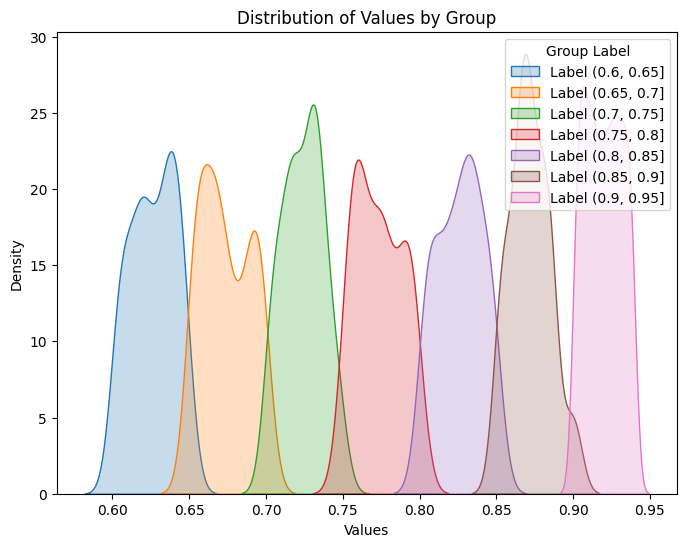

In [ ]:
import seaborn as sns

# Setting up the visual
plt.figure(figsize=(8, 6))

# Plotting KDE for each group
for name, group in grouped_df:
    sns.kdeplot(data=group, x='1_day_accuracy', label=f'Label {name}', fill=True)

plt.xlabel('Values')
plt.ylabel('Density')
plt.legend(title='Group Label')
plt.title('Distribution of Values by Group')
plt.show()

In [ ]:
np.unique(df['accuracy_mapped'],return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]), array([ 77,  91,  67,  60,  58,  58, 789]))

### Run below for training


In [ ]:
data = df.iloc[:,:-4]
data.head()

out_channel0    M   R1   R2    R3   R4   R5  convblock1  widenfact1    B1  \
0         117.0  1.0  9.0  0.0   0.0  0.0  0.0         2.0         4.0  11.0   
1         122.0  1.0  3.0  0.0   0.0  0.0  0.0         4.0         4.0   2.0   
2         102.0  1.0  1.0  0.0   0.0  0.0  0.0         3.0         1.0   9.0   
3          32.0  3.0  3.0  1.0   7.0  0.0  0.0         2.0         2.0   5.0   
4          38.0  3.0  8.0  4.0  11.0  0.0  0.0         4.0         1.0  12.0   

   ...   B2  convblock3  widenfact3   B3  convblock4  widenfact4   B4  \
0  ...  0.0         0.0         0.0  0.0         0.0         0.0  0.0   
1  ...  0.0         0.0         0.0  0.0         0.0         0.0  0.0   
2  ...  0.0         0.0         0.0  0.0         0.0         0.0  0.0   
3  ...  9.0         3.0         1.0  1.0         0.0         0.0  0.0   
4  ...  6.0         4.0         3.0  9.0         0.0         0.0  0.0   

   convblock5  widenfact5   B5  
0         0.0         0.0  0.0  
1         0.0         0.0  0.0  
2         0.0         0.0  0.0  
3         0.0         0.0  0.0  
4         0.0         0.0  0.0  

[5 rows x 22 columns]

In [ ]:
labels = df.iloc[:,-1]
labels.head()

0    10
1    10
2     5
3     1
4     5
Name: accuracy_mapped, dtype: int64

### Converting df to tensors

In [ ]:
data = torch.tensor(data[data.columns].values,dtype=torch.float32)
labels = torch.tensor(labels.values,dtype=torch.int64)

In [ ]:
data.shape, labels.shape

(torch.Size([1200, 22]), torch.Size([1200]))

In [ ]:
labels

tensor([10, 10,  5,  ...,  6, 12,  2])

### initializing the device

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [ ]:
device

'cuda'

### Dataset definition

In [ ]:
class VQVAE_Dataset(Dataset):
  def __init__(self,data,labels):
    self.data = data
    self.labels = labels

  def __getitem__(self,idx):
    return self.data[idx],self.labels[idx]

  def __len__(self):
    return len(self.data)

### Model definition

In [ ]:
class Encoder(nn.Module):
  def __init__(self,inp_dim,embed_dim=10,h_nodes=128,dropout=0.2,scale=2,num_layers=1):
    super(Encoder,self).__init__()
    self.inp_dim = inp_dim
    self.embed_dim = embed_dim
    self.tanh = nn.Tanh()
    self.dropout = nn.Dropout(dropout)
    self.scale = scale
    self.num_layers = num_layers
    self.h_nodes = h_nodes
    self.relu = nn.ReLU()
    self.layers = nn.ModuleList([nn.Sequential(
                                      nn.Linear(h_nodes//(scale**i),h_nodes//(scale**(i+1))),
                                      nn.ReLU(inplace=True),
                                      # nn.Dropout(dropout)
                                  )
                                  for i in range(num_layers)])
    self.fc1 = nn.Linear(self.inp_dim,h_nodes)
    self.fc2 = nn.Linear(h_nodes//(scale**(num_layers)),self.embed_dim)

  def forward(self,x):
    x = self.relu(self.fc1(x))
    for layer in self.layers:
      x = layer(x)
    x = self.fc2(x)
    # x = self.tanh(x)
    return x

class Decoder(nn.Module):
  def __init__(self,out_dim,embed_dim=10,h_nodes=128,dropout=0.2,scale=2,num_layers=1):
    super(Decoder,self).__init__()
    self.out_dim = out_dim
    self.embed_dim = embed_dim
    self.h_nodes = h_nodes
    self.scale = scale
    self.num_layers = num_layers
    self.fc1 = nn.Linear(self.embed_dim,h_nodes)
    self.layers = nn.ModuleList([nn.Sequential(
                                      nn.Linear(h_nodes//(scale**i),h_nodes//(scale**(i+1))),
                                      nn.ReLU(inplace=True),
                                      # nn.Dropout(dropout)
                                  )
                                  for i in range(num_layers)])
    self.fc2 = nn.Linear(h_nodes//scale**(num_layers),self.out_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.relu(self.fc1(x))
    for layer in self.layers:
      x = layer(x)
    x = self.fc2(x)
    x = self.relu(x)
    return x

class VectorQuantizerClass(nn.Module):
  def __init__(self,num_embeddings=50,embedding_dim=10,commitment_cost=0.25,divergence_cost=0.1):
    super(VectorQuantizerClass,self).__init__()
    self.num_embeddings = num_embeddings
    self.embed_dim = embedding_dim
    self.embeddings = nn.Embedding(self.num_embeddings,self.embed_dim)
    self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost
    self.divergence_cost = divergence_cost

  def forward(self,x,y):
    # x: [B,D]
    # embeddings: [num_embeddings, embed_dim]

    latent_vectors = x.unsqueeze(1) # [B,D] -> [B,1,D]
    codebook_vectors = self.embeddings.weight.unsqueeze(0) # [num_embeddings, embed_dim] -> [1,num_embeddings, embed_dim]
    distances = torch.norm(latent_vectors - codebook_vectors, dim=2) # [B,num_embeddings]

    encoding_indices = torch.reshape(y,(y.shape[0], 1))
    encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(device)
    encodings.scatter_(1, encoding_indices, 1)

    close_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    close_encodings = torch.zeros(close_indices.shape[0], self.num_embeddings).to(device)
    close_encodings.scatter_(1, close_indices, 1)

    indicator = 1 - (encoding_indices == close_indices).int()
    indicator = indicator.float()

    # Quantize
    quantized = torch.matmul(encodings, self.embeddings.weight)
    close_quantized = torch.matmul(close_encodings, self.embeddings.weight)

    # Loss
    q_latent_loss = torch.mean((quantized - x.detach())**2)
    e_latent_loss = torch.mean((quantized.detach() - x)**2)
    x_latent_loss = torch.mean(indicator * ((close_quantized - x.detach())**2))
    d_latent_loss = torch.mean(indicator * ((close_quantized.detach() - x)**2))
    loss = q_latent_loss + self.commitment_cost * e_latent_loss - x_latent_loss - self.divergence_cost * d_latent_loss

    # to copy gradients from decoder to encoder
    quantized = x + (quantized - x).detach()

    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return loss, quantized, perplexity, close_indices


### Supervised VQ VAE (trained using the label data)

In [ ]:
class SVQVAE(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,commitment_cost=0.25,divergence_cost=0.1,h_nodes=128,scale=2,num_layers=1):
    super(SVQVAE,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.quantizer = VectorQuantizerClass(num_embeddings,embed_dim,commitment_cost,divergence_cost)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x,y):
    z = self.encoder(x)
    loss, quantized_z, perplexity, close_indices = self.quantizer(z,y)
    x_recon = self.decoder(quantized_z)
    return loss, x_recon, perplexity, close_indices

### Wandb hyperparameter search (Not required to run during training)
(Don't run since best architecture was already picked from this run)

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'bayes'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        # 'values': ['adam', 'sgd']
        'value': 'adam'
        },
    'h_nodes': {
        'values': [512, 1024, 2048]
        },
    'num_layers': {
        'values': [4, 5, 6]
    },
    'embed_dim': {
        'values': [6, 8, 10, 14]
    },
    'num_embeddings': {
        # 'values': [25, 50, 75, 100]
        'value' : 7
    },
    'commitment_cost': {
        'values': [0.1,0.2,0.25,0.4,0.5]
    },
    'divergence_cost': {
        'values': [0.1,0.2,0.25,0.4,0.5]
    },
    'dropout': {
          'values': [0.1, 0.2, 0.3]
        },
    'epochs': {
          'value': 200
        },
    'learning_rate': {
          # a flat distribution between 0 and 0.1
          'distribution': 'uniform',
          'min': 1e-6,
          'max': 1e-3
        },
    'weight_decay': {
          # a flat distribution between 0 and 0.1
          'distribution': 'uniform',
          'min': 1e-6,
          'max': 1e-3
        },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      }
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'commitment_cost': {'values': [0.1, 0.2, 0.25, 0.4, 0.5]},
                'divergence_cost': {'values': [0.1, 0.2, 0.25, 0.4, 0.5]},
                'dropout': {'values': [0.1, 0.2, 0.3]},
                'embed_dim': {'values': [6, 8, 10, 14]},
                'epochs': {'value': 200},
                'h_nodes': {'values': [512, 1024, 2048]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.001,
                                  'min': 1e-06},
                'num_embeddings': {'value': 7},
                'num_layers': {'values': [4, 5, 6]},
                'optimizer': {'value': 'adam'},
                'weight_decay': {'distribution': 'uniform',
     

In [ ]:
x_dim = data.shape[1]
scale = 2

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="RL-NAS-Hyperparameter-tuning")

Create sweep with ID: nrizaxj0
Sweep URL: https://wandb.ai/sb-nd/RL-NAS-Hyperparameter-tuning/sweeps/nrizaxj0


In [ ]:
def build_optimizer(network, optimizer, learning_rate, weight_decay):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate, weight_decay=weight_decay)
    return optimizer

In [ ]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config

    train_loader = DataLoader(dataset,batch_size=config.batch_size,shuffle=True)

    model = SVQVAE(x_dim,config.embed_dim,dropout=config.dropout,num_embeddings=config.num_embeddings,
          commitment_cost=config.commitment_cost,divergence_cost=config.divergence_cost,h_nodes=config.h_nodes,scale=scale,
          num_layers=config.num_layers).to(device)

    optimizer = build_optimizer(model, config.optimizer, config.learning_rate, config.weight_decay)
    model.train()
    train_res_recon_error = []
    train_res_perplexity = []

    error = 0

    for epoch in tqdm(range(config.epochs)):

      for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
        batch_x,batch_y = batch
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        # noise = torch.rand(batch.size()).to(device)
        vq_loss, data_recon, perplexity, _ = model(batch_x,batch_y)
        recon_error = F.mse_loss(data_recon, batch_x)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        error = recon_error.item()

      wandb.log({"loss": error, "epoch": epoch})

In [ ]:
wandb.agent(sweep_id, train, count=30)

wandb: Agent Starting Run: n5478mzq with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.2
wandb: 	divergence_cost: 0.2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0008505801301272655
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0002443718477754979


100%|██████████| 200/200 [00:46<00:00,  4.26it/s]


wandb: Agent Starting Run: sv28izja with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.1
wandb: 	dropout: 0.1
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0008934107304773628
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.000441469273381441


100%|██████████| 200/200 [00:23<00:00,  8.39it/s]


wandb: Agent Starting Run: he1o48bc with config:
wandb: 	batch_size: 48
wandb: 	commitment_cost: 0.2
wandb: 	divergence_cost: 0.2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 1.044627945289765e-05
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001155393039698986


100%|██████████| 200/200 [00:33<00:00,  6.03it/s]


wandb: Agent Starting Run: hbbujrbe with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0006938110341068075
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0002154699463476565


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


wandb: Agent Starting Run: 9w3wlq6r with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0005154136551471534
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 9.236156190344164e-05


100%|██████████| 200/200 [00:48<00:00,  4.10it/s]


wandb: Agent Starting Run: ps2ruiu0 with config:
wandb: 	batch_size: 48
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0006451443737094854
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00013609812733144774


100%|██████████| 200/200 [00:33<00:00,  6.02it/s]


wandb: Agent Starting Run: rgwzum8l with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0007751677814014428
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00010375692136847484


100%|██████████| 200/200 [00:38<00:00,  5.19it/s]


wandb: Agent Starting Run: iwaluw22 with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.3
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0008583672938180878
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003987749012499768


100%|██████████| 200/200 [00:33<00:00,  6.03it/s]


wandb: Agent Starting Run: cpzaye75 with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.3
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0005227273999097174
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00012119064247807982


100%|██████████| 200/200 [00:50<00:00,  3.93it/s]


wandb: Agent Starting Run: si4bcxf1 with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0008957435736136399
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00021666640511844784


100%|██████████| 200/200 [00:51<00:00,  3.90it/s]


wandb: Agent Starting Run: lpxkjvd6 with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0008744443892263988
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 5.231225400351071e-05


100%|██████████| 200/200 [00:27<00:00,  7.20it/s]


wandb: Agent Starting Run: prvqddj6 with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.3
wandb: 	embed_dim: 14
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0009095270382269476
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001729418082944762


100%|██████████| 200/200 [00:48<00:00,  4.12it/s]


wandb: Agent Starting Run: scf9a4sz with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.000683630716908634
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.000356296435470004


100%|██████████| 200/200 [00:51<00:00,  3.86it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2d4xlr9v with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.1
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0007429411991713249
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00012960406108008014


100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


wandb: Agent Starting Run: dqgch0nv with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0009225898562797062
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00045561858085926


100%|██████████| 200/200 [00:52<00:00,  3.82it/s]


wandb: Agent Starting Run: w6hchaih with config:
wandb: 	batch_size: 48
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.3
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0006534208694216392
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003656534783698616


100%|██████████| 200/200 [00:33<00:00,  5.90it/s]


wandb: Agent Starting Run: uxyt1t7u with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.5
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0006319386406941296
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00016596910057276994


100%|██████████| 200/200 [00:46<00:00,  4.34it/s]


wandb: Agent Starting Run: olznma0v with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0009997016664200378
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00010956749266669135


100%|██████████| 200/200 [00:49<00:00,  4.04it/s]


wandb: Agent Starting Run: edn7zib2 with config:
wandb: 	batch_size: 48
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0007356674954369195
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00034601097376242145


100%|██████████| 200/200 [00:41<00:00,  4.87it/s]


wandb: Agent Starting Run: ubpqivp5 with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0006161040278989474
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001887937062304547


100%|██████████| 200/200 [00:26<00:00,  7.60it/s]


wandb: Agent Starting Run: zhs0530q with config:
wandb: 	batch_size: 88
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.000658369936830337
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00015544299628558514


100%|██████████| 200/200 [00:19<00:00, 10.31it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z7kpn734 with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0004702171157455684
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001966816506090776


100%|██████████| 200/200 [00:32<00:00,  6.19it/s]


wandb: Agent Starting Run: sslcrchy with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.3
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0006619874312401996
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001553025891357451


100%|██████████| 200/200 [00:49<00:00,  4.04it/s]


wandb: Agent Starting Run: cqkcd4ic with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.3
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0004325474901111556
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003910372391439912


100%|██████████| 200/200 [00:38<00:00,  5.19it/s]


wandb: Agent Starting Run: 5scora97 with config:
wandb: 	batch_size: 136
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0006519366568163695
wandb: 	num_embeddings: 7
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00012230006521562258


100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


wandb: Agent Starting Run: 0z0qdhad with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.00048287558780923647
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003469508075420748


100%|██████████| 200/200 [00:50<00:00,  4.00it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5y10w9a2 with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.2
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0008455855190524729
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0002410464055649151


100%|██████████| 200/200 [00:38<00:00,  5.18it/s]


wandb: Agent Starting Run: 0vtjbid3 with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.25
wandb: 	dropout: 0.3
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0009239179152751554
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00011608165130193573


100%|██████████| 200/200 [00:49<00:00,  4.04it/s]


wandb: Agent Starting Run: vyz663as with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.25
wandb: 	divergence_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0007152849785708656
wandb: 	num_embeddings: 7
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00015680651421924572


100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mhsk3fas with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.4
wandb: 	divergence_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.000556281922941886
wandb: 	num_embeddings: 7
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003596083132222477


100%|██████████| 200/200 [00:37<00:00,  5.38it/s]


### Training

In [ ]:
dataset = VQVAE_Dataset(data,labels) # dataset init

##### Best hyperparameters from the search 

In [ ]:
x_dim = data.shape[1]
h_nodes = 512
scale = 2
num_layers = 5
embed_dim = 8
dropout = 0.2
num_embeddings = 14
commitment_cost = 0.25
divergence_cost = 0.25
epochs = 1000
learning_rate = 0.0006938
weight_decay = 0.0002155
batch_size = 32

In [ ]:
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [ ]:
model = SVQVAE(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
              commitment_cost=commitment_cost,divergence_cost=divergence_cost,h_nodes=h_nodes,scale=scale,
              num_layers=num_layers).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay, amsgrad=False)

In [ ]:
from torchsummary import summary
summary(Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers).to(device),(x_dim,))
summary(VectorQuantizer(num_embeddings,embed_dim,commitment_cost).to(device),(embed_dim,))
summary(Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers).to(device),(embed_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          11,776
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 32]           2,080
             ReLU-10                   [-1, 32]               0
           Linear-11                   [-1, 16]             528
             ReLU-12                   [-1, 16]               0
           Linear-13                    [-1, 8]             136
Total params: 187,000
Trainable params:

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
close_indices = None

for epoch in tqdm(range(epochs)):

  for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
    batch_x,batch_y = batch
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()

    # noise = torch.rand(batch.size()).to(device)
    vq_loss, data_recon, perplexity, close_indices = model(batch_x,batch_y)
    recon_error = F.mse_loss(data_recon, batch_x)
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 2 == 0:
      print('%d iterations of epochs %d/%d' % (i+1,epoch + 1, epochs))
      print('Average recon_error: %.3f' % np.mean(train_res_recon_error[-10:]))
      print('Average perplexity: %.3f' % np.mean(train_res_perplexity[-10:]))
      print()


  0%|          | 0/1000 [00:00<?, ?it/s]

2 iterations of epochs 1/1000
Average recon_error: 304.070
Average perplexity: 11.198

4 iterations of epochs 1/1000
Average recon_error: 309.104
Average perplexity: 11.515

6 iterations of epochs 1/1000
Average recon_error: 303.854
Average perplexity: 11.292

8 iterations of epochs 1/1000
Average recon_error: 299.936
Average perplexity: 11.487

10 iterations of epochs 1/1000
Average recon_error: 287.497
Average perplexity: 11.251

12 iterations of epochs 1/1000
Average recon_error: 282.270
Average perplexity: 11.324

14 iterations of epochs 1/1000
Average recon_error: 268.370
Average perplexity: 11.036

16 iterations of epochs 1/1000
Average recon_error: 260.887
Average perplexity: 11.232

18 iterations of epochs 1/1000
Average recon_error: 266.975
Average perplexity: 11.137

20 iterations of epochs 1/1000
Average recon_error: 278.970
Average perplexity: 11.295

22 iterations of epochs 1/1000
Average recon_error: 282.159
Average perplexity: 10.981

24 iterations of epochs 1/1000
Avera

  0%|          | 1/1000 [00:00<11:55,  1.40it/s]

38 iterations of epochs 1/1000
Average recon_error: 261.096
Average perplexity: 10.606

2 iterations of epochs 2/1000
Average recon_error: 261.232
Average perplexity: 10.904

4 iterations of epochs 2/1000
Average recon_error: 255.989
Average perplexity: 10.971

6 iterations of epochs 2/1000
Average recon_error: 247.371
Average perplexity: 10.980

8 iterations of epochs 2/1000
Average recon_error: 254.422
Average perplexity: 11.303

10 iterations of epochs 2/1000
Average recon_error: 245.671
Average perplexity: 11.721

12 iterations of epochs 2/1000
Average recon_error: 236.010
Average perplexity: 11.478

14 iterations of epochs 2/1000
Average recon_error: 233.492
Average perplexity: 11.203

16 iterations of epochs 2/1000
Average recon_error: 221.950
Average perplexity: 11.195

18 iterations of epochs 2/1000
Average recon_error: 213.542
Average perplexity: 11.039

20 iterations of epochs 2/1000
Average recon_error: 204.732
Average perplexity: 10.661

22 iterations of epochs 2/1000
Avera

  0%|          | 2/1000 [00:00<07:20,  2.27it/s]

32 iterations of epochs 2/1000
Average recon_error: 169.730
Average perplexity: 10.593

34 iterations of epochs 2/1000
Average recon_error: 153.704
Average perplexity: 10.566

36 iterations of epochs 2/1000
Average recon_error: 143.465
Average perplexity: 10.689

38 iterations of epochs 2/1000
Average recon_error: 141.561
Average perplexity: 10.421

2 iterations of epochs 3/1000
Average recon_error: 135.403
Average perplexity: 10.749

4 iterations of epochs 3/1000
Average recon_error: 126.304
Average perplexity: 10.658

6 iterations of epochs 3/1000
Average recon_error: 120.422
Average perplexity: 10.943

8 iterations of epochs 3/1000
Average recon_error: 111.563
Average perplexity: 10.958

10 iterations of epochs 3/1000
Average recon_error: 105.056
Average perplexity: 11.400

12 iterations of epochs 3/1000
Average recon_error: 97.681
Average perplexity: 11.244

14 iterations of epochs 3/1000
Average recon_error: 94.863
Average perplexity: 11.286

16 iterations of epochs 3/1000
Average

  0%|          | 3/1000 [00:01<05:43,  2.91it/s]

30 iterations of epochs 3/1000
Average recon_error: 80.410
Average perplexity: 10.891

32 iterations of epochs 3/1000
Average recon_error: 78.647
Average perplexity: 10.607

34 iterations of epochs 3/1000
Average recon_error: 74.866
Average perplexity: 10.787

36 iterations of epochs 3/1000
Average recon_error: 73.234
Average perplexity: 10.699

38 iterations of epochs 3/1000
Average recon_error: 71.996
Average perplexity: 10.465

2 iterations of epochs 4/1000
Average recon_error: 71.463
Average perplexity: 10.830

4 iterations of epochs 4/1000
Average recon_error: 69.261
Average perplexity: 10.966

6 iterations of epochs 4/1000
Average recon_error: 70.298
Average perplexity: 11.020

8 iterations of epochs 4/1000
Average recon_error: 71.758
Average perplexity: 11.236

10 iterations of epochs 4/1000
Average recon_error: 73.368
Average perplexity: 11.147

12 iterations of epochs 4/1000
Average recon_error: 75.660
Average perplexity: 11.126

14 iterations of epochs 4/1000
Average recon_er

  0%|          | 4/1000 [00:01<04:57,  3.35it/s]

28 iterations of epochs 4/1000
Average recon_error: 74.991
Average perplexity: 10.492

30 iterations of epochs 4/1000
Average recon_error: 76.225
Average perplexity: 10.522

32 iterations of epochs 4/1000
Average recon_error: 77.224
Average perplexity: 10.356

34 iterations of epochs 4/1000
Average recon_error: 77.379
Average perplexity: 10.042

36 iterations of epochs 4/1000
Average recon_error: 76.549
Average perplexity: 10.409

38 iterations of epochs 4/1000
Average recon_error: 73.738
Average perplexity: 10.567

2 iterations of epochs 5/1000
Average recon_error: 75.303
Average perplexity: 11.005

4 iterations of epochs 5/1000
Average recon_error: 74.862
Average perplexity: 11.062

6 iterations of epochs 5/1000
Average recon_error: 72.753
Average perplexity: 11.251

8 iterations of epochs 5/1000
Average recon_error: 74.277
Average perplexity: 10.837

10 iterations of epochs 5/1000
Average recon_error: 76.571
Average perplexity: 11.017

12 iterations of epochs 5/1000
Average recon_er

  0%|          | 5/1000 [00:01<04:30,  3.68it/s]

24 iterations of epochs 5/1000
Average recon_error: 75.302
Average perplexity: 10.464

26 iterations of epochs 5/1000
Average recon_error: 75.551
Average perplexity: 10.431

28 iterations of epochs 5/1000
Average recon_error: 74.089
Average perplexity: 10.816

30 iterations of epochs 5/1000
Average recon_error: 75.062
Average perplexity: 10.969

32 iterations of epochs 5/1000
Average recon_error: 72.019
Average perplexity: 11.131

34 iterations of epochs 5/1000
Average recon_error: 70.252
Average perplexity: 10.999

36 iterations of epochs 5/1000
Average recon_error: 70.480
Average perplexity: 10.821

38 iterations of epochs 5/1000
Average recon_error: 69.638
Average perplexity: 10.395

2 iterations of epochs 6/1000
Average recon_error: 69.645
Average perplexity: 10.587

4 iterations of epochs 6/1000
Average recon_error: 72.556
Average perplexity: 10.576

6 iterations of epochs 6/1000
Average recon_error: 74.632
Average perplexity: 10.708

8 iterations of epochs 6/1000
Average recon_er

  1%|          | 6/1000 [00:01<04:19,  3.83it/s]

22 iterations of epochs 6/1000
Average recon_error: 74.978
Average perplexity: 10.772

24 iterations of epochs 6/1000
Average recon_error: 71.190
Average perplexity: 10.615

26 iterations of epochs 6/1000
Average recon_error: 70.174
Average perplexity: 10.425

28 iterations of epochs 6/1000
Average recon_error: 72.819
Average perplexity: 10.382

30 iterations of epochs 6/1000
Average recon_error: 71.894
Average perplexity: 10.557

32 iterations of epochs 6/1000
Average recon_error: 73.627
Average perplexity: 10.910

34 iterations of epochs 6/1000
Average recon_error: 75.944
Average perplexity: 11.060

36 iterations of epochs 6/1000
Average recon_error: 73.804
Average perplexity: 11.307

38 iterations of epochs 6/1000
Average recon_error: 71.826
Average perplexity: 11.006

2 iterations of epochs 7/1000
Average recon_error: 71.230
Average perplexity: 10.784

4 iterations of epochs 7/1000
Average recon_error: 70.088
Average perplexity: 10.533

6 iterations of epochs 7/1000
Average recon_e

  1%|          | 7/1000 [00:02<04:09,  3.97it/s]

16 iterations of epochs 7/1000
Average recon_error: 76.004
Average perplexity: 11.638

18 iterations of epochs 7/1000
Average recon_error: 76.439
Average perplexity: 11.420

20 iterations of epochs 7/1000
Average recon_error: 76.512
Average perplexity: 11.244

22 iterations of epochs 7/1000
Average recon_error: 76.470
Average perplexity: 11.511

24 iterations of epochs 7/1000
Average recon_error: 76.265
Average perplexity: 11.571

26 iterations of epochs 7/1000
Average recon_error: 74.079
Average perplexity: 11.429

28 iterations of epochs 7/1000
Average recon_error: 76.120
Average perplexity: 11.420

30 iterations of epochs 7/1000
Average recon_error: 76.130
Average perplexity: 11.318

32 iterations of epochs 7/1000
Average recon_error: 74.471
Average perplexity: 11.229

34 iterations of epochs 7/1000
Average recon_error: 73.194
Average perplexity: 11.358

36 iterations of epochs 7/1000
Average recon_error: 72.997
Average perplexity: 11.278

38 iterations of epochs 7/1000
Average reco

  1%|          | 8/1000 [00:02<04:02,  4.09it/s]

12 iterations of epochs 8/1000
Average recon_error: 71.691
Average perplexity: 11.032

14 iterations of epochs 8/1000
Average recon_error: 73.863
Average perplexity: 10.989

16 iterations of epochs 8/1000
Average recon_error: 76.681
Average perplexity: 11.023

18 iterations of epochs 8/1000
Average recon_error: 74.597
Average perplexity: 11.224

20 iterations of epochs 8/1000
Average recon_error: 75.557
Average perplexity: 11.020

22 iterations of epochs 8/1000
Average recon_error: 74.666
Average perplexity: 11.276

24 iterations of epochs 8/1000
Average recon_error: 74.819
Average perplexity: 11.552

26 iterations of epochs 8/1000
Average recon_error: 74.647
Average perplexity: 11.597

28 iterations of epochs 8/1000
Average recon_error: 73.665
Average perplexity: 11.206

30 iterations of epochs 8/1000
Average recon_error: 75.803
Average perplexity: 11.223

32 iterations of epochs 8/1000
Average recon_error: 75.802
Average perplexity: 10.789

34 iterations of epochs 8/1000
Average reco

  1%|          | 9/1000 [00:02<03:54,  4.22it/s]

10 iterations of epochs 9/1000
Average recon_error: 78.612
Average perplexity: 11.137

12 iterations of epochs 9/1000
Average recon_error: 74.374
Average perplexity: 11.239

14 iterations of epochs 9/1000
Average recon_error: 72.544
Average perplexity: 11.049

16 iterations of epochs 9/1000
Average recon_error: 69.249
Average perplexity: 11.155

18 iterations of epochs 9/1000
Average recon_error: 67.539
Average perplexity: 11.142

20 iterations of epochs 9/1000
Average recon_error: 68.103
Average perplexity: 10.806

22 iterations of epochs 9/1000
Average recon_error: 70.544
Average perplexity: 10.609

24 iterations of epochs 9/1000
Average recon_error: 70.350
Average perplexity: 10.704

26 iterations of epochs 9/1000
Average recon_error: 73.730
Average perplexity: 10.717

28 iterations of epochs 9/1000
Average recon_error: 76.839
Average perplexity: 10.725

30 iterations of epochs 9/1000
Average recon_error: 78.732
Average perplexity: 10.720

32 iterations of epochs 9/1000
Average reco

  1%|          | 10/1000 [00:02<03:49,  4.30it/s]

8 iterations of epochs 10/1000
Average recon_error: 77.122
Average perplexity: 11.037

10 iterations of epochs 10/1000
Average recon_error: 74.254
Average perplexity: 11.520

12 iterations of epochs 10/1000
Average recon_error: 73.630
Average perplexity: 11.207

14 iterations of epochs 10/1000
Average recon_error: 74.300
Average perplexity: 11.076

16 iterations of epochs 10/1000
Average recon_error: 76.549
Average perplexity: 11.285

18 iterations of epochs 10/1000
Average recon_error: 75.338
Average perplexity: 11.027

20 iterations of epochs 10/1000
Average recon_error: 77.272
Average perplexity: 10.868

22 iterations of epochs 10/1000
Average recon_error: 76.329
Average perplexity: 10.743

24 iterations of epochs 10/1000
Average recon_error: 74.903
Average perplexity: 10.591

26 iterations of epochs 10/1000
Average recon_error: 72.015
Average perplexity: 10.394

28 iterations of epochs 10/1000
Average recon_error: 71.571
Average perplexity: 10.631

30 iterations of epochs 10/1000
A

  1%|          | 11/1000 [00:03<03:52,  4.25it/s]

2 iterations of epochs 12/1000
Average recon_error: 76.925
Average perplexity: 10.868

4 iterations of epochs 12/1000
Average recon_error: 73.111
Average perplexity: 10.923

6 iterations of epochs 12/1000
Average recon_error: 74.817
Average perplexity: 10.901

8 iterations of epochs 12/1000
Average recon_error: 73.998
Average perplexity: 10.958

10 iterations of epochs 12/1000
Average recon_error: 75.330
Average perplexity: 11.164

12 iterations of epochs 12/1000
Average recon_error: 69.213
Average perplexity: 11.105

14 iterations of epochs 12/1000
Average recon_error: 70.994
Average perplexity: 11.054

16 iterations of epochs 12/1000
Average recon_error: 72.478
Average perplexity: 10.860

18 iterations of epochs 12/1000
Average recon_error: 73.575
Average perplexity: 10.583

20 iterations of epochs 12/1000
Average recon_error: 73.166
Average perplexity: 10.417

22 iterations of epochs 12/1000
Average recon_error: 76.920
Average perplexity: 10.407

24 iterations of epochs 12/1000
Aver

  1%|          | 12/1000 [00:03<03:47,  4.35it/s]

2 iterations of epochs 13/1000
Average recon_error: 72.165
Average perplexity: 10.666

4 iterations of epochs 13/1000
Average recon_error: 71.364
Average perplexity: 10.596

6 iterations of epochs 13/1000
Average recon_error: 74.372
Average perplexity: 10.841

8 iterations of epochs 13/1000
Average recon_error: 73.696
Average perplexity: 10.801

10 iterations of epochs 13/1000
Average recon_error: 77.063
Average perplexity: 10.990

12 iterations of epochs 13/1000
Average recon_error: 76.565
Average perplexity: 10.765

14 iterations of epochs 13/1000
Average recon_error: 74.336
Average perplexity: 11.045

16 iterations of epochs 13/1000
Average recon_error: 73.904
Average perplexity: 10.849

18 iterations of epochs 13/1000
Average recon_error: 73.181
Average perplexity: 10.907

20 iterations of epochs 13/1000
Average recon_error: 67.579
Average perplexity: 11.077

22 iterations of epochs 13/1000
Average recon_error: 67.746
Average perplexity: 11.079

24 iterations of epochs 13/1000
Aver

  1%|▏         | 13/1000 [00:03<04:14,  3.88it/s]

26 iterations of epochs 13/1000
Average recon_error: 71.408
Average perplexity: 11.139

28 iterations of epochs 13/1000
Average recon_error: 74.601
Average perplexity: 11.233

30 iterations of epochs 13/1000
Average recon_error: 79.271
Average perplexity: 11.146

32 iterations of epochs 13/1000
Average recon_error: 81.140
Average perplexity: 11.417

34 iterations of epochs 13/1000
Average recon_error: 77.557
Average perplexity: 11.340

36 iterations of epochs 13/1000
Average recon_error: 77.942
Average perplexity: 11.078

38 iterations of epochs 13/1000
Average recon_error: 73.980
Average perplexity: 10.779

2 iterations of epochs 14/1000
Average recon_error: 71.949
Average perplexity: 10.613

4 iterations of epochs 14/1000
Average recon_error: 71.829
Average perplexity: 10.505

6 iterations of epochs 14/1000
Average recon_error: 74.478
Average perplexity: 10.630

8 iterations of epochs 14/1000
Average recon_error: 74.966
Average perplexity: 10.775

10 iterations of epochs 14/1000
Aver

  1%|▏         | 14/1000 [00:03<04:26,  3.70it/s]

14 iterations of epochs 14/1000
Average recon_error: 79.112
Average perplexity: 11.242

16 iterations of epochs 14/1000
Average recon_error: 77.497
Average perplexity: 11.082

18 iterations of epochs 14/1000
Average recon_error: 78.026
Average perplexity: 10.851

20 iterations of epochs 14/1000
Average recon_error: 79.476
Average perplexity: 10.481

22 iterations of epochs 14/1000
Average recon_error: 75.749
Average perplexity: 10.669

24 iterations of epochs 14/1000
Average recon_error: 71.647
Average perplexity: 10.466

26 iterations of epochs 14/1000
Average recon_error: 73.577
Average perplexity: 10.510

28 iterations of epochs 14/1000
Average recon_error: 68.764
Average perplexity: 10.835

30 iterations of epochs 14/1000
Average recon_error: 69.419
Average perplexity: 10.852

32 iterations of epochs 14/1000
Average recon_error: 70.184
Average perplexity: 10.624

34 iterations of epochs 14/1000
Average recon_error: 74.111
Average perplexity: 10.870

36 iterations of epochs 14/1000


  2%|▏         | 15/1000 [00:04<04:38,  3.54it/s]

28 iterations of epochs 15/1000
Average recon_error: 70.542
Average perplexity: 10.818

30 iterations of epochs 15/1000
Average recon_error: 69.368
Average perplexity: 11.259

32 iterations of epochs 15/1000
Average recon_error: 71.831
Average perplexity: 11.261

34 iterations of epochs 15/1000
Average recon_error: 71.349
Average perplexity: 11.433

36 iterations of epochs 15/1000
Average recon_error: 71.559
Average perplexity: 11.174

38 iterations of epochs 15/1000
Average recon_error: 73.908
Average perplexity: 10.873

2 iterations of epochs 16/1000
Average recon_error: 73.545
Average perplexity: 10.564

4 iterations of epochs 16/1000
Average recon_error: 72.905
Average perplexity: 10.703

6 iterations of epochs 16/1000
Average recon_error: 70.402
Average perplexity: 10.860

8 iterations of epochs 16/1000
Average recon_error: 70.201
Average perplexity: 11.114

10 iterations of epochs 16/1000
Average recon_error: 68.579
Average perplexity: 11.262

12 iterations of epochs 16/1000
Aver

  2%|▏         | 16/1000 [00:04<04:37,  3.55it/s]

18 iterations of epochs 16/1000
Average recon_error: 73.332
Average perplexity: 11.127

20 iterations of epochs 16/1000
Average recon_error: 73.948
Average perplexity: 11.196

22 iterations of epochs 16/1000
Average recon_error: 74.792
Average perplexity: 11.119

24 iterations of epochs 16/1000
Average recon_error: 76.492
Average perplexity: 10.949

26 iterations of epochs 16/1000
Average recon_error: 76.940
Average perplexity: 10.967

28 iterations of epochs 16/1000
Average recon_error: 75.021
Average perplexity: 11.156

30 iterations of epochs 16/1000
Average recon_error: 75.121
Average perplexity: 11.004

32 iterations of epochs 16/1000
Average recon_error: 76.828
Average perplexity: 11.210

34 iterations of epochs 16/1000
Average recon_error: 75.029
Average perplexity: 11.607

36 iterations of epochs 16/1000
Average recon_error: 74.170
Average perplexity: 11.378

38 iterations of epochs 16/1000
Average recon_error: 78.060
Average perplexity: 11.050

2 iterations of epochs 17/1000
A

  2%|▏         | 17/1000 [00:04<04:48,  3.40it/s]

34 iterations of epochs 17/1000
Average recon_error: 76.428
Average perplexity: 10.761

36 iterations of epochs 17/1000
Average recon_error: 73.450
Average perplexity: 11.085

38 iterations of epochs 17/1000
Average recon_error: 72.236
Average perplexity: 10.747

2 iterations of epochs 18/1000
Average recon_error: 73.635
Average perplexity: 11.157

4 iterations of epochs 18/1000
Average recon_error: 71.598
Average perplexity: 11.102

6 iterations of epochs 18/1000
Average recon_error: 69.193
Average perplexity: 10.888

8 iterations of epochs 18/1000
Average recon_error: 70.898
Average perplexity: 11.012

10 iterations of epochs 18/1000
Average recon_error: 70.438
Average perplexity: 11.241

12 iterations of epochs 18/1000
Average recon_error: 69.883
Average perplexity: 11.297

14 iterations of epochs 18/1000
Average recon_error: 71.155
Average perplexity: 11.271

16 iterations of epochs 18/1000
Average recon_error: 73.256
Average perplexity: 11.383

18 iterations of epochs 18/1000
Aver

  2%|▏         | 18/1000 [00:05<05:02,  3.24it/s]

20 iterations of epochs 18/1000
Average recon_error: 73.429
Average perplexity: 11.372

22 iterations of epochs 18/1000
Average recon_error: 73.712
Average perplexity: 11.049

24 iterations of epochs 18/1000
Average recon_error: 75.813
Average perplexity: 11.023

26 iterations of epochs 18/1000
Average recon_error: 71.733
Average perplexity: 10.871

28 iterations of epochs 18/1000
Average recon_error: 71.749
Average perplexity: 10.755

30 iterations of epochs 18/1000
Average recon_error: 75.089
Average perplexity: 10.840

32 iterations of epochs 18/1000
Average recon_error: 78.592
Average perplexity: 10.864

34 iterations of epochs 18/1000
Average recon_error: 77.669
Average perplexity: 10.902

36 iterations of epochs 18/1000
Average recon_error: 78.937
Average perplexity: 11.158

38 iterations of epochs 18/1000
Average recon_error: 77.725
Average perplexity: 10.941

2 iterations of epochs 19/1000
Average recon_error: 76.143
Average perplexity: 10.782

4 iterations of epochs 19/1000
Av

  2%|▏         | 19/1000 [00:05<04:53,  3.34it/s]

38 iterations of epochs 19/1000
Average recon_error: 70.629
Average perplexity: 10.825

2 iterations of epochs 20/1000
Average recon_error: 70.427
Average perplexity: 10.838

4 iterations of epochs 20/1000
Average recon_error: 71.775
Average perplexity: 10.725

6 iterations of epochs 20/1000
Average recon_error: 71.658
Average perplexity: 10.636

8 iterations of epochs 20/1000
Average recon_error: 72.498
Average perplexity: 10.953

10 iterations of epochs 20/1000
Average recon_error: 74.620
Average perplexity: 11.021

12 iterations of epochs 20/1000
Average recon_error: 74.954
Average perplexity: 11.116

14 iterations of epochs 20/1000
Average recon_error: 72.801
Average perplexity: 11.339

16 iterations of epochs 20/1000
Average recon_error: 73.224
Average perplexity: 11.244

18 iterations of epochs 20/1000
Average recon_error: 74.336
Average perplexity: 11.244

20 iterations of epochs 20/1000
Average recon_error: 73.998
Average perplexity: 10.926

22 iterations of epochs 20/1000
Aver

  2%|▏         | 20/1000 [00:05<04:33,  3.59it/s]

34 iterations of epochs 20/1000
Average recon_error: 70.677
Average perplexity: 11.204

36 iterations of epochs 20/1000
Average recon_error: 70.418
Average perplexity: 11.124

38 iterations of epochs 20/1000
Average recon_error: 73.293
Average perplexity: 10.749

2 iterations of epochs 21/1000
Average recon_error: 76.033
Average perplexity: 10.574

4 iterations of epochs 21/1000
Average recon_error: 77.903
Average perplexity: 10.789

6 iterations of epochs 21/1000
Average recon_error: 77.521
Average perplexity: 10.567

8 iterations of epochs 21/1000
Average recon_error: 78.303
Average perplexity: 10.516

10 iterations of epochs 21/1000
Average recon_error: 74.111
Average perplexity: 10.767

12 iterations of epochs 21/1000
Average recon_error: 73.085
Average perplexity: 10.910

14 iterations of epochs 21/1000
Average recon_error: 68.301
Average perplexity: 10.919

16 iterations of epochs 21/1000
Average recon_error: 71.389
Average perplexity: 10.992

18 iterations of epochs 21/1000
Aver

  2%|▏         | 21/1000 [00:05<04:16,  3.82it/s]

32 iterations of epochs 21/1000
Average recon_error: 77.971
Average perplexity: 10.963

34 iterations of epochs 21/1000
Average recon_error: 76.718
Average perplexity: 10.830

36 iterations of epochs 21/1000
Average recon_error: 74.368
Average perplexity: 10.974

38 iterations of epochs 21/1000
Average recon_error: 74.527
Average perplexity: 10.348

2 iterations of epochs 22/1000
Average recon_error: 75.042
Average perplexity: 10.156

4 iterations of epochs 22/1000
Average recon_error: 73.052
Average perplexity: 10.299

6 iterations of epochs 22/1000
Average recon_error: 73.908
Average perplexity: 10.655

8 iterations of epochs 22/1000
Average recon_error: 76.165
Average perplexity: 10.351

10 iterations of epochs 22/1000
Average recon_error: 74.950
Average perplexity: 10.961

12 iterations of epochs 22/1000
Average recon_error: 73.241
Average perplexity: 11.072

14 iterations of epochs 22/1000
Average recon_error: 73.189
Average perplexity: 11.037

16 iterations of epochs 22/1000
Aver

  2%|▏         | 22/1000 [00:06<04:08,  3.93it/s]

28 iterations of epochs 22/1000
Average recon_error: 72.230
Average perplexity: 10.819

30 iterations of epochs 22/1000
Average recon_error: 80.062
Average perplexity: 10.703

32 iterations of epochs 22/1000
Average recon_error: 80.656
Average perplexity: 10.777

34 iterations of epochs 22/1000
Average recon_error: 77.779
Average perplexity: 10.999

36 iterations of epochs 22/1000
Average recon_error: 75.201
Average perplexity: 11.063

38 iterations of epochs 22/1000
Average recon_error: 78.807
Average perplexity: 10.980

2 iterations of epochs 23/1000
Average recon_error: 73.993
Average perplexity: 10.881

4 iterations of epochs 23/1000
Average recon_error: 74.546
Average perplexity: 10.912

6 iterations of epochs 23/1000
Average recon_error: 75.838
Average perplexity: 10.706

8 iterations of epochs 23/1000
Average recon_error: 78.717
Average perplexity: 10.741

10 iterations of epochs 23/1000
Average recon_error: 73.642
Average perplexity: 10.790

12 iterations of epochs 23/1000
Aver

  2%|▏         | 23/1000 [00:06<03:59,  4.07it/s]

26 iterations of epochs 23/1000
Average recon_error: 76.270
Average perplexity: 11.051

28 iterations of epochs 23/1000
Average recon_error: 76.914
Average perplexity: 11.338

30 iterations of epochs 23/1000
Average recon_error: 75.588
Average perplexity: 11.354

32 iterations of epochs 23/1000
Average recon_error: 75.664
Average perplexity: 11.491

34 iterations of epochs 23/1000
Average recon_error: 76.956
Average perplexity: 11.147

36 iterations of epochs 23/1000
Average recon_error: 74.283
Average perplexity: 11.079

38 iterations of epochs 23/1000
Average recon_error: 73.776
Average perplexity: 10.814

2 iterations of epochs 24/1000
Average recon_error: 74.793
Average perplexity: 10.603

4 iterations of epochs 24/1000
Average recon_error: 73.113
Average perplexity: 10.612

6 iterations of epochs 24/1000
Average recon_error: 69.513
Average perplexity: 11.018

8 iterations of epochs 24/1000
Average recon_error: 71.451
Average perplexity: 11.182

10 iterations of epochs 24/1000
Aver

  2%|▏         | 24/1000 [00:06<03:53,  4.17it/s]

22 iterations of epochs 24/1000
Average recon_error: 78.802
Average perplexity: 11.484

24 iterations of epochs 24/1000
Average recon_error: 80.321
Average perplexity: 11.654

26 iterations of epochs 24/1000
Average recon_error: 77.778
Average perplexity: 11.491

28 iterations of epochs 24/1000
Average recon_error: 76.887
Average perplexity: 11.291

30 iterations of epochs 24/1000
Average recon_error: 76.077
Average perplexity: 10.906

32 iterations of epochs 24/1000
Average recon_error: 73.673
Average perplexity: 10.618

34 iterations of epochs 24/1000
Average recon_error: 70.569
Average perplexity: 10.589

36 iterations of epochs 24/1000
Average recon_error: 72.273
Average perplexity: 10.519

38 iterations of epochs 24/1000
Average recon_error: 70.833
Average perplexity: 10.226

2 iterations of epochs 25/1000
Average recon_error: 71.959
Average perplexity: 10.265

4 iterations of epochs 25/1000
Average recon_error: 70.648
Average perplexity: 10.596

6 iterations of epochs 25/1000
Ave

  2%|▎         | 25/1000 [00:06<03:49,  4.25it/s]

18 iterations of epochs 25/1000
Average recon_error: 76.586
Average perplexity: 11.010

20 iterations of epochs 25/1000
Average recon_error: 74.896
Average perplexity: 11.090

22 iterations of epochs 25/1000
Average recon_error: 72.258
Average perplexity: 11.046

24 iterations of epochs 25/1000
Average recon_error: 74.558
Average perplexity: 11.056

26 iterations of epochs 25/1000
Average recon_error: 73.340
Average perplexity: 10.956

28 iterations of epochs 25/1000
Average recon_error: 71.939
Average perplexity: 10.831

30 iterations of epochs 25/1000
Average recon_error: 74.258
Average perplexity: 10.866

32 iterations of epochs 25/1000
Average recon_error: 75.207
Average perplexity: 11.005

34 iterations of epochs 25/1000
Average recon_error: 75.056
Average perplexity: 10.927

36 iterations of epochs 25/1000
Average recon_error: 74.427
Average perplexity: 10.909

38 iterations of epochs 25/1000
Average recon_error: 76.249
Average perplexity: 11.260

2 iterations of epochs 26/1000
A

  3%|▎         | 26/1000 [00:07<03:47,  4.28it/s]

16 iterations of epochs 26/1000
Average recon_error: 78.574
Average perplexity: 11.048

18 iterations of epochs 26/1000
Average recon_error: 78.861
Average perplexity: 11.061

20 iterations of epochs 26/1000
Average recon_error: 77.964
Average perplexity: 11.176

22 iterations of epochs 26/1000
Average recon_error: 78.391
Average perplexity: 11.225

24 iterations of epochs 26/1000
Average recon_error: 76.091
Average perplexity: 11.479

26 iterations of epochs 26/1000
Average recon_error: 75.357
Average perplexity: 11.532

28 iterations of epochs 26/1000
Average recon_error: 72.742
Average perplexity: 11.354

30 iterations of epochs 26/1000
Average recon_error: 72.932
Average perplexity: 11.662

32 iterations of epochs 26/1000
Average recon_error: 67.281
Average perplexity: 11.452

34 iterations of epochs 26/1000
Average recon_error: 68.111
Average perplexity: 10.975

36 iterations of epochs 26/1000
Average recon_error: 67.017
Average perplexity: 10.900

38 iterations of epochs 26/1000


  3%|▎         | 27/1000 [00:07<03:45,  4.32it/s]

12 iterations of epochs 27/1000
Average recon_error: 76.864
Average perplexity: 10.917

14 iterations of epochs 27/1000
Average recon_error: 75.803
Average perplexity: 11.253

16 iterations of epochs 27/1000
Average recon_error: 76.717
Average perplexity: 11.132

18 iterations of epochs 27/1000
Average recon_error: 75.845
Average perplexity: 11.330

20 iterations of epochs 27/1000
Average recon_error: 72.079
Average perplexity: 11.582

22 iterations of epochs 27/1000
Average recon_error: 71.913
Average perplexity: 11.417

24 iterations of epochs 27/1000
Average recon_error: 73.071
Average perplexity: 11.064

26 iterations of epochs 27/1000
Average recon_error: 70.632
Average perplexity: 11.440

28 iterations of epochs 27/1000
Average recon_error: 71.010
Average perplexity: 11.489

30 iterations of epochs 27/1000
Average recon_error: 71.438
Average perplexity: 11.384

32 iterations of epochs 27/1000
Average recon_error: 70.361
Average perplexity: 11.330

34 iterations of epochs 27/1000


  3%|▎         | 28/1000 [00:07<03:41,  4.38it/s]

10 iterations of epochs 28/1000
Average recon_error: 72.909
Average perplexity: 11.354

12 iterations of epochs 28/1000
Average recon_error: 73.184
Average perplexity: 11.409

14 iterations of epochs 28/1000
Average recon_error: 72.702
Average perplexity: 11.724

16 iterations of epochs 28/1000
Average recon_error: 73.982
Average perplexity: 11.834

18 iterations of epochs 28/1000
Average recon_error: 73.734
Average perplexity: 11.680

20 iterations of epochs 28/1000
Average recon_error: 74.067
Average perplexity: 11.431

22 iterations of epochs 28/1000
Average recon_error: 75.223
Average perplexity: 11.353

24 iterations of epochs 28/1000
Average recon_error: 77.226
Average perplexity: 10.900

26 iterations of epochs 28/1000
Average recon_error: 74.480
Average perplexity: 11.010

28 iterations of epochs 28/1000
Average recon_error: 75.540
Average perplexity: 11.051

30 iterations of epochs 28/1000
Average recon_error: 75.069
Average perplexity: 11.371

32 iterations of epochs 28/1000


  3%|▎         | 29/1000 [00:07<03:39,  4.43it/s]

8 iterations of epochs 29/1000
Average recon_error: 74.062
Average perplexity: 10.842

10 iterations of epochs 29/1000
Average recon_error: 72.242
Average perplexity: 11.074

12 iterations of epochs 29/1000
Average recon_error: 73.662
Average perplexity: 10.852

14 iterations of epochs 29/1000
Average recon_error: 74.559
Average perplexity: 11.094

16 iterations of epochs 29/1000
Average recon_error: 75.385
Average perplexity: 11.158

18 iterations of epochs 29/1000
Average recon_error: 75.486
Average perplexity: 11.351

20 iterations of epochs 29/1000
Average recon_error: 74.482
Average perplexity: 11.126

22 iterations of epochs 29/1000
Average recon_error: 73.769
Average perplexity: 11.191

24 iterations of epochs 29/1000
Average recon_error: 72.688
Average perplexity: 10.739

26 iterations of epochs 29/1000
Average recon_error: 73.779
Average perplexity: 10.937

28 iterations of epochs 29/1000
Average recon_error: 75.803
Average perplexity: 11.066

30 iterations of epochs 29/1000
A

  3%|▎         | 30/1000 [00:07<03:42,  4.37it/s]

6 iterations of epochs 30/1000
Average recon_error: 75.224
Average perplexity: 10.709

8 iterations of epochs 30/1000
Average recon_error: 76.653
Average perplexity: 10.545

10 iterations of epochs 30/1000
Average recon_error: 75.424
Average perplexity: 10.751

12 iterations of epochs 30/1000
Average recon_error: 71.779
Average perplexity: 11.152

14 iterations of epochs 30/1000
Average recon_error: 73.501
Average perplexity: 11.216

16 iterations of epochs 30/1000
Average recon_error: 73.657
Average perplexity: 11.014

18 iterations of epochs 30/1000
Average recon_error: 73.362
Average perplexity: 11.035

20 iterations of epochs 30/1000
Average recon_error: 73.963
Average perplexity: 11.086

22 iterations of epochs 30/1000
Average recon_error: 74.383
Average perplexity: 10.747

24 iterations of epochs 30/1000
Average recon_error: 72.261
Average perplexity: 10.386

26 iterations of epochs 30/1000
Average recon_error: 71.101
Average perplexity: 10.373

28 iterations of epochs 30/1000
Av

  3%|▎         | 31/1000 [00:08<03:49,  4.21it/s]

34 iterations of epochs 31/1000
Average recon_error: 71.829
Average perplexity: 10.669

36 iterations of epochs 31/1000
Average recon_error: 71.748
Average perplexity: 10.314

38 iterations of epochs 31/1000
Average recon_error: 70.608
Average perplexity: 10.250

2 iterations of epochs 32/1000
Average recon_error: 73.761
Average perplexity: 10.699

4 iterations of epochs 32/1000
Average recon_error: 72.901
Average perplexity: 10.739

6 iterations of epochs 32/1000
Average recon_error: 74.109
Average perplexity: 10.710

8 iterations of epochs 32/1000
Average recon_error: 75.051
Average perplexity: 11.040

10 iterations of epochs 32/1000
Average recon_error: 74.609
Average perplexity: 11.187

12 iterations of epochs 32/1000
Average recon_error: 78.116
Average perplexity: 10.945

14 iterations of epochs 32/1000
Average recon_error: 77.204
Average perplexity: 10.962

16 iterations of epochs 32/1000
Average recon_error: 76.378
Average perplexity: 10.983

18 iterations of epochs 32/1000
Aver

  3%|▎         | 32/1000 [00:08<03:49,  4.23it/s]

30 iterations of epochs 32/1000
Average recon_error: 74.074
Average perplexity: 11.050

32 iterations of epochs 32/1000
Average recon_error: 75.429
Average perplexity: 11.155

34 iterations of epochs 32/1000
Average recon_error: 74.080
Average perplexity: 11.238

36 iterations of epochs 32/1000
Average recon_error: 76.499
Average perplexity: 10.849

38 iterations of epochs 32/1000
Average recon_error: 75.508
Average perplexity: 10.502

2 iterations of epochs 33/1000
Average recon_error: 75.740
Average perplexity: 10.446

4 iterations of epochs 33/1000
Average recon_error: 74.511
Average perplexity: 10.388

6 iterations of epochs 33/1000
Average recon_error: 76.522
Average perplexity: 10.288

8 iterations of epochs 33/1000
Average recon_error: 72.096
Average perplexity: 10.711

10 iterations of epochs 33/1000
Average recon_error: 73.430
Average perplexity: 10.904

12 iterations of epochs 33/1000
Average recon_error: 75.697
Average perplexity: 11.083

14 iterations of epochs 33/1000
Aver

  3%|▎         | 33/1000 [00:08<03:47,  4.26it/s]

26 iterations of epochs 33/1000
Average recon_error: 74.587
Average perplexity: 10.504

28 iterations of epochs 33/1000
Average recon_error: 74.131
Average perplexity: 10.750

30 iterations of epochs 33/1000
Average recon_error: 73.538
Average perplexity: 11.079

32 iterations of epochs 33/1000
Average recon_error: 75.239
Average perplexity: 11.207

34 iterations of epochs 33/1000
Average recon_error: 74.473
Average perplexity: 11.293

36 iterations of epochs 33/1000
Average recon_error: 74.151
Average perplexity: 11.218

38 iterations of epochs 33/1000
Average recon_error: 70.370
Average perplexity: 10.902

2 iterations of epochs 34/1000
Average recon_error: 70.270
Average perplexity: 10.630

4 iterations of epochs 34/1000
Average recon_error: 71.332
Average perplexity: 10.362

6 iterations of epochs 34/1000
Average recon_error: 71.578
Average perplexity: 10.414

8 iterations of epochs 34/1000
Average recon_error: 71.714
Average perplexity: 10.530

10 iterations of epochs 34/1000
Aver

  3%|▎         | 34/1000 [00:08<03:46,  4.27it/s]

22 iterations of epochs 34/1000
Average recon_error: 76.558
Average perplexity: 11.329

24 iterations of epochs 34/1000
Average recon_error: 78.255
Average perplexity: 11.242

26 iterations of epochs 34/1000
Average recon_error: 79.340
Average perplexity: 11.153

28 iterations of epochs 34/1000
Average recon_error: 77.068
Average perplexity: 10.649

30 iterations of epochs 34/1000
Average recon_error: 77.115
Average perplexity: 10.519

32 iterations of epochs 34/1000
Average recon_error: 76.912
Average perplexity: 10.661

34 iterations of epochs 34/1000
Average recon_error: 74.053
Average perplexity: 10.470

36 iterations of epochs 34/1000
Average recon_error: 74.196
Average perplexity: 10.715

38 iterations of epochs 34/1000
Average recon_error: 70.645
Average perplexity: 10.756

2 iterations of epochs 35/1000
Average recon_error: 69.697
Average perplexity: 10.772

4 iterations of epochs 35/1000
Average recon_error: 70.323
Average perplexity: 10.645

6 iterations of epochs 35/1000
Ave

  4%|▎         | 35/1000 [00:09<03:48,  4.23it/s]

20 iterations of epochs 35/1000
Average recon_error: 71.634
Average perplexity: 11.112

22 iterations of epochs 35/1000
Average recon_error: 71.638
Average perplexity: 11.277

24 iterations of epochs 35/1000
Average recon_error: 71.987
Average perplexity: 11.308

26 iterations of epochs 35/1000
Average recon_error: 71.802
Average perplexity: 10.984

28 iterations of epochs 35/1000
Average recon_error: 71.375
Average perplexity: 10.912

30 iterations of epochs 35/1000
Average recon_error: 72.688
Average perplexity: 10.801

32 iterations of epochs 35/1000
Average recon_error: 74.596
Average perplexity: 11.042

34 iterations of epochs 35/1000
Average recon_error: 76.657
Average perplexity: 11.197

36 iterations of epochs 35/1000
Average recon_error: 78.035
Average perplexity: 11.355

38 iterations of epochs 35/1000
Average recon_error: 77.353
Average perplexity: 11.151

2 iterations of epochs 36/1000
Average recon_error: 75.621
Average perplexity: 11.362

4 iterations of epochs 36/1000
Av

  4%|▎         | 36/1000 [00:09<03:48,  4.22it/s]

14 iterations of epochs 36/1000
Average recon_error: 75.536
Average perplexity: 10.571

16 iterations of epochs 36/1000
Average recon_error: 74.982
Average perplexity: 10.686

18 iterations of epochs 36/1000
Average recon_error: 75.415
Average perplexity: 10.409

20 iterations of epochs 36/1000
Average recon_error: 73.260
Average perplexity: 10.513

22 iterations of epochs 36/1000
Average recon_error: 75.129
Average perplexity: 10.658

24 iterations of epochs 36/1000
Average recon_error: 75.176
Average perplexity: 10.776

26 iterations of epochs 36/1000
Average recon_error: 71.403
Average perplexity: 10.638

28 iterations of epochs 36/1000
Average recon_error: 70.980
Average perplexity: 10.750

30 iterations of epochs 36/1000
Average recon_error: 72.829
Average perplexity: 10.588

32 iterations of epochs 36/1000
Average recon_error: 71.787
Average perplexity: 10.691

34 iterations of epochs 36/1000
Average recon_error: 72.781
Average perplexity: 10.932

36 iterations of epochs 36/1000


  4%|▎         | 37/1000 [00:09<03:48,  4.21it/s]

10 iterations of epochs 37/1000
Average recon_error: 69.587
Average perplexity: 10.332

12 iterations of epochs 37/1000
Average recon_error: 70.042
Average perplexity: 10.387

14 iterations of epochs 37/1000
Average recon_error: 70.108
Average perplexity: 10.424

16 iterations of epochs 37/1000
Average recon_error: 71.333
Average perplexity: 10.780

18 iterations of epochs 37/1000
Average recon_error: 74.072
Average perplexity: 10.763

20 iterations of epochs 37/1000
Average recon_error: 73.966
Average perplexity: 10.827

22 iterations of epochs 37/1000
Average recon_error: 74.541
Average perplexity: 10.661

24 iterations of epochs 37/1000
Average recon_error: 76.666
Average perplexity: 10.615

26 iterations of epochs 37/1000
Average recon_error: 77.589
Average perplexity: 10.537

28 iterations of epochs 37/1000
Average recon_error: 75.487
Average perplexity: 10.859

30 iterations of epochs 37/1000
Average recon_error: 79.036
Average perplexity: 10.624

32 iterations of epochs 37/1000


  4%|▍         | 38/1000 [00:09<03:48,  4.21it/s]

6 iterations of epochs 38/1000
Average recon_error: 73.069
Average perplexity: 10.591

8 iterations of epochs 38/1000
Average recon_error: 76.285
Average perplexity: 10.664

10 iterations of epochs 38/1000
Average recon_error: 75.213
Average perplexity: 10.621

12 iterations of epochs 38/1000
Average recon_error: 76.160
Average perplexity: 10.683

14 iterations of epochs 38/1000
Average recon_error: 77.148
Average perplexity: 10.817

16 iterations of epochs 38/1000
Average recon_error: 76.193
Average perplexity: 10.822

18 iterations of epochs 38/1000
Average recon_error: 74.855
Average perplexity: 10.735

20 iterations of epochs 38/1000
Average recon_error: 74.909
Average perplexity: 10.949

22 iterations of epochs 38/1000
Average recon_error: 73.525
Average perplexity: 10.626

24 iterations of epochs 38/1000
Average recon_error: 72.619
Average perplexity: 11.073

26 iterations of epochs 38/1000
Average recon_error: 73.762
Average perplexity: 11.073

28 iterations of epochs 38/1000
Av

  4%|▍         | 39/1000 [00:10<03:53,  4.11it/s]

34 iterations of epochs 39/1000
Average recon_error: 74.199
Average perplexity: 11.184

36 iterations of epochs 39/1000
Average recon_error: 73.329
Average perplexity: 11.046

38 iterations of epochs 39/1000
Average recon_error: 74.170
Average perplexity: 10.850

2 iterations of epochs 40/1000
Average recon_error: 72.727
Average perplexity: 10.624

4 iterations of epochs 40/1000
Average recon_error: 72.866
Average perplexity: 10.476

6 iterations of epochs 40/1000
Average recon_error: 73.040
Average perplexity: 10.572

8 iterations of epochs 40/1000
Average recon_error: 71.673
Average perplexity: 10.690

10 iterations of epochs 40/1000
Average recon_error: 70.826
Average perplexity: 10.423

12 iterations of epochs 40/1000
Average recon_error: 72.335
Average perplexity: 10.734

14 iterations of epochs 40/1000
Average recon_error: 69.975
Average perplexity: 10.881

16 iterations of epochs 40/1000
Average recon_error: 69.373
Average perplexity: 10.708

18 iterations of epochs 40/1000
Aver

  4%|▍         | 40/1000 [00:10<03:56,  4.06it/s]

28 iterations of epochs 40/1000
Average recon_error: 75.727
Average perplexity: 10.824

30 iterations of epochs 40/1000
Average recon_error: 75.699
Average perplexity: 10.770

32 iterations of epochs 40/1000
Average recon_error: 73.881
Average perplexity: 10.976

34 iterations of epochs 40/1000
Average recon_error: 71.091
Average perplexity: 10.911

36 iterations of epochs 40/1000
Average recon_error: 71.890
Average perplexity: 10.912

38 iterations of epochs 40/1000
Average recon_error: 76.837
Average perplexity: 10.937

2 iterations of epochs 41/1000
Average recon_error: 75.784
Average perplexity: 11.114

4 iterations of epochs 41/1000
Average recon_error: 78.149
Average perplexity: 11.135

6 iterations of epochs 41/1000
Average recon_error: 81.742
Average perplexity: 11.145

8 iterations of epochs 41/1000
Average recon_error: 81.658
Average perplexity: 10.957

10 iterations of epochs 41/1000
Average recon_error: 77.404
Average perplexity: 11.128

12 iterations of epochs 41/1000
Aver

  4%|▍         | 41/1000 [00:10<03:54,  4.10it/s]

22 iterations of epochs 41/1000
Average recon_error: 71.793
Average perplexity: 10.755

24 iterations of epochs 41/1000
Average recon_error: 73.537
Average perplexity: 10.711

26 iterations of epochs 41/1000
Average recon_error: 74.265
Average perplexity: 10.547

28 iterations of epochs 41/1000
Average recon_error: 72.542
Average perplexity: 10.480

30 iterations of epochs 41/1000
Average recon_error: 75.031
Average perplexity: 10.367

32 iterations of epochs 41/1000
Average recon_error: 76.030
Average perplexity: 10.281

34 iterations of epochs 41/1000
Average recon_error: 73.070
Average perplexity: 10.476

36 iterations of epochs 41/1000
Average recon_error: 73.280
Average perplexity: 10.661

38 iterations of epochs 41/1000
Average recon_error: 71.233
Average perplexity: 10.748

2 iterations of epochs 42/1000
Average recon_error: 72.686
Average perplexity: 11.197

4 iterations of epochs 42/1000
Average recon_error: 72.023
Average perplexity: 11.319

6 iterations of epochs 42/1000
Ave

  4%|▍         | 42/1000 [00:10<03:52,  4.13it/s]

18 iterations of epochs 42/1000
Average recon_error: 69.613
Average perplexity: 10.877

20 iterations of epochs 42/1000
Average recon_error: 68.290
Average perplexity: 10.909

22 iterations of epochs 42/1000
Average recon_error: 69.043
Average perplexity: 10.848

24 iterations of epochs 42/1000
Average recon_error: 69.559
Average perplexity: 10.696

26 iterations of epochs 42/1000
Average recon_error: 70.816
Average perplexity: 10.718

28 iterations of epochs 42/1000
Average recon_error: 72.755
Average perplexity: 10.947

30 iterations of epochs 42/1000
Average recon_error: 76.415
Average perplexity: 10.938

32 iterations of epochs 42/1000
Average recon_error: 80.337
Average perplexity: 11.221

34 iterations of epochs 42/1000
Average recon_error: 80.250
Average perplexity: 11.619

36 iterations of epochs 42/1000
Average recon_error: 78.833
Average perplexity: 11.653

38 iterations of epochs 42/1000
Average recon_error: 78.761
Average perplexity: 11.249

2 iterations of epochs 43/1000
A

  4%|▍         | 43/1000 [00:11<03:50,  4.14it/s]

14 iterations of epochs 43/1000
Average recon_error: 72.589
Average perplexity: 10.790

16 iterations of epochs 43/1000
Average recon_error: 73.829
Average perplexity: 10.522

18 iterations of epochs 43/1000
Average recon_error: 75.339
Average perplexity: 11.085

20 iterations of epochs 43/1000
Average recon_error: 74.355
Average perplexity: 10.950

22 iterations of epochs 43/1000
Average recon_error: 76.616
Average perplexity: 10.969

24 iterations of epochs 43/1000
Average recon_error: 73.524
Average perplexity: 10.673

26 iterations of epochs 43/1000
Average recon_error: 70.688
Average perplexity: 10.453

28 iterations of epochs 43/1000
Average recon_error: 70.055
Average perplexity: 10.308

30 iterations of epochs 43/1000
Average recon_error: 71.585
Average perplexity: 10.533

32 iterations of epochs 43/1000
Average recon_error: 73.849
Average perplexity: 10.671

34 iterations of epochs 43/1000
Average recon_error: 76.002
Average perplexity: 10.902

36 iterations of epochs 43/1000


  4%|▍         | 44/1000 [00:11<03:54,  4.08it/s]

8 iterations of epochs 44/1000
Average recon_error: 69.832
Average perplexity: 11.487

10 iterations of epochs 44/1000
Average recon_error: 69.022
Average perplexity: 11.642

12 iterations of epochs 44/1000
Average recon_error: 71.382
Average perplexity: 11.438

14 iterations of epochs 44/1000
Average recon_error: 72.083
Average perplexity: 11.429

16 iterations of epochs 44/1000
Average recon_error: 73.462
Average perplexity: 11.446

18 iterations of epochs 44/1000
Average recon_error: 74.738
Average perplexity: 11.298

20 iterations of epochs 44/1000
Average recon_error: 75.702
Average perplexity: 11.419

22 iterations of epochs 44/1000
Average recon_error: 76.031
Average perplexity: 11.424

24 iterations of epochs 44/1000
Average recon_error: 73.858
Average perplexity: 11.161

26 iterations of epochs 44/1000
Average recon_error: 74.159
Average perplexity: 10.735

28 iterations of epochs 44/1000
Average recon_error: 74.621
Average perplexity: 10.856

30 iterations of epochs 44/1000
A

  4%|▍         | 45/1000 [00:11<03:52,  4.10it/s]

36 iterations of epochs 45/1000
Average recon_error: 69.188
Average perplexity: 10.866

38 iterations of epochs 45/1000
Average recon_error: 70.449
Average perplexity: 10.968

2 iterations of epochs 46/1000
Average recon_error: 71.051
Average perplexity: 10.669

4 iterations of epochs 46/1000
Average recon_error: 71.706
Average perplexity: 10.672

6 iterations of epochs 46/1000
Average recon_error: 71.054
Average perplexity: 10.867

8 iterations of epochs 46/1000
Average recon_error: 67.167
Average perplexity: 10.966

10 iterations of epochs 46/1000
Average recon_error: 70.983
Average perplexity: 11.381

12 iterations of epochs 46/1000
Average recon_error: 70.224
Average perplexity: 11.439

14 iterations of epochs 46/1000
Average recon_error: 72.350
Average perplexity: 11.314

16 iterations of epochs 46/1000
Average recon_error: 75.201
Average perplexity: 11.378

18 iterations of epochs 46/1000
Average recon_error: 76.925
Average perplexity: 11.284

20 iterations of epochs 46/1000
Aver

  5%|▍         | 46/1000 [00:11<03:51,  4.12it/s]

32 iterations of epochs 46/1000
Average recon_error: 77.101
Average perplexity: 11.301

34 iterations of epochs 46/1000
Average recon_error: 77.370
Average perplexity: 11.559

36 iterations of epochs 46/1000
Average recon_error: 77.318
Average perplexity: 11.539

38 iterations of epochs 46/1000
Average recon_error: 77.670
Average perplexity: 10.766

2 iterations of epochs 47/1000
Average recon_error: 77.670
Average perplexity: 10.812

4 iterations of epochs 47/1000
Average recon_error: 76.375
Average perplexity: 10.504

6 iterations of epochs 47/1000
Average recon_error: 74.489
Average perplexity: 10.483

8 iterations of epochs 47/1000
Average recon_error: 74.702
Average perplexity: 10.419

10 iterations of epochs 47/1000
Average recon_error: 71.942
Average perplexity: 10.983

12 iterations of epochs 47/1000
Average recon_error: 70.259
Average perplexity: 10.843

14 iterations of epochs 47/1000
Average recon_error: 71.304
Average perplexity: 10.655

16 iterations of epochs 47/1000
Aver

  5%|▍         | 47/1000 [00:12<03:48,  4.16it/s]

28 iterations of epochs 47/1000
Average recon_error: 73.873
Average perplexity: 11.167

30 iterations of epochs 47/1000
Average recon_error: 74.872
Average perplexity: 11.354

32 iterations of epochs 47/1000
Average recon_error: 75.915
Average perplexity: 11.228

34 iterations of epochs 47/1000
Average recon_error: 74.040
Average perplexity: 10.999

36 iterations of epochs 47/1000
Average recon_error: 75.097
Average perplexity: 11.187

38 iterations of epochs 47/1000
Average recon_error: 75.170
Average perplexity: 10.992

2 iterations of epochs 48/1000
Average recon_error: 73.845
Average perplexity: 10.715

4 iterations of epochs 48/1000
Average recon_error: 75.749
Average perplexity: 10.963

6 iterations of epochs 48/1000
Average recon_error: 75.613
Average perplexity: 11.303

8 iterations of epochs 48/1000
Average recon_error: 73.485
Average perplexity: 11.210

10 iterations of epochs 48/1000
Average recon_error: 73.858
Average perplexity: 11.284

12 iterations of epochs 48/1000
Aver

  5%|▍         | 48/1000 [00:12<03:50,  4.13it/s]

22 iterations of epochs 48/1000
Average recon_error: 71.996
Average perplexity: 11.086

24 iterations of epochs 48/1000
Average recon_error: 74.848
Average perplexity: 10.848

26 iterations of epochs 48/1000
Average recon_error: 76.936
Average perplexity: 10.934

28 iterations of epochs 48/1000
Average recon_error: 79.488
Average perplexity: 10.570

30 iterations of epochs 48/1000
Average recon_error: 76.558
Average perplexity: 10.858

32 iterations of epochs 48/1000
Average recon_error: 76.114
Average perplexity: 11.147

34 iterations of epochs 48/1000
Average recon_error: 74.859
Average perplexity: 11.171

36 iterations of epochs 48/1000
Average recon_error: 73.804
Average perplexity: 11.113

38 iterations of epochs 48/1000
Average recon_error: 71.667
Average perplexity: 11.025

2 iterations of epochs 49/1000
Average recon_error: 71.469
Average perplexity: 10.628

4 iterations of epochs 49/1000
Average recon_error: 72.803
Average perplexity: 10.608

6 iterations of epochs 49/1000
Ave

  5%|▍         | 49/1000 [00:12<03:51,  4.11it/s]

16 iterations of epochs 49/1000
Average recon_error: 73.999
Average perplexity: 10.830

18 iterations of epochs 49/1000
Average recon_error: 75.458
Average perplexity: 10.896

20 iterations of epochs 49/1000
Average recon_error: 73.245
Average perplexity: 10.771

22 iterations of epochs 49/1000
Average recon_error: 72.233
Average perplexity: 10.651

24 iterations of epochs 49/1000
Average recon_error: 72.292
Average perplexity: 10.852

26 iterations of epochs 49/1000
Average recon_error: 75.009
Average perplexity: 10.621

28 iterations of epochs 49/1000
Average recon_error: 75.844
Average perplexity: 10.541

30 iterations of epochs 49/1000
Average recon_error: 74.525
Average perplexity: 10.603

32 iterations of epochs 49/1000
Average recon_error: 74.389
Average perplexity: 10.762

34 iterations of epochs 49/1000
Average recon_error: 75.538
Average perplexity: 10.704

36 iterations of epochs 49/1000
Average recon_error: 74.260
Average perplexity: 10.998

38 iterations of epochs 49/1000


  5%|▌         | 50/1000 [00:12<03:49,  4.14it/s]

10 iterations of epochs 50/1000
Average recon_error: 75.878
Average perplexity: 10.831

12 iterations of epochs 50/1000
Average recon_error: 76.882
Average perplexity: 10.925

14 iterations of epochs 50/1000
Average recon_error: 73.540
Average perplexity: 10.982

16 iterations of epochs 50/1000
Average recon_error: 74.382
Average perplexity: 10.861

18 iterations of epochs 50/1000
Average recon_error: 73.566
Average perplexity: 10.617

20 iterations of epochs 50/1000
Average recon_error: 72.189
Average perplexity: 10.941

22 iterations of epochs 50/1000
Average recon_error: 71.283
Average perplexity: 10.919

24 iterations of epochs 50/1000
Average recon_error: 74.736
Average perplexity: 11.138

26 iterations of epochs 50/1000
Average recon_error: 74.873
Average perplexity: 11.138

28 iterations of epochs 50/1000
Average recon_error: 75.201
Average perplexity: 11.203

30 iterations of epochs 50/1000
Average recon_error: 74.385
Average perplexity: 10.930

32 iterations of epochs 50/1000


  5%|▌         | 51/1000 [00:12<03:47,  4.18it/s]

2 iterations of epochs 52/1000
Average recon_error: 78.956
Average perplexity: 10.637

4 iterations of epochs 52/1000
Average recon_error: 76.966
Average perplexity: 10.430

6 iterations of epochs 52/1000
Average recon_error: 75.363
Average perplexity: 10.503

8 iterations of epochs 52/1000
Average recon_error: 72.367
Average perplexity: 10.516

10 iterations of epochs 52/1000
Average recon_error: 73.051
Average perplexity: 10.899

12 iterations of epochs 52/1000
Average recon_error: 75.985
Average perplexity: 10.739

14 iterations of epochs 52/1000
Average recon_error: 74.271
Average perplexity: 10.842

16 iterations of epochs 52/1000
Average recon_error: 74.988
Average perplexity: 10.824

18 iterations of epochs 52/1000
Average recon_error: 74.556
Average perplexity: 10.810

20 iterations of epochs 52/1000
Average recon_error: 74.093
Average perplexity: 10.583

22 iterations of epochs 52/1000
Average recon_error: 72.833
Average perplexity: 10.877

24 iterations of epochs 52/1000
Aver

  5%|▌         | 52/1000 [00:13<03:49,  4.13it/s]

34 iterations of epochs 52/1000
Average recon_error: 70.609
Average perplexity: 11.430

36 iterations of epochs 52/1000
Average recon_error: 72.192
Average perplexity: 11.239

38 iterations of epochs 52/1000
Average recon_error: 77.254
Average perplexity: 10.802

2 iterations of epochs 53/1000
Average recon_error: 77.756
Average perplexity: 10.844

4 iterations of epochs 53/1000
Average recon_error: 78.394
Average perplexity: 10.590

6 iterations of epochs 53/1000
Average recon_error: 77.462
Average perplexity: 10.341

8 iterations of epochs 53/1000
Average recon_error: 78.305
Average perplexity: 10.074

10 iterations of epochs 53/1000
Average recon_error: 75.887
Average perplexity: 10.462

12 iterations of epochs 53/1000
Average recon_error: 73.499
Average perplexity: 10.306

14 iterations of epochs 53/1000
Average recon_error: 73.059
Average perplexity: 10.554

16 iterations of epochs 53/1000
Average recon_error: 72.643
Average perplexity: 10.879

18 iterations of epochs 53/1000
Aver

  5%|▌         | 53/1000 [00:13<03:47,  4.16it/s]

30 iterations of epochs 53/1000
Average recon_error: 75.181
Average perplexity: 10.025

32 iterations of epochs 53/1000
Average recon_error: 70.886
Average perplexity: 10.393

34 iterations of epochs 53/1000
Average recon_error: 69.061
Average perplexity: 10.322

36 iterations of epochs 53/1000
Average recon_error: 69.823
Average perplexity: 10.613

38 iterations of epochs 53/1000
Average recon_error: 70.241
Average perplexity: 10.679

2 iterations of epochs 54/1000
Average recon_error: 70.816
Average perplexity: 11.172

4 iterations of epochs 54/1000
Average recon_error: 69.607
Average perplexity: 11.169

6 iterations of epochs 54/1000
Average recon_error: 69.674
Average perplexity: 10.800

8 iterations of epochs 54/1000
Average recon_error: 70.528
Average perplexity: 10.666

10 iterations of epochs 54/1000
Average recon_error: 71.779
Average perplexity: 10.653

12 iterations of epochs 54/1000
Average recon_error: 71.922
Average perplexity: 10.229

14 iterations of epochs 54/1000
Aver

  5%|▌         | 54/1000 [00:13<03:47,  4.15it/s]

24 iterations of epochs 54/1000
Average recon_error: 73.201
Average perplexity: 11.097

26 iterations of epochs 54/1000
Average recon_error: 74.514
Average perplexity: 11.104

28 iterations of epochs 54/1000
Average recon_error: 76.831
Average perplexity: 11.061

30 iterations of epochs 54/1000
Average recon_error: 76.465
Average perplexity: 11.367

32 iterations of epochs 54/1000
Average recon_error: 76.858
Average perplexity: 11.284

34 iterations of epochs 54/1000
Average recon_error: 73.980
Average perplexity: 11.191

36 iterations of epochs 54/1000
Average recon_error: 74.023
Average perplexity: 11.433

38 iterations of epochs 54/1000
Average recon_error: 72.493
Average perplexity: 11.351

2 iterations of epochs 55/1000
Average recon_error: 74.553
Average perplexity: 11.035

4 iterations of epochs 55/1000
Average recon_error: 73.914
Average perplexity: 11.233

6 iterations of epochs 55/1000
Average recon_error: 74.130
Average perplexity: 11.451

8 iterations of epochs 55/1000
Aver

  6%|▌         | 55/1000 [00:13<03:46,  4.18it/s]

20 iterations of epochs 55/1000
Average recon_error: 74.998
Average perplexity: 11.008

22 iterations of epochs 55/1000
Average recon_error: 78.636
Average perplexity: 11.201

24 iterations of epochs 55/1000
Average recon_error: 75.502
Average perplexity: 11.259

26 iterations of epochs 55/1000
Average recon_error: 71.950
Average perplexity: 11.149

28 iterations of epochs 55/1000
Average recon_error: 72.051
Average perplexity: 11.155

30 iterations of epochs 55/1000
Average recon_error: 71.743
Average perplexity: 11.129

32 iterations of epochs 55/1000
Average recon_error: 69.482
Average perplexity: 10.894

34 iterations of epochs 55/1000
Average recon_error: 73.008
Average perplexity: 10.911

36 iterations of epochs 55/1000
Average recon_error: 72.812
Average perplexity: 10.810

38 iterations of epochs 55/1000
Average recon_error: 76.773
Average perplexity: 10.530

2 iterations of epochs 56/1000
Average recon_error: 75.763
Average perplexity: 10.801

4 iterations of epochs 56/1000
Av

  6%|▌         | 56/1000 [00:14<03:48,  4.14it/s]

16 iterations of epochs 56/1000
Average recon_error: 73.060
Average perplexity: 10.844

18 iterations of epochs 56/1000
Average recon_error: 72.373
Average perplexity: 10.993

20 iterations of epochs 56/1000
Average recon_error: 72.099
Average perplexity: 11.011

22 iterations of epochs 56/1000
Average recon_error: 70.539
Average perplexity: 11.056

24 iterations of epochs 56/1000
Average recon_error: 71.600
Average perplexity: 11.113

26 iterations of epochs 56/1000
Average recon_error: 70.777
Average perplexity: 10.783

28 iterations of epochs 56/1000
Average recon_error: 72.742
Average perplexity: 10.602

30 iterations of epochs 56/1000
Average recon_error: 73.130
Average perplexity: 10.537

32 iterations of epochs 56/1000
Average recon_error: 75.813
Average perplexity: 10.546

34 iterations of epochs 56/1000
Average recon_error: 77.109
Average perplexity: 10.709

36 iterations of epochs 56/1000
Average recon_error: 78.143
Average perplexity: 10.856

38 iterations of epochs 56/1000


  6%|▌         | 57/1000 [00:14<03:50,  4.10it/s]

10 iterations of epochs 57/1000
Average recon_error: 64.540
Average perplexity: 11.067

12 iterations of epochs 57/1000
Average recon_error: 63.310
Average perplexity: 10.845

14 iterations of epochs 57/1000
Average recon_error: 65.520
Average perplexity: 10.966

16 iterations of epochs 57/1000
Average recon_error: 66.725
Average perplexity: 10.869

18 iterations of epochs 57/1000
Average recon_error: 68.705
Average perplexity: 10.716

20 iterations of epochs 57/1000
Average recon_error: 71.631
Average perplexity: 10.821

22 iterations of epochs 57/1000
Average recon_error: 70.681
Average perplexity: 11.093

24 iterations of epochs 57/1000
Average recon_error: 70.749
Average perplexity: 11.090

26 iterations of epochs 57/1000
Average recon_error: 73.000
Average perplexity: 11.267

28 iterations of epochs 57/1000
Average recon_error: 75.486
Average perplexity: 11.370

30 iterations of epochs 57/1000
Average recon_error: 75.735
Average perplexity: 10.992

32 iterations of epochs 57/1000


  6%|▌         | 58/1000 [00:14<03:50,  4.09it/s]

38 iterations of epochs 58/1000
Average recon_error: 75.845
Average perplexity: 11.056

2 iterations of epochs 59/1000
Average recon_error: 76.822
Average perplexity: 11.242

4 iterations of epochs 59/1000
Average recon_error: 71.971
Average perplexity: 11.086

6 iterations of epochs 59/1000
Average recon_error: 71.183
Average perplexity: 11.023

8 iterations of epochs 59/1000
Average recon_error: 70.492
Average perplexity: 11.024

10 iterations of epochs 59/1000
Average recon_error: 72.096
Average perplexity: 11.039

12 iterations of epochs 59/1000
Average recon_error: 72.905
Average perplexity: 11.077

14 iterations of epochs 59/1000
Average recon_error: 75.861
Average perplexity: 11.051

16 iterations of epochs 59/1000
Average recon_error: 76.550
Average perplexity: 10.907

18 iterations of epochs 59/1000
Average recon_error: 78.824
Average perplexity: 10.699

20 iterations of epochs 59/1000
Average recon_error: 77.288
Average perplexity: 10.504

22 iterations of epochs 59/1000
Aver

  6%|▌         | 59/1000 [00:14<03:47,  4.13it/s]

34 iterations of epochs 59/1000
Average recon_error: 73.052
Average perplexity: 10.602

36 iterations of epochs 59/1000
Average recon_error: 70.300
Average perplexity: 10.580

38 iterations of epochs 59/1000
Average recon_error: 72.390
Average perplexity: 10.484

2 iterations of epochs 60/1000
Average recon_error: 71.450
Average perplexity: 11.058

4 iterations of epochs 60/1000
Average recon_error: 73.142
Average perplexity: 11.019

6 iterations of epochs 60/1000
Average recon_error: 75.441
Average perplexity: 10.863

8 iterations of epochs 60/1000
Average recon_error: 75.441
Average perplexity: 10.935

10 iterations of epochs 60/1000
Average recon_error: 73.280
Average perplexity: 11.365

12 iterations of epochs 60/1000
Average recon_error: 75.226
Average perplexity: 11.488

14 iterations of epochs 60/1000
Average recon_error: 76.885
Average perplexity: 11.786

16 iterations of epochs 60/1000
Average recon_error: 76.098
Average perplexity: 11.989

18 iterations of epochs 60/1000
Aver

  6%|▌         | 60/1000 [00:15<03:44,  4.18it/s]

30 iterations of epochs 60/1000
Average recon_error: 75.009
Average perplexity: 11.241

32 iterations of epochs 60/1000
Average recon_error: 74.185
Average perplexity: 11.301

34 iterations of epochs 60/1000
Average recon_error: 75.033
Average perplexity: 11.163

36 iterations of epochs 60/1000
Average recon_error: 73.388
Average perplexity: 11.041

38 iterations of epochs 60/1000
Average recon_error: 72.344
Average perplexity: 10.855

2 iterations of epochs 61/1000
Average recon_error: 73.482
Average perplexity: 10.758

4 iterations of epochs 61/1000
Average recon_error: 74.942
Average perplexity: 10.924

6 iterations of epochs 61/1000
Average recon_error: 73.599
Average perplexity: 11.096

8 iterations of epochs 61/1000
Average recon_error: 74.759
Average perplexity: 11.014

10 iterations of epochs 61/1000
Average recon_error: 72.441
Average perplexity: 11.164

12 iterations of epochs 61/1000
Average recon_error: 71.741
Average perplexity: 11.127

14 iterations of epochs 61/1000
Aver

  6%|▌         | 61/1000 [00:15<04:04,  3.83it/s]

20 iterations of epochs 61/1000
Average recon_error: 72.648
Average perplexity: 11.081

22 iterations of epochs 61/1000
Average recon_error: 73.811
Average perplexity: 11.201

24 iterations of epochs 61/1000
Average recon_error: 76.271
Average perplexity: 10.810

26 iterations of epochs 61/1000
Average recon_error: 77.794
Average perplexity: 10.835

28 iterations of epochs 61/1000
Average recon_error: 76.501
Average perplexity: 10.788

30 iterations of epochs 61/1000
Average recon_error: 76.091
Average perplexity: 10.665

32 iterations of epochs 61/1000
Average recon_error: 76.350
Average perplexity: 10.545

34 iterations of epochs 61/1000
Average recon_error: 73.694
Average perplexity: 11.119

36 iterations of epochs 61/1000
Average recon_error: 73.468
Average perplexity: 11.166

38 iterations of epochs 61/1000
Average recon_error: 72.291
Average perplexity: 10.871

2 iterations of epochs 62/1000
Average recon_error: 72.310
Average perplexity: 10.798

4 iterations of epochs 62/1000
Av

  6%|▌         | 62/1000 [00:15<04:18,  3.63it/s]


Average recon_error: 74.275
Average perplexity: 10.886

34 iterations of epochs 62/1000
Average recon_error: 73.712
Average perplexity: 10.952

36 iterations of epochs 62/1000
Average recon_error: 76.121
Average perplexity: 11.006

38 iterations of epochs 62/1000
Average recon_error: 72.835
Average perplexity: 11.178

2 iterations of epochs 63/1000
Average recon_error: 76.794
Average perplexity: 11.066

4 iterations of epochs 63/1000
Average recon_error: 74.021
Average perplexity: 10.981

6 iterations of epochs 63/1000
Average recon_error: 74.164
Average perplexity: 11.088

8 iterations of epochs 63/1000
Average recon_error: 73.814
Average perplexity: 10.905

10 iterations of epochs 63/1000
Average recon_error: 76.342
Average perplexity: 10.953

12 iterations of epochs 63/1000
Average recon_error: 71.814
Average perplexity: 11.123

14 iterations of epochs 63/1000
Average recon_error: 72.657
Average perplexity: 10.920

16 iterations of epochs 63/1000
Average recon_error: 71.719
Average

  6%|▋         | 63/1000 [00:16<04:24,  3.55it/s]

22 iterations of epochs 63/1000
Average recon_error: 71.918
Average perplexity: 10.938

24 iterations of epochs 63/1000
Average recon_error: 74.078
Average perplexity: 11.170

26 iterations of epochs 63/1000
Average recon_error: 74.841
Average perplexity: 11.226

28 iterations of epochs 63/1000
Average recon_error: 74.473
Average perplexity: 11.115

30 iterations of epochs 63/1000
Average recon_error: 73.960
Average perplexity: 11.071

32 iterations of epochs 63/1000
Average recon_error: 76.331
Average perplexity: 11.187

34 iterations of epochs 63/1000
Average recon_error: 74.804
Average perplexity: 11.074

36 iterations of epochs 63/1000
Average recon_error: 75.941
Average perplexity: 10.855

38 iterations of epochs 63/1000
Average recon_error: 77.474
Average perplexity: 10.377

2 iterations of epochs 64/1000
Average recon_error: 78.854
Average perplexity: 10.566

4 iterations of epochs 64/1000
Average recon_error: 76.260
Average perplexity: 10.373

6 iterations of epochs 64/1000
Ave

  6%|▋         | 64/1000 [00:16<04:28,  3.49it/s]



38 iterations of epochs 64/1000
Average recon_error: 72.793
Average perplexity: 10.370

2 iterations of epochs 65/1000
Average recon_error: 76.344
Average perplexity: 10.585

4 iterations of epochs 65/1000
Average recon_error: 77.371
Average perplexity: 10.692

6 iterations of epochs 65/1000
Average recon_error: 78.843
Average perplexity: 10.609

8 iterations of epochs 65/1000
Average recon_error: 78.083
Average perplexity: 10.876

10 iterations of epochs 65/1000
Average recon_error: 79.687
Average perplexity: 11.739

12 iterations of epochs 65/1000
Average recon_error: 79.160
Average perplexity: 11.533

14 iterations of epochs 65/1000
Average recon_error: 78.558
Average perplexity: 11.466

16 iterations of epochs 65/1000
Average recon_error: 76.813
Average perplexity: 11.077

18 iterations of epochs 65/1000
Average recon_error: 73.424
Average perplexity: 11.175

20 iterations of epochs 65/1000
Average recon_error: 69.450
Average perplexity: 10.841



  6%|▋         | 65/1000 [00:16<04:37,  3.37it/s]

22 iterations of epochs 65/1000
Average recon_error: 67.606
Average perplexity: 10.908

24 iterations of epochs 65/1000
Average recon_error: 67.912
Average perplexity: 10.748

26 iterations of epochs 65/1000
Average recon_error: 68.277
Average perplexity: 11.087

28 iterations of epochs 65/1000
Average recon_error: 70.799
Average perplexity: 10.697

30 iterations of epochs 65/1000
Average recon_error: 71.885
Average perplexity: 10.647

32 iterations of epochs 65/1000
Average recon_error: 72.244
Average perplexity: 10.723

34 iterations of epochs 65/1000
Average recon_error: 71.289
Average perplexity: 10.872

36 iterations of epochs 65/1000
Average recon_error: 70.614
Average perplexity: 10.803

38 iterations of epochs 65/1000
Average recon_error: 70.978
Average perplexity: 10.803

2 iterations of epochs 66/1000
Average recon_error: 72.164
Average perplexity: 10.790

4 iterations of epochs 66/1000
Average recon_error: 73.566
Average perplexity: 10.579

6 iterations of epochs 66/1000
Ave

  7%|▋         | 66/1000 [00:17<04:51,  3.21it/s]

32 iterations of epochs 66/1000
Average recon_error: 74.302
Average perplexity: 10.884

34 iterations of epochs 66/1000
Average recon_error: 74.362
Average perplexity: 11.102

36 iterations of epochs 66/1000
Average recon_error: 77.080
Average perplexity: 11.250

38 iterations of epochs 66/1000
Average recon_error: 74.480
Average perplexity: 10.516

2 iterations of epochs 67/1000
Average recon_error: 76.692
Average perplexity: 10.529

4 iterations of epochs 67/1000
Average recon_error: 79.523
Average perplexity: 10.590

6 iterations of epochs 67/1000
Average recon_error: 77.027
Average perplexity: 10.762

8 iterations of epochs 67/1000
Average recon_error: 78.411
Average perplexity: 10.855

10 iterations of epochs 67/1000
Average recon_error: 76.195
Average perplexity: 11.383

12 iterations of epochs 67/1000
Average recon_error: 74.601
Average perplexity: 11.169

14 iterations of epochs 67/1000
Average recon_error: 73.683
Average perplexity: 11.113



  7%|▋         | 67/1000 [00:17<04:46,  3.25it/s]

16 iterations of epochs 67/1000
Average recon_error: 74.583
Average perplexity: 10.805

18 iterations of epochs 67/1000
Average recon_error: 71.192
Average perplexity: 10.713

20 iterations of epochs 67/1000
Average recon_error: 71.565
Average perplexity: 10.588

22 iterations of epochs 67/1000
Average recon_error: 73.698
Average perplexity: 10.929

24 iterations of epochs 67/1000
Average recon_error: 73.213
Average perplexity: 10.709

26 iterations of epochs 67/1000
Average recon_error: 72.179
Average perplexity: 10.820

28 iterations of epochs 67/1000
Average recon_error: 72.622
Average perplexity: 10.580

30 iterations of epochs 67/1000
Average recon_error: 74.506
Average perplexity: 10.746

32 iterations of epochs 67/1000
Average recon_error: 70.916
Average perplexity: 10.681

34 iterations of epochs 67/1000
Average recon_error: 70.396
Average perplexity: 11.038

36 iterations of epochs 67/1000
Average recon_error: 71.031
Average perplexity: 11.068

38 iterations of epochs 67/1000


  7%|▋         | 68/1000 [00:17<04:26,  3.49it/s]

10 iterations of epochs 68/1000
Average recon_error: 76.064
Average perplexity: 11.155

12 iterations of epochs 68/1000
Average recon_error: 74.977
Average perplexity: 11.352

14 iterations of epochs 68/1000
Average recon_error: 74.199
Average perplexity: 10.984

16 iterations of epochs 68/1000
Average recon_error: 71.267
Average perplexity: 11.042

18 iterations of epochs 68/1000
Average recon_error: 71.396
Average perplexity: 11.021

20 iterations of epochs 68/1000
Average recon_error: 70.742
Average perplexity: 10.932

22 iterations of epochs 68/1000
Average recon_error: 69.746
Average perplexity: 10.697

24 iterations of epochs 68/1000
Average recon_error: 68.457
Average perplexity: 11.055

26 iterations of epochs 68/1000
Average recon_error: 69.705
Average perplexity: 11.019

28 iterations of epochs 68/1000
Average recon_error: 70.528
Average perplexity: 10.909

30 iterations of epochs 68/1000
Average recon_error: 73.296
Average perplexity: 10.754

32 iterations of epochs 68/1000


  7%|▋         | 69/1000 [00:17<04:12,  3.69it/s]

6 iterations of epochs 69/1000
Average recon_error: 74.724
Average perplexity: 9.936

8 iterations of epochs 69/1000
Average recon_error: 72.743
Average perplexity: 9.984

10 iterations of epochs 69/1000
Average recon_error: 71.324
Average perplexity: 10.616

12 iterations of epochs 69/1000
Average recon_error: 72.347
Average perplexity: 10.917

14 iterations of epochs 69/1000
Average recon_error: 70.695
Average perplexity: 11.202

16 iterations of epochs 69/1000
Average recon_error: 71.259
Average perplexity: 11.339

18 iterations of epochs 69/1000
Average recon_error: 74.587
Average perplexity: 11.436

20 iterations of epochs 69/1000
Average recon_error: 74.820
Average perplexity: 10.963

22 iterations of epochs 69/1000
Average recon_error: 74.986
Average perplexity: 11.150

24 iterations of epochs 69/1000
Average recon_error: 75.428
Average perplexity: 11.075

26 iterations of epochs 69/1000
Average recon_error: 76.203
Average perplexity: 11.309

28 iterations of epochs 69/1000
Aver

  7%|▋         | 70/1000 [00:18<04:03,  3.81it/s]

36 iterations of epochs 70/1000
Average recon_error: 74.522
Average perplexity: 11.354

38 iterations of epochs 70/1000
Average recon_error: 76.006
Average perplexity: 10.928

2 iterations of epochs 71/1000
Average recon_error: 73.643
Average perplexity: 10.645

4 iterations of epochs 71/1000
Average recon_error: 72.687
Average perplexity: 10.632

6 iterations of epochs 71/1000
Average recon_error: 72.844
Average perplexity: 10.533

8 iterations of epochs 71/1000
Average recon_error: 71.067
Average perplexity: 10.571

10 iterations of epochs 71/1000
Average recon_error: 73.137
Average perplexity: 11.065

12 iterations of epochs 71/1000
Average recon_error: 72.078
Average perplexity: 11.065

14 iterations of epochs 71/1000
Average recon_error: 71.289
Average perplexity: 10.858

16 iterations of epochs 71/1000
Average recon_error: 72.421
Average perplexity: 10.973

18 iterations of epochs 71/1000
Average recon_error: 73.661
Average perplexity: 11.141

20 iterations of epochs 71/1000
Aver

  7%|▋         | 71/1000 [00:18<03:57,  3.90it/s]

32 iterations of epochs 71/1000
Average recon_error: 76.552
Average perplexity: 11.014

34 iterations of epochs 71/1000
Average recon_error: 75.970
Average perplexity: 10.965

36 iterations of epochs 71/1000
Average recon_error: 77.494
Average perplexity: 10.803

38 iterations of epochs 71/1000
Average recon_error: 72.420
Average perplexity: 9.995

2 iterations of epochs 72/1000
Average recon_error: 72.918
Average perplexity: 10.097

4 iterations of epochs 72/1000
Average recon_error: 72.664
Average perplexity: 10.227

6 iterations of epochs 72/1000
Average recon_error: 73.784
Average perplexity: 10.334

8 iterations of epochs 72/1000
Average recon_error: 73.305
Average perplexity: 10.796

10 iterations of epochs 72/1000
Average recon_error: 75.818
Average perplexity: 11.561

12 iterations of epochs 72/1000
Average recon_error: 74.549
Average perplexity: 11.599

14 iterations of epochs 72/1000
Average recon_error: 70.726
Average perplexity: 11.633

16 iterations of epochs 72/1000
Avera

  7%|▋         | 72/1000 [00:18<03:51,  4.02it/s]

28 iterations of epochs 72/1000
Average recon_error: 75.050
Average perplexity: 11.178

30 iterations of epochs 72/1000
Average recon_error: 74.175
Average perplexity: 11.065

32 iterations of epochs 72/1000
Average recon_error: 73.212
Average perplexity: 10.863

34 iterations of epochs 72/1000
Average recon_error: 74.293
Average perplexity: 10.780

36 iterations of epochs 72/1000
Average recon_error: 72.921
Average perplexity: 10.793

38 iterations of epochs 72/1000
Average recon_error: 72.157
Average perplexity: 10.949

2 iterations of epochs 73/1000
Average recon_error: 70.373
Average perplexity: 10.834

4 iterations of epochs 73/1000
Average recon_error: 70.413
Average perplexity: 10.979

6 iterations of epochs 73/1000
Average recon_error: 69.027
Average perplexity: 11.211

8 iterations of epochs 73/1000
Average recon_error: 68.742
Average perplexity: 11.097

10 iterations of epochs 73/1000
Average recon_error: 70.511
Average perplexity: 10.974

12 iterations of epochs 73/1000
Aver

  7%|▋         | 73/1000 [00:18<03:45,  4.11it/s]

22 iterations of epochs 73/1000
Average recon_error: 74.739
Average perplexity: 11.476

24 iterations of epochs 73/1000
Average recon_error: 76.031
Average perplexity: 11.200

26 iterations of epochs 73/1000
Average recon_error: 73.110
Average perplexity: 10.984

28 iterations of epochs 73/1000
Average recon_error: 75.348
Average perplexity: 10.852

30 iterations of epochs 73/1000
Average recon_error: 77.776
Average perplexity: 10.666

32 iterations of epochs 73/1000
Average recon_error: 79.248
Average perplexity: 10.582

34 iterations of epochs 73/1000
Average recon_error: 76.743
Average perplexity: 10.677

36 iterations of epochs 73/1000
Average recon_error: 77.409
Average perplexity: 11.025

38 iterations of epochs 73/1000
Average recon_error: 75.499
Average perplexity: 10.509

2 iterations of epochs 74/1000
Average recon_error: 73.314
Average perplexity: 10.487

4 iterations of epochs 74/1000
Average recon_error: 71.285
Average perplexity: 10.687

6 iterations of epochs 74/1000
Ave

  7%|▋         | 74/1000 [00:18<03:41,  4.18it/s]

18 iterations of epochs 74/1000
Average recon_error: 74.923
Average perplexity: 11.075

20 iterations of epochs 74/1000
Average recon_error: 76.182
Average perplexity: 11.341

22 iterations of epochs 74/1000
Average recon_error: 73.775
Average perplexity: 11.435

24 iterations of epochs 74/1000
Average recon_error: 73.469
Average perplexity: 11.501

26 iterations of epochs 74/1000
Average recon_error: 68.883
Average perplexity: 11.359

28 iterations of epochs 74/1000
Average recon_error: 71.836
Average perplexity: 11.349

30 iterations of epochs 74/1000
Average recon_error: 74.088
Average perplexity: 11.175

32 iterations of epochs 74/1000
Average recon_error: 75.210
Average perplexity: 11.000

34 iterations of epochs 74/1000
Average recon_error: 72.634
Average perplexity: 10.927

36 iterations of epochs 74/1000
Average recon_error: 75.001
Average perplexity: 10.767

38 iterations of epochs 74/1000
Average recon_error: 76.827
Average perplexity: 10.593

2 iterations of epochs 75/1000
A

  8%|▊         | 75/1000 [00:19<03:40,  4.20it/s]

14 iterations of epochs 75/1000
Average recon_error: 69.101
Average perplexity: 10.985

16 iterations of epochs 75/1000
Average recon_error: 70.731
Average perplexity: 11.172

18 iterations of epochs 75/1000
Average recon_error: 71.757
Average perplexity: 11.278

20 iterations of epochs 75/1000
Average recon_error: 74.027
Average perplexity: 11.016

22 iterations of epochs 75/1000
Average recon_error: 73.165
Average perplexity: 11.075

24 iterations of epochs 75/1000
Average recon_error: 74.011
Average perplexity: 11.185

26 iterations of epochs 75/1000
Average recon_error: 75.196
Average perplexity: 11.039

28 iterations of epochs 75/1000
Average recon_error: 76.848
Average perplexity: 10.813

30 iterations of epochs 75/1000
Average recon_error: 75.958
Average perplexity: 10.757

32 iterations of epochs 75/1000
Average recon_error: 77.170
Average perplexity: 10.762

34 iterations of epochs 75/1000
Average recon_error: 76.206
Average perplexity: 10.808

36 iterations of epochs 75/1000


  8%|▊         | 76/1000 [00:19<03:42,  4.14it/s]

10 iterations of epochs 76/1000
Average recon_error: 76.785
Average perplexity: 11.353

12 iterations of epochs 76/1000
Average recon_error: 78.452
Average perplexity: 11.325

14 iterations of epochs 76/1000
Average recon_error: 80.770
Average perplexity: 11.239

16 iterations of epochs 76/1000
Average recon_error: 78.756
Average perplexity: 11.134

18 iterations of epochs 76/1000
Average recon_error: 75.911
Average perplexity: 11.216

20 iterations of epochs 76/1000
Average recon_error: 74.150
Average perplexity: 11.230

22 iterations of epochs 76/1000
Average recon_error: 72.539
Average perplexity: 10.927

24 iterations of epochs 76/1000
Average recon_error: 70.564
Average perplexity: 10.634

26 iterations of epochs 76/1000
Average recon_error: 71.613
Average perplexity: 10.593

28 iterations of epochs 76/1000
Average recon_error: 71.226
Average perplexity: 10.576

30 iterations of epochs 76/1000
Average recon_error: 71.698
Average perplexity: 10.436

32 iterations of epochs 76/1000


  8%|▊         | 77/1000 [00:19<03:40,  4.18it/s]

6 iterations of epochs 77/1000
Average recon_error: 74.665
Average perplexity: 10.977

8 iterations of epochs 77/1000
Average recon_error: 75.540
Average perplexity: 10.459

10 iterations of epochs 77/1000
Average recon_error: 77.435
Average perplexity: 10.786

12 iterations of epochs 77/1000
Average recon_error: 77.015
Average perplexity: 10.747

14 iterations of epochs 77/1000
Average recon_error: 77.679
Average perplexity: 10.502

16 iterations of epochs 77/1000
Average recon_error: 79.678
Average perplexity: 10.427

18 iterations of epochs 77/1000
Average recon_error: 79.424
Average perplexity: 10.729

20 iterations of epochs 77/1000
Average recon_error: 77.083
Average perplexity: 10.749

22 iterations of epochs 77/1000
Average recon_error: 74.977
Average perplexity: 10.717

24 iterations of epochs 77/1000
Average recon_error: 73.988
Average perplexity: 10.708

26 iterations of epochs 77/1000
Average recon_error: 71.697
Average perplexity: 10.968

28 iterations of epochs 77/1000
Av

  8%|▊         | 78/1000 [00:19<03:41,  4.16it/s]

36 iterations of epochs 78/1000
Average recon_error: 70.979
Average perplexity: 10.777

38 iterations of epochs 78/1000
Average recon_error: 73.432
Average perplexity: 10.972

2 iterations of epochs 79/1000
Average recon_error: 72.192
Average perplexity: 11.222

4 iterations of epochs 79/1000
Average recon_error: 72.448
Average perplexity: 11.257

6 iterations of epochs 79/1000
Average recon_error: 70.922
Average perplexity: 11.229

8 iterations of epochs 79/1000
Average recon_error: 73.517
Average perplexity: 11.025

10 iterations of epochs 79/1000
Average recon_error: 74.658
Average perplexity: 10.904

12 iterations of epochs 79/1000
Average recon_error: 72.830
Average perplexity: 11.041

14 iterations of epochs 79/1000
Average recon_error: 72.028
Average perplexity: 11.340

16 iterations of epochs 79/1000
Average recon_error: 74.449
Average perplexity: 11.237

18 iterations of epochs 79/1000
Average recon_error: 72.656
Average perplexity: 11.430

20 iterations of epochs 79/1000
Aver

  8%|▊         | 79/1000 [00:20<03:39,  4.20it/s]

32 iterations of epochs 79/1000
Average recon_error: 71.128
Average perplexity: 10.657

34 iterations of epochs 79/1000
Average recon_error: 76.386
Average perplexity: 10.639

36 iterations of epochs 79/1000
Average recon_error: 73.085
Average perplexity: 10.722

38 iterations of epochs 79/1000
Average recon_error: 73.049
Average perplexity: 10.486

2 iterations of epochs 80/1000
Average recon_error: 76.076
Average perplexity: 10.700

4 iterations of epochs 80/1000
Average recon_error: 76.264
Average perplexity: 10.941

6 iterations of epochs 80/1000
Average recon_error: 71.528
Average perplexity: 11.041

8 iterations of epochs 80/1000
Average recon_error: 78.414
Average perplexity: 11.188

10 iterations of epochs 80/1000
Average recon_error: 80.057
Average perplexity: 11.223

12 iterations of epochs 80/1000
Average recon_error: 77.388
Average perplexity: 11.028

14 iterations of epochs 80/1000
Average recon_error: 76.894
Average perplexity: 10.910

16 iterations of epochs 80/1000
Aver

  8%|▊         | 80/1000 [00:20<03:41,  4.15it/s]

26 iterations of epochs 80/1000
Average recon_error: 67.361
Average perplexity: 10.865

28 iterations of epochs 80/1000
Average recon_error: 65.882
Average perplexity: 11.050

30 iterations of epochs 80/1000
Average recon_error: 68.469
Average perplexity: 10.936

32 iterations of epochs 80/1000
Average recon_error: 65.778
Average perplexity: 10.947

34 iterations of epochs 80/1000
Average recon_error: 65.980
Average perplexity: 11.209

36 iterations of epochs 80/1000
Average recon_error: 68.318
Average perplexity: 11.437

38 iterations of epochs 80/1000
Average recon_error: 65.268
Average perplexity: 11.136

2 iterations of epochs 81/1000
Average recon_error: 67.248
Average perplexity: 11.336

4 iterations of epochs 81/1000
Average recon_error: 69.353
Average perplexity: 11.428

6 iterations of epochs 81/1000
Average recon_error: 68.544
Average perplexity: 11.170

8 iterations of epochs 81/1000
Average recon_error: 66.733
Average perplexity: 11.461

10 iterations of epochs 81/1000
Aver

  8%|▊         | 81/1000 [00:20<03:40,  4.18it/s]

22 iterations of epochs 81/1000
Average recon_error: 70.961
Average perplexity: 11.108

24 iterations of epochs 81/1000
Average recon_error: 71.498
Average perplexity: 11.083

26 iterations of epochs 81/1000
Average recon_error: 73.512
Average perplexity: 11.131

28 iterations of epochs 81/1000
Average recon_error: 74.471
Average perplexity: 10.972

30 iterations of epochs 81/1000
Average recon_error: 74.682
Average perplexity: 10.892

32 iterations of epochs 81/1000
Average recon_error: 75.494
Average perplexity: 10.914

34 iterations of epochs 81/1000
Average recon_error: 73.371
Average perplexity: 10.896

36 iterations of epochs 81/1000
Average recon_error: 71.609
Average perplexity: 10.856

38 iterations of epochs 81/1000
Average recon_error: 70.516
Average perplexity: 10.898

2 iterations of epochs 82/1000
Average recon_error: 69.915
Average perplexity: 10.993

4 iterations of epochs 82/1000
Average recon_error: 68.382
Average perplexity: 10.911

6 iterations of epochs 82/1000
Ave

  8%|▊         | 82/1000 [00:20<03:37,  4.23it/s]

18 iterations of epochs 82/1000
Average recon_error: 69.347
Average perplexity: 11.391

20 iterations of epochs 82/1000
Average recon_error: 69.282
Average perplexity: 11.321

22 iterations of epochs 82/1000
Average recon_error: 69.669
Average perplexity: 11.180

24 iterations of epochs 82/1000
Average recon_error: 73.631
Average perplexity: 11.162

26 iterations of epochs 82/1000
Average recon_error: 72.798
Average perplexity: 11.177

28 iterations of epochs 82/1000
Average recon_error: 72.853
Average perplexity: 10.899

30 iterations of epochs 82/1000
Average recon_error: 70.165
Average perplexity: 10.498

32 iterations of epochs 82/1000
Average recon_error: 71.579
Average perplexity: 10.616

34 iterations of epochs 82/1000
Average recon_error: 68.717
Average perplexity: 10.346

36 iterations of epochs 82/1000
Average recon_error: 70.593
Average perplexity: 10.320

38 iterations of epochs 82/1000
Average recon_error: 71.521
Average perplexity: 10.438

2 iterations of epochs 83/1000
A

  8%|▊         | 83/1000 [00:21<03:35,  4.25it/s]

14 iterations of epochs 83/1000
Average recon_error: 70.556
Average perplexity: 11.144

16 iterations of epochs 83/1000
Average recon_error: 70.546
Average perplexity: 10.934

18 iterations of epochs 83/1000
Average recon_error: 72.731
Average perplexity: 10.895

20 iterations of epochs 83/1000
Average recon_error: 69.521
Average perplexity: 10.552

22 iterations of epochs 83/1000
Average recon_error: 69.673
Average perplexity: 10.653

24 iterations of epochs 83/1000
Average recon_error: 72.484
Average perplexity: 10.795

26 iterations of epochs 83/1000
Average recon_error: 69.825
Average perplexity: 10.799

28 iterations of epochs 83/1000
Average recon_error: 70.349
Average perplexity: 11.044

30 iterations of epochs 83/1000
Average recon_error: 71.375
Average perplexity: 11.268

32 iterations of epochs 83/1000
Average recon_error: 68.722
Average perplexity: 11.121

34 iterations of epochs 83/1000
Average recon_error: 70.878
Average perplexity: 11.284

36 iterations of epochs 83/1000


  8%|▊         | 84/1000 [00:21<03:37,  4.20it/s]

10 iterations of epochs 84/1000
Average recon_error: 71.306
Average perplexity: 11.351

12 iterations of epochs 84/1000
Average recon_error: 72.402
Average perplexity: 10.975

14 iterations of epochs 84/1000
Average recon_error: 72.890
Average perplexity: 11.277

16 iterations of epochs 84/1000
Average recon_error: 74.759
Average perplexity: 10.904

18 iterations of epochs 84/1000
Average recon_error: 73.043
Average perplexity: 10.977

20 iterations of epochs 84/1000
Average recon_error: 75.336
Average perplexity: 10.907

22 iterations of epochs 84/1000
Average recon_error: 73.912
Average perplexity: 11.283

24 iterations of epochs 84/1000
Average recon_error: 74.365
Average perplexity: 11.227

26 iterations of epochs 84/1000
Average recon_error: 73.289
Average perplexity: 11.315

28 iterations of epochs 84/1000
Average recon_error: 71.692
Average perplexity: 11.182

30 iterations of epochs 84/1000
Average recon_error: 68.340
Average perplexity: 11.081

32 iterations of epochs 84/1000


  8%|▊         | 85/1000 [00:21<03:39,  4.17it/s]

38 iterations of epochs 85/1000
Average recon_error: 74.898
Average perplexity: 10.117

2 iterations of epochs 86/1000
Average recon_error: 72.791
Average perplexity: 10.209

4 iterations of epochs 86/1000
Average recon_error: 70.898
Average perplexity: 10.230

6 iterations of epochs 86/1000
Average recon_error: 70.822
Average perplexity: 10.611

8 iterations of epochs 86/1000
Average recon_error: 70.378
Average perplexity: 10.581

10 iterations of epochs 86/1000
Average recon_error: 69.061
Average perplexity: 11.420

12 iterations of epochs 86/1000
Average recon_error: 69.863
Average perplexity: 11.472

14 iterations of epochs 86/1000
Average recon_error: 71.540
Average perplexity: 11.550

16 iterations of epochs 86/1000
Average recon_error: 71.774
Average perplexity: 11.393

18 iterations of epochs 86/1000
Average recon_error: 70.364
Average perplexity: 11.333

20 iterations of epochs 86/1000
Average recon_error: 71.710
Average perplexity: 10.841

22 iterations of epochs 86/1000
Aver

  9%|▊         | 86/1000 [00:21<03:38,  4.18it/s]

34 iterations of epochs 86/1000
Average recon_error: 73.590
Average perplexity: 10.981

36 iterations of epochs 86/1000
Average recon_error: 70.890
Average perplexity: 11.219

38 iterations of epochs 86/1000
Average recon_error: 72.340
Average perplexity: 11.000

2 iterations of epochs 87/1000
Average recon_error: 73.324
Average perplexity: 10.833

4 iterations of epochs 87/1000
Average recon_error: 74.294
Average perplexity: 10.533

6 iterations of epochs 87/1000
Average recon_error: 73.295
Average perplexity: 10.355

8 iterations of epochs 87/1000
Average recon_error: 76.239
Average perplexity: 10.291

10 iterations of epochs 87/1000
Average recon_error: 74.025
Average perplexity: 10.528

12 iterations of epochs 87/1000
Average recon_error: 71.924
Average perplexity: 10.815

14 iterations of epochs 87/1000
Average recon_error: 72.513
Average perplexity: 11.133

16 iterations of epochs 87/1000
Average recon_error: 71.004
Average perplexity: 11.195

18 iterations of epochs 87/1000
Aver

  9%|▊         | 87/1000 [00:22<03:36,  4.21it/s]

30 iterations of epochs 87/1000
Average recon_error: 69.706
Average perplexity: 11.324

32 iterations of epochs 87/1000
Average recon_error: 67.617
Average perplexity: 10.904

34 iterations of epochs 87/1000
Average recon_error: 68.083
Average perplexity: 10.862

36 iterations of epochs 87/1000
Average recon_error: 69.951
Average perplexity: 11.086

38 iterations of epochs 87/1000
Average recon_error: 74.294
Average perplexity: 10.790

2 iterations of epochs 88/1000
Average recon_error: 74.095
Average perplexity: 10.773

4 iterations of epochs 88/1000
Average recon_error: 74.521
Average perplexity: 10.941

6 iterations of epochs 88/1000
Average recon_error: 74.760
Average perplexity: 10.825

8 iterations of epochs 88/1000
Average recon_error: 76.027
Average perplexity: 10.557

10 iterations of epochs 88/1000
Average recon_error: 73.119
Average perplexity: 10.795

12 iterations of epochs 88/1000
Average recon_error: 72.415
Average perplexity: 10.951

14 iterations of epochs 88/1000
Aver

  9%|▉         | 88/1000 [00:22<03:36,  4.21it/s]

26 iterations of epochs 88/1000
Average recon_error: 70.295
Average perplexity: 11.170

28 iterations of epochs 88/1000
Average recon_error: 68.738
Average perplexity: 10.951

30 iterations of epochs 88/1000
Average recon_error: 68.366
Average perplexity: 10.811

32 iterations of epochs 88/1000
Average recon_error: 67.943
Average perplexity: 10.603

34 iterations of epochs 88/1000
Average recon_error: 69.580
Average perplexity: 10.650

36 iterations of epochs 88/1000
Average recon_error: 68.716
Average perplexity: 10.509

38 iterations of epochs 88/1000
Average recon_error: 68.628
Average perplexity: 10.603

2 iterations of epochs 89/1000
Average recon_error: 69.745
Average perplexity: 10.664

4 iterations of epochs 89/1000
Average recon_error: 72.865
Average perplexity: 11.084

6 iterations of epochs 89/1000
Average recon_error: 72.009
Average perplexity: 11.367

8 iterations of epochs 89/1000
Average recon_error: 73.618
Average perplexity: 11.037

10 iterations of epochs 89/1000
Aver

  9%|▉         | 89/1000 [00:22<03:38,  4.17it/s]

22 iterations of epochs 89/1000
Average recon_error: 71.705
Average perplexity: 11.148

24 iterations of epochs 89/1000
Average recon_error: 70.296
Average perplexity: 11.146

26 iterations of epochs 89/1000
Average recon_error: 67.787
Average perplexity: 11.090

28 iterations of epochs 89/1000
Average recon_error: 69.118
Average perplexity: 10.955

30 iterations of epochs 89/1000
Average recon_error: 68.790
Average perplexity: 10.574

32 iterations of epochs 89/1000
Average recon_error: 70.340
Average perplexity: 10.648

34 iterations of epochs 89/1000
Average recon_error: 68.164
Average perplexity: 10.659

36 iterations of epochs 89/1000
Average recon_error: 69.450
Average perplexity: 10.952

38 iterations of epochs 89/1000
Average recon_error: 70.021
Average perplexity: 10.186

2 iterations of epochs 90/1000
Average recon_error: 70.504
Average perplexity: 10.256

4 iterations of epochs 90/1000
Average recon_error: 69.028
Average perplexity: 10.486

6 iterations of epochs 90/1000
Ave

  9%|▉         | 90/1000 [00:22<03:35,  4.23it/s]

18 iterations of epochs 90/1000
Average recon_error: 69.939
Average perplexity: 10.599

20 iterations of epochs 90/1000
Average recon_error: 69.257
Average perplexity: 10.699

22 iterations of epochs 90/1000
Average recon_error: 70.343
Average perplexity: 10.624

24 iterations of epochs 90/1000
Average recon_error: 70.631
Average perplexity: 10.713

26 iterations of epochs 90/1000
Average recon_error: 71.634
Average perplexity: 10.714

28 iterations of epochs 90/1000
Average recon_error: 71.197
Average perplexity: 10.723

30 iterations of epochs 90/1000
Average recon_error: 73.467
Average perplexity: 10.774

32 iterations of epochs 90/1000
Average recon_error: 72.753
Average perplexity: 10.801

34 iterations of epochs 90/1000
Average recon_error: 72.911
Average perplexity: 10.746

36 iterations of epochs 90/1000
Average recon_error: 71.301
Average perplexity: 11.012

38 iterations of epochs 90/1000
Average recon_error: 73.713
Average perplexity: 10.854

2 iterations of epochs 91/1000
A

  9%|▉         | 91/1000 [00:23<03:35,  4.23it/s]

14 iterations of epochs 91/1000
Average recon_error: 70.748
Average perplexity: 10.392

16 iterations of epochs 91/1000
Average recon_error: 72.240
Average perplexity: 10.649

18 iterations of epochs 91/1000
Average recon_error: 72.817
Average perplexity: 10.740

20 iterations of epochs 91/1000
Average recon_error: 73.321
Average perplexity: 10.703

22 iterations of epochs 91/1000
Average recon_error: 71.652
Average perplexity: 11.168

24 iterations of epochs 91/1000
Average recon_error: 73.730
Average perplexity: 11.186

26 iterations of epochs 91/1000
Average recon_error: 73.746
Average perplexity: 11.199

28 iterations of epochs 91/1000
Average recon_error: 73.825
Average perplexity: 11.206

30 iterations of epochs 91/1000
Average recon_error: 74.161
Average perplexity: 11.108

32 iterations of epochs 91/1000
Average recon_error: 73.876
Average perplexity: 10.910

34 iterations of epochs 91/1000
Average recon_error: 71.681
Average perplexity: 10.718

36 iterations of epochs 91/1000


  9%|▉         | 92/1000 [00:23<03:34,  4.23it/s]

10 iterations of epochs 92/1000
Average recon_error: 73.244
Average perplexity: 10.984

12 iterations of epochs 92/1000
Average recon_error: 72.684
Average perplexity: 11.328

14 iterations of epochs 92/1000
Average recon_error: 69.105
Average perplexity: 11.188

16 iterations of epochs 92/1000
Average recon_error: 71.239
Average perplexity: 11.163

18 iterations of epochs 92/1000
Average recon_error: 70.412
Average perplexity: 10.916

20 iterations of epochs 92/1000
Average recon_error: 69.050
Average perplexity: 11.078

22 iterations of epochs 92/1000
Average recon_error: 68.283
Average perplexity: 10.718

24 iterations of epochs 92/1000
Average recon_error: 70.691
Average perplexity: 10.862

26 iterations of epochs 92/1000
Average recon_error: 68.086
Average perplexity: 10.882

28 iterations of epochs 92/1000
Average recon_error: 70.573
Average perplexity: 10.969

30 iterations of epochs 92/1000
Average recon_error: 73.322
Average perplexity: 10.598

32 iterations of epochs 92/1000


  9%|▉         | 93/1000 [00:23<03:40,  4.12it/s]

38 iterations of epochs 93/1000
Average recon_error: 68.569
Average perplexity: 10.286

2 iterations of epochs 94/1000
Average recon_error: 66.725
Average perplexity: 10.276

4 iterations of epochs 94/1000
Average recon_error: 68.142
Average perplexity: 10.244

6 iterations of epochs 94/1000
Average recon_error: 67.382
Average perplexity: 10.387

8 iterations of epochs 94/1000
Average recon_error: 72.352
Average perplexity: 10.540

10 iterations of epochs 94/1000
Average recon_error: 74.178
Average perplexity: 11.029

12 iterations of epochs 94/1000
Average recon_error: 74.667
Average perplexity: 11.390

14 iterations of epochs 94/1000
Average recon_error: 73.096
Average perplexity: 11.584

16 iterations of epochs 94/1000
Average recon_error: 71.306
Average perplexity: 11.489

18 iterations of epochs 94/1000
Average recon_error: 67.758
Average perplexity: 11.477

20 iterations of epochs 94/1000
Average recon_error: 68.279
Average perplexity: 11.350

22 iterations of epochs 94/1000
Aver

  9%|▉         | 94/1000 [00:23<03:37,  4.17it/s]

34 iterations of epochs 94/1000
Average recon_error: 69.821
Average perplexity: 10.447

36 iterations of epochs 94/1000
Average recon_error: 73.374
Average perplexity: 10.271

38 iterations of epochs 94/1000
Average recon_error: 74.407
Average perplexity: 9.916

2 iterations of epochs 95/1000
Average recon_error: 72.539
Average perplexity: 9.878

4 iterations of epochs 95/1000
Average recon_error: 73.136
Average perplexity: 9.826

6 iterations of epochs 95/1000
Average recon_error: 71.293
Average perplexity: 10.241

8 iterations of epochs 95/1000
Average recon_error: 68.770
Average perplexity: 10.620

10 iterations of epochs 95/1000
Average recon_error: 68.766
Average perplexity: 10.892

12 iterations of epochs 95/1000
Average recon_error: 71.187
Average perplexity: 11.263

14 iterations of epochs 95/1000
Average recon_error: 72.858
Average perplexity: 11.457

16 iterations of epochs 95/1000
Average recon_error: 72.678
Average perplexity: 11.545

18 iterations of epochs 95/1000
Average

 10%|▉         | 95/1000 [00:23<03:34,  4.22it/s]

30 iterations of epochs 95/1000
Average recon_error: 68.768
Average perplexity: 10.986

32 iterations of epochs 95/1000
Average recon_error: 66.099
Average perplexity: 10.850

34 iterations of epochs 95/1000
Average recon_error: 67.786
Average perplexity: 10.539

36 iterations of epochs 95/1000
Average recon_error: 68.767
Average perplexity: 10.610

38 iterations of epochs 95/1000
Average recon_error: 73.166
Average perplexity: 10.611

2 iterations of epochs 96/1000
Average recon_error: 73.696
Average perplexity: 10.785

4 iterations of epochs 96/1000
Average recon_error: 73.974
Average perplexity: 10.731

6 iterations of epochs 96/1000
Average recon_error: 73.637
Average perplexity: 10.970

8 iterations of epochs 96/1000
Average recon_error: 71.713
Average perplexity: 10.837

10 iterations of epochs 96/1000
Average recon_error: 68.496
Average perplexity: 11.175

12 iterations of epochs 96/1000
Average recon_error: 69.300
Average perplexity: 11.302

14 iterations of epochs 96/1000
Aver

 10%|▉         | 96/1000 [00:24<03:33,  4.23it/s]

26 iterations of epochs 96/1000
Average recon_error: 72.694
Average perplexity: 10.487

28 iterations of epochs 96/1000
Average recon_error: 70.259
Average perplexity: 10.254

30 iterations of epochs 96/1000
Average recon_error: 69.908
Average perplexity: 10.224

32 iterations of epochs 96/1000
Average recon_error: 72.685
Average perplexity: 10.490

34 iterations of epochs 96/1000
Average recon_error: 75.457
Average perplexity: 10.575

36 iterations of epochs 96/1000
Average recon_error: 75.576
Average perplexity: 10.553

38 iterations of epochs 96/1000
Average recon_error: 73.967
Average perplexity: 10.516

2 iterations of epochs 97/1000
Average recon_error: 73.297
Average perplexity: 10.668

4 iterations of epochs 97/1000
Average recon_error: 72.706
Average perplexity: 10.431

6 iterations of epochs 97/1000
Average recon_error: 70.483
Average perplexity: 10.452

8 iterations of epochs 97/1000
Average recon_error: 71.225
Average perplexity: 10.513

10 iterations of epochs 97/1000
Aver

 10%|▉         | 97/1000 [00:24<03:35,  4.19it/s]

22 iterations of epochs 97/1000
Average recon_error: 74.793
Average perplexity: 11.332

24 iterations of epochs 97/1000
Average recon_error: 71.853
Average perplexity: 10.954

26 iterations of epochs 97/1000
Average recon_error: 69.011
Average perplexity: 10.901

28 iterations of epochs 97/1000
Average recon_error: 68.940
Average perplexity: 11.103

30 iterations of epochs 97/1000
Average recon_error: 68.619
Average perplexity: 11.025

32 iterations of epochs 97/1000
Average recon_error: 65.249
Average perplexity: 11.070

34 iterations of epochs 97/1000
Average recon_error: 68.436
Average perplexity: 11.262

36 iterations of epochs 97/1000
Average recon_error: 68.077
Average perplexity: 11.430

38 iterations of epochs 97/1000
Average recon_error: 68.035
Average perplexity: 10.928

2 iterations of epochs 98/1000
Average recon_error: 70.152
Average perplexity: 10.963

4 iterations of epochs 98/1000
Average recon_error: 72.627
Average perplexity: 11.008

6 iterations of epochs 98/1000
Ave

 10%|▉         | 98/1000 [00:24<03:35,  4.19it/s]

14 iterations of epochs 98/1000
Average recon_error: 70.669
Average perplexity: 10.374

16 iterations of epochs 98/1000
Average recon_error: 68.738
Average perplexity: 10.384

18 iterations of epochs 98/1000
Average recon_error: 69.191
Average perplexity: 10.149

20 iterations of epochs 98/1000
Average recon_error: 70.786
Average perplexity: 10.222

22 iterations of epochs 98/1000
Average recon_error: 70.253
Average perplexity: 10.361

24 iterations of epochs 98/1000
Average recon_error: 69.039
Average perplexity: 10.644

26 iterations of epochs 98/1000
Average recon_error: 68.176
Average perplexity: 10.722

28 iterations of epochs 98/1000
Average recon_error: 67.936
Average perplexity: 10.720

30 iterations of epochs 98/1000
Average recon_error: 67.093
Average perplexity: 10.807

32 iterations of epochs 98/1000
Average recon_error: 68.632
Average perplexity: 10.606

34 iterations of epochs 98/1000
Average recon_error: 72.659
Average perplexity: 10.516

36 iterations of epochs 98/1000


 10%|▉         | 99/1000 [00:24<03:33,  4.21it/s]

10 iterations of epochs 99/1000
Average recon_error: 70.653
Average perplexity: 11.485

12 iterations of epochs 99/1000
Average recon_error: 72.532
Average perplexity: 11.170

14 iterations of epochs 99/1000
Average recon_error: 71.557
Average perplexity: 11.075

16 iterations of epochs 99/1000
Average recon_error: 71.711
Average perplexity: 11.127

18 iterations of epochs 99/1000
Average recon_error: 73.883
Average perplexity: 10.990

20 iterations of epochs 99/1000
Average recon_error: 72.903
Average perplexity: 11.054

22 iterations of epochs 99/1000
Average recon_error: 70.359
Average perplexity: 11.133

24 iterations of epochs 99/1000
Average recon_error: 68.739
Average perplexity: 11.073

26 iterations of epochs 99/1000
Average recon_error: 69.440
Average perplexity: 10.965

28 iterations of epochs 99/1000
Average recon_error: 67.414
Average perplexity: 11.086

30 iterations of epochs 99/1000
Average recon_error: 69.540
Average perplexity: 11.110

32 iterations of epochs 99/1000


 10%|█         | 100/1000 [00:25<03:33,  4.22it/s]

6 iterations of epochs 100/1000
Average recon_error: 69.002
Average perplexity: 10.809

8 iterations of epochs 100/1000
Average recon_error: 68.402
Average perplexity: 11.112

10 iterations of epochs 100/1000
Average recon_error: 68.477
Average perplexity: 10.988

12 iterations of epochs 100/1000
Average recon_error: 68.048
Average perplexity: 10.557

14 iterations of epochs 100/1000
Average recon_error: 69.162
Average perplexity: 10.877

16 iterations of epochs 100/1000
Average recon_error: 68.492
Average perplexity: 10.668

18 iterations of epochs 100/1000
Average recon_error: 71.931
Average perplexity: 10.615

20 iterations of epochs 100/1000
Average recon_error: 72.236
Average perplexity: 10.460

22 iterations of epochs 100/1000
Average recon_error: 71.477
Average perplexity: 10.723

24 iterations of epochs 100/1000
Average recon_error: 71.149
Average perplexity: 10.574

26 iterations of epochs 100/1000
Average recon_error: 72.671
Average perplexity: 10.787

28 iterations of epochs

 10%|█         | 101/1000 [00:25<03:34,  4.20it/s]

38 iterations of epochs 101/1000
Average recon_error: 74.618
Average perplexity: 10.700

2 iterations of epochs 102/1000
Average recon_error: 73.303
Average perplexity: 10.480

4 iterations of epochs 102/1000
Average recon_error: 73.020
Average perplexity: 10.710

6 iterations of epochs 102/1000
Average recon_error: 70.467
Average perplexity: 10.445

8 iterations of epochs 102/1000
Average recon_error: 73.427
Average perplexity: 10.551

10 iterations of epochs 102/1000
Average recon_error: 71.753
Average perplexity: 10.826

12 iterations of epochs 102/1000
Average recon_error: 71.816
Average perplexity: 10.676

14 iterations of epochs 102/1000
Average recon_error: 72.080
Average perplexity: 10.655

16 iterations of epochs 102/1000
Average recon_error: 70.380
Average perplexity: 11.053

18 iterations of epochs 102/1000
Average recon_error: 67.998
Average perplexity: 11.090

20 iterations of epochs 102/1000
Average recon_error: 68.820
Average perplexity: 11.120

22 iterations of epochs 1

 10%|█         | 102/1000 [00:25<03:34,  4.19it/s]

32 iterations of epochs 102/1000
Average recon_error: 70.606
Average perplexity: 11.450

34 iterations of epochs 102/1000
Average recon_error: 70.826
Average perplexity: 10.991

36 iterations of epochs 102/1000
Average recon_error: 73.636
Average perplexity: 10.947

38 iterations of epochs 102/1000
Average recon_error: 72.899
Average perplexity: 10.698

2 iterations of epochs 103/1000
Average recon_error: 71.854
Average perplexity: 10.667

4 iterations of epochs 103/1000
Average recon_error: 70.460
Average perplexity: 10.863

6 iterations of epochs 103/1000
Average recon_error: 73.472
Average perplexity: 11.104

8 iterations of epochs 103/1000
Average recon_error: 71.840
Average perplexity: 10.919

10 iterations of epochs 103/1000
Average recon_error: 71.393
Average perplexity: 11.176

12 iterations of epochs 103/1000
Average recon_error: 71.838
Average perplexity: 11.000

14 iterations of epochs 103/1000
Average recon_error: 71.951
Average perplexity: 11.003

16 iterations of epochs 1

 10%|█         | 103/1000 [00:25<03:33,  4.19it/s]

28 iterations of epochs 103/1000
Average recon_error: 74.226
Average perplexity: 11.200

30 iterations of epochs 103/1000
Average recon_error: 74.693
Average perplexity: 11.155

32 iterations of epochs 103/1000
Average recon_error: 72.621
Average perplexity: 11.253

34 iterations of epochs 103/1000
Average recon_error: 73.919
Average perplexity: 11.257

36 iterations of epochs 103/1000
Average recon_error: 73.592
Average perplexity: 10.904

38 iterations of epochs 103/1000
Average recon_error: 73.436
Average perplexity: 10.474

2 iterations of epochs 104/1000
Average recon_error: 72.719
Average perplexity: 10.793

4 iterations of epochs 104/1000
Average recon_error: 74.571
Average perplexity: 10.535

6 iterations of epochs 104/1000
Average recon_error: 77.300
Average perplexity: 10.451

8 iterations of epochs 104/1000
Average recon_error: 75.856
Average perplexity: 10.455

10 iterations of epochs 104/1000
Average recon_error: 74.337
Average perplexity: 10.915

12 iterations of epochs 1

 10%|█         | 104/1000 [00:26<03:33,  4.21it/s]

24 iterations of epochs 104/1000
Average recon_error: 68.828
Average perplexity: 10.896

26 iterations of epochs 104/1000
Average recon_error: 70.419
Average perplexity: 10.634

28 iterations of epochs 104/1000
Average recon_error: 72.202
Average perplexity: 10.532

30 iterations of epochs 104/1000
Average recon_error: 71.869
Average perplexity: 10.663

32 iterations of epochs 104/1000
Average recon_error: 71.155
Average perplexity: 10.634

34 iterations of epochs 104/1000
Average recon_error: 71.999
Average perplexity: 10.807

36 iterations of epochs 104/1000
Average recon_error: 71.682
Average perplexity: 10.865

38 iterations of epochs 104/1000
Average recon_error: 67.600
Average perplexity: 10.518

2 iterations of epochs 105/1000
Average recon_error: 68.327
Average perplexity: 10.626

4 iterations of epochs 105/1000
Average recon_error: 68.342
Average perplexity: 10.476

6 iterations of epochs 105/1000
Average recon_error: 70.200
Average perplexity: 10.186

8 iterations of epochs 1

 10%|█         | 105/1000 [00:26<03:31,  4.23it/s]

22 iterations of epochs 105/1000
Average recon_error: 70.147
Average perplexity: 10.748

24 iterations of epochs 105/1000
Average recon_error: 70.118
Average perplexity: 10.992

26 iterations of epochs 105/1000
Average recon_error: 71.212
Average perplexity: 11.015

28 iterations of epochs 105/1000
Average recon_error: 73.277
Average perplexity: 11.172

30 iterations of epochs 105/1000
Average recon_error: 74.485
Average perplexity: 11.193

32 iterations of epochs 105/1000
Average recon_error: 74.435
Average perplexity: 11.300

34 iterations of epochs 105/1000
Average recon_error: 72.713
Average perplexity: 11.100

36 iterations of epochs 105/1000
Average recon_error: 70.005
Average perplexity: 11.215

38 iterations of epochs 105/1000
Average recon_error: 68.501
Average perplexity: 10.859

2 iterations of epochs 106/1000
Average recon_error: 69.784
Average perplexity: 10.718

4 iterations of epochs 106/1000
Average recon_error: 72.056
Average perplexity: 10.875

6 iterations of epochs 

 11%|█         | 106/1000 [00:26<03:36,  4.14it/s]

14 iterations of epochs 106/1000
Average recon_error: 70.142
Average perplexity: 11.096

16 iterations of epochs 106/1000
Average recon_error: 69.077
Average perplexity: 11.026

18 iterations of epochs 106/1000
Average recon_error: 70.843
Average perplexity: 11.103

20 iterations of epochs 106/1000
Average recon_error: 71.533
Average perplexity: 10.819

22 iterations of epochs 106/1000
Average recon_error: 69.480
Average perplexity: 11.229

24 iterations of epochs 106/1000
Average recon_error: 71.633
Average perplexity: 11.381

26 iterations of epochs 106/1000
Average recon_error: 71.285
Average perplexity: 11.337

28 iterations of epochs 106/1000
Average recon_error: 69.737
Average perplexity: 10.956

30 iterations of epochs 106/1000
Average recon_error: 71.516
Average perplexity: 11.062

32 iterations of epochs 106/1000
Average recon_error: 71.878
Average perplexity: 11.091

34 iterations of epochs 106/1000
Average recon_error: 70.934
Average perplexity: 10.818

36 iterations of epoc

 11%|█         | 107/1000 [00:26<03:35,  4.15it/s]

8 iterations of epochs 107/1000
Average recon_error: 75.194
Average perplexity: 10.966

10 iterations of epochs 107/1000
Average recon_error: 75.593
Average perplexity: 10.996

12 iterations of epochs 107/1000
Average recon_error: 74.831
Average perplexity: 10.709

14 iterations of epochs 107/1000
Average recon_error: 70.515
Average perplexity: 10.698

16 iterations of epochs 107/1000
Average recon_error: 71.122
Average perplexity: 10.413

18 iterations of epochs 107/1000
Average recon_error: 69.115
Average perplexity: 10.517

20 iterations of epochs 107/1000
Average recon_error: 69.242
Average perplexity: 10.649

22 iterations of epochs 107/1000
Average recon_error: 70.515
Average perplexity: 10.700

24 iterations of epochs 107/1000
Average recon_error: 69.361
Average perplexity: 10.893

26 iterations of epochs 107/1000
Average recon_error: 69.123
Average perplexity: 11.042

28 iterations of epochs 107/1000
Average recon_error: 70.929
Average perplexity: 11.000

30 iterations of epoch

 11%|█         | 108/1000 [00:27<03:33,  4.18it/s]

38 iterations of epochs 108/1000
Average recon_error: 70.312
Average perplexity: 11.067

2 iterations of epochs 109/1000
Average recon_error: 71.433
Average perplexity: 11.212

4 iterations of epochs 109/1000
Average recon_error: 73.340
Average perplexity: 11.363

6 iterations of epochs 109/1000
Average recon_error: 74.603
Average perplexity: 11.502

8 iterations of epochs 109/1000
Average recon_error: 76.964
Average perplexity: 11.147

10 iterations of epochs 109/1000
Average recon_error: 76.257
Average perplexity: 11.153

12 iterations of epochs 109/1000
Average recon_error: 77.803
Average perplexity: 11.144

14 iterations of epochs 109/1000
Average recon_error: 74.700
Average perplexity: 10.909

16 iterations of epochs 109/1000
Average recon_error: 74.504
Average perplexity: 11.038

18 iterations of epochs 109/1000
Average recon_error: 73.343
Average perplexity: 11.325

20 iterations of epochs 109/1000
Average recon_error: 73.298
Average perplexity: 11.449

22 iterations of epochs 1

 11%|█         | 109/1000 [00:27<03:45,  3.95it/s]

30 iterations of epochs 109/1000
Average recon_error: 71.356
Average perplexity: 11.200

32 iterations of epochs 109/1000
Average recon_error: 69.011
Average perplexity: 11.020

34 iterations of epochs 109/1000
Average recon_error: 70.648
Average perplexity: 11.124

36 iterations of epochs 109/1000
Average recon_error: 72.930
Average perplexity: 11.181

38 iterations of epochs 109/1000
Average recon_error: 69.535
Average perplexity: 10.705

2 iterations of epochs 110/1000
Average recon_error: 71.675
Average perplexity: 10.537

4 iterations of epochs 110/1000
Average recon_error: 74.243
Average perplexity: 10.631

6 iterations of epochs 110/1000
Average recon_error: 74.309
Average perplexity: 10.615

8 iterations of epochs 110/1000
Average recon_error: 74.561
Average perplexity: 10.280

10 iterations of epochs 110/1000
Average recon_error: 78.365
Average perplexity: 10.467

12 iterations of epochs 110/1000
Average recon_error: 74.426
Average perplexity: 10.573

14 iterations of epochs 1

 11%|█         | 110/1000 [00:27<03:59,  3.72it/s]

16 iterations of epochs 110/1000
Average recon_error: 70.130
Average perplexity: 10.898

18 iterations of epochs 110/1000
Average recon_error: 67.727
Average perplexity: 10.968

20 iterations of epochs 110/1000
Average recon_error: 66.041
Average perplexity: 11.286

22 iterations of epochs 110/1000
Average recon_error: 69.542
Average perplexity: 11.270

24 iterations of epochs 110/1000
Average recon_error: 72.523
Average perplexity: 11.342

26 iterations of epochs 110/1000
Average recon_error: 72.268
Average perplexity: 11.289

28 iterations of epochs 110/1000
Average recon_error: 75.403
Average perplexity: 11.482

30 iterations of epochs 110/1000
Average recon_error: 75.360
Average perplexity: 11.226

32 iterations of epochs 110/1000
Average recon_error: 73.129
Average perplexity: 11.046

34 iterations of epochs 110/1000
Average recon_error: 70.473
Average perplexity: 10.984

36 iterations of epochs 110/1000
Average recon_error: 69.075
Average perplexity: 10.973

38 iterations of epoc

 11%|█         | 111/1000 [00:27<04:08,  3.58it/s]

32 iterations of epochs 111/1000
Average recon_error: 74.810
Average perplexity: 10.702

34 iterations of epochs 111/1000
Average recon_error: 73.873
Average perplexity: 10.725

36 iterations of epochs 111/1000
Average recon_error: 73.377
Average perplexity: 10.625

38 iterations of epochs 111/1000
Average recon_error: 74.174
Average perplexity: 10.304

2 iterations of epochs 112/1000
Average recon_error: 74.738
Average perplexity: 10.343

4 iterations of epochs 112/1000
Average recon_error: 75.546
Average perplexity: 10.491

6 iterations of epochs 112/1000
Average recon_error: 75.341
Average perplexity: 10.343

8 iterations of epochs 112/1000
Average recon_error: 74.311
Average perplexity: 10.167

10 iterations of epochs 112/1000
Average recon_error: 71.637
Average perplexity: 10.600

12 iterations of epochs 112/1000
Average recon_error: 69.844
Average perplexity: 10.421

14 iterations of epochs 112/1000
Average recon_error: 66.661
Average perplexity: 10.243

16 iterations of epochs 1

 11%|█         | 112/1000 [00:28<04:09,  3.56it/s]

22 iterations of epochs 112/1000
Average recon_error: 73.603
Average perplexity: 11.111

24 iterations of epochs 112/1000
Average recon_error: 73.277
Average perplexity: 11.447

26 iterations of epochs 112/1000
Average recon_error: 69.405
Average perplexity: 11.577

28 iterations of epochs 112/1000
Average recon_error: 65.227
Average perplexity: 11.416

30 iterations of epochs 112/1000
Average recon_error: 67.892
Average perplexity: 11.306

32 iterations of epochs 112/1000
Average recon_error: 67.429
Average perplexity: 11.241

34 iterations of epochs 112/1000
Average recon_error: 69.642
Average perplexity: 11.148

36 iterations of epochs 112/1000
Average recon_error: 72.740
Average perplexity: 11.103

38 iterations of epochs 112/1000
Average recon_error: 77.800
Average perplexity: 10.990

2 iterations of epochs 113/1000
Average recon_error: 75.726
Average perplexity: 10.817

4 iterations of epochs 113/1000
Average recon_error: 77.793
Average perplexity: 10.738

6 iterations of epochs 

 11%|█▏        | 113/1000 [00:28<04:17,  3.44it/s]

38 iterations of epochs 113/1000
Average recon_error: 69.326
Average perplexity: 10.977

2 iterations of epochs 114/1000
Average recon_error: 67.432
Average perplexity: 10.396

4 iterations of epochs 114/1000
Average recon_error: 67.856
Average perplexity: 10.394

6 iterations of epochs 114/1000
Average recon_error: 68.477
Average perplexity: 10.537

8 iterations of epochs 114/1000
Average recon_error: 72.652
Average perplexity: 10.915

10 iterations of epochs 114/1000
Average recon_error: 71.115
Average perplexity: 10.817

12 iterations of epochs 114/1000
Average recon_error: 71.621
Average perplexity: 11.185

14 iterations of epochs 114/1000
Average recon_error: 72.872
Average perplexity: 11.003

16 iterations of epochs 114/1000
Average recon_error: 74.566
Average perplexity: 10.884

18 iterations of epochs 114/1000
Average recon_error: 71.892
Average perplexity: 10.716

20 iterations of epochs 114/1000
Average recon_error: 74.096
Average perplexity: 11.047

22 iterations of epochs 1

 11%|█▏        | 114/1000 [00:28<04:24,  3.35it/s]

26 iterations of epochs 114/1000
Average recon_error: 68.244
Average perplexity: 11.348

28 iterations of epochs 114/1000
Average recon_error: 69.746
Average perplexity: 11.207

30 iterations of epochs 114/1000
Average recon_error: 66.741
Average perplexity: 10.784

32 iterations of epochs 114/1000
Average recon_error: 67.045
Average perplexity: 10.683

34 iterations of epochs 114/1000
Average recon_error: 67.292
Average perplexity: 10.484

36 iterations of epochs 114/1000
Average recon_error: 70.356
Average perplexity: 9.976

38 iterations of epochs 114/1000
Average recon_error: 72.451
Average perplexity: 9.688

2 iterations of epochs 115/1000
Average recon_error: 73.508
Average perplexity: 10.192

4 iterations of epochs 115/1000
Average recon_error: 74.126
Average perplexity: 10.234

6 iterations of epochs 115/1000
Average recon_error: 75.281
Average perplexity: 10.577

8 iterations of epochs 115/1000
Average recon_error: 71.967
Average perplexity: 10.765

10 iterations of epochs 115

 12%|█▏        | 115/1000 [00:29<04:36,  3.21it/s]

36 iterations of epochs 115/1000
Average recon_error: 67.206
Average perplexity: 11.104

38 iterations of epochs 115/1000
Average recon_error: 69.336
Average perplexity: 10.705

2 iterations of epochs 116/1000
Average recon_error: 69.135
Average perplexity: 10.339

4 iterations of epochs 116/1000
Average recon_error: 67.149
Average perplexity: 10.655

6 iterations of epochs 116/1000
Average recon_error: 69.049
Average perplexity: 10.544

8 iterations of epochs 116/1000
Average recon_error: 69.158
Average perplexity: 10.483

10 iterations of epochs 116/1000
Average recon_error: 69.055
Average perplexity: 10.515

12 iterations of epochs 116/1000
Average recon_error: 67.724
Average perplexity: 10.578

14 iterations of epochs 116/1000
Average recon_error: 69.222
Average perplexity: 10.645

16 iterations of epochs 116/1000
Average recon_error: 68.003
Average perplexity: 10.668

18 iterations of epochs 116/1000
Average recon_error: 69.398
Average perplexity: 10.992

20 iterations of epochs 1

 12%|█▏        | 116/1000 [00:29<04:13,  3.49it/s]


34 iterations of epochs 116/1000
Average recon_error: 74.665
Average perplexity: 10.887

36 iterations of epochs 116/1000
Average recon_error: 74.925
Average perplexity: 11.043

38 iterations of epochs 116/1000
Average recon_error: 74.562
Average perplexity: 10.899

2 iterations of epochs 117/1000
Average recon_error: 73.473
Average perplexity: 10.767

4 iterations of epochs 117/1000
Average recon_error: 76.288
Average perplexity: 10.932

6 iterations of epochs 117/1000
Average recon_error: 76.337
Average perplexity: 10.723

8 iterations of epochs 117/1000
Average recon_error: 75.374
Average perplexity: 10.588

10 iterations of epochs 117/1000
Average recon_error: 73.633
Average perplexity: 10.971

12 iterations of epochs 117/1000
Average recon_error: 72.527
Average perplexity: 11.155

14 iterations of epochs 117/1000
Average recon_error: 69.014
Average perplexity: 11.087

16 iterations of epochs 117/1000
Average recon_error: 68.418
Average perplexity: 11.093

18 iterations of epochs 

 12%|█▏        | 117/1000 [00:29<04:01,  3.66it/s]


28 iterations of epochs 117/1000
Average recon_error: 73.002
Average perplexity: 10.701

30 iterations of epochs 117/1000
Average recon_error: 69.804
Average perplexity: 10.390

32 iterations of epochs 117/1000
Average recon_error: 70.338
Average perplexity: 10.325

34 iterations of epochs 117/1000
Average recon_error: 73.296
Average perplexity: 10.251

36 iterations of epochs 117/1000
Average recon_error: 71.233
Average perplexity: 10.428

38 iterations of epochs 117/1000
Average recon_error: 72.894
Average perplexity: 10.240

2 iterations of epochs 118/1000
Average recon_error: 73.748
Average perplexity: 10.394

4 iterations of epochs 118/1000
Average recon_error: 72.982
Average perplexity: 10.762

6 iterations of epochs 118/1000
Average recon_error: 68.832
Average perplexity: 10.939

8 iterations of epochs 118/1000
Average recon_error: 69.176
Average perplexity: 11.038

10 iterations of epochs 118/1000
Average recon_error: 66.202
Average perplexity: 11.195

12 iterations of epochs 

 12%|█▏        | 118/1000 [00:29<03:50,  3.82it/s]

22 iterations of epochs 118/1000
Average recon_error: 71.229
Average perplexity: 11.146

24 iterations of epochs 118/1000
Average recon_error: 72.700
Average perplexity: 10.698

26 iterations of epochs 118/1000
Average recon_error: 74.211
Average perplexity: 10.726

28 iterations of epochs 118/1000
Average recon_error: 73.869
Average perplexity: 10.595

30 iterations of epochs 118/1000
Average recon_error: 75.491
Average perplexity: 10.832

32 iterations of epochs 118/1000
Average recon_error: 78.049
Average perplexity: 10.731

34 iterations of epochs 118/1000
Average recon_error: 80.270
Average perplexity: 11.391

36 iterations of epochs 118/1000
Average recon_error: 79.112
Average perplexity: 11.462

38 iterations of epochs 118/1000
Average recon_error: 79.403
Average perplexity: 11.376

2 iterations of epochs 119/1000
Average recon_error: 75.063
Average perplexity: 11.179

4 iterations of epochs 119/1000
Average recon_error: 71.693
Average perplexity: 11.202

6 iterations of epochs 

 12%|█▏        | 119/1000 [00:30<03:44,  3.93it/s]

18 iterations of epochs 119/1000
Average recon_error: 73.367
Average perplexity: 11.462

20 iterations of epochs 119/1000
Average recon_error: 72.238
Average perplexity: 11.312

22 iterations of epochs 119/1000
Average recon_error: 73.565
Average perplexity: 10.835

24 iterations of epochs 119/1000
Average recon_error: 71.434
Average perplexity: 10.674

26 iterations of epochs 119/1000
Average recon_error: 71.451
Average perplexity: 10.467

28 iterations of epochs 119/1000
Average recon_error: 72.380
Average perplexity: 10.111

30 iterations of epochs 119/1000
Average recon_error: 71.694
Average perplexity: 10.204

32 iterations of epochs 119/1000
Average recon_error: 70.767
Average perplexity: 10.211

34 iterations of epochs 119/1000
Average recon_error: 71.986
Average perplexity: 10.476

36 iterations of epochs 119/1000
Average recon_error: 71.381
Average perplexity: 10.730

38 iterations of epochs 119/1000
Average recon_error: 74.048
Average perplexity: 10.469

2 iterations of epoch

 12%|█▏        | 120/1000 [00:30<03:39,  4.00it/s]

14 iterations of epochs 120/1000
Average recon_error: 65.428
Average perplexity: 10.822

16 iterations of epochs 120/1000
Average recon_error: 67.775
Average perplexity: 10.804

18 iterations of epochs 120/1000
Average recon_error: 70.644
Average perplexity: 10.915

20 iterations of epochs 120/1000
Average recon_error: 73.092
Average perplexity: 10.819

22 iterations of epochs 120/1000
Average recon_error: 72.631
Average perplexity: 10.875

24 iterations of epochs 120/1000
Average recon_error: 76.112
Average perplexity: 10.956

26 iterations of epochs 120/1000
Average recon_error: 75.911
Average perplexity: 10.778

28 iterations of epochs 120/1000
Average recon_error: 76.739
Average perplexity: 10.960

30 iterations of epochs 120/1000
Average recon_error: 74.989
Average perplexity: 11.059

32 iterations of epochs 120/1000
Average recon_error: 74.295
Average perplexity: 10.936

34 iterations of epochs 120/1000
Average recon_error: 73.425
Average perplexity: 10.853

36 iterations of epoc

 12%|█▏        | 121/1000 [00:30<03:41,  3.97it/s]

10 iterations of epochs 121/1000
Average recon_error: 71.314
Average perplexity: 11.145

12 iterations of epochs 121/1000
Average recon_error: 71.794
Average perplexity: 11.476

14 iterations of epochs 121/1000
Average recon_error: 71.901
Average perplexity: 11.315

16 iterations of epochs 121/1000
Average recon_error: 70.112
Average perplexity: 11.397

18 iterations of epochs 121/1000
Average recon_error: 68.827
Average perplexity: 10.908

20 iterations of epochs 121/1000
Average recon_error: 69.751
Average perplexity: 10.737

22 iterations of epochs 121/1000
Average recon_error: 72.322
Average perplexity: 10.666

24 iterations of epochs 121/1000
Average recon_error: 71.565
Average perplexity: 10.852

26 iterations of epochs 121/1000
Average recon_error: 74.014
Average perplexity: 10.770

28 iterations of epochs 121/1000
Average recon_error: 73.119
Average perplexity: 10.977

30 iterations of epochs 121/1000
Average recon_error: 73.821
Average perplexity: 11.078

32 iterations of epoc

 12%|█▏        | 122/1000 [00:30<03:41,  3.97it/s]

34 iterations of epochs 122/1000
Average recon_error: 68.368
Average perplexity: 10.767

36 iterations of epochs 122/1000
Average recon_error: 65.623
Average perplexity: 11.001

38 iterations of epochs 122/1000
Average recon_error: 64.774
Average perplexity: 10.907

2 iterations of epochs 123/1000
Average recon_error: 66.853
Average perplexity: 10.981

4 iterations of epochs 123/1000
Average recon_error: 69.660
Average perplexity: 11.034

6 iterations of epochs 123/1000
Average recon_error: 70.492
Average perplexity: 11.111

8 iterations of epochs 123/1000
Average recon_error: 70.703
Average perplexity: 11.154

10 iterations of epochs 123/1000
Average recon_error: 72.378
Average perplexity: 10.983

12 iterations of epochs 123/1000
Average recon_error: 69.511
Average perplexity: 10.741

14 iterations of epochs 123/1000
Average recon_error: 69.728
Average perplexity: 10.562

16 iterations of epochs 123/1000
Average recon_error: 69.602
Average perplexity: 10.407

18 iterations of epochs 1

 12%|█▏        | 123/1000 [00:31<03:35,  4.08it/s]

30 iterations of epochs 123/1000
Average recon_error: 71.326
Average perplexity: 10.705

32 iterations of epochs 123/1000
Average recon_error: 71.545
Average perplexity: 10.571

34 iterations of epochs 123/1000
Average recon_error: 71.824
Average perplexity: 10.930

36 iterations of epochs 123/1000
Average recon_error: 72.529
Average perplexity: 10.716

38 iterations of epochs 123/1000
Average recon_error: 71.516
Average perplexity: 10.660

2 iterations of epochs 124/1000
Average recon_error: 69.476
Average perplexity: 10.853

4 iterations of epochs 124/1000
Average recon_error: 66.868
Average perplexity: 10.755

6 iterations of epochs 124/1000
Average recon_error: 67.273
Average perplexity: 10.551

8 iterations of epochs 124/1000
Average recon_error: 68.438
Average perplexity: 10.791

10 iterations of epochs 124/1000
Average recon_error: 69.701
Average perplexity: 11.173

12 iterations of epochs 124/1000
Average recon_error: 72.132
Average perplexity: 11.069

14 iterations of epochs 1

 12%|█▏        | 124/1000 [00:31<03:33,  4.10it/s]

24 iterations of epochs 124/1000
Average recon_error: 70.028
Average perplexity: 11.069

26 iterations of epochs 124/1000
Average recon_error: 73.214
Average perplexity: 10.925

28 iterations of epochs 124/1000
Average recon_error: 73.623
Average perplexity: 11.112

30 iterations of epochs 124/1000
Average recon_error: 72.020
Average perplexity: 10.844

32 iterations of epochs 124/1000
Average recon_error: 72.427
Average perplexity: 10.570

34 iterations of epochs 124/1000
Average recon_error: 73.057
Average perplexity: 10.546

36 iterations of epochs 124/1000
Average recon_error: 70.868
Average perplexity: 10.406

38 iterations of epochs 124/1000
Average recon_error: 68.604
Average perplexity: 10.225

2 iterations of epochs 125/1000
Average recon_error: 69.342
Average perplexity: 10.419

4 iterations of epochs 125/1000
Average recon_error: 67.141
Average perplexity: 10.654

6 iterations of epochs 125/1000
Average recon_error: 64.372
Average perplexity: 10.500

8 iterations of epochs 1

 12%|█▎        | 125/1000 [00:31<03:32,  4.12it/s]

20 iterations of epochs 125/1000
Average recon_error: 68.267
Average perplexity: 10.684

22 iterations of epochs 125/1000
Average recon_error: 72.700
Average perplexity: 11.015

24 iterations of epochs 125/1000
Average recon_error: 77.097
Average perplexity: 11.021

26 iterations of epochs 125/1000
Average recon_error: 79.154
Average perplexity: 11.087

28 iterations of epochs 125/1000
Average recon_error: 77.783
Average perplexity: 11.441

30 iterations of epochs 125/1000
Average recon_error: 79.520
Average perplexity: 11.230

32 iterations of epochs 125/1000
Average recon_error: 77.857
Average perplexity: 11.279

34 iterations of epochs 125/1000
Average recon_error: 77.193
Average perplexity: 11.041

36 iterations of epochs 125/1000
Average recon_error: 72.345
Average perplexity: 10.780

38 iterations of epochs 125/1000
Average recon_error: 72.612
Average perplexity: 10.480

2 iterations of epochs 126/1000
Average recon_error: 69.958
Average perplexity: 10.613

4 iterations of epochs

 13%|█▎        | 126/1000 [00:31<03:33,  4.10it/s]

14 iterations of epochs 126/1000
Average recon_error: 69.851
Average perplexity: 10.678

16 iterations of epochs 126/1000
Average recon_error: 68.981
Average perplexity: 10.958

18 iterations of epochs 126/1000
Average recon_error: 70.417
Average perplexity: 10.824

20 iterations of epochs 126/1000
Average recon_error: 71.894
Average perplexity: 10.848

22 iterations of epochs 126/1000
Average recon_error: 72.401
Average perplexity: 10.751

24 iterations of epochs 126/1000
Average recon_error: 72.362
Average perplexity: 10.814

26 iterations of epochs 126/1000
Average recon_error: 73.438
Average perplexity: 10.352

28 iterations of epochs 126/1000
Average recon_error: 71.123
Average perplexity: 10.440

30 iterations of epochs 126/1000
Average recon_error: 72.524
Average perplexity: 10.197

32 iterations of epochs 126/1000
Average recon_error: 72.875
Average perplexity: 10.703

34 iterations of epochs 126/1000
Average recon_error: 73.771
Average perplexity: 10.581

36 iterations of epoc

 13%|█▎        | 127/1000 [00:32<03:31,  4.13it/s]

10 iterations of epochs 127/1000
Average recon_error: 70.548
Average perplexity: 10.554

12 iterations of epochs 127/1000
Average recon_error: 68.724
Average perplexity: 10.479

14 iterations of epochs 127/1000
Average recon_error: 69.163
Average perplexity: 10.435

16 iterations of epochs 127/1000
Average recon_error: 69.856
Average perplexity: 10.663

18 iterations of epochs 127/1000
Average recon_error: 71.035
Average perplexity: 10.692

20 iterations of epochs 127/1000
Average recon_error: 70.656
Average perplexity: 10.851

22 iterations of epochs 127/1000
Average recon_error: 69.525
Average perplexity: 10.890

24 iterations of epochs 127/1000
Average recon_error: 70.500
Average perplexity: 11.091

26 iterations of epochs 127/1000
Average recon_error: 69.622
Average perplexity: 11.061

28 iterations of epochs 127/1000
Average recon_error: 70.650
Average perplexity: 10.924

30 iterations of epochs 127/1000
Average recon_error: 71.009
Average perplexity: 10.713

32 iterations of epoc

 13%|█▎        | 128/1000 [00:32<03:29,  4.16it/s]

6 iterations of epochs 128/1000
Average recon_error: 73.177
Average perplexity: 10.220

8 iterations of epochs 128/1000
Average recon_error: 70.750
Average perplexity: 10.430

10 iterations of epochs 128/1000
Average recon_error: 68.561
Average perplexity: 10.686

12 iterations of epochs 128/1000
Average recon_error: 70.378
Average perplexity: 10.755

14 iterations of epochs 128/1000
Average recon_error: 71.749
Average perplexity: 10.869

16 iterations of epochs 128/1000
Average recon_error: 71.154
Average perplexity: 10.775

18 iterations of epochs 128/1000
Average recon_error: 73.318
Average perplexity: 10.671

20 iterations of epochs 128/1000
Average recon_error: 75.833
Average perplexity: 10.404

22 iterations of epochs 128/1000
Average recon_error: 76.500
Average perplexity: 10.124

24 iterations of epochs 128/1000
Average recon_error: 74.525
Average perplexity: 10.112

26 iterations of epochs 128/1000
Average recon_error: 75.063
Average perplexity: 10.468

28 iterations of epochs

 13%|█▎        | 129/1000 [00:32<03:29,  4.15it/s]

36 iterations of epochs 129/1000
Average recon_error: 80.974
Average perplexity: 10.591

38 iterations of epochs 129/1000
Average recon_error: 79.988
Average perplexity: 10.882

2 iterations of epochs 130/1000
Average recon_error: 78.810
Average perplexity: 10.828

4 iterations of epochs 130/1000
Average recon_error: 71.527
Average perplexity: 10.907

6 iterations of epochs 130/1000
Average recon_error: 71.438
Average perplexity: 10.686

8 iterations of epochs 130/1000
Average recon_error: 71.865
Average perplexity: 10.853

10 iterations of epochs 130/1000
Average recon_error: 72.010
Average perplexity: 10.711

12 iterations of epochs 130/1000
Average recon_error: 70.997
Average perplexity: 10.915

14 iterations of epochs 130/1000
Average recon_error: 74.772
Average perplexity: 10.759

16 iterations of epochs 130/1000
Average recon_error: 72.305
Average perplexity: 10.732

18 iterations of epochs 130/1000
Average recon_error: 70.207
Average perplexity: 10.764

20 iterations of epochs 1

 13%|█▎        | 130/1000 [00:32<03:29,  4.15it/s]

30 iterations of epochs 130/1000
Average recon_error: 70.294
Average perplexity: 11.146

32 iterations of epochs 130/1000
Average recon_error: 70.680
Average perplexity: 10.896

34 iterations of epochs 130/1000
Average recon_error: 70.139
Average perplexity: 10.782

36 iterations of epochs 130/1000
Average recon_error: 71.818
Average perplexity: 10.507

38 iterations of epochs 130/1000
Average recon_error: 71.767
Average perplexity: 10.210

2 iterations of epochs 131/1000
Average recon_error: 72.102
Average perplexity: 10.421

4 iterations of epochs 131/1000
Average recon_error: 71.855
Average perplexity: 10.534

6 iterations of epochs 131/1000
Average recon_error: 71.648
Average perplexity: 10.654

8 iterations of epochs 131/1000
Average recon_error: 73.390
Average perplexity: 10.618

10 iterations of epochs 131/1000
Average recon_error: 73.973
Average perplexity: 10.827

12 iterations of epochs 131/1000
Average recon_error: 72.771
Average perplexity: 10.497

14 iterations of epochs 1

 13%|█▎        | 131/1000 [00:33<03:27,  4.19it/s]

26 iterations of epochs 131/1000
Average recon_error: 67.995
Average perplexity: 10.867

28 iterations of epochs 131/1000
Average recon_error: 68.676
Average perplexity: 10.900

30 iterations of epochs 131/1000
Average recon_error: 73.833
Average perplexity: 10.694

32 iterations of epochs 131/1000
Average recon_error: 72.595
Average perplexity: 10.942

34 iterations of epochs 131/1000
Average recon_error: 73.011
Average perplexity: 11.239

36 iterations of epochs 131/1000
Average recon_error: 76.893
Average perplexity: 11.284

38 iterations of epochs 131/1000
Average recon_error: 75.039
Average perplexity: 11.187

2 iterations of epochs 132/1000
Average recon_error: 70.530
Average perplexity: 11.142

4 iterations of epochs 132/1000
Average recon_error: 70.387
Average perplexity: 11.112

6 iterations of epochs 132/1000
Average recon_error: 72.925
Average perplexity: 10.832

8 iterations of epochs 132/1000
Average recon_error: 67.859
Average perplexity: 10.991

10 iterations of epochs 1

 13%|█▎        | 132/1000 [00:33<03:33,  4.07it/s]


22 iterations of epochs 132/1000
Average recon_error: 73.976
Average perplexity: 11.328

24 iterations of epochs 132/1000
Average recon_error: 71.082
Average perplexity: 11.286

26 iterations of epochs 132/1000
Average recon_error: 71.823
Average perplexity: 11.145

28 iterations of epochs 132/1000
Average recon_error: 71.555
Average perplexity: 11.067

30 iterations of epochs 132/1000
Average recon_error: 72.208
Average perplexity: 10.844

32 iterations of epochs 132/1000
Average recon_error: 72.235
Average perplexity: 11.075

34 iterations of epochs 132/1000
Average recon_error: 72.564
Average perplexity: 10.996

36 iterations of epochs 132/1000
Average recon_error: 71.801
Average perplexity: 11.038

38 iterations of epochs 132/1000
Average recon_error: 68.140
Average perplexity: 10.951

2 iterations of epochs 133/1000
Average recon_error: 67.729
Average perplexity: 11.119

4 iterations of epochs 133/1000
Average recon_error: 65.887
Average perplexity: 11.013

6 iterations of epochs

 13%|█▎        | 133/1000 [00:33<03:32,  4.09it/s]

12 iterations of epochs 133/1000
Average recon_error: 65.556
Average perplexity: 10.968

14 iterations of epochs 133/1000
Average recon_error: 68.989
Average perplexity: 11.061

16 iterations of epochs 133/1000
Average recon_error: 68.827
Average perplexity: 10.940

18 iterations of epochs 133/1000
Average recon_error: 67.448
Average perplexity: 11.007

20 iterations of epochs 133/1000
Average recon_error: 70.953
Average perplexity: 10.966

22 iterations of epochs 133/1000
Average recon_error: 73.649
Average perplexity: 10.961

24 iterations of epochs 133/1000
Average recon_error: 70.145
Average perplexity: 10.904

26 iterations of epochs 133/1000
Average recon_error: 72.903
Average perplexity: 11.017

28 iterations of epochs 133/1000
Average recon_error: 73.138
Average perplexity: 10.904

30 iterations of epochs 133/1000
Average recon_error: 73.801
Average perplexity: 10.942

32 iterations of epochs 133/1000
Average recon_error: 75.513
Average perplexity: 11.187

34 iterations of epoc

 13%|█▎        | 134/1000 [00:33<03:30,  4.11it/s]

8 iterations of epochs 134/1000
Average recon_error: 70.751
Average perplexity: 10.917

10 iterations of epochs 134/1000
Average recon_error: 72.909
Average perplexity: 11.209

12 iterations of epochs 134/1000
Average recon_error: 71.750
Average perplexity: 10.941

14 iterations of epochs 134/1000
Average recon_error: 73.542
Average perplexity: 10.749

16 iterations of epochs 134/1000
Average recon_error: 71.251
Average perplexity: 10.552

18 iterations of epochs 134/1000
Average recon_error: 72.672
Average perplexity: 10.584

20 iterations of epochs 134/1000
Average recon_error: 70.802
Average perplexity: 10.513

22 iterations of epochs 134/1000
Average recon_error: 68.439
Average perplexity: 10.838

24 iterations of epochs 134/1000
Average recon_error: 66.807
Average perplexity: 10.754

26 iterations of epochs 134/1000
Average recon_error: 65.416
Average perplexity: 11.071

28 iterations of epochs 134/1000
Average recon_error: 64.701
Average perplexity: 10.820

30 iterations of epoch

 14%|█▎        | 135/1000 [00:34<03:30,  4.12it/s]

36 iterations of epochs 135/1000
Average recon_error: 69.296
Average perplexity: 11.477

38 iterations of epochs 135/1000
Average recon_error: 74.709
Average perplexity: 10.849

2 iterations of epochs 136/1000
Average recon_error: 74.740
Average perplexity: 10.730

4 iterations of epochs 136/1000
Average recon_error: 74.568
Average perplexity: 10.197

6 iterations of epochs 136/1000
Average recon_error: 74.838
Average perplexity: 10.293

8 iterations of epochs 136/1000
Average recon_error: 74.257
Average perplexity: 10.110

10 iterations of epochs 136/1000
Average recon_error: 70.880
Average perplexity: 10.439

12 iterations of epochs 136/1000
Average recon_error: 72.704
Average perplexity: 10.795

14 iterations of epochs 136/1000
Average recon_error: 73.084
Average perplexity: 10.941

16 iterations of epochs 136/1000
Average recon_error: 71.764
Average perplexity: 10.921

18 iterations of epochs 136/1000
Average recon_error: 70.951
Average perplexity: 10.983

20 iterations of epochs 1

 14%|█▎        | 136/1000 [00:34<03:27,  4.16it/s]

32 iterations of epochs 136/1000
Average recon_error: 73.920
Average perplexity: 10.956

34 iterations of epochs 136/1000
Average recon_error: 72.660
Average perplexity: 10.727

36 iterations of epochs 136/1000
Average recon_error: 69.664
Average perplexity: 10.814

38 iterations of epochs 136/1000
Average recon_error: 71.100
Average perplexity: 10.619

2 iterations of epochs 137/1000
Average recon_error: 70.756
Average perplexity: 10.817

4 iterations of epochs 137/1000
Average recon_error: 69.041
Average perplexity: 11.036

6 iterations of epochs 137/1000
Average recon_error: 68.006
Average perplexity: 11.212

8 iterations of epochs 137/1000
Average recon_error: 70.948
Average perplexity: 10.904

10 iterations of epochs 137/1000
Average recon_error: 69.557
Average perplexity: 11.175

12 iterations of epochs 137/1000
Average recon_error: 69.735
Average perplexity: 11.075

14 iterations of epochs 137/1000
Average recon_error: 70.776
Average perplexity: 10.982

16 iterations of epochs 1

 14%|█▎        | 137/1000 [00:34<03:25,  4.21it/s]

28 iterations of epochs 137/1000
Average recon_error: 72.377
Average perplexity: 10.862

30 iterations of epochs 137/1000
Average recon_error: 71.122
Average perplexity: 10.649

32 iterations of epochs 137/1000
Average recon_error: 72.728
Average perplexity: 10.369

34 iterations of epochs 137/1000
Average recon_error: 73.474
Average perplexity: 10.599

36 iterations of epochs 137/1000
Average recon_error: 70.867
Average perplexity: 10.818

38 iterations of epochs 137/1000
Average recon_error: 73.003
Average perplexity: 10.795

2 iterations of epochs 138/1000
Average recon_error: 73.435
Average perplexity: 10.908

4 iterations of epochs 138/1000
Average recon_error: 72.352
Average perplexity: 11.142

6 iterations of epochs 138/1000
Average recon_error: 71.403
Average perplexity: 10.989

8 iterations of epochs 138/1000
Average recon_error: 72.930
Average perplexity: 10.948

10 iterations of epochs 138/1000
Average recon_error: 70.157
Average perplexity: 11.101

12 iterations of epochs 1

 14%|█▍        | 138/1000 [00:34<03:26,  4.18it/s]

24 iterations of epochs 138/1000
Average recon_error: 70.999
Average perplexity: 10.938

26 iterations of epochs 138/1000
Average recon_error: 72.495
Average perplexity: 11.195

28 iterations of epochs 138/1000
Average recon_error: 72.392
Average perplexity: 11.102

30 iterations of epochs 138/1000
Average recon_error: 74.406
Average perplexity: 11.328

32 iterations of epochs 138/1000
Average recon_error: 73.477
Average perplexity: 11.339

34 iterations of epochs 138/1000
Average recon_error: 75.103
Average perplexity: 11.466

36 iterations of epochs 138/1000
Average recon_error: 72.431
Average perplexity: 11.328

38 iterations of epochs 138/1000
Average recon_error: 71.958
Average perplexity: 11.152

2 iterations of epochs 139/1000
Average recon_error: 71.606
Average perplexity: 11.036

4 iterations of epochs 139/1000
Average recon_error: 70.444
Average perplexity: 10.728

6 iterations of epochs 139/1000
Average recon_error: 68.946
Average perplexity: 10.486

8 iterations of epochs 1

 14%|█▍        | 139/1000 [00:35<03:24,  4.21it/s]

18 iterations of epochs 139/1000
Average recon_error: 73.813
Average perplexity: 10.930

20 iterations of epochs 139/1000
Average recon_error: 72.257
Average perplexity: 11.085

22 iterations of epochs 139/1000
Average recon_error: 71.195
Average perplexity: 11.501

24 iterations of epochs 139/1000
Average recon_error: 71.362
Average perplexity: 11.495

26 iterations of epochs 139/1000
Average recon_error: 70.208
Average perplexity: 11.523

28 iterations of epochs 139/1000
Average recon_error: 68.096
Average perplexity: 11.243

30 iterations of epochs 139/1000
Average recon_error: 70.411
Average perplexity: 10.952

32 iterations of epochs 139/1000
Average recon_error: 70.605
Average perplexity: 10.729

34 iterations of epochs 139/1000
Average recon_error: 68.938
Average perplexity: 10.596

36 iterations of epochs 139/1000
Average recon_error: 68.775
Average perplexity: 10.399

38 iterations of epochs 139/1000
Average recon_error: 73.521
Average perplexity: 10.540

2 iterations of epoch

 14%|█▍        | 140/1000 [00:35<03:24,  4.21it/s]

14 iterations of epochs 140/1000
Average recon_error: 64.975
Average perplexity: 10.986

16 iterations of epochs 140/1000
Average recon_error: 66.962
Average perplexity: 11.059

18 iterations of epochs 140/1000
Average recon_error: 70.396
Average perplexity: 11.058

20 iterations of epochs 140/1000
Average recon_error: 71.157
Average perplexity: 10.938

22 iterations of epochs 140/1000
Average recon_error: 70.829
Average perplexity: 10.641

24 iterations of epochs 140/1000
Average recon_error: 73.588
Average perplexity: 10.776

26 iterations of epochs 140/1000
Average recon_error: 74.029
Average perplexity: 10.771

28 iterations of epochs 140/1000
Average recon_error: 73.519
Average perplexity: 10.691

30 iterations of epochs 140/1000
Average recon_error: 74.944
Average perplexity: 10.745

32 iterations of epochs 140/1000
Average recon_error: 74.723
Average perplexity: 10.873

34 iterations of epochs 140/1000
Average recon_error: 73.862
Average perplexity: 10.818

36 iterations of epoc

 14%|█▍        | 141/1000 [00:35<03:22,  4.25it/s]

10 iterations of epochs 141/1000
Average recon_error: 68.412
Average perplexity: 10.954

12 iterations of epochs 141/1000
Average recon_error: 71.818
Average perplexity: 11.163

14 iterations of epochs 141/1000
Average recon_error: 68.953
Average perplexity: 11.042

16 iterations of epochs 141/1000
Average recon_error: 67.863
Average perplexity: 11.096

18 iterations of epochs 141/1000
Average recon_error: 69.787
Average perplexity: 10.954

20 iterations of epochs 141/1000
Average recon_error: 68.717
Average perplexity: 11.114

22 iterations of epochs 141/1000
Average recon_error: 69.336
Average perplexity: 11.164

24 iterations of epochs 141/1000
Average recon_error: 71.849
Average perplexity: 11.373

26 iterations of epochs 141/1000
Average recon_error: 72.164
Average perplexity: 11.314

28 iterations of epochs 141/1000
Average recon_error: 72.234
Average perplexity: 11.321

30 iterations of epochs 141/1000
Average recon_error: 74.625
Average perplexity: 11.358

32 iterations of epoc

 14%|█▍        | 142/1000 [00:35<03:21,  4.26it/s]

6 iterations of epochs 142/1000
Average recon_error: 71.701
Average perplexity: 10.647

8 iterations of epochs 142/1000
Average recon_error: 69.965
Average perplexity: 10.864

10 iterations of epochs 142/1000
Average recon_error: 70.211
Average perplexity: 11.129

12 iterations of epochs 142/1000
Average recon_error: 71.669
Average perplexity: 10.813

14 iterations of epochs 142/1000
Average recon_error: 72.491
Average perplexity: 10.998

16 iterations of epochs 142/1000
Average recon_error: 72.115
Average perplexity: 10.997

18 iterations of epochs 142/1000
Average recon_error: 71.645
Average perplexity: 10.916

20 iterations of epochs 142/1000
Average recon_error: 70.149
Average perplexity: 10.750

22 iterations of epochs 142/1000
Average recon_error: 69.832
Average perplexity: 11.036

24 iterations of epochs 142/1000
Average recon_error: 68.727
Average perplexity: 10.854

26 iterations of epochs 142/1000
Average recon_error: 69.833
Average perplexity: 10.778

28 iterations of epochs

 14%|█▍        | 143/1000 [00:35<03:24,  4.18it/s]

34 iterations of epochs 143/1000
Average recon_error: 66.878
Average perplexity: 11.433

36 iterations of epochs 143/1000
Average recon_error: 71.824
Average perplexity: 11.390

38 iterations of epochs 143/1000
Average recon_error: 71.642
Average perplexity: 11.217

2 iterations of epochs 144/1000
Average recon_error: 74.022
Average perplexity: 11.056

4 iterations of epochs 144/1000
Average recon_error: 74.188
Average perplexity: 10.796

6 iterations of epochs 144/1000
Average recon_error: 77.079
Average perplexity: 10.803

8 iterations of epochs 144/1000
Average recon_error: 75.465
Average perplexity: 10.831

10 iterations of epochs 144/1000
Average recon_error: 73.068
Average perplexity: 10.768

12 iterations of epochs 144/1000
Average recon_error: 70.415
Average perplexity: 10.587

14 iterations of epochs 144/1000
Average recon_error: 70.953
Average perplexity: 10.523

16 iterations of epochs 144/1000
Average recon_error: 70.400
Average perplexity: 10.459

18 iterations of epochs 1

 14%|█▍        | 144/1000 [00:36<03:21,  4.24it/s]

32 iterations of epochs 144/1000
Average recon_error: 70.011
Average perplexity: 11.062

34 iterations of epochs 144/1000
Average recon_error: 70.711
Average perplexity: 11.087

36 iterations of epochs 144/1000
Average recon_error: 72.822
Average perplexity: 10.789

38 iterations of epochs 144/1000
Average recon_error: 74.131
Average perplexity: 10.672

2 iterations of epochs 145/1000
Average recon_error: 76.773
Average perplexity: 10.553

4 iterations of epochs 145/1000
Average recon_error: 77.862
Average perplexity: 10.871

6 iterations of epochs 145/1000
Average recon_error: 78.601
Average perplexity: 11.026

8 iterations of epochs 145/1000
Average recon_error: 75.991
Average perplexity: 11.392

10 iterations of epochs 145/1000
Average recon_error: 70.337
Average perplexity: 11.312

12 iterations of epochs 145/1000
Average recon_error: 70.377
Average perplexity: 11.127

14 iterations of epochs 145/1000
Average recon_error: 68.782
Average perplexity: 11.033

16 iterations of epochs 1

 14%|█▍        | 145/1000 [00:36<03:22,  4.21it/s]

28 iterations of epochs 145/1000
Average recon_error: 71.824
Average perplexity: 11.031

30 iterations of epochs 145/1000
Average recon_error: 72.352
Average perplexity: 10.998

32 iterations of epochs 145/1000
Average recon_error: 71.638
Average perplexity: 10.789

34 iterations of epochs 145/1000
Average recon_error: 68.259
Average perplexity: 10.996

36 iterations of epochs 145/1000
Average recon_error: 69.119
Average perplexity: 10.997

38 iterations of epochs 145/1000
Average recon_error: 71.200
Average perplexity: 10.844

2 iterations of epochs 146/1000
Average recon_error: 70.265
Average perplexity: 10.734

4 iterations of epochs 146/1000
Average recon_error: 71.133
Average perplexity: 11.009

6 iterations of epochs 146/1000
Average recon_error: 76.012
Average perplexity: 10.698

8 iterations of epochs 146/1000
Average recon_error: 75.410
Average perplexity: 10.474

10 iterations of epochs 146/1000
Average recon_error: 73.581
Average perplexity: 10.957

12 iterations of epochs 1

 15%|█▍        | 146/1000 [00:37<04:50,  2.94it/s]

28 iterations of epochs 146/1000
Average recon_error: 70.403
Average perplexity: 11.550

30 iterations of epochs 146/1000
Average recon_error: 69.932
Average perplexity: 11.543

32 iterations of epochs 146/1000
Average recon_error: 71.090
Average perplexity: 11.745

34 iterations of epochs 146/1000
Average recon_error: 70.392
Average perplexity: 11.301

36 iterations of epochs 146/1000
Average recon_error: 69.571
Average perplexity: 11.282

38 iterations of epochs 146/1000
Average recon_error: 70.302
Average perplexity: 10.942

2 iterations of epochs 147/1000
Average recon_error: 67.823
Average perplexity: 11.003

4 iterations of epochs 147/1000
Average recon_error: 67.808
Average perplexity: 10.743

6 iterations of epochs 147/1000
Average recon_error: 72.530
Average perplexity: 11.012

8 iterations of epochs 147/1000
Average recon_error: 72.266
Average perplexity: 10.921

10 iterations of epochs 147/1000
Average recon_error: 72.681
Average perplexity: 11.253

12 iterations of epochs 1

 15%|█▍        | 147/1000 [00:37<05:32,  2.57it/s]

38 iterations of epochs 147/1000
Average recon_error: 62.520
Average perplexity: 10.758

2 iterations of epochs 148/1000
Average recon_error: 64.915
Average perplexity: 10.843

4 iterations of epochs 148/1000
Average recon_error: 64.790
Average perplexity: 10.968

6 iterations of epochs 148/1000
Average recon_error: 67.509
Average perplexity: 10.318

8 iterations of epochs 148/1000
Average recon_error: 67.946
Average perplexity: 10.698

10 iterations of epochs 148/1000
Average recon_error: 71.016
Average perplexity: 10.949

12 iterations of epochs 148/1000
Average recon_error: 71.246
Average perplexity: 10.859

14 iterations of epochs 148/1000
Average recon_error: 69.803
Average perplexity: 10.866

16 iterations of epochs 148/1000
Average recon_error: 66.447
Average perplexity: 11.143

18 iterations of epochs 148/1000
Average recon_error: 68.075
Average perplexity: 10.793

20 iterations of epochs 148/1000
Average recon_error: 70.315
Average perplexity: 10.915

22 iterations of epochs 1

 15%|█▍        | 148/1000 [00:37<04:50,  2.93it/s]

34 iterations of epochs 148/1000
Average recon_error: 73.178
Average perplexity: 11.198

36 iterations of epochs 148/1000
Average recon_error: 72.339
Average perplexity: 11.275

38 iterations of epochs 148/1000
Average recon_error: 74.438
Average perplexity: 11.036

2 iterations of epochs 149/1000
Average recon_error: 75.253
Average perplexity: 10.878

4 iterations of epochs 149/1000
Average recon_error: 74.115
Average perplexity: 11.053

6 iterations of epochs 149/1000
Average recon_error: 72.527
Average perplexity: 11.451

8 iterations of epochs 149/1000
Average recon_error: 73.978
Average perplexity: 11.525

10 iterations of epochs 149/1000
Average recon_error: 71.798
Average perplexity: 11.604

12 iterations of epochs 149/1000
Average recon_error: 73.298
Average perplexity: 11.405

14 iterations of epochs 149/1000
Average recon_error: 75.240
Average perplexity: 11.132

16 iterations of epochs 149/1000
Average recon_error: 72.356
Average perplexity: 11.003

18 iterations of epochs 1

 15%|█▍        | 149/1000 [00:38<05:31,  2.56it/s]

32 iterations of epochs 149/1000
Average recon_error: 70.414
Average perplexity: 10.743

34 iterations of epochs 149/1000
Average recon_error: 70.121
Average perplexity: 10.906

36 iterations of epochs 149/1000
Average recon_error: 73.482
Average perplexity: 11.289

38 iterations of epochs 149/1000
Average recon_error: 68.988
Average perplexity: 11.089

2 iterations of epochs 150/1000
Average recon_error: 68.752
Average perplexity: 11.098

4 iterations of epochs 150/1000
Average recon_error: 72.204
Average perplexity: 11.148

6 iterations of epochs 150/1000
Average recon_error: 71.072
Average perplexity: 11.231

8 iterations of epochs 150/1000
Average recon_error: 70.318
Average perplexity: 10.838

10 iterations of epochs 150/1000
Average recon_error: 71.820
Average perplexity: 11.274

12 iterations of epochs 150/1000
Average recon_error: 72.789
Average perplexity: 11.319

14 iterations of epochs 150/1000
Average recon_error: 73.951
Average perplexity: 10.946

16 iterations of epochs 1

 15%|█▌        | 150/1000 [00:38<06:21,  2.23it/s]

34 iterations of epochs 150/1000
Average recon_error: 70.050
Average perplexity: 10.847

36 iterations of epochs 150/1000
Average recon_error: 69.503
Average perplexity: 10.979

38 iterations of epochs 150/1000
Average recon_error: 68.361
Average perplexity: 10.579

2 iterations of epochs 151/1000
Average recon_error: 68.892
Average perplexity: 10.519

4 iterations of epochs 151/1000
Average recon_error: 69.854
Average perplexity: 10.884

6 iterations of epochs 151/1000
Average recon_error: 70.252
Average perplexity: 11.044

8 iterations of epochs 151/1000
Average recon_error: 70.810
Average perplexity: 11.047

10 iterations of epochs 151/1000
Average recon_error: 68.374
Average perplexity: 11.338

12 iterations of epochs 151/1000
Average recon_error: 67.978
Average perplexity: 11.543

14 iterations of epochs 151/1000
Average recon_error: 66.978
Average perplexity: 11.458

16 iterations of epochs 151/1000
Average recon_error: 69.079
Average perplexity: 11.284



 15%|█▌        | 151/1000 [00:39<05:39,  2.50it/s]

18 iterations of epochs 151/1000
Average recon_error: 69.542
Average perplexity: 11.011

20 iterations of epochs 151/1000
Average recon_error: 71.745
Average perplexity: 11.078

22 iterations of epochs 151/1000
Average recon_error: 74.260
Average perplexity: 11.152

24 iterations of epochs 151/1000
Average recon_error: 74.568
Average perplexity: 11.074

26 iterations of epochs 151/1000
Average recon_error: 73.002
Average perplexity: 11.202

28 iterations of epochs 151/1000
Average recon_error: 75.242
Average perplexity: 11.406

30 iterations of epochs 151/1000
Average recon_error: 76.173
Average perplexity: 10.990

32 iterations of epochs 151/1000
Average recon_error: 74.418
Average perplexity: 10.611

34 iterations of epochs 151/1000
Average recon_error: 74.603
Average perplexity: 10.645

36 iterations of epochs 151/1000
Average recon_error: 75.254
Average perplexity: 10.520

38 iterations of epochs 151/1000
Average recon_error: 70.828
Average perplexity: 10.012

2 iterations of epoch

 15%|█▌        | 152/1000 [00:39<05:59,  2.36it/s]

32 iterations of epochs 152/1000
Average recon_error: 71.760
Average perplexity: 11.330

34 iterations of epochs 152/1000
Average recon_error: 75.685
Average perplexity: 11.310

36 iterations of epochs 152/1000
Average recon_error: 72.781
Average perplexity: 11.146

38 iterations of epochs 152/1000
Average recon_error: 71.787
Average perplexity: 10.912

2 iterations of epochs 153/1000
Average recon_error: 74.793
Average perplexity: 11.233

4 iterations of epochs 153/1000
Average recon_error: 73.770
Average perplexity: 10.956

6 iterations of epochs 153/1000
Average recon_error: 72.902
Average perplexity: 11.010

8 iterations of epochs 153/1000
Average recon_error: 73.780
Average perplexity: 11.071

10 iterations of epochs 153/1000
Average recon_error: 72.249
Average perplexity: 11.308

12 iterations of epochs 153/1000
Average recon_error: 69.185
Average perplexity: 11.064

14 iterations of epochs 153/1000
Average recon_error: 67.482
Average perplexity: 11.074

16 iterations of epochs 1

 15%|█▌        | 153/1000 [00:40<08:33,  1.65it/s]

Average perplexity: 10.864

38 iterations of epochs 153/1000
Average recon_error: 76.352
Average perplexity: 10.458

2 iterations of epochs 154/1000
Average recon_error: 73.404
Average perplexity: 10.447

4 iterations of epochs 154/1000
Average recon_error: 73.787
Average perplexity: 10.339

6 iterations of epochs 154/1000
Average recon_error: 71.179
Average perplexity: 10.353

8 iterations of epochs 154/1000
Average recon_error: 70.039
Average perplexity: 10.526

10 iterations of epochs 154/1000
Average recon_error: 70.051
Average perplexity: 10.827

12 iterations of epochs 154/1000
Average recon_error: 73.270
Average perplexity: 10.679

14 iterations of epochs 154/1000
Average recon_error: 72.795
Average perplexity: 10.834



 15%|█▌        | 154/1000 [00:41<08:22,  1.68it/s]

16 iterations of epochs 154/1000
Average recon_error: 74.540
Average perplexity: 10.780

18 iterations of epochs 154/1000
Average recon_error: 74.626
Average perplexity: 10.499

20 iterations of epochs 154/1000
Average recon_error: 75.975
Average perplexity: 10.682

22 iterations of epochs 154/1000
Average recon_error: 70.877
Average perplexity: 11.003

24 iterations of epochs 154/1000
Average recon_error: 70.392
Average perplexity: 10.862

26 iterations of epochs 154/1000
Average recon_error: 69.783
Average perplexity: 10.929

28 iterations of epochs 154/1000
Average recon_error: 72.055
Average perplexity: 10.917

30 iterations of epochs 154/1000
Average recon_error: 70.000
Average perplexity: 10.817

32 iterations of epochs 154/1000
Average recon_error: 72.596
Average perplexity: 10.768

34 iterations of epochs 154/1000
Average recon_error: 75.010
Average perplexity: 10.785

36 iterations of epochs 154/1000
Average recon_error: 73.730
Average perplexity: 10.827

38 iterations of epoc

 16%|█▌        | 155/1000 [00:41<07:22,  1.91it/s]

26 iterations of epochs 155/1000
Average recon_error: 69.435
Average perplexity: 11.230

28 iterations of epochs 155/1000
Average recon_error: 69.426
Average perplexity: 11.565

30 iterations of epochs 155/1000
Average recon_error: 75.744
Average perplexity: 11.361

32 iterations of epochs 155/1000
Average recon_error: 74.539
Average perplexity: 11.438

34 iterations of epochs 155/1000
Average recon_error: 76.036
Average perplexity: 11.344

36 iterations of epochs 155/1000
Average recon_error: 73.712
Average perplexity: 11.182

38 iterations of epochs 155/1000
Average recon_error: 74.816
Average perplexity: 10.791

2 iterations of epochs 156/1000
Average recon_error: 72.057
Average perplexity: 11.099

4 iterations of epochs 156/1000
Average recon_error: 71.254
Average perplexity: 11.299

6 iterations of epochs 156/1000
Average recon_error: 68.766
Average perplexity: 11.168

8 iterations of epochs 156/1000
Average recon_error: 70.604
Average perplexity: 11.279



 16%|█▌        | 156/1000 [00:41<06:15,  2.25it/s]

10 iterations of epochs 156/1000
Average recon_error: 69.835
Average perplexity: 11.498

12 iterations of epochs 156/1000
Average recon_error: 70.189
Average perplexity: 11.402

14 iterations of epochs 156/1000
Average recon_error: 72.682
Average perplexity: 11.076

16 iterations of epochs 156/1000
Average recon_error: 74.089
Average perplexity: 11.101

18 iterations of epochs 156/1000
Average recon_error: 74.572
Average perplexity: 10.977

20 iterations of epochs 156/1000
Average recon_error: 73.885
Average perplexity: 10.628

22 iterations of epochs 156/1000
Average recon_error: 74.529
Average perplexity: 10.539

24 iterations of epochs 156/1000
Average recon_error: 74.971
Average perplexity: 10.671

26 iterations of epochs 156/1000
Average recon_error: 74.081
Average perplexity: 10.708

28 iterations of epochs 156/1000
Average recon_error: 72.188
Average perplexity: 10.555

30 iterations of epochs 156/1000
Average recon_error: 70.228
Average perplexity: 10.571

32 iterations of epoc

 16%|█▌        | 157/1000 [00:42<05:25,  2.59it/s]

38 iterations of epochs 157/1000
Average recon_error: 73.345
Average perplexity: 10.835

2 iterations of epochs 158/1000
Average recon_error: 76.827
Average perplexity: 10.661

4 iterations of epochs 158/1000
Average recon_error: 76.042
Average perplexity: 10.660

6 iterations of epochs 158/1000
Average recon_error: 74.853
Average perplexity: 10.561

8 iterations of epochs 158/1000
Average recon_error: 74.159
Average perplexity: 10.483

10 iterations of epochs 158/1000
Average recon_error: 73.881
Average perplexity: 10.627

12 iterations of epochs 158/1000
Average recon_error: 71.503
Average perplexity: 10.810

14 iterations of epochs 158/1000
Average recon_error: 72.165
Average perplexity: 10.932

16 iterations of epochs 158/1000
Average recon_error: 75.292
Average perplexity: 11.304

18 iterations of epochs 158/1000
Average recon_error: 73.088
Average perplexity: 11.099

20 iterations of epochs 158/1000
Average recon_error: 72.083
Average perplexity: 11.091

22 iterations of epochs 1

 16%|█▌        | 158/1000 [00:42<04:48,  2.92it/s]

34 iterations of epochs 158/1000
Average recon_error: 71.373
Average perplexity: 11.105

36 iterations of epochs 158/1000
Average recon_error: 70.277
Average perplexity: 10.798

38 iterations of epochs 158/1000
Average recon_error: 71.075
Average perplexity: 10.370

2 iterations of epochs 159/1000
Average recon_error: 73.040
Average perplexity: 10.222

4 iterations of epochs 159/1000
Average recon_error: 70.310
Average perplexity: 9.957

6 iterations of epochs 159/1000
Average recon_error: 70.074
Average perplexity: 10.004

8 iterations of epochs 159/1000
Average recon_error: 73.206
Average perplexity: 10.385

10 iterations of epochs 159/1000
Average recon_error: 73.288
Average perplexity: 10.865

12 iterations of epochs 159/1000
Average recon_error: 74.724
Average perplexity: 11.341

14 iterations of epochs 159/1000
Average recon_error: 75.880
Average perplexity: 11.053

16 iterations of epochs 159/1000
Average recon_error: 75.292
Average perplexity: 11.227

18 iterations of epochs 15

 16%|█▌        | 159/1000 [00:42<04:22,  3.20it/s]

30 iterations of epochs 159/1000
Average recon_error: 71.178
Average perplexity: 11.393

32 iterations of epochs 159/1000
Average recon_error: 71.952
Average perplexity: 11.339

34 iterations of epochs 159/1000
Average recon_error: 70.198
Average perplexity: 11.086

36 iterations of epochs 159/1000
Average recon_error: 70.786
Average perplexity: 11.069

38 iterations of epochs 159/1000
Average recon_error: 70.995
Average perplexity: 10.563

2 iterations of epochs 160/1000
Average recon_error: 71.646
Average perplexity: 10.511

4 iterations of epochs 160/1000
Average recon_error: 70.074
Average perplexity: 10.348

6 iterations of epochs 160/1000
Average recon_error: 68.936
Average perplexity: 10.389

8 iterations of epochs 160/1000
Average recon_error: 68.345
Average perplexity: 10.457

10 iterations of epochs 160/1000
Average recon_error: 68.609
Average perplexity: 10.839

12 iterations of epochs 160/1000
Average recon_error: 68.056
Average perplexity: 10.811

14 iterations of epochs 1

 16%|█▌        | 160/1000 [00:42<04:01,  3.47it/s]

26 iterations of epochs 160/1000
Average recon_error: 70.339
Average perplexity: 11.341

28 iterations of epochs 160/1000
Average recon_error: 69.320
Average perplexity: 11.314

30 iterations of epochs 160/1000
Average recon_error: 70.113
Average perplexity: 11.208

32 iterations of epochs 160/1000
Average recon_error: 74.179
Average perplexity: 10.813

34 iterations of epochs 160/1000
Average recon_error: 73.768
Average perplexity: 10.530

36 iterations of epochs 160/1000
Average recon_error: 78.067
Average perplexity: 10.409

38 iterations of epochs 160/1000
Average recon_error: 75.444
Average perplexity: 10.211

2 iterations of epochs 161/1000
Average recon_error: 74.704
Average perplexity: 10.397

4 iterations of epochs 161/1000
Average recon_error: 73.263
Average perplexity: 10.596

6 iterations of epochs 161/1000
Average recon_error: 70.784
Average perplexity: 10.777

8 iterations of epochs 161/1000
Average recon_error: 68.481
Average perplexity: 10.866

10 iterations of epochs 1

 16%|█▌        | 161/1000 [00:43<03:52,  3.61it/s]

20 iterations of epochs 161/1000
Average recon_error: 71.513
Average perplexity: 11.748

22 iterations of epochs 161/1000
Average recon_error: 72.193
Average perplexity: 11.883

24 iterations of epochs 161/1000
Average recon_error: 71.885
Average perplexity: 11.705

26 iterations of epochs 161/1000
Average recon_error: 71.798
Average perplexity: 11.565

28 iterations of epochs 161/1000
Average recon_error: 74.821
Average perplexity: 11.583

30 iterations of epochs 161/1000
Average recon_error: 73.434
Average perplexity: 11.283

32 iterations of epochs 161/1000
Average recon_error: 73.656
Average perplexity: 11.090

34 iterations of epochs 161/1000
Average recon_error: 71.029
Average perplexity: 10.973

36 iterations of epochs 161/1000
Average recon_error: 71.395
Average perplexity: 10.692

38 iterations of epochs 161/1000
Average recon_error: 69.660
Average perplexity: 10.331

2 iterations of epochs 162/1000
Average recon_error: 67.960
Average perplexity: 10.423

4 iterations of epochs

 16%|█▌        | 162/1000 [00:43<03:42,  3.77it/s]

14 iterations of epochs 162/1000
Average recon_error: 74.019
Average perplexity: 11.451

16 iterations of epochs 162/1000
Average recon_error: 72.305
Average perplexity: 11.215

18 iterations of epochs 162/1000
Average recon_error: 73.152
Average perplexity: 11.124

20 iterations of epochs 162/1000
Average recon_error: 73.367
Average perplexity: 11.066

22 iterations of epochs 162/1000
Average recon_error: 71.540
Average perplexity: 11.011

24 iterations of epochs 162/1000
Average recon_error: 74.792
Average perplexity: 11.218

26 iterations of epochs 162/1000
Average recon_error: 76.233
Average perplexity: 11.392

28 iterations of epochs 162/1000
Average recon_error: 76.501
Average perplexity: 11.134

30 iterations of epochs 162/1000
Average recon_error: 72.901
Average perplexity: 11.012

32 iterations of epochs 162/1000
Average recon_error: 72.539
Average perplexity: 10.806

34 iterations of epochs 162/1000
Average recon_error: 70.564
Average perplexity: 10.765

36 iterations of epoc

 16%|█▋        | 163/1000 [00:43<03:34,  3.90it/s]

10 iterations of epochs 163/1000
Average recon_error: 68.495
Average perplexity: 11.040

12 iterations of epochs 163/1000
Average recon_error: 67.320
Average perplexity: 10.867

14 iterations of epochs 163/1000
Average recon_error: 71.993
Average perplexity: 10.877

16 iterations of epochs 163/1000
Average recon_error: 73.075
Average perplexity: 10.622

18 iterations of epochs 163/1000
Average recon_error: 74.456
Average perplexity: 10.658

20 iterations of epochs 163/1000
Average recon_error: 75.096
Average perplexity: 10.656

22 iterations of epochs 163/1000
Average recon_error: 74.757
Average perplexity: 10.835

24 iterations of epochs 163/1000
Average recon_error: 72.750
Average perplexity: 10.464

26 iterations of epochs 163/1000
Average recon_error: 72.010
Average perplexity: 10.830

28 iterations of epochs 163/1000
Average recon_error: 70.050
Average perplexity: 11.237

30 iterations of epochs 163/1000
Average recon_error: 70.012
Average perplexity: 11.226

32 iterations of epoc

 16%|█▋        | 164/1000 [00:43<03:30,  3.97it/s]

2 iterations of epochs 165/1000
Average recon_error: 71.951
Average perplexity: 10.558

4 iterations of epochs 165/1000
Average recon_error: 73.183
Average perplexity: 10.471

6 iterations of epochs 165/1000
Average recon_error: 71.742
Average perplexity: 10.744

8 iterations of epochs 165/1000
Average recon_error: 70.641
Average perplexity: 11.075

10 iterations of epochs 165/1000
Average recon_error: 72.330
Average perplexity: 11.078

12 iterations of epochs 165/1000
Average recon_error: 70.954
Average perplexity: 11.205

14 iterations of epochs 165/1000
Average recon_error: 71.605
Average perplexity: 10.952

16 iterations of epochs 165/1000
Average recon_error: 71.159
Average perplexity: 11.241

18 iterations of epochs 165/1000
Average recon_error: 71.731
Average perplexity: 11.328

20 iterations of epochs 165/1000
Average recon_error: 72.181
Average perplexity: 11.591

22 iterations of epochs 165/1000
Average recon_error: 71.070
Average perplexity: 11.343

24 iterations of epochs 1

 16%|█▋        | 165/1000 [00:43<03:26,  4.05it/s]

36 iterations of epochs 165/1000
Average recon_error: 73.316
Average perplexity: 10.904

38 iterations of epochs 165/1000
Average recon_error: 75.424
Average perplexity: 11.000

2 iterations of epochs 166/1000
Average recon_error: 73.156
Average perplexity: 11.358

4 iterations of epochs 166/1000
Average recon_error: 72.276
Average perplexity: 11.494

6 iterations of epochs 166/1000
Average recon_error: 71.524
Average perplexity: 11.390

8 iterations of epochs 166/1000
Average recon_error: 72.719
Average perplexity: 11.476

10 iterations of epochs 166/1000
Average recon_error: 71.910
Average perplexity: 11.513

12 iterations of epochs 166/1000
Average recon_error: 73.006
Average perplexity: 11.274

14 iterations of epochs 166/1000
Average recon_error: 75.096
Average perplexity: 10.925

16 iterations of epochs 166/1000
Average recon_error: 75.264
Average perplexity: 10.749

18 iterations of epochs 166/1000
Average recon_error: 73.885
Average perplexity: 10.908

20 iterations of epochs 1

 17%|█▋        | 166/1000 [00:44<03:25,  4.06it/s]

30 iterations of epochs 166/1000
Average recon_error: 68.987
Average perplexity: 11.089

32 iterations of epochs 166/1000
Average recon_error: 69.159
Average perplexity: 10.795

34 iterations of epochs 166/1000
Average recon_error: 67.450
Average perplexity: 11.391

36 iterations of epochs 166/1000
Average recon_error: 69.137
Average perplexity: 11.073

38 iterations of epochs 166/1000
Average recon_error: 69.947
Average perplexity: 10.496

2 iterations of epochs 167/1000
Average recon_error: 69.216
Average perplexity: 10.300

4 iterations of epochs 167/1000
Average recon_error: 70.903
Average perplexity: 10.301

6 iterations of epochs 167/1000
Average recon_error: 71.046
Average perplexity: 10.310

8 iterations of epochs 167/1000
Average recon_error: 70.457
Average perplexity: 10.910

10 iterations of epochs 167/1000
Average recon_error: 70.800
Average perplexity: 11.650

12 iterations of epochs 167/1000
Average recon_error: 73.159
Average perplexity: 11.645

14 iterations of epochs 1

 17%|█▋        | 167/1000 [00:44<03:20,  4.16it/s]

28 iterations of epochs 167/1000
Average recon_error: 71.179
Average perplexity: 10.861

30 iterations of epochs 167/1000
Average recon_error: 71.297
Average perplexity: 10.850

32 iterations of epochs 167/1000
Average recon_error: 72.953
Average perplexity: 10.699

34 iterations of epochs 167/1000
Average recon_error: 75.895
Average perplexity: 10.490

36 iterations of epochs 167/1000
Average recon_error: 75.523
Average perplexity: 10.337

38 iterations of epochs 167/1000
Average recon_error: 74.242
Average perplexity: 10.825

2 iterations of epochs 168/1000
Average recon_error: 74.409
Average perplexity: 10.736

4 iterations of epochs 168/1000
Average recon_error: 70.903
Average perplexity: 10.949

6 iterations of epochs 168/1000
Average recon_error: 67.857
Average perplexity: 11.412

8 iterations of epochs 168/1000
Average recon_error: 68.974
Average perplexity: 11.518

10 iterations of epochs 168/1000
Average recon_error: 69.398
Average perplexity: 11.326

12 iterations of epochs 1

 17%|█▋        | 168/1000 [00:44<03:19,  4.16it/s]

24 iterations of epochs 168/1000
Average recon_error: 69.491
Average perplexity: 10.707

26 iterations of epochs 168/1000
Average recon_error: 72.294
Average perplexity: 10.669

28 iterations of epochs 168/1000
Average recon_error: 72.895
Average perplexity: 10.751

30 iterations of epochs 168/1000
Average recon_error: 73.409
Average perplexity: 10.493

32 iterations of epochs 168/1000
Average recon_error: 71.101
Average perplexity: 10.400

34 iterations of epochs 168/1000
Average recon_error: 72.067
Average perplexity: 10.627

36 iterations of epochs 168/1000
Average recon_error: 70.885
Average perplexity: 10.777

38 iterations of epochs 168/1000
Average recon_error: 69.673
Average perplexity: 10.786

2 iterations of epochs 169/1000
Average recon_error: 70.421
Average perplexity: 11.007

4 iterations of epochs 169/1000
Average recon_error: 71.783
Average perplexity: 10.953

6 iterations of epochs 169/1000
Average recon_error: 71.224
Average perplexity: 10.938

8 iterations of epochs 1

 17%|█▋        | 169/1000 [00:44<03:21,  4.13it/s]

18 iterations of epochs 169/1000
Average recon_error: 69.203
Average perplexity: 10.547

20 iterations of epochs 169/1000
Average recon_error: 71.636
Average perplexity: 10.546

22 iterations of epochs 169/1000
Average recon_error: 70.801
Average perplexity: 10.673

24 iterations of epochs 169/1000
Average recon_error: 72.270
Average perplexity: 10.785

26 iterations of epochs 169/1000
Average recon_error: 74.359
Average perplexity: 11.248

28 iterations of epochs 169/1000
Average recon_error: 74.561
Average perplexity: 10.950

30 iterations of epochs 169/1000
Average recon_error: 69.929
Average perplexity: 11.143

32 iterations of epochs 169/1000
Average recon_error: 69.952
Average perplexity: 11.136

34 iterations of epochs 169/1000
Average recon_error: 69.725
Average perplexity: 11.511

36 iterations of epochs 169/1000
Average recon_error: 70.328
Average perplexity: 11.184

38 iterations of epochs 169/1000
Average recon_error: 71.715
Average perplexity: 10.917

2 iterations of epoch

 17%|█▋        | 170/1000 [00:45<03:22,  4.10it/s]

12 iterations of epochs 170/1000
Average recon_error: 70.796
Average perplexity: 11.379

14 iterations of epochs 170/1000
Average recon_error: 68.426
Average perplexity: 11.475

16 iterations of epochs 170/1000
Average recon_error: 71.028
Average perplexity: 11.280

18 iterations of epochs 170/1000
Average recon_error: 74.182
Average perplexity: 10.993

20 iterations of epochs 170/1000
Average recon_error: 72.065
Average perplexity: 10.543

22 iterations of epochs 170/1000
Average recon_error: 72.181
Average perplexity: 10.529

24 iterations of epochs 170/1000
Average recon_error: 70.639
Average perplexity: 10.755

26 iterations of epochs 170/1000
Average recon_error: 69.890
Average perplexity: 10.635

28 iterations of epochs 170/1000
Average recon_error: 67.651
Average perplexity: 10.666

30 iterations of epochs 170/1000
Average recon_error: 68.176
Average perplexity: 10.899

32 iterations of epochs 170/1000
Average recon_error: 68.889
Average perplexity: 10.665

34 iterations of epoc

 17%|█▋        | 171/1000 [00:45<03:20,  4.14it/s]

6 iterations of epochs 171/1000
Average recon_error: 67.554
Average perplexity: 10.589

8 iterations of epochs 171/1000
Average recon_error: 65.572
Average perplexity: 10.486

10 iterations of epochs 171/1000
Average recon_error: 70.551
Average perplexity: 10.325

12 iterations of epochs 171/1000
Average recon_error: 75.830
Average perplexity: 10.420

14 iterations of epochs 171/1000
Average recon_error: 76.424
Average perplexity: 10.406

16 iterations of epochs 171/1000
Average recon_error: 76.629
Average perplexity: 10.781

18 iterations of epochs 171/1000
Average recon_error: 73.895
Average perplexity: 10.642

20 iterations of epochs 171/1000
Average recon_error: 70.312
Average perplexity: 10.777

22 iterations of epochs 171/1000
Average recon_error: 66.976
Average perplexity: 10.388

24 iterations of epochs 171/1000
Average recon_error: 66.375
Average perplexity: 10.846

26 iterations of epochs 171/1000
Average recon_error: 65.853
Average perplexity: 10.895

28 iterations of epochs

 17%|█▋        | 172/1000 [00:45<03:19,  4.15it/s]

36 iterations of epochs 172/1000
Average recon_error: 72.136
Average perplexity: 11.110

38 iterations of epochs 172/1000
Average recon_error: 73.966
Average perplexity: 10.975

2 iterations of epochs 173/1000
Average recon_error: 73.536
Average perplexity: 11.100

4 iterations of epochs 173/1000
Average recon_error: 70.300
Average perplexity: 10.994

6 iterations of epochs 173/1000
Average recon_error: 70.304
Average perplexity: 10.904

8 iterations of epochs 173/1000
Average recon_error: 70.227
Average perplexity: 11.228

10 iterations of epochs 173/1000
Average recon_error: 68.918
Average perplexity: 11.537

12 iterations of epochs 173/1000
Average recon_error: 71.513
Average perplexity: 11.058

14 iterations of epochs 173/1000
Average recon_error: 73.643
Average perplexity: 10.964

16 iterations of epochs 173/1000
Average recon_error: 75.944
Average perplexity: 11.220

18 iterations of epochs 173/1000
Average recon_error: 75.596
Average perplexity: 11.050

20 iterations of epochs 1

 17%|█▋        | 173/1000 [00:45<03:20,  4.13it/s]

32 iterations of epochs 173/1000
Average recon_error: 70.890
Average perplexity: 10.932

34 iterations of epochs 173/1000
Average recon_error: 68.907
Average perplexity: 10.946

36 iterations of epochs 173/1000
Average recon_error: 70.291
Average perplexity: 10.668

38 iterations of epochs 173/1000
Average recon_error: 68.328
Average perplexity: 10.781

2 iterations of epochs 174/1000
Average recon_error: 71.495
Average perplexity: 10.863

4 iterations of epochs 174/1000
Average recon_error: 69.101
Average perplexity: 10.478

6 iterations of epochs 174/1000
Average recon_error: 69.662
Average perplexity: 10.608

8 iterations of epochs 174/1000
Average recon_error: 68.692
Average perplexity: 11.140

10 iterations of epochs 174/1000
Average recon_error: 70.412
Average perplexity: 11.151

12 iterations of epochs 174/1000
Average recon_error: 68.698
Average perplexity: 11.042

14 iterations of epochs 174/1000
Average recon_error: 71.495
Average perplexity: 11.279

16 iterations of epochs 1

 17%|█▋        | 174/1000 [00:46<03:19,  4.14it/s]

28 iterations of epochs 174/1000
Average recon_error: 76.129
Average perplexity: 11.118

30 iterations of epochs 174/1000
Average recon_error: 74.174
Average perplexity: 11.065

32 iterations of epochs 174/1000
Average recon_error: 75.328
Average perplexity: 11.237

34 iterations of epochs 174/1000
Average recon_error: 73.225
Average perplexity: 11.358

36 iterations of epochs 174/1000
Average recon_error: 70.045
Average perplexity: 11.321

38 iterations of epochs 174/1000
Average recon_error: 69.211
Average perplexity: 10.884

2 iterations of epochs 175/1000
Average recon_error: 70.915
Average perplexity: 10.762

4 iterations of epochs 175/1000
Average recon_error: 70.699
Average perplexity: 10.608

6 iterations of epochs 175/1000
Average recon_error: 71.202
Average perplexity: 10.671

8 iterations of epochs 175/1000
Average recon_error: 70.614
Average perplexity: 10.533

10 iterations of epochs 175/1000
Average recon_error: 71.086
Average perplexity: 10.899

12 iterations of epochs 1

 18%|█▊        | 175/1000 [00:46<03:18,  4.16it/s]

22 iterations of epochs 175/1000
Average recon_error: 73.914
Average perplexity: 10.150

24 iterations of epochs 175/1000
Average recon_error: 73.997
Average perplexity: 10.370

26 iterations of epochs 175/1000
Average recon_error: 73.730
Average perplexity: 10.255

28 iterations of epochs 175/1000
Average recon_error: 74.203
Average perplexity: 10.390

30 iterations of epochs 175/1000
Average recon_error: 70.597
Average perplexity: 10.538

32 iterations of epochs 175/1000
Average recon_error: 71.949
Average perplexity: 10.759

34 iterations of epochs 175/1000
Average recon_error: 69.456
Average perplexity: 10.684

36 iterations of epochs 175/1000
Average recon_error: 70.835
Average perplexity: 10.831

38 iterations of epochs 175/1000
Average recon_error: 68.749
Average perplexity: 10.726

2 iterations of epochs 176/1000
Average recon_error: 71.296
Average perplexity: 10.474

4 iterations of epochs 176/1000
Average recon_error: 70.675
Average perplexity: 10.501

6 iterations of epochs 

 18%|█▊        | 176/1000 [00:46<03:18,  4.15it/s]

18 iterations of epochs 176/1000
Average recon_error: 72.463
Average perplexity: 10.411

20 iterations of epochs 176/1000
Average recon_error: 71.875
Average perplexity: 10.500

22 iterations of epochs 176/1000
Average recon_error: 69.028
Average perplexity: 10.643

24 iterations of epochs 176/1000
Average recon_error: 71.800
Average perplexity: 10.947

26 iterations of epochs 176/1000
Average recon_error: 72.515
Average perplexity: 10.915

28 iterations of epochs 176/1000
Average recon_error: 72.371
Average perplexity: 11.103

30 iterations of epochs 176/1000
Average recon_error: 71.435
Average perplexity: 11.020

32 iterations of epochs 176/1000
Average recon_error: 71.634
Average perplexity: 11.038

34 iterations of epochs 176/1000
Average recon_error: 70.885
Average perplexity: 10.882

36 iterations of epochs 176/1000
Average recon_error: 68.974
Average perplexity: 11.115

38 iterations of epochs 176/1000
Average recon_error: 69.536
Average perplexity: 10.462

2 iterations of epoch

 18%|█▊        | 177/1000 [00:46<03:21,  4.08it/s]

14 iterations of epochs 177/1000
Average recon_error: 72.429
Average perplexity: 10.624

16 iterations of epochs 177/1000
Average recon_error: 73.105
Average perplexity: 10.514

18 iterations of epochs 177/1000
Average recon_error: 71.437
Average perplexity: 10.366

20 iterations of epochs 177/1000
Average recon_error: 70.882
Average perplexity: 10.523

22 iterations of epochs 177/1000
Average recon_error: 71.965
Average perplexity: 10.479

24 iterations of epochs 177/1000
Average recon_error: 71.438
Average perplexity: 10.660

26 iterations of epochs 177/1000
Average recon_error: 71.557
Average perplexity: 10.785

28 iterations of epochs 177/1000
Average recon_error: 72.679
Average perplexity: 10.883

30 iterations of epochs 177/1000
Average recon_error: 72.202
Average perplexity: 11.022

32 iterations of epochs 177/1000
Average recon_error: 71.830
Average perplexity: 11.420

34 iterations of epochs 177/1000
Average recon_error: 71.170
Average perplexity: 11.508

36 iterations of epoc

 18%|█▊        | 178/1000 [00:47<03:21,  4.08it/s]


Average recon_error: 72.608
Average perplexity: 10.279

2 iterations of epochs 179/1000
Average recon_error: 69.489
Average perplexity: 10.354

4 iterations of epochs 179/1000
Average recon_error: 69.784
Average perplexity: 10.569

6 iterations of epochs 179/1000
Average recon_error: 66.843
Average perplexity: 11.060

8 iterations of epochs 179/1000
Average recon_error: 65.963
Average perplexity: 10.986

10 iterations of epochs 179/1000
Average recon_error: 68.388
Average perplexity: 10.682

12 iterations of epochs 179/1000
Average recon_error: 69.465
Average perplexity: 10.698

14 iterations of epochs 179/1000
Average recon_error: 68.722
Average perplexity: 10.826

16 iterations of epochs 179/1000
Average recon_error: 70.631
Average perplexity: 10.758

18 iterations of epochs 179/1000
Average recon_error: 70.824
Average perplexity: 10.672

20 iterations of epochs 179/1000
Average recon_error: 71.360
Average perplexity: 10.970

22 iterations of epochs 179/1000
Average recon_error: 70.

 18%|█▊        | 179/1000 [00:47<03:19,  4.12it/s]

34 iterations of epochs 179/1000
Average recon_error: 79.234
Average perplexity: 10.834

36 iterations of epochs 179/1000
Average recon_error: 76.163
Average perplexity: 10.913

38 iterations of epochs 179/1000
Average recon_error: 71.294
Average perplexity: 10.933

2 iterations of epochs 180/1000
Average recon_error: 71.094
Average perplexity: 11.012

4 iterations of epochs 180/1000
Average recon_error: 73.550
Average perplexity: 10.845

6 iterations of epochs 180/1000
Average recon_error: 72.597
Average perplexity: 11.028

8 iterations of epochs 180/1000
Average recon_error: 74.285
Average perplexity: 11.171

10 iterations of epochs 180/1000
Average recon_error: 74.135
Average perplexity: 11.334

12 iterations of epochs 180/1000
Average recon_error: 72.671
Average perplexity: 11.112

14 iterations of epochs 180/1000
Average recon_error: 69.552
Average perplexity: 11.278

16 iterations of epochs 180/1000
Average recon_error: 71.381
Average perplexity: 10.990

18 iterations of epochs 1

 18%|█▊        | 180/1000 [00:47<03:15,  4.19it/s]

30 iterations of epochs 180/1000
Average recon_error: 71.785
Average perplexity: 11.300

32 iterations of epochs 180/1000
Average recon_error: 72.676
Average perplexity: 11.504

34 iterations of epochs 180/1000
Average recon_error: 68.454
Average perplexity: 11.656

36 iterations of epochs 180/1000
Average recon_error: 71.042
Average perplexity: 11.649

38 iterations of epochs 180/1000
Average recon_error: 70.393
Average perplexity: 11.127

2 iterations of epochs 181/1000
Average recon_error: 70.006
Average perplexity: 11.185

4 iterations of epochs 181/1000
Average recon_error: 69.846
Average perplexity: 10.905

6 iterations of epochs 181/1000
Average recon_error: 70.957
Average perplexity: 10.658

8 iterations of epochs 181/1000
Average recon_error: 71.122
Average perplexity: 10.607

10 iterations of epochs 181/1000
Average recon_error: 70.814
Average perplexity: 11.053

12 iterations of epochs 181/1000
Average recon_error: 71.764
Average perplexity: 10.766

14 iterations of epochs 1

 18%|█▊        | 181/1000 [00:47<03:14,  4.21it/s]

26 iterations of epochs 181/1000
Average recon_error: 70.778
Average perplexity: 11.113

28 iterations of epochs 181/1000
Average recon_error: 70.754
Average perplexity: 10.955

30 iterations of epochs 181/1000
Average recon_error: 68.890
Average perplexity: 10.924

32 iterations of epochs 181/1000
Average recon_error: 68.134
Average perplexity: 10.644

34 iterations of epochs 181/1000
Average recon_error: 67.299
Average perplexity: 10.634

36 iterations of epochs 181/1000
Average recon_error: 67.305
Average perplexity: 10.564

38 iterations of epochs 181/1000
Average recon_error: 68.732
Average perplexity: 10.569

2 iterations of epochs 182/1000
Average recon_error: 70.856
Average perplexity: 10.602

4 iterations of epochs 182/1000
Average recon_error: 70.936
Average perplexity: 10.496

6 iterations of epochs 182/1000
Average recon_error: 72.772
Average perplexity: 10.164

8 iterations of epochs 182/1000
Average recon_error: 72.596
Average perplexity: 10.268

10 iterations of epochs 1

 18%|█▊        | 182/1000 [00:48<03:14,  4.21it/s]

22 iterations of epochs 182/1000
Average recon_error: 71.363
Average perplexity: 11.188

24 iterations of epochs 182/1000
Average recon_error: 71.844
Average perplexity: 10.971

26 iterations of epochs 182/1000
Average recon_error: 74.029
Average perplexity: 10.458

28 iterations of epochs 182/1000
Average recon_error: 71.003
Average perplexity: 10.095

30 iterations of epochs 182/1000
Average recon_error: 72.023
Average perplexity: 10.176

32 iterations of epochs 182/1000
Average recon_error: 71.076
Average perplexity: 10.314

34 iterations of epochs 182/1000
Average recon_error: 68.399
Average perplexity: 10.798

36 iterations of epochs 182/1000
Average recon_error: 68.341
Average perplexity: 10.784

38 iterations of epochs 182/1000
Average recon_error: 71.102
Average perplexity: 10.471

2 iterations of epochs 183/1000
Average recon_error: 69.588
Average perplexity: 10.096

4 iterations of epochs 183/1000
Average recon_error: 70.553
Average perplexity: 10.008

6 iterations of epochs 

 18%|█▊        | 183/1000 [00:48<03:13,  4.21it/s]

16 iterations of epochs 183/1000
Average recon_error: 70.407
Average perplexity: 10.717

18 iterations of epochs 183/1000
Average recon_error: 72.313
Average perplexity: 10.937

20 iterations of epochs 183/1000
Average recon_error: 70.633
Average perplexity: 10.837

22 iterations of epochs 183/1000
Average recon_error: 70.946
Average perplexity: 11.200

24 iterations of epochs 183/1000
Average recon_error: 71.541
Average perplexity: 11.187

26 iterations of epochs 183/1000
Average recon_error: 72.943
Average perplexity: 11.429

28 iterations of epochs 183/1000
Average recon_error: 70.750
Average perplexity: 11.356

30 iterations of epochs 183/1000
Average recon_error: 71.880
Average perplexity: 11.468

32 iterations of epochs 183/1000
Average recon_error: 72.267
Average perplexity: 11.363

34 iterations of epochs 183/1000
Average recon_error: 72.565
Average perplexity: 11.143

36 iterations of epochs 183/1000
Average recon_error: 70.698
Average perplexity: 11.005

38 iterations of epoc

 18%|█▊        | 184/1000 [00:48<03:12,  4.23it/s]

12 iterations of epochs 184/1000
Average recon_error: 69.736
Average perplexity: 11.113

14 iterations of epochs 184/1000
Average recon_error: 70.613
Average perplexity: 10.982

16 iterations of epochs 184/1000
Average recon_error: 68.838
Average perplexity: 11.078

18 iterations of epochs 184/1000
Average recon_error: 72.820
Average perplexity: 10.961

20 iterations of epochs 184/1000
Average recon_error: 73.144
Average perplexity: 10.988

22 iterations of epochs 184/1000
Average recon_error: 72.785
Average perplexity: 10.880

24 iterations of epochs 184/1000
Average recon_error: 71.119
Average perplexity: 11.005

26 iterations of epochs 184/1000
Average recon_error: 72.874
Average perplexity: 10.776

28 iterations of epochs 184/1000
Average recon_error: 72.061
Average perplexity: 10.863

30 iterations of epochs 184/1000
Average recon_error: 70.012
Average perplexity: 10.521

32 iterations of epochs 184/1000
Average recon_error: 68.323
Average perplexity: 10.388

34 iterations of epoc

 18%|█▊        | 185/1000 [00:48<03:12,  4.24it/s]

8 iterations of epochs 185/1000
Average recon_error: 68.629
Average perplexity: 10.877

10 iterations of epochs 185/1000
Average recon_error: 71.280
Average perplexity: 11.008

12 iterations of epochs 185/1000
Average recon_error: 73.591
Average perplexity: 10.934

14 iterations of epochs 185/1000
Average recon_error: 77.235
Average perplexity: 10.842

16 iterations of epochs 185/1000
Average recon_error: 77.304
Average perplexity: 10.803

18 iterations of epochs 185/1000
Average recon_error: 76.859
Average perplexity: 10.863

20 iterations of epochs 185/1000
Average recon_error: 73.025
Average perplexity: 10.907

22 iterations of epochs 185/1000
Average recon_error: 73.828
Average perplexity: 11.146

24 iterations of epochs 185/1000
Average recon_error: 72.343
Average perplexity: 11.310

26 iterations of epochs 185/1000
Average recon_error: 70.069
Average perplexity: 11.315

28 iterations of epochs 185/1000
Average recon_error: 69.776
Average perplexity: 11.237

30 iterations of epoch

 19%|█▊        | 186/1000 [00:49<03:13,  4.20it/s]

38 iterations of epochs 186/1000
Average recon_error: 74.219
Average perplexity: 10.472

2 iterations of epochs 187/1000
Average recon_error: 78.202
Average perplexity: 10.447

4 iterations of epochs 187/1000
Average recon_error: 77.504
Average perplexity: 10.243

6 iterations of epochs 187/1000
Average recon_error: 74.645
Average perplexity: 9.938

8 iterations of epochs 187/1000
Average recon_error: 71.464
Average perplexity: 10.272

10 iterations of epochs 187/1000
Average recon_error: 74.058
Average perplexity: 11.066

12 iterations of epochs 187/1000
Average recon_error: 72.619
Average perplexity: 11.146

14 iterations of epochs 187/1000
Average recon_error: 71.091
Average perplexity: 11.316

16 iterations of epochs 187/1000
Average recon_error: 74.424
Average perplexity: 11.553

18 iterations of epochs 187/1000
Average recon_error: 72.729
Average perplexity: 11.460

20 iterations of epochs 187/1000
Average recon_error: 72.300
Average perplexity: 10.983

22 iterations of epochs 18

 19%|█▊        | 187/1000 [00:49<03:15,  4.15it/s]

32 iterations of epochs 187/1000
Average recon_error: 72.784
Average perplexity: 11.317

34 iterations of epochs 187/1000
Average recon_error: 72.841
Average perplexity: 11.032

36 iterations of epochs 187/1000
Average recon_error: 71.898
Average perplexity: 10.917

38 iterations of epochs 187/1000
Average recon_error: 71.249
Average perplexity: 10.532

2 iterations of epochs 188/1000
Average recon_error: 70.533
Average perplexity: 10.379

4 iterations of epochs 188/1000
Average recon_error: 70.752
Average perplexity: 10.260

6 iterations of epochs 188/1000
Average recon_error: 71.907
Average perplexity: 10.607

8 iterations of epochs 188/1000
Average recon_error: 71.755
Average perplexity: 10.502

10 iterations of epochs 188/1000
Average recon_error: 71.384
Average perplexity: 10.821

12 iterations of epochs 188/1000
Average recon_error: 70.297
Average perplexity: 10.698

14 iterations of epochs 188/1000
Average recon_error: 69.575
Average perplexity: 11.131

16 iterations of epochs 1

 19%|█▉        | 188/1000 [00:49<03:13,  4.20it/s]

28 iterations of epochs 188/1000
Average recon_error: 70.101
Average perplexity: 11.282

30 iterations of epochs 188/1000
Average recon_error: 72.672
Average perplexity: 11.183

32 iterations of epochs 188/1000
Average recon_error: 73.567
Average perplexity: 11.417

34 iterations of epochs 188/1000
Average recon_error: 71.785
Average perplexity: 11.401

36 iterations of epochs 188/1000
Average recon_error: 72.119
Average perplexity: 11.322

38 iterations of epochs 188/1000
Average recon_error: 73.351
Average perplexity: 10.964

2 iterations of epochs 189/1000
Average recon_error: 72.375
Average perplexity: 11.192

4 iterations of epochs 189/1000
Average recon_error: 71.550
Average perplexity: 11.023

6 iterations of epochs 189/1000
Average recon_error: 69.925
Average perplexity: 11.194

8 iterations of epochs 189/1000
Average recon_error: 71.806
Average perplexity: 11.316

10 iterations of epochs 189/1000
Average recon_error: 70.254
Average perplexity: 11.504

12 iterations of epochs 1

 19%|█▉        | 189/1000 [00:49<03:13,  4.20it/s]

24 iterations of epochs 189/1000
Average recon_error: 69.679
Average perplexity: 10.954

26 iterations of epochs 189/1000
Average recon_error: 71.350
Average perplexity: 11.051

28 iterations of epochs 189/1000
Average recon_error: 70.645
Average perplexity: 11.148

30 iterations of epochs 189/1000
Average recon_error: 72.362
Average perplexity: 11.551

32 iterations of epochs 189/1000
Average recon_error: 68.004
Average perplexity: 11.450

34 iterations of epochs 189/1000
Average recon_error: 69.571
Average perplexity: 11.469

36 iterations of epochs 189/1000
Average recon_error: 68.988
Average perplexity: 11.416

38 iterations of epochs 189/1000
Average recon_error: 73.485
Average perplexity: 11.141

2 iterations of epochs 190/1000
Average recon_error: 74.051
Average perplexity: 11.006

4 iterations of epochs 190/1000
Average recon_error: 76.014
Average perplexity: 11.083

6 iterations of epochs 190/1000
Average recon_error: 75.692
Average perplexity: 10.925

8 iterations of epochs 1

 19%|█▉        | 190/1000 [00:49<03:12,  4.20it/s]

20 iterations of epochs 190/1000
Average recon_error: 69.905
Average perplexity: 10.781

22 iterations of epochs 190/1000
Average recon_error: 72.781
Average perplexity: 10.835

24 iterations of epochs 190/1000
Average recon_error: 72.114
Average perplexity: 11.075

26 iterations of epochs 190/1000
Average recon_error: 71.793
Average perplexity: 11.430

28 iterations of epochs 190/1000
Average recon_error: 71.863
Average perplexity: 11.512

30 iterations of epochs 190/1000
Average recon_error: 70.967
Average perplexity: 11.777

32 iterations of epochs 190/1000
Average recon_error: 72.150
Average perplexity: 11.812

34 iterations of epochs 190/1000
Average recon_error: 73.463
Average perplexity: 11.562

36 iterations of epochs 190/1000
Average recon_error: 72.855
Average perplexity: 11.235

38 iterations of epochs 190/1000
Average recon_error: 73.389
Average perplexity: 10.757

2 iterations of epochs 191/1000
Average recon_error: 70.625
Average perplexity: 10.867

4 iterations of epochs

 19%|█▉        | 191/1000 [00:50<03:14,  4.16it/s]

16 iterations of epochs 191/1000
Average recon_error: 75.612
Average perplexity: 10.653

18 iterations of epochs 191/1000
Average recon_error: 76.683
Average perplexity: 10.826

20 iterations of epochs 191/1000
Average recon_error: 73.651
Average perplexity: 10.954

22 iterations of epochs 191/1000
Average recon_error: 74.745
Average perplexity: 10.966

24 iterations of epochs 191/1000
Average recon_error: 73.971
Average perplexity: 10.770

26 iterations of epochs 191/1000
Average recon_error: 72.092
Average perplexity: 10.950

28 iterations of epochs 191/1000
Average recon_error: 69.684
Average perplexity: 10.839

30 iterations of epochs 191/1000
Average recon_error: 71.837
Average perplexity: 10.442

32 iterations of epochs 191/1000
Average recon_error: 71.671
Average perplexity: 10.776

34 iterations of epochs 191/1000
Average recon_error: 70.614
Average perplexity: 10.679

36 iterations of epochs 191/1000
Average recon_error: 71.105
Average perplexity: 10.339

38 iterations of epoc

 19%|█▉        | 192/1000 [00:50<03:14,  4.16it/s]

10 iterations of epochs 192/1000
Average recon_error: 70.168
Average perplexity: 11.345

12 iterations of epochs 192/1000
Average recon_error: 70.542
Average perplexity: 11.182

14 iterations of epochs 192/1000
Average recon_error: 68.282
Average perplexity: 10.985

16 iterations of epochs 192/1000
Average recon_error: 66.959
Average perplexity: 11.270

18 iterations of epochs 192/1000
Average recon_error: 68.014
Average perplexity: 11.246

20 iterations of epochs 192/1000
Average recon_error: 70.436
Average perplexity: 10.999

22 iterations of epochs 192/1000
Average recon_error: 71.349
Average perplexity: 10.918

24 iterations of epochs 192/1000
Average recon_error: 71.838
Average perplexity: 10.969

26 iterations of epochs 192/1000
Average recon_error: 72.870
Average perplexity: 10.889

28 iterations of epochs 192/1000
Average recon_error: 73.667
Average perplexity: 10.708

30 iterations of epochs 192/1000
Average recon_error: 72.596
Average perplexity: 10.933

32 iterations of epoc

 19%|█▉        | 193/1000 [00:50<03:12,  4.20it/s]

38 iterations of epochs 193/1000
Average recon_error: 76.064
Average perplexity: 10.440

2 iterations of epochs 194/1000
Average recon_error: 72.701
Average perplexity: 10.743

4 iterations of epochs 194/1000
Average recon_error: 73.282
Average perplexity: 10.765

6 iterations of epochs 194/1000
Average recon_error: 75.098
Average perplexity: 11.005

8 iterations of epochs 194/1000
Average recon_error: 72.845
Average perplexity: 10.885

10 iterations of epochs 194/1000
Average recon_error: 70.558
Average perplexity: 10.760

12 iterations of epochs 194/1000
Average recon_error: 72.560
Average perplexity: 10.729

14 iterations of epochs 194/1000
Average recon_error: 72.345
Average perplexity: 10.609

16 iterations of epochs 194/1000
Average recon_error: 71.549
Average perplexity: 10.492

18 iterations of epochs 194/1000
Average recon_error: 73.483
Average perplexity: 10.616

20 iterations of epochs 194/1000
Average recon_error: 75.202
Average perplexity: 10.590

22 iterations of epochs 1

 19%|█▉        | 194/1000 [00:50<03:14,  4.14it/s]

32 iterations of epochs 194/1000
Average recon_error: 73.307
Average perplexity: 10.653

34 iterations of epochs 194/1000
Average recon_error: 73.378
Average perplexity: 10.800

36 iterations of epochs 194/1000
Average recon_error: 71.381
Average perplexity: 10.603

38 iterations of epochs 194/1000
Average recon_error: 70.621
Average perplexity: 10.872

2 iterations of epochs 195/1000
Average recon_error: 67.665
Average perplexity: 10.973

4 iterations of epochs 195/1000
Average recon_error: 67.943
Average perplexity: 10.868

6 iterations of epochs 195/1000
Average recon_error: 70.412
Average perplexity: 10.490

8 iterations of epochs 195/1000
Average recon_error: 72.298
Average perplexity: 10.773

10 iterations of epochs 195/1000
Average recon_error: 73.218
Average perplexity: 10.762

12 iterations of epochs 195/1000
Average recon_error: 75.780
Average perplexity: 10.663

14 iterations of epochs 195/1000
Average recon_error: 74.437
Average perplexity: 11.070

16 iterations of epochs 1

 20%|█▉        | 195/1000 [00:51<03:14,  4.15it/s]

26 iterations of epochs 195/1000
Average recon_error: 70.665
Average perplexity: 10.805

28 iterations of epochs 195/1000
Average recon_error: 73.847
Average perplexity: 10.661

30 iterations of epochs 195/1000
Average recon_error: 74.194
Average perplexity: 10.795

32 iterations of epochs 195/1000
Average recon_error: 76.485
Average perplexity: 10.872

34 iterations of epochs 195/1000
Average recon_error: 75.540
Average perplexity: 10.572

36 iterations of epochs 195/1000
Average recon_error: 75.359
Average perplexity: 10.716

38 iterations of epochs 195/1000
Average recon_error: 71.591
Average perplexity: 10.646

2 iterations of epochs 196/1000
Average recon_error: 70.810
Average perplexity: 10.529

4 iterations of epochs 196/1000
Average recon_error: 66.880
Average perplexity: 10.570

6 iterations of epochs 196/1000
Average recon_error: 70.651
Average perplexity: 10.779

8 iterations of epochs 196/1000
Average recon_error: 68.855
Average perplexity: 10.723

10 iterations of epochs 1

 20%|█▉        | 196/1000 [00:51<03:17,  4.08it/s]

20 iterations of epochs 196/1000
Average recon_error: 69.088
Average perplexity: 11.250

22 iterations of epochs 196/1000
Average recon_error: 69.676
Average perplexity: 11.094

24 iterations of epochs 196/1000
Average recon_error: 69.888
Average perplexity: 10.965

26 iterations of epochs 196/1000
Average recon_error: 69.475
Average perplexity: 10.761

28 iterations of epochs 196/1000
Average recon_error: 70.055
Average perplexity: 10.606

30 iterations of epochs 196/1000
Average recon_error: 69.209
Average perplexity: 10.597

32 iterations of epochs 196/1000
Average recon_error: 67.702
Average perplexity: 10.816

34 iterations of epochs 196/1000
Average recon_error: 69.891
Average perplexity: 10.788

36 iterations of epochs 196/1000
Average recon_error: 72.374
Average perplexity: 10.726

38 iterations of epochs 196/1000
Average recon_error: 75.223
Average perplexity: 10.522

2 iterations of epochs 197/1000
Average recon_error: 76.578
Average perplexity: 10.596

4 iterations of epochs

 20%|█▉        | 197/1000 [00:51<03:20,  4.00it/s]

16 iterations of epochs 197/1000
Average recon_error: 77.338
Average perplexity: 10.763

18 iterations of epochs 197/1000
Average recon_error: 75.181
Average perplexity: 10.557

20 iterations of epochs 197/1000
Average recon_error: 73.560
Average perplexity: 10.816

22 iterations of epochs 197/1000
Average recon_error: 71.422
Average perplexity: 11.010

24 iterations of epochs 197/1000
Average recon_error: 71.089
Average perplexity: 10.898

26 iterations of epochs 197/1000
Average recon_error: 68.523
Average perplexity: 10.958

28 iterations of epochs 197/1000
Average recon_error: 67.821
Average perplexity: 11.335

30 iterations of epochs 197/1000
Average recon_error: 67.612
Average perplexity: 11.379

32 iterations of epochs 197/1000
Average recon_error: 67.355
Average perplexity: 11.469

34 iterations of epochs 197/1000
Average recon_error: 70.450
Average perplexity: 11.574

36 iterations of epochs 197/1000
Average recon_error: 69.662
Average perplexity: 11.493

38 iterations of epoc

 20%|█▉        | 198/1000 [00:52<03:43,  3.59it/s]

28 iterations of epochs 198/1000
Average recon_error: 71.059
Average perplexity: 10.618

30 iterations of epochs 198/1000
Average recon_error: 71.564
Average perplexity: 10.648

32 iterations of epochs 198/1000
Average recon_error: 70.778
Average perplexity: 10.535

34 iterations of epochs 198/1000
Average recon_error: 70.941
Average perplexity: 10.710

36 iterations of epochs 198/1000
Average recon_error: 69.594
Average perplexity: 10.611

38 iterations of epochs 198/1000
Average recon_error: 66.275
Average perplexity: 10.643

2 iterations of epochs 199/1000
Average recon_error: 65.847
Average perplexity: 10.604

4 iterations of epochs 199/1000
Average recon_error: 66.431
Average perplexity: 10.821

6 iterations of epochs 199/1000
Average recon_error: 66.187
Average perplexity: 10.553

8 iterations of epochs 199/1000
Average recon_error: 71.150
Average perplexity: 10.674

10 iterations of epochs 199/1000
Average recon_error: 71.901
Average perplexity: 10.834

12 iterations of epochs 1

 20%|█▉        | 199/1000 [00:52<03:51,  3.46it/s]

14 iterations of epochs 199/1000
Average recon_error: 76.336
Average perplexity: 10.667

16 iterations of epochs 199/1000
Average recon_error: 78.004
Average perplexity: 10.897

18 iterations of epochs 199/1000
Average recon_error: 75.245
Average perplexity: 11.067

20 iterations of epochs 199/1000
Average recon_error: 76.125
Average perplexity: 11.176

22 iterations of epochs 199/1000
Average recon_error: 71.745
Average perplexity: 11.043

24 iterations of epochs 199/1000
Average recon_error: 70.324
Average perplexity: 11.286

26 iterations of epochs 199/1000
Average recon_error: 69.033
Average perplexity: 11.321

28 iterations of epochs 199/1000
Average recon_error: 69.024
Average perplexity: 11.349

30 iterations of epochs 199/1000
Average recon_error: 67.632
Average perplexity: 11.206

32 iterations of epochs 199/1000
Average recon_error: 69.678
Average perplexity: 11.373

34 iterations of epochs 199/1000
Average recon_error: 70.493
Average perplexity: 11.220

36 iterations of epoc

 20%|██        | 200/1000 [00:52<03:55,  3.40it/s]

28 iterations of epochs 200/1000
Average recon_error: 67.265
Average perplexity: 10.996

30 iterations of epochs 200/1000
Average recon_error: 68.425
Average perplexity: 10.962

32 iterations of epochs 200/1000
Average recon_error: 69.400
Average perplexity: 10.745

34 iterations of epochs 200/1000
Average recon_error: 71.270
Average perplexity: 10.817

36 iterations of epochs 200/1000
Average recon_error: 72.098
Average perplexity: 10.796

38 iterations of epochs 200/1000
Average recon_error: 73.479
Average perplexity: 10.496

2 iterations of epochs 201/1000
Average recon_error: 73.147
Average perplexity: 10.577

4 iterations of epochs 201/1000
Average recon_error: 71.792
Average perplexity: 10.875

6 iterations of epochs 201/1000
Average recon_error: 70.974
Average perplexity: 10.764

8 iterations of epochs 201/1000
Average recon_error: 70.626
Average perplexity: 10.890

10 iterations of epochs 201/1000
Average recon_error: 69.347
Average perplexity: 11.335

12 iterations of epochs 2

 20%|██        | 201/1000 [00:52<03:54,  3.40it/s]


Average recon_error: 73.949
Average perplexity: 11.163

18 iterations of epochs 201/1000
Average recon_error: 74.639
Average perplexity: 11.161

20 iterations of epochs 201/1000
Average recon_error: 74.903
Average perplexity: 10.999

22 iterations of epochs 201/1000
Average recon_error: 74.136
Average perplexity: 11.201

24 iterations of epochs 201/1000
Average recon_error: 71.781
Average perplexity: 11.257

26 iterations of epochs 201/1000
Average recon_error: 72.754
Average perplexity: 11.133

28 iterations of epochs 201/1000
Average recon_error: 71.333
Average perplexity: 10.791

30 iterations of epochs 201/1000
Average recon_error: 70.077
Average perplexity: 10.877

32 iterations of epochs 201/1000
Average recon_error: 69.939
Average perplexity: 10.687

34 iterations of epochs 201/1000
Average recon_error: 69.986
Average perplexity: 10.551

36 iterations of epochs 201/1000
Average recon_error: 69.541
Average perplexity: 10.536

38 iterations of epochs 201/1000
Average recon_error:

 20%|██        | 202/1000 [00:53<04:49,  2.76it/s]

34 iterations of epochs 202/1000
Average recon_error: 72.809
Average perplexity: 10.759

36 iterations of epochs 202/1000
Average recon_error: 73.595
Average perplexity: 10.850

38 iterations of epochs 202/1000
Average recon_error: 70.779
Average perplexity: 10.636

2 iterations of epochs 203/1000
Average recon_error: 69.464
Average perplexity: 10.741

4 iterations of epochs 203/1000
Average recon_error: 69.978
Average perplexity: 10.454

6 iterations of epochs 203/1000
Average recon_error: 67.595
Average perplexity: 10.269

8 iterations of epochs 203/1000
Average recon_error: 67.472
Average perplexity: 10.269

10 iterations of epochs 203/1000
Average recon_error: 69.349
Average perplexity: 10.548

12 iterations of epochs 203/1000
Average recon_error: 69.380
Average perplexity: 10.347

14 iterations of epochs 203/1000
Average recon_error: 70.988
Average perplexity: 10.938

16 iterations of epochs 203/1000
Average recon_error: 73.876
Average perplexity: 10.988

18 iterations of epochs 2

 20%|██        | 203/1000 [00:54<05:51,  2.27it/s]

38 iterations of epochs 203/1000
Average recon_error: 72.876
Average perplexity: 10.647

2 iterations of epochs 204/1000
Average recon_error: 72.145
Average perplexity: 10.416

4 iterations of epochs 204/1000
Average recon_error: 70.884
Average perplexity: 10.501

6 iterations of epochs 204/1000
Average recon_error: 71.716
Average perplexity: 10.423

8 iterations of epochs 204/1000
Average recon_error: 72.158
Average perplexity: 10.496

10 iterations of epochs 204/1000
Average recon_error: 70.858
Average perplexity: 11.158

12 iterations of epochs 204/1000
Average recon_error: 71.783
Average perplexity: 11.388

14 iterations of epochs 204/1000
Average recon_error: 72.441
Average perplexity: 11.177

16 iterations of epochs 204/1000
Average recon_error: 70.273
Average perplexity: 11.020

18 iterations of epochs 204/1000
Average recon_error: 69.901
Average perplexity: 11.027

20 iterations of epochs 204/1000
Average recon_error: 72.176
Average perplexity: 10.816

22 iterations of epochs 2

 20%|██        | 204/1000 [00:54<05:54,  2.25it/s]

38 iterations of epochs 204/1000
Average recon_error: 71.250
Average perplexity: 10.674

2 iterations of epochs 205/1000
Average recon_error: 70.833
Average perplexity: 10.764

4 iterations of epochs 205/1000
Average recon_error: 68.797
Average perplexity: 10.628

6 iterations of epochs 205/1000
Average recon_error: 68.262
Average perplexity: 10.628

8 iterations of epochs 205/1000
Average recon_error: 70.700
Average perplexity: 10.946

10 iterations of epochs 205/1000
Average recon_error: 70.733
Average perplexity: 11.268

12 iterations of epochs 205/1000
Average recon_error: 71.422
Average perplexity: 11.144

14 iterations of epochs 205/1000
Average recon_error: 75.708
Average perplexity: 11.215

16 iterations of epochs 205/1000
Average recon_error: 74.869
Average perplexity: 11.130



 20%|██        | 205/1000 [00:54<05:43,  2.32it/s]

18 iterations of epochs 205/1000
Average recon_error: 74.995
Average perplexity: 10.766

20 iterations of epochs 205/1000
Average recon_error: 73.966
Average perplexity: 10.542

22 iterations of epochs 205/1000
Average recon_error: 73.463
Average perplexity: 10.596

24 iterations of epochs 205/1000
Average recon_error: 71.738
Average perplexity: 10.337

26 iterations of epochs 205/1000
Average recon_error: 73.206
Average perplexity: 10.311

28 iterations of epochs 205/1000
Average recon_error: 71.809
Average perplexity: 10.597

30 iterations of epochs 205/1000
Average recon_error: 70.298
Average perplexity: 10.735

32 iterations of epochs 205/1000
Average recon_error: 71.204
Average perplexity: 10.633

34 iterations of epochs 205/1000
Average recon_error: 72.350
Average perplexity: 10.734

36 iterations of epochs 205/1000
Average recon_error: 69.706
Average perplexity: 10.791

38 iterations of epochs 205/1000
Average recon_error: 68.546
Average perplexity: 10.687

2 iterations of epoch

 21%|██        | 206/1000 [00:55<05:42,  2.32it/s]

22 iterations of epochs 206/1000
Average recon_error: 70.503
Average perplexity: 10.697

24 iterations of epochs 206/1000
Average recon_error: 69.075
Average perplexity: 10.704

26 iterations of epochs 206/1000
Average recon_error: 69.313
Average perplexity: 10.590

28 iterations of epochs 206/1000
Average recon_error: 68.577
Average perplexity: 10.407

30 iterations of epochs 206/1000
Average recon_error: 71.357
Average perplexity: 10.511

32 iterations of epochs 206/1000
Average recon_error: 73.581
Average perplexity: 10.816

34 iterations of epochs 206/1000
Average recon_error: 72.862
Average perplexity: 10.842

36 iterations of epochs 206/1000
Average recon_error: 74.418
Average perplexity: 11.165

38 iterations of epochs 206/1000
Average recon_error: 72.512
Average perplexity: 10.820

2 iterations of epochs 207/1000
Average recon_error: 69.498
Average perplexity: 10.679

4 iterations of epochs 207/1000
Average recon_error: 68.161
Average perplexity: 10.598

6 iterations of epochs 

 21%|██        | 207/1000 [00:55<05:42,  2.31it/s]

22 iterations of epochs 207/1000
Average recon_error: 74.902
Average perplexity: 11.274

24 iterations of epochs 207/1000
Average recon_error: 71.885
Average perplexity: 11.472

26 iterations of epochs 207/1000
Average recon_error: 73.164
Average perplexity: 11.458

28 iterations of epochs 207/1000
Average recon_error: 72.363
Average perplexity: 11.661

30 iterations of epochs 207/1000
Average recon_error: 72.527
Average perplexity: 11.311

32 iterations of epochs 207/1000
Average recon_error: 72.095
Average perplexity: 10.937

34 iterations of epochs 207/1000
Average recon_error: 73.676
Average perplexity: 10.859

36 iterations of epochs 207/1000
Average recon_error: 72.078
Average perplexity: 10.921

38 iterations of epochs 207/1000
Average recon_error: 72.160
Average perplexity: 10.481

2 iterations of epochs 208/1000
Average recon_error: 71.757
Average perplexity: 10.473

4 iterations of epochs 208/1000
Average recon_error: 69.412
Average perplexity: 10.464

6 iterations of epochs 

 21%|██        | 208/1000 [00:56<05:28,  2.41it/s]

28 iterations of epochs 208/1000
Average recon_error: 74.719
Average perplexity: 10.717

30 iterations of epochs 208/1000
Average recon_error: 75.806
Average perplexity: 10.673

32 iterations of epochs 208/1000
Average recon_error: 75.821
Average perplexity: 10.953

34 iterations of epochs 208/1000
Average recon_error: 71.382
Average perplexity: 10.932

36 iterations of epochs 208/1000
Average recon_error: 71.712
Average perplexity: 10.966

38 iterations of epochs 208/1000
Average recon_error: 68.308
Average perplexity: 11.004

2 iterations of epochs 209/1000
Average recon_error: 68.214
Average perplexity: 11.226

4 iterations of epochs 209/1000
Average recon_error: 68.952
Average perplexity: 11.297

6 iterations of epochs 209/1000
Average recon_error: 73.312
Average perplexity: 11.362

8 iterations of epochs 209/1000
Average recon_error: 73.767
Average perplexity: 11.396

10 iterations of epochs 209/1000
Average recon_error: 73.632
Average perplexity: 11.546

12 iterations of epochs 2

 21%|██        | 209/1000 [00:56<05:30,  2.40it/s]

28 iterations of epochs 209/1000
Average recon_error: 68.812
Average perplexity: 10.737

30 iterations of epochs 209/1000
Average recon_error: 68.608
Average perplexity: 10.554

32 iterations of epochs 209/1000
Average recon_error: 68.304
Average perplexity: 10.439

34 iterations of epochs 209/1000
Average recon_error: 67.613
Average perplexity: 10.482

36 iterations of epochs 209/1000
Average recon_error: 69.819
Average perplexity: 10.817

38 iterations of epochs 209/1000
Average recon_error: 72.157
Average perplexity: 10.554

2 iterations of epochs 210/1000
Average recon_error: 73.165
Average perplexity: 10.712

4 iterations of epochs 210/1000
Average recon_error: 74.750
Average perplexity: 10.993

6 iterations of epochs 210/1000
Average recon_error: 74.721
Average perplexity: 10.758

8 iterations of epochs 210/1000
Average recon_error: 73.744
Average perplexity: 10.529

10 iterations of epochs 210/1000
Average recon_error: 71.669
Average perplexity: 10.733

12 iterations of epochs 2

 21%|██        | 210/1000 [00:57<05:59,  2.20it/s]

24 iterations of epochs 210/1000
Average recon_error: 69.771
Average perplexity: 10.516

26 iterations of epochs 210/1000
Average recon_error: 69.524
Average perplexity: 10.798

28 iterations of epochs 210/1000
Average recon_error: 70.966
Average perplexity: 10.620

30 iterations of epochs 210/1000
Average recon_error: 68.887
Average perplexity: 10.720

32 iterations of epochs 210/1000
Average recon_error: 71.271
Average perplexity: 10.771

34 iterations of epochs 210/1000
Average recon_error: 71.390
Average perplexity: 10.836

36 iterations of epochs 210/1000
Average recon_error: 71.424
Average perplexity: 11.041

38 iterations of epochs 210/1000
Average recon_error: 71.674
Average perplexity: 10.727

2 iterations of epochs 211/1000
Average recon_error: 70.811
Average perplexity: 10.547

4 iterations of epochs 211/1000
Average recon_error: 70.961
Average perplexity: 10.854

6 iterations of epochs 211/1000
Average recon_error: 70.943
Average perplexity: 10.937

8 iterations of epochs 2

 21%|██        | 211/1000 [00:57<06:41,  1.97it/s]

32 iterations of epochs 211/1000
Average recon_error: 70.175
Average perplexity: 11.315

34 iterations of epochs 211/1000
Average recon_error: 72.150
Average perplexity: 11.133

36 iterations of epochs 211/1000
Average recon_error: 71.619
Average perplexity: 11.206

38 iterations of epochs 211/1000
Average recon_error: 74.267
Average perplexity: 11.105

2 iterations of epochs 212/1000
Average recon_error: 72.570
Average perplexity: 11.087

4 iterations of epochs 212/1000
Average recon_error: 75.834
Average perplexity: 10.673

6 iterations of epochs 212/1000
Average recon_error: 76.726
Average perplexity: 10.680

8 iterations of epochs 212/1000
Average recon_error: 74.081
Average perplexity: 10.731

10 iterations of epochs 212/1000
Average recon_error: 71.118
Average perplexity: 10.921

12 iterations of epochs 212/1000
Average recon_error: 74.110
Average perplexity: 10.678

14 iterations of epochs 212/1000
Average recon_error: 70.199
Average perplexity: 10.979

16 iterations of epochs 2

 21%|██        | 212/1000 [00:58<06:16,  2.09it/s]

30 iterations of epochs 212/1000
Average recon_error: 67.838
Average perplexity: 11.495

32 iterations of epochs 212/1000
Average recon_error: 68.465
Average perplexity: 11.305

34 iterations of epochs 212/1000
Average recon_error: 69.867
Average perplexity: 11.166

36 iterations of epochs 212/1000
Average recon_error: 70.782
Average perplexity: 11.172

38 iterations of epochs 212/1000
Average recon_error: 71.840
Average perplexity: 10.777

2 iterations of epochs 213/1000
Average recon_error: 70.137
Average perplexity: 10.466

4 iterations of epochs 213/1000
Average recon_error: 68.482
Average perplexity: 10.455

6 iterations of epochs 213/1000
Average recon_error: 70.354
Average perplexity: 10.443

8 iterations of epochs 213/1000
Average recon_error: 66.295
Average perplexity: 10.294

10 iterations of epochs 213/1000
Average recon_error: 67.199
Average perplexity: 10.800

12 iterations of epochs 213/1000
Average recon_error: 67.460
Average perplexity: 10.856

14 iterations of epochs 2

 21%|██▏       | 213/1000 [00:58<05:59,  2.19it/s]

34 iterations of epochs 213/1000
Average recon_error: 75.316
Average perplexity: 10.940

36 iterations of epochs 213/1000
Average recon_error: 71.692
Average perplexity: 11.217

38 iterations of epochs 213/1000
Average recon_error: 75.276
Average perplexity: 10.659

2 iterations of epochs 214/1000
Average recon_error: 74.774
Average perplexity: 10.617

4 iterations of epochs 214/1000
Average recon_error: 72.683
Average perplexity: 10.779

6 iterations of epochs 214/1000
Average recon_error: 73.598
Average perplexity: 10.777

8 iterations of epochs 214/1000
Average recon_error: 72.272
Average perplexity: 10.507

10 iterations of epochs 214/1000
Average recon_error: 70.506
Average perplexity: 10.698

12 iterations of epochs 214/1000
Average recon_error: 70.315
Average perplexity: 10.812

14 iterations of epochs 214/1000
Average recon_error: 70.614
Average perplexity: 10.876

16 iterations of epochs 214/1000
Average recon_error: 70.787
Average perplexity: 10.965

18 iterations of epochs 2

 21%|██▏       | 214/1000 [00:59<06:03,  2.16it/s]

34 iterations of epochs 214/1000
Average recon_error: 78.782
Average perplexity: 11.140

36 iterations of epochs 214/1000
Average recon_error: 77.708
Average perplexity: 10.880

38 iterations of epochs 214/1000
Average recon_error: 73.994
Average perplexity: 10.630

2 iterations of epochs 215/1000
Average recon_error: 71.258
Average perplexity: 10.439

4 iterations of epochs 215/1000
Average recon_error: 67.532
Average perplexity: 10.559

6 iterations of epochs 215/1000
Average recon_error: 67.458
Average perplexity: 10.374

8 iterations of epochs 215/1000
Average recon_error: 65.796
Average perplexity: 10.478

10 iterations of epochs 215/1000
Average recon_error: 68.273
Average perplexity: 10.821

12 iterations of epochs 215/1000
Average recon_error: 68.292
Average perplexity: 11.040

14 iterations of epochs 215/1000
Average recon_error: 70.926
Average perplexity: 11.275



 22%|██▏       | 215/1000 [00:59<05:43,  2.28it/s]

16 iterations of epochs 215/1000
Average recon_error: 71.707
Average perplexity: 11.286

18 iterations of epochs 215/1000
Average recon_error: 73.605
Average perplexity: 11.319

20 iterations of epochs 215/1000
Average recon_error: 74.148
Average perplexity: 11.274

22 iterations of epochs 215/1000
Average recon_error: 72.438
Average perplexity: 11.392

24 iterations of epochs 215/1000
Average recon_error: 74.210
Average perplexity: 11.064

26 iterations of epochs 215/1000
Average recon_error: 73.936
Average perplexity: 11.286

28 iterations of epochs 215/1000
Average recon_error: 72.475
Average perplexity: 11.376

30 iterations of epochs 215/1000
Average recon_error: 73.867
Average perplexity: 11.594

32 iterations of epochs 215/1000
Average recon_error: 76.368
Average perplexity: 11.376

34 iterations of epochs 215/1000
Average recon_error: 73.300
Average perplexity: 11.141

36 iterations of epochs 215/1000
Average recon_error: 71.830
Average perplexity: 10.898

38 iterations of epoc

 22%|██▏       | 216/1000 [01:00<06:11,  2.11it/s]

36 iterations of epochs 216/1000
Average recon_error: 69.859
Average perplexity: 11.230

38 iterations of epochs 216/1000
Average recon_error: 68.840
Average perplexity: 11.290

2 iterations of epochs 217/1000
Average recon_error: 69.124
Average perplexity: 11.512

4 iterations of epochs 217/1000
Average recon_error: 68.827
Average perplexity: 11.415

6 iterations of epochs 217/1000
Average recon_error: 68.305
Average perplexity: 11.350

8 iterations of epochs 217/1000
Average recon_error: 69.985
Average perplexity: 11.258

10 iterations of epochs 217/1000
Average recon_error: 69.892
Average perplexity: 11.036

12 iterations of epochs 217/1000
Average recon_error: 71.428
Average perplexity: 10.836

14 iterations of epochs 217/1000
Average recon_error: 74.001
Average perplexity: 10.874

16 iterations of epochs 217/1000
Average recon_error: 74.914
Average perplexity: 10.793

18 iterations of epochs 217/1000
Average recon_error: 74.527
Average perplexity: 11.013

20 iterations of epochs 2

 22%|██▏       | 217/1000 [01:00<07:02,  1.85it/s]

36 iterations of epochs 217/1000
Average recon_error: 70.188
Average perplexity: 10.906

38 iterations of epochs 217/1000
Average recon_error: 69.538
Average perplexity: 10.728

2 iterations of epochs 218/1000
Average recon_error: 70.891
Average perplexity: 10.812

4 iterations of epochs 218/1000
Average recon_error: 70.821
Average perplexity: 10.494

6 iterations of epochs 218/1000
Average recon_error: 69.845
Average perplexity: 10.554

8 iterations of epochs 218/1000
Average recon_error: 71.673
Average perplexity: 10.342

10 iterations of epochs 218/1000
Average recon_error: 72.990
Average perplexity: 10.645

12 iterations of epochs 218/1000
Average recon_error: 72.344
Average perplexity: 11.075

14 iterations of epochs 218/1000
Average recon_error: 70.893
Average perplexity: 11.498

16 iterations of epochs 218/1000
Average recon_error: 72.397
Average perplexity: 11.504

18 iterations of epochs 218/1000
Average recon_error: 70.821
Average perplexity: 11.625

20 iterations of epochs 2

 22%|██▏       | 218/1000 [01:01<06:31,  2.00it/s]

2 iterations of epochs 219/1000
Average recon_error: 72.155
Average perplexity: 10.284

4 iterations of epochs 219/1000
Average recon_error: 70.092
Average perplexity: 10.358

6 iterations of epochs 219/1000
Average recon_error: 69.656
Average perplexity: 10.461

8 iterations of epochs 219/1000
Average recon_error: 70.101
Average perplexity: 10.612

10 iterations of epochs 219/1000
Average recon_error: 71.192
Average perplexity: 11.059

12 iterations of epochs 219/1000
Average recon_error: 71.944
Average perplexity: 11.088

14 iterations of epochs 219/1000
Average recon_error: 70.893
Average perplexity: 11.012

16 iterations of epochs 219/1000
Average recon_error: 73.746
Average perplexity: 11.110

18 iterations of epochs 219/1000
Average recon_error: 72.356
Average perplexity: 11.319

20 iterations of epochs 219/1000
Average recon_error: 71.998
Average perplexity: 11.276

22 iterations of epochs 219/1000
Average recon_error: 71.126
Average perplexity: 11.246

24 iterations of epochs 2

 22%|██▏       | 219/1000 [01:01<06:36,  1.97it/s]

36 iterations of epochs 219/1000
Average recon_error: 71.953
Average perplexity: 10.944

38 iterations of epochs 219/1000
Average recon_error: 71.153
Average perplexity: 10.944

2 iterations of epochs 220/1000
Average recon_error: 71.721
Average perplexity: 11.117

4 iterations of epochs 220/1000
Average recon_error: 73.490
Average perplexity: 11.306

6 iterations of epochs 220/1000
Average recon_error: 72.971
Average perplexity: 11.215

8 iterations of epochs 220/1000
Average recon_error: 72.633
Average perplexity: 10.975

10 iterations of epochs 220/1000
Average recon_error: 70.211
Average perplexity: 11.087

12 iterations of epochs 220/1000
Average recon_error: 69.349
Average perplexity: 11.040

14 iterations of epochs 220/1000
Average recon_error: 69.760
Average perplexity: 10.750

16 iterations of epochs 220/1000
Average recon_error: 71.744
Average perplexity: 11.129

18 iterations of epochs 220/1000
Average recon_error: 72.869
Average perplexity: 10.858

20 iterations of epochs 2

 22%|██▏       | 220/1000 [01:02<06:43,  1.93it/s]

26 iterations of epochs 220/1000
Average recon_error: 74.115
Average perplexity: 10.834

28 iterations of epochs 220/1000
Average recon_error: 70.448
Average perplexity: 11.072

30 iterations of epochs 220/1000
Average recon_error: 69.862
Average perplexity: 11.153

32 iterations of epochs 220/1000
Average recon_error: 68.364
Average perplexity: 11.268

34 iterations of epochs 220/1000
Average recon_error: 67.548
Average perplexity: 11.050

36 iterations of epochs 220/1000
Average recon_error: 69.358
Average perplexity: 11.144

38 iterations of epochs 220/1000
Average recon_error: 70.395
Average perplexity: 10.779

2 iterations of epochs 221/1000
Average recon_error: 69.137
Average perplexity: 10.548

4 iterations of epochs 221/1000
Average recon_error: 68.007
Average perplexity: 10.412

6 iterations of epochs 221/1000
Average recon_error: 71.083
Average perplexity: 10.684

8 iterations of epochs 221/1000
Average recon_error: 70.401
Average perplexity: 10.760

10 iterations of epochs 2

 22%|██▏       | 221/1000 [01:02<06:03,  2.14it/s]

32 iterations of epochs 221/1000
Average recon_error: 69.091
Average perplexity: 10.951

34 iterations of epochs 221/1000
Average recon_error: 69.255
Average perplexity: 10.896

36 iterations of epochs 221/1000
Average recon_error: 66.187
Average perplexity: 11.178

38 iterations of epochs 221/1000
Average recon_error: 68.165
Average perplexity: 10.756

2 iterations of epochs 222/1000
Average recon_error: 68.013
Average perplexity: 10.935

4 iterations of epochs 222/1000
Average recon_error: 70.567
Average perplexity: 10.947

6 iterations of epochs 222/1000
Average recon_error: 69.450
Average perplexity: 10.993

8 iterations of epochs 222/1000
Average recon_error: 70.975
Average perplexity: 10.699

10 iterations of epochs 222/1000
Average recon_error: 71.467
Average perplexity: 10.986

12 iterations of epochs 222/1000
Average recon_error: 72.301
Average perplexity: 10.764

14 iterations of epochs 222/1000
Average recon_error: 69.340
Average perplexity: 10.547

16 iterations of epochs 2

 22%|██▏       | 222/1000 [01:02<05:12,  2.49it/s]

26 iterations of epochs 222/1000
Average recon_error: 69.836
Average perplexity: 11.335

28 iterations of epochs 222/1000
Average recon_error: 74.100
Average perplexity: 11.304

30 iterations of epochs 222/1000
Average recon_error: 78.002
Average perplexity: 11.122

32 iterations of epochs 222/1000
Average recon_error: 74.472
Average perplexity: 10.867

34 iterations of epochs 222/1000
Average recon_error: 75.733
Average perplexity: 10.907

36 iterations of epochs 222/1000
Average recon_error: 74.061
Average perplexity: 10.879

38 iterations of epochs 222/1000
Average recon_error: 73.239
Average perplexity: 10.706

2 iterations of epochs 223/1000
Average recon_error: 75.659
Average perplexity: 10.903

4 iterations of epochs 223/1000
Average recon_error: 73.362
Average perplexity: 11.008

6 iterations of epochs 223/1000
Average recon_error: 73.732
Average perplexity: 10.998

8 iterations of epochs 223/1000
Average recon_error: 73.715
Average perplexity: 10.989

10 iterations of epochs 2

 22%|██▏       | 223/1000 [01:03<04:34,  2.83it/s]

20 iterations of epochs 223/1000
Average recon_error: 72.220
Average perplexity: 10.813

22 iterations of epochs 223/1000
Average recon_error: 70.403
Average perplexity: 11.079

24 iterations of epochs 223/1000
Average recon_error: 69.051
Average perplexity: 10.763

26 iterations of epochs 223/1000
Average recon_error: 67.555
Average perplexity: 10.964

28 iterations of epochs 223/1000
Average recon_error: 68.046
Average perplexity: 10.958

30 iterations of epochs 223/1000
Average recon_error: 70.785
Average perplexity: 11.060

32 iterations of epochs 223/1000
Average recon_error: 70.156
Average perplexity: 10.629

34 iterations of epochs 223/1000
Average recon_error: 70.168
Average perplexity: 10.928

36 iterations of epochs 223/1000
Average recon_error: 71.022
Average perplexity: 11.085

38 iterations of epochs 223/1000
Average recon_error: 72.609
Average perplexity: 10.887

2 iterations of epochs 224/1000
Average recon_error: 71.219
Average perplexity: 10.806

4 iterations of epochs

 22%|██▏       | 224/1000 [01:03<04:08,  3.12it/s]

16 iterations of epochs 224/1000
Average recon_error: 73.930
Average perplexity: 10.939

18 iterations of epochs 224/1000
Average recon_error: 73.161
Average perplexity: 10.913

20 iterations of epochs 224/1000
Average recon_error: 70.668
Average perplexity: 10.793

22 iterations of epochs 224/1000
Average recon_error: 71.380
Average perplexity: 10.966

24 iterations of epochs 224/1000
Average recon_error: 72.902
Average perplexity: 10.867

26 iterations of epochs 224/1000
Average recon_error: 71.504
Average perplexity: 11.214

28 iterations of epochs 224/1000
Average recon_error: 74.093
Average perplexity: 11.103

30 iterations of epochs 224/1000
Average recon_error: 73.786
Average perplexity: 11.126

32 iterations of epochs 224/1000
Average recon_error: 76.895
Average perplexity: 10.931

34 iterations of epochs 224/1000
Average recon_error: 76.740
Average perplexity: 10.775

36 iterations of epochs 224/1000
Average recon_error: 75.122
Average perplexity: 10.666

38 iterations of epoc

 22%|██▎       | 225/1000 [01:03<03:52,  3.34it/s]

10 iterations of epochs 225/1000
Average recon_error: 74.134
Average perplexity: 10.817

12 iterations of epochs 225/1000
Average recon_error: 75.409
Average perplexity: 10.790

14 iterations of epochs 225/1000
Average recon_error: 74.388
Average perplexity: 10.931

16 iterations of epochs 225/1000
Average recon_error: 75.809
Average perplexity: 10.818

18 iterations of epochs 225/1000
Average recon_error: 71.859
Average perplexity: 10.676

20 iterations of epochs 225/1000
Average recon_error: 70.532
Average perplexity: 10.664

22 iterations of epochs 225/1000
Average recon_error: 69.417
Average perplexity: 10.609

24 iterations of epochs 225/1000
Average recon_error: 71.635
Average perplexity: 10.572

26 iterations of epochs 225/1000
Average recon_error: 69.877
Average perplexity: 10.739

28 iterations of epochs 225/1000
Average recon_error: 72.625
Average perplexity: 10.844

30 iterations of epochs 225/1000
Average recon_error: 72.819
Average perplexity: 10.891

32 iterations of epoc

 23%|██▎       | 226/1000 [01:03<03:41,  3.50it/s]

36 iterations of epochs 226/1000
Average recon_error: 72.950
Average perplexity: 11.274

38 iterations of epochs 226/1000
Average recon_error: 75.247
Average perplexity: 11.204

2 iterations of epochs 227/1000
Average recon_error: 75.780
Average perplexity: 11.334

4 iterations of epochs 227/1000
Average recon_error: 74.293
Average perplexity: 10.962

6 iterations of epochs 227/1000
Average recon_error: 73.723
Average perplexity: 10.891

8 iterations of epochs 227/1000
Average recon_error: 74.651
Average perplexity: 10.938

10 iterations of epochs 227/1000
Average recon_error: 73.861
Average perplexity: 11.034

12 iterations of epochs 227/1000
Average recon_error: 73.657
Average perplexity: 10.917

14 iterations of epochs 227/1000
Average recon_error: 74.285
Average perplexity: 11.173

16 iterations of epochs 227/1000
Average recon_error: 71.808
Average perplexity: 10.999

18 iterations of epochs 227/1000
Average recon_error: 68.757
Average perplexity: 11.175

20 iterations of epochs 2

 23%|██▎       | 227/1000 [01:04<03:31,  3.66it/s]

32 iterations of epochs 227/1000
Average recon_error: 73.456
Average perplexity: 10.837

34 iterations of epochs 227/1000
Average recon_error: 73.475
Average perplexity: 10.793

36 iterations of epochs 227/1000
Average recon_error: 75.679
Average perplexity: 10.951

38 iterations of epochs 227/1000
Average recon_error: 72.562
Average perplexity: 10.775

2 iterations of epochs 228/1000
Average recon_error: 73.717
Average perplexity: 10.762

4 iterations of epochs 228/1000
Average recon_error: 73.855
Average perplexity: 10.983

6 iterations of epochs 228/1000
Average recon_error: 72.902
Average perplexity: 11.278

8 iterations of epochs 228/1000
Average recon_error: 74.189
Average perplexity: 11.387

10 iterations of epochs 228/1000
Average recon_error: 74.214
Average perplexity: 11.559

12 iterations of epochs 228/1000
Average recon_error: 72.638
Average perplexity: 11.598

14 iterations of epochs 228/1000
Average recon_error: 72.030
Average perplexity: 11.715

16 iterations of epochs 2

 23%|██▎       | 228/1000 [01:04<03:43,  3.45it/s]

20 iterations of epochs 228/1000
Average recon_error: 69.170
Average perplexity: 10.834

22 iterations of epochs 228/1000
Average recon_error: 67.770
Average perplexity: 10.913

24 iterations of epochs 228/1000
Average recon_error: 68.117
Average perplexity: 10.686

26 iterations of epochs 228/1000
Average recon_error: 69.580
Average perplexity: 10.802

28 iterations of epochs 228/1000
Average recon_error: 70.098
Average perplexity: 10.800

30 iterations of epochs 228/1000
Average recon_error: 69.610
Average perplexity: 10.991

32 iterations of epochs 228/1000
Average recon_error: 70.574
Average perplexity: 11.100

34 iterations of epochs 228/1000
Average recon_error: 71.637
Average perplexity: 10.968

36 iterations of epochs 228/1000
Average recon_error: 72.096
Average perplexity: 10.810

38 iterations of epochs 228/1000
Average recon_error: 70.046
Average perplexity: 10.699

2 iterations of epochs 229/1000
Average recon_error: 68.019
Average perplexity: 10.425

4 iterations of epochs

 23%|██▎       | 229/1000 [01:04<03:50,  3.34it/s]

32 iterations of epochs 229/1000
Average recon_error: 69.834
Average perplexity: 10.978

34 iterations of epochs 229/1000
Average recon_error: 70.474
Average perplexity: 10.829

36 iterations of epochs 229/1000
Average recon_error: 71.543
Average perplexity: 10.790

38 iterations of epochs 229/1000
Average recon_error: 71.673
Average perplexity: 10.449

2 iterations of epochs 230/1000
Average recon_error: 74.408
Average perplexity: 10.613

4 iterations of epochs 230/1000
Average recon_error: 73.412
Average perplexity: 10.500

6 iterations of epochs 230/1000
Average recon_error: 73.696
Average perplexity: 10.641

8 iterations of epochs 230/1000
Average recon_error: 72.908
Average perplexity: 10.759

10 iterations of epochs 230/1000
Average recon_error: 70.787
Average perplexity: 11.150

12 iterations of epochs 230/1000
Average recon_error: 70.402
Average perplexity: 11.140

14 iterations of epochs 230/1000
Average recon_error: 67.962
Average perplexity: 11.076

16 iterations of epochs 2

 23%|██▎       | 230/1000 [01:04<03:52,  3.31it/s]

18 iterations of epochs 230/1000
Average recon_error: 69.817
Average perplexity: 11.398

20 iterations of epochs 230/1000
Average recon_error: 69.320
Average perplexity: 11.198

22 iterations of epochs 230/1000
Average recon_error: 67.082
Average perplexity: 11.309

24 iterations of epochs 230/1000
Average recon_error: 68.685
Average perplexity: 11.704

26 iterations of epochs 230/1000
Average recon_error: 69.502
Average perplexity: 11.769

28 iterations of epochs 230/1000
Average recon_error: 71.197
Average perplexity: 11.604

30 iterations of epochs 230/1000
Average recon_error: 74.236
Average perplexity: 11.677

32 iterations of epochs 230/1000
Average recon_error: 73.341
Average perplexity: 11.432

34 iterations of epochs 230/1000
Average recon_error: 74.782
Average perplexity: 11.192

36 iterations of epochs 230/1000
Average recon_error: 71.136
Average perplexity: 11.038

38 iterations of epochs 230/1000
Average recon_error: 73.216
Average perplexity: 10.681

2 iterations of epoch

 23%|██▎       | 231/1000 [01:05<03:51,  3.33it/s]

36 iterations of epochs 231/1000
Average recon_error: 68.739
Average perplexity: 10.956

38 iterations of epochs 231/1000
Average recon_error: 70.236
Average perplexity: 10.514

2 iterations of epochs 232/1000
Average recon_error: 72.003
Average perplexity: 10.670

4 iterations of epochs 232/1000
Average recon_error: 70.342
Average perplexity: 10.614

6 iterations of epochs 232/1000
Average recon_error: 70.687
Average perplexity: 10.687

8 iterations of epochs 232/1000
Average recon_error: 71.617
Average perplexity: 10.797

10 iterations of epochs 232/1000
Average recon_error: 70.756
Average perplexity: 11.578

12 iterations of epochs 232/1000
Average recon_error: 70.318
Average perplexity: 11.652

14 iterations of epochs 232/1000
Average recon_error: 69.745
Average perplexity: 11.777

16 iterations of epochs 232/1000
Average recon_error: 69.648
Average perplexity: 11.367

18 iterations of epochs 232/1000
Average recon_error: 70.373
Average perplexity: 11.370

20 iterations of epochs 2

 23%|██▎       | 232/1000 [01:05<03:54,  3.28it/s]

24 iterations of epochs 232/1000
Average recon_error: 72.464
Average perplexity: 11.106

26 iterations of epochs 232/1000
Average recon_error: 73.485
Average perplexity: 11.196

28 iterations of epochs 232/1000
Average recon_error: 72.705
Average perplexity: 11.026

30 iterations of epochs 232/1000
Average recon_error: 70.029
Average perplexity: 10.960

32 iterations of epochs 232/1000
Average recon_error: 71.811
Average perplexity: 10.816

34 iterations of epochs 232/1000
Average recon_error: 68.501
Average perplexity: 10.637

36 iterations of epochs 232/1000
Average recon_error: 70.659
Average perplexity: 10.671

38 iterations of epochs 232/1000
Average recon_error: 72.171
Average perplexity: 10.740

2 iterations of epochs 233/1000
Average recon_error: 76.504
Average perplexity: 10.886

4 iterations of epochs 233/1000
Average recon_error: 75.289
Average perplexity: 11.011

6 iterations of epochs 233/1000
Average recon_error: 78.167
Average perplexity: 10.789

8 iterations of epochs 2

 23%|██▎       | 233/1000 [01:05<04:06,  3.12it/s]

32 iterations of epochs 233/1000
Average recon_error: 72.998
Average perplexity: 10.774

34 iterations of epochs 233/1000
Average recon_error: 72.693
Average perplexity: 10.842

36 iterations of epochs 233/1000
Average recon_error: 71.779
Average perplexity: 10.936

38 iterations of epochs 233/1000
Average recon_error: 68.334
Average perplexity: 10.640

2 iterations of epochs 234/1000
Average recon_error: 68.959
Average perplexity: 10.920

4 iterations of epochs 234/1000
Average recon_error: 69.962
Average perplexity: 10.960

6 iterations of epochs 234/1000
Average recon_error: 71.734
Average perplexity: 10.926

8 iterations of epochs 234/1000
Average recon_error: 71.892
Average perplexity: 10.644

10 iterations of epochs 234/1000
Average recon_error: 73.184
Average perplexity: 10.799

12 iterations of epochs 234/1000
Average recon_error: 69.788
Average perplexity: 10.498

14 iterations of epochs 234/1000
Average recon_error: 69.205
Average perplexity: 10.468

16 iterations of epochs 2

 23%|██▎       | 234/1000 [01:06<03:55,  3.25it/s]

18 iterations of epochs 234/1000
Average recon_error: 68.970
Average perplexity: 10.506

20 iterations of epochs 234/1000
Average recon_error: 70.602
Average perplexity: 10.853

22 iterations of epochs 234/1000
Average recon_error: 72.109
Average perplexity: 11.134

24 iterations of epochs 234/1000
Average recon_error: 71.697
Average perplexity: 11.349

26 iterations of epochs 234/1000
Average recon_error: 72.490
Average perplexity: 11.432

28 iterations of epochs 234/1000
Average recon_error: 71.617
Average perplexity: 11.745

30 iterations of epochs 234/1000
Average recon_error: 71.164
Average perplexity: 11.480

32 iterations of epochs 234/1000
Average recon_error: 72.494
Average perplexity: 11.299

34 iterations of epochs 234/1000
Average recon_error: 70.084
Average perplexity: 11.023

36 iterations of epochs 234/1000
Average recon_error: 70.253
Average perplexity: 10.780

38 iterations of epochs 234/1000
Average recon_error: 70.208
Average perplexity: 10.742

2 iterations of epoch

 24%|██▎       | 235/1000 [01:06<03:39,  3.48it/s]

14 iterations of epochs 235/1000
Average recon_error: 72.885
Average perplexity: 10.598

16 iterations of epochs 235/1000
Average recon_error: 72.773
Average perplexity: 10.563

18 iterations of epochs 235/1000
Average recon_error: 75.393
Average perplexity: 10.407

20 iterations of epochs 235/1000
Average recon_error: 74.661
Average perplexity: 10.443

22 iterations of epochs 235/1000
Average recon_error: 72.017
Average perplexity: 10.987

24 iterations of epochs 235/1000
Average recon_error: 70.364
Average perplexity: 11.013

26 iterations of epochs 235/1000
Average recon_error: 68.713
Average perplexity: 11.138

28 iterations of epochs 235/1000
Average recon_error: 70.187
Average perplexity: 11.121

30 iterations of epochs 235/1000
Average recon_error: 69.958
Average perplexity: 11.071

32 iterations of epochs 235/1000
Average recon_error: 69.744
Average perplexity: 10.842

34 iterations of epochs 235/1000
Average recon_error: 72.198
Average perplexity: 11.033

36 iterations of epoc

 24%|██▎       | 236/1000 [01:06<03:27,  3.68it/s]

10 iterations of epochs 236/1000
Average recon_error: 68.417
Average perplexity: 11.034

12 iterations of epochs 236/1000
Average recon_error: 66.536
Average perplexity: 11.245

14 iterations of epochs 236/1000
Average recon_error: 68.105
Average perplexity: 10.980

16 iterations of epochs 236/1000
Average recon_error: 71.044
Average perplexity: 11.006

18 iterations of epochs 236/1000
Average recon_error: 71.974
Average perplexity: 11.104

20 iterations of epochs 236/1000
Average recon_error: 73.663
Average perplexity: 10.931

22 iterations of epochs 236/1000
Average recon_error: 74.112
Average perplexity: 10.617

24 iterations of epochs 236/1000
Average recon_error: 73.931
Average perplexity: 10.701

26 iterations of epochs 236/1000
Average recon_error: 70.718
Average perplexity: 11.261

28 iterations of epochs 236/1000
Average recon_error: 71.375
Average perplexity: 11.061

30 iterations of epochs 236/1000
Average recon_error: 71.733
Average perplexity: 11.208

32 iterations of epoc

 24%|██▎       | 237/1000 [01:06<03:21,  3.79it/s]

6 iterations of epochs 237/1000
Average recon_error: 70.250
Average perplexity: 11.143

8 iterations of epochs 237/1000
Average recon_error: 69.336
Average perplexity: 10.972

10 iterations of epochs 237/1000
Average recon_error: 72.566
Average perplexity: 11.064

12 iterations of epochs 237/1000
Average recon_error: 73.814
Average perplexity: 11.090

14 iterations of epochs 237/1000
Average recon_error: 74.135
Average perplexity: 10.990

16 iterations of epochs 237/1000
Average recon_error: 75.587
Average perplexity: 10.953

18 iterations of epochs 237/1000
Average recon_error: 73.308
Average perplexity: 10.937

20 iterations of epochs 237/1000
Average recon_error: 75.903
Average perplexity: 11.262

22 iterations of epochs 237/1000
Average recon_error: 74.842
Average perplexity: 11.258

24 iterations of epochs 237/1000
Average recon_error: 73.524
Average perplexity: 11.297

26 iterations of epochs 237/1000
Average recon_error: 71.669
Average perplexity: 11.252

28 iterations of epochs

 24%|██▍       | 238/1000 [01:07<03:14,  3.91it/s]

38 iterations of epochs 238/1000
Average recon_error: 69.528
Average perplexity: 10.547

2 iterations of epochs 239/1000
Average recon_error: 69.132
Average perplexity: 10.595

4 iterations of epochs 239/1000
Average recon_error: 68.092
Average perplexity: 10.559

6 iterations of epochs 239/1000
Average recon_error: 67.841
Average perplexity: 10.570

8 iterations of epochs 239/1000
Average recon_error: 69.018
Average perplexity: 10.628

10 iterations of epochs 239/1000
Average recon_error: 66.386
Average perplexity: 10.904

12 iterations of epochs 239/1000
Average recon_error: 65.952
Average perplexity: 10.912

14 iterations of epochs 239/1000
Average recon_error: 67.071
Average perplexity: 10.722

16 iterations of epochs 239/1000
Average recon_error: 67.563
Average perplexity: 10.656

18 iterations of epochs 239/1000
Average recon_error: 70.846
Average perplexity: 10.709

20 iterations of epochs 239/1000
Average recon_error: 73.150
Average perplexity: 10.664

22 iterations of epochs 2

 24%|██▍       | 239/1000 [01:07<03:11,  3.98it/s]

34 iterations of epochs 239/1000
Average recon_error: 74.326
Average perplexity: 11.195

36 iterations of epochs 239/1000
Average recon_error: 73.696
Average perplexity: 10.788

38 iterations of epochs 239/1000
Average recon_error: 72.918
Average perplexity: 10.427

2 iterations of epochs 240/1000
Average recon_error: 76.239
Average perplexity: 10.469

4 iterations of epochs 240/1000
Average recon_error: 76.581
Average perplexity: 10.602

6 iterations of epochs 240/1000
Average recon_error: 74.559
Average perplexity: 10.605

8 iterations of epochs 240/1000
Average recon_error: 70.883
Average perplexity: 10.734

10 iterations of epochs 240/1000
Average recon_error: 70.929
Average perplexity: 10.987

12 iterations of epochs 240/1000
Average recon_error: 67.977
Average perplexity: 10.871

14 iterations of epochs 240/1000
Average recon_error: 68.808
Average perplexity: 10.823

16 iterations of epochs 240/1000
Average recon_error: 70.812
Average perplexity: 11.004

18 iterations of epochs 2

 24%|██▍       | 240/1000 [01:07<03:12,  3.95it/s]

28 iterations of epochs 240/1000
Average recon_error: 71.315
Average perplexity: 11.414

30 iterations of epochs 240/1000
Average recon_error: 70.387
Average perplexity: 11.436

32 iterations of epochs 240/1000
Average recon_error: 71.920
Average perplexity: 11.509

34 iterations of epochs 240/1000
Average recon_error: 72.087
Average perplexity: 11.649

36 iterations of epochs 240/1000
Average recon_error: 73.230
Average perplexity: 11.454

38 iterations of epochs 240/1000
Average recon_error: 70.740
Average perplexity: 11.007

2 iterations of epochs 241/1000
Average recon_error: 71.524
Average perplexity: 10.653

4 iterations of epochs 241/1000
Average recon_error: 73.340
Average perplexity: 10.515

6 iterations of epochs 241/1000
Average recon_error: 72.882
Average perplexity: 10.565

8 iterations of epochs 241/1000
Average recon_error: 70.986
Average perplexity: 10.782

10 iterations of epochs 241/1000
Average recon_error: 72.254
Average perplexity: 11.186

12 iterations of epochs 2

 24%|██▍       | 241/1000 [01:07<03:10,  3.98it/s]

20 iterations of epochs 241/1000
Average recon_error: 69.730
Average perplexity: 11.173

22 iterations of epochs 241/1000
Average recon_error: 70.797
Average perplexity: 10.951

24 iterations of epochs 241/1000
Average recon_error: 70.819
Average perplexity: 11.161

26 iterations of epochs 241/1000
Average recon_error: 71.197
Average perplexity: 10.715

28 iterations of epochs 241/1000
Average recon_error: 70.599
Average perplexity: 10.822

30 iterations of epochs 241/1000
Average recon_error: 69.443
Average perplexity: 10.915

32 iterations of epochs 241/1000
Average recon_error: 70.179
Average perplexity: 10.870

34 iterations of epochs 241/1000
Average recon_error: 70.252
Average perplexity: 10.850

36 iterations of epochs 241/1000
Average recon_error: 71.403
Average perplexity: 11.301

38 iterations of epochs 241/1000
Average recon_error: 73.393
Average perplexity: 11.115

2 iterations of epochs 242/1000
Average recon_error: 74.078
Average perplexity: 10.979

4 iterations of epochs

 24%|██▍       | 242/1000 [01:08<03:07,  4.05it/s]

14 iterations of epochs 242/1000
Average recon_error: 73.563
Average perplexity: 11.028

16 iterations of epochs 242/1000
Average recon_error: 73.729
Average perplexity: 10.953

18 iterations of epochs 242/1000
Average recon_error: 72.320
Average perplexity: 11.114

20 iterations of epochs 242/1000
Average recon_error: 73.240
Average perplexity: 11.195

22 iterations of epochs 242/1000
Average recon_error: 68.831
Average perplexity: 11.333

24 iterations of epochs 242/1000
Average recon_error: 70.547
Average perplexity: 11.236

26 iterations of epochs 242/1000
Average recon_error: 70.377
Average perplexity: 11.128

28 iterations of epochs 242/1000
Average recon_error: 71.802
Average perplexity: 11.179

30 iterations of epochs 242/1000
Average recon_error: 69.609
Average perplexity: 10.877

32 iterations of epochs 242/1000
Average recon_error: 72.072
Average perplexity: 10.783

34 iterations of epochs 242/1000
Average recon_error: 72.615
Average perplexity: 10.788

36 iterations of epoc

 24%|██▍       | 243/1000 [01:08<03:04,  4.10it/s]

10 iterations of epochs 243/1000
Average recon_error: 74.419
Average perplexity: 10.908

12 iterations of epochs 243/1000
Average recon_error: 75.727
Average perplexity: 11.074

14 iterations of epochs 243/1000
Average recon_error: 76.229
Average perplexity: 11.260

16 iterations of epochs 243/1000
Average recon_error: 76.154
Average perplexity: 11.114

18 iterations of epochs 243/1000
Average recon_error: 74.170
Average perplexity: 11.198

20 iterations of epochs 243/1000
Average recon_error: 73.181
Average perplexity: 10.990

22 iterations of epochs 243/1000
Average recon_error: 72.835
Average perplexity: 10.654

24 iterations of epochs 243/1000
Average recon_error: 70.876
Average perplexity: 10.429

26 iterations of epochs 243/1000
Average recon_error: 72.355
Average perplexity: 10.826

28 iterations of epochs 243/1000
Average recon_error: 73.105
Average perplexity: 11.096

30 iterations of epochs 243/1000
Average recon_error: 73.878
Average perplexity: 10.860

32 iterations of epoc

 24%|██▍       | 244/1000 [01:08<03:03,  4.12it/s]

38 iterations of epochs 244/1000
Average recon_error: 69.856
Average perplexity: 10.955

2 iterations of epochs 245/1000
Average recon_error: 69.697
Average perplexity: 10.570

4 iterations of epochs 245/1000
Average recon_error: 69.807
Average perplexity: 10.729

6 iterations of epochs 245/1000
Average recon_error: 66.792
Average perplexity: 10.924

8 iterations of epochs 245/1000
Average recon_error: 67.019
Average perplexity: 11.175

10 iterations of epochs 245/1000
Average recon_error: 69.107
Average perplexity: 11.104

12 iterations of epochs 245/1000
Average recon_error: 68.677
Average perplexity: 11.226

14 iterations of epochs 245/1000
Average recon_error: 68.797
Average perplexity: 10.990

16 iterations of epochs 245/1000
Average recon_error: 73.382
Average perplexity: 10.872

18 iterations of epochs 245/1000
Average recon_error: 74.879
Average perplexity: 10.618

20 iterations of epochs 245/1000
Average recon_error: 72.370
Average perplexity: 10.432

22 iterations of epochs 2

 24%|██▍       | 245/1000 [01:08<03:05,  4.08it/s]

34 iterations of epochs 245/1000
Average recon_error: 69.834
Average perplexity: 10.857

36 iterations of epochs 245/1000
Average recon_error: 69.336
Average perplexity: 10.683

38 iterations of epochs 245/1000
Average recon_error: 74.350
Average perplexity: 10.432

2 iterations of epochs 246/1000
Average recon_error: 69.349
Average perplexity: 10.812

4 iterations of epochs 246/1000
Average recon_error: 70.234
Average perplexity: 10.577

6 iterations of epochs 246/1000
Average recon_error: 73.267
Average perplexity: 10.785

8 iterations of epochs 246/1000
Average recon_error: 75.050
Average perplexity: 10.929

10 iterations of epochs 246/1000
Average recon_error: 70.788
Average perplexity: 11.156

12 iterations of epochs 246/1000
Average recon_error: 72.305
Average perplexity: 11.010

14 iterations of epochs 246/1000
Average recon_error: 71.905
Average perplexity: 10.984

16 iterations of epochs 246/1000
Average recon_error: 70.954
Average perplexity: 11.212

18 iterations of epochs 2

 25%|██▍       | 246/1000 [01:09<03:04,  4.10it/s]

28 iterations of epochs 246/1000
Average recon_error: 73.386
Average perplexity: 10.577

30 iterations of epochs 246/1000
Average recon_error: 72.139
Average perplexity: 10.363

32 iterations of epochs 246/1000
Average recon_error: 72.632
Average perplexity: 10.783

34 iterations of epochs 246/1000
Average recon_error: 74.836
Average perplexity: 10.928

36 iterations of epochs 246/1000
Average recon_error: 73.625
Average perplexity: 11.043

38 iterations of epochs 246/1000
Average recon_error: 72.628
Average perplexity: 10.988

2 iterations of epochs 247/1000
Average recon_error: 74.486
Average perplexity: 11.293

4 iterations of epochs 247/1000
Average recon_error: 72.785
Average perplexity: 11.152

6 iterations of epochs 247/1000
Average recon_error: 70.401
Average perplexity: 11.060

8 iterations of epochs 247/1000
Average recon_error: 69.925
Average perplexity: 10.793

10 iterations of epochs 247/1000
Average recon_error: 71.151
Average perplexity: 10.852

12 iterations of epochs 2

 25%|██▍       | 247/1000 [01:09<03:02,  4.12it/s]

22 iterations of epochs 247/1000
Average recon_error: 71.301
Average perplexity: 11.140

24 iterations of epochs 247/1000
Average recon_error: 72.346
Average perplexity: 11.334

26 iterations of epochs 247/1000
Average recon_error: 69.473
Average perplexity: 10.970

28 iterations of epochs 247/1000
Average recon_error: 67.094
Average perplexity: 10.875

30 iterations of epochs 247/1000
Average recon_error: 66.095
Average perplexity: 10.642

32 iterations of epochs 247/1000
Average recon_error: 70.079
Average perplexity: 10.514

34 iterations of epochs 247/1000
Average recon_error: 68.367
Average perplexity: 10.552

36 iterations of epochs 247/1000
Average recon_error: 71.517
Average perplexity: 10.772

38 iterations of epochs 247/1000
Average recon_error: 75.864
Average perplexity: 10.509

2 iterations of epochs 248/1000
Average recon_error: 75.499
Average perplexity: 10.611

4 iterations of epochs 248/1000
Average recon_error: 70.824
Average perplexity: 10.937

6 iterations of epochs 

 25%|██▍       | 248/1000 [01:09<03:03,  4.11it/s]

18 iterations of epochs 248/1000
Average recon_error: 76.220
Average perplexity: 10.473

20 iterations of epochs 248/1000
Average recon_error: 75.559
Average perplexity: 10.548

22 iterations of epochs 248/1000
Average recon_error: 76.710
Average perplexity: 10.578

24 iterations of epochs 248/1000
Average recon_error: 77.289
Average perplexity: 10.483

26 iterations of epochs 248/1000
Average recon_error: 76.496
Average perplexity: 10.709

28 iterations of epochs 248/1000
Average recon_error: 73.709
Average perplexity: 10.761

30 iterations of epochs 248/1000
Average recon_error: 76.346
Average perplexity: 10.857

32 iterations of epochs 248/1000
Average recon_error: 73.409
Average perplexity: 10.775

34 iterations of epochs 248/1000
Average recon_error: 71.622
Average perplexity: 10.891

36 iterations of epochs 248/1000
Average recon_error: 68.854
Average perplexity: 10.969

38 iterations of epochs 248/1000
Average recon_error: 68.706
Average perplexity: 10.823

2 iterations of epoch

 25%|██▍       | 249/1000 [01:09<03:02,  4.11it/s]

10 iterations of epochs 249/1000
Average recon_error: 71.609
Average perplexity: 11.088

12 iterations of epochs 249/1000
Average recon_error: 71.078
Average perplexity: 11.201

14 iterations of epochs 249/1000
Average recon_error: 73.172
Average perplexity: 11.399

16 iterations of epochs 249/1000
Average recon_error: 73.641
Average perplexity: 11.463

18 iterations of epochs 249/1000
Average recon_error: 72.749
Average perplexity: 11.334

20 iterations of epochs 249/1000
Average recon_error: 75.051
Average perplexity: 11.294

22 iterations of epochs 249/1000
Average recon_error: 74.086
Average perplexity: 11.174

24 iterations of epochs 249/1000
Average recon_error: 71.354
Average perplexity: 11.023

26 iterations of epochs 249/1000
Average recon_error: 69.381
Average perplexity: 11.004

28 iterations of epochs 249/1000
Average recon_error: 70.753
Average perplexity: 11.122

30 iterations of epochs 249/1000
Average recon_error: 68.743
Average perplexity: 11.118

32 iterations of epoc

 25%|██▌       | 250/1000 [01:10<03:05,  4.05it/s]

38 iterations of epochs 250/1000
Average recon_error: 75.385
Average perplexity: 10.763

2 iterations of epochs 251/1000
Average recon_error: 74.643
Average perplexity: 10.824

4 iterations of epochs 251/1000
Average recon_error: 74.393
Average perplexity: 10.820

6 iterations of epochs 251/1000
Average recon_error: 71.654
Average perplexity: 10.979

8 iterations of epochs 251/1000
Average recon_error: 69.517
Average perplexity: 10.788

10 iterations of epochs 251/1000
Average recon_error: 69.593
Average perplexity: 10.963

12 iterations of epochs 251/1000
Average recon_error: 71.088
Average perplexity: 10.892

14 iterations of epochs 251/1000
Average recon_error: 71.792
Average perplexity: 10.699

16 iterations of epochs 251/1000
Average recon_error: 72.884
Average perplexity: 10.494

18 iterations of epochs 251/1000
Average recon_error: 73.859
Average perplexity: 10.588

20 iterations of epochs 251/1000
Average recon_error: 75.137
Average perplexity: 10.793

22 iterations of epochs 2

 25%|██▌       | 251/1000 [01:10<03:02,  4.10it/s]

34 iterations of epochs 251/1000
Average recon_error: 68.434
Average perplexity: 10.608

36 iterations of epochs 251/1000
Average recon_error: 71.051
Average perplexity: 10.489

38 iterations of epochs 251/1000
Average recon_error: 71.880
Average perplexity: 10.327

2 iterations of epochs 252/1000
Average recon_error: 72.449
Average perplexity: 10.366

4 iterations of epochs 252/1000
Average recon_error: 74.859
Average perplexity: 10.413

6 iterations of epochs 252/1000
Average recon_error: 74.695
Average perplexity: 10.275

8 iterations of epochs 252/1000
Average recon_error: 73.981
Average perplexity: 10.315

10 iterations of epochs 252/1000
Average recon_error: 73.515
Average perplexity: 10.730

12 iterations of epochs 252/1000
Average recon_error: 73.637
Average perplexity: 10.397

14 iterations of epochs 252/1000
Average recon_error: 71.673
Average perplexity: 10.668

16 iterations of epochs 252/1000
Average recon_error: 72.779
Average perplexity: 10.516

18 iterations of epochs 2

 25%|██▌       | 252/1000 [01:10<03:01,  4.13it/s]

30 iterations of epochs 252/1000
Average recon_error: 70.958
Average perplexity: 11.242

32 iterations of epochs 252/1000
Average recon_error: 71.201
Average perplexity: 11.010

34 iterations of epochs 252/1000
Average recon_error: 70.662
Average perplexity: 11.224

36 iterations of epochs 252/1000
Average recon_error: 69.037
Average perplexity: 11.023

38 iterations of epochs 252/1000
Average recon_error: 67.995
Average perplexity: 10.982

2 iterations of epochs 253/1000
Average recon_error: 67.918
Average perplexity: 11.106

4 iterations of epochs 253/1000
Average recon_error: 69.345
Average perplexity: 11.191

6 iterations of epochs 253/1000
Average recon_error: 70.682
Average perplexity: 11.339

8 iterations of epochs 253/1000
Average recon_error: 69.825
Average perplexity: 11.389

10 iterations of epochs 253/1000
Average recon_error: 69.957
Average perplexity: 11.187

12 iterations of epochs 253/1000
Average recon_error: 70.713
Average perplexity: 10.920

14 iterations of epochs 2

 25%|██▌       | 253/1000 [01:10<03:01,  4.11it/s]

26 iterations of epochs 253/1000
Average recon_error: 73.230
Average perplexity: 10.351

28 iterations of epochs 253/1000
Average recon_error: 71.467
Average perplexity: 10.725

30 iterations of epochs 253/1000
Average recon_error: 70.386
Average perplexity: 10.588

32 iterations of epochs 253/1000
Average recon_error: 70.429
Average perplexity: 10.817

34 iterations of epochs 253/1000
Average recon_error: 69.875
Average perplexity: 11.096

36 iterations of epochs 253/1000
Average recon_error: 69.748
Average perplexity: 11.440

38 iterations of epochs 253/1000
Average recon_error: 70.444
Average perplexity: 10.708

2 iterations of epochs 254/1000
Average recon_error: 69.430
Average perplexity: 11.076

4 iterations of epochs 254/1000
Average recon_error: 68.345
Average perplexity: 10.719

6 iterations of epochs 254/1000
Average recon_error: 68.300
Average perplexity: 10.670

8 iterations of epochs 254/1000
Average recon_error: 68.509
Average perplexity: 10.390

10 iterations of epochs 2

 25%|██▌       | 254/1000 [01:11<03:07,  3.98it/s]

16 iterations of epochs 254/1000
Average recon_error: 75.441
Average perplexity: 10.734

18 iterations of epochs 254/1000
Average recon_error: 75.555
Average perplexity: 10.681

20 iterations of epochs 254/1000
Average recon_error: 71.506
Average perplexity: 10.984

22 iterations of epochs 254/1000
Average recon_error: 70.534
Average perplexity: 10.886

24 iterations of epochs 254/1000
Average recon_error: 67.579
Average perplexity: 11.072

26 iterations of epochs 254/1000
Average recon_error: 69.305
Average perplexity: 11.239

28 iterations of epochs 254/1000
Average recon_error: 69.495
Average perplexity: 11.413

30 iterations of epochs 254/1000
Average recon_error: 73.237
Average perplexity: 11.358

32 iterations of epochs 254/1000
Average recon_error: 71.915
Average perplexity: 11.423

34 iterations of epochs 254/1000
Average recon_error: 73.463
Average perplexity: 10.998

36 iterations of epochs 254/1000
Average recon_error: 71.327
Average perplexity: 10.846

38 iterations of epoc

 26%|██▌       | 255/1000 [01:11<03:06,  3.98it/s]

10 iterations of epochs 255/1000
Average recon_error: 73.370
Average perplexity: 11.192

12 iterations of epochs 255/1000
Average recon_error: 72.346
Average perplexity: 11.471

14 iterations of epochs 255/1000
Average recon_error: 71.390
Average perplexity: 11.332

16 iterations of epochs 255/1000
Average recon_error: 69.487
Average perplexity: 10.716

18 iterations of epochs 255/1000
Average recon_error: 69.619
Average perplexity: 10.852

20 iterations of epochs 255/1000
Average recon_error: 68.485
Average perplexity: 11.165

22 iterations of epochs 255/1000
Average recon_error: 69.958
Average perplexity: 10.847

24 iterations of epochs 255/1000
Average recon_error: 69.845
Average perplexity: 10.873

26 iterations of epochs 255/1000
Average recon_error: 71.368
Average perplexity: 11.238

28 iterations of epochs 255/1000
Average recon_error: 72.135
Average perplexity: 11.269

30 iterations of epochs 255/1000
Average recon_error: 73.357
Average perplexity: 11.292

32 iterations of epoc

 26%|██▌       | 256/1000 [01:11<03:03,  4.05it/s]

38 iterations of epochs 256/1000
Average recon_error: 66.942
Average perplexity: 10.944

2 iterations of epochs 257/1000
Average recon_error: 66.177
Average perplexity: 10.754

4 iterations of epochs 257/1000
Average recon_error: 66.554
Average perplexity: 10.963

6 iterations of epochs 257/1000
Average recon_error: 70.077
Average perplexity: 10.890

8 iterations of epochs 257/1000
Average recon_error: 70.179
Average perplexity: 10.828

10 iterations of epochs 257/1000
Average recon_error: 71.040
Average perplexity: 11.406

12 iterations of epochs 257/1000
Average recon_error: 75.654
Average perplexity: 11.410

14 iterations of epochs 257/1000
Average recon_error: 75.485
Average perplexity: 11.337

16 iterations of epochs 257/1000
Average recon_error: 73.064
Average perplexity: 11.235

18 iterations of epochs 257/1000
Average recon_error: 71.138
Average perplexity: 10.924

20 iterations of epochs 257/1000
Average recon_error: 70.390
Average perplexity: 10.869

22 iterations of epochs 2

 26%|██▌       | 257/1000 [01:11<03:03,  4.04it/s]

32 iterations of epochs 257/1000
Average recon_error: 67.840
Average perplexity: 11.476

34 iterations of epochs 257/1000
Average recon_error: 72.701
Average perplexity: 11.069

36 iterations of epochs 257/1000
Average recon_error: 76.678
Average perplexity: 11.169

38 iterations of epochs 257/1000
Average recon_error: 77.113
Average perplexity: 11.033

2 iterations of epochs 258/1000
Average recon_error: 78.730
Average perplexity: 10.993

4 iterations of epochs 258/1000
Average recon_error: 78.530
Average perplexity: 10.926

6 iterations of epochs 258/1000
Average recon_error: 79.010
Average perplexity: 10.783

8 iterations of epochs 258/1000
Average recon_error: 78.134
Average perplexity: 10.843

10 iterations of epochs 258/1000
Average recon_error: 77.279
Average perplexity: 10.936

12 iterations of epochs 258/1000
Average recon_error: 74.849
Average perplexity: 11.240

14 iterations of epochs 258/1000
Average recon_error: 76.633
Average perplexity: 11.007

16 iterations of epochs 2

 26%|██▌       | 258/1000 [01:12<03:03,  4.04it/s]

26 iterations of epochs 258/1000
Average recon_error: 65.893
Average perplexity: 10.899

28 iterations of epochs 258/1000
Average recon_error: 69.126
Average perplexity: 11.211

30 iterations of epochs 258/1000
Average recon_error: 67.983
Average perplexity: 11.042

32 iterations of epochs 258/1000
Average recon_error: 65.776
Average perplexity: 10.807

34 iterations of epochs 258/1000
Average recon_error: 67.291
Average perplexity: 10.782

36 iterations of epochs 258/1000
Average recon_error: 69.551
Average perplexity: 10.958

38 iterations of epochs 258/1000
Average recon_error: 69.610
Average perplexity: 10.444

2 iterations of epochs 259/1000
Average recon_error: 71.050
Average perplexity: 10.565

4 iterations of epochs 259/1000
Average recon_error: 73.449
Average perplexity: 10.952

6 iterations of epochs 259/1000
Average recon_error: 70.686
Average perplexity: 10.991

8 iterations of epochs 259/1000
Average recon_error: 70.779
Average perplexity: 10.704

10 iterations of epochs 2

 26%|██▌       | 259/1000 [01:12<03:01,  4.08it/s]

22 iterations of epochs 259/1000
Average recon_error: 72.452
Average perplexity: 10.924

24 iterations of epochs 259/1000
Average recon_error: 69.717
Average perplexity: 10.816

26 iterations of epochs 259/1000
Average recon_error: 71.947
Average perplexity: 10.861

28 iterations of epochs 259/1000
Average recon_error: 70.864
Average perplexity: 11.065

30 iterations of epochs 259/1000
Average recon_error: 70.779
Average perplexity: 11.355

32 iterations of epochs 259/1000
Average recon_error: 68.825
Average perplexity: 11.263

34 iterations of epochs 259/1000
Average recon_error: 71.878
Average perplexity: 11.115

36 iterations of epochs 259/1000
Average recon_error: 71.505
Average perplexity: 11.177

38 iterations of epochs 259/1000
Average recon_error: 69.705
Average perplexity: 11.007

2 iterations of epochs 260/1000
Average recon_error: 69.147
Average perplexity: 10.840

4 iterations of epochs 260/1000
Average recon_error: 68.687
Average perplexity: 11.016

6 iterations of epochs 

 26%|██▌       | 260/1000 [01:12<03:00,  4.10it/s]

18 iterations of epochs 260/1000
Average recon_error: 70.741
Average perplexity: 10.996

20 iterations of epochs 260/1000
Average recon_error: 72.245
Average perplexity: 10.823

22 iterations of epochs 260/1000
Average recon_error: 73.192
Average perplexity: 10.768

24 iterations of epochs 260/1000
Average recon_error: 75.641
Average perplexity: 10.748

26 iterations of epochs 260/1000
Average recon_error: 76.192
Average perplexity: 10.870

28 iterations of epochs 260/1000
Average recon_error: 74.063
Average perplexity: 11.007

30 iterations of epochs 260/1000
Average recon_error: 75.557
Average perplexity: 10.812

32 iterations of epochs 260/1000
Average recon_error: 77.371
Average perplexity: 10.743

34 iterations of epochs 260/1000
Average recon_error: 74.596
Average perplexity: 10.946

36 iterations of epochs 260/1000
Average recon_error: 72.996
Average perplexity: 10.954

38 iterations of epochs 260/1000
Average recon_error: 71.376
Average perplexity: 10.517

2 iterations of epoch

 26%|██▌       | 261/1000 [01:12<02:58,  4.13it/s]

12 iterations of epochs 261/1000
Average recon_error: 66.643
Average perplexity: 10.425

14 iterations of epochs 261/1000
Average recon_error: 68.635
Average perplexity: 10.771

16 iterations of epochs 261/1000
Average recon_error: 69.256
Average perplexity: 10.820

18 iterations of epochs 261/1000
Average recon_error: 69.902
Average perplexity: 10.604

20 iterations of epochs 261/1000
Average recon_error: 70.255
Average perplexity: 10.487

22 iterations of epochs 261/1000
Average recon_error: 69.937
Average perplexity: 10.826

24 iterations of epochs 261/1000
Average recon_error: 68.897
Average perplexity: 10.834

26 iterations of epochs 261/1000
Average recon_error: 71.673
Average perplexity: 11.022

28 iterations of epochs 261/1000
Average recon_error: 71.418
Average perplexity: 10.907

30 iterations of epochs 261/1000
Average recon_error: 72.191
Average perplexity: 11.333

32 iterations of epochs 261/1000
Average recon_error: 75.601
Average perplexity: 11.104

34 iterations of epoc

 26%|██▌       | 262/1000 [01:13<03:00,  4.08it/s]

8 iterations of epochs 262/1000
Average recon_error: 73.127
Average perplexity: 11.599

10 iterations of epochs 262/1000
Average recon_error: 73.317
Average perplexity: 11.471

12 iterations of epochs 262/1000
Average recon_error: 74.884
Average perplexity: 11.242

14 iterations of epochs 262/1000
Average recon_error: 75.239
Average perplexity: 11.196

16 iterations of epochs 262/1000
Average recon_error: 74.711
Average perplexity: 11.306

18 iterations of epochs 262/1000
Average recon_error: 75.526
Average perplexity: 11.270

20 iterations of epochs 262/1000
Average recon_error: 73.779
Average perplexity: 11.441

22 iterations of epochs 262/1000
Average recon_error: 72.336
Average perplexity: 11.507

24 iterations of epochs 262/1000
Average recon_error: 72.525
Average perplexity: 11.368

26 iterations of epochs 262/1000
Average recon_error: 72.880
Average perplexity: 11.159

28 iterations of epochs 262/1000
Average recon_error: 71.384
Average perplexity: 10.854

30 iterations of epoch

 26%|██▋       | 263/1000 [01:13<02:59,  4.12it/s]

36 iterations of epochs 263/1000
Average recon_error: 69.674
Average perplexity: 11.486

38 iterations of epochs 263/1000
Average recon_error: 71.553
Average perplexity: 10.949

2 iterations of epochs 264/1000
Average recon_error: 72.844
Average perplexity: 10.737

4 iterations of epochs 264/1000
Average recon_error: 72.097
Average perplexity: 10.630

6 iterations of epochs 264/1000
Average recon_error: 70.787
Average perplexity: 10.802

8 iterations of epochs 264/1000
Average recon_error: 70.164
Average perplexity: 10.793

10 iterations of epochs 264/1000
Average recon_error: 67.493
Average perplexity: 11.257

12 iterations of epochs 264/1000
Average recon_error: 68.561
Average perplexity: 11.179

14 iterations of epochs 264/1000
Average recon_error: 70.671
Average perplexity: 11.223

16 iterations of epochs 264/1000
Average recon_error: 72.116
Average perplexity: 11.061

18 iterations of epochs 264/1000
Average recon_error: 73.760
Average perplexity: 11.070

20 iterations of epochs 2

 26%|██▋       | 264/1000 [01:13<02:58,  4.12it/s]

30 iterations of epochs 264/1000
Average recon_error: 70.281
Average perplexity: 11.053

32 iterations of epochs 264/1000
Average recon_error: 72.821
Average perplexity: 10.701

34 iterations of epochs 264/1000
Average recon_error: 72.941
Average perplexity: 10.727

36 iterations of epochs 264/1000
Average recon_error: 70.213
Average perplexity: 10.697

38 iterations of epochs 264/1000
Average recon_error: 73.076
Average perplexity: 10.395

2 iterations of epochs 265/1000
Average recon_error: 70.590
Average perplexity: 10.528

4 iterations of epochs 265/1000
Average recon_error: 69.350
Average perplexity: 10.813

6 iterations of epochs 265/1000
Average recon_error: 72.787
Average perplexity: 10.910

8 iterations of epochs 265/1000
Average recon_error: 72.285
Average perplexity: 10.735

10 iterations of epochs 265/1000
Average recon_error: 73.169
Average perplexity: 10.751

12 iterations of epochs 265/1000
Average recon_error: 75.359
Average perplexity: 10.705

14 iterations of epochs 2

 26%|██▋       | 265/1000 [01:13<02:56,  4.15it/s]

26 iterations of epochs 265/1000
Average recon_error: 71.730
Average perplexity: 11.272

28 iterations of epochs 265/1000
Average recon_error: 71.421
Average perplexity: 11.319

30 iterations of epochs 265/1000
Average recon_error: 71.410
Average perplexity: 11.087

32 iterations of epochs 265/1000
Average recon_error: 73.505
Average perplexity: 10.733

34 iterations of epochs 265/1000
Average recon_error: 70.805
Average perplexity: 10.541

36 iterations of epochs 265/1000
Average recon_error: 72.305
Average perplexity: 10.501

38 iterations of epochs 265/1000
Average recon_error: 70.943
Average perplexity: 10.025

2 iterations of epochs 266/1000
Average recon_error: 72.590
Average perplexity: 9.994

4 iterations of epochs 266/1000
Average recon_error: 73.180
Average perplexity: 10.369

6 iterations of epochs 266/1000
Average recon_error: 69.829
Average perplexity: 10.588

8 iterations of epochs 266/1000
Average recon_error: 67.260
Average perplexity: 10.560

10 iterations of epochs 26

 27%|██▋       | 266/1000 [01:14<02:59,  4.08it/s]

22 iterations of epochs 266/1000
Average recon_error: 69.159
Average perplexity: 10.407

24 iterations of epochs 266/1000
Average recon_error: 69.891
Average perplexity: 10.928

26 iterations of epochs 266/1000
Average recon_error: 72.769
Average perplexity: 10.886

28 iterations of epochs 266/1000
Average recon_error: 77.111
Average perplexity: 10.699

30 iterations of epochs 266/1000
Average recon_error: 77.891
Average perplexity: 10.700

32 iterations of epochs 266/1000
Average recon_error: 79.984
Average perplexity: 10.929

34 iterations of epochs 266/1000
Average recon_error: 79.338
Average perplexity: 10.802

36 iterations of epochs 266/1000
Average recon_error: 75.024
Average perplexity: 10.851

38 iterations of epochs 266/1000
Average recon_error: 70.722
Average perplexity: 11.025

2 iterations of epochs 267/1000
Average recon_error: 70.136
Average perplexity: 11.125

4 iterations of epochs 267/1000
Average recon_error: 68.840
Average perplexity: 11.233

6 iterations of epochs 

 27%|██▋       | 267/1000 [01:14<02:57,  4.12it/s]

12 iterations of epochs 267/1000
Average recon_error: 71.825
Average perplexity: 10.836

14 iterations of epochs 267/1000
Average recon_error: 71.974
Average perplexity: 10.823

16 iterations of epochs 267/1000
Average recon_error: 72.482
Average perplexity: 10.732

18 iterations of epochs 267/1000
Average recon_error: 73.411
Average perplexity: 10.520

20 iterations of epochs 267/1000
Average recon_error: 74.253
Average perplexity: 10.427

22 iterations of epochs 267/1000
Average recon_error: 70.982
Average perplexity: 10.581

24 iterations of epochs 267/1000
Average recon_error: 71.507
Average perplexity: 10.325

26 iterations of epochs 267/1000
Average recon_error: 71.469
Average perplexity: 10.285

28 iterations of epochs 267/1000
Average recon_error: 72.988
Average perplexity: 11.178

30 iterations of epochs 267/1000
Average recon_error: 71.076
Average perplexity: 11.364

32 iterations of epochs 267/1000
Average recon_error: 71.227
Average perplexity: 11.392

34 iterations of epoc

 27%|██▋       | 268/1000 [01:14<02:56,  4.15it/s]

8 iterations of epochs 268/1000
Average recon_error: 72.410
Average perplexity: 10.071

10 iterations of epochs 268/1000
Average recon_error: 69.356
Average perplexity: 10.394

12 iterations of epochs 268/1000
Average recon_error: 68.982
Average perplexity: 10.571

14 iterations of epochs 268/1000
Average recon_error: 66.675
Average perplexity: 10.618

16 iterations of epochs 268/1000
Average recon_error: 68.493
Average perplexity: 10.860

18 iterations of epochs 268/1000
Average recon_error: 67.495
Average perplexity: 10.653

20 iterations of epochs 268/1000
Average recon_error: 70.935
Average perplexity: 10.694

22 iterations of epochs 268/1000
Average recon_error: 70.469
Average perplexity: 10.369

24 iterations of epochs 268/1000
Average recon_error: 70.296
Average perplexity: 10.614

26 iterations of epochs 268/1000
Average recon_error: 71.381
Average perplexity: 10.922

28 iterations of epochs 268/1000
Average recon_error: 71.702
Average perplexity: 11.068

30 iterations of epoch

 27%|██▋       | 269/1000 [01:14<02:57,  4.13it/s]

38 iterations of epochs 269/1000
Average recon_error: 72.543
Average perplexity: 11.012

2 iterations of epochs 270/1000
Average recon_error: 69.927
Average perplexity: 11.183

4 iterations of epochs 270/1000
Average recon_error: 70.023
Average perplexity: 10.872

6 iterations of epochs 270/1000
Average recon_error: 69.129
Average perplexity: 10.812

8 iterations of epochs 270/1000
Average recon_error: 66.270
Average perplexity: 10.854

10 iterations of epochs 270/1000
Average recon_error: 67.051
Average perplexity: 11.006

12 iterations of epochs 270/1000
Average recon_error: 68.044
Average perplexity: 10.914

14 iterations of epochs 270/1000
Average recon_error: 68.023
Average perplexity: 10.921

16 iterations of epochs 270/1000
Average recon_error: 69.265
Average perplexity: 10.965

18 iterations of epochs 270/1000
Average recon_error: 71.466
Average perplexity: 11.113

20 iterations of epochs 270/1000
Average recon_error: 70.346
Average perplexity: 11.194

22 iterations of epochs 2

 27%|██▋       | 270/1000 [01:14<02:57,  4.10it/s]

32 iterations of epochs 270/1000
Average recon_error: 72.217
Average perplexity: 11.076

34 iterations of epochs 270/1000
Average recon_error: 70.991
Average perplexity: 10.808

36 iterations of epochs 270/1000
Average recon_error: 70.832
Average perplexity: 10.932

38 iterations of epochs 270/1000
Average recon_error: 71.227
Average perplexity: 10.297

2 iterations of epochs 271/1000
Average recon_error: 73.190
Average perplexity: 10.351

4 iterations of epochs 271/1000
Average recon_error: 73.430
Average perplexity: 10.280

6 iterations of epochs 271/1000
Average recon_error: 73.160
Average perplexity: 10.401

8 iterations of epochs 271/1000
Average recon_error: 71.756
Average perplexity: 10.411

10 iterations of epochs 271/1000
Average recon_error: 69.755
Average perplexity: 10.933

12 iterations of epochs 271/1000
Average recon_error: 67.039
Average perplexity: 10.819

14 iterations of epochs 271/1000
Average recon_error: 68.191
Average perplexity: 10.918

16 iterations of epochs 2

 27%|██▋       | 271/1000 [01:15<02:58,  4.09it/s]


26 iterations of epochs 271/1000
Average recon_error: 75.772
Average perplexity: 10.793

28 iterations of epochs 271/1000
Average recon_error: 75.746
Average perplexity: 10.854

30 iterations of epochs 271/1000
Average recon_error: 75.584
Average perplexity: 11.084

32 iterations of epochs 271/1000
Average recon_error: 75.867
Average perplexity: 10.669

34 iterations of epochs 271/1000
Average recon_error: 72.839
Average perplexity: 10.913

36 iterations of epochs 271/1000
Average recon_error: 69.530
Average perplexity: 11.084

38 iterations of epochs 271/1000
Average recon_error: 69.707
Average perplexity: 10.681

2 iterations of epochs 272/1000
Average recon_error: 70.218
Average perplexity: 10.426

4 iterations of epochs 272/1000
Average recon_error: 72.481
Average perplexity: 10.666

6 iterations of epochs 272/1000
Average recon_error: 69.978
Average perplexity: 10.531

8 iterations of epochs 272/1000
Average recon_error: 75.073
Average perplexity: 10.502

10 iterations of epochs 

 27%|██▋       | 272/1000 [01:15<02:55,  4.15it/s]

20 iterations of epochs 272/1000
Average recon_error: 74.681
Average perplexity: 11.019

22 iterations of epochs 272/1000
Average recon_error: 74.816
Average perplexity: 10.905

24 iterations of epochs 272/1000
Average recon_error: 74.197
Average perplexity: 11.105

26 iterations of epochs 272/1000
Average recon_error: 71.007
Average perplexity: 11.268

28 iterations of epochs 272/1000
Average recon_error: 72.619
Average perplexity: 11.197

30 iterations of epochs 272/1000
Average recon_error: 68.002
Average perplexity: 11.474

32 iterations of epochs 272/1000
Average recon_error: 67.252
Average perplexity: 11.521

34 iterations of epochs 272/1000
Average recon_error: 66.797
Average perplexity: 11.541

36 iterations of epochs 272/1000
Average recon_error: 68.852
Average perplexity: 11.364

38 iterations of epochs 272/1000
Average recon_error: 68.880
Average perplexity: 10.836

2 iterations of epochs 273/1000
Average recon_error: 68.790
Average perplexity: 10.708

4 iterations of epochs

 27%|██▋       | 273/1000 [01:15<02:54,  4.16it/s]

16 iterations of epochs 273/1000
Average recon_error: 73.601
Average perplexity: 11.201

18 iterations of epochs 273/1000
Average recon_error: 74.761
Average perplexity: 10.933

20 iterations of epochs 273/1000
Average recon_error: 73.107
Average perplexity: 11.053

22 iterations of epochs 273/1000
Average recon_error: 72.755
Average perplexity: 10.831

24 iterations of epochs 273/1000
Average recon_error: 69.878
Average perplexity: 10.604

26 iterations of epochs 273/1000
Average recon_error: 70.455
Average perplexity: 10.676

28 iterations of epochs 273/1000
Average recon_error: 67.828
Average perplexity: 10.900

30 iterations of epochs 273/1000
Average recon_error: 70.600
Average perplexity: 10.990

32 iterations of epochs 273/1000
Average recon_error: 71.279
Average perplexity: 10.905

34 iterations of epochs 273/1000
Average recon_error: 71.870
Average perplexity: 11.078

36 iterations of epochs 273/1000
Average recon_error: 72.847
Average perplexity: 11.213

38 iterations of epoc

 27%|██▋       | 274/1000 [01:15<02:56,  4.12it/s]

10 iterations of epochs 274/1000
Average recon_error: 71.785
Average perplexity: 10.086

12 iterations of epochs 274/1000
Average recon_error: 71.183
Average perplexity: 10.314

14 iterations of epochs 274/1000
Average recon_error: 72.134
Average perplexity: 10.640

16 iterations of epochs 274/1000
Average recon_error: 72.482
Average perplexity: 10.934

18 iterations of epochs 274/1000
Average recon_error: 72.524
Average perplexity: 10.953

20 iterations of epochs 274/1000
Average recon_error: 73.261
Average perplexity: 11.415

22 iterations of epochs 274/1000
Average recon_error: 74.736
Average perplexity: 10.746

24 iterations of epochs 274/1000
Average recon_error: 74.791
Average perplexity: 10.492

26 iterations of epochs 274/1000
Average recon_error: 74.400
Average perplexity: 10.239

28 iterations of epochs 274/1000
Average recon_error: 71.975
Average perplexity: 10.228

30 iterations of epochs 274/1000
Average recon_error: 70.642
Average perplexity: 10.141

32 iterations of epoc

 28%|██▊       | 275/1000 [01:16<03:11,  3.79it/s]

32 iterations of epochs 275/1000
Average recon_error: 74.013
Average perplexity: 10.917

34 iterations of epochs 275/1000
Average recon_error: 73.351
Average perplexity: 11.017

36 iterations of epochs 275/1000
Average recon_error: 71.595
Average perplexity: 11.233

38 iterations of epochs 275/1000
Average recon_error: 70.206
Average perplexity: 10.715

2 iterations of epochs 276/1000
Average recon_error: 68.226
Average perplexity: 11.025

4 iterations of epochs 276/1000
Average recon_error: 67.434
Average perplexity: 11.176

6 iterations of epochs 276/1000
Average recon_error: 66.219
Average perplexity: 11.215

8 iterations of epochs 276/1000
Average recon_error: 67.182
Average perplexity: 10.982

10 iterations of epochs 276/1000
Average recon_error: 68.731
Average perplexity: 11.550

12 iterations of epochs 276/1000
Average recon_error: 69.970
Average perplexity: 11.284

14 iterations of epochs 276/1000
Average recon_error: 69.599
Average perplexity: 11.218

16 iterations of epochs 2

 28%|██▊       | 276/1000 [01:16<03:19,  3.63it/s]


Average recon_error: 75.173
Average perplexity: 11.096

20 iterations of epochs 276/1000
Average recon_error: 73.901
Average perplexity: 10.888

22 iterations of epochs 276/1000
Average recon_error: 74.566
Average perplexity: 11.071

24 iterations of epochs 276/1000
Average recon_error: 73.775
Average perplexity: 10.716

26 iterations of epochs 276/1000
Average recon_error: 72.494
Average perplexity: 10.718

28 iterations of epochs 276/1000
Average recon_error: 69.576
Average perplexity: 11.023

30 iterations of epochs 276/1000
Average recon_error: 71.858
Average perplexity: 11.279

32 iterations of epochs 276/1000
Average recon_error: 70.341
Average perplexity: 11.229

34 iterations of epochs 276/1000
Average recon_error: 70.577
Average perplexity: 11.299

36 iterations of epochs 276/1000
Average recon_error: 70.916
Average perplexity: 11.191

38 iterations of epochs 276/1000
Average recon_error: 72.167
Average perplexity: 10.884

2 iterations of epochs 277/1000
Average recon_error: 

 28%|██▊       | 277/1000 [01:16<03:21,  3.59it/s]

34 iterations of epochs 277/1000
Average recon_error: 73.225
Average perplexity: 11.003

36 iterations of epochs 277/1000
Average recon_error: 71.924
Average perplexity: 10.985

38 iterations of epochs 277/1000
Average recon_error: 73.209
Average perplexity: 10.642

2 iterations of epochs 278/1000
Average recon_error: 75.680
Average perplexity: 10.715

4 iterations of epochs 278/1000
Average recon_error: 74.267
Average perplexity: 10.845

6 iterations of epochs 278/1000
Average recon_error: 72.436
Average perplexity: 11.200

8 iterations of epochs 278/1000
Average recon_error: 70.777
Average perplexity: 10.958

10 iterations of epochs 278/1000
Average recon_error: 69.294
Average perplexity: 11.149

12 iterations of epochs 278/1000
Average recon_error: 69.222
Average perplexity: 11.059

14 iterations of epochs 278/1000
Average recon_error: 70.775
Average perplexity: 11.173

16 iterations of epochs 278/1000
Average recon_error: 75.183
Average perplexity: 11.149

18 iterations of epochs 2

 28%|██▊       | 278/1000 [01:17<03:23,  3.55it/s]

24 iterations of epochs 278/1000
Average recon_error: 69.147
Average perplexity: 10.797

26 iterations of epochs 278/1000
Average recon_error: 64.089
Average perplexity: 10.685

28 iterations of epochs 278/1000
Average recon_error: 62.742
Average perplexity: 10.669

30 iterations of epochs 278/1000
Average recon_error: 65.987
Average perplexity: 10.702

32 iterations of epochs 278/1000
Average recon_error: 70.154
Average perplexity: 10.850

34 iterations of epochs 278/1000
Average recon_error: 70.910
Average perplexity: 10.601

36 iterations of epochs 278/1000
Average recon_error: 74.391
Average perplexity: 10.589

38 iterations of epochs 278/1000
Average recon_error: 76.571
Average perplexity: 10.247

2 iterations of epochs 279/1000
Average recon_error: 74.570
Average perplexity: 10.090

4 iterations of epochs 279/1000
Average recon_error: 74.858
Average perplexity: 9.916

6 iterations of epochs 279/1000
Average recon_error: 74.296
Average perplexity: 10.290

8 iterations of epochs 27

 28%|██▊       | 279/1000 [01:17<03:30,  3.42it/s]

38 iterations of epochs 279/1000
Average recon_error: 72.260
Average perplexity: 11.232

2 iterations of epochs 280/1000
Average recon_error: 71.621
Average perplexity: 11.198

4 iterations of epochs 280/1000
Average recon_error: 69.901
Average perplexity: 11.153

6 iterations of epochs 280/1000
Average recon_error: 70.619
Average perplexity: 11.009

8 iterations of epochs 280/1000
Average recon_error: 69.204
Average perplexity: 11.062

10 iterations of epochs 280/1000
Average recon_error: 69.547
Average perplexity: 11.404

12 iterations of epochs 280/1000
Average recon_error: 71.258
Average perplexity: 11.323

14 iterations of epochs 280/1000
Average recon_error: 72.412
Average perplexity: 11.495

16 iterations of epochs 280/1000
Average recon_error: 74.216
Average perplexity: 11.673

18 iterations of epochs 280/1000
Average recon_error: 74.626
Average perplexity: 10.976

20 iterations of epochs 280/1000
Average recon_error: 74.145
Average perplexity: 10.637

22 iterations of epochs 2

 28%|██▊       | 280/1000 [01:17<03:38,  3.30it/s]

26 iterations of epochs 280/1000
Average recon_error: 69.269
Average perplexity: 10.260

28 iterations of epochs 280/1000
Average recon_error: 69.890
Average perplexity: 10.695

30 iterations of epochs 280/1000
Average recon_error: 70.184
Average perplexity: 11.150

32 iterations of epochs 280/1000
Average recon_error: 69.008
Average perplexity: 11.049

34 iterations of epochs 280/1000
Average recon_error: 69.609
Average perplexity: 11.114

36 iterations of epochs 280/1000
Average recon_error: 71.039
Average perplexity: 11.167

38 iterations of epochs 280/1000
Average recon_error: 68.115
Average perplexity: 10.937

2 iterations of epochs 281/1000
Average recon_error: 71.056
Average perplexity: 10.965

4 iterations of epochs 281/1000
Average recon_error: 70.002
Average perplexity: 11.171

6 iterations of epochs 281/1000
Average recon_error: 69.844
Average perplexity: 10.950

8 iterations of epochs 281/1000
Average recon_error: 68.411
Average perplexity: 10.819

10 iterations of epochs 2

 28%|██▊       | 281/1000 [01:18<03:53,  3.08it/s]

34 iterations of epochs 281/1000
Average recon_error: 71.863
Average perplexity: 11.187

36 iterations of epochs 281/1000
Average recon_error: 73.222
Average perplexity: 11.321

38 iterations of epochs 281/1000
Average recon_error: 70.961
Average perplexity: 10.973

2 iterations of epochs 282/1000
Average recon_error: 70.479
Average perplexity: 10.830

4 iterations of epochs 282/1000
Average recon_error: 70.586
Average perplexity: 10.862

6 iterations of epochs 282/1000
Average recon_error: 69.797
Average perplexity: 10.808

8 iterations of epochs 282/1000
Average recon_error: 69.601
Average perplexity: 10.750

10 iterations of epochs 282/1000
Average recon_error: 74.203
Average perplexity: 11.034

12 iterations of epochs 282/1000
Average recon_error: 75.293
Average perplexity: 11.225

14 iterations of epochs 282/1000
Average recon_error: 76.968
Average perplexity: 10.987

16 iterations of epochs 282/1000
Average recon_error: 74.574
Average perplexity: 10.996

18 iterations of epochs 2

 28%|██▊       | 282/1000 [01:18<03:41,  3.23it/s]

22 iterations of epochs 282/1000
Average recon_error: 70.852
Average perplexity: 10.636

24 iterations of epochs 282/1000
Average recon_error: 68.501
Average perplexity: 10.877

26 iterations of epochs 282/1000
Average recon_error: 70.695
Average perplexity: 11.092

28 iterations of epochs 282/1000
Average recon_error: 67.858
Average perplexity: 11.291

30 iterations of epochs 282/1000
Average recon_error: 67.177
Average perplexity: 11.311

32 iterations of epochs 282/1000
Average recon_error: 69.889
Average perplexity: 11.494

34 iterations of epochs 282/1000
Average recon_error: 70.931
Average perplexity: 11.516

36 iterations of epochs 282/1000
Average recon_error: 69.867
Average perplexity: 11.287

38 iterations of epochs 282/1000
Average recon_error: 76.289
Average perplexity: 10.856

2 iterations of epochs 283/1000
Average recon_error: 77.357
Average perplexity: 10.710

4 iterations of epochs 283/1000
Average recon_error: 75.615
Average perplexity: 10.695

6 iterations of epochs 

 28%|██▊       | 283/1000 [01:18<03:26,  3.46it/s]

16 iterations of epochs 283/1000
Average recon_error: 71.721
Average perplexity: 10.600

18 iterations of epochs 283/1000
Average recon_error: 75.509
Average perplexity: 11.036

20 iterations of epochs 283/1000
Average recon_error: 75.821
Average perplexity: 11.017

22 iterations of epochs 283/1000
Average recon_error: 73.526
Average perplexity: 11.233

24 iterations of epochs 283/1000
Average recon_error: 70.607
Average perplexity: 11.088

26 iterations of epochs 283/1000
Average recon_error: 71.837
Average perplexity: 10.966

28 iterations of epochs 283/1000
Average recon_error: 69.469
Average perplexity: 10.938

30 iterations of epochs 283/1000
Average recon_error: 67.930
Average perplexity: 11.126

32 iterations of epochs 283/1000
Average recon_error: 71.014
Average perplexity: 11.217

34 iterations of epochs 283/1000
Average recon_error: 70.921
Average perplexity: 11.657

36 iterations of epochs 283/1000
Average recon_error: 69.097
Average perplexity: 11.543

38 iterations of epoc

 28%|██▊       | 284/1000 [01:18<03:14,  3.68it/s]

12 iterations of epochs 284/1000
Average recon_error: 69.924
Average perplexity: 11.533

14 iterations of epochs 284/1000
Average recon_error: 69.578
Average perplexity: 11.390

16 iterations of epochs 284/1000
Average recon_error: 71.506
Average perplexity: 11.466

18 iterations of epochs 284/1000
Average recon_error: 72.112
Average perplexity: 11.356

20 iterations of epochs 284/1000
Average recon_error: 74.605
Average perplexity: 11.280

22 iterations of epochs 284/1000
Average recon_error: 73.406
Average perplexity: 11.374

24 iterations of epochs 284/1000
Average recon_error: 76.115
Average perplexity: 11.204

26 iterations of epochs 284/1000
Average recon_error: 73.610
Average perplexity: 11.135

28 iterations of epochs 284/1000
Average recon_error: 73.834
Average perplexity: 11.258

30 iterations of epochs 284/1000
Average recon_error: 70.162
Average perplexity: 11.125

32 iterations of epochs 284/1000
Average recon_error: 72.295
Average perplexity: 11.142

34 iterations of epoc

 28%|██▊       | 285/1000 [01:19<03:08,  3.79it/s]

8 iterations of epochs 285/1000
Average recon_error: 70.522
Average perplexity: 11.000

10 iterations of epochs 285/1000
Average recon_error: 72.173
Average perplexity: 11.191

12 iterations of epochs 285/1000
Average recon_error: 71.377
Average perplexity: 11.218

14 iterations of epochs 285/1000
Average recon_error: 72.718
Average perplexity: 11.265

16 iterations of epochs 285/1000
Average recon_error: 71.333
Average perplexity: 10.990

18 iterations of epochs 285/1000
Average recon_error: 70.278
Average perplexity: 10.818

20 iterations of epochs 285/1000
Average recon_error: 69.612
Average perplexity: 10.823

22 iterations of epochs 285/1000
Average recon_error: 70.414
Average perplexity: 10.903

24 iterations of epochs 285/1000
Average recon_error: 72.236
Average perplexity: 10.874

26 iterations of epochs 285/1000
Average recon_error: 73.363
Average perplexity: 11.114

28 iterations of epochs 285/1000
Average recon_error: 73.912
Average perplexity: 11.030

30 iterations of epoch

 29%|██▊       | 286/1000 [01:19<03:03,  3.88it/s]

38 iterations of epochs 286/1000
Average recon_error: 75.960
Average perplexity: 10.499

2 iterations of epochs 287/1000
Average recon_error: 73.062
Average perplexity: 10.500

4 iterations of epochs 287/1000
Average recon_error: 72.798
Average perplexity: 10.484

6 iterations of epochs 287/1000
Average recon_error: 72.644
Average perplexity: 10.612

8 iterations of epochs 287/1000
Average recon_error: 71.976
Average perplexity: 10.697

10 iterations of epochs 287/1000
Average recon_error: 67.440
Average perplexity: 10.992

12 iterations of epochs 287/1000
Average recon_error: 70.546
Average perplexity: 10.953

14 iterations of epochs 287/1000
Average recon_error: 68.184
Average perplexity: 11.198

16 iterations of epochs 287/1000
Average recon_error: 68.558
Average perplexity: 11.009

18 iterations of epochs 287/1000
Average recon_error: 68.576
Average perplexity: 10.911

20 iterations of epochs 287/1000
Average recon_error: 73.456
Average perplexity: 10.854

22 iterations of epochs 2

 29%|██▊       | 287/1000 [01:19<02:59,  3.97it/s]

34 iterations of epochs 287/1000
Average recon_error: 71.321
Average perplexity: 11.400

36 iterations of epochs 287/1000
Average recon_error: 73.236
Average perplexity: 11.230

38 iterations of epochs 287/1000
Average recon_error: 71.787
Average perplexity: 10.797

2 iterations of epochs 288/1000
Average recon_error: 70.328
Average perplexity: 10.601

4 iterations of epochs 288/1000
Average recon_error: 72.815
Average perplexity: 10.640

6 iterations of epochs 288/1000
Average recon_error: 69.397
Average perplexity: 10.594

8 iterations of epochs 288/1000
Average recon_error: 68.352
Average perplexity: 10.412

10 iterations of epochs 288/1000
Average recon_error: 70.347
Average perplexity: 10.888

12 iterations of epochs 288/1000
Average recon_error: 70.726
Average perplexity: 10.502

14 iterations of epochs 288/1000
Average recon_error: 69.500
Average perplexity: 10.332

16 iterations of epochs 288/1000
Average recon_error: 70.362
Average perplexity: 10.784

18 iterations of epochs 2

 29%|██▉       | 288/1000 [01:19<02:56,  4.03it/s]

30 iterations of epochs 288/1000
Average recon_error: 68.653
Average perplexity: 11.294

32 iterations of epochs 288/1000
Average recon_error: 67.834
Average perplexity: 11.371

34 iterations of epochs 288/1000
Average recon_error: 66.979
Average perplexity: 11.237

36 iterations of epochs 288/1000
Average recon_error: 68.537
Average perplexity: 11.432

38 iterations of epochs 288/1000
Average recon_error: 71.027
Average perplexity: 11.496

2 iterations of epochs 289/1000
Average recon_error: 71.974
Average perplexity: 11.354

4 iterations of epochs 289/1000
Average recon_error: 71.538
Average perplexity: 11.195

6 iterations of epochs 289/1000
Average recon_error: 71.863
Average perplexity: 11.392

8 iterations of epochs 289/1000
Average recon_error: 69.822
Average perplexity: 11.179

10 iterations of epochs 289/1000
Average recon_error: 67.935
Average perplexity: 11.216

12 iterations of epochs 289/1000
Average recon_error: 67.528
Average perplexity: 11.174

14 iterations of epochs 2

 29%|██▉       | 289/1000 [01:20<02:53,  4.10it/s]

26 iterations of epochs 289/1000
Average recon_error: 70.553
Average perplexity: 10.521

28 iterations of epochs 289/1000
Average recon_error: 69.820
Average perplexity: 10.430

30 iterations of epochs 289/1000
Average recon_error: 71.364
Average perplexity: 10.607

32 iterations of epochs 289/1000
Average recon_error: 70.925
Average perplexity: 10.986

34 iterations of epochs 289/1000
Average recon_error: 70.902
Average perplexity: 10.921

36 iterations of epochs 289/1000
Average recon_error: 74.035
Average perplexity: 10.956

38 iterations of epochs 289/1000
Average recon_error: 76.452
Average perplexity: 11.015

2 iterations of epochs 290/1000
Average recon_error: 74.490
Average perplexity: 10.650

4 iterations of epochs 290/1000
Average recon_error: 74.387
Average perplexity: 10.448

6 iterations of epochs 290/1000
Average recon_error: 73.863
Average perplexity: 10.392

8 iterations of epochs 290/1000
Average recon_error: 73.689
Average perplexity: 10.339

10 iterations of epochs 2

 29%|██▉       | 290/1000 [01:20<02:52,  4.11it/s]

22 iterations of epochs 290/1000
Average recon_error: 74.828
Average perplexity: 10.997

24 iterations of epochs 290/1000
Average recon_error: 72.982
Average perplexity: 11.089

26 iterations of epochs 290/1000
Average recon_error: 72.372
Average perplexity: 11.237

28 iterations of epochs 290/1000
Average recon_error: 74.131
Average perplexity: 11.168

30 iterations of epochs 290/1000
Average recon_error: 74.813
Average perplexity: 11.179

32 iterations of epochs 290/1000
Average recon_error: 72.667
Average perplexity: 11.411

34 iterations of epochs 290/1000
Average recon_error: 73.230
Average perplexity: 11.363

36 iterations of epochs 290/1000
Average recon_error: 70.104
Average perplexity: 11.412

38 iterations of epochs 290/1000
Average recon_error: 66.318
Average perplexity: 11.312

2 iterations of epochs 291/1000
Average recon_error: 65.571
Average perplexity: 11.317

4 iterations of epochs 291/1000
Average recon_error: 66.036
Average perplexity: 11.204

6 iterations of epochs 

 29%|██▉       | 291/1000 [01:20<02:51,  4.13it/s]

18 iterations of epochs 291/1000
Average recon_error: 68.706
Average perplexity: 10.861

20 iterations of epochs 291/1000
Average recon_error: 67.244
Average perplexity: 10.629

22 iterations of epochs 291/1000
Average recon_error: 68.144
Average perplexity: 10.563

24 iterations of epochs 291/1000
Average recon_error: 67.929
Average perplexity: 10.870

26 iterations of epochs 291/1000
Average recon_error: 71.168
Average perplexity: 11.221

28 iterations of epochs 291/1000
Average recon_error: 70.862
Average perplexity: 11.135

30 iterations of epochs 291/1000
Average recon_error: 72.451
Average perplexity: 11.262

32 iterations of epochs 291/1000
Average recon_error: 70.960
Average perplexity: 11.256

34 iterations of epochs 291/1000
Average recon_error: 72.964
Average perplexity: 11.053

36 iterations of epochs 291/1000
Average recon_error: 73.127
Average perplexity: 11.155

38 iterations of epochs 291/1000
Average recon_error: 71.273
Average perplexity: 11.072

2 iterations of epoch

 29%|██▉       | 292/1000 [01:20<02:50,  4.15it/s]

14 iterations of epochs 292/1000
Average recon_error: 70.725
Average perplexity: 10.358

16 iterations of epochs 292/1000
Average recon_error: 71.300
Average perplexity: 10.579

18 iterations of epochs 292/1000
Average recon_error: 71.115
Average perplexity: 10.149

20 iterations of epochs 292/1000
Average recon_error: 71.123
Average perplexity: 10.443

22 iterations of epochs 292/1000
Average recon_error: 69.552
Average perplexity: 10.563

24 iterations of epochs 292/1000
Average recon_error: 70.932
Average perplexity: 10.624

26 iterations of epochs 292/1000
Average recon_error: 69.067
Average perplexity: 10.710

28 iterations of epochs 292/1000
Average recon_error: 69.841
Average perplexity: 11.404

30 iterations of epochs 292/1000
Average recon_error: 68.852
Average perplexity: 11.264

32 iterations of epochs 292/1000
Average recon_error: 70.447
Average perplexity: 11.495

34 iterations of epochs 292/1000
Average recon_error: 69.747
Average perplexity: 11.643

36 iterations of epoc

 29%|██▉       | 293/1000 [01:21<02:49,  4.17it/s]

10 iterations of epochs 293/1000
Average recon_error: 71.356
Average perplexity: 11.103

12 iterations of epochs 293/1000
Average recon_error: 73.462
Average perplexity: 10.986

14 iterations of epochs 293/1000
Average recon_error: 71.632
Average perplexity: 11.227

16 iterations of epochs 293/1000
Average recon_error: 71.277
Average perplexity: 11.233

18 iterations of epochs 293/1000
Average recon_error: 71.284
Average perplexity: 11.004

20 iterations of epochs 293/1000
Average recon_error: 70.715
Average perplexity: 11.368

22 iterations of epochs 293/1000
Average recon_error: 69.304
Average perplexity: 11.161

24 iterations of epochs 293/1000
Average recon_error: 70.551
Average perplexity: 10.868

26 iterations of epochs 293/1000
Average recon_error: 71.365
Average perplexity: 10.580

28 iterations of epochs 293/1000
Average recon_error: 74.437
Average perplexity: 10.377

30 iterations of epochs 293/1000
Average recon_error: 74.230
Average perplexity: 10.144

32 iterations of epoc

 29%|██▉       | 294/1000 [01:21<02:49,  4.17it/s]

6 iterations of epochs 294/1000
Average recon_error: 72.039
Average perplexity: 11.204

8 iterations of epochs 294/1000
Average recon_error: 72.954
Average perplexity: 11.106

10 iterations of epochs 294/1000
Average recon_error: 68.533
Average perplexity: 11.296

12 iterations of epochs 294/1000
Average recon_error: 68.499
Average perplexity: 11.355

14 iterations of epochs 294/1000
Average recon_error: 69.184
Average perplexity: 11.513

16 iterations of epochs 294/1000
Average recon_error: 69.652
Average perplexity: 11.178

18 iterations of epochs 294/1000
Average recon_error: 71.309
Average perplexity: 10.766

20 iterations of epochs 294/1000
Average recon_error: 74.621
Average perplexity: 10.547

22 iterations of epochs 294/1000
Average recon_error: 73.304
Average perplexity: 10.318

24 iterations of epochs 294/1000
Average recon_error: 74.093
Average perplexity: 10.305

26 iterations of epochs 294/1000
Average recon_error: 73.517
Average perplexity: 10.525

28 iterations of epochs

 30%|██▉       | 295/1000 [01:21<02:50,  4.15it/s]

36 iterations of epochs 295/1000
Average recon_error: 69.268
Average perplexity: 11.173

38 iterations of epochs 295/1000
Average recon_error: 70.043
Average perplexity: 10.834

2 iterations of epochs 296/1000
Average recon_error: 68.633
Average perplexity: 11.079

4 iterations of epochs 296/1000
Average recon_error: 69.449
Average perplexity: 10.505

6 iterations of epochs 296/1000
Average recon_error: 69.388
Average perplexity: 10.791

8 iterations of epochs 296/1000
Average recon_error: 71.785
Average perplexity: 10.753

10 iterations of epochs 296/1000
Average recon_error: 69.678
Average perplexity: 10.911

12 iterations of epochs 296/1000
Average recon_error: 71.479
Average perplexity: 10.985

14 iterations of epochs 296/1000
Average recon_error: 71.291
Average perplexity: 11.145

16 iterations of epochs 296/1000
Average recon_error: 70.293
Average perplexity: 10.799

18 iterations of epochs 296/1000
Average recon_error: 69.312
Average perplexity: 11.180

20 iterations of epochs 2

 30%|██▉       | 296/1000 [01:21<02:48,  4.18it/s]

32 iterations of epochs 296/1000
Average recon_error: 74.166
Average perplexity: 11.200

34 iterations of epochs 296/1000
Average recon_error: 77.577
Average perplexity: 11.187

36 iterations of epochs 296/1000
Average recon_error: 76.667
Average perplexity: 11.211

38 iterations of epochs 296/1000
Average recon_error: 71.879
Average perplexity: 11.219

2 iterations of epochs 297/1000
Average recon_error: 70.561
Average perplexity: 11.141

4 iterations of epochs 297/1000
Average recon_error: 69.642
Average perplexity: 10.972

6 iterations of epochs 297/1000
Average recon_error: 67.364
Average perplexity: 11.070

8 iterations of epochs 297/1000
Average recon_error: 67.789
Average perplexity: 10.890

10 iterations of epochs 297/1000
Average recon_error: 73.024
Average perplexity: 10.955

12 iterations of epochs 297/1000
Average recon_error: 72.238
Average perplexity: 10.981

14 iterations of epochs 297/1000
Average recon_error: 74.034
Average perplexity: 11.098

16 iterations of epochs 2

 30%|██▉       | 297/1000 [01:22<02:48,  4.17it/s]

26 iterations of epochs 297/1000
Average recon_error: 71.983
Average perplexity: 11.172

28 iterations of epochs 297/1000
Average recon_error: 71.396
Average perplexity: 10.948

30 iterations of epochs 297/1000
Average recon_error: 70.683
Average perplexity: 10.752

32 iterations of epochs 297/1000
Average recon_error: 69.423
Average perplexity: 10.856

34 iterations of epochs 297/1000
Average recon_error: 69.498
Average perplexity: 11.128

36 iterations of epochs 297/1000
Average recon_error: 70.350
Average perplexity: 11.395

38 iterations of epochs 297/1000
Average recon_error: 72.956
Average perplexity: 11.099

2 iterations of epochs 298/1000
Average recon_error: 76.230
Average perplexity: 11.160

4 iterations of epochs 298/1000
Average recon_error: 77.232
Average perplexity: 11.005

6 iterations of epochs 298/1000
Average recon_error: 76.601
Average perplexity: 10.675

8 iterations of epochs 298/1000
Average recon_error: 74.690
Average perplexity: 10.690

10 iterations of epochs 2

 30%|██▉       | 298/1000 [01:22<02:48,  4.16it/s]

20 iterations of epochs 298/1000
Average recon_error: 75.896
Average perplexity: 11.040

22 iterations of epochs 298/1000
Average recon_error: 77.239
Average perplexity: 11.288

24 iterations of epochs 298/1000
Average recon_error: 75.501
Average perplexity: 11.380

26 iterations of epochs 298/1000
Average recon_error: 69.714
Average perplexity: 11.044

28 iterations of epochs 298/1000
Average recon_error: 67.224
Average perplexity: 11.075

30 iterations of epochs 298/1000
Average recon_error: 67.807
Average perplexity: 10.953

32 iterations of epochs 298/1000
Average recon_error: 67.825
Average perplexity: 11.117

34 iterations of epochs 298/1000
Average recon_error: 67.233
Average perplexity: 11.043

36 iterations of epochs 298/1000
Average recon_error: 70.787
Average perplexity: 11.136

38 iterations of epochs 298/1000
Average recon_error: 73.167
Average perplexity: 10.589

2 iterations of epochs 299/1000
Average recon_error: 72.286
Average perplexity: 10.587

4 iterations of epochs

 30%|██▉       | 299/1000 [01:22<02:47,  4.18it/s]

14 iterations of epochs 299/1000
Average recon_error: 68.364
Average perplexity: 11.383

16 iterations of epochs 299/1000
Average recon_error: 66.339
Average perplexity: 11.531

18 iterations of epochs 299/1000
Average recon_error: 65.664
Average perplexity: 11.551

20 iterations of epochs 299/1000
Average recon_error: 66.313
Average perplexity: 11.417

22 iterations of epochs 299/1000
Average recon_error: 67.059
Average perplexity: 11.281

24 iterations of epochs 299/1000
Average recon_error: 70.920
Average perplexity: 11.559

26 iterations of epochs 299/1000
Average recon_error: 75.732
Average perplexity: 11.474

28 iterations of epochs 299/1000
Average recon_error: 78.264
Average perplexity: 11.372

30 iterations of epochs 299/1000
Average recon_error: 78.745
Average perplexity: 11.119

32 iterations of epochs 299/1000
Average recon_error: 77.018
Average perplexity: 11.067

34 iterations of epochs 299/1000
Average recon_error: 75.459
Average perplexity: 10.766

36 iterations of epoc

 30%|███       | 300/1000 [01:22<02:46,  4.21it/s]

10 iterations of epochs 300/1000
Average recon_error: 72.669
Average perplexity: 10.877

12 iterations of epochs 300/1000
Average recon_error: 72.797
Average perplexity: 10.693

14 iterations of epochs 300/1000
Average recon_error: 71.596
Average perplexity: 11.060

16 iterations of epochs 300/1000
Average recon_error: 72.380
Average perplexity: 11.047

18 iterations of epochs 300/1000
Average recon_error: 74.930
Average perplexity: 11.083

20 iterations of epochs 300/1000
Average recon_error: 75.461
Average perplexity: 11.323

22 iterations of epochs 300/1000
Average recon_error: 76.884
Average perplexity: 11.244

24 iterations of epochs 300/1000
Average recon_error: 76.472
Average perplexity: 11.167

26 iterations of epochs 300/1000
Average recon_error: 74.080
Average perplexity: 11.279

28 iterations of epochs 300/1000
Average recon_error: 72.483
Average perplexity: 11.111

30 iterations of epochs 300/1000
Average recon_error: 69.952
Average perplexity: 11.222

32 iterations of epoc

 30%|███       | 301/1000 [01:22<02:46,  4.20it/s]

6 iterations of epochs 301/1000
Average recon_error: 69.861
Average perplexity: 10.764

8 iterations of epochs 301/1000
Average recon_error: 67.517
Average perplexity: 10.716

10 iterations of epochs 301/1000
Average recon_error: 68.417
Average perplexity: 11.026

12 iterations of epochs 301/1000
Average recon_error: 66.771
Average perplexity: 10.661

14 iterations of epochs 301/1000
Average recon_error: 68.090
Average perplexity: 10.493

16 iterations of epochs 301/1000
Average recon_error: 67.720
Average perplexity: 10.171

18 iterations of epochs 301/1000
Average recon_error: 71.338
Average perplexity: 10.116

20 iterations of epochs 301/1000
Average recon_error: 73.155
Average perplexity: 10.087

22 iterations of epochs 301/1000
Average recon_error: 72.850
Average perplexity: 10.310

24 iterations of epochs 301/1000
Average recon_error: 74.908
Average perplexity: 10.437

26 iterations of epochs 301/1000
Average recon_error: 75.662
Average perplexity: 10.665

28 iterations of epochs

 30%|███       | 302/1000 [01:23<02:47,  4.17it/s]

36 iterations of epochs 302/1000
Average recon_error: 71.344
Average perplexity: 10.901

38 iterations of epochs 302/1000
Average recon_error: 70.383
Average perplexity: 10.645

2 iterations of epochs 303/1000
Average recon_error: 71.676
Average perplexity: 10.715

4 iterations of epochs 303/1000
Average recon_error: 72.275
Average perplexity: 10.451

6 iterations of epochs 303/1000
Average recon_error: 74.192
Average perplexity: 10.296

8 iterations of epochs 303/1000
Average recon_error: 74.980
Average perplexity: 10.222

10 iterations of epochs 303/1000
Average recon_error: 74.824
Average perplexity: 10.336

12 iterations of epochs 303/1000
Average recon_error: 72.369
Average perplexity: 10.712

14 iterations of epochs 303/1000
Average recon_error: 72.610
Average perplexity: 11.036

16 iterations of epochs 303/1000
Average recon_error: 71.646
Average perplexity: 11.290

18 iterations of epochs 303/1000
Average recon_error: 69.825
Average perplexity: 11.361

20 iterations of epochs 3

 30%|███       | 303/1000 [01:23<02:49,  4.11it/s]


30 iterations of epochs 303/1000
Average recon_error: 69.296
Average perplexity: 11.078

32 iterations of epochs 303/1000
Average recon_error: 70.128
Average perplexity: 10.894

34 iterations of epochs 303/1000
Average recon_error: 72.172
Average perplexity: 11.026

36 iterations of epochs 303/1000
Average recon_error: 73.432
Average perplexity: 10.992

38 iterations of epochs 303/1000
Average recon_error: 73.348
Average perplexity: 10.907

2 iterations of epochs 304/1000
Average recon_error: 76.031
Average perplexity: 10.844

4 iterations of epochs 304/1000
Average recon_error: 76.996
Average perplexity: 11.243

6 iterations of epochs 304/1000
Average recon_error: 73.098
Average perplexity: 11.195

8 iterations of epochs 304/1000
Average recon_error: 74.094
Average perplexity: 11.214

10 iterations of epochs 304/1000
Average recon_error: 73.510
Average perplexity: 11.283

12 iterations of epochs 304/1000
Average recon_error: 72.902
Average perplexity: 10.974

14 iterations of epochs 

 30%|███       | 304/1000 [01:23<02:48,  4.14it/s]

22 iterations of epochs 304/1000
Average recon_error: 68.415
Average perplexity: 10.826

24 iterations of epochs 304/1000
Average recon_error: 69.564
Average perplexity: 10.674

26 iterations of epochs 304/1000
Average recon_error: 71.927
Average perplexity: 10.675

28 iterations of epochs 304/1000
Average recon_error: 70.142
Average perplexity: 10.679

30 iterations of epochs 304/1000
Average recon_error: 71.231
Average perplexity: 10.781

32 iterations of epochs 304/1000
Average recon_error: 71.606
Average perplexity: 10.827

34 iterations of epochs 304/1000
Average recon_error: 70.729
Average perplexity: 10.796

36 iterations of epochs 304/1000
Average recon_error: 70.118
Average perplexity: 10.720

38 iterations of epochs 304/1000
Average recon_error: 70.775
Average perplexity: 10.630

2 iterations of epochs 305/1000
Average recon_error: 69.205
Average perplexity: 10.571

4 iterations of epochs 305/1000
Average recon_error: 70.034
Average perplexity: 10.319

6 iterations of epochs 

 30%|███       | 305/1000 [01:23<02:47,  4.16it/s]

18 iterations of epochs 305/1000
Average recon_error: 71.784
Average perplexity: 10.727

20 iterations of epochs 305/1000
Average recon_error: 70.841
Average perplexity: 10.557

22 iterations of epochs 305/1000
Average recon_error: 69.647
Average perplexity: 10.305

24 iterations of epochs 305/1000
Average recon_error: 71.548
Average perplexity: 10.422

26 iterations of epochs 305/1000
Average recon_error: 69.903
Average perplexity: 10.164

28 iterations of epochs 305/1000
Average recon_error: 73.458
Average perplexity: 10.355

30 iterations of epochs 305/1000
Average recon_error: 75.764
Average perplexity: 10.364

32 iterations of epochs 305/1000
Average recon_error: 76.761
Average perplexity: 10.647

34 iterations of epochs 305/1000
Average recon_error: 75.113
Average perplexity: 10.944

36 iterations of epochs 305/1000
Average recon_error: 75.105
Average perplexity: 11.374

38 iterations of epochs 305/1000
Average recon_error: 71.045
Average perplexity: 11.210

2 iterations of epoch

 31%|███       | 306/1000 [01:24<02:46,  4.18it/s]

14 iterations of epochs 306/1000
Average recon_error: 69.541
Average perplexity: 11.108

16 iterations of epochs 306/1000
Average recon_error: 71.643
Average perplexity: 11.430

18 iterations of epochs 306/1000
Average recon_error: 71.158
Average perplexity: 11.553

20 iterations of epochs 306/1000
Average recon_error: 72.170
Average perplexity: 11.319

22 iterations of epochs 306/1000
Average recon_error: 69.984
Average perplexity: 10.911

24 iterations of epochs 306/1000
Average recon_error: 73.720
Average perplexity: 10.966

26 iterations of epochs 306/1000
Average recon_error: 72.611
Average perplexity: 10.971

28 iterations of epochs 306/1000
Average recon_error: 72.494
Average perplexity: 11.002

30 iterations of epochs 306/1000
Average recon_error: 73.177
Average perplexity: 11.291

32 iterations of epochs 306/1000
Average recon_error: 72.408
Average perplexity: 11.461

34 iterations of epochs 306/1000
Average recon_error: 69.512
Average perplexity: 11.336

36 iterations of epoc

 31%|███       | 307/1000 [01:24<02:45,  4.18it/s]

10 iterations of epochs 307/1000
Average recon_error: 72.238
Average perplexity: 11.270

12 iterations of epochs 307/1000
Average recon_error: 70.943
Average perplexity: 11.131

14 iterations of epochs 307/1000
Average recon_error: 72.391
Average perplexity: 10.929

16 iterations of epochs 307/1000
Average recon_error: 73.123
Average perplexity: 10.921

18 iterations of epochs 307/1000
Average recon_error: 74.396
Average perplexity: 10.994

20 iterations of epochs 307/1000
Average recon_error: 72.084
Average perplexity: 10.969

22 iterations of epochs 307/1000
Average recon_error: 73.256
Average perplexity: 11.017

24 iterations of epochs 307/1000
Average recon_error: 71.351
Average perplexity: 11.270

26 iterations of epochs 307/1000
Average recon_error: 73.575
Average perplexity: 11.070

28 iterations of epochs 307/1000
Average recon_error: 72.885
Average perplexity: 10.880

30 iterations of epochs 307/1000
Average recon_error: 72.060
Average perplexity: 11.033

32 iterations of epoc

 31%|███       | 308/1000 [01:24<02:45,  4.18it/s]

38 iterations of epochs 308/1000
Average recon_error: 71.935
Average perplexity: 10.130

2 iterations of epochs 309/1000
Average recon_error: 73.547
Average perplexity: 10.334

4 iterations of epochs 309/1000
Average recon_error: 73.537
Average perplexity: 10.152

6 iterations of epochs 309/1000
Average recon_error: 71.076
Average perplexity: 10.324

8 iterations of epochs 309/1000
Average recon_error: 69.800
Average perplexity: 10.418

10 iterations of epochs 309/1000
Average recon_error: 69.032
Average perplexity: 10.729

12 iterations of epochs 309/1000
Average recon_error: 65.930
Average perplexity: 10.970

14 iterations of epochs 309/1000
Average recon_error: 64.942
Average perplexity: 11.405

16 iterations of epochs 309/1000
Average recon_error: 66.533
Average perplexity: 11.487

18 iterations of epochs 309/1000
Average recon_error: 66.555
Average perplexity: 11.480

20 iterations of epochs 309/1000
Average recon_error: 70.527
Average perplexity: 11.497

22 iterations of epochs 3

 31%|███       | 309/1000 [01:24<02:45,  4.18it/s]

34 iterations of epochs 309/1000
Average recon_error: 68.534
Average perplexity: 10.396

36 iterations of epochs 309/1000
Average recon_error: 68.962
Average perplexity: 10.729

38 iterations of epochs 309/1000
Average recon_error: 71.344
Average perplexity: 10.835

2 iterations of epochs 310/1000
Average recon_error: 70.734
Average perplexity: 11.025

4 iterations of epochs 310/1000
Average recon_error: 68.580
Average perplexity: 11.068

6 iterations of epochs 310/1000
Average recon_error: 72.859
Average perplexity: 10.998

8 iterations of epochs 310/1000
Average recon_error: 74.909
Average perplexity: 10.836

10 iterations of epochs 310/1000
Average recon_error: 72.240
Average perplexity: 10.636

12 iterations of epochs 310/1000
Average recon_error: 74.720
Average perplexity: 10.478

14 iterations of epochs 310/1000
Average recon_error: 74.472
Average perplexity: 10.638

16 iterations of epochs 310/1000
Average recon_error: 71.247
Average perplexity: 11.024

18 iterations of epochs 3

 31%|███       | 310/1000 [01:25<02:45,  4.18it/s]

30 iterations of epochs 310/1000
Average recon_error: 70.872
Average perplexity: 10.611

32 iterations of epochs 310/1000
Average recon_error: 69.729
Average perplexity: 10.659

34 iterations of epochs 310/1000
Average recon_error: 69.736
Average perplexity: 10.765

36 iterations of epochs 310/1000
Average recon_error: 71.565
Average perplexity: 10.817

38 iterations of epochs 310/1000
Average recon_error: 72.477
Average perplexity: 10.690

2 iterations of epochs 311/1000
Average recon_error: 69.843
Average perplexity: 10.838

4 iterations of epochs 311/1000
Average recon_error: 71.495
Average perplexity: 10.983

6 iterations of epochs 311/1000
Average recon_error: 71.922
Average perplexity: 10.890

8 iterations of epochs 311/1000
Average recon_error: 70.765
Average perplexity: 11.092

10 iterations of epochs 311/1000
Average recon_error: 70.702
Average perplexity: 11.161

12 iterations of epochs 311/1000
Average recon_error: 70.500
Average perplexity: 11.204

14 iterations of epochs 3

 31%|███       | 311/1000 [01:25<02:45,  4.15it/s]

24 iterations of epochs 311/1000
Average recon_error: 74.663
Average perplexity: 10.799

26 iterations of epochs 311/1000
Average recon_error: 72.687
Average perplexity: 10.989

28 iterations of epochs 311/1000
Average recon_error: 74.007
Average perplexity: 10.832

30 iterations of epochs 311/1000
Average recon_error: 74.086
Average perplexity: 11.013

32 iterations of epochs 311/1000
Average recon_error: 74.035
Average perplexity: 11.203

34 iterations of epochs 311/1000
Average recon_error: 71.297
Average perplexity: 11.390

36 iterations of epochs 311/1000
Average recon_error: 72.530
Average perplexity: 11.604

38 iterations of epochs 311/1000
Average recon_error: 70.416
Average perplexity: 11.531

2 iterations of epochs 312/1000
Average recon_error: 70.253
Average perplexity: 11.190

4 iterations of epochs 312/1000
Average recon_error: 70.200
Average perplexity: 11.110

6 iterations of epochs 312/1000
Average recon_error: 71.878
Average perplexity: 11.079

8 iterations of epochs 3

 31%|███       | 312/1000 [01:25<02:45,  4.15it/s]

20 iterations of epochs 312/1000
Average recon_error: 65.894
Average perplexity: 11.215

22 iterations of epochs 312/1000
Average recon_error: 68.836
Average perplexity: 11.217

24 iterations of epochs 312/1000
Average recon_error: 67.796
Average perplexity: 10.921

26 iterations of epochs 312/1000
Average recon_error: 69.635
Average perplexity: 10.988

28 iterations of epochs 312/1000
Average recon_error: 71.206
Average perplexity: 11.030

30 iterations of epochs 312/1000
Average recon_error: 72.725
Average perplexity: 10.916

32 iterations of epochs 312/1000
Average recon_error: 72.425
Average perplexity: 10.720

34 iterations of epochs 312/1000
Average recon_error: 73.088
Average perplexity: 10.813

36 iterations of epochs 312/1000
Average recon_error: 74.226
Average perplexity: 10.873

38 iterations of epochs 312/1000
Average recon_error: 74.941
Average perplexity: 10.594

2 iterations of epochs 313/1000
Average recon_error: 77.008
Average perplexity: 10.714

4 iterations of epochs

 31%|███▏      | 313/1000 [01:25<02:46,  4.13it/s]

16 iterations of epochs 313/1000
Average recon_error: 73.503
Average perplexity: 10.931

18 iterations of epochs 313/1000
Average recon_error: 70.395
Average perplexity: 11.176

20 iterations of epochs 313/1000
Average recon_error: 68.732
Average perplexity: 11.181

22 iterations of epochs 313/1000
Average recon_error: 69.319
Average perplexity: 10.969

24 iterations of epochs 313/1000
Average recon_error: 67.045
Average perplexity: 10.837

26 iterations of epochs 313/1000
Average recon_error: 69.054
Average perplexity: 10.866

28 iterations of epochs 313/1000
Average recon_error: 70.958
Average perplexity: 10.680

30 iterations of epochs 313/1000
Average recon_error: 70.916
Average perplexity: 10.655

32 iterations of epochs 313/1000
Average recon_error: 70.186
Average perplexity: 10.767

34 iterations of epochs 313/1000
Average recon_error: 72.263
Average perplexity: 10.845

36 iterations of epochs 313/1000
Average recon_error: 71.259
Average perplexity: 11.027

38 iterations of epoc

 31%|███▏      | 314/1000 [01:26<02:44,  4.16it/s]

12 iterations of epochs 314/1000
Average recon_error: 71.211
Average perplexity: 11.174

14 iterations of epochs 314/1000
Average recon_error: 70.933
Average perplexity: 11.077

16 iterations of epochs 314/1000
Average recon_error: 69.122
Average perplexity: 11.341

18 iterations of epochs 314/1000
Average recon_error: 71.390
Average perplexity: 11.151

20 iterations of epochs 314/1000
Average recon_error: 71.005
Average perplexity: 11.230

22 iterations of epochs 314/1000
Average recon_error: 69.540
Average perplexity: 10.881

24 iterations of epochs 314/1000
Average recon_error: 68.952
Average perplexity: 10.412

26 iterations of epochs 314/1000
Average recon_error: 70.187
Average perplexity: 10.131

28 iterations of epochs 314/1000
Average recon_error: 70.794
Average perplexity: 10.050

30 iterations of epochs 314/1000
Average recon_error: 70.587
Average perplexity: 10.277

32 iterations of epochs 314/1000
Average recon_error: 72.634
Average perplexity: 10.808

34 iterations of epoc

 32%|███▏      | 315/1000 [01:26<02:47,  4.08it/s]

8 iterations of epochs 315/1000
Average recon_error: 67.650
Average perplexity: 10.865

10 iterations of epochs 315/1000
Average recon_error: 68.675
Average perplexity: 10.879

12 iterations of epochs 315/1000
Average recon_error: 68.430
Average perplexity: 10.528

14 iterations of epochs 315/1000
Average recon_error: 69.595
Average perplexity: 10.499

16 iterations of epochs 315/1000
Average recon_error: 69.288
Average perplexity: 10.558

18 iterations of epochs 315/1000
Average recon_error: 69.551
Average perplexity: 10.761

20 iterations of epochs 315/1000
Average recon_error: 68.581
Average perplexity: 10.903

22 iterations of epochs 315/1000
Average recon_error: 68.842
Average perplexity: 11.126

24 iterations of epochs 315/1000
Average recon_error: 70.239
Average perplexity: 11.148

26 iterations of epochs 315/1000
Average recon_error: 69.918
Average perplexity: 11.189

28 iterations of epochs 315/1000
Average recon_error: 70.016
Average perplexity: 10.950

30 iterations of epoch

 32%|███▏      | 316/1000 [01:26<02:47,  4.09it/s]

36 iterations of epochs 316/1000
Average recon_error: 70.512
Average perplexity: 10.886

38 iterations of epochs 316/1000
Average recon_error: 74.996
Average perplexity: 10.866

2 iterations of epochs 317/1000
Average recon_error: 74.326
Average perplexity: 10.945

4 iterations of epochs 317/1000
Average recon_error: 75.917
Average perplexity: 10.511

6 iterations of epochs 317/1000
Average recon_error: 77.280
Average perplexity: 10.544

8 iterations of epochs 317/1000
Average recon_error: 76.197
Average perplexity: 10.724

10 iterations of epochs 317/1000
Average recon_error: 74.017
Average perplexity: 11.044

12 iterations of epochs 317/1000
Average recon_error: 74.123
Average perplexity: 10.827

14 iterations of epochs 317/1000
Average recon_error: 72.551
Average perplexity: 10.971

16 iterations of epochs 317/1000
Average recon_error: 72.422
Average perplexity: 10.892

18 iterations of epochs 317/1000
Average recon_error: 71.398
Average perplexity: 10.878

20 iterations of epochs 3

 32%|███▏      | 317/1000 [01:26<02:46,  4.10it/s]

30 iterations of epochs 317/1000
Average recon_error: 68.421
Average perplexity: 11.430

32 iterations of epochs 317/1000
Average recon_error: 69.467
Average perplexity: 11.638

34 iterations of epochs 317/1000
Average recon_error: 72.073
Average perplexity: 11.418

36 iterations of epochs 317/1000
Average recon_error: 68.592
Average perplexity: 10.937

38 iterations of epochs 317/1000
Average recon_error: 69.849
Average perplexity: 10.505

2 iterations of epochs 318/1000
Average recon_error: 70.255
Average perplexity: 10.297

4 iterations of epochs 318/1000
Average recon_error: 68.339
Average perplexity: 10.331

6 iterations of epochs 318/1000
Average recon_error: 65.416
Average perplexity: 10.106

8 iterations of epochs 318/1000
Average recon_error: 66.035
Average perplexity: 10.501

10 iterations of epochs 318/1000
Average recon_error: 67.569
Average perplexity: 10.838

12 iterations of epochs 318/1000
Average recon_error: 67.243
Average perplexity: 11.081

14 iterations of epochs 3

 32%|███▏      | 318/1000 [01:27<02:43,  4.16it/s]

26 iterations of epochs 318/1000
Average recon_error: 69.128
Average perplexity: 11.539

28 iterations of epochs 318/1000
Average recon_error: 70.013
Average perplexity: 11.499

30 iterations of epochs 318/1000
Average recon_error: 70.513
Average perplexity: 11.253

32 iterations of epochs 318/1000
Average recon_error: 72.830
Average perplexity: 11.257

34 iterations of epochs 318/1000
Average recon_error: 73.652
Average perplexity: 10.975

36 iterations of epochs 318/1000
Average recon_error: 76.149
Average perplexity: 10.949

38 iterations of epochs 318/1000
Average recon_error: 75.643
Average perplexity: 10.689

2 iterations of epochs 319/1000
Average recon_error: 73.938
Average perplexity: 10.765

4 iterations of epochs 319/1000
Average recon_error: 73.834
Average perplexity: 10.526

6 iterations of epochs 319/1000
Average recon_error: 72.534
Average perplexity: 10.556

8 iterations of epochs 319/1000
Average recon_error: 70.120
Average perplexity: 10.421

10 iterations of epochs 3

 32%|███▏      | 319/1000 [01:27<02:44,  4.14it/s]

22 iterations of epochs 319/1000
Average recon_error: 69.275
Average perplexity: 10.741

24 iterations of epochs 319/1000
Average recon_error: 72.632
Average perplexity: 10.963

26 iterations of epochs 319/1000
Average recon_error: 70.599
Average perplexity: 10.810

28 iterations of epochs 319/1000
Average recon_error: 71.832
Average perplexity: 10.698

30 iterations of epochs 319/1000
Average recon_error: 71.927
Average perplexity: 10.627

32 iterations of epochs 319/1000
Average recon_error: 73.995
Average perplexity: 10.533

34 iterations of epochs 319/1000
Average recon_error: 70.615
Average perplexity: 10.182

36 iterations of epochs 319/1000
Average recon_error: 72.235
Average perplexity: 10.532

38 iterations of epochs 319/1000
Average recon_error: 70.146
Average perplexity: 10.707

2 iterations of epochs 320/1000
Average recon_error: 68.591
Average perplexity: 10.718

4 iterations of epochs 320/1000
Average recon_error: 70.815
Average perplexity: 10.956

6 iterations of epochs 

 32%|███▏      | 320/1000 [01:27<02:44,  4.14it/s]

16 iterations of epochs 320/1000
Average recon_error: 65.520
Average perplexity: 10.878

18 iterations of epochs 320/1000
Average recon_error: 66.534
Average perplexity: 10.887

20 iterations of epochs 320/1000
Average recon_error: 67.032
Average perplexity: 11.001

22 iterations of epochs 320/1000
Average recon_error: 68.034
Average perplexity: 11.243

24 iterations of epochs 320/1000
Average recon_error: 69.013
Average perplexity: 11.007

26 iterations of epochs 320/1000
Average recon_error: 71.931
Average perplexity: 11.019

28 iterations of epochs 320/1000
Average recon_error: 74.357
Average perplexity: 11.108

30 iterations of epochs 320/1000
Average recon_error: 78.384
Average perplexity: 10.851

32 iterations of epochs 320/1000
Average recon_error: 80.851
Average perplexity: 10.918

34 iterations of epochs 320/1000
Average recon_error: 80.527
Average perplexity: 10.830

36 iterations of epochs 320/1000
Average recon_error: 80.508
Average perplexity: 10.838

38 iterations of epoc

 32%|███▏      | 321/1000 [01:27<02:42,  4.17it/s]


14 iterations of epochs 321/1000
Average recon_error: 77.974
Average perplexity: 11.116

16 iterations of epochs 321/1000
Average recon_error: 78.262
Average perplexity: 11.020

18 iterations of epochs 321/1000
Average recon_error: 77.233
Average perplexity: 11.424

20 iterations of epochs 321/1000
Average recon_error: 76.685
Average perplexity: 11.204

22 iterations of epochs 321/1000
Average recon_error: 75.787
Average perplexity: 11.231

24 iterations of epochs 321/1000
Average recon_error: 68.433
Average perplexity: 11.185

26 iterations of epochs 321/1000
Average recon_error: 68.526
Average perplexity: 11.074

28 iterations of epochs 321/1000
Average recon_error: 68.354
Average perplexity: 10.739

30 iterations of epochs 321/1000
Average recon_error: 68.319
Average perplexity: 10.917

32 iterations of epochs 321/1000
Average recon_error: 66.889
Average perplexity: 10.933

34 iterations of epochs 321/1000
Average recon_error: 69.644
Average perplexity: 11.049

36 iterations of epo

 32%|███▏      | 322/1000 [01:28<02:42,  4.16it/s]

8 iterations of epochs 322/1000
Average recon_error: 66.442
Average perplexity: 10.535

10 iterations of epochs 322/1000
Average recon_error: 68.795
Average perplexity: 10.706

12 iterations of epochs 322/1000
Average recon_error: 67.722
Average perplexity: 10.812

14 iterations of epochs 322/1000
Average recon_error: 69.269
Average perplexity: 11.057

16 iterations of epochs 322/1000
Average recon_error: 73.385
Average perplexity: 11.360

18 iterations of epochs 322/1000
Average recon_error: 75.693
Average perplexity: 10.965

20 iterations of epochs 322/1000
Average recon_error: 73.711
Average perplexity: 10.893

22 iterations of epochs 322/1000
Average recon_error: 75.757
Average perplexity: 10.846

24 iterations of epochs 322/1000
Average recon_error: 74.768
Average perplexity: 10.373

26 iterations of epochs 322/1000
Average recon_error: 73.971
Average perplexity: 10.334

28 iterations of epochs 322/1000
Average recon_error: 71.937
Average perplexity: 10.633

30 iterations of epoch

 32%|███▏      | 323/1000 [01:28<02:46,  4.06it/s]

36 iterations of epochs 323/1000
Average recon_error: 71.730
Average perplexity: 10.430

38 iterations of epochs 323/1000
Average recon_error: 69.506
Average perplexity: 10.341

2 iterations of epochs 324/1000
Average recon_error: 67.073
Average perplexity: 10.409

4 iterations of epochs 324/1000
Average recon_error: 70.515
Average perplexity: 10.705

6 iterations of epochs 324/1000
Average recon_error: 73.164
Average perplexity: 10.612

8 iterations of epochs 324/1000
Average recon_error: 74.815
Average perplexity: 10.700

10 iterations of epochs 324/1000
Average recon_error: 77.687
Average perplexity: 10.955

12 iterations of epochs 324/1000
Average recon_error: 79.643
Average perplexity: 10.912

14 iterations of epochs 324/1000
Average recon_error: 76.926
Average perplexity: 10.895

16 iterations of epochs 324/1000
Average recon_error: 73.908
Average perplexity: 11.168

18 iterations of epochs 324/1000
Average recon_error: 70.959
Average perplexity: 10.983



 32%|███▏      | 324/1000 [01:28<03:06,  3.63it/s]

20 iterations of epochs 324/1000
Average recon_error: 67.532
Average perplexity: 11.189

22 iterations of epochs 324/1000
Average recon_error: 66.228
Average perplexity: 11.144

24 iterations of epochs 324/1000
Average recon_error: 65.653
Average perplexity: 11.147

26 iterations of epochs 324/1000
Average recon_error: 67.367
Average perplexity: 10.919

28 iterations of epochs 324/1000
Average recon_error: 69.491
Average perplexity: 11.011

30 iterations of epochs 324/1000
Average recon_error: 70.253
Average perplexity: 10.815

32 iterations of epochs 324/1000
Average recon_error: 71.452
Average perplexity: 10.849

34 iterations of epochs 324/1000
Average recon_error: 70.279
Average perplexity: 11.027

36 iterations of epochs 324/1000
Average recon_error: 68.794
Average perplexity: 11.119

38 iterations of epochs 324/1000
Average recon_error: 70.101
Average perplexity: 10.793

2 iterations of epochs 325/1000
Average recon_error: 71.645
Average perplexity: 10.904

4 iterations of epochs

 32%|███▎      | 325/1000 [01:28<03:14,  3.46it/s]

32 iterations of epochs 325/1000
Average recon_error: 66.835
Average perplexity: 10.733

34 iterations of epochs 325/1000
Average recon_error: 68.993
Average perplexity: 10.501

36 iterations of epochs 325/1000
Average recon_error: 71.457
Average perplexity: 10.917

38 iterations of epochs 325/1000
Average recon_error: 69.049
Average perplexity: 10.661

2 iterations of epochs 326/1000
Average recon_error: 70.108
Average perplexity: 10.845

4 iterations of epochs 326/1000
Average recon_error: 69.792
Average perplexity: 10.673

6 iterations of epochs 326/1000
Average recon_error: 66.792
Average perplexity: 10.850

8 iterations of epochs 326/1000
Average recon_error: 65.723
Average perplexity: 10.682

10 iterations of epochs 326/1000
Average recon_error: 67.493
Average perplexity: 11.121

12 iterations of epochs 326/1000
Average recon_error: 66.363
Average perplexity: 11.127

14 iterations of epochs 326/1000
Average recon_error: 65.568
Average perplexity: 11.067

16 iterations of epochs 3

 33%|███▎      | 326/1000 [01:29<03:16,  3.43it/s]

20 iterations of epochs 326/1000
Average recon_error: 68.446
Average perplexity: 10.638

22 iterations of epochs 326/1000
Average recon_error: 71.722
Average perplexity: 10.408

24 iterations of epochs 326/1000
Average recon_error: 71.701
Average perplexity: 10.413

26 iterations of epochs 326/1000
Average recon_error: 72.091
Average perplexity: 10.540

28 iterations of epochs 326/1000
Average recon_error: 75.385
Average perplexity: 10.602

30 iterations of epochs 326/1000
Average recon_error: 78.292
Average perplexity: 10.795

32 iterations of epochs 326/1000
Average recon_error: 75.443
Average perplexity: 10.935

34 iterations of epochs 326/1000
Average recon_error: 77.294
Average perplexity: 11.059

36 iterations of epochs 326/1000
Average recon_error: 79.248
Average perplexity: 11.087

38 iterations of epochs 326/1000
Average recon_error: 73.905
Average perplexity: 10.692

2 iterations of epochs 327/1000
Average recon_error: 69.982
Average perplexity: 10.614

4 iterations of epochs

 33%|███▎      | 327/1000 [01:29<03:20,  3.36it/s]

34 iterations of epochs 327/1000
Average recon_error: 70.419
Average perplexity: 11.348

36 iterations of epochs 327/1000
Average recon_error: 68.390
Average perplexity: 11.322

38 iterations of epochs 327/1000
Average recon_error: 73.328
Average perplexity: 10.871

2 iterations of epochs 328/1000
Average recon_error: 72.743
Average perplexity: 10.540

4 iterations of epochs 328/1000
Average recon_error: 73.477
Average perplexity: 10.563

6 iterations of epochs 328/1000
Average recon_error: 76.097
Average perplexity: 10.419

8 iterations of epochs 328/1000
Average recon_error: 75.228
Average perplexity: 10.261

10 iterations of epochs 328/1000
Average recon_error: 74.011
Average perplexity: 10.662

12 iterations of epochs 328/1000
Average recon_error: 73.913
Average perplexity: 10.959

14 iterations of epochs 328/1000
Average recon_error: 72.008
Average perplexity: 10.628

16 iterations of epochs 328/1000
Average recon_error: 70.661
Average perplexity: 10.673

18 iterations of epochs 3

 33%|███▎      | 328/1000 [01:29<03:25,  3.28it/s]

22 iterations of epochs 328/1000
Average recon_error: 69.998
Average perplexity: 10.763

24 iterations of epochs 328/1000
Average recon_error: 70.677
Average perplexity: 10.806

26 iterations of epochs 328/1000
Average recon_error: 70.192
Average perplexity: 10.486

28 iterations of epochs 328/1000
Average recon_error: 68.211
Average perplexity: 10.482

30 iterations of epochs 328/1000
Average recon_error: 68.182
Average perplexity: 10.468

32 iterations of epochs 328/1000
Average recon_error: 67.492
Average perplexity: 10.579

34 iterations of epochs 328/1000
Average recon_error: 70.321
Average perplexity: 10.867

36 iterations of epochs 328/1000
Average recon_error: 68.588
Average perplexity: 11.079

38 iterations of epochs 328/1000
Average recon_error: 73.470
Average perplexity: 10.688

2 iterations of epochs 329/1000
Average recon_error: 71.940
Average perplexity: 10.599

4 iterations of epochs 329/1000
Average recon_error: 71.892
Average perplexity: 10.690

6 iterations of epochs 

 33%|███▎      | 329/1000 [01:30<03:31,  3.18it/s]

32 iterations of epochs 329/1000
Average recon_error: 70.791
Average perplexity: 10.770

34 iterations of epochs 329/1000
Average recon_error: 69.083
Average perplexity: 10.869

36 iterations of epochs 329/1000
Average recon_error: 70.449
Average perplexity: 10.566

38 iterations of epochs 329/1000
Average recon_error: 70.195
Average perplexity: 10.345

2 iterations of epochs 330/1000
Average recon_error: 71.134
Average perplexity: 10.419

4 iterations of epochs 330/1000
Average recon_error: 71.063
Average perplexity: 10.624

6 iterations of epochs 330/1000
Average recon_error: 76.258
Average perplexity: 10.368

8 iterations of epochs 330/1000
Average recon_error: 71.715
Average perplexity: 10.575

10 iterations of epochs 330/1000
Average recon_error: 73.029
Average perplexity: 10.573

12 iterations of epochs 330/1000
Average recon_error: 70.002
Average perplexity: 10.564

14 iterations of epochs 330/1000
Average recon_error: 68.791
Average perplexity: 10.509



 33%|███▎      | 330/1000 [01:30<03:36,  3.09it/s]

16 iterations of epochs 330/1000
Average recon_error: 64.975
Average perplexity: 10.476

18 iterations of epochs 330/1000
Average recon_error: 67.512
Average perplexity: 10.624

20 iterations of epochs 330/1000
Average recon_error: 67.764
Average perplexity: 10.831

22 iterations of epochs 330/1000
Average recon_error: 69.468
Average perplexity: 10.857

24 iterations of epochs 330/1000
Average recon_error: 69.742
Average perplexity: 10.761

26 iterations of epochs 330/1000
Average recon_error: 71.555
Average perplexity: 10.850

28 iterations of epochs 330/1000
Average recon_error: 73.545
Average perplexity: 11.060

30 iterations of epochs 330/1000
Average recon_error: 71.772
Average perplexity: 10.949

32 iterations of epochs 330/1000
Average recon_error: 71.607
Average perplexity: 10.909

34 iterations of epochs 330/1000
Average recon_error: 73.288
Average perplexity: 10.872

36 iterations of epochs 330/1000
Average recon_error: 73.100
Average perplexity: 10.789

38 iterations of epoc

 33%|███▎      | 331/1000 [01:30<03:20,  3.34it/s]

36 iterations of epochs 331/1000
Average recon_error: 71.377
Average perplexity: 11.378

38 iterations of epochs 331/1000
Average recon_error: 69.689
Average perplexity: 10.887

2 iterations of epochs 332/1000
Average recon_error: 70.897
Average perplexity: 10.818

4 iterations of epochs 332/1000
Average recon_error: 72.982
Average perplexity: 10.519

6 iterations of epochs 332/1000
Average recon_error: 72.863
Average perplexity: 10.203

8 iterations of epochs 332/1000
Average recon_error: 74.493
Average perplexity: 10.414

10 iterations of epochs 332/1000
Average recon_error: 75.228
Average perplexity: 10.938

12 iterations of epochs 332/1000
Average recon_error: 73.633
Average perplexity: 11.186

14 iterations of epochs 332/1000
Average recon_error: 70.512
Average perplexity: 11.049

16 iterations of epochs 332/1000
Average recon_error: 70.438
Average perplexity: 11.158

18 iterations of epochs 332/1000
Average recon_error: 70.596
Average perplexity: 10.918

20 iterations of epochs 3

 33%|███▎      | 332/1000 [01:31<03:08,  3.55it/s]

32 iterations of epochs 332/1000
Average recon_error: 67.948
Average perplexity: 10.925

34 iterations of epochs 332/1000
Average recon_error: 67.764
Average perplexity: 10.900

36 iterations of epochs 332/1000
Average recon_error: 69.502
Average perplexity: 11.102

38 iterations of epochs 332/1000
Average recon_error: 69.100
Average perplexity: 10.513

2 iterations of epochs 333/1000
Average recon_error: 69.848
Average perplexity: 10.706

4 iterations of epochs 333/1000
Average recon_error: 70.996
Average perplexity: 10.777

6 iterations of epochs 333/1000
Average recon_error: 69.221
Average perplexity: 10.838

8 iterations of epochs 333/1000
Average recon_error: 67.200
Average perplexity: 10.874

10 iterations of epochs 333/1000
Average recon_error: 68.864
Average perplexity: 11.302

12 iterations of epochs 333/1000
Average recon_error: 70.149
Average perplexity: 11.371

14 iterations of epochs 333/1000
Average recon_error: 70.866
Average perplexity: 11.415

16 iterations of epochs 3

 33%|███▎      | 333/1000 [01:31<03:03,  3.64it/s]

24 iterations of epochs 333/1000
Average recon_error: 73.778
Average perplexity: 10.981

26 iterations of epochs 333/1000
Average recon_error: 73.486
Average perplexity: 10.628

28 iterations of epochs 333/1000
Average recon_error: 71.963
Average perplexity: 10.389

30 iterations of epochs 333/1000
Average recon_error: 71.605
Average perplexity: 10.432

32 iterations of epochs 333/1000
Average recon_error: 69.783
Average perplexity: 10.524

34 iterations of epochs 333/1000
Average recon_error: 69.955
Average perplexity: 10.752

36 iterations of epochs 333/1000
Average recon_error: 70.257
Average perplexity: 10.673

38 iterations of epochs 333/1000
Average recon_error: 68.267
Average perplexity: 10.849

2 iterations of epochs 334/1000
Average recon_error: 70.737
Average perplexity: 11.050

4 iterations of epochs 334/1000
Average recon_error: 71.826
Average perplexity: 11.234

6 iterations of epochs 334/1000
Average recon_error: 70.172
Average perplexity: 11.247

8 iterations of epochs 3

 33%|███▎      | 334/1000 [01:31<02:56,  3.77it/s]

20 iterations of epochs 334/1000
Average recon_error: 72.995
Average perplexity: 10.664

22 iterations of epochs 334/1000
Average recon_error: 72.304
Average perplexity: 10.802

24 iterations of epochs 334/1000
Average recon_error: 74.012
Average perplexity: 10.685

26 iterations of epochs 334/1000
Average recon_error: 71.391
Average perplexity: 11.141

28 iterations of epochs 334/1000
Average recon_error: 72.760
Average perplexity: 10.980

30 iterations of epochs 334/1000
Average recon_error: 71.180
Average perplexity: 11.224

32 iterations of epochs 334/1000
Average recon_error: 69.253
Average perplexity: 10.689

34 iterations of epochs 334/1000
Average recon_error: 66.900
Average perplexity: 10.738

36 iterations of epochs 334/1000
Average recon_error: 68.118
Average perplexity: 10.642

38 iterations of epochs 334/1000
Average recon_error: 68.493
Average perplexity: 10.307

2 iterations of epochs 335/1000
Average recon_error: 71.622
Average perplexity: 10.369

4 iterations of epochs

 34%|███▎      | 335/1000 [01:31<02:50,  3.89it/s]

14 iterations of epochs 335/1000
Average recon_error: 71.152
Average perplexity: 11.272

16 iterations of epochs 335/1000
Average recon_error: 74.712
Average perplexity: 11.356

18 iterations of epochs 335/1000
Average recon_error: 76.485
Average perplexity: 11.489

20 iterations of epochs 335/1000
Average recon_error: 71.815
Average perplexity: 11.264

22 iterations of epochs 335/1000
Average recon_error: 72.006
Average perplexity: 10.983

24 iterations of epochs 335/1000
Average recon_error: 73.374
Average perplexity: 11.224

26 iterations of epochs 335/1000
Average recon_error: 71.029
Average perplexity: 10.832

28 iterations of epochs 335/1000
Average recon_error: 70.143
Average perplexity: 10.591

30 iterations of epochs 335/1000
Average recon_error: 71.435
Average perplexity: 10.583

32 iterations of epochs 335/1000
Average recon_error: 69.926
Average perplexity: 10.542

34 iterations of epochs 335/1000
Average recon_error: 68.552
Average perplexity: 10.293

36 iterations of epoc

 34%|███▎      | 336/1000 [01:32<02:48,  3.93it/s]

10 iterations of epochs 336/1000
Average recon_error: 65.362
Average perplexity: 10.247

12 iterations of epochs 336/1000
Average recon_error: 64.451
Average perplexity: 10.277

14 iterations of epochs 336/1000
Average recon_error: 65.971
Average perplexity: 10.161

16 iterations of epochs 336/1000
Average recon_error: 66.641
Average perplexity: 10.035

18 iterations of epochs 336/1000
Average recon_error: 69.625
Average perplexity: 10.265

20 iterations of epochs 336/1000
Average recon_error: 72.198
Average perplexity: 10.316

22 iterations of epochs 336/1000
Average recon_error: 75.704
Average perplexity: 10.322

24 iterations of epochs 336/1000
Average recon_error: 76.251
Average perplexity: 10.565

26 iterations of epochs 336/1000
Average recon_error: 75.572
Average perplexity: 10.607

28 iterations of epochs 336/1000
Average recon_error: 75.669
Average perplexity: 10.632

30 iterations of epochs 336/1000
Average recon_error: 73.916
Average perplexity: 10.454

32 iterations of epoc

 34%|███▎      | 337/1000 [01:32<02:47,  3.96it/s]

38 iterations of epochs 337/1000
Average recon_error: 73.454
Average perplexity: 10.759

2 iterations of epochs 338/1000
Average recon_error: 71.524
Average perplexity: 10.533

4 iterations of epochs 338/1000
Average recon_error: 68.834
Average perplexity: 10.783

6 iterations of epochs 338/1000
Average recon_error: 65.618
Average perplexity: 10.422

8 iterations of epochs 338/1000
Average recon_error: 64.922
Average perplexity: 10.142

10 iterations of epochs 338/1000
Average recon_error: 64.122
Average perplexity: 10.621

12 iterations of epochs 338/1000
Average recon_error: 66.684
Average perplexity: 10.749

14 iterations of epochs 338/1000
Average recon_error: 70.352
Average perplexity: 10.805

16 iterations of epochs 338/1000
Average recon_error: 70.780
Average perplexity: 10.969

18 iterations of epochs 338/1000
Average recon_error: 71.792
Average perplexity: 11.029

20 iterations of epochs 338/1000
Average recon_error: 72.866
Average perplexity: 10.944

22 iterations of epochs 3

 34%|███▍      | 338/1000 [01:32<02:48,  3.93it/s]

32 iterations of epochs 338/1000
Average recon_error: 73.522
Average perplexity: 10.363

34 iterations of epochs 338/1000
Average recon_error: 74.013
Average perplexity: 10.707

36 iterations of epochs 338/1000
Average recon_error: 76.308
Average perplexity: 10.812

38 iterations of epochs 338/1000
Average recon_error: 76.771
Average perplexity: 10.860

2 iterations of epochs 339/1000
Average recon_error: 75.399
Average perplexity: 10.799

4 iterations of epochs 339/1000
Average recon_error: 74.855
Average perplexity: 11.127

6 iterations of epochs 339/1000
Average recon_error: 73.230
Average perplexity: 10.863

8 iterations of epochs 339/1000
Average recon_error: 72.640
Average perplexity: 10.810

10 iterations of epochs 339/1000
Average recon_error: 71.066
Average perplexity: 10.919

12 iterations of epochs 339/1000
Average recon_error: 72.011
Average perplexity: 11.052

14 iterations of epochs 339/1000
Average recon_error: 71.506
Average perplexity: 10.679

16 iterations of epochs 3

 34%|███▍      | 339/1000 [01:32<02:46,  3.97it/s]

24 iterations of epochs 339/1000
Average recon_error: 75.126
Average perplexity: 11.005

26 iterations of epochs 339/1000
Average recon_error: 74.114
Average perplexity: 11.205

28 iterations of epochs 339/1000
Average recon_error: 71.530
Average perplexity: 11.363

30 iterations of epochs 339/1000
Average recon_error: 71.665
Average perplexity: 11.472

32 iterations of epochs 339/1000
Average recon_error: 71.742
Average perplexity: 11.400

34 iterations of epochs 339/1000
Average recon_error: 66.609
Average perplexity: 11.091

36 iterations of epochs 339/1000
Average recon_error: 67.710
Average perplexity: 10.836

38 iterations of epochs 339/1000
Average recon_error: 69.603
Average perplexity: 10.189

2 iterations of epochs 340/1000
Average recon_error: 69.940
Average perplexity: 9.814

4 iterations of epochs 340/1000
Average recon_error: 70.591
Average perplexity: 9.957

6 iterations of epochs 340/1000
Average recon_error: 72.096
Average perplexity: 10.113

8 iterations of epochs 340

 34%|███▍      | 340/1000 [01:33<02:45,  4.00it/s]

18 iterations of epochs 340/1000
Average recon_error: 70.216
Average perplexity: 10.866

20 iterations of epochs 340/1000
Average recon_error: 70.979
Average perplexity: 10.878

22 iterations of epochs 340/1000
Average recon_error: 71.944
Average perplexity: 10.932

24 iterations of epochs 340/1000
Average recon_error: 71.386
Average perplexity: 10.734

26 iterations of epochs 340/1000
Average recon_error: 74.187
Average perplexity: 10.796

28 iterations of epochs 340/1000
Average recon_error: 72.705
Average perplexity: 10.869

30 iterations of epochs 340/1000
Average recon_error: 72.821
Average perplexity: 10.643

32 iterations of epochs 340/1000
Average recon_error: 72.618
Average perplexity: 10.631

34 iterations of epochs 340/1000
Average recon_error: 71.394
Average perplexity: 11.001

36 iterations of epochs 340/1000
Average recon_error: 70.365
Average perplexity: 10.958

38 iterations of epochs 340/1000
Average recon_error: 69.041
Average perplexity: 10.567

2 iterations of epoch

 34%|███▍      | 341/1000 [01:33<02:42,  4.05it/s]

12 iterations of epochs 341/1000
Average recon_error: 71.597
Average perplexity: 10.860

14 iterations of epochs 341/1000
Average recon_error: 71.407
Average perplexity: 11.009

16 iterations of epochs 341/1000
Average recon_error: 72.597
Average perplexity: 11.169

18 iterations of epochs 341/1000
Average recon_error: 72.339
Average perplexity: 10.966

20 iterations of epochs 341/1000
Average recon_error: 72.316
Average perplexity: 10.916

22 iterations of epochs 341/1000
Average recon_error: 71.829
Average perplexity: 10.533

24 iterations of epochs 341/1000
Average recon_error: 69.195
Average perplexity: 10.679

26 iterations of epochs 341/1000
Average recon_error: 68.917
Average perplexity: 10.675

28 iterations of epochs 341/1000
Average recon_error: 67.354
Average perplexity: 10.443

30 iterations of epochs 341/1000
Average recon_error: 69.144
Average perplexity: 10.651

32 iterations of epochs 341/1000
Average recon_error: 71.845
Average perplexity: 10.813

34 iterations of epoc

 34%|███▍      | 342/1000 [01:33<02:48,  3.91it/s]

36 iterations of epochs 342/1000
Average recon_error: 70.100
Average perplexity: 10.887

38 iterations of epochs 342/1000
Average recon_error: 69.786
Average perplexity: 10.672

2 iterations of epochs 343/1000
Average recon_error: 70.293
Average perplexity: 10.573

4 iterations of epochs 343/1000
Average recon_error: 72.014
Average perplexity: 10.406

6 iterations of epochs 343/1000
Average recon_error: 74.944
Average perplexity: 10.343

8 iterations of epochs 343/1000
Average recon_error: 74.898
Average perplexity: 10.260

10 iterations of epochs 343/1000
Average recon_error: 74.020
Average perplexity: 10.135

12 iterations of epochs 343/1000
Average recon_error: 73.558
Average perplexity: 10.385

14 iterations of epochs 343/1000
Average recon_error: 69.442
Average perplexity: 10.513

16 iterations of epochs 343/1000
Average recon_error: 65.032
Average perplexity: 10.259

18 iterations of epochs 343/1000
Average recon_error: 66.458
Average perplexity: 10.214

20 iterations of epochs 3

 34%|███▍      | 343/1000 [01:33<02:46,  3.94it/s]

30 iterations of epochs 343/1000
Average recon_error: 72.964
Average perplexity: 11.198

32 iterations of epochs 343/1000
Average recon_error: 72.327
Average perplexity: 11.238

34 iterations of epochs 343/1000
Average recon_error: 70.231
Average perplexity: 10.987

36 iterations of epochs 343/1000
Average recon_error: 69.284
Average perplexity: 10.669

38 iterations of epochs 343/1000
Average recon_error: 71.740
Average perplexity: 10.576

2 iterations of epochs 344/1000
Average recon_error: 73.105
Average perplexity: 10.369

4 iterations of epochs 344/1000
Average recon_error: 72.158
Average perplexity: 10.474

6 iterations of epochs 344/1000
Average recon_error: 72.051
Average perplexity: 10.694

8 iterations of epochs 344/1000
Average recon_error: 73.502
Average perplexity: 11.053

10 iterations of epochs 344/1000
Average recon_error: 70.740
Average perplexity: 11.470

12 iterations of epochs 344/1000
Average recon_error: 69.326
Average perplexity: 11.539

14 iterations of epochs 3

 34%|███▍      | 344/1000 [01:34<02:44,  3.99it/s]

26 iterations of epochs 344/1000
Average recon_error: 73.468
Average perplexity: 11.067

28 iterations of epochs 344/1000
Average recon_error: 74.720
Average perplexity: 11.078

30 iterations of epochs 344/1000
Average recon_error: 74.501
Average perplexity: 10.655

32 iterations of epochs 344/1000
Average recon_error: 75.918
Average perplexity: 10.848

34 iterations of epochs 344/1000
Average recon_error: 74.344
Average perplexity: 10.843

36 iterations of epochs 344/1000
Average recon_error: 72.906
Average perplexity: 10.935

38 iterations of epochs 344/1000
Average recon_error: 72.810
Average perplexity: 10.467

2 iterations of epochs 345/1000
Average recon_error: 72.658
Average perplexity: 10.832

4 iterations of epochs 345/1000
Average recon_error: 71.314
Average perplexity: 10.487

6 iterations of epochs 345/1000
Average recon_error: 71.606
Average perplexity: 10.520

8 iterations of epochs 345/1000
Average recon_error: 70.479
Average perplexity: 10.422

10 iterations of epochs 3

 34%|███▍      | 345/1000 [01:34<02:45,  3.97it/s]

20 iterations of epochs 345/1000
Average recon_error: 70.824
Average perplexity: 10.934

22 iterations of epochs 345/1000
Average recon_error: 68.294
Average perplexity: 10.860

24 iterations of epochs 345/1000
Average recon_error: 68.353
Average perplexity: 11.003

26 iterations of epochs 345/1000
Average recon_error: 69.244
Average perplexity: 10.953

28 iterations of epochs 345/1000
Average recon_error: 68.977
Average perplexity: 11.002

30 iterations of epochs 345/1000
Average recon_error: 69.903
Average perplexity: 10.822

32 iterations of epochs 345/1000
Average recon_error: 72.053
Average perplexity: 10.556

34 iterations of epochs 345/1000
Average recon_error: 74.455
Average perplexity: 10.556

36 iterations of epochs 345/1000
Average recon_error: 76.507
Average perplexity: 10.865

38 iterations of epochs 345/1000
Average recon_error: 77.493
Average perplexity: 10.653

2 iterations of epochs 346/1000
Average recon_error: 75.625
Average perplexity: 10.855

4 iterations of epochs

 35%|███▍      | 346/1000 [01:34<02:43,  4.00it/s]

14 iterations of epochs 346/1000
Average recon_error: 71.180
Average perplexity: 10.191

16 iterations of epochs 346/1000
Average recon_error: 74.069
Average perplexity: 10.399

18 iterations of epochs 346/1000
Average recon_error: 74.387
Average perplexity: 10.698

20 iterations of epochs 346/1000
Average recon_error: 72.981
Average perplexity: 10.938

22 iterations of epochs 346/1000
Average recon_error: 73.064
Average perplexity: 11.162

24 iterations of epochs 346/1000
Average recon_error: 73.584
Average perplexity: 11.293

26 iterations of epochs 346/1000
Average recon_error: 73.287
Average perplexity: 11.535

28 iterations of epochs 346/1000
Average recon_error: 73.340
Average perplexity: 11.594

30 iterations of epochs 346/1000
Average recon_error: 72.714
Average perplexity: 11.375

32 iterations of epochs 346/1000
Average recon_error: 70.940
Average perplexity: 11.375

34 iterations of epochs 346/1000
Average recon_error: 69.804
Average perplexity: 11.660

36 iterations of epoc

 35%|███▍      | 347/1000 [01:34<02:45,  3.95it/s]

38 iterations of epochs 347/1000
Average recon_error: 74.387
Average perplexity: 10.849

2 iterations of epochs 348/1000
Average recon_error: 76.428
Average perplexity: 10.692

4 iterations of epochs 348/1000
Average recon_error: 72.109
Average perplexity: 10.561

6 iterations of epochs 348/1000
Average recon_error: 72.997
Average perplexity: 10.870

8 iterations of epochs 348/1000
Average recon_error: 74.647
Average perplexity: 10.831

10 iterations of epochs 348/1000
Average recon_error: 72.785
Average perplexity: 11.315

12 iterations of epochs 348/1000
Average recon_error: 69.455
Average perplexity: 11.359

14 iterations of epochs 348/1000
Average recon_error: 73.050
Average perplexity: 11.301

16 iterations of epochs 348/1000
Average recon_error: 70.394
Average perplexity: 11.009

18 iterations of epochs 348/1000
Average recon_error: 71.269
Average perplexity: 10.862

20 iterations of epochs 348/1000
Average recon_error: 71.574
Average perplexity: 10.658

22 iterations of epochs 3

 35%|███▍      | 348/1000 [01:35<02:44,  3.97it/s]

32 iterations of epochs 348/1000
Average recon_error: 65.647
Average perplexity: 11.055

34 iterations of epochs 348/1000
Average recon_error: 67.533
Average perplexity: 11.069

36 iterations of epochs 348/1000
Average recon_error: 64.787
Average perplexity: 11.021

38 iterations of epochs 348/1000
Average recon_error: 65.709
Average perplexity: 10.641

2 iterations of epochs 349/1000
Average recon_error: 66.836
Average perplexity: 10.639

4 iterations of epochs 349/1000
Average recon_error: 68.051
Average perplexity: 10.531

6 iterations of epochs 349/1000
Average recon_error: 67.755
Average perplexity: 10.821

8 iterations of epochs 349/1000
Average recon_error: 70.377
Average perplexity: 10.801

10 iterations of epochs 349/1000
Average recon_error: 67.353
Average perplexity: 11.213

12 iterations of epochs 349/1000
Average recon_error: 69.413
Average perplexity: 11.576

14 iterations of epochs 349/1000
Average recon_error: 68.237
Average perplexity: 11.358

16 iterations of epochs 3

 35%|███▍      | 349/1000 [01:35<02:42,  4.00it/s]

26 iterations of epochs 349/1000
Average recon_error: 67.703
Average perplexity: 10.959

28 iterations of epochs 349/1000
Average recon_error: 68.758
Average perplexity: 10.801

30 iterations of epochs 349/1000
Average recon_error: 69.477
Average perplexity: 10.631

32 iterations of epochs 349/1000
Average recon_error: 71.811
Average perplexity: 10.708

34 iterations of epochs 349/1000
Average recon_error: 69.733
Average perplexity: 11.011

36 iterations of epochs 349/1000
Average recon_error: 69.436
Average perplexity: 10.842

38 iterations of epochs 349/1000
Average recon_error: 68.204
Average perplexity: 10.652

2 iterations of epochs 350/1000
Average recon_error: 66.940
Average perplexity: 10.819

4 iterations of epochs 350/1000
Average recon_error: 64.848
Average perplexity: 10.810

6 iterations of epochs 350/1000
Average recon_error: 65.897
Average perplexity: 10.879

8 iterations of epochs 350/1000
Average recon_error: 64.783
Average perplexity: 10.719

10 iterations of epochs 3

 35%|███▌      | 350/1000 [01:35<02:40,  4.06it/s]


22 iterations of epochs 350/1000
Average recon_error: 68.484
Average perplexity: 10.901

24 iterations of epochs 350/1000
Average recon_error: 66.794
Average perplexity: 10.640

26 iterations of epochs 350/1000
Average recon_error: 67.862
Average perplexity: 10.422

28 iterations of epochs 350/1000
Average recon_error: 67.735
Average perplexity: 10.704

30 iterations of epochs 350/1000
Average recon_error: 70.311
Average perplexity: 10.515

32 iterations of epochs 350/1000
Average recon_error: 71.308
Average perplexity: 10.559

34 iterations of epochs 350/1000
Average recon_error: 72.633
Average perplexity: 10.795

36 iterations of epochs 350/1000
Average recon_error: 71.458
Average perplexity: 10.823

38 iterations of epochs 350/1000
Average recon_error: 73.539
Average perplexity: 10.514

2 iterations of epochs 351/1000
Average recon_error: 74.183
Average perplexity: 10.412

4 iterations of epochs 351/1000
Average recon_error: 71.613
Average perplexity: 10.655

6 iterations of epochs

 35%|███▌      | 351/1000 [01:35<02:40,  4.04it/s]

14 iterations of epochs 351/1000
Average recon_error: 67.442
Average perplexity: 10.755

16 iterations of epochs 351/1000
Average recon_error: 70.563
Average perplexity: 10.981

18 iterations of epochs 351/1000
Average recon_error: 69.006
Average perplexity: 11.245

20 iterations of epochs 351/1000
Average recon_error: 66.646
Average perplexity: 11.335

22 iterations of epochs 351/1000
Average recon_error: 65.419
Average perplexity: 11.350

24 iterations of epochs 351/1000
Average recon_error: 64.321
Average perplexity: 11.211

26 iterations of epochs 351/1000
Average recon_error: 64.071
Average perplexity: 10.964

28 iterations of epochs 351/1000
Average recon_error: 65.738
Average perplexity: 11.029

30 iterations of epochs 351/1000
Average recon_error: 65.026
Average perplexity: 10.932

32 iterations of epochs 351/1000
Average recon_error: 65.285
Average perplexity: 11.348

34 iterations of epochs 351/1000
Average recon_error: 65.870
Average perplexity: 10.934

36 iterations of epoc

 35%|███▌      | 352/1000 [01:36<02:39,  4.07it/s]

10 iterations of epochs 352/1000
Average recon_error: 70.505
Average perplexity: 10.697

12 iterations of epochs 352/1000
Average recon_error: 69.944
Average perplexity: 10.743

14 iterations of epochs 352/1000
Average recon_error: 67.373
Average perplexity: 10.723

16 iterations of epochs 352/1000
Average recon_error: 65.608
Average perplexity: 10.992

18 iterations of epochs 352/1000
Average recon_error: 65.116
Average perplexity: 10.984

20 iterations of epochs 352/1000
Average recon_error: 64.243
Average perplexity: 10.989

22 iterations of epochs 352/1000
Average recon_error: 62.813
Average perplexity: 11.017

24 iterations of epochs 352/1000
Average recon_error: 66.215
Average perplexity: 11.265

26 iterations of epochs 352/1000
Average recon_error: 65.433
Average perplexity: 11.221

28 iterations of epochs 352/1000
Average recon_error: 64.583
Average perplexity: 11.219

30 iterations of epochs 352/1000
Average recon_error: 65.408
Average perplexity: 11.532

32 iterations of epoc

 35%|███▌      | 353/1000 [01:36<02:39,  4.06it/s]

38 iterations of epochs 353/1000
Average recon_error: 68.596
Average perplexity: 10.740

2 iterations of epochs 354/1000
Average recon_error: 66.220
Average perplexity: 10.741

4 iterations of epochs 354/1000
Average recon_error: 66.844
Average perplexity: 11.008

6 iterations of epochs 354/1000
Average recon_error: 66.907
Average perplexity: 11.078

8 iterations of epochs 354/1000
Average recon_error: 67.710
Average perplexity: 11.129

10 iterations of epochs 354/1000
Average recon_error: 68.339
Average perplexity: 11.377

12 iterations of epochs 354/1000
Average recon_error: 69.871
Average perplexity: 11.393

14 iterations of epochs 354/1000
Average recon_error: 70.047
Average perplexity: 11.157

16 iterations of epochs 354/1000
Average recon_error: 69.515
Average perplexity: 11.004

18 iterations of epochs 354/1000
Average recon_error: 68.295
Average perplexity: 11.215

20 iterations of epochs 354/1000
Average recon_error: 68.125
Average perplexity: 10.905

22 iterations of epochs 3

 35%|███▌      | 354/1000 [01:36<02:38,  4.07it/s]

34 iterations of epochs 354/1000
Average recon_error: 66.105
Average perplexity: 11.145

36 iterations of epochs 354/1000
Average recon_error: 66.296
Average perplexity: 11.183

38 iterations of epochs 354/1000
Average recon_error: 66.050
Average perplexity: 10.967

2 iterations of epochs 355/1000
Average recon_error: 69.984
Average perplexity: 10.571

4 iterations of epochs 355/1000
Average recon_error: 70.423
Average perplexity: 10.507

6 iterations of epochs 355/1000
Average recon_error: 68.355
Average perplexity: 10.480

8 iterations of epochs 355/1000
Average recon_error: 65.724
Average perplexity: 10.326

10 iterations of epochs 355/1000
Average recon_error: 65.413
Average perplexity: 10.494

12 iterations of epochs 355/1000
Average recon_error: 63.773
Average perplexity: 10.803

14 iterations of epochs 355/1000
Average recon_error: 63.402
Average perplexity: 10.735

16 iterations of epochs 355/1000
Average recon_error: 65.893
Average perplexity: 10.908

18 iterations of epochs 3

 36%|███▌      | 355/1000 [01:36<02:37,  4.09it/s]

28 iterations of epochs 355/1000
Average recon_error: 68.179
Average perplexity: 10.857

30 iterations of epochs 355/1000
Average recon_error: 71.676
Average perplexity: 10.517

32 iterations of epochs 355/1000
Average recon_error: 71.095
Average perplexity: 10.832

34 iterations of epochs 355/1000
Average recon_error: 68.509
Average perplexity: 10.776

36 iterations of epochs 355/1000
Average recon_error: 67.579
Average perplexity: 10.806

38 iterations of epochs 355/1000
Average recon_error: 69.033
Average perplexity: 10.581

2 iterations of epochs 356/1000
Average recon_error: 65.615
Average perplexity: 10.700

4 iterations of epochs 356/1000
Average recon_error: 67.693
Average perplexity: 10.712

6 iterations of epochs 356/1000
Average recon_error: 70.962
Average perplexity: 10.798

8 iterations of epochs 356/1000
Average recon_error: 68.037
Average perplexity: 10.835

10 iterations of epochs 356/1000
Average recon_error: 67.070
Average perplexity: 10.823

12 iterations of epochs 3

 36%|███▌      | 356/1000 [01:37<02:36,  4.12it/s]

22 iterations of epochs 356/1000
Average recon_error: 67.129
Average perplexity: 10.571

24 iterations of epochs 356/1000
Average recon_error: 65.340
Average perplexity: 10.635

26 iterations of epochs 356/1000
Average recon_error: 64.747
Average perplexity: 10.694

28 iterations of epochs 356/1000
Average recon_error: 65.739
Average perplexity: 10.660

30 iterations of epochs 356/1000
Average recon_error: 62.197
Average perplexity: 10.704

32 iterations of epochs 356/1000
Average recon_error: 61.252
Average perplexity: 10.885

34 iterations of epochs 356/1000
Average recon_error: 67.056
Average perplexity: 11.061

36 iterations of epochs 356/1000
Average recon_error: 68.876
Average perplexity: 11.076

38 iterations of epochs 356/1000
Average recon_error: 70.224
Average perplexity: 10.702

2 iterations of epochs 357/1000
Average recon_error: 72.483
Average perplexity: 10.594

4 iterations of epochs 357/1000
Average recon_error: 70.942
Average perplexity: 10.356

6 iterations of epochs 

 36%|███▌      | 357/1000 [01:37<02:35,  4.14it/s]

18 iterations of epochs 357/1000
Average recon_error: 64.806
Average perplexity: 11.169

20 iterations of epochs 357/1000
Average recon_error: 64.785
Average perplexity: 11.289

22 iterations of epochs 357/1000
Average recon_error: 66.134
Average perplexity: 11.349

24 iterations of epochs 357/1000
Average recon_error: 66.691
Average perplexity: 11.434

26 iterations of epochs 357/1000
Average recon_error: 67.177
Average perplexity: 11.434

28 iterations of epochs 357/1000
Average recon_error: 68.031
Average perplexity: 11.546

30 iterations of epochs 357/1000
Average recon_error: 70.304
Average perplexity: 11.530

32 iterations of epochs 357/1000
Average recon_error: 71.544
Average perplexity: 11.193

34 iterations of epochs 357/1000
Average recon_error: 71.293
Average perplexity: 10.973

36 iterations of epochs 357/1000
Average recon_error: 72.413
Average perplexity: 10.965

38 iterations of epochs 357/1000
Average recon_error: 70.552
Average perplexity: 10.484

2 iterations of epoch

 36%|███▌      | 358/1000 [01:37<02:36,  4.10it/s]

12 iterations of epochs 358/1000
Average recon_error: 68.844
Average perplexity: 10.930

14 iterations of epochs 358/1000
Average recon_error: 65.640
Average perplexity: 10.872

16 iterations of epochs 358/1000
Average recon_error: 66.922
Average perplexity: 10.845

18 iterations of epochs 358/1000
Average recon_error: 69.562
Average perplexity: 10.978

20 iterations of epochs 358/1000
Average recon_error: 69.368
Average perplexity: 10.974

22 iterations of epochs 358/1000
Average recon_error: 69.858
Average perplexity: 11.294

24 iterations of epochs 358/1000
Average recon_error: 70.316
Average perplexity: 11.427

26 iterations of epochs 358/1000
Average recon_error: 69.379
Average perplexity: 11.417

28 iterations of epochs 358/1000
Average recon_error: 67.785
Average perplexity: 11.221

30 iterations of epochs 358/1000
Average recon_error: 66.364
Average perplexity: 11.278

32 iterations of epochs 358/1000
Average recon_error: 64.627
Average perplexity: 11.211

34 iterations of epoc

 36%|███▌      | 359/1000 [01:37<02:38,  4.05it/s]

38 iterations of epochs 359/1000
Average recon_error: 65.547
Average perplexity: 10.984

2 iterations of epochs 360/1000
Average recon_error: 68.030
Average perplexity: 10.776

4 iterations of epochs 360/1000
Average recon_error: 68.786
Average perplexity: 10.747

6 iterations of epochs 360/1000
Average recon_error: 67.664
Average perplexity: 10.655

8 iterations of epochs 360/1000
Average recon_error: 70.005
Average perplexity: 10.525

10 iterations of epochs 360/1000
Average recon_error: 68.784
Average perplexity: 10.698

12 iterations of epochs 360/1000
Average recon_error: 68.456
Average perplexity: 10.696

14 iterations of epochs 360/1000
Average recon_error: 69.094
Average perplexity: 10.845

16 iterations of epochs 360/1000
Average recon_error: 69.995
Average perplexity: 10.856

18 iterations of epochs 360/1000
Average recon_error: 70.378
Average perplexity: 10.892

20 iterations of epochs 360/1000
Average recon_error: 70.049
Average perplexity: 10.910

22 iterations of epochs 3

 36%|███▌      | 360/1000 [01:38<02:37,  4.05it/s]

32 iterations of epochs 360/1000
Average recon_error: 60.959
Average perplexity: 11.082

34 iterations of epochs 360/1000
Average recon_error: 59.341
Average perplexity: 10.992

36 iterations of epochs 360/1000
Average recon_error: 61.113
Average perplexity: 11.113

38 iterations of epochs 360/1000
Average recon_error: 63.581
Average perplexity: 10.767

2 iterations of epochs 361/1000
Average recon_error: 67.441
Average perplexity: 10.758

4 iterations of epochs 361/1000
Average recon_error: 70.772
Average perplexity: 10.850

6 iterations of epochs 361/1000
Average recon_error: 71.818
Average perplexity: 10.801

8 iterations of epochs 361/1000
Average recon_error: 71.195
Average perplexity: 10.250

10 iterations of epochs 361/1000
Average recon_error: 69.917
Average perplexity: 10.534

12 iterations of epochs 361/1000
Average recon_error: 67.185
Average perplexity: 10.198

14 iterations of epochs 361/1000
Average recon_error: 65.186
Average perplexity: 10.136

16 iterations of epochs 3

 36%|███▌      | 361/1000 [01:38<02:38,  4.03it/s]

26 iterations of epochs 361/1000
Average recon_error: 67.055
Average perplexity: 11.366

28 iterations of epochs 361/1000
Average recon_error: 65.921
Average perplexity: 11.026

30 iterations of epochs 361/1000
Average recon_error: 67.307
Average perplexity: 10.964

32 iterations of epochs 361/1000
Average recon_error: 67.670
Average perplexity: 10.893

34 iterations of epochs 361/1000
Average recon_error: 66.787
Average perplexity: 11.140

36 iterations of epochs 361/1000
Average recon_error: 63.963
Average perplexity: 10.851

38 iterations of epochs 361/1000
Average recon_error: 65.724
Average perplexity: 11.005

2 iterations of epochs 362/1000
Average recon_error: 64.347
Average perplexity: 11.055

4 iterations of epochs 362/1000
Average recon_error: 63.953
Average perplexity: 11.030

6 iterations of epochs 362/1000
Average recon_error: 65.302
Average perplexity: 10.792

8 iterations of epochs 362/1000
Average recon_error: 68.154
Average perplexity: 11.027

10 iterations of epochs 3

 36%|███▌      | 362/1000 [01:38<02:36,  4.08it/s]

22 iterations of epochs 362/1000
Average recon_error: 69.546
Average perplexity: 10.678

24 iterations of epochs 362/1000
Average recon_error: 70.328
Average perplexity: 10.540

26 iterations of epochs 362/1000
Average recon_error: 68.899
Average perplexity: 10.671

28 iterations of epochs 362/1000
Average recon_error: 69.742
Average perplexity: 10.927

30 iterations of epochs 362/1000
Average recon_error: 67.690
Average perplexity: 10.976

32 iterations of epochs 362/1000
Average recon_error: 67.294
Average perplexity: 11.244

34 iterations of epochs 362/1000
Average recon_error: 65.712
Average perplexity: 11.038

36 iterations of epochs 362/1000
Average recon_error: 67.121
Average perplexity: 11.284

38 iterations of epochs 362/1000
Average recon_error: 66.454
Average perplexity: 10.661

2 iterations of epochs 363/1000
Average recon_error: 64.962
Average perplexity: 10.387

4 iterations of epochs 363/1000
Average recon_error: 67.276
Average perplexity: 10.535

6 iterations of epochs 

 36%|███▋      | 363/1000 [01:38<02:36,  4.07it/s]

18 iterations of epochs 363/1000
Average recon_error: 66.981
Average perplexity: 11.341

20 iterations of epochs 363/1000
Average recon_error: 65.934
Average perplexity: 11.270

22 iterations of epochs 363/1000
Average recon_error: 66.294
Average perplexity: 11.416

24 iterations of epochs 363/1000
Average recon_error: 64.821
Average perplexity: 11.102

26 iterations of epochs 363/1000
Average recon_error: 64.272
Average perplexity: 11.145

28 iterations of epochs 363/1000
Average recon_error: 64.652
Average perplexity: 11.326

30 iterations of epochs 363/1000
Average recon_error: 64.199
Average perplexity: 11.181

32 iterations of epochs 363/1000
Average recon_error: 63.451
Average perplexity: 10.937

34 iterations of epochs 363/1000
Average recon_error: 63.202
Average perplexity: 11.074

36 iterations of epochs 363/1000
Average recon_error: 65.599
Average perplexity: 11.197

38 iterations of epochs 363/1000
Average recon_error: 67.966
Average perplexity: 10.871

2 iterations of epoch

 36%|███▋      | 364/1000 [01:38<02:35,  4.08it/s]

12 iterations of epochs 364/1000
Average recon_error: 68.079
Average perplexity: 11.355

14 iterations of epochs 364/1000
Average recon_error: 65.562
Average perplexity: 11.153

16 iterations of epochs 364/1000
Average recon_error: 66.306
Average perplexity: 11.165

18 iterations of epochs 364/1000
Average recon_error: 66.196
Average perplexity: 11.104

20 iterations of epochs 364/1000
Average recon_error: 64.058
Average perplexity: 11.108

22 iterations of epochs 364/1000
Average recon_error: 62.552
Average perplexity: 10.911

24 iterations of epochs 364/1000
Average recon_error: 65.397
Average perplexity: 10.815

26 iterations of epochs 364/1000
Average recon_error: 63.914
Average perplexity: 10.762

28 iterations of epochs 364/1000
Average recon_error: 64.456
Average perplexity: 10.902

30 iterations of epochs 364/1000
Average recon_error: 68.218
Average perplexity: 10.689

32 iterations of epochs 364/1000
Average recon_error: 71.205
Average perplexity: 10.778

34 iterations of epoc

 36%|███▋      | 365/1000 [01:39<02:35,  4.08it/s]

38 iterations of epochs 365/1000
Average recon_error: 72.666
Average perplexity: 11.256

2 iterations of epochs 366/1000
Average recon_error: 70.204
Average perplexity: 11.169

4 iterations of epochs 366/1000
Average recon_error: 70.810
Average perplexity: 10.795

6 iterations of epochs 366/1000
Average recon_error: 69.698
Average perplexity: 11.201

8 iterations of epochs 366/1000
Average recon_error: 69.371
Average perplexity: 10.851

10 iterations of epochs 366/1000
Average recon_error: 65.941
Average perplexity: 10.949

12 iterations of epochs 366/1000
Average recon_error: 64.959
Average perplexity: 11.070

14 iterations of epochs 366/1000
Average recon_error: 64.011
Average perplexity: 11.400

16 iterations of epochs 366/1000
Average recon_error: 63.856
Average perplexity: 11.239

18 iterations of epochs 366/1000
Average recon_error: 65.933
Average perplexity: 11.282

20 iterations of epochs 366/1000
Average recon_error: 66.981
Average perplexity: 11.225

22 iterations of epochs 3

 37%|███▋      | 366/1000 [01:39<02:35,  4.09it/s]

32 iterations of epochs 366/1000
Average recon_error: 68.881
Average perplexity: 11.105

34 iterations of epochs 366/1000
Average recon_error: 70.055
Average perplexity: 11.179

36 iterations of epochs 366/1000
Average recon_error: 70.687
Average perplexity: 11.244

38 iterations of epochs 366/1000
Average recon_error: 68.617
Average perplexity: 10.471

2 iterations of epochs 367/1000
Average recon_error: 69.306
Average perplexity: 10.708

4 iterations of epochs 367/1000
Average recon_error: 69.215
Average perplexity: 10.722

6 iterations of epochs 367/1000
Average recon_error: 68.554
Average perplexity: 10.874

8 iterations of epochs 367/1000
Average recon_error: 67.325
Average perplexity: 10.751

10 iterations of epochs 367/1000
Average recon_error: 70.380
Average perplexity: 11.278

12 iterations of epochs 367/1000
Average recon_error: 67.559
Average perplexity: 11.330

14 iterations of epochs 367/1000
Average recon_error: 67.499
Average perplexity: 10.949

16 iterations of epochs 3

 37%|███▋      | 367/1000 [01:39<02:35,  4.08it/s]

28 iterations of epochs 367/1000
Average recon_error: 68.446
Average perplexity: 10.531

30 iterations of epochs 367/1000
Average recon_error: 67.502
Average perplexity: 10.675

32 iterations of epochs 367/1000
Average recon_error: 67.091
Average perplexity: 10.351

34 iterations of epochs 367/1000
Average recon_error: 62.869
Average perplexity: 10.472

36 iterations of epochs 367/1000
Average recon_error: 61.720
Average perplexity: 10.742

38 iterations of epochs 367/1000
Average recon_error: 62.823
Average perplexity: 10.513

2 iterations of epochs 368/1000
Average recon_error: 65.663
Average perplexity: 10.304

4 iterations of epochs 368/1000
Average recon_error: 64.858
Average perplexity: 10.266

6 iterations of epochs 368/1000
Average recon_error: 69.002
Average perplexity: 10.388

8 iterations of epochs 368/1000
Average recon_error: 70.874
Average perplexity: 10.308

10 iterations of epochs 368/1000
Average recon_error: 69.355
Average perplexity: 11.056

12 iterations of epochs 3

 37%|███▋      | 368/1000 [01:39<02:34,  4.10it/s]


22 iterations of epochs 368/1000
Average recon_error: 68.006
Average perplexity: 10.696

24 iterations of epochs 368/1000
Average recon_error: 66.550
Average perplexity: 10.952

26 iterations of epochs 368/1000
Average recon_error: 64.162
Average perplexity: 10.864

28 iterations of epochs 368/1000
Average recon_error: 63.868
Average perplexity: 10.946

30 iterations of epochs 368/1000
Average recon_error: 69.005
Average perplexity: 11.086

32 iterations of epochs 368/1000
Average recon_error: 64.683
Average perplexity: 10.952

34 iterations of epochs 368/1000
Average recon_error: 65.315
Average perplexity: 10.699

36 iterations of epochs 368/1000
Average recon_error: 68.813
Average perplexity: 10.840

38 iterations of epochs 368/1000
Average recon_error: 69.922
Average perplexity: 10.634

2 iterations of epochs 369/1000
Average recon_error: 67.761
Average perplexity: 10.620

4 iterations of epochs 369/1000
Average recon_error: 71.834
Average perplexity: 10.628

6 iterations of epochs

 37%|███▋      | 369/1000 [01:40<02:33,  4.12it/s]


16 iterations of epochs 369/1000
Average recon_error: 64.115
Average perplexity: 11.076

18 iterations of epochs 369/1000
Average recon_error: 62.704
Average perplexity: 11.221

20 iterations of epochs 369/1000
Average recon_error: 65.773
Average perplexity: 11.300

22 iterations of epochs 369/1000
Average recon_error: 65.246
Average perplexity: 11.236

24 iterations of epochs 369/1000
Average recon_error: 67.003
Average perplexity: 11.433

26 iterations of epochs 369/1000
Average recon_error: 67.800
Average perplexity: 11.236

28 iterations of epochs 369/1000
Average recon_error: 65.075
Average perplexity: 10.958

30 iterations of epochs 369/1000
Average recon_error: 63.719
Average perplexity: 10.658

32 iterations of epochs 369/1000
Average recon_error: 66.916
Average perplexity: 10.637

34 iterations of epochs 369/1000
Average recon_error: 66.006
Average perplexity: 10.595

36 iterations of epochs 369/1000
Average recon_error: 66.650
Average perplexity: 10.614

38 iterations of epo

 37%|███▋      | 370/1000 [01:40<02:31,  4.15it/s]

10 iterations of epochs 370/1000
Average recon_error: 71.494
Average perplexity: 11.117

12 iterations of epochs 370/1000
Average recon_error: 68.054
Average perplexity: 11.063

14 iterations of epochs 370/1000
Average recon_error: 70.884
Average perplexity: 11.281

16 iterations of epochs 370/1000
Average recon_error: 68.950
Average perplexity: 11.077

18 iterations of epochs 370/1000
Average recon_error: 68.335
Average perplexity: 10.984

20 iterations of epochs 370/1000
Average recon_error: 63.639
Average perplexity: 11.072

22 iterations of epochs 370/1000
Average recon_error: 64.251
Average perplexity: 11.352

24 iterations of epochs 370/1000
Average recon_error: 64.214
Average perplexity: 11.342

26 iterations of epochs 370/1000
Average recon_error: 64.265
Average perplexity: 11.427

28 iterations of epochs 370/1000
Average recon_error: 65.685
Average perplexity: 11.352

30 iterations of epochs 370/1000
Average recon_error: 68.943
Average perplexity: 11.540

32 iterations of epoc

 37%|███▋      | 371/1000 [01:40<02:44,  3.82it/s]

32 iterations of epochs 371/1000
Average recon_error: 64.635
Average perplexity: 11.013

34 iterations of epochs 371/1000
Average recon_error: 63.098
Average perplexity: 10.830

36 iterations of epochs 371/1000
Average recon_error: 62.702
Average perplexity: 10.712

38 iterations of epochs 371/1000
Average recon_error: 65.112
Average perplexity: 10.765

2 iterations of epochs 372/1000
Average recon_error: 65.242
Average perplexity: 10.468

4 iterations of epochs 372/1000
Average recon_error: 66.289
Average perplexity: 10.325

6 iterations of epochs 372/1000
Average recon_error: 66.228
Average perplexity: 10.225

8 iterations of epochs 372/1000
Average recon_error: 66.668
Average perplexity: 10.277

10 iterations of epochs 372/1000
Average recon_error: 66.529
Average perplexity: 10.612

12 iterations of epochs 372/1000
Average recon_error: 67.021
Average perplexity: 10.700

14 iterations of epochs 372/1000
Average recon_error: 64.039
Average perplexity: 10.825

16 iterations of epochs 3

 37%|███▋      | 372/1000 [01:41<02:54,  3.60it/s]

18 iterations of epochs 372/1000
Average recon_error: 66.513
Average perplexity: 10.864

20 iterations of epochs 372/1000
Average recon_error: 68.273
Average perplexity: 10.866

22 iterations of epochs 372/1000
Average recon_error: 69.244
Average perplexity: 10.677

24 iterations of epochs 372/1000
Average recon_error: 71.529
Average perplexity: 10.929

26 iterations of epochs 372/1000
Average recon_error: 69.672
Average perplexity: 10.802

28 iterations of epochs 372/1000
Average recon_error: 68.486
Average perplexity: 11.028

30 iterations of epochs 372/1000
Average recon_error: 67.640
Average perplexity: 10.790

32 iterations of epochs 372/1000
Average recon_error: 66.392
Average perplexity: 11.089

34 iterations of epochs 372/1000
Average recon_error: 63.346
Average perplexity: 11.238

36 iterations of epochs 372/1000
Average recon_error: 63.016
Average perplexity: 11.000

38 iterations of epochs 372/1000
Average recon_error: 65.962
Average perplexity: 10.805

2 iterations of epoch

 37%|███▋      | 373/1000 [01:41<02:59,  3.50it/s]

34 iterations of epochs 373/1000
Average recon_error: 66.240
Average perplexity: 10.882

36 iterations of epochs 373/1000
Average recon_error: 67.707
Average perplexity: 11.033

38 iterations of epochs 373/1000
Average recon_error: 69.487
Average perplexity: 10.680

2 iterations of epochs 374/1000
Average recon_error: 67.668
Average perplexity: 10.991

4 iterations of epochs 374/1000
Average recon_error: 69.329
Average perplexity: 11.028

6 iterations of epochs 374/1000
Average recon_error: 68.246
Average perplexity: 10.970

8 iterations of epochs 374/1000
Average recon_error: 66.858
Average perplexity: 11.011

10 iterations of epochs 374/1000
Average recon_error: 64.582
Average perplexity: 11.075

12 iterations of epochs 374/1000
Average recon_error: 66.972
Average perplexity: 10.695

14 iterations of epochs 374/1000
Average recon_error: 67.102
Average perplexity: 10.732

16 iterations of epochs 374/1000
Average recon_error: 66.698
Average perplexity: 11.065

18 iterations of epochs 3

 37%|███▋      | 374/1000 [01:41<02:58,  3.50it/s]


Average perplexity: 11.166

24 iterations of epochs 374/1000
Average recon_error: 64.894
Average perplexity: 11.019

26 iterations of epochs 374/1000
Average recon_error: 67.830
Average perplexity: 11.032

28 iterations of epochs 374/1000
Average recon_error: 67.230
Average perplexity: 11.034

30 iterations of epochs 374/1000
Average recon_error: 66.915
Average perplexity: 11.228

32 iterations of epochs 374/1000
Average recon_error: 69.062
Average perplexity: 11.035

34 iterations of epochs 374/1000
Average recon_error: 70.198
Average perplexity: 10.870

36 iterations of epochs 374/1000
Average recon_error: 68.746
Average perplexity: 10.656

38 iterations of epochs 374/1000
Average recon_error: 66.948
Average perplexity: 10.588

2 iterations of epochs 375/1000
Average recon_error: 66.781
Average perplexity: 10.588

4 iterations of epochs 375/1000
Average recon_error: 63.735
Average perplexity: 10.723

6 iterations of epochs 375/1000
Average recon_error: 65.226
Average perplexity: 10.

 38%|███▊      | 375/1000 [01:41<03:07,  3.33it/s]

34 iterations of epochs 375/1000
Average recon_error: 68.355
Average perplexity: 12.084

36 iterations of epochs 375/1000
Average recon_error: 68.681
Average perplexity: 12.104

38 iterations of epochs 375/1000
Average recon_error: 64.715
Average perplexity: 11.749

2 iterations of epochs 376/1000
Average recon_error: 62.758
Average perplexity: 11.419

4 iterations of epochs 376/1000
Average recon_error: 62.845
Average perplexity: 11.179

6 iterations of epochs 376/1000
Average recon_error: 62.201
Average perplexity: 10.672

8 iterations of epochs 376/1000
Average recon_error: 64.633
Average perplexity: 10.499

10 iterations of epochs 376/1000
Average recon_error: 67.307
Average perplexity: 10.543

12 iterations of epochs 376/1000
Average recon_error: 68.031
Average perplexity: 10.890

14 iterations of epochs 376/1000
Average recon_error: 67.285
Average perplexity: 10.852

16 iterations of epochs 376/1000
Average recon_error: 66.427
Average perplexity: 10.997

18 iterations of epochs 3

 38%|███▊      | 376/1000 [01:42<03:15,  3.19it/s]

20 iterations of epochs 376/1000
Average recon_error: 60.847
Average perplexity: 11.133

22 iterations of epochs 376/1000
Average recon_error: 61.625
Average perplexity: 10.714

24 iterations of epochs 376/1000
Average recon_error: 60.587
Average perplexity: 10.762

26 iterations of epochs 376/1000
Average recon_error: 62.077
Average perplexity: 10.565

28 iterations of epochs 376/1000
Average recon_error: 64.605
Average perplexity: 10.682

30 iterations of epochs 376/1000
Average recon_error: 69.506
Average perplexity: 10.771

32 iterations of epochs 376/1000
Average recon_error: 69.893
Average perplexity: 11.163

34 iterations of epochs 376/1000
Average recon_error: 71.270
Average perplexity: 11.274

36 iterations of epochs 376/1000
Average recon_error: 72.331
Average perplexity: 11.325

38 iterations of epochs 376/1000
Average recon_error: 73.136
Average perplexity: 11.042

2 iterations of epochs 377/1000
Average recon_error: 70.572
Average perplexity: 11.104

4 iterations of epochs

 38%|███▊      | 377/1000 [01:42<03:23,  3.06it/s]

28 iterations of epochs 377/1000
Average recon_error: 70.909
Average perplexity: 11.296

30 iterations of epochs 377/1000
Average recon_error: 71.144
Average perplexity: 11.349

32 iterations of epochs 377/1000
Average recon_error: 70.277
Average perplexity: 11.021

34 iterations of epochs 377/1000
Average recon_error: 71.226
Average perplexity: 10.870

36 iterations of epochs 377/1000
Average recon_error: 70.274
Average perplexity: 10.786

38 iterations of epochs 377/1000
Average recon_error: 71.144
Average perplexity: 10.540

2 iterations of epochs 378/1000
Average recon_error: 70.056
Average perplexity: 10.413

4 iterations of epochs 378/1000
Average recon_error: 69.741
Average perplexity: 10.507

6 iterations of epochs 378/1000
Average recon_error: 68.834
Average perplexity: 10.619

8 iterations of epochs 378/1000
Average recon_error: 69.336
Average perplexity: 10.519

10 iterations of epochs 378/1000
Average recon_error: 68.943
Average perplexity: 11.111

12 iterations of epochs 3

 38%|███▊      | 378/1000 [01:42<03:09,  3.29it/s]

18 iterations of epochs 378/1000
Average recon_error: 68.706
Average perplexity: 11.400

20 iterations of epochs 378/1000
Average recon_error: 68.667
Average perplexity: 11.406

22 iterations of epochs 378/1000
Average recon_error: 66.700
Average perplexity: 11.271

24 iterations of epochs 378/1000
Average recon_error: 67.096
Average perplexity: 11.202

26 iterations of epochs 378/1000
Average recon_error: 64.297
Average perplexity: 11.246

28 iterations of epochs 378/1000
Average recon_error: 66.141
Average perplexity: 11.168

30 iterations of epochs 378/1000
Average recon_error: 63.575
Average perplexity: 10.480

32 iterations of epochs 378/1000
Average recon_error: 63.620
Average perplexity: 10.396

34 iterations of epochs 378/1000
Average recon_error: 64.947
Average perplexity: 10.426

36 iterations of epochs 378/1000
Average recon_error: 66.931
Average perplexity: 10.259

38 iterations of epochs 378/1000
Average recon_error: 64.319
Average perplexity: 9.962

2 iterations of epochs

 38%|███▊      | 379/1000 [01:43<02:57,  3.51it/s]

12 iterations of epochs 379/1000
Average recon_error: 66.034
Average perplexity: 10.909

14 iterations of epochs 379/1000
Average recon_error: 66.078
Average perplexity: 10.961

16 iterations of epochs 379/1000
Average recon_error: 69.380
Average perplexity: 11.117

18 iterations of epochs 379/1000
Average recon_error: 69.581
Average perplexity: 11.147

20 iterations of epochs 379/1000
Average recon_error: 70.276
Average perplexity: 11.409

22 iterations of epochs 379/1000
Average recon_error: 70.664
Average perplexity: 11.158

24 iterations of epochs 379/1000
Average recon_error: 69.212
Average perplexity: 11.134

26 iterations of epochs 379/1000
Average recon_error: 66.118
Average perplexity: 10.741

28 iterations of epochs 379/1000
Average recon_error: 66.197
Average perplexity: 10.693

30 iterations of epochs 379/1000
Average recon_error: 65.246
Average perplexity: 10.581

32 iterations of epochs 379/1000
Average recon_error: 63.033
Average perplexity: 10.806

34 iterations of epoc

 38%|███▊      | 380/1000 [01:43<02:48,  3.68it/s]

8 iterations of epochs 380/1000
Average recon_error: 74.748
Average perplexity: 10.723

10 iterations of epochs 380/1000
Average recon_error: 70.744
Average perplexity: 10.940

12 iterations of epochs 380/1000
Average recon_error: 69.461
Average perplexity: 11.140

14 iterations of epochs 380/1000
Average recon_error: 69.234
Average perplexity: 11.137

16 iterations of epochs 380/1000
Average recon_error: 66.860
Average perplexity: 11.020

18 iterations of epochs 380/1000
Average recon_error: 63.397
Average perplexity: 11.170

20 iterations of epochs 380/1000
Average recon_error: 66.288
Average perplexity: 10.907

22 iterations of epochs 380/1000
Average recon_error: 67.174
Average perplexity: 11.017

24 iterations of epochs 380/1000
Average recon_error: 68.929
Average perplexity: 10.998

26 iterations of epochs 380/1000
Average recon_error: 68.674
Average perplexity: 11.060

28 iterations of epochs 380/1000
Average recon_error: 70.579
Average perplexity: 10.902

30 iterations of epoch

 38%|███▊      | 381/1000 [01:43<02:42,  3.81it/s]

36 iterations of epochs 381/1000
Average recon_error: 69.869
Average perplexity: 10.530

38 iterations of epochs 381/1000
Average recon_error: 70.045
Average perplexity: 10.738

2 iterations of epochs 382/1000
Average recon_error: 70.116
Average perplexity: 10.767

4 iterations of epochs 382/1000
Average recon_error: 70.267
Average perplexity: 10.887

6 iterations of epochs 382/1000
Average recon_error: 68.104
Average perplexity: 11.064

8 iterations of epochs 382/1000
Average recon_error: 66.335
Average perplexity: 10.909

10 iterations of epochs 382/1000
Average recon_error: 66.179
Average perplexity: 11.101

12 iterations of epochs 382/1000
Average recon_error: 65.669
Average perplexity: 11.035

14 iterations of epochs 382/1000
Average recon_error: 65.013
Average perplexity: 10.995

16 iterations of epochs 382/1000
Average recon_error: 66.403
Average perplexity: 10.801

18 iterations of epochs 382/1000
Average recon_error: 67.707
Average perplexity: 10.708

20 iterations of epochs 3

 38%|███▊      | 382/1000 [01:43<02:42,  3.79it/s]

30 iterations of epochs 382/1000
Average recon_error: 69.012
Average perplexity: 11.167

32 iterations of epochs 382/1000
Average recon_error: 67.696
Average perplexity: 11.044

34 iterations of epochs 382/1000
Average recon_error: 69.864
Average perplexity: 10.942

36 iterations of epochs 382/1000
Average recon_error: 66.486
Average perplexity: 10.974

38 iterations of epochs 382/1000
Average recon_error: 65.434
Average perplexity: 10.971

2 iterations of epochs 383/1000
Average recon_error: 64.814
Average perplexity: 11.154

4 iterations of epochs 383/1000
Average recon_error: 67.855
Average perplexity: 11.139

6 iterations of epochs 383/1000
Average recon_error: 66.886
Average perplexity: 11.089

8 iterations of epochs 383/1000
Average recon_error: 66.233
Average perplexity: 11.121

10 iterations of epochs 383/1000
Average recon_error: 65.776
Average perplexity: 11.193

12 iterations of epochs 383/1000
Average recon_error: 66.354
Average perplexity: 11.066

14 iterations of epochs 3

 38%|███▊      | 383/1000 [01:44<02:41,  3.82it/s]

20 iterations of epochs 383/1000
Average recon_error: 71.573
Average perplexity: 10.536

22 iterations of epochs 383/1000
Average recon_error: 67.790
Average perplexity: 10.495

24 iterations of epochs 383/1000
Average recon_error: 64.090
Average perplexity: 10.613

26 iterations of epochs 383/1000
Average recon_error: 62.872
Average perplexity: 10.592

28 iterations of epochs 383/1000
Average recon_error: 63.795
Average perplexity: 11.062

30 iterations of epochs 383/1000
Average recon_error: 63.105
Average perplexity: 11.241

32 iterations of epochs 383/1000
Average recon_error: 68.173
Average perplexity: 11.259

34 iterations of epochs 383/1000
Average recon_error: 69.205
Average perplexity: 11.433

36 iterations of epochs 383/1000
Average recon_error: 68.367
Average perplexity: 11.505

38 iterations of epochs 383/1000
Average recon_error: 68.131
Average perplexity: 11.119

2 iterations of epochs 384/1000
Average recon_error: 67.256
Average perplexity: 10.937

4 iterations of epochs

 38%|███▊      | 384/1000 [01:44<02:37,  3.91it/s]

14 iterations of epochs 384/1000
Average recon_error: 63.092
Average perplexity: 10.790

16 iterations of epochs 384/1000
Average recon_error: 67.911
Average perplexity: 10.601

18 iterations of epochs 384/1000
Average recon_error: 66.962
Average perplexity: 10.890

20 iterations of epochs 384/1000
Average recon_error: 67.074
Average perplexity: 10.832

22 iterations of epochs 384/1000
Average recon_error: 71.255
Average perplexity: 11.060

24 iterations of epochs 384/1000
Average recon_error: 71.373
Average perplexity: 11.079

26 iterations of epochs 384/1000
Average recon_error: 67.928
Average perplexity: 11.204

28 iterations of epochs 384/1000
Average recon_error: 66.826
Average perplexity: 11.279

30 iterations of epochs 384/1000
Average recon_error: 63.840
Average perplexity: 11.215

32 iterations of epochs 384/1000
Average recon_error: 63.843
Average perplexity: 10.937

34 iterations of epochs 384/1000
Average recon_error: 63.821
Average perplexity: 11.237

36 iterations of epoc

 38%|███▊      | 385/1000 [01:44<02:35,  3.96it/s]

10 iterations of epochs 385/1000
Average recon_error: 68.023
Average perplexity: 10.735

12 iterations of epochs 385/1000
Average recon_error: 65.905
Average perplexity: 11.025

14 iterations of epochs 385/1000
Average recon_error: 65.185
Average perplexity: 10.890

16 iterations of epochs 385/1000
Average recon_error: 65.574
Average perplexity: 10.535

18 iterations of epochs 385/1000
Average recon_error: 64.509
Average perplexity: 10.508

20 iterations of epochs 385/1000
Average recon_error: 65.442
Average perplexity: 10.901

22 iterations of epochs 385/1000
Average recon_error: 66.401
Average perplexity: 10.636

24 iterations of epochs 385/1000
Average recon_error: 67.301
Average perplexity: 10.670

26 iterations of epochs 385/1000
Average recon_error: 64.642
Average perplexity: 11.476

28 iterations of epochs 385/1000
Average recon_error: 66.885
Average perplexity: 11.767

30 iterations of epochs 385/1000
Average recon_error: 65.350
Average perplexity: 11.629

32 iterations of epoc

 39%|███▊      | 386/1000 [01:44<02:34,  3.97it/s]

38 iterations of epochs 386/1000
Average recon_error: 67.025
Average perplexity: 11.207

2 iterations of epochs 387/1000
Average recon_error: 65.647
Average perplexity: 11.500

4 iterations of epochs 387/1000
Average recon_error: 63.347
Average perplexity: 11.122

6 iterations of epochs 387/1000
Average recon_error: 65.779
Average perplexity: 10.926

8 iterations of epochs 387/1000
Average recon_error: 65.126
Average perplexity: 10.885

10 iterations of epochs 387/1000
Average recon_error: 66.240
Average perplexity: 10.892

12 iterations of epochs 387/1000
Average recon_error: 63.454
Average perplexity: 10.885

14 iterations of epochs 387/1000
Average recon_error: 66.596
Average perplexity: 11.138

16 iterations of epochs 387/1000
Average recon_error: 64.231
Average perplexity: 11.286

18 iterations of epochs 387/1000
Average recon_error: 63.985
Average perplexity: 11.065

20 iterations of epochs 387/1000
Average recon_error: 63.154
Average perplexity: 11.213

22 iterations of epochs 3

 39%|███▊      | 387/1000 [01:45<02:33,  3.99it/s]

32 iterations of epochs 387/1000
Average recon_error: 68.854
Average perplexity: 11.508

34 iterations of epochs 387/1000
Average recon_error: 70.047
Average perplexity: 11.130

36 iterations of epochs 387/1000
Average recon_error: 69.761
Average perplexity: 11.041

38 iterations of epochs 387/1000
Average recon_error: 68.358
Average perplexity: 10.814

2 iterations of epochs 388/1000
Average recon_error: 65.833
Average perplexity: 10.975

4 iterations of epochs 388/1000
Average recon_error: 64.913
Average perplexity: 10.624

6 iterations of epochs 388/1000
Average recon_error: 66.053
Average perplexity: 11.062

8 iterations of epochs 388/1000
Average recon_error: 65.629
Average perplexity: 10.994

10 iterations of epochs 388/1000
Average recon_error: 68.441
Average perplexity: 11.106

12 iterations of epochs 388/1000
Average recon_error: 69.930
Average perplexity: 10.713

14 iterations of epochs 388/1000
Average recon_error: 69.755
Average perplexity: 10.884

16 iterations of epochs 3

 39%|███▉      | 388/1000 [01:45<02:33,  4.00it/s]

26 iterations of epochs 388/1000
Average recon_error: 66.174
Average perplexity: 11.323

28 iterations of epochs 388/1000
Average recon_error: 66.848
Average perplexity: 11.581

30 iterations of epochs 388/1000
Average recon_error: 64.883
Average perplexity: 11.490

32 iterations of epochs 388/1000
Average recon_error: 65.211
Average perplexity: 11.158

34 iterations of epochs 388/1000
Average recon_error: 65.473
Average perplexity: 11.010

36 iterations of epochs 388/1000
Average recon_error: 66.230
Average perplexity: 11.023

38 iterations of epochs 388/1000
Average recon_error: 66.059
Average perplexity: 10.868

2 iterations of epochs 389/1000
Average recon_error: 67.687
Average perplexity: 10.914

4 iterations of epochs 389/1000
Average recon_error: 67.306
Average perplexity: 10.884

6 iterations of epochs 389/1000
Average recon_error: 68.792
Average perplexity: 11.078

8 iterations of epochs 389/1000
Average recon_error: 70.288
Average perplexity: 11.070

10 iterations of epochs 3

 39%|███▉      | 389/1000 [01:45<02:31,  4.04it/s]

20 iterations of epochs 389/1000
Average recon_error: 67.101
Average perplexity: 11.123

22 iterations of epochs 389/1000
Average recon_error: 65.518
Average perplexity: 10.596

24 iterations of epochs 389/1000
Average recon_error: 66.165
Average perplexity: 10.418

26 iterations of epochs 389/1000
Average recon_error: 66.773
Average perplexity: 10.677

28 iterations of epochs 389/1000
Average recon_error: 67.387
Average perplexity: 10.450

30 iterations of epochs 389/1000
Average recon_error: 66.383
Average perplexity: 10.726

32 iterations of epochs 389/1000
Average recon_error: 67.049
Average perplexity: 10.930

34 iterations of epochs 389/1000
Average recon_error: 64.837
Average perplexity: 10.918

36 iterations of epochs 389/1000
Average recon_error: 65.312
Average perplexity: 10.599

38 iterations of epochs 389/1000
Average recon_error: 65.279
Average perplexity: 10.648

2 iterations of epochs 390/1000
Average recon_error: 62.713
Average perplexity: 10.549

4 iterations of epochs

 39%|███▉      | 390/1000 [01:45<02:29,  4.08it/s]

16 iterations of epochs 390/1000
Average recon_error: 63.558
Average perplexity: 11.010

18 iterations of epochs 390/1000
Average recon_error: 64.158
Average perplexity: 10.946

20 iterations of epochs 390/1000
Average recon_error: 64.831
Average perplexity: 10.651

22 iterations of epochs 390/1000
Average recon_error: 67.420
Average perplexity: 10.464

24 iterations of epochs 390/1000
Average recon_error: 70.671
Average perplexity: 10.312

26 iterations of epochs 390/1000
Average recon_error: 72.101
Average perplexity: 10.099

28 iterations of epochs 390/1000
Average recon_error: 72.392
Average perplexity: 10.242

30 iterations of epochs 390/1000
Average recon_error: 72.446
Average perplexity: 10.620

32 iterations of epochs 390/1000
Average recon_error: 70.817
Average perplexity: 10.522

34 iterations of epochs 390/1000
Average recon_error: 68.373
Average perplexity: 10.680

36 iterations of epochs 390/1000
Average recon_error: 66.118
Average perplexity: 10.736

38 iterations of epoc

 39%|███▉      | 391/1000 [01:46<02:31,  4.02it/s]

10 iterations of epochs 391/1000
Average recon_error: 67.080
Average perplexity: 11.475

12 iterations of epochs 391/1000
Average recon_error: 67.752
Average perplexity: 11.259

14 iterations of epochs 391/1000
Average recon_error: 67.872
Average perplexity: 11.147

16 iterations of epochs 391/1000
Average recon_error: 66.945
Average perplexity: 11.214

18 iterations of epochs 391/1000
Average recon_error: 66.273
Average perplexity: 10.919

20 iterations of epochs 391/1000
Average recon_error: 68.170
Average perplexity: 10.624

22 iterations of epochs 391/1000
Average recon_error: 64.794
Average perplexity: 10.872

24 iterations of epochs 391/1000
Average recon_error: 65.668
Average perplexity: 10.643

26 iterations of epochs 391/1000
Average recon_error: 66.996
Average perplexity: 10.312

28 iterations of epochs 391/1000
Average recon_error: 64.748
Average perplexity: 10.421

30 iterations of epochs 391/1000
Average recon_error: 65.839
Average perplexity: 10.552

32 iterations of epoc

 39%|███▉      | 392/1000 [01:46<02:27,  4.12it/s]

4 iterations of epochs 392/1000
Average recon_error: 67.316
Average perplexity: 10.358

6 iterations of epochs 392/1000
Average recon_error: 67.532
Average perplexity: 10.303

8 iterations of epochs 392/1000
Average recon_error: 67.150
Average perplexity: 10.665

10 iterations of epochs 392/1000
Average recon_error: 68.936
Average perplexity: 10.409

12 iterations of epochs 392/1000
Average recon_error: 68.653
Average perplexity: 10.448

14 iterations of epochs 392/1000
Average recon_error: 69.690
Average perplexity: 10.814

16 iterations of epochs 392/1000
Average recon_error: 67.388
Average perplexity: 10.957

18 iterations of epochs 392/1000
Average recon_error: 66.581
Average perplexity: 10.844

20 iterations of epochs 392/1000
Average recon_error: 63.322
Average perplexity: 11.362

22 iterations of epochs 392/1000
Average recon_error: 60.526
Average perplexity: 11.353

24 iterations of epochs 392/1000
Average recon_error: 59.525
Average perplexity: 11.388

26 iterations of epochs 

 39%|███▉      | 393/1000 [01:46<02:26,  4.13it/s]


38 iterations of epochs 393/1000
Average recon_error: 66.471
Average perplexity: 10.529

2 iterations of epochs 394/1000
Average recon_error: 68.943
Average perplexity: 10.380

4 iterations of epochs 394/1000
Average recon_error: 67.418
Average perplexity: 10.860

6 iterations of epochs 394/1000
Average recon_error: 66.656
Average perplexity: 10.809

8 iterations of epochs 394/1000
Average recon_error: 67.701
Average perplexity: 10.539

10 iterations of epochs 394/1000
Average recon_error: 68.614
Average perplexity: 11.199

12 iterations of epochs 394/1000
Average recon_error: 67.497
Average perplexity: 11.376

14 iterations of epochs 394/1000
Average recon_error: 67.870
Average perplexity: 11.198

16 iterations of epochs 394/1000
Average recon_error: 69.567
Average perplexity: 11.034

18 iterations of epochs 394/1000
Average recon_error: 67.708
Average perplexity: 11.165

20 iterations of epochs 394/1000
Average recon_error: 66.689
Average perplexity: 10.885

22 iterations of epochs 

 39%|███▉      | 394/1000 [01:46<02:26,  4.13it/s]

30 iterations of epochs 394/1000
Average recon_error: 66.617
Average perplexity: 10.595

32 iterations of epochs 394/1000
Average recon_error: 63.634
Average perplexity: 10.570

34 iterations of epochs 394/1000
Average recon_error: 62.350
Average perplexity: 10.383

36 iterations of epochs 394/1000
Average recon_error: 64.377
Average perplexity: 10.348

38 iterations of epochs 394/1000
Average recon_error: 64.117
Average perplexity: 10.312

2 iterations of epochs 395/1000
Average recon_error: 64.773
Average perplexity: 10.219

4 iterations of epochs 395/1000
Average recon_error: 67.018
Average perplexity: 10.349

6 iterations of epochs 395/1000
Average recon_error: 67.404
Average perplexity: 10.446

8 iterations of epochs 395/1000
Average recon_error: 68.406
Average perplexity: 10.316

10 iterations of epochs 395/1000
Average recon_error: 67.531
Average perplexity: 10.635

12 iterations of epochs 395/1000
Average recon_error: 67.482
Average perplexity: 10.618

14 iterations of epochs 3

 40%|███▉      | 395/1000 [01:47<02:28,  4.06it/s]

22 iterations of epochs 395/1000
Average recon_error: 67.797
Average perplexity: 11.231

24 iterations of epochs 395/1000
Average recon_error: 63.587
Average perplexity: 11.255

26 iterations of epochs 395/1000
Average recon_error: 62.112
Average perplexity: 11.526

28 iterations of epochs 395/1000
Average recon_error: 66.644
Average perplexity: 11.540

30 iterations of epochs 395/1000
Average recon_error: 67.538
Average perplexity: 11.104

32 iterations of epochs 395/1000
Average recon_error: 68.944
Average perplexity: 11.104

34 iterations of epochs 395/1000
Average recon_error: 71.455
Average perplexity: 11.112

36 iterations of epochs 395/1000
Average recon_error: 69.016
Average perplexity: 10.949

38 iterations of epochs 395/1000
Average recon_error: 68.623
Average perplexity: 10.448

2 iterations of epochs 396/1000
Average recon_error: 68.421
Average perplexity: 10.701

4 iterations of epochs 396/1000
Average recon_error: 68.492
Average perplexity: 10.768

6 iterations of epochs 

 40%|███▉      | 396/1000 [01:47<02:26,  4.12it/s]

18 iterations of epochs 396/1000
Average recon_error: 64.855
Average perplexity: 11.130

20 iterations of epochs 396/1000
Average recon_error: 65.346
Average perplexity: 11.225

22 iterations of epochs 396/1000
Average recon_error: 65.020
Average perplexity: 11.313

24 iterations of epochs 396/1000
Average recon_error: 68.007
Average perplexity: 11.207

26 iterations of epochs 396/1000
Average recon_error: 66.808
Average perplexity: 11.048

28 iterations of epochs 396/1000
Average recon_error: 68.525
Average perplexity: 11.108

30 iterations of epochs 396/1000
Average recon_error: 66.299
Average perplexity: 10.775

32 iterations of epochs 396/1000
Average recon_error: 68.404
Average perplexity: 10.595

34 iterations of epochs 396/1000
Average recon_error: 65.002
Average perplexity: 10.667

36 iterations of epochs 396/1000
Average recon_error: 65.946
Average perplexity: 10.711

38 iterations of epochs 396/1000
Average recon_error: 64.364
Average perplexity: 10.265

2 iterations of epoch

 40%|███▉      | 397/1000 [01:47<02:24,  4.19it/s]

14 iterations of epochs 397/1000
Average recon_error: 64.760
Average perplexity: 10.680

16 iterations of epochs 397/1000
Average recon_error: 63.351
Average perplexity: 10.861

18 iterations of epochs 397/1000
Average recon_error: 64.635
Average perplexity: 10.871

20 iterations of epochs 397/1000
Average recon_error: 66.188
Average perplexity: 11.010

22 iterations of epochs 397/1000
Average recon_error: 67.128
Average perplexity: 10.969

24 iterations of epochs 397/1000
Average recon_error: 66.677
Average perplexity: 11.289

26 iterations of epochs 397/1000
Average recon_error: 67.784
Average perplexity: 11.305

28 iterations of epochs 397/1000
Average recon_error: 67.418
Average perplexity: 11.289

30 iterations of epochs 397/1000
Average recon_error: 66.584
Average perplexity: 11.246

32 iterations of epochs 397/1000
Average recon_error: 67.379
Average perplexity: 11.141

34 iterations of epochs 397/1000
Average recon_error: 65.923
Average perplexity: 10.866

36 iterations of epoc

 40%|███▉      | 398/1000 [01:47<02:23,  4.19it/s]

10 iterations of epochs 398/1000
Average recon_error: 64.183
Average perplexity: 10.532

12 iterations of epochs 398/1000
Average recon_error: 64.199
Average perplexity: 10.622

14 iterations of epochs 398/1000
Average recon_error: 66.968
Average perplexity: 10.437

16 iterations of epochs 398/1000
Average recon_error: 69.450
Average perplexity: 10.585

18 iterations of epochs 398/1000
Average recon_error: 68.240
Average perplexity: 10.631

20 iterations of epochs 398/1000
Average recon_error: 68.862
Average perplexity: 10.794

22 iterations of epochs 398/1000
Average recon_error: 70.893
Average perplexity: 10.772

24 iterations of epochs 398/1000
Average recon_error: 67.690
Average perplexity: 10.685

26 iterations of epochs 398/1000
Average recon_error: 65.402
Average perplexity: 10.647

28 iterations of epochs 398/1000
Average recon_error: 68.811
Average perplexity: 10.692

30 iterations of epochs 398/1000
Average recon_error: 70.489
Average perplexity: 10.518

32 iterations of epoc

 40%|███▉      | 399/1000 [01:48<02:24,  4.16it/s]

6 iterations of epochs 399/1000
Average recon_error: 68.710
Average perplexity: 10.539

8 iterations of epochs 399/1000
Average recon_error: 67.370
Average perplexity: 10.671

10 iterations of epochs 399/1000
Average recon_error: 69.783
Average perplexity: 10.850

12 iterations of epochs 399/1000
Average recon_error: 68.282
Average perplexity: 11.075

14 iterations of epochs 399/1000
Average recon_error: 67.271
Average perplexity: 11.153

16 iterations of epochs 399/1000
Average recon_error: 68.034
Average perplexity: 11.061

18 iterations of epochs 399/1000
Average recon_error: 67.643
Average perplexity: 11.179

20 iterations of epochs 399/1000
Average recon_error: 68.848
Average perplexity: 11.388

22 iterations of epochs 399/1000
Average recon_error: 68.400
Average perplexity: 11.134

24 iterations of epochs 399/1000
Average recon_error: 65.084
Average perplexity: 11.367

26 iterations of epochs 399/1000
Average recon_error: 63.743
Average perplexity: 11.401

28 iterations of epochs

 40%|████      | 400/1000 [01:48<02:25,  4.11it/s]

36 iterations of epochs 400/1000
Average recon_error: 68.053
Average perplexity: 10.823

38 iterations of epochs 400/1000
Average recon_error: 64.810
Average perplexity: 10.792

2 iterations of epochs 401/1000
Average recon_error: 64.906
Average perplexity: 10.604

4 iterations of epochs 401/1000
Average recon_error: 62.502
Average perplexity: 10.889

6 iterations of epochs 401/1000
Average recon_error: 65.225
Average perplexity: 10.600

8 iterations of epochs 401/1000
Average recon_error: 62.984
Average perplexity: 10.702

10 iterations of epochs 401/1000
Average recon_error: 63.016
Average perplexity: 11.163

12 iterations of epochs 401/1000
Average recon_error: 59.857
Average perplexity: 11.242

14 iterations of epochs 401/1000
Average recon_error: 64.173
Average perplexity: 11.014

16 iterations of epochs 401/1000
Average recon_error: 61.196
Average perplexity: 11.383

18 iterations of epochs 401/1000
Average recon_error: 65.153
Average perplexity: 11.319

20 iterations of epochs 4

 40%|████      | 401/1000 [01:48<02:26,  4.10it/s]

30 iterations of epochs 401/1000
Average recon_error: 69.771
Average perplexity: 11.043

32 iterations of epochs 401/1000
Average recon_error: 68.572
Average perplexity: 10.983

34 iterations of epochs 401/1000
Average recon_error: 67.926
Average perplexity: 11.028

36 iterations of epochs 401/1000
Average recon_error: 68.715
Average perplexity: 11.121

38 iterations of epochs 401/1000
Average recon_error: 68.094
Average perplexity: 10.855

2 iterations of epochs 402/1000
Average recon_error: 68.015
Average perplexity: 11.053

4 iterations of epochs 402/1000
Average recon_error: 66.495
Average perplexity: 11.135

6 iterations of epochs 402/1000
Average recon_error: 65.923
Average perplexity: 11.135

8 iterations of epochs 402/1000
Average recon_error: 64.688
Average perplexity: 10.720

10 iterations of epochs 402/1000
Average recon_error: 64.163
Average perplexity: 10.749

12 iterations of epochs 402/1000
Average recon_error: 66.171
Average perplexity: 10.563

14 iterations of epochs 4

 40%|████      | 402/1000 [01:48<02:25,  4.12it/s]

26 iterations of epochs 402/1000
Average recon_error: 66.744
Average perplexity: 10.640

28 iterations of epochs 402/1000
Average recon_error: 68.961
Average perplexity: 10.674

30 iterations of epochs 402/1000
Average recon_error: 68.482
Average perplexity: 10.727

32 iterations of epochs 402/1000
Average recon_error: 67.629
Average perplexity: 10.588

34 iterations of epochs 402/1000
Average recon_error: 68.514
Average perplexity: 10.661

36 iterations of epochs 402/1000
Average recon_error: 64.435
Average perplexity: 10.607

38 iterations of epochs 402/1000
Average recon_error: 63.509
Average perplexity: 10.451

2 iterations of epochs 403/1000
Average recon_error: 63.028
Average perplexity: 10.676

4 iterations of epochs 403/1000
Average recon_error: 63.199
Average perplexity: 10.738

6 iterations of epochs 403/1000
Average recon_error: 62.697
Average perplexity: 10.904

8 iterations of epochs 403/1000
Average recon_error: 66.222
Average perplexity: 10.942

10 iterations of epochs 4

 40%|████      | 403/1000 [01:49<02:27,  4.06it/s]

22 iterations of epochs 403/1000
Average recon_error: 67.807
Average perplexity: 11.033

24 iterations of epochs 403/1000
Average recon_error: 66.310
Average perplexity: 10.923

26 iterations of epochs 403/1000
Average recon_error: 67.653
Average perplexity: 10.565

28 iterations of epochs 403/1000
Average recon_error: 66.297
Average perplexity: 10.523

30 iterations of epochs 403/1000
Average recon_error: 64.989
Average perplexity: 10.668

32 iterations of epochs 403/1000
Average recon_error: 64.745
Average perplexity: 10.781

34 iterations of epochs 403/1000
Average recon_error: 68.494
Average perplexity: 10.692

36 iterations of epochs 403/1000
Average recon_error: 67.256
Average perplexity: 11.248

38 iterations of epochs 403/1000
Average recon_error: 68.667
Average perplexity: 11.234

2 iterations of epochs 404/1000
Average recon_error: 66.900
Average perplexity: 11.258

4 iterations of epochs 404/1000
Average recon_error: 65.223
Average perplexity: 11.207

6 iterations of epochs 

 40%|████      | 404/1000 [01:49<02:25,  4.09it/s]

14 iterations of epochs 404/1000
Average recon_error: 68.819
Average perplexity: 10.617

16 iterations of epochs 404/1000
Average recon_error: 66.428
Average perplexity: 10.835

18 iterations of epochs 404/1000
Average recon_error: 64.902
Average perplexity: 10.851

20 iterations of epochs 404/1000
Average recon_error: 64.993
Average perplexity: 11.352

22 iterations of epochs 404/1000
Average recon_error: 63.307
Average perplexity: 11.536

24 iterations of epochs 404/1000
Average recon_error: 63.183
Average perplexity: 11.390

26 iterations of epochs 404/1000
Average recon_error: 65.682
Average perplexity: 11.464

28 iterations of epochs 404/1000
Average recon_error: 68.234
Average perplexity: 11.362

30 iterations of epochs 404/1000
Average recon_error: 66.638
Average perplexity: 11.278

32 iterations of epochs 404/1000
Average recon_error: 69.364
Average perplexity: 10.990

34 iterations of epochs 404/1000
Average recon_error: 70.636
Average perplexity: 10.829

36 iterations of epoc

 40%|████      | 405/1000 [01:49<02:24,  4.11it/s]

8 iterations of epochs 405/1000
Average recon_error: 65.487
Average perplexity: 10.718

10 iterations of epochs 405/1000
Average recon_error: 64.637
Average perplexity: 10.985

12 iterations of epochs 405/1000
Average recon_error: 63.208
Average perplexity: 11.048

14 iterations of epochs 405/1000
Average recon_error: 61.783
Average perplexity: 11.143

16 iterations of epochs 405/1000
Average recon_error: 65.030
Average perplexity: 11.206

18 iterations of epochs 405/1000
Average recon_error: 67.348
Average perplexity: 10.969

20 iterations of epochs 405/1000
Average recon_error: 68.331
Average perplexity: 11.032

22 iterations of epochs 405/1000
Average recon_error: 66.184
Average perplexity: 11.110

24 iterations of epochs 405/1000
Average recon_error: 67.237
Average perplexity: 10.786

26 iterations of epochs 405/1000
Average recon_error: 66.044
Average perplexity: 10.911

28 iterations of epochs 405/1000
Average recon_error: 65.797
Average perplexity: 11.287

30 iterations of epoch

 41%|████      | 406/1000 [01:49<02:22,  4.16it/s]

6 iterations of epochs 406/1000
Average recon_error: 62.362
Average perplexity: 11.012

8 iterations of epochs 406/1000
Average recon_error: 61.526
Average perplexity: 10.848

10 iterations of epochs 406/1000
Average recon_error: 65.840
Average perplexity: 10.891

12 iterations of epochs 406/1000
Average recon_error: 66.925
Average perplexity: 10.777

14 iterations of epochs 406/1000
Average recon_error: 69.336
Average perplexity: 11.118

16 iterations of epochs 406/1000
Average recon_error: 68.896
Average perplexity: 10.735

18 iterations of epochs 406/1000
Average recon_error: 69.125
Average perplexity: 11.138

20 iterations of epochs 406/1000
Average recon_error: 68.711
Average perplexity: 11.254

22 iterations of epochs 406/1000
Average recon_error: 66.832
Average perplexity: 11.115

24 iterations of epochs 406/1000
Average recon_error: 64.811
Average perplexity: 10.801

26 iterations of epochs 406/1000
Average recon_error: 67.492
Average perplexity: 11.062

28 iterations of epochs

 41%|████      | 407/1000 [01:50<02:24,  4.10it/s]

36 iterations of epochs 407/1000
Average recon_error: 70.983
Average perplexity: 11.090

38 iterations of epochs 407/1000
Average recon_error: 72.927
Average perplexity: 11.168

2 iterations of epochs 408/1000
Average recon_error: 76.711
Average perplexity: 11.085

4 iterations of epochs 408/1000
Average recon_error: 75.393
Average perplexity: 10.935

6 iterations of epochs 408/1000
Average recon_error: 74.465
Average perplexity: 10.854

8 iterations of epochs 408/1000
Average recon_error: 70.864
Average perplexity: 11.229

10 iterations of epochs 408/1000
Average recon_error: 70.306
Average perplexity: 11.353

12 iterations of epochs 408/1000
Average recon_error: 66.738
Average perplexity: 11.454

14 iterations of epochs 408/1000
Average recon_error: 64.963
Average perplexity: 11.336

16 iterations of epochs 408/1000
Average recon_error: 65.144
Average perplexity: 11.673

18 iterations of epochs 408/1000
Average recon_error: 64.631
Average perplexity: 11.586

20 iterations of epochs 4

 41%|████      | 408/1000 [01:50<02:26,  4.05it/s]

30 iterations of epochs 408/1000
Average recon_error: 62.837
Average perplexity: 10.927

32 iterations of epochs 408/1000
Average recon_error: 62.643
Average perplexity: 10.784

34 iterations of epochs 408/1000
Average recon_error: 64.565
Average perplexity: 10.784

36 iterations of epochs 408/1000
Average recon_error: 68.281
Average perplexity: 10.874

38 iterations of epochs 408/1000
Average recon_error: 68.868
Average perplexity: 10.688

2 iterations of epochs 409/1000
Average recon_error: 69.672
Average perplexity: 10.659

4 iterations of epochs 409/1000
Average recon_error: 70.592
Average perplexity: 10.641

6 iterations of epochs 409/1000
Average recon_error: 68.929
Average perplexity: 10.290

8 iterations of epochs 409/1000
Average recon_error: 67.456
Average perplexity: 10.203

10 iterations of epochs 409/1000
Average recon_error: 65.240
Average perplexity: 10.358

12 iterations of epochs 409/1000
Average recon_error: 65.437
Average perplexity: 10.426

14 iterations of epochs 4

 41%|████      | 409/1000 [01:50<02:24,  4.09it/s]

26 iterations of epochs 409/1000
Average recon_error: 66.908
Average perplexity: 10.988

28 iterations of epochs 409/1000
Average recon_error: 66.136
Average perplexity: 10.895

30 iterations of epochs 409/1000
Average recon_error: 67.342
Average perplexity: 10.886

32 iterations of epochs 409/1000
Average recon_error: 66.453
Average perplexity: 10.953

34 iterations of epochs 409/1000
Average recon_error: 65.302
Average perplexity: 11.202

36 iterations of epochs 409/1000
Average recon_error: 64.765
Average perplexity: 11.085

38 iterations of epochs 409/1000
Average recon_error: 66.930
Average perplexity: 10.500

2 iterations of epochs 410/1000
Average recon_error: 69.505
Average perplexity: 10.342

4 iterations of epochs 410/1000
Average recon_error: 69.412
Average perplexity: 10.281

6 iterations of epochs 410/1000
Average recon_error: 69.346
Average perplexity: 10.152

8 iterations of epochs 410/1000
Average recon_error: 68.160
Average perplexity: 10.187

10 iterations of epochs 4

 41%|████      | 410/1000 [01:50<02:24,  4.08it/s]

20 iterations of epochs 410/1000
Average recon_error: 65.414
Average perplexity: 11.344

22 iterations of epochs 410/1000
Average recon_error: 64.359
Average perplexity: 11.229

24 iterations of epochs 410/1000
Average recon_error: 66.610
Average perplexity: 10.817

26 iterations of epochs 410/1000
Average recon_error: 70.166
Average perplexity: 10.437

28 iterations of epochs 410/1000
Average recon_error: 72.945
Average perplexity: 10.464

30 iterations of epochs 410/1000
Average recon_error: 71.697
Average perplexity: 10.390

32 iterations of epochs 410/1000
Average recon_error: 72.022
Average perplexity: 10.759

34 iterations of epochs 410/1000
Average recon_error: 72.018
Average perplexity: 10.921

36 iterations of epochs 410/1000
Average recon_error: 66.893
Average perplexity: 11.040

38 iterations of epochs 410/1000
Average recon_error: 65.685
Average perplexity: 10.693

2 iterations of epochs 411/1000
Average recon_error: 65.748
Average perplexity: 10.748

4 iterations of epochs

 41%|████      | 411/1000 [01:51<02:24,  4.08it/s]

14 iterations of epochs 411/1000
Average recon_error: 65.349
Average perplexity: 10.581

16 iterations of epochs 411/1000
Average recon_error: 65.039
Average perplexity: 10.410

18 iterations of epochs 411/1000
Average recon_error: 64.543
Average perplexity: 10.400

20 iterations of epochs 411/1000
Average recon_error: 64.652
Average perplexity: 10.457

22 iterations of epochs 411/1000
Average recon_error: 63.802
Average perplexity: 10.722

24 iterations of epochs 411/1000
Average recon_error: 65.243
Average perplexity: 10.777

26 iterations of epochs 411/1000
Average recon_error: 65.891
Average perplexity: 10.979

28 iterations of epochs 411/1000
Average recon_error: 66.659
Average perplexity: 10.977

30 iterations of epochs 411/1000
Average recon_error: 68.983
Average perplexity: 10.796

32 iterations of epochs 411/1000
Average recon_error: 71.266
Average perplexity: 10.854

34 iterations of epochs 411/1000
Average recon_error: 68.931
Average perplexity: 11.079

36 iterations of epoc

 41%|████      | 412/1000 [01:51<02:24,  4.06it/s]

8 iterations of epochs 412/1000
Average recon_error: 67.766
Average perplexity: 10.875

10 iterations of epochs 412/1000
Average recon_error: 67.185
Average perplexity: 10.957

12 iterations of epochs 412/1000
Average recon_error: 66.668
Average perplexity: 10.782

14 iterations of epochs 412/1000
Average recon_error: 66.113
Average perplexity: 10.856

16 iterations of epochs 412/1000
Average recon_error: 67.270
Average perplexity: 10.780

18 iterations of epochs 412/1000
Average recon_error: 69.116
Average perplexity: 11.055

20 iterations of epochs 412/1000
Average recon_error: 68.989
Average perplexity: 10.830

22 iterations of epochs 412/1000
Average recon_error: 69.196
Average perplexity: 10.631

24 iterations of epochs 412/1000
Average recon_error: 69.822
Average perplexity: 10.532

26 iterations of epochs 412/1000
Average recon_error: 70.303
Average perplexity: 10.653

28 iterations of epochs 412/1000
Average recon_error: 68.880
Average perplexity: 10.318

30 iterations of epoch

 41%|████▏     | 413/1000 [01:51<02:25,  4.02it/s]

36 iterations of epochs 413/1000
Average recon_error: 63.185
Average perplexity: 10.512

38 iterations of epochs 413/1000
Average recon_error: 62.035
Average perplexity: 10.610

2 iterations of epochs 414/1000
Average recon_error: 62.937
Average perplexity: 10.553

4 iterations of epochs 414/1000
Average recon_error: 63.313
Average perplexity: 10.653

6 iterations of epochs 414/1000
Average recon_error: 66.865
Average perplexity: 10.864

8 iterations of epochs 414/1000
Average recon_error: 65.987
Average perplexity: 10.815

10 iterations of epochs 414/1000
Average recon_error: 67.694
Average perplexity: 11.003

12 iterations of epochs 414/1000
Average recon_error: 67.459
Average perplexity: 10.885

14 iterations of epochs 414/1000
Average recon_error: 67.844
Average perplexity: 10.861

16 iterations of epochs 414/1000
Average recon_error: 64.727
Average perplexity: 10.775

18 iterations of epochs 414/1000
Average recon_error: 65.281
Average perplexity: 10.597

20 iterations of epochs 4

 41%|████▏     | 414/1000 [01:51<02:23,  4.09it/s]

32 iterations of epochs 414/1000
Average recon_error: 69.925
Average perplexity: 11.399

34 iterations of epochs 414/1000
Average recon_error: 69.615
Average perplexity: 11.302

36 iterations of epochs 414/1000
Average recon_error: 69.918
Average perplexity: 11.066

38 iterations of epochs 414/1000
Average recon_error: 69.103
Average perplexity: 10.493

2 iterations of epochs 415/1000
Average recon_error: 65.233
Average perplexity: 10.271

4 iterations of epochs 415/1000
Average recon_error: 64.482
Average perplexity: 10.150

6 iterations of epochs 415/1000
Average recon_error: 60.549
Average perplexity: 10.165

8 iterations of epochs 415/1000
Average recon_error: 61.550
Average perplexity: 10.395

10 iterations of epochs 415/1000
Average recon_error: 64.434
Average perplexity: 11.133

12 iterations of epochs 415/1000
Average recon_error: 64.047
Average perplexity: 11.236

14 iterations of epochs 415/1000
Average recon_error: 62.973
Average perplexity: 11.269

16 iterations of epochs 4

 42%|████▏     | 415/1000 [01:52<02:22,  4.11it/s]

26 iterations of epochs 415/1000
Average recon_error: 66.259
Average perplexity: 10.290

28 iterations of epochs 415/1000
Average recon_error: 66.962
Average perplexity: 10.766

30 iterations of epochs 415/1000
Average recon_error: 66.259
Average perplexity: 10.865

32 iterations of epochs 415/1000
Average recon_error: 66.823
Average perplexity: 11.152

34 iterations of epochs 415/1000
Average recon_error: 69.578
Average perplexity: 11.222

36 iterations of epochs 415/1000
Average recon_error: 70.537
Average perplexity: 11.062

38 iterations of epochs 415/1000
Average recon_error: 70.143
Average perplexity: 10.891

2 iterations of epochs 416/1000
Average recon_error: 69.214
Average perplexity: 10.855

4 iterations of epochs 416/1000
Average recon_error: 71.575
Average perplexity: 11.139

6 iterations of epochs 416/1000
Average recon_error: 70.450
Average perplexity: 11.333

8 iterations of epochs 416/1000
Average recon_error: 70.545
Average perplexity: 11.556

10 iterations of epochs 4

 42%|████▏     | 416/1000 [01:52<02:23,  4.06it/s]

20 iterations of epochs 416/1000
Average recon_error: 60.752
Average perplexity: 10.812

22 iterations of epochs 416/1000
Average recon_error: 62.103
Average perplexity: 10.794

24 iterations of epochs 416/1000
Average recon_error: 65.399
Average perplexity: 11.286

26 iterations of epochs 416/1000
Average recon_error: 67.790
Average perplexity: 11.433

28 iterations of epochs 416/1000
Average recon_error: 65.493
Average perplexity: 11.432

30 iterations of epochs 416/1000
Average recon_error: 67.656
Average perplexity: 11.261

32 iterations of epochs 416/1000
Average recon_error: 65.471
Average perplexity: 11.270

34 iterations of epochs 416/1000
Average recon_error: 65.696
Average perplexity: 10.661

36 iterations of epochs 416/1000
Average recon_error: 64.865
Average perplexity: 10.513

38 iterations of epochs 416/1000
Average recon_error: 69.606
Average perplexity: 10.364

2 iterations of epochs 417/1000
Average recon_error: 71.189
Average perplexity: 10.429

4 iterations of epochs

 42%|████▏     | 417/1000 [01:52<02:22,  4.08it/s]

16 iterations of epochs 417/1000
Average recon_error: 69.003
Average perplexity: 10.784

18 iterations of epochs 417/1000
Average recon_error: 68.495
Average perplexity: 10.680

20 iterations of epochs 417/1000
Average recon_error: 66.290
Average perplexity: 10.754

22 iterations of epochs 417/1000
Average recon_error: 65.825
Average perplexity: 10.596

24 iterations of epochs 417/1000
Average recon_error: 64.082
Average perplexity: 10.459

26 iterations of epochs 417/1000
Average recon_error: 65.622
Average perplexity: 10.456

28 iterations of epochs 417/1000
Average recon_error: 64.014
Average perplexity: 10.664

30 iterations of epochs 417/1000
Average recon_error: 67.432
Average perplexity: 10.847

32 iterations of epochs 417/1000
Average recon_error: 66.751
Average perplexity: 11.152

34 iterations of epochs 417/1000
Average recon_error: 67.440
Average perplexity: 11.266

36 iterations of epochs 417/1000
Average recon_error: 65.842
Average perplexity: 11.314

38 iterations of epoc

 42%|████▏     | 418/1000 [01:52<02:28,  3.91it/s]

10 iterations of epochs 418/1000
Average recon_error: 67.815
Average perplexity: 11.276

12 iterations of epochs 418/1000
Average recon_error: 64.599
Average perplexity: 11.014

14 iterations of epochs 418/1000
Average recon_error: 62.011
Average perplexity: 10.914

16 iterations of epochs 418/1000
Average recon_error: 64.111
Average perplexity: 10.778

18 iterations of epochs 418/1000
Average recon_error: 65.961
Average perplexity: 10.691

20 iterations of epochs 418/1000
Average recon_error: 65.278
Average perplexity: 10.585

22 iterations of epochs 418/1000
Average recon_error: 66.504
Average perplexity: 10.826

24 iterations of epochs 418/1000
Average recon_error: 66.029
Average perplexity: 10.801

26 iterations of epochs 418/1000
Average recon_error: 66.716
Average perplexity: 10.862

28 iterations of epochs 418/1000
Average recon_error: 65.096
Average perplexity: 10.753

30 iterations of epochs 418/1000
Average recon_error: 65.685
Average perplexity: 10.600

32 iterations of epoc

 42%|████▏     | 419/1000 [01:53<02:43,  3.56it/s]

26 iterations of epochs 419/1000
Average recon_error: 63.110
Average perplexity: 11.081

28 iterations of epochs 419/1000
Average recon_error: 60.189
Average perplexity: 10.893

30 iterations of epochs 419/1000
Average recon_error: 65.281
Average perplexity: 11.011

32 iterations of epochs 419/1000
Average recon_error: 66.159
Average perplexity: 11.300

34 iterations of epochs 419/1000
Average recon_error: 71.011
Average perplexity: 11.347

36 iterations of epochs 419/1000
Average recon_error: 70.652
Average perplexity: 11.236

38 iterations of epochs 419/1000
Average recon_error: 70.822
Average perplexity: 10.907

2 iterations of epochs 420/1000
Average recon_error: 69.932
Average perplexity: 11.005

4 iterations of epochs 420/1000
Average recon_error: 67.576
Average perplexity: 10.784

6 iterations of epochs 420/1000
Average recon_error: 64.297
Average perplexity: 10.549

8 iterations of epochs 420/1000
Average recon_error: 62.978
Average perplexity: 10.554

10 iterations of epochs 4

 42%|████▏     | 420/1000 [01:53<02:45,  3.51it/s]


Average recon_error: 63.079
Average perplexity: 11.100

14 iterations of epochs 420/1000
Average recon_error: 64.893
Average perplexity: 11.087

16 iterations of epochs 420/1000
Average recon_error: 64.457
Average perplexity: 11.303

18 iterations of epochs 420/1000
Average recon_error: 67.535
Average perplexity: 11.277

20 iterations of epochs 420/1000
Average recon_error: 68.371
Average perplexity: 11.028

22 iterations of epochs 420/1000
Average recon_error: 70.048
Average perplexity: 11.095

24 iterations of epochs 420/1000
Average recon_error: 69.516
Average perplexity: 11.183

26 iterations of epochs 420/1000
Average recon_error: 70.870
Average perplexity: 10.949

28 iterations of epochs 420/1000
Average recon_error: 71.333
Average perplexity: 11.108

30 iterations of epochs 420/1000
Average recon_error: 67.126
Average perplexity: 11.116

32 iterations of epochs 420/1000
Average recon_error: 66.838
Average perplexity: 10.946

34 iterations of epochs 420/1000
Average recon_error:

 42%|████▏     | 421/1000 [01:53<02:46,  3.47it/s]

30 iterations of epochs 421/1000
Average recon_error: 63.717
Average perplexity: 10.660

32 iterations of epochs 421/1000
Average recon_error: 65.876
Average perplexity: 10.675

34 iterations of epochs 421/1000
Average recon_error: 67.664
Average perplexity: 10.723

36 iterations of epochs 421/1000
Average recon_error: 67.916
Average perplexity: 11.033

38 iterations of epochs 421/1000
Average recon_error: 67.532
Average perplexity: 10.843

2 iterations of epochs 422/1000
Average recon_error: 67.206
Average perplexity: 11.086

4 iterations of epochs 422/1000
Average recon_error: 68.139
Average perplexity: 10.875

6 iterations of epochs 422/1000
Average recon_error: 70.092
Average perplexity: 11.008

8 iterations of epochs 422/1000
Average recon_error: 70.190
Average perplexity: 10.901

10 iterations of epochs 422/1000
Average recon_error: 72.766
Average perplexity: 11.298

12 iterations of epochs 422/1000
Average recon_error: 74.485
Average perplexity: 11.645

14 iterations of epochs 4

 42%|████▏     | 422/1000 [01:53<02:46,  3.46it/s]

20 iterations of epochs 422/1000
Average recon_error: 65.400
Average perplexity: 11.289

22 iterations of epochs 422/1000
Average recon_error: 63.573
Average perplexity: 10.957

24 iterations of epochs 422/1000
Average recon_error: 63.925
Average perplexity: 10.621

26 iterations of epochs 422/1000
Average recon_error: 64.833
Average perplexity: 10.960

28 iterations of epochs 422/1000
Average recon_error: 63.093
Average perplexity: 10.839

30 iterations of epochs 422/1000
Average recon_error: 62.493
Average perplexity: 11.035

32 iterations of epochs 422/1000
Average recon_error: 62.951
Average perplexity: 11.175

34 iterations of epochs 422/1000
Average recon_error: 66.655
Average perplexity: 11.281

36 iterations of epochs 422/1000
Average recon_error: 67.077
Average perplexity: 11.189

38 iterations of epochs 422/1000
Average recon_error: 66.051
Average perplexity: 11.080

2 iterations of epochs 423/1000
Average recon_error: 67.034
Average perplexity: 11.083

4 iterations of epochs

 42%|████▏     | 423/1000 [01:54<02:56,  3.27it/s]

32 iterations of epochs 423/1000
Average recon_error: 65.978
Average perplexity: 10.493

34 iterations of epochs 423/1000
Average recon_error: 67.009
Average perplexity: 10.154

36 iterations of epochs 423/1000
Average recon_error: 67.408
Average perplexity: 10.537

38 iterations of epochs 423/1000
Average recon_error: 68.969
Average perplexity: 10.816

2 iterations of epochs 424/1000
Average recon_error: 69.354
Average perplexity: 11.146

4 iterations of epochs 424/1000
Average recon_error: 69.138
Average perplexity: 11.071

6 iterations of epochs 424/1000
Average recon_error: 67.639
Average perplexity: 11.112

8 iterations of epochs 424/1000
Average recon_error: 66.406
Average perplexity: 10.681

10 iterations of epochs 424/1000
Average recon_error: 64.260
Average perplexity: 10.710

12 iterations of epochs 424/1000
Average recon_error: 63.943
Average perplexity: 10.481

14 iterations of epochs 424/1000
Average recon_error: 64.000
Average perplexity: 10.744

16 iterations of epochs 4

 42%|████▏     | 424/1000 [01:54<03:03,  3.14it/s]

18 iterations of epochs 424/1000
Average recon_error: 65.244
Average perplexity: 11.013

20 iterations of epochs 424/1000
Average recon_error: 65.347
Average perplexity: 10.564

22 iterations of epochs 424/1000
Average recon_error: 64.982
Average perplexity: 10.818

24 iterations of epochs 424/1000
Average recon_error: 68.833
Average perplexity: 10.726

26 iterations of epochs 424/1000
Average recon_error: 69.643
Average perplexity: 10.880

28 iterations of epochs 424/1000
Average recon_error: 71.118
Average perplexity: 10.920

30 iterations of epochs 424/1000
Average recon_error: 73.383
Average perplexity: 11.043

32 iterations of epochs 424/1000
Average recon_error: 73.153
Average perplexity: 10.705

34 iterations of epochs 424/1000
Average recon_error: 69.925
Average perplexity: 10.432

36 iterations of epochs 424/1000
Average recon_error: 67.555
Average perplexity: 10.783

38 iterations of epochs 424/1000
Average recon_error: 65.138
Average perplexity: 10.383

2 iterations of epoch

 42%|████▎     | 425/1000 [01:55<03:03,  3.14it/s]


26 iterations of epochs 425/1000
Average recon_error: 64.957
Average perplexity: 10.635

28 iterations of epochs 425/1000
Average recon_error: 66.421
Average perplexity: 10.861

30 iterations of epochs 425/1000
Average recon_error: 69.487
Average perplexity: 10.991

32 iterations of epochs 425/1000
Average recon_error: 66.703
Average perplexity: 11.360

34 iterations of epochs 425/1000
Average recon_error: 67.209
Average perplexity: 11.337

36 iterations of epochs 425/1000
Average recon_error: 67.814
Average perplexity: 11.130

38 iterations of epochs 425/1000
Average recon_error: 68.091
Average perplexity: 10.751

2 iterations of epochs 426/1000
Average recon_error: 68.104
Average perplexity: 11.059

4 iterations of epochs 426/1000
Average recon_error: 68.207
Average perplexity: 10.808

6 iterations of epochs 426/1000
Average recon_error: 67.826
Average perplexity: 10.631

8 iterations of epochs 426/1000
Average recon_error: 67.716
Average perplexity: 10.956

10 iterations of epochs 

 43%|████▎     | 426/1000 [01:55<02:53,  3.32it/s]

18 iterations of epochs 426/1000
Average recon_error: 72.042
Average perplexity: 10.864

20 iterations of epochs 426/1000
Average recon_error: 69.667
Average perplexity: 11.064

22 iterations of epochs 426/1000
Average recon_error: 66.272
Average perplexity: 11.194

24 iterations of epochs 426/1000
Average recon_error: 66.761
Average perplexity: 11.131

26 iterations of epochs 426/1000
Average recon_error: 65.341
Average perplexity: 11.200

28 iterations of epochs 426/1000
Average recon_error: 65.204
Average perplexity: 11.328

30 iterations of epochs 426/1000
Average recon_error: 64.104
Average perplexity: 11.361

32 iterations of epochs 426/1000
Average recon_error: 66.148
Average perplexity: 11.316

34 iterations of epochs 426/1000
Average recon_error: 65.332
Average perplexity: 11.235

36 iterations of epochs 426/1000
Average recon_error: 64.843
Average perplexity: 10.991

38 iterations of epochs 426/1000
Average recon_error: 63.952
Average perplexity: 10.736

2 iterations of epoch

 43%|████▎     | 427/1000 [01:55<02:43,  3.51it/s]


10 iterations of epochs 427/1000
Average recon_error: 67.468
Average perplexity: 11.014

12 iterations of epochs 427/1000
Average recon_error: 67.890
Average perplexity: 11.094

14 iterations of epochs 427/1000
Average recon_error: 67.794
Average perplexity: 11.106

16 iterations of epochs 427/1000
Average recon_error: 67.725
Average perplexity: 11.069

18 iterations of epochs 427/1000
Average recon_error: 69.276
Average perplexity: 10.932

20 iterations of epochs 427/1000
Average recon_error: 69.830
Average perplexity: 10.777

22 iterations of epochs 427/1000
Average recon_error: 70.420
Average perplexity: 10.830

24 iterations of epochs 427/1000
Average recon_error: 69.825
Average perplexity: 10.858

26 iterations of epochs 427/1000
Average recon_error: 67.708
Average perplexity: 10.962

28 iterations of epochs 427/1000
Average recon_error: 66.219
Average perplexity: 11.058

30 iterations of epochs 427/1000
Average recon_error: 64.395
Average perplexity: 11.109

32 iterations of epo

 43%|████▎     | 428/1000 [01:55<02:36,  3.65it/s]

36 iterations of epochs 428/1000
Average recon_error: 64.999
Average perplexity: 10.560

38 iterations of epochs 428/1000
Average recon_error: 68.025
Average perplexity: 10.700

2 iterations of epochs 429/1000
Average recon_error: 66.737
Average perplexity: 10.786

4 iterations of epochs 429/1000
Average recon_error: 67.254
Average perplexity: 11.065

6 iterations of epochs 429/1000
Average recon_error: 71.538
Average perplexity: 11.121

8 iterations of epochs 429/1000
Average recon_error: 70.774
Average perplexity: 10.886

10 iterations of epochs 429/1000
Average recon_error: 68.070
Average perplexity: 10.873

12 iterations of epochs 429/1000
Average recon_error: 67.105
Average perplexity: 11.035

14 iterations of epochs 429/1000
Average recon_error: 70.045
Average perplexity: 10.945

16 iterations of epochs 429/1000
Average recon_error: 67.200
Average perplexity: 10.977

18 iterations of epochs 429/1000
Average recon_error: 67.588
Average perplexity: 11.114

20 iterations of epochs 4

 43%|████▎     | 429/1000 [01:56<02:32,  3.75it/s]

30 iterations of epochs 429/1000
Average recon_error: 65.689
Average perplexity: 11.110

32 iterations of epochs 429/1000
Average recon_error: 66.046
Average perplexity: 10.981

34 iterations of epochs 429/1000
Average recon_error: 64.713
Average perplexity: 11.043

36 iterations of epochs 429/1000
Average recon_error: 63.620
Average perplexity: 10.889

38 iterations of epochs 429/1000
Average recon_error: 64.155
Average perplexity: 10.548

2 iterations of epochs 430/1000
Average recon_error: 61.266
Average perplexity: 10.657

4 iterations of epochs 430/1000
Average recon_error: 62.742
Average perplexity: 10.618

6 iterations of epochs 430/1000
Average recon_error: 60.591
Average perplexity: 10.906

8 iterations of epochs 430/1000
Average recon_error: 59.821
Average perplexity: 10.658

10 iterations of epochs 430/1000
Average recon_error: 60.185
Average perplexity: 11.041

12 iterations of epochs 430/1000
Average recon_error: 64.391
Average perplexity: 11.010

14 iterations of epochs 4

 43%|████▎     | 430/1000 [01:56<02:29,  3.80it/s]

24 iterations of epochs 430/1000
Average recon_error: 71.241
Average perplexity: 11.384

26 iterations of epochs 430/1000
Average recon_error: 67.615
Average perplexity: 11.154

28 iterations of epochs 430/1000
Average recon_error: 66.633
Average perplexity: 10.981

30 iterations of epochs 430/1000
Average recon_error: 67.267
Average perplexity: 10.694

32 iterations of epochs 430/1000
Average recon_error: 65.736
Average perplexity: 10.577

34 iterations of epochs 430/1000
Average recon_error: 66.949
Average perplexity: 10.453

36 iterations of epochs 430/1000
Average recon_error: 69.132
Average perplexity: 10.578

38 iterations of epochs 430/1000
Average recon_error: 69.672
Average perplexity: 10.362

2 iterations of epochs 431/1000
Average recon_error: 69.013
Average perplexity: 10.330

4 iterations of epochs 431/1000
Average recon_error: 71.743
Average perplexity: 10.518

6 iterations of epochs 431/1000
Average recon_error: 68.108
Average perplexity: 10.591

8 iterations of epochs 4

 43%|████▎     | 431/1000 [01:56<02:27,  3.87it/s]

16 iterations of epochs 431/1000
Average recon_error: 72.893
Average perplexity: 10.469

18 iterations of epochs 431/1000
Average recon_error: 71.650
Average perplexity: 10.473

20 iterations of epochs 431/1000
Average recon_error: 71.188
Average perplexity: 10.661

22 iterations of epochs 431/1000
Average recon_error: 69.101
Average perplexity: 10.773

24 iterations of epochs 431/1000
Average recon_error: 69.771
Average perplexity: 10.871

26 iterations of epochs 431/1000
Average recon_error: 67.395
Average perplexity: 11.235

28 iterations of epochs 431/1000
Average recon_error: 65.780
Average perplexity: 11.001

30 iterations of epochs 431/1000
Average recon_error: 65.239
Average perplexity: 10.664

32 iterations of epochs 431/1000
Average recon_error: 60.794
Average perplexity: 10.679

34 iterations of epochs 431/1000
Average recon_error: 59.198
Average perplexity: 10.458

36 iterations of epochs 431/1000
Average recon_error: 60.120
Average perplexity: 10.472

38 iterations of epoc

 43%|████▎     | 432/1000 [01:56<02:25,  3.91it/s]

10 iterations of epochs 432/1000
Average recon_error: 60.408
Average perplexity: 11.118

12 iterations of epochs 432/1000
Average recon_error: 56.928
Average perplexity: 11.003

14 iterations of epochs 432/1000
Average recon_error: 57.804
Average perplexity: 10.697

16 iterations of epochs 432/1000
Average recon_error: 59.004
Average perplexity: 10.784

18 iterations of epochs 432/1000
Average recon_error: 63.100
Average perplexity: 10.728

20 iterations of epochs 432/1000
Average recon_error: 65.757
Average perplexity: 10.697

22 iterations of epochs 432/1000
Average recon_error: 69.336
Average perplexity: 10.524

24 iterations of epochs 432/1000
Average recon_error: 70.309
Average perplexity: 10.692

26 iterations of epochs 432/1000
Average recon_error: 73.329
Average perplexity: 11.055

28 iterations of epochs 432/1000
Average recon_error: 68.909
Average perplexity: 10.984

30 iterations of epochs 432/1000
Average recon_error: 70.980
Average perplexity: 11.292

32 iterations of epoc

 43%|████▎     | 433/1000 [01:57<02:21,  4.01it/s]

38 iterations of epochs 433/1000
Average recon_error: 66.589
Average perplexity: 10.615

2 iterations of epochs 434/1000
Average recon_error: 69.466
Average perplexity: 10.679

4 iterations of epochs 434/1000
Average recon_error: 68.175
Average perplexity: 10.724

6 iterations of epochs 434/1000
Average recon_error: 71.534
Average perplexity: 10.549

8 iterations of epochs 434/1000
Average recon_error: 69.570
Average perplexity: 10.731

10 iterations of epochs 434/1000
Average recon_error: 68.027
Average perplexity: 10.950

12 iterations of epochs 434/1000
Average recon_error: 68.151
Average perplexity: 10.774

14 iterations of epochs 434/1000
Average recon_error: 66.277
Average perplexity: 10.634

16 iterations of epochs 434/1000
Average recon_error: 64.992
Average perplexity: 10.640

18 iterations of epochs 434/1000
Average recon_error: 64.825
Average perplexity: 10.391

20 iterations of epochs 434/1000
Average recon_error: 65.105
Average perplexity: 10.278

22 iterations of epochs 4

 43%|████▎     | 434/1000 [01:57<02:20,  4.03it/s]

34 iterations of epochs 434/1000
Average recon_error: 70.521
Average perplexity: 10.429

36 iterations of epochs 434/1000
Average recon_error: 68.524
Average perplexity: 10.895

38 iterations of epochs 434/1000
Average recon_error: 66.768
Average perplexity: 10.891

2 iterations of epochs 435/1000
Average recon_error: 68.513
Average perplexity: 11.134

4 iterations of epochs 435/1000
Average recon_error: 65.034
Average perplexity: 10.876

6 iterations of epochs 435/1000
Average recon_error: 66.154
Average perplexity: 11.115

8 iterations of epochs 435/1000
Average recon_error: 67.799
Average perplexity: 11.124

10 iterations of epochs 435/1000
Average recon_error: 69.686
Average perplexity: 11.370

12 iterations of epochs 435/1000
Average recon_error: 67.873
Average perplexity: 11.240

14 iterations of epochs 435/1000
Average recon_error: 69.279
Average perplexity: 11.212

16 iterations of epochs 435/1000
Average recon_error: 69.541
Average perplexity: 11.140

18 iterations of epochs 4

 44%|████▎     | 435/1000 [01:57<02:20,  4.03it/s]

26 iterations of epochs 435/1000
Average recon_error: 65.222
Average perplexity: 10.122

28 iterations of epochs 435/1000
Average recon_error: 69.468
Average perplexity: 10.409

30 iterations of epochs 435/1000
Average recon_error: 70.039
Average perplexity: 10.691

32 iterations of epochs 435/1000
Average recon_error: 66.555
Average perplexity: 10.719

34 iterations of epochs 435/1000
Average recon_error: 69.070
Average perplexity: 10.850

36 iterations of epochs 435/1000
Average recon_error: 68.235
Average perplexity: 11.011

38 iterations of epochs 435/1000
Average recon_error: 66.028
Average perplexity: 10.520

2 iterations of epochs 436/1000
Average recon_error: 66.272
Average perplexity: 10.609

4 iterations of epochs 436/1000
Average recon_error: 65.811
Average perplexity: 10.937

6 iterations of epochs 436/1000
Average recon_error: 64.025
Average perplexity: 11.026

8 iterations of epochs 436/1000
Average recon_error: 65.207
Average perplexity: 11.041

10 iterations of epochs 4

 44%|████▎     | 436/1000 [01:57<02:18,  4.06it/s]

22 iterations of epochs 436/1000
Average recon_error: 66.351
Average perplexity: 10.668

24 iterations of epochs 436/1000
Average recon_error: 68.242
Average perplexity: 11.042

26 iterations of epochs 436/1000
Average recon_error: 67.473
Average perplexity: 11.022

28 iterations of epochs 436/1000
Average recon_error: 65.399
Average perplexity: 10.910

30 iterations of epochs 436/1000
Average recon_error: 68.920
Average perplexity: 11.181

32 iterations of epochs 436/1000
Average recon_error: 68.940
Average perplexity: 11.146

34 iterations of epochs 436/1000
Average recon_error: 70.130
Average perplexity: 10.841

36 iterations of epochs 436/1000
Average recon_error: 69.459
Average perplexity: 10.883

38 iterations of epochs 436/1000
Average recon_error: 71.208
Average perplexity: 10.753

2 iterations of epochs 437/1000
Average recon_error: 66.110
Average perplexity: 10.655

4 iterations of epochs 437/1000
Average recon_error: 67.081
Average perplexity: 10.917

6 iterations of epochs 

 44%|████▎     | 437/1000 [01:57<02:18,  4.07it/s]

16 iterations of epochs 437/1000
Average recon_error: 68.860
Average perplexity: 11.057

18 iterations of epochs 437/1000
Average recon_error: 66.436
Average perplexity: 10.946

20 iterations of epochs 437/1000
Average recon_error: 66.273
Average perplexity: 11.151

22 iterations of epochs 437/1000
Average recon_error: 63.084
Average perplexity: 11.193

24 iterations of epochs 437/1000
Average recon_error: 65.180
Average perplexity: 11.031

26 iterations of epochs 437/1000
Average recon_error: 64.583
Average perplexity: 11.026

28 iterations of epochs 437/1000
Average recon_error: 65.902
Average perplexity: 11.162

30 iterations of epochs 437/1000
Average recon_error: 66.996
Average perplexity: 11.066

32 iterations of epochs 437/1000
Average recon_error: 68.579
Average perplexity: 11.077

34 iterations of epochs 437/1000
Average recon_error: 65.974
Average perplexity: 10.950

36 iterations of epochs 437/1000
Average recon_error: 68.236
Average perplexity: 10.924

38 iterations of epoc

 44%|████▍     | 438/1000 [01:58<02:18,  4.06it/s]

10 iterations of epochs 438/1000
Average recon_error: 66.643
Average perplexity: 10.601

12 iterations of epochs 438/1000
Average recon_error: 67.611
Average perplexity: 10.679

14 iterations of epochs 438/1000
Average recon_error: 69.055
Average perplexity: 10.972

16 iterations of epochs 438/1000
Average recon_error: 69.418
Average perplexity: 10.955

18 iterations of epochs 438/1000
Average recon_error: 70.546
Average perplexity: 11.175

20 iterations of epochs 438/1000
Average recon_error: 70.152
Average perplexity: 11.314

22 iterations of epochs 438/1000
Average recon_error: 69.620
Average perplexity: 11.614

24 iterations of epochs 438/1000
Average recon_error: 67.631
Average perplexity: 11.416

26 iterations of epochs 438/1000
Average recon_error: 65.133
Average perplexity: 11.449

28 iterations of epochs 438/1000
Average recon_error: 63.548
Average perplexity: 11.443

30 iterations of epochs 438/1000
Average recon_error: 64.786
Average perplexity: 11.314

32 iterations of epoc

 44%|████▍     | 439/1000 [01:58<02:18,  4.06it/s]

38 iterations of epochs 439/1000
Average recon_error: 64.176
Average perplexity: 10.865

2 iterations of epochs 440/1000
Average recon_error: 65.472
Average perplexity: 10.392

4 iterations of epochs 440/1000
Average recon_error: 66.861
Average perplexity: 10.507

6 iterations of epochs 440/1000
Average recon_error: 67.350
Average perplexity: 10.486

8 iterations of epochs 440/1000
Average recon_error: 69.631
Average perplexity: 10.372

10 iterations of epochs 440/1000
Average recon_error: 67.126
Average perplexity: 10.667

12 iterations of epochs 440/1000
Average recon_error: 70.349
Average perplexity: 10.707

14 iterations of epochs 440/1000
Average recon_error: 70.975
Average perplexity: 10.479

16 iterations of epochs 440/1000
Average recon_error: 69.673
Average perplexity: 10.146

18 iterations of epochs 440/1000
Average recon_error: 68.837
Average perplexity: 10.020

20 iterations of epochs 440/1000
Average recon_error: 72.016
Average perplexity: 9.942

22 iterations of epochs 44

 44%|████▍     | 440/1000 [01:58<02:17,  4.08it/s]

34 iterations of epochs 440/1000
Average recon_error: 62.572
Average perplexity: 11.193

36 iterations of epochs 440/1000
Average recon_error: 66.626
Average perplexity: 10.951

38 iterations of epochs 440/1000
Average recon_error: 69.296
Average perplexity: 10.772

2 iterations of epochs 441/1000
Average recon_error: 69.702
Average perplexity: 10.953

4 iterations of epochs 441/1000
Average recon_error: 71.426
Average perplexity: 11.037

6 iterations of epochs 441/1000
Average recon_error: 69.153
Average perplexity: 10.913

8 iterations of epochs 441/1000
Average recon_error: 66.272
Average perplexity: 10.953

10 iterations of epochs 441/1000
Average recon_error: 67.381
Average perplexity: 10.998

12 iterations of epochs 441/1000
Average recon_error: 67.421
Average perplexity: 10.838

14 iterations of epochs 441/1000
Average recon_error: 65.130
Average perplexity: 10.920

16 iterations of epochs 441/1000
Average recon_error: 68.397
Average perplexity: 10.964

18 iterations of epochs 4

 44%|████▍     | 441/1000 [01:58<02:16,  4.09it/s]

28 iterations of epochs 441/1000
Average recon_error: 68.347
Average perplexity: 11.177

30 iterations of epochs 441/1000
Average recon_error: 68.501
Average perplexity: 11.212

32 iterations of epochs 441/1000
Average recon_error: 67.029
Average perplexity: 11.449

34 iterations of epochs 441/1000
Average recon_error: 66.173
Average perplexity: 11.250

36 iterations of epochs 441/1000
Average recon_error: 65.048
Average perplexity: 11.444

38 iterations of epochs 441/1000
Average recon_error: 65.154
Average perplexity: 11.459

2 iterations of epochs 442/1000
Average recon_error: 65.757
Average perplexity: 11.118

4 iterations of epochs 442/1000
Average recon_error: 62.695
Average perplexity: 11.068

6 iterations of epochs 442/1000
Average recon_error: 62.939
Average perplexity: 11.184

8 iterations of epochs 442/1000
Average recon_error: 64.002
Average perplexity: 10.948

10 iterations of epochs 442/1000
Average recon_error: 64.412
Average perplexity: 10.907

12 iterations of epochs 4

 44%|████▍     | 442/1000 [01:59<02:15,  4.11it/s]

24 iterations of epochs 442/1000
Average recon_error: 69.818
Average perplexity: 11.345

26 iterations of epochs 442/1000
Average recon_error: 71.257
Average perplexity: 11.232

28 iterations of epochs 442/1000
Average recon_error: 72.065
Average perplexity: 11.367

30 iterations of epochs 442/1000
Average recon_error: 68.527
Average perplexity: 11.316

32 iterations of epochs 442/1000
Average recon_error: 68.622
Average perplexity: 11.244

34 iterations of epochs 442/1000
Average recon_error: 67.168
Average perplexity: 11.173

36 iterations of epochs 442/1000
Average recon_error: 65.605
Average perplexity: 11.301

38 iterations of epochs 442/1000
Average recon_error: 65.702
Average perplexity: 10.855

2 iterations of epochs 443/1000
Average recon_error: 64.994
Average perplexity: 10.682

4 iterations of epochs 443/1000
Average recon_error: 65.451
Average perplexity: 10.512

6 iterations of epochs 443/1000
Average recon_error: 65.909
Average perplexity: 10.500

8 iterations of epochs 4

 44%|████▍     | 443/1000 [01:59<02:15,  4.10it/s]

18 iterations of epochs 443/1000
Average recon_error: 67.459
Average perplexity: 10.682

20 iterations of epochs 443/1000
Average recon_error: 70.136
Average perplexity: 10.939

22 iterations of epochs 443/1000
Average recon_error: 67.583
Average perplexity: 10.947

24 iterations of epochs 443/1000
Average recon_error: 68.585
Average perplexity: 10.910

26 iterations of epochs 443/1000
Average recon_error: 69.240
Average perplexity: 10.933

28 iterations of epochs 443/1000
Average recon_error: 68.316
Average perplexity: 11.057

30 iterations of epochs 443/1000
Average recon_error: 67.117
Average perplexity: 11.066

32 iterations of epochs 443/1000
Average recon_error: 66.779
Average perplexity: 11.267

34 iterations of epochs 443/1000
Average recon_error: 66.247
Average perplexity: 11.211

36 iterations of epochs 443/1000
Average recon_error: 64.313
Average perplexity: 11.237

38 iterations of epochs 443/1000
Average recon_error: 65.540
Average perplexity: 11.044

2 iterations of epoch

 44%|████▍     | 444/1000 [01:59<02:15,  4.12it/s]

12 iterations of epochs 444/1000
Average recon_error: 69.501
Average perplexity: 10.291

14 iterations of epochs 444/1000
Average recon_error: 69.153
Average perplexity: 10.478

16 iterations of epochs 444/1000
Average recon_error: 68.282
Average perplexity: 10.539

18 iterations of epochs 444/1000
Average recon_error: 62.349
Average perplexity: 10.693

20 iterations of epochs 444/1000
Average recon_error: 61.992
Average perplexity: 11.340

22 iterations of epochs 444/1000
Average recon_error: 61.160
Average perplexity: 11.103

24 iterations of epochs 444/1000
Average recon_error: 62.141
Average perplexity: 11.094

26 iterations of epochs 444/1000
Average recon_error: 62.216
Average perplexity: 11.396

28 iterations of epochs 444/1000
Average recon_error: 66.993
Average perplexity: 11.324

30 iterations of epochs 444/1000
Average recon_error: 67.880
Average perplexity: 10.941

32 iterations of epochs 444/1000
Average recon_error: 70.944
Average perplexity: 11.115

34 iterations of epoc

 44%|████▍     | 445/1000 [01:59<02:15,  4.11it/s]


8 iterations of epochs 445/1000
Average recon_error: 68.405
Average perplexity: 10.753

10 iterations of epochs 445/1000
Average recon_error: 66.814
Average perplexity: 10.748

12 iterations of epochs 445/1000
Average recon_error: 62.389
Average perplexity: 10.676

14 iterations of epochs 445/1000
Average recon_error: 63.430
Average perplexity: 10.793

16 iterations of epochs 445/1000
Average recon_error: 63.778
Average perplexity: 10.879

18 iterations of epochs 445/1000
Average recon_error: 64.769
Average perplexity: 11.001

20 iterations of epochs 445/1000
Average recon_error: 67.822
Average perplexity: 11.104

22 iterations of epochs 445/1000
Average recon_error: 69.081
Average perplexity: 11.020

24 iterations of epochs 445/1000
Average recon_error: 67.615
Average perplexity: 10.936

26 iterations of epochs 445/1000
Average recon_error: 65.196
Average perplexity: 10.706

28 iterations of epochs 445/1000
Average recon_error: 63.436
Average perplexity: 10.951

30 iterations of epoc

 45%|████▍     | 446/1000 [02:00<02:16,  4.06it/s]

34 iterations of epochs 446/1000
Average recon_error: 65.492
Average perplexity: 11.170

36 iterations of epochs 446/1000
Average recon_error: 67.068
Average perplexity: 10.985

38 iterations of epochs 446/1000
Average recon_error: 70.458
Average perplexity: 10.231

2 iterations of epochs 447/1000
Average recon_error: 69.517
Average perplexity: 9.953

4 iterations of epochs 447/1000
Average recon_error: 68.114
Average perplexity: 9.819

6 iterations of epochs 447/1000
Average recon_error: 67.332
Average perplexity: 9.519

8 iterations of epochs 447/1000
Average recon_error: 64.852
Average perplexity: 10.057

10 iterations of epochs 447/1000
Average recon_error: 61.625
Average perplexity: 10.519

12 iterations of epochs 447/1000
Average recon_error: 64.742
Average perplexity: 10.940

14 iterations of epochs 447/1000
Average recon_error: 67.614
Average perplexity: 10.969

16 iterations of epochs 447/1000
Average recon_error: 67.026
Average perplexity: 11.383

18 iterations of epochs 447/

 45%|████▍     | 447/1000 [02:00<02:17,  4.01it/s]

28 iterations of epochs 447/1000
Average recon_error: 65.466
Average perplexity: 11.468

30 iterations of epochs 447/1000
Average recon_error: 65.840
Average perplexity: 11.556

32 iterations of epochs 447/1000
Average recon_error: 67.857
Average perplexity: 11.418

34 iterations of epochs 447/1000
Average recon_error: 67.373
Average perplexity: 11.510

36 iterations of epochs 447/1000
Average recon_error: 68.289
Average perplexity: 11.324

38 iterations of epochs 447/1000
Average recon_error: 70.436
Average perplexity: 10.670

2 iterations of epochs 448/1000
Average recon_error: 70.037
Average perplexity: 10.432

4 iterations of epochs 448/1000
Average recon_error: 68.382
Average perplexity: 10.426

6 iterations of epochs 448/1000
Average recon_error: 69.240
Average perplexity: 10.008

8 iterations of epochs 448/1000
Average recon_error: 67.952
Average perplexity: 9.847

10 iterations of epochs 448/1000
Average recon_error: 65.194
Average perplexity: 10.191

12 iterations of epochs 44

 45%|████▍     | 448/1000 [02:00<02:16,  4.05it/s]

22 iterations of epochs 448/1000
Average recon_error: 64.368
Average perplexity: 11.437

24 iterations of epochs 448/1000
Average recon_error: 66.347
Average perplexity: 11.683

26 iterations of epochs 448/1000
Average recon_error: 65.532
Average perplexity: 11.369

28 iterations of epochs 448/1000
Average recon_error: 66.722
Average perplexity: 11.102

30 iterations of epochs 448/1000
Average recon_error: 68.863
Average perplexity: 11.061

32 iterations of epochs 448/1000
Average recon_error: 70.584
Average perplexity: 10.922

34 iterations of epochs 448/1000
Average recon_error: 69.785
Average perplexity: 10.775

36 iterations of epochs 448/1000
Average recon_error: 71.710
Average perplexity: 11.302

38 iterations of epochs 448/1000
Average recon_error: 69.887
Average perplexity: 11.077

2 iterations of epochs 449/1000
Average recon_error: 65.658
Average perplexity: 10.935

4 iterations of epochs 449/1000
Average recon_error: 65.822
Average perplexity: 10.900

6 iterations of epochs 

 45%|████▍     | 449/1000 [02:00<02:14,  4.09it/s]

18 iterations of epochs 449/1000
Average recon_error: 69.743
Average perplexity: 10.256

20 iterations of epochs 449/1000
Average recon_error: 68.553
Average perplexity: 10.353

22 iterations of epochs 449/1000
Average recon_error: 65.544
Average perplexity: 10.621

24 iterations of epochs 449/1000
Average recon_error: 63.329
Average perplexity: 10.723

26 iterations of epochs 449/1000
Average recon_error: 60.651
Average perplexity: 11.055

28 iterations of epochs 449/1000
Average recon_error: 61.726
Average perplexity: 11.022

30 iterations of epochs 449/1000
Average recon_error: 62.094
Average perplexity: 10.991

32 iterations of epochs 449/1000
Average recon_error: 63.099
Average perplexity: 11.376

34 iterations of epochs 449/1000
Average recon_error: 63.792
Average perplexity: 11.326

36 iterations of epochs 449/1000
Average recon_error: 66.669
Average perplexity: 11.098

38 iterations of epochs 449/1000
Average recon_error: 68.809
Average perplexity: 10.926

2 iterations of epoch

 45%|████▌     | 450/1000 [02:01<02:13,  4.12it/s]

14 iterations of epochs 450/1000
Average recon_error: 66.209
Average perplexity: 11.551

16 iterations of epochs 450/1000
Average recon_error: 67.071
Average perplexity: 11.378

18 iterations of epochs 450/1000
Average recon_error: 68.823
Average perplexity: 11.363

20 iterations of epochs 450/1000
Average recon_error: 67.676
Average perplexity: 10.884

22 iterations of epochs 450/1000
Average recon_error: 66.397
Average perplexity: 10.778

24 iterations of epochs 450/1000
Average recon_error: 66.380
Average perplexity: 10.784

26 iterations of epochs 450/1000
Average recon_error: 65.686
Average perplexity: 10.706

28 iterations of epochs 450/1000
Average recon_error: 64.265
Average perplexity: 10.874

30 iterations of epochs 450/1000
Average recon_error: 65.873
Average perplexity: 10.904

32 iterations of epochs 450/1000
Average recon_error: 66.734
Average perplexity: 10.998

34 iterations of epochs 450/1000
Average recon_error: 65.119
Average perplexity: 11.161

36 iterations of epoc

 45%|████▌     | 451/1000 [02:01<02:17,  3.99it/s]

10 iterations of epochs 451/1000
Average recon_error: 63.830
Average perplexity: 10.867

12 iterations of epochs 451/1000
Average recon_error: 61.945
Average perplexity: 10.652

14 iterations of epochs 451/1000
Average recon_error: 61.087
Average perplexity: 10.911

16 iterations of epochs 451/1000
Average recon_error: 61.712
Average perplexity: 11.093

18 iterations of epochs 451/1000
Average recon_error: 64.470
Average perplexity: 11.462

20 iterations of epochs 451/1000
Average recon_error: 65.285
Average perplexity: 11.726

22 iterations of epochs 451/1000
Average recon_error: 67.147
Average perplexity: 11.803

24 iterations of epochs 451/1000
Average recon_error: 67.842
Average perplexity: 11.413

26 iterations of epochs 451/1000
Average recon_error: 68.370
Average perplexity: 11.117

28 iterations of epochs 451/1000
Average recon_error: 66.924
Average perplexity: 10.951

30 iterations of epochs 451/1000
Average recon_error: 67.045
Average perplexity: 10.558

32 iterations of epoc

 45%|████▌     | 452/1000 [02:01<02:19,  3.94it/s]

34 iterations of epochs 452/1000
Average recon_error: 69.946
Average perplexity: 11.137

36 iterations of epochs 452/1000
Average recon_error: 69.246
Average perplexity: 11.209

38 iterations of epochs 452/1000
Average recon_error: 66.390
Average perplexity: 10.985

2 iterations of epochs 453/1000
Average recon_error: 64.603
Average perplexity: 10.668

4 iterations of epochs 453/1000
Average recon_error: 63.704
Average perplexity: 10.919

6 iterations of epochs 453/1000
Average recon_error: 60.941
Average perplexity: 10.879

8 iterations of epochs 453/1000
Average recon_error: 62.157
Average perplexity: 10.650

10 iterations of epochs 453/1000
Average recon_error: 64.141
Average perplexity: 11.306

12 iterations of epochs 453/1000
Average recon_error: 62.126
Average perplexity: 11.512

14 iterations of epochs 453/1000
Average recon_error: 61.954
Average perplexity: 11.197

16 iterations of epochs 453/1000
Average recon_error: 63.860
Average perplexity: 10.883

18 iterations of epochs 4

 45%|████▌     | 453/1000 [02:01<02:16,  3.99it/s]

28 iterations of epochs 453/1000
Average recon_error: 68.124
Average perplexity: 10.423

30 iterations of epochs 453/1000
Average recon_error: 70.959
Average perplexity: 10.571

32 iterations of epochs 453/1000
Average recon_error: 70.308
Average perplexity: 10.513

34 iterations of epochs 453/1000
Average recon_error: 69.801
Average perplexity: 10.414

36 iterations of epochs 453/1000
Average recon_error: 68.454
Average perplexity: 10.244

38 iterations of epochs 453/1000
Average recon_error: 70.746
Average perplexity: 10.510

2 iterations of epochs 454/1000
Average recon_error: 68.210
Average perplexity: 10.592

4 iterations of epochs 454/1000
Average recon_error: 66.674
Average perplexity: 10.601

6 iterations of epochs 454/1000
Average recon_error: 66.176
Average perplexity: 10.724

8 iterations of epochs 454/1000
Average recon_error: 63.843
Average perplexity: 10.691

10 iterations of epochs 454/1000
Average recon_error: 63.308
Average perplexity: 10.620

12 iterations of epochs 4

 45%|████▌     | 454/1000 [02:02<02:15,  4.04it/s]

22 iterations of epochs 454/1000
Average recon_error: 64.524
Average perplexity: 11.177

24 iterations of epochs 454/1000
Average recon_error: 65.992
Average perplexity: 10.810

26 iterations of epochs 454/1000
Average recon_error: 66.279
Average perplexity: 11.117

28 iterations of epochs 454/1000
Average recon_error: 66.342
Average perplexity: 11.166

30 iterations of epochs 454/1000
Average recon_error: 70.337
Average perplexity: 11.072

32 iterations of epochs 454/1000
Average recon_error: 68.430
Average perplexity: 11.080

34 iterations of epochs 454/1000
Average recon_error: 67.926
Average perplexity: 11.542

36 iterations of epochs 454/1000
Average recon_error: 68.203
Average perplexity: 11.157

38 iterations of epochs 454/1000
Average recon_error: 68.732
Average perplexity: 10.754

2 iterations of epochs 455/1000
Average recon_error: 67.707
Average perplexity: 10.899

4 iterations of epochs 455/1000
Average recon_error: 67.780
Average perplexity: 10.695

6 iterations of epochs 

 46%|████▌     | 455/1000 [02:02<02:14,  4.06it/s]

18 iterations of epochs 455/1000
Average recon_error: 66.976
Average perplexity: 10.966

20 iterations of epochs 455/1000
Average recon_error: 67.128
Average perplexity: 11.041

22 iterations of epochs 455/1000
Average recon_error: 67.338
Average perplexity: 10.957

24 iterations of epochs 455/1000
Average recon_error: 70.139
Average perplexity: 11.164

26 iterations of epochs 455/1000
Average recon_error: 68.469
Average perplexity: 11.085

28 iterations of epochs 455/1000
Average recon_error: 64.141
Average perplexity: 10.859

30 iterations of epochs 455/1000
Average recon_error: 64.084
Average perplexity: 10.975

32 iterations of epochs 455/1000
Average recon_error: 66.200
Average perplexity: 11.300

34 iterations of epochs 455/1000
Average recon_error: 65.336
Average perplexity: 11.373

36 iterations of epochs 455/1000
Average recon_error: 67.879
Average perplexity: 11.306

38 iterations of epochs 455/1000
Average recon_error: 68.607
Average perplexity: 11.138

2 iterations of epoch

 46%|████▌     | 456/1000 [02:02<02:14,  4.04it/s]

12 iterations of epochs 456/1000
Average recon_error: 68.044
Average perplexity: 11.107

14 iterations of epochs 456/1000
Average recon_error: 65.909
Average perplexity: 11.166

16 iterations of epochs 456/1000
Average recon_error: 65.599
Average perplexity: 10.852

18 iterations of epochs 456/1000
Average recon_error: 67.250
Average perplexity: 10.428

20 iterations of epochs 456/1000
Average recon_error: 66.116
Average perplexity: 10.345

22 iterations of epochs 456/1000
Average recon_error: 66.466
Average perplexity: 10.523

24 iterations of epochs 456/1000
Average recon_error: 66.017
Average perplexity: 10.687

26 iterations of epochs 456/1000
Average recon_error: 66.664
Average perplexity: 11.015

28 iterations of epochs 456/1000
Average recon_error: 65.942
Average perplexity: 11.236

30 iterations of epochs 456/1000
Average recon_error: 65.563
Average perplexity: 11.378

32 iterations of epochs 456/1000
Average recon_error: 65.738
Average perplexity: 11.119

34 iterations of epoc

 46%|████▌     | 457/1000 [02:02<02:13,  4.06it/s]

8 iterations of epochs 457/1000
Average recon_error: 69.612
Average perplexity: 10.571

10 iterations of epochs 457/1000
Average recon_error: 69.594
Average perplexity: 10.618

12 iterations of epochs 457/1000
Average recon_error: 68.657
Average perplexity: 10.842

14 iterations of epochs 457/1000
Average recon_error: 67.995
Average perplexity: 10.713

16 iterations of epochs 457/1000
Average recon_error: 66.170
Average perplexity: 10.779

18 iterations of epochs 457/1000
Average recon_error: 64.200
Average perplexity: 10.943

20 iterations of epochs 457/1000
Average recon_error: 63.060
Average perplexity: 11.446

22 iterations of epochs 457/1000
Average recon_error: 62.980
Average perplexity: 11.056

24 iterations of epochs 457/1000
Average recon_error: 64.453
Average perplexity: 11.195

26 iterations of epochs 457/1000
Average recon_error: 66.658
Average perplexity: 11.402

28 iterations of epochs 457/1000
Average recon_error: 67.825
Average perplexity: 10.880

30 iterations of epoch

 46%|████▌     | 458/1000 [02:03<02:13,  4.05it/s]

36 iterations of epochs 458/1000
Average recon_error: 65.580
Average perplexity: 11.201

38 iterations of epochs 458/1000
Average recon_error: 68.596
Average perplexity: 10.900

2 iterations of epochs 459/1000
Average recon_error: 69.791
Average perplexity: 10.695

4 iterations of epochs 459/1000
Average recon_error: 72.772
Average perplexity: 10.261

6 iterations of epochs 459/1000
Average recon_error: 71.953
Average perplexity: 10.157

8 iterations of epochs 459/1000
Average recon_error: 68.010
Average perplexity: 10.260

10 iterations of epochs 459/1000
Average recon_error: 65.858
Average perplexity: 10.920

12 iterations of epochs 459/1000
Average recon_error: 63.792
Average perplexity: 10.968

14 iterations of epochs 459/1000
Average recon_error: 65.150
Average perplexity: 10.931

16 iterations of epochs 459/1000
Average recon_error: 66.517
Average perplexity: 10.947

18 iterations of epochs 459/1000
Average recon_error: 67.072
Average perplexity: 10.901

20 iterations of epochs 4

 46%|████▌     | 459/1000 [02:03<02:14,  4.04it/s]

30 iterations of epochs 459/1000
Average recon_error: 68.478
Average perplexity: 10.928

32 iterations of epochs 459/1000
Average recon_error: 68.990
Average perplexity: 11.094

34 iterations of epochs 459/1000
Average recon_error: 70.388
Average perplexity: 11.312

36 iterations of epochs 459/1000
Average recon_error: 70.463
Average perplexity: 11.206

38 iterations of epochs 459/1000
Average recon_error: 68.104
Average perplexity: 11.319

2 iterations of epochs 460/1000
Average recon_error: 67.151
Average perplexity: 11.165

4 iterations of epochs 460/1000
Average recon_error: 66.528
Average perplexity: 11.129

6 iterations of epochs 460/1000
Average recon_error: 63.611
Average perplexity: 10.891

8 iterations of epochs 460/1000
Average recon_error: 63.017
Average perplexity: 11.019

10 iterations of epochs 460/1000
Average recon_error: 64.349
Average perplexity: 10.982

12 iterations of epochs 460/1000
Average recon_error: 65.228
Average perplexity: 11.012

14 iterations of epochs 4

 46%|████▌     | 460/1000 [02:03<02:12,  4.08it/s]


26 iterations of epochs 460/1000
Average recon_error: 71.337
Average perplexity: 11.169

28 iterations of epochs 460/1000
Average recon_error: 70.158
Average perplexity: 11.039

30 iterations of epochs 460/1000
Average recon_error: 69.573
Average perplexity: 11.243

32 iterations of epochs 460/1000
Average recon_error: 68.594
Average perplexity: 11.346

34 iterations of epochs 460/1000
Average recon_error: 69.076
Average perplexity: 11.305

36 iterations of epochs 460/1000
Average recon_error: 67.068
Average perplexity: 10.783

38 iterations of epochs 460/1000
Average recon_error: 67.278
Average perplexity: 10.769

2 iterations of epochs 461/1000
Average recon_error: 66.189
Average perplexity: 10.780

4 iterations of epochs 461/1000
Average recon_error: 69.433
Average perplexity: 10.697

6 iterations of epochs 461/1000
Average recon_error: 71.308
Average perplexity: 10.410

8 iterations of epochs 461/1000
Average recon_error: 72.381
Average perplexity: 10.696

10 iterations of epochs 

 46%|████▌     | 461/1000 [02:03<02:11,  4.11it/s]

20 iterations of epochs 461/1000
Average recon_error: 64.531
Average perplexity: 10.057

22 iterations of epochs 461/1000
Average recon_error: 62.953
Average perplexity: 10.008

24 iterations of epochs 461/1000
Average recon_error: 62.696
Average perplexity: 10.129

26 iterations of epochs 461/1000
Average recon_error: 60.594
Average perplexity: 10.141

28 iterations of epochs 461/1000
Average recon_error: 62.983
Average perplexity: 10.037

30 iterations of epochs 461/1000
Average recon_error: 63.706
Average perplexity: 10.459

32 iterations of epochs 461/1000
Average recon_error: 63.743
Average perplexity: 10.566

34 iterations of epochs 461/1000
Average recon_error: 63.247
Average perplexity: 11.135

36 iterations of epochs 461/1000
Average recon_error: 66.786
Average perplexity: 11.151

38 iterations of epochs 461/1000
Average recon_error: 68.138
Average perplexity: 11.015

2 iterations of epochs 462/1000
Average recon_error: 67.890
Average perplexity: 10.903

4 iterations of epochs

 46%|████▌     | 462/1000 [02:04<02:10,  4.12it/s]

16 iterations of epochs 462/1000
Average recon_error: 68.001
Average perplexity: 10.714

18 iterations of epochs 462/1000
Average recon_error: 65.220
Average perplexity: 10.610

20 iterations of epochs 462/1000
Average recon_error: 66.891
Average perplexity: 10.266

22 iterations of epochs 462/1000
Average recon_error: 67.242
Average perplexity: 10.282

24 iterations of epochs 462/1000
Average recon_error: 65.926
Average perplexity: 10.507

26 iterations of epochs 462/1000
Average recon_error: 66.218
Average perplexity: 10.887

28 iterations of epochs 462/1000
Average recon_error: 66.300
Average perplexity: 10.792

30 iterations of epochs 462/1000
Average recon_error: 70.136
Average perplexity: 10.820

32 iterations of epochs 462/1000
Average recon_error: 69.639
Average perplexity: 10.695

34 iterations of epochs 462/1000
Average recon_error: 67.913
Average perplexity: 10.740

36 iterations of epochs 462/1000
Average recon_error: 67.868
Average perplexity: 10.462

38 iterations of epoc

 46%|████▋     | 463/1000 [02:04<02:10,  4.13it/s]

12 iterations of epochs 463/1000
Average recon_error: 69.249
Average perplexity: 10.764

14 iterations of epochs 463/1000
Average recon_error: 69.012
Average perplexity: 10.455

16 iterations of epochs 463/1000
Average recon_error: 70.208
Average perplexity: 10.424

18 iterations of epochs 463/1000
Average recon_error: 68.482
Average perplexity: 10.407

20 iterations of epochs 463/1000
Average recon_error: 65.106
Average perplexity: 10.707

22 iterations of epochs 463/1000
Average recon_error: 62.659
Average perplexity: 10.574

24 iterations of epochs 463/1000
Average recon_error: 62.068
Average perplexity: 10.777

26 iterations of epochs 463/1000
Average recon_error: 60.320
Average perplexity: 10.749

28 iterations of epochs 463/1000
Average recon_error: 59.592
Average perplexity: 11.003

30 iterations of epochs 463/1000
Average recon_error: 62.643
Average perplexity: 10.998

32 iterations of epochs 463/1000
Average recon_error: 65.194
Average perplexity: 10.859

34 iterations of epoc

 46%|████▋     | 464/1000 [02:04<02:10,  4.11it/s]

6 iterations of epochs 464/1000
Average recon_error: 69.127
Average perplexity: 11.016

8 iterations of epochs 464/1000
Average recon_error: 69.942
Average perplexity: 10.786

10 iterations of epochs 464/1000
Average recon_error: 70.413
Average perplexity: 10.696

12 iterations of epochs 464/1000
Average recon_error: 70.490
Average perplexity: 10.480

14 iterations of epochs 464/1000
Average recon_error: 69.890
Average perplexity: 10.347

16 iterations of epochs 464/1000
Average recon_error: 69.335
Average perplexity: 10.562

18 iterations of epochs 464/1000
Average recon_error: 67.290
Average perplexity: 10.874

20 iterations of epochs 464/1000
Average recon_error: 65.525
Average perplexity: 11.048

22 iterations of epochs 464/1000
Average recon_error: 64.472
Average perplexity: 10.981

24 iterations of epochs 464/1000
Average recon_error: 63.563
Average perplexity: 11.187

26 iterations of epochs 464/1000
Average recon_error: 63.500
Average perplexity: 11.212

28 iterations of epochs

 46%|████▋     | 465/1000 [02:04<02:11,  4.06it/s]

36 iterations of epochs 465/1000
Average recon_error: 65.338
Average perplexity: 10.848

38 iterations of epochs 465/1000
Average recon_error: 66.631
Average perplexity: 10.840

2 iterations of epochs 466/1000
Average recon_error: 65.759
Average perplexity: 10.902

4 iterations of epochs 466/1000
Average recon_error: 64.972
Average perplexity: 11.056

6 iterations of epochs 466/1000
Average recon_error: 65.627
Average perplexity: 10.699

8 iterations of epochs 466/1000
Average recon_error: 66.326
Average perplexity: 10.832

10 iterations of epochs 466/1000
Average recon_error: 69.406
Average perplexity: 11.215

12 iterations of epochs 466/1000
Average recon_error: 69.860
Average perplexity: 11.324

14 iterations of epochs 466/1000
Average recon_error: 69.474
Average perplexity: 11.467

16 iterations of epochs 466/1000
Average recon_error: 67.109
Average perplexity: 11.815

18 iterations of epochs 466/1000
Average recon_error: 70.308
Average perplexity: 11.678

20 iterations of epochs 4

 47%|████▋     | 466/1000 [02:05<02:26,  3.65it/s]

22 iterations of epochs 466/1000
Average recon_error: 65.904
Average perplexity: 11.640

24 iterations of epochs 466/1000
Average recon_error: 65.347
Average perplexity: 11.179

26 iterations of epochs 466/1000
Average recon_error: 65.814
Average perplexity: 10.974

28 iterations of epochs 466/1000
Average recon_error: 62.583
Average perplexity: 10.994

30 iterations of epochs 466/1000
Average recon_error: 63.253
Average perplexity: 10.570

32 iterations of epochs 466/1000
Average recon_error: 64.541
Average perplexity: 10.441

34 iterations of epochs 466/1000
Average recon_error: 64.795
Average perplexity: 10.783

36 iterations of epochs 466/1000
Average recon_error: 65.355
Average perplexity: 10.670

38 iterations of epochs 466/1000
Average recon_error: 66.466
Average perplexity: 10.383

2 iterations of epochs 467/1000
Average recon_error: 65.755
Average perplexity: 10.685

4 iterations of epochs 467/1000
Average recon_error: 65.287
Average perplexity: 10.654

6 iterations of epochs 

 47%|████▋     | 467/1000 [02:05<02:32,  3.49it/s]

34 iterations of epochs 467/1000
Average recon_error: 69.323
Average perplexity: 11.155

36 iterations of epochs 467/1000
Average recon_error: 66.460
Average perplexity: 10.660

38 iterations of epochs 467/1000
Average recon_error: 68.189
Average perplexity: 10.441

2 iterations of epochs 468/1000
Average recon_error: 65.078
Average perplexity: 10.193

4 iterations of epochs 468/1000
Average recon_error: 65.064
Average perplexity: 10.356

6 iterations of epochs 468/1000
Average recon_error: 63.041
Average perplexity: 10.433

8 iterations of epochs 468/1000
Average recon_error: 65.697
Average perplexity: 10.914

10 iterations of epochs 468/1000
Average recon_error: 63.930
Average perplexity: 11.015

12 iterations of epochs 468/1000
Average recon_error: 65.340
Average perplexity: 11.107

14 iterations of epochs 468/1000
Average recon_error: 65.582
Average perplexity: 11.108

16 iterations of epochs 468/1000
Average recon_error: 66.512
Average perplexity: 11.082

18 iterations of epochs 4

 47%|████▋     | 468/1000 [02:05<02:37,  3.37it/s]

20 iterations of epochs 468/1000
Average recon_error: 67.970
Average perplexity: 11.010

22 iterations of epochs 468/1000
Average recon_error: 65.222
Average perplexity: 10.831

24 iterations of epochs 468/1000
Average recon_error: 65.488
Average perplexity: 10.841

26 iterations of epochs 468/1000
Average recon_error: 65.725
Average perplexity: 10.808

28 iterations of epochs 468/1000
Average recon_error: 67.602
Average perplexity: 10.815

30 iterations of epochs 468/1000
Average recon_error: 66.951
Average perplexity: 10.841

32 iterations of epochs 468/1000
Average recon_error: 68.999
Average perplexity: 11.184

34 iterations of epochs 468/1000
Average recon_error: 66.885
Average perplexity: 11.256

36 iterations of epochs 468/1000
Average recon_error: 67.177
Average perplexity: 11.241

38 iterations of epochs 468/1000
Average recon_error: 67.077
Average perplexity: 10.820

2 iterations of epochs 469/1000
Average recon_error: 67.675
Average perplexity: 10.816

4 iterations of epochs

 47%|████▋     | 469/1000 [02:06<02:36,  3.39it/s]

34 iterations of epochs 469/1000
Average recon_error: 69.959
Average perplexity: 10.996

36 iterations of epochs 469/1000
Average recon_error: 69.306
Average perplexity: 11.140

38 iterations of epochs 469/1000
Average recon_error: 66.622
Average perplexity: 10.854

2 iterations of epochs 470/1000
Average recon_error: 64.188
Average perplexity: 10.684

4 iterations of epochs 470/1000
Average recon_error: 65.273
Average perplexity: 10.517

6 iterations of epochs 470/1000
Average recon_error: 64.104
Average perplexity: 10.450

8 iterations of epochs 470/1000
Average recon_error: 62.094
Average perplexity: 10.442

10 iterations of epochs 470/1000
Average recon_error: 59.520
Average perplexity: 10.950

12 iterations of epochs 470/1000
Average recon_error: 61.582
Average perplexity: 11.478

14 iterations of epochs 470/1000
Average recon_error: 59.750
Average perplexity: 11.387

16 iterations of epochs 470/1000
Average recon_error: 61.144
Average perplexity: 11.362

18 iterations of epochs 4

 47%|████▋     | 470/1000 [02:06<02:41,  3.28it/s]

22 iterations of epochs 470/1000
Average recon_error: 66.188
Average perplexity: 10.290

24 iterations of epochs 470/1000
Average recon_error: 68.285
Average perplexity: 10.125

26 iterations of epochs 470/1000
Average recon_error: 68.103
Average perplexity: 10.081

28 iterations of epochs 470/1000
Average recon_error: 69.978
Average perplexity: 10.513

30 iterations of epochs 470/1000
Average recon_error: 69.738
Average perplexity: 10.435

32 iterations of epochs 470/1000
Average recon_error: 72.775
Average perplexity: 10.415

34 iterations of epochs 470/1000
Average recon_error: 71.877
Average perplexity: 10.906

36 iterations of epochs 470/1000
Average recon_error: 71.992
Average perplexity: 10.884

38 iterations of epochs 470/1000
Average recon_error: 71.549
Average perplexity: 10.627

2 iterations of epochs 471/1000
Average recon_error: 72.810
Average perplexity: 10.580

4 iterations of epochs 471/1000
Average recon_error: 69.674
Average perplexity: 10.661

6 iterations of epochs 

 47%|████▋     | 471/1000 [02:06<02:46,  3.17it/s]

32 iterations of epochs 471/1000
Average recon_error: 68.748
Average perplexity: 10.997

34 iterations of epochs 471/1000
Average recon_error: 71.556
Average perplexity: 10.848

36 iterations of epochs 471/1000
Average recon_error: 70.048
Average perplexity: 10.868

38 iterations of epochs 471/1000
Average recon_error: 67.649
Average perplexity: 10.397

2 iterations of epochs 472/1000
Average recon_error: 64.757
Average perplexity: 10.849

4 iterations of epochs 472/1000
Average recon_error: 63.614
Average perplexity: 10.686

6 iterations of epochs 472/1000
Average recon_error: 64.861
Average perplexity: 10.649

8 iterations of epochs 472/1000
Average recon_error: 65.486
Average perplexity: 10.830

10 iterations of epochs 472/1000
Average recon_error: 65.530
Average perplexity: 11.383

12 iterations of epochs 472/1000
Average recon_error: 68.209
Average perplexity: 10.996

14 iterations of epochs 472/1000
Average recon_error: 70.029
Average perplexity: 10.935

16 iterations of epochs 4

 47%|████▋     | 472/1000 [02:07<02:57,  2.97it/s]

Average perplexity: 10.299

38 iterations of epochs 472/1000
Average recon_error: 68.722
Average perplexity: 10.205

2 iterations of epochs 473/1000
Average recon_error: 66.037
Average perplexity: 10.538

4 iterations of epochs 473/1000
Average recon_error: 70.207
Average perplexity: 11.056

6 iterations of epochs 473/1000
Average recon_error: 70.089
Average perplexity: 11.078

8 iterations of epochs 473/1000
Average recon_error: 70.869
Average perplexity: 11.037

10 iterations of epochs 473/1000
Average recon_error: 68.068
Average perplexity: 11.259

12 iterations of epochs 473/1000
Average recon_error: 70.316
Average perplexity: 11.217

14 iterations of epochs 473/1000
Average recon_error: 66.656
Average perplexity: 10.783

16 iterations of epochs 473/1000
Average recon_error: 69.253
Average perplexity: 10.949

18 iterations of epochs 473/1000
Average recon_error: 68.227
Average perplexity: 10.683

20 iterations of epochs 473/1000
Average recon_error: 67.649
Average perplexity: 10.58

 47%|████▋     | 473/1000 [02:07<02:42,  3.24it/s]

30 iterations of epochs 473/1000
Average recon_error: 65.290
Average perplexity: 11.035

32 iterations of epochs 473/1000
Average recon_error: 64.331
Average perplexity: 11.192

34 iterations of epochs 473/1000
Average recon_error: 64.659
Average perplexity: 11.442

36 iterations of epochs 473/1000
Average recon_error: 64.921
Average perplexity: 11.569

38 iterations of epochs 473/1000
Average recon_error: 66.439
Average perplexity: 11.033

2 iterations of epochs 474/1000
Average recon_error: 66.100
Average perplexity: 10.852

4 iterations of epochs 474/1000
Average recon_error: 68.065
Average perplexity: 10.669

6 iterations of epochs 474/1000
Average recon_error: 66.160
Average perplexity: 10.805

8 iterations of epochs 474/1000
Average recon_error: 68.525
Average perplexity: 10.567

10 iterations of epochs 474/1000
Average recon_error: 68.029
Average perplexity: 11.164

12 iterations of epochs 474/1000
Average recon_error: 67.582
Average perplexity: 11.343

14 iterations of epochs 4

 47%|████▋     | 474/1000 [02:07<02:32,  3.46it/s]

26 iterations of epochs 474/1000
Average recon_error: 66.502
Average perplexity: 11.354

28 iterations of epochs 474/1000
Average recon_error: 66.796
Average perplexity: 11.341

30 iterations of epochs 474/1000
Average recon_error: 69.754
Average perplexity: 11.242

32 iterations of epochs 474/1000
Average recon_error: 67.823
Average perplexity: 11.187

34 iterations of epochs 474/1000
Average recon_error: 66.407
Average perplexity: 11.545

36 iterations of epochs 474/1000
Average recon_error: 69.170
Average perplexity: 11.259

38 iterations of epochs 474/1000
Average recon_error: 68.808
Average perplexity: 10.783

2 iterations of epochs 475/1000
Average recon_error: 67.842
Average perplexity: 10.740

4 iterations of epochs 475/1000
Average recon_error: 68.507
Average perplexity: 10.697

6 iterations of epochs 475/1000
Average recon_error: 67.767
Average perplexity: 10.389

8 iterations of epochs 475/1000
Average recon_error: 64.773
Average perplexity: 10.279

10 iterations of epochs 4

 48%|████▊     | 475/1000 [02:07<02:24,  3.63it/s]

20 iterations of epochs 475/1000
Average recon_error: 66.007
Average perplexity: 11.120

22 iterations of epochs 475/1000
Average recon_error: 63.053
Average perplexity: 11.161

24 iterations of epochs 475/1000
Average recon_error: 67.741
Average perplexity: 11.332

26 iterations of epochs 475/1000
Average recon_error: 68.800
Average perplexity: 11.290

28 iterations of epochs 475/1000
Average recon_error: 68.001
Average perplexity: 10.849

30 iterations of epochs 475/1000
Average recon_error: 69.469
Average perplexity: 10.645

32 iterations of epochs 475/1000
Average recon_error: 71.353
Average perplexity: 10.666

34 iterations of epochs 475/1000
Average recon_error: 68.368
Average perplexity: 10.575

36 iterations of epochs 475/1000
Average recon_error: 65.941
Average perplexity: 10.741

38 iterations of epochs 475/1000
Average recon_error: 67.373
Average perplexity: 11.030

2 iterations of epochs 476/1000
Average recon_error: 68.414
Average perplexity: 11.189

4 iterations of epochs

 48%|████▊     | 476/1000 [02:08<02:20,  3.74it/s]

14 iterations of epochs 476/1000
Average recon_error: 65.394
Average perplexity: 10.826

16 iterations of epochs 476/1000
Average recon_error: 65.572
Average perplexity: 10.785

18 iterations of epochs 476/1000
Average recon_error: 66.396
Average perplexity: 10.996

20 iterations of epochs 476/1000
Average recon_error: 66.124
Average perplexity: 10.969

22 iterations of epochs 476/1000
Average recon_error: 64.724
Average perplexity: 11.090

24 iterations of epochs 476/1000
Average recon_error: 70.692
Average perplexity: 11.005

26 iterations of epochs 476/1000
Average recon_error: 70.856
Average perplexity: 10.864

28 iterations of epochs 476/1000
Average recon_error: 71.165
Average perplexity: 10.561

30 iterations of epochs 476/1000
Average recon_error: 72.334
Average perplexity: 10.766

32 iterations of epochs 476/1000
Average recon_error: 73.225
Average perplexity: 11.108

34 iterations of epochs 476/1000
Average recon_error: 65.609
Average perplexity: 11.066

36 iterations of epoc

 48%|████▊     | 477/1000 [02:08<02:15,  3.85it/s]

8 iterations of epochs 477/1000
Average recon_error: 71.456
Average perplexity: 10.566

10 iterations of epochs 477/1000
Average recon_error: 67.367
Average perplexity: 10.882

12 iterations of epochs 477/1000
Average recon_error: 65.603
Average perplexity: 10.471

14 iterations of epochs 477/1000
Average recon_error: 63.484
Average perplexity: 10.586

16 iterations of epochs 477/1000
Average recon_error: 63.570
Average perplexity: 10.433

18 iterations of epochs 477/1000
Average recon_error: 62.877
Average perplexity: 10.297

20 iterations of epochs 477/1000
Average recon_error: 63.485
Average perplexity: 10.407

22 iterations of epochs 477/1000
Average recon_error: 66.042
Average perplexity: 10.837

24 iterations of epochs 477/1000
Average recon_error: 66.271
Average perplexity: 10.595

26 iterations of epochs 477/1000
Average recon_error: 69.567
Average perplexity: 11.031

28 iterations of epochs 477/1000
Average recon_error: 69.705
Average perplexity: 11.324

30 iterations of epoch

 48%|████▊     | 478/1000 [02:08<02:14,  3.88it/s]

36 iterations of epochs 478/1000
Average recon_error: 66.792
Average perplexity: 10.970

38 iterations of epochs 478/1000
Average recon_error: 66.704
Average perplexity: 10.856

2 iterations of epochs 479/1000
Average recon_error: 67.568
Average perplexity: 10.626

4 iterations of epochs 479/1000
Average recon_error: 70.167
Average perplexity: 10.850

6 iterations of epochs 479/1000
Average recon_error: 69.580
Average perplexity: 10.874

8 iterations of epochs 479/1000
Average recon_error: 71.915
Average perplexity: 11.128

10 iterations of epochs 479/1000
Average recon_error: 72.998
Average perplexity: 11.234

12 iterations of epochs 479/1000
Average recon_error: 71.850
Average perplexity: 11.235

14 iterations of epochs 479/1000
Average recon_error: 69.620
Average perplexity: 11.401

16 iterations of epochs 479/1000
Average recon_error: 68.379
Average perplexity: 11.388

18 iterations of epochs 479/1000
Average recon_error: 64.093
Average perplexity: 11.034

20 iterations of epochs 4

 48%|████▊     | 479/1000 [02:08<02:12,  3.93it/s]

30 iterations of epochs 479/1000
Average recon_error: 65.151
Average perplexity: 11.252

32 iterations of epochs 479/1000
Average recon_error: 63.515
Average perplexity: 11.226

34 iterations of epochs 479/1000
Average recon_error: 65.151
Average perplexity: 11.374

36 iterations of epochs 479/1000
Average recon_error: 66.332
Average perplexity: 11.193

38 iterations of epochs 479/1000
Average recon_error: 65.265
Average perplexity: 11.037

2 iterations of epochs 480/1000
Average recon_error: 67.513
Average perplexity: 11.049

4 iterations of epochs 480/1000
Average recon_error: 68.191
Average perplexity: 11.097

6 iterations of epochs 480/1000
Average recon_error: 64.285
Average perplexity: 10.744

8 iterations of epochs 480/1000
Average recon_error: 65.065
Average perplexity: 10.882

10 iterations of epochs 480/1000
Average recon_error: 67.565
Average perplexity: 11.020

12 iterations of epochs 480/1000
Average recon_error: 66.186
Average perplexity: 10.951

14 iterations of epochs 4

 48%|████▊     | 480/1000 [02:09<02:10,  3.98it/s]

24 iterations of epochs 480/1000
Average recon_error: 62.685
Average perplexity: 11.770

26 iterations of epochs 480/1000
Average recon_error: 60.714
Average perplexity: 11.320

28 iterations of epochs 480/1000
Average recon_error: 62.986
Average perplexity: 11.051

30 iterations of epochs 480/1000
Average recon_error: 63.859
Average perplexity: 11.082

32 iterations of epochs 480/1000
Average recon_error: 65.420
Average perplexity: 11.247

34 iterations of epochs 480/1000
Average recon_error: 67.760
Average perplexity: 11.324

36 iterations of epochs 480/1000
Average recon_error: 68.969
Average perplexity: 11.496

38 iterations of epochs 480/1000
Average recon_error: 69.791
Average perplexity: 11.181

2 iterations of epochs 481/1000
Average recon_error: 68.350
Average perplexity: 10.886

4 iterations of epochs 481/1000
Average recon_error: 67.518
Average perplexity: 10.951

6 iterations of epochs 481/1000
Average recon_error: 67.875
Average perplexity: 10.974

8 iterations of epochs 4

 48%|████▊     | 481/1000 [02:09<02:10,  3.99it/s]

18 iterations of epochs 481/1000
Average recon_error: 69.803
Average perplexity: 10.943

20 iterations of epochs 481/1000
Average recon_error: 71.568
Average perplexity: 10.926

22 iterations of epochs 481/1000
Average recon_error: 71.927
Average perplexity: 11.142

24 iterations of epochs 481/1000
Average recon_error: 69.572
Average perplexity: 11.153

26 iterations of epochs 481/1000
Average recon_error: 68.944
Average perplexity: 11.682

28 iterations of epochs 481/1000
Average recon_error: 67.043
Average perplexity: 11.649

30 iterations of epochs 481/1000
Average recon_error: 65.435
Average perplexity: 11.611

32 iterations of epochs 481/1000
Average recon_error: 63.809
Average perplexity: 11.297

34 iterations of epochs 481/1000
Average recon_error: 63.321
Average perplexity: 10.778

36 iterations of epochs 481/1000
Average recon_error: 63.089
Average perplexity: 10.467

38 iterations of epochs 481/1000
Average recon_error: 64.363
Average perplexity: 10.399

2 iterations of epoch

 48%|████▊     | 482/1000 [02:09<02:08,  4.03it/s]

12 iterations of epochs 482/1000
Average recon_error: 64.232
Average perplexity: 11.166

14 iterations of epochs 482/1000
Average recon_error: 64.300
Average perplexity: 11.182

16 iterations of epochs 482/1000
Average recon_error: 64.179
Average perplexity: 11.057

18 iterations of epochs 482/1000
Average recon_error: 62.174
Average perplexity: 11.139

20 iterations of epochs 482/1000
Average recon_error: 63.102
Average perplexity: 11.223

22 iterations of epochs 482/1000
Average recon_error: 63.364
Average perplexity: 11.321

24 iterations of epochs 482/1000
Average recon_error: 64.164
Average perplexity: 11.346

26 iterations of epochs 482/1000
Average recon_error: 62.645
Average perplexity: 11.332

28 iterations of epochs 482/1000
Average recon_error: 63.682
Average perplexity: 11.404

30 iterations of epochs 482/1000
Average recon_error: 66.595
Average perplexity: 11.422

32 iterations of epochs 482/1000
Average recon_error: 67.637
Average perplexity: 11.575

34 iterations of epoc

 48%|████▊     | 483/1000 [02:09<02:10,  3.97it/s]

38 iterations of epochs 483/1000
Average recon_error: 67.987
Average perplexity: 10.882

2 iterations of epochs 484/1000
Average recon_error: 66.223
Average perplexity: 10.963

4 iterations of epochs 484/1000
Average recon_error: 68.272
Average perplexity: 10.759

6 iterations of epochs 484/1000
Average recon_error: 66.365
Average perplexity: 10.536

8 iterations of epochs 484/1000
Average recon_error: 69.173
Average perplexity: 10.749

10 iterations of epochs 484/1000
Average recon_error: 66.245
Average perplexity: 10.663

12 iterations of epochs 484/1000
Average recon_error: 66.691
Average perplexity: 10.515

14 iterations of epochs 484/1000
Average recon_error: 64.157
Average perplexity: 10.777

16 iterations of epochs 484/1000
Average recon_error: 65.222
Average perplexity: 10.885

18 iterations of epochs 484/1000
Average recon_error: 64.217
Average perplexity: 11.198

20 iterations of epochs 484/1000
Average recon_error: 66.594
Average perplexity: 11.354

22 iterations of epochs 4

 48%|████▊     | 484/1000 [02:10<02:10,  3.96it/s]

32 iterations of epochs 484/1000
Average recon_error: 66.193
Average perplexity: 11.052

34 iterations of epochs 484/1000
Average recon_error: 63.837
Average perplexity: 10.981

36 iterations of epochs 484/1000
Average recon_error: 63.839
Average perplexity: 11.179

38 iterations of epochs 484/1000
Average recon_error: 62.744
Average perplexity: 10.823

2 iterations of epochs 485/1000
Average recon_error: 63.877
Average perplexity: 10.777

4 iterations of epochs 485/1000
Average recon_error: 63.901
Average perplexity: 10.745

6 iterations of epochs 485/1000
Average recon_error: 66.105
Average perplexity: 10.599

8 iterations of epochs 485/1000
Average recon_error: 65.482
Average perplexity: 10.713

10 iterations of epochs 485/1000
Average recon_error: 66.013
Average perplexity: 11.088

12 iterations of epochs 485/1000
Average recon_error: 65.683
Average perplexity: 11.111

14 iterations of epochs 485/1000
Average recon_error: 66.728
Average perplexity: 11.052

16 iterations of epochs 4

 48%|████▊     | 485/1000 [02:10<02:08,  4.00it/s]

26 iterations of epochs 485/1000
Average recon_error: 65.295
Average perplexity: 10.722

28 iterations of epochs 485/1000
Average recon_error: 64.134
Average perplexity: 10.823

30 iterations of epochs 485/1000
Average recon_error: 65.949
Average perplexity: 10.893

32 iterations of epochs 485/1000
Average recon_error: 64.988
Average perplexity: 10.661

34 iterations of epochs 485/1000
Average recon_error: 66.611
Average perplexity: 10.669

36 iterations of epochs 485/1000
Average recon_error: 67.380
Average perplexity: 10.802

38 iterations of epochs 485/1000
Average recon_error: 68.553
Average perplexity: 10.474

2 iterations of epochs 486/1000
Average recon_error: 68.346
Average perplexity: 10.641

4 iterations of epochs 486/1000
Average recon_error: 68.651
Average perplexity: 10.704

6 iterations of epochs 486/1000
Average recon_error: 71.249
Average perplexity: 10.694

8 iterations of epochs 486/1000
Average recon_error: 72.383
Average perplexity: 10.694

10 iterations of epochs 4

 49%|████▊     | 486/1000 [02:10<02:07,  4.04it/s]

22 iterations of epochs 486/1000
Average recon_error: 70.268
Average perplexity: 10.922

24 iterations of epochs 486/1000
Average recon_error: 72.953
Average perplexity: 11.089

26 iterations of epochs 486/1000
Average recon_error: 70.729
Average perplexity: 11.181

28 iterations of epochs 486/1000
Average recon_error: 71.800
Average perplexity: 11.292

30 iterations of epochs 486/1000
Average recon_error: 68.326
Average perplexity: 11.206

32 iterations of epochs 486/1000
Average recon_error: 65.719
Average perplexity: 11.323

34 iterations of epochs 486/1000
Average recon_error: 62.445
Average perplexity: 11.286

36 iterations of epochs 486/1000
Average recon_error: 61.268
Average perplexity: 11.102

38 iterations of epochs 486/1000
Average recon_error: 63.883
Average perplexity: 10.483

2 iterations of epochs 487/1000
Average recon_error: 64.822
Average perplexity: 10.461

4 iterations of epochs 487/1000
Average recon_error: 67.769
Average perplexity: 10.451

6 iterations of epochs 

 49%|████▊     | 487/1000 [02:10<02:07,  4.03it/s]

16 iterations of epochs 487/1000
Average recon_error: 68.372
Average perplexity: 11.236

18 iterations of epochs 487/1000
Average recon_error: 69.123
Average perplexity: 11.085

20 iterations of epochs 487/1000
Average recon_error: 68.409
Average perplexity: 10.979

22 iterations of epochs 487/1000
Average recon_error: 67.387
Average perplexity: 11.193

24 iterations of epochs 487/1000
Average recon_error: 65.087
Average perplexity: 10.952

26 iterations of epochs 487/1000
Average recon_error: 65.537
Average perplexity: 10.779

28 iterations of epochs 487/1000
Average recon_error: 63.597
Average perplexity: 10.853

30 iterations of epochs 487/1000
Average recon_error: 64.484
Average perplexity: 11.006

32 iterations of epochs 487/1000
Average recon_error: 64.201
Average perplexity: 10.822

34 iterations of epochs 487/1000
Average recon_error: 65.548
Average perplexity: 10.594

36 iterations of epochs 487/1000
Average recon_error: 65.477
Average perplexity: 10.300

38 iterations of epoc

 49%|████▉     | 488/1000 [02:11<02:07,  4.03it/s]

10 iterations of epochs 488/1000
Average recon_error: 69.937
Average perplexity: 10.649

12 iterations of epochs 488/1000
Average recon_error: 67.586
Average perplexity: 10.788

14 iterations of epochs 488/1000
Average recon_error: 62.814
Average perplexity: 10.780

16 iterations of epochs 488/1000
Average recon_error: 64.347
Average perplexity: 10.990

18 iterations of epochs 488/1000
Average recon_error: 63.078
Average perplexity: 11.147

20 iterations of epochs 488/1000
Average recon_error: 62.740
Average perplexity: 11.257

22 iterations of epochs 488/1000
Average recon_error: 64.560
Average perplexity: 11.461

24 iterations of epochs 488/1000
Average recon_error: 67.086
Average perplexity: 11.637

26 iterations of epochs 488/1000
Average recon_error: 67.186
Average perplexity: 11.047

28 iterations of epochs 488/1000
Average recon_error: 65.568
Average perplexity: 10.966

30 iterations of epochs 488/1000
Average recon_error: 67.255
Average perplexity: 10.828

32 iterations of epoc

 49%|████▉     | 489/1000 [02:11<02:06,  4.03it/s]

38 iterations of epochs 489/1000
Average recon_error: 67.054
Average perplexity: 10.891

2 iterations of epochs 490/1000
Average recon_error: 65.731
Average perplexity: 10.718

4 iterations of epochs 490/1000
Average recon_error: 66.008
Average perplexity: 10.828

6 iterations of epochs 490/1000
Average recon_error: 65.862
Average perplexity: 11.135

8 iterations of epochs 490/1000
Average recon_error: 67.378
Average perplexity: 10.907

10 iterations of epochs 490/1000
Average recon_error: 71.548
Average perplexity: 11.433

12 iterations of epochs 490/1000
Average recon_error: 70.456
Average perplexity: 11.579

14 iterations of epochs 490/1000
Average recon_error: 70.626
Average perplexity: 11.733

16 iterations of epochs 490/1000
Average recon_error: 68.051
Average perplexity: 11.614

18 iterations of epochs 490/1000
Average recon_error: 66.211
Average perplexity: 11.470

20 iterations of epochs 490/1000
Average recon_error: 63.813
Average perplexity: 11.215

22 iterations of epochs 4

 49%|████▉     | 490/1000 [02:11<02:05,  4.08it/s]

34 iterations of epochs 490/1000
Average recon_error: 65.251
Average perplexity: 11.142

36 iterations of epochs 490/1000
Average recon_error: 65.880
Average perplexity: 11.147

38 iterations of epochs 490/1000
Average recon_error: 67.492
Average perplexity: 10.648

2 iterations of epochs 491/1000
Average recon_error: 65.615
Average perplexity: 10.604

4 iterations of epochs 491/1000
Average recon_error: 64.826
Average perplexity: 10.538

6 iterations of epochs 491/1000
Average recon_error: 67.873
Average perplexity: 10.544

8 iterations of epochs 491/1000
Average recon_error: 67.757
Average perplexity: 10.592

10 iterations of epochs 491/1000
Average recon_error: 63.521
Average perplexity: 10.887

12 iterations of epochs 491/1000
Average recon_error: 65.845
Average perplexity: 10.750

14 iterations of epochs 491/1000
Average recon_error: 65.291
Average perplexity: 10.851

16 iterations of epochs 491/1000
Average recon_error: 65.069
Average perplexity: 10.904

18 iterations of epochs 4

 49%|████▉     | 491/1000 [02:11<02:06,  4.02it/s]


28 iterations of epochs 491/1000
Average recon_error: 67.050
Average perplexity: 10.724

30 iterations of epochs 491/1000
Average recon_error: 66.142
Average perplexity: 10.659

32 iterations of epochs 491/1000
Average recon_error: 67.455
Average perplexity: 10.651

34 iterations of epochs 491/1000
Average recon_error: 68.187
Average perplexity: 10.769

36 iterations of epochs 491/1000
Average recon_error: 68.119
Average perplexity: 10.925

38 iterations of epochs 491/1000
Average recon_error: 68.763
Average perplexity: 10.673

2 iterations of epochs 492/1000
Average recon_error: 65.788
Average perplexity: 10.792

4 iterations of epochs 492/1000
Average recon_error: 62.170
Average perplexity: 10.811

6 iterations of epochs 492/1000
Average recon_error: 61.615
Average perplexity: 10.712

8 iterations of epochs 492/1000
Average recon_error: 62.347
Average perplexity: 10.729

10 iterations of epochs 492/1000
Average recon_error: 62.389
Average perplexity: 11.054

12 iterations of epochs 

 49%|████▉     | 492/1000 [02:12<02:05,  4.05it/s]

20 iterations of epochs 492/1000
Average recon_error: 66.878
Average perplexity: 10.973

22 iterations of epochs 492/1000
Average recon_error: 67.088
Average perplexity: 10.588

24 iterations of epochs 492/1000
Average recon_error: 66.139
Average perplexity: 10.962

26 iterations of epochs 492/1000
Average recon_error: 65.083
Average perplexity: 10.994

28 iterations of epochs 492/1000
Average recon_error: 66.650
Average perplexity: 10.993

30 iterations of epochs 492/1000
Average recon_error: 68.094
Average perplexity: 11.078

32 iterations of epochs 492/1000
Average recon_error: 69.024
Average perplexity: 11.241

34 iterations of epochs 492/1000
Average recon_error: 69.476
Average perplexity: 11.326

36 iterations of epochs 492/1000
Average recon_error: 71.539
Average perplexity: 11.379

38 iterations of epochs 492/1000
Average recon_error: 71.431
Average perplexity: 11.089

2 iterations of epochs 493/1000
Average recon_error: 68.973
Average perplexity: 11.240

4 iterations of epochs

 49%|████▉     | 493/1000 [02:12<02:04,  4.08it/s]

16 iterations of epochs 493/1000
Average recon_error: 67.792
Average perplexity: 11.427

18 iterations of epochs 493/1000
Average recon_error: 65.712
Average perplexity: 11.255

20 iterations of epochs 493/1000
Average recon_error: 68.704
Average perplexity: 11.134

22 iterations of epochs 493/1000
Average recon_error: 70.282
Average perplexity: 11.091

24 iterations of epochs 493/1000
Average recon_error: 68.493
Average perplexity: 11.083

26 iterations of epochs 493/1000
Average recon_error: 68.907
Average perplexity: 11.179

28 iterations of epochs 493/1000
Average recon_error: 69.372
Average perplexity: 11.239

30 iterations of epochs 493/1000
Average recon_error: 67.266
Average perplexity: 11.060

32 iterations of epochs 493/1000
Average recon_error: 70.735
Average perplexity: 10.938

34 iterations of epochs 493/1000
Average recon_error: 69.669
Average perplexity: 10.816

36 iterations of epochs 493/1000
Average recon_error: 67.442
Average perplexity: 10.555

38 iterations of epoc

 49%|████▉     | 494/1000 [02:12<02:03,  4.09it/s]

10 iterations of epochs 494/1000
Average recon_error: 67.946
Average perplexity: 11.242

12 iterations of epochs 494/1000
Average recon_error: 68.491
Average perplexity: 10.963

14 iterations of epochs 494/1000
Average recon_error: 66.542
Average perplexity: 11.190

16 iterations of epochs 494/1000
Average recon_error: 67.351
Average perplexity: 11.083

18 iterations of epochs 494/1000
Average recon_error: 64.501
Average perplexity: 10.931

20 iterations of epochs 494/1000
Average recon_error: 62.926
Average perplexity: 10.720

22 iterations of epochs 494/1000
Average recon_error: 63.294
Average perplexity: 10.980

24 iterations of epochs 494/1000
Average recon_error: 64.605
Average perplexity: 10.755

26 iterations of epochs 494/1000
Average recon_error: 67.376
Average perplexity: 10.529

28 iterations of epochs 494/1000
Average recon_error: 68.197
Average perplexity: 10.481

30 iterations of epochs 494/1000
Average recon_error: 68.184
Average perplexity: 10.465

32 iterations of epoc

 50%|████▉     | 495/1000 [02:12<02:04,  4.05it/s]

36 iterations of epochs 495/1000
Average recon_error: 63.728
Average perplexity: 11.153

38 iterations of epochs 495/1000
Average recon_error: 65.801
Average perplexity: 10.625

2 iterations of epochs 496/1000
Average recon_error: 65.876
Average perplexity: 10.303

4 iterations of epochs 496/1000
Average recon_error: 65.676
Average perplexity: 10.466

6 iterations of epochs 496/1000
Average recon_error: 66.629
Average perplexity: 10.780

8 iterations of epochs 496/1000
Average recon_error: 66.802
Average perplexity: 10.467

10 iterations of epochs 496/1000
Average recon_error: 66.771
Average perplexity: 10.931

12 iterations of epochs 496/1000
Average recon_error: 67.098
Average perplexity: 10.989

14 iterations of epochs 496/1000
Average recon_error: 66.569
Average perplexity: 10.887

16 iterations of epochs 496/1000
Average recon_error: 66.386
Average perplexity: 10.881

18 iterations of epochs 496/1000
Average recon_error: 66.322
Average perplexity: 10.606

20 iterations of epochs 4

 50%|████▉     | 496/1000 [02:13<02:03,  4.07it/s]

30 iterations of epochs 496/1000
Average recon_error: 66.709
Average perplexity: 10.940

32 iterations of epochs 496/1000
Average recon_error: 66.704
Average perplexity: 11.020

34 iterations of epochs 496/1000
Average recon_error: 67.939
Average perplexity: 10.865

36 iterations of epochs 496/1000
Average recon_error: 67.550
Average perplexity: 10.699

38 iterations of epochs 496/1000
Average recon_error: 65.644
Average perplexity: 10.302

2 iterations of epochs 497/1000
Average recon_error: 66.509
Average perplexity: 10.385

4 iterations of epochs 497/1000
Average recon_error: 65.067
Average perplexity: 10.529

6 iterations of epochs 497/1000
Average recon_error: 62.912
Average perplexity: 10.854

8 iterations of epochs 497/1000
Average recon_error: 65.406
Average perplexity: 10.968

10 iterations of epochs 497/1000
Average recon_error: 66.261
Average perplexity: 11.277

12 iterations of epochs 497/1000
Average recon_error: 66.350
Average perplexity: 11.498

14 iterations of epochs 4

 50%|████▉     | 497/1000 [02:13<02:03,  4.07it/s]

24 iterations of epochs 497/1000
Average recon_error: 66.793
Average perplexity: 10.758

26 iterations of epochs 497/1000
Average recon_error: 64.886
Average perplexity: 10.539

28 iterations of epochs 497/1000
Average recon_error: 65.814
Average perplexity: 10.730

30 iterations of epochs 497/1000
Average recon_error: 67.005
Average perplexity: 10.373

32 iterations of epochs 497/1000
Average recon_error: 65.488
Average perplexity: 10.409

34 iterations of epochs 497/1000
Average recon_error: 67.323
Average perplexity: 10.165

36 iterations of epochs 497/1000
Average recon_error: 69.095
Average perplexity: 10.376

38 iterations of epochs 497/1000
Average recon_error: 69.975
Average perplexity: 10.019

2 iterations of epochs 498/1000
Average recon_error: 72.233
Average perplexity: 10.268

4 iterations of epochs 498/1000
Average recon_error: 71.198
Average perplexity: 10.322

6 iterations of epochs 498/1000
Average recon_error: 68.603
Average perplexity: 10.635

8 iterations of epochs 4

 50%|████▉     | 498/1000 [02:13<02:02,  4.09it/s]

18 iterations of epochs 498/1000
Average recon_error: 62.254
Average perplexity: 10.789

20 iterations of epochs 498/1000
Average recon_error: 65.165
Average perplexity: 11.013

22 iterations of epochs 498/1000
Average recon_error: 65.453
Average perplexity: 11.222

24 iterations of epochs 498/1000
Average recon_error: 67.855
Average perplexity: 11.113

26 iterations of epochs 498/1000
Average recon_error: 71.459
Average perplexity: 11.154

28 iterations of epochs 498/1000
Average recon_error: 70.241
Average perplexity: 11.316

30 iterations of epochs 498/1000
Average recon_error: 72.515
Average perplexity: 11.056

32 iterations of epochs 498/1000
Average recon_error: 72.539
Average perplexity: 10.922

34 iterations of epochs 498/1000
Average recon_error: 70.013
Average perplexity: 11.255

36 iterations of epochs 498/1000
Average recon_error: 68.310
Average perplexity: 11.224

38 iterations of epochs 498/1000
Average recon_error: 69.967
Average perplexity: 10.860

2 iterations of epoch

 50%|████▉     | 499/1000 [02:13<02:03,  4.05it/s]

12 iterations of epochs 499/1000
Average recon_error: 66.351
Average perplexity: 11.103

14 iterations of epochs 499/1000
Average recon_error: 65.677
Average perplexity: 11.150

16 iterations of epochs 499/1000
Average recon_error: 67.125
Average perplexity: 11.361

18 iterations of epochs 499/1000
Average recon_error: 63.162
Average perplexity: 11.282

20 iterations of epochs 499/1000
Average recon_error: 65.099
Average perplexity: 11.207

22 iterations of epochs 499/1000
Average recon_error: 65.786
Average perplexity: 10.952

24 iterations of epochs 499/1000
Average recon_error: 67.636
Average perplexity: 11.167

26 iterations of epochs 499/1000
Average recon_error: 65.330
Average perplexity: 11.018

28 iterations of epochs 499/1000
Average recon_error: 65.446
Average perplexity: 10.651

30 iterations of epochs 499/1000
Average recon_error: 63.481
Average perplexity: 10.282

32 iterations of epochs 499/1000
Average recon_error: 66.405
Average perplexity: 10.386

34 iterations of epoc

 50%|█████     | 500/1000 [02:14<02:03,  4.05it/s]

6 iterations of epochs 500/1000
Average recon_error: 66.693
Average perplexity: 10.797

8 iterations of epochs 500/1000
Average recon_error: 63.041
Average perplexity: 10.669

10 iterations of epochs 500/1000
Average recon_error: 66.587
Average perplexity: 11.019

12 iterations of epochs 500/1000
Average recon_error: 63.423
Average perplexity: 10.746

14 iterations of epochs 500/1000
Average recon_error: 62.917
Average perplexity: 10.912

16 iterations of epochs 500/1000
Average recon_error: 65.322
Average perplexity: 10.990

18 iterations of epochs 500/1000
Average recon_error: 67.481
Average perplexity: 11.243

20 iterations of epochs 500/1000
Average recon_error: 65.109
Average perplexity: 11.191

22 iterations of epochs 500/1000
Average recon_error: 65.533
Average perplexity: 11.344

24 iterations of epochs 500/1000
Average recon_error: 67.536
Average perplexity: 11.615

26 iterations of epochs 500/1000
Average recon_error: 65.127
Average perplexity: 11.531

28 iterations of epochs

 50%|█████     | 501/1000 [02:14<02:06,  3.95it/s]

32 iterations of epochs 501/1000
Average recon_error: 68.343
Average perplexity: 10.925

34 iterations of epochs 501/1000
Average recon_error: 65.849
Average perplexity: 10.763

36 iterations of epochs 501/1000
Average recon_error: 67.737
Average perplexity: 10.692

38 iterations of epochs 501/1000
Average recon_error: 68.451
Average perplexity: 10.420

2 iterations of epochs 502/1000
Average recon_error: 68.548
Average perplexity: 10.444

4 iterations of epochs 502/1000
Average recon_error: 68.847
Average perplexity: 10.648

6 iterations of epochs 502/1000
Average recon_error: 67.962
Average perplexity: 10.882

8 iterations of epochs 502/1000
Average recon_error: 65.611
Average perplexity: 11.098

10 iterations of epochs 502/1000
Average recon_error: 67.691
Average perplexity: 11.488

12 iterations of epochs 502/1000
Average recon_error: 65.948
Average perplexity: 11.655

14 iterations of epochs 502/1000
Average recon_error: 66.052
Average perplexity: 11.526

16 iterations of epochs 5

 50%|█████     | 502/1000 [02:14<02:03,  4.03it/s]

26 iterations of epochs 502/1000
Average recon_error: 69.906
Average perplexity: 10.840

28 iterations of epochs 502/1000
Average recon_error: 68.075
Average perplexity: 10.937

30 iterations of epochs 502/1000
Average recon_error: 67.277
Average perplexity: 11.044

32 iterations of epochs 502/1000
Average recon_error: 68.729
Average perplexity: 10.771

34 iterations of epochs 502/1000
Average recon_error: 66.386
Average perplexity: 10.794

36 iterations of epochs 502/1000
Average recon_error: 63.275
Average perplexity: 10.940

38 iterations of epochs 502/1000
Average recon_error: 63.837
Average perplexity: 10.461

2 iterations of epochs 503/1000
Average recon_error: 65.578
Average perplexity: 10.472

4 iterations of epochs 503/1000
Average recon_error: 67.443
Average perplexity: 10.742

6 iterations of epochs 503/1000
Average recon_error: 67.748
Average perplexity: 10.789

8 iterations of epochs 503/1000
Average recon_error: 69.721
Average perplexity: 10.678

10 iterations of epochs 5

 50%|█████     | 503/1000 [02:14<02:03,  4.04it/s]

20 iterations of epochs 503/1000
Average recon_error: 64.415
Average perplexity: 11.799

22 iterations of epochs 503/1000
Average recon_error: 64.785
Average perplexity: 12.050

24 iterations of epochs 503/1000
Average recon_error: 63.132
Average perplexity: 12.006

26 iterations of epochs 503/1000
Average recon_error: 63.237
Average perplexity: 11.710

28 iterations of epochs 503/1000
Average recon_error: 65.513
Average perplexity: 11.500

30 iterations of epochs 503/1000
Average recon_error: 66.318
Average perplexity: 11.238

32 iterations of epochs 503/1000
Average recon_error: 67.295
Average perplexity: 11.194

34 iterations of epochs 503/1000
Average recon_error: 66.190
Average perplexity: 11.159

36 iterations of epochs 503/1000
Average recon_error: 65.966
Average perplexity: 11.006

38 iterations of epochs 503/1000
Average recon_error: 65.033
Average perplexity: 10.609

2 iterations of epochs 504/1000
Average recon_error: 62.950
Average perplexity: 10.671

4 iterations of epochs

 50%|█████     | 504/1000 [02:15<02:01,  4.09it/s]

14 iterations of epochs 504/1000
Average recon_error: 68.212
Average perplexity: 10.956

16 iterations of epochs 504/1000
Average recon_error: 66.065
Average perplexity: 11.075

18 iterations of epochs 504/1000
Average recon_error: 66.865
Average perplexity: 11.152

20 iterations of epochs 504/1000
Average recon_error: 66.608
Average perplexity: 11.383

22 iterations of epochs 504/1000
Average recon_error: 69.267
Average perplexity: 11.247

24 iterations of epochs 504/1000
Average recon_error: 67.533
Average perplexity: 11.368

26 iterations of epochs 504/1000
Average recon_error: 68.205
Average perplexity: 11.262

28 iterations of epochs 504/1000
Average recon_error: 66.651
Average perplexity: 11.176

30 iterations of epochs 504/1000
Average recon_error: 66.754
Average perplexity: 10.912

32 iterations of epochs 504/1000
Average recon_error: 65.746
Average perplexity: 10.847

34 iterations of epochs 504/1000
Average recon_error: 64.180
Average perplexity: 10.885

36 iterations of epoc

 50%|█████     | 505/1000 [02:15<02:00,  4.11it/s]

8 iterations of epochs 505/1000
Average recon_error: 69.337
Average perplexity: 10.719

10 iterations of epochs 505/1000
Average recon_error: 68.039
Average perplexity: 10.967

12 iterations of epochs 505/1000
Average recon_error: 68.448
Average perplexity: 10.776

14 iterations of epochs 505/1000
Average recon_error: 72.123
Average perplexity: 11.129

16 iterations of epochs 505/1000
Average recon_error: 71.372
Average perplexity: 11.150

18 iterations of epochs 505/1000
Average recon_error: 68.886
Average perplexity: 11.081

20 iterations of epochs 505/1000
Average recon_error: 66.851
Average perplexity: 11.104

22 iterations of epochs 505/1000
Average recon_error: 64.406
Average perplexity: 11.236

24 iterations of epochs 505/1000
Average recon_error: 61.976
Average perplexity: 10.858

26 iterations of epochs 505/1000
Average recon_error: 65.551
Average perplexity: 10.966

28 iterations of epochs 505/1000
Average recon_error: 66.930
Average perplexity: 11.020

30 iterations of epoch

 51%|█████     | 506/1000 [02:15<02:01,  4.08it/s]

36 iterations of epochs 506/1000
Average recon_error: 70.130
Average perplexity: 11.175

38 iterations of epochs 506/1000
Average recon_error: 70.353
Average perplexity: 10.730

2 iterations of epochs 507/1000
Average recon_error: 70.304
Average perplexity: 10.892

4 iterations of epochs 507/1000
Average recon_error: 68.936
Average perplexity: 10.831

6 iterations of epochs 507/1000
Average recon_error: 68.730
Average perplexity: 11.095

8 iterations of epochs 507/1000
Average recon_error: 68.655
Average perplexity: 10.686

10 iterations of epochs 507/1000
Average recon_error: 69.075
Average perplexity: 10.771

12 iterations of epochs 507/1000
Average recon_error: 69.651
Average perplexity: 10.573

14 iterations of epochs 507/1000
Average recon_error: 68.563
Average perplexity: 10.770

16 iterations of epochs 507/1000
Average recon_error: 69.505
Average perplexity: 10.842

18 iterations of epochs 507/1000
Average recon_error: 66.723
Average perplexity: 10.880

20 iterations of epochs 5

 51%|█████     | 507/1000 [02:15<01:59,  4.12it/s]

30 iterations of epochs 507/1000
Average recon_error: 67.973
Average perplexity: 10.956

32 iterations of epochs 507/1000
Average recon_error: 67.478
Average perplexity: 11.050

34 iterations of epochs 507/1000
Average recon_error: 65.725
Average perplexity: 11.578

36 iterations of epochs 507/1000
Average recon_error: 64.103
Average perplexity: 11.356

38 iterations of epochs 507/1000
Average recon_error: 62.156
Average perplexity: 11.215

2 iterations of epochs 508/1000
Average recon_error: 65.650
Average perplexity: 11.036

4 iterations of epochs 508/1000
Average recon_error: 67.843
Average perplexity: 10.844

6 iterations of epochs 508/1000
Average recon_error: 67.807
Average perplexity: 10.490

8 iterations of epochs 508/1000
Average recon_error: 67.558
Average perplexity: 10.790

10 iterations of epochs 508/1000
Average recon_error: 66.637
Average perplexity: 10.839

12 iterations of epochs 508/1000
Average recon_error: 64.587
Average perplexity: 11.069

14 iterations of epochs 5

 51%|█████     | 508/1000 [02:16<01:59,  4.11it/s]

24 iterations of epochs 508/1000
Average recon_error: 63.545
Average perplexity: 10.610

26 iterations of epochs 508/1000
Average recon_error: 62.669
Average perplexity: 10.380

28 iterations of epochs 508/1000
Average recon_error: 64.353
Average perplexity: 10.601

30 iterations of epochs 508/1000
Average recon_error: 64.848
Average perplexity: 10.983

32 iterations of epochs 508/1000
Average recon_error: 65.032
Average perplexity: 11.262

34 iterations of epochs 508/1000
Average recon_error: 66.286
Average perplexity: 11.329

36 iterations of epochs 508/1000
Average recon_error: 69.275
Average perplexity: 11.688

38 iterations of epochs 508/1000
Average recon_error: 71.888
Average perplexity: 11.437

2 iterations of epochs 509/1000
Average recon_error: 70.577
Average perplexity: 11.319

4 iterations of epochs 509/1000
Average recon_error: 70.400
Average perplexity: 11.221

6 iterations of epochs 509/1000
Average recon_error: 70.064
Average perplexity: 11.364

8 iterations of epochs 5

 51%|█████     | 509/1000 [02:16<01:59,  4.11it/s]

20 iterations of epochs 509/1000
Average recon_error: 68.625
Average perplexity: 10.944

22 iterations of epochs 509/1000
Average recon_error: 68.970
Average perplexity: 11.126

24 iterations of epochs 509/1000
Average recon_error: 67.172
Average perplexity: 10.956

26 iterations of epochs 509/1000
Average recon_error: 69.348
Average perplexity: 10.983

28 iterations of epochs 509/1000
Average recon_error: 69.696
Average perplexity: 11.126

30 iterations of epochs 509/1000
Average recon_error: 66.563
Average perplexity: 11.058

32 iterations of epochs 509/1000
Average recon_error: 67.496
Average perplexity: 10.809

34 iterations of epochs 509/1000
Average recon_error: 68.831
Average perplexity: 10.958

36 iterations of epochs 509/1000
Average recon_error: 66.115
Average perplexity: 10.770

38 iterations of epochs 509/1000
Average recon_error: 63.867
Average perplexity: 10.338

2 iterations of epochs 510/1000
Average recon_error: 66.563
Average perplexity: 10.309

4 iterations of epochs

 51%|█████     | 510/1000 [02:16<01:59,  4.11it/s]

14 iterations of epochs 510/1000
Average recon_error: 66.272
Average perplexity: 10.787

16 iterations of epochs 510/1000
Average recon_error: 70.376
Average perplexity: 10.653

18 iterations of epochs 510/1000
Average recon_error: 72.536
Average perplexity: 10.744

20 iterations of epochs 510/1000
Average recon_error: 71.006
Average perplexity: 10.580

22 iterations of epochs 510/1000
Average recon_error: 70.593
Average perplexity: 10.769

24 iterations of epochs 510/1000
Average recon_error: 68.643
Average perplexity: 10.993

26 iterations of epochs 510/1000
Average recon_error: 67.778
Average perplexity: 11.100

28 iterations of epochs 510/1000
Average recon_error: 65.699
Average perplexity: 11.016

30 iterations of epochs 510/1000
Average recon_error: 68.415
Average perplexity: 11.057

32 iterations of epochs 510/1000
Average recon_error: 67.578
Average perplexity: 10.993

34 iterations of epochs 510/1000
Average recon_error: 67.441
Average perplexity: 10.872

36 iterations of epoc

 51%|█████     | 511/1000 [02:16<01:58,  4.14it/s]

10 iterations of epochs 511/1000
Average recon_error: 65.989
Average perplexity: 10.700

12 iterations of epochs 511/1000
Average recon_error: 68.062
Average perplexity: 10.838

14 iterations of epochs 511/1000
Average recon_error: 68.570
Average perplexity: 11.066

16 iterations of epochs 511/1000
Average recon_error: 66.867
Average perplexity: 11.291

18 iterations of epochs 511/1000
Average recon_error: 68.092
Average perplexity: 11.162

20 iterations of epochs 511/1000
Average recon_error: 68.194
Average perplexity: 11.240

22 iterations of epochs 511/1000
Average recon_error: 66.764
Average perplexity: 11.201

24 iterations of epochs 511/1000
Average recon_error: 65.505
Average perplexity: 10.878

26 iterations of epochs 511/1000
Average recon_error: 66.005
Average perplexity: 10.658

28 iterations of epochs 511/1000
Average recon_error: 63.281
Average perplexity: 10.808

30 iterations of epochs 511/1000
Average recon_error: 64.561
Average perplexity: 10.842

32 iterations of epoc

 51%|█████     | 512/1000 [02:17<02:00,  4.04it/s]

36 iterations of epochs 512/1000
Average recon_error: 67.144
Average perplexity: 10.866

38 iterations of epochs 512/1000
Average recon_error: 65.609
Average perplexity: 10.639

2 iterations of epochs 513/1000
Average recon_error: 64.996
Average perplexity: 10.824

4 iterations of epochs 513/1000
Average recon_error: 66.562
Average perplexity: 10.760

6 iterations of epochs 513/1000
Average recon_error: 64.235
Average perplexity: 10.566

8 iterations of epochs 513/1000
Average recon_error: 63.610
Average perplexity: 10.972

10 iterations of epochs 513/1000
Average recon_error: 65.757
Average perplexity: 10.894

12 iterations of epochs 513/1000
Average recon_error: 67.038
Average perplexity: 10.918

14 iterations of epochs 513/1000
Average recon_error: 68.456
Average perplexity: 10.888

16 iterations of epochs 513/1000
Average recon_error: 70.612
Average perplexity: 11.065

18 iterations of epochs 513/1000
Average recon_error: 69.485
Average perplexity: 10.822

20 iterations of epochs 5

 51%|█████▏    | 513/1000 [02:17<02:06,  3.84it/s]

28 iterations of epochs 513/1000
Average recon_error: 71.464
Average perplexity: 11.088

30 iterations of epochs 513/1000
Average recon_error: 64.981
Average perplexity: 10.904

32 iterations of epochs 513/1000
Average recon_error: 64.336
Average perplexity: 11.216

34 iterations of epochs 513/1000
Average recon_error: 61.632
Average perplexity: 11.396

36 iterations of epochs 513/1000
Average recon_error: 60.635
Average perplexity: 11.396

38 iterations of epochs 513/1000
Average recon_error: 60.487
Average perplexity: 11.393

2 iterations of epochs 514/1000
Average recon_error: 62.822
Average perplexity: 11.415

4 iterations of epochs 514/1000
Average recon_error: 61.478
Average perplexity: 11.382

6 iterations of epochs 514/1000
Average recon_error: 63.790
Average perplexity: 11.460

8 iterations of epochs 514/1000
Average recon_error: 66.579
Average perplexity: 11.281

10 iterations of epochs 514/1000
Average recon_error: 66.462
Average perplexity: 11.334

12 iterations of epochs 5

 51%|█████▏    | 514/1000 [02:17<02:14,  3.61it/s]

14 iterations of epochs 514/1000
Average recon_error: 70.688
Average perplexity: 11.197

16 iterations of epochs 514/1000
Average recon_error: 68.660
Average perplexity: 10.922

18 iterations of epochs 514/1000
Average recon_error: 68.209
Average perplexity: 11.164

20 iterations of epochs 514/1000
Average recon_error: 71.721
Average perplexity: 11.028

22 iterations of epochs 514/1000
Average recon_error: 69.795
Average perplexity: 11.049

24 iterations of epochs 514/1000
Average recon_error: 67.909
Average perplexity: 11.010

26 iterations of epochs 514/1000
Average recon_error: 69.050
Average perplexity: 11.036

28 iterations of epochs 514/1000
Average recon_error: 66.883
Average perplexity: 10.766

30 iterations of epochs 514/1000
Average recon_error: 62.880
Average perplexity: 11.062

32 iterations of epochs 514/1000
Average recon_error: 65.765
Average perplexity: 11.081

34 iterations of epochs 514/1000
Average recon_error: 65.838
Average perplexity: 10.964

36 iterations of epoc

 52%|█████▏    | 515/1000 [02:17<02:21,  3.43it/s]

28 iterations of epochs 515/1000
Average recon_error: 65.982
Average perplexity: 10.128

30 iterations of epochs 515/1000
Average recon_error: 68.224
Average perplexity: 10.339

32 iterations of epochs 515/1000
Average recon_error: 64.713
Average perplexity: 10.124

34 iterations of epochs 515/1000
Average recon_error: 65.879
Average perplexity: 10.498

36 iterations of epochs 515/1000
Average recon_error: 69.673
Average perplexity: 10.457

38 iterations of epochs 515/1000
Average recon_error: 68.569
Average perplexity: 10.449

2 iterations of epochs 516/1000
Average recon_error: 68.224
Average perplexity: 10.548

4 iterations of epochs 516/1000
Average recon_error: 68.542
Average perplexity: 10.531

6 iterations of epochs 516/1000
Average recon_error: 66.371
Average perplexity: 10.395

8 iterations of epochs 516/1000
Average recon_error: 63.051
Average perplexity: 10.404

10 iterations of epochs 516/1000
Average recon_error: 63.421
Average perplexity: 10.660

12 iterations of epochs 5

 52%|█████▏    | 516/1000 [02:18<02:23,  3.37it/s]

14 iterations of epochs 516/1000
Average recon_error: 66.590
Average perplexity: 11.046

16 iterations of epochs 516/1000
Average recon_error: 66.610
Average perplexity: 11.374

18 iterations of epochs 516/1000
Average recon_error: 68.736
Average perplexity: 11.174

20 iterations of epochs 516/1000
Average recon_error: 68.901
Average perplexity: 11.327

22 iterations of epochs 516/1000
Average recon_error: 68.703
Average perplexity: 11.284

24 iterations of epochs 516/1000
Average recon_error: 69.476
Average perplexity: 10.892

26 iterations of epochs 516/1000
Average recon_error: 69.323
Average perplexity: 10.759

28 iterations of epochs 516/1000
Average recon_error: 67.242
Average perplexity: 10.940

30 iterations of epochs 516/1000
Average recon_error: 67.401
Average perplexity: 11.059

32 iterations of epochs 516/1000
Average recon_error: 68.740
Average perplexity: 11.014

34 iterations of epochs 516/1000
Average recon_error: 64.469
Average perplexity: 11.392

36 iterations of epoc

 52%|█████▏    | 517/1000 [02:18<02:24,  3.34it/s]

28 iterations of epochs 517/1000
Average recon_error: 65.758
Average perplexity: 11.144

30 iterations of epochs 517/1000
Average recon_error: 68.725
Average perplexity: 10.935

32 iterations of epochs 517/1000
Average recon_error: 69.498
Average perplexity: 11.115

34 iterations of epochs 517/1000
Average recon_error: 69.520
Average perplexity: 11.004

36 iterations of epochs 517/1000
Average recon_error: 70.618
Average perplexity: 11.181

38 iterations of epochs 517/1000
Average recon_error: 72.968
Average perplexity: 10.790

2 iterations of epochs 518/1000
Average recon_error: 71.881
Average perplexity: 10.740

4 iterations of epochs 518/1000
Average recon_error: 69.186
Average perplexity: 10.685

6 iterations of epochs 518/1000
Average recon_error: 72.825
Average perplexity: 10.527

8 iterations of epochs 518/1000
Average recon_error: 69.776
Average perplexity: 10.892

10 iterations of epochs 518/1000
Average recon_error: 67.119
Average perplexity: 11.268

12 iterations of epochs 5

 52%|█████▏    | 518/1000 [02:18<02:27,  3.27it/s]

16 iterations of epochs 518/1000
Average recon_error: 64.083
Average perplexity: 11.281

18 iterations of epochs 518/1000
Average recon_error: 66.652
Average perplexity: 10.912

20 iterations of epochs 518/1000
Average recon_error: 68.324
Average perplexity: 10.778

22 iterations of epochs 518/1000
Average recon_error: 67.931
Average perplexity: 10.550

24 iterations of epochs 518/1000
Average recon_error: 66.088
Average perplexity: 10.315

26 iterations of epochs 518/1000
Average recon_error: 67.151
Average perplexity: 10.332

28 iterations of epochs 518/1000
Average recon_error: 63.745
Average perplexity: 10.692

30 iterations of epochs 518/1000
Average recon_error: 64.162
Average perplexity: 10.719

32 iterations of epochs 518/1000
Average recon_error: 64.021
Average perplexity: 10.785

34 iterations of epochs 518/1000
Average recon_error: 65.122
Average perplexity: 11.104

36 iterations of epochs 518/1000
Average recon_error: 66.221
Average perplexity: 11.087

38 iterations of epoc

 52%|█████▏    | 519/1000 [02:19<02:32,  3.15it/s]

26 iterations of epochs 519/1000
Average recon_error: 61.381
Average perplexity: 10.508

28 iterations of epochs 519/1000
Average recon_error: 65.261
Average perplexity: 10.441

30 iterations of epochs 519/1000
Average recon_error: 66.765
Average perplexity: 10.592

32 iterations of epochs 519/1000
Average recon_error: 67.759
Average perplexity: 10.618

34 iterations of epochs 519/1000
Average recon_error: 68.957
Average perplexity: 10.547

36 iterations of epochs 519/1000
Average recon_error: 70.754
Average perplexity: 10.513

38 iterations of epochs 519/1000
Average recon_error: 67.975
Average perplexity: 10.355

2 iterations of epochs 520/1000
Average recon_error: 65.917
Average perplexity: 10.441

4 iterations of epochs 520/1000
Average recon_error: 66.782
Average perplexity: 10.554

6 iterations of epochs 520/1000
Average recon_error: 65.016
Average perplexity: 10.566

8 iterations of epochs 520/1000
Average recon_error: 62.249
Average perplexity: 10.687

10 iterations of epochs 5

 52%|█████▏    | 520/1000 [02:19<02:33,  3.12it/s]

36 iterations of epochs 520/1000
Average recon_error: 68.646
Average perplexity: 10.726

38 iterations of epochs 520/1000
Average recon_error: 71.376
Average perplexity: 10.301

2 iterations of epochs 521/1000
Average recon_error: 70.286
Average perplexity: 10.216

4 iterations of epochs 521/1000
Average recon_error: 68.749
Average perplexity: 10.272

6 iterations of epochs 521/1000
Average recon_error: 68.928
Average perplexity: 10.542

8 iterations of epochs 521/1000
Average recon_error: 66.556
Average perplexity: 10.611

10 iterations of epochs 521/1000
Average recon_error: 66.792
Average perplexity: 10.936

12 iterations of epochs 521/1000
Average recon_error: 66.156
Average perplexity: 10.958

14 iterations of epochs 521/1000
Average recon_error: 66.433
Average perplexity: 10.873

16 iterations of epochs 521/1000
Average recon_error: 68.331
Average perplexity: 10.816

18 iterations of epochs 521/1000
Average recon_error: 70.386
Average perplexity: 11.015

20 iterations of epochs 5

 52%|█████▏    | 521/1000 [02:19<02:22,  3.37it/s]

32 iterations of epochs 521/1000
Average recon_error: 63.343
Average perplexity: 10.844

34 iterations of epochs 521/1000
Average recon_error: 66.640
Average perplexity: 10.845

36 iterations of epochs 521/1000
Average recon_error: 65.448
Average perplexity: 10.739

38 iterations of epochs 521/1000
Average recon_error: 67.111
Average perplexity: 10.467

2 iterations of epochs 522/1000
Average recon_error: 66.764
Average perplexity: 10.277

4 iterations of epochs 522/1000
Average recon_error: 67.408
Average perplexity: 10.268

6 iterations of epochs 522/1000
Average recon_error: 67.505
Average perplexity: 10.298

8 iterations of epochs 522/1000
Average recon_error: 68.260
Average perplexity: 10.151

10 iterations of epochs 522/1000
Average recon_error: 67.458
Average perplexity: 10.359

12 iterations of epochs 522/1000
Average recon_error: 69.366
Average perplexity: 10.719

14 iterations of epochs 522/1000
Average recon_error: 69.178
Average perplexity: 10.794

16 iterations of epochs 5

 52%|█████▏    | 522/1000 [02:20<02:16,  3.51it/s]

26 iterations of epochs 522/1000
Average recon_error: 68.400
Average perplexity: 11.518

28 iterations of epochs 522/1000
Average recon_error: 70.374
Average perplexity: 11.192

30 iterations of epochs 522/1000
Average recon_error: 71.741
Average perplexity: 10.974

32 iterations of epochs 522/1000
Average recon_error: 71.375
Average perplexity: 10.871

34 iterations of epochs 522/1000
Average recon_error: 69.452
Average perplexity: 10.689

36 iterations of epochs 522/1000
Average recon_error: 67.502
Average perplexity: 10.891

38 iterations of epochs 522/1000
Average recon_error: 66.790
Average perplexity: 11.090

2 iterations of epochs 523/1000
Average recon_error: 65.873
Average perplexity: 11.085

4 iterations of epochs 523/1000
Average recon_error: 66.018
Average perplexity: 11.233

6 iterations of epochs 523/1000
Average recon_error: 66.217
Average perplexity: 11.294

8 iterations of epochs 523/1000
Average recon_error: 68.993
Average perplexity: 10.758

10 iterations of epochs 5

 52%|█████▏    | 523/1000 [02:20<02:10,  3.66it/s]

18 iterations of epochs 523/1000
Average recon_error: 63.444
Average perplexity: 10.906

20 iterations of epochs 523/1000
Average recon_error: 63.897
Average perplexity: 10.851

22 iterations of epochs 523/1000
Average recon_error: 66.536
Average perplexity: 10.753

24 iterations of epochs 523/1000
Average recon_error: 64.832
Average perplexity: 10.905

26 iterations of epochs 523/1000
Average recon_error: 66.082
Average perplexity: 10.925

28 iterations of epochs 523/1000
Average recon_error: 65.690
Average perplexity: 11.203

30 iterations of epochs 523/1000
Average recon_error: 64.236
Average perplexity: 11.122

32 iterations of epochs 523/1000
Average recon_error: 65.373
Average perplexity: 11.240

34 iterations of epochs 523/1000
Average recon_error: 67.427
Average perplexity: 11.102

36 iterations of epochs 523/1000
Average recon_error: 65.427
Average perplexity: 11.212

38 iterations of epochs 523/1000
Average recon_error: 66.898
Average perplexity: 10.755

2 iterations of epoch

 52%|█████▏    | 524/1000 [02:20<02:06,  3.76it/s]

12 iterations of epochs 524/1000
Average recon_error: 66.820
Average perplexity: 11.152

14 iterations of epochs 524/1000
Average recon_error: 66.333
Average perplexity: 11.382

16 iterations of epochs 524/1000
Average recon_error: 66.697
Average perplexity: 11.376

18 iterations of epochs 524/1000
Average recon_error: 64.672
Average perplexity: 11.284

20 iterations of epochs 524/1000
Average recon_error: 65.735
Average perplexity: 11.158

22 iterations of epochs 524/1000
Average recon_error: 67.822
Average perplexity: 11.076

24 iterations of epochs 524/1000
Average recon_error: 69.536
Average perplexity: 11.062

26 iterations of epochs 524/1000
Average recon_error: 66.813
Average perplexity: 11.053

28 iterations of epochs 524/1000
Average recon_error: 71.533
Average perplexity: 11.099

30 iterations of epochs 524/1000
Average recon_error: 69.463
Average perplexity: 11.306

32 iterations of epochs 524/1000
Average recon_error: 67.125
Average perplexity: 11.312

34 iterations of epoc

 52%|█████▎    | 525/1000 [02:20<02:02,  3.87it/s]

6 iterations of epochs 525/1000
Average recon_error: 68.984
Average perplexity: 10.599

8 iterations of epochs 525/1000
Average recon_error: 66.014
Average perplexity: 10.540

10 iterations of epochs 525/1000
Average recon_error: 65.726
Average perplexity: 10.941

12 iterations of epochs 525/1000
Average recon_error: 67.120
Average perplexity: 11.153

14 iterations of epochs 525/1000
Average recon_error: 66.562
Average perplexity: 10.979

16 iterations of epochs 525/1000
Average recon_error: 67.678
Average perplexity: 10.840

18 iterations of epochs 525/1000
Average recon_error: 68.168
Average perplexity: 11.163

20 iterations of epochs 525/1000
Average recon_error: 64.890
Average perplexity: 10.896

22 iterations of epochs 525/1000
Average recon_error: 65.400
Average perplexity: 10.890

24 iterations of epochs 525/1000
Average recon_error: 65.184
Average perplexity: 11.110

26 iterations of epochs 525/1000
Average recon_error: 64.668
Average perplexity: 10.874

28 iterations of epochs

 53%|█████▎    | 526/1000 [02:21<02:02,  3.86it/s]

36 iterations of epochs 526/1000
Average recon_error: 69.677
Average perplexity: 10.825

38 iterations of epochs 526/1000
Average recon_error: 69.753
Average perplexity: 10.580

2 iterations of epochs 527/1000
Average recon_error: 69.118
Average perplexity: 10.524

4 iterations of epochs 527/1000
Average recon_error: 66.484
Average perplexity: 10.765

6 iterations of epochs 527/1000
Average recon_error: 65.092
Average perplexity: 10.372

8 iterations of epochs 527/1000
Average recon_error: 63.594
Average perplexity: 10.463

10 iterations of epochs 527/1000
Average recon_error: 63.248
Average perplexity: 10.809

12 iterations of epochs 527/1000
Average recon_error: 65.739
Average perplexity: 10.736

14 iterations of epochs 527/1000
Average recon_error: 67.198
Average perplexity: 10.796

16 iterations of epochs 527/1000
Average recon_error: 65.702
Average perplexity: 11.236

18 iterations of epochs 527/1000
Average recon_error: 66.771
Average perplexity: 11.175

20 iterations of epochs 5

 53%|█████▎    | 527/1000 [02:21<02:00,  3.93it/s]

30 iterations of epochs 527/1000
Average recon_error: 73.146
Average perplexity: 10.490

32 iterations of epochs 527/1000
Average recon_error: 71.392
Average perplexity: 10.562

34 iterations of epochs 527/1000
Average recon_error: 70.332
Average perplexity: 10.537

36 iterations of epochs 527/1000
Average recon_error: 65.046
Average perplexity: 10.421

38 iterations of epochs 527/1000
Average recon_error: 66.606
Average perplexity: 10.439

2 iterations of epochs 528/1000
Average recon_error: 61.305
Average perplexity: 10.450

4 iterations of epochs 528/1000
Average recon_error: 60.183
Average perplexity: 10.309

6 iterations of epochs 528/1000
Average recon_error: 60.251
Average perplexity: 10.257

8 iterations of epochs 528/1000
Average recon_error: 63.961
Average perplexity: 10.258

10 iterations of epochs 528/1000
Average recon_error: 64.585
Average perplexity: 10.314

12 iterations of epochs 528/1000
Average recon_error: 68.167
Average perplexity: 10.513

14 iterations of epochs 5

 53%|█████▎    | 528/1000 [02:21<01:58,  3.99it/s]

24 iterations of epochs 528/1000
Average recon_error: 70.506
Average perplexity: 11.704

26 iterations of epochs 528/1000
Average recon_error: 70.041
Average perplexity: 11.080

28 iterations of epochs 528/1000
Average recon_error: 70.206
Average perplexity: 11.229

30 iterations of epochs 528/1000
Average recon_error: 68.948
Average perplexity: 10.819

32 iterations of epochs 528/1000
Average recon_error: 67.929
Average perplexity: 10.545

34 iterations of epochs 528/1000
Average recon_error: 67.955
Average perplexity: 10.362

36 iterations of epochs 528/1000
Average recon_error: 65.404
Average perplexity: 10.574

38 iterations of epochs 528/1000
Average recon_error: 64.666
Average perplexity: 9.955

2 iterations of epochs 529/1000
Average recon_error: 63.787
Average perplexity: 10.169

4 iterations of epochs 529/1000
Average recon_error: 62.242
Average perplexity: 10.446

6 iterations of epochs 529/1000
Average recon_error: 62.890
Average perplexity: 10.686

8 iterations of epochs 52

 53%|█████▎    | 529/1000 [02:21<01:57,  4.00it/s]

18 iterations of epochs 529/1000
Average recon_error: 68.255
Average perplexity: 11.045

20 iterations of epochs 529/1000
Average recon_error: 69.376
Average perplexity: 10.973

22 iterations of epochs 529/1000
Average recon_error: 68.583
Average perplexity: 11.032

24 iterations of epochs 529/1000
Average recon_error: 68.887
Average perplexity: 11.173

26 iterations of epochs 529/1000
Average recon_error: 68.676
Average perplexity: 10.978

28 iterations of epochs 529/1000
Average recon_error: 67.417
Average perplexity: 10.777

30 iterations of epochs 529/1000
Average recon_error: 66.943
Average perplexity: 10.803

32 iterations of epochs 529/1000
Average recon_error: 67.426
Average perplexity: 10.696

34 iterations of epochs 529/1000
Average recon_error: 65.904
Average perplexity: 10.671

36 iterations of epochs 529/1000
Average recon_error: 64.530
Average perplexity: 10.856

38 iterations of epochs 529/1000
Average recon_error: 64.215
Average perplexity: 10.878

2 iterations of epoch

 53%|█████▎    | 530/1000 [02:22<01:56,  4.03it/s]

12 iterations of epochs 530/1000
Average recon_error: 68.522
Average perplexity: 10.637

14 iterations of epochs 530/1000
Average recon_error: 68.310
Average perplexity: 10.634

16 iterations of epochs 530/1000
Average recon_error: 70.498
Average perplexity: 10.519

18 iterations of epochs 530/1000
Average recon_error: 68.513
Average perplexity: 10.273

20 iterations of epochs 530/1000
Average recon_error: 65.500
Average perplexity: 10.274

22 iterations of epochs 530/1000
Average recon_error: 62.376
Average perplexity: 10.643

24 iterations of epochs 530/1000
Average recon_error: 62.783
Average perplexity: 10.556

26 iterations of epochs 530/1000
Average recon_error: 62.043
Average perplexity: 10.921

28 iterations of epochs 530/1000
Average recon_error: 63.093
Average perplexity: 11.116

30 iterations of epochs 530/1000
Average recon_error: 64.963
Average perplexity: 11.128

32 iterations of epochs 530/1000
Average recon_error: 68.473
Average perplexity: 11.185

34 iterations of epoc

 53%|█████▎    | 531/1000 [02:22<01:57,  4.00it/s]

38 iterations of epochs 531/1000
Average recon_error: 63.617
Average perplexity: 10.589

2 iterations of epochs 532/1000
Average recon_error: 65.147
Average perplexity: 10.523

4 iterations of epochs 532/1000
Average recon_error: 66.278
Average perplexity: 10.354

6 iterations of epochs 532/1000
Average recon_error: 66.850
Average perplexity: 10.390

8 iterations of epochs 532/1000
Average recon_error: 70.262
Average perplexity: 10.372

10 iterations of epochs 532/1000
Average recon_error: 71.276
Average perplexity: 10.632

12 iterations of epochs 532/1000
Average recon_error: 70.026
Average perplexity: 10.636

14 iterations of epochs 532/1000
Average recon_error: 67.631
Average perplexity: 10.841

16 iterations of epochs 532/1000
Average recon_error: 66.713
Average perplexity: 10.680

18 iterations of epochs 532/1000
Average recon_error: 63.223
Average perplexity: 10.615

20 iterations of epochs 532/1000
Average recon_error: 64.577
Average perplexity: 10.657

22 iterations of epochs 5

 53%|█████▎    | 532/1000 [02:22<01:57,  3.98it/s]

32 iterations of epochs 532/1000
Average recon_error: 64.842
Average perplexity: 11.864

34 iterations of epochs 532/1000
Average recon_error: 64.686
Average perplexity: 11.857

36 iterations of epochs 532/1000
Average recon_error: 64.936
Average perplexity: 11.738

38 iterations of epochs 532/1000
Average recon_error: 63.683
Average perplexity: 11.368

2 iterations of epochs 533/1000
Average recon_error: 64.570
Average perplexity: 11.163

4 iterations of epochs 533/1000
Average recon_error: 67.018
Average perplexity: 11.368

6 iterations of epochs 533/1000
Average recon_error: 66.473
Average perplexity: 11.158

8 iterations of epochs 533/1000
Average recon_error: 67.186
Average perplexity: 11.225

10 iterations of epochs 533/1000
Average recon_error: 68.422
Average perplexity: 11.557

12 iterations of epochs 533/1000
Average recon_error: 69.008
Average perplexity: 11.107

14 iterations of epochs 533/1000
Average recon_error: 67.736
Average perplexity: 10.900

16 iterations of epochs 5

 53%|█████▎    | 533/1000 [02:22<01:56,  4.02it/s]

26 iterations of epochs 533/1000
Average recon_error: 66.308
Average perplexity: 10.794

28 iterations of epochs 533/1000
Average recon_error: 67.605
Average perplexity: 10.849

30 iterations of epochs 533/1000
Average recon_error: 68.425
Average perplexity: 10.958

32 iterations of epochs 533/1000
Average recon_error: 69.538
Average perplexity: 10.437

34 iterations of epochs 533/1000
Average recon_error: 69.236
Average perplexity: 10.259

36 iterations of epochs 533/1000
Average recon_error: 67.049
Average perplexity: 10.336

38 iterations of epochs 533/1000
Average recon_error: 64.825
Average perplexity: 10.110

2 iterations of epochs 534/1000
Average recon_error: 62.231
Average perplexity: 10.165

4 iterations of epochs 534/1000
Average recon_error: 62.525
Average perplexity: 10.508

6 iterations of epochs 534/1000
Average recon_error: 63.401
Average perplexity: 11.106

8 iterations of epochs 534/1000
Average recon_error: 65.405
Average perplexity: 11.275

10 iterations of epochs 5

 53%|█████▎    | 534/1000 [02:23<01:55,  4.04it/s]

20 iterations of epochs 534/1000
Average recon_error: 71.188
Average perplexity: 10.533

22 iterations of epochs 534/1000
Average recon_error: 69.130
Average perplexity: 10.563

24 iterations of epochs 534/1000
Average recon_error: 68.254
Average perplexity: 10.452

26 iterations of epochs 534/1000
Average recon_error: 66.634
Average perplexity: 10.437

28 iterations of epochs 534/1000
Average recon_error: 65.858
Average perplexity: 10.678

30 iterations of epochs 534/1000
Average recon_error: 66.669
Average perplexity: 10.847

32 iterations of epochs 534/1000
Average recon_error: 66.423
Average perplexity: 11.041

34 iterations of epochs 534/1000
Average recon_error: 65.322
Average perplexity: 11.403

36 iterations of epochs 534/1000
Average recon_error: 65.461
Average perplexity: 11.636

38 iterations of epochs 534/1000
Average recon_error: 65.536
Average perplexity: 11.479

2 iterations of epochs 535/1000
Average recon_error: 65.072
Average perplexity: 11.283

4 iterations of epochs

 54%|█████▎    | 535/1000 [02:23<01:55,  4.02it/s]

12 iterations of epochs 535/1000
Average recon_error: 65.753
Average perplexity: 10.247

14 iterations of epochs 535/1000
Average recon_error: 64.755
Average perplexity: 10.375

16 iterations of epochs 535/1000
Average recon_error: 64.693
Average perplexity: 10.498

18 iterations of epochs 535/1000
Average recon_error: 66.810
Average perplexity: 10.673

20 iterations of epochs 535/1000
Average recon_error: 68.718
Average perplexity: 10.863

22 iterations of epochs 535/1000
Average recon_error: 66.322
Average perplexity: 10.730

24 iterations of epochs 535/1000
Average recon_error: 65.838
Average perplexity: 10.935

26 iterations of epochs 535/1000
Average recon_error: 66.185
Average perplexity: 10.814

28 iterations of epochs 535/1000
Average recon_error: 65.438
Average perplexity: 10.906

30 iterations of epochs 535/1000
Average recon_error: 64.291
Average perplexity: 10.861

32 iterations of epochs 535/1000
Average recon_error: 65.800
Average perplexity: 10.976

34 iterations of epoc

 54%|█████▎    | 536/1000 [02:23<02:19,  3.32it/s]

22 iterations of epochs 536/1000
Average recon_error: 65.689
Average perplexity: 11.201

24 iterations of epochs 536/1000
Average recon_error: 65.731
Average perplexity: 11.434

26 iterations of epochs 536/1000
Average recon_error: 66.949
Average perplexity: 11.078

28 iterations of epochs 536/1000
Average recon_error: 72.098
Average perplexity: 11.000

30 iterations of epochs 536/1000
Average recon_error: 72.235
Average perplexity: 10.701

32 iterations of epochs 536/1000
Average recon_error: 67.713
Average perplexity: 10.556

34 iterations of epochs 536/1000
Average recon_error: 71.715
Average perplexity: 10.357

36 iterations of epochs 536/1000
Average recon_error: 70.611
Average perplexity: 10.626

38 iterations of epochs 536/1000
Average recon_error: 68.819
Average perplexity: 10.305

2 iterations of epochs 537/1000
Average recon_error: 68.547
Average perplexity: 10.539

4 iterations of epochs 537/1000
Average recon_error: 71.786
Average perplexity: 10.616

6 iterations of epochs 

 54%|█████▎    | 537/1000 [02:23<02:11,  3.51it/s]

8 iterations of epochs 537/1000
Average recon_error: 65.608
Average perplexity: 10.558

10 iterations of epochs 537/1000
Average recon_error: 65.746
Average perplexity: 10.978

12 iterations of epochs 537/1000
Average recon_error: 64.201
Average perplexity: 10.971

14 iterations of epochs 537/1000
Average recon_error: 62.672
Average perplexity: 10.783

16 iterations of epochs 537/1000
Average recon_error: 64.208
Average perplexity: 10.981

18 iterations of epochs 537/1000
Average recon_error: 67.941
Average perplexity: 11.015

20 iterations of epochs 537/1000
Average recon_error: 68.248
Average perplexity: 11.153

22 iterations of epochs 537/1000
Average recon_error: 69.538
Average perplexity: 11.106

24 iterations of epochs 537/1000
Average recon_error: 68.031
Average perplexity: 10.988

26 iterations of epochs 537/1000
Average recon_error: 68.169
Average perplexity: 11.129

28 iterations of epochs 537/1000
Average recon_error: 67.360
Average perplexity: 10.823

30 iterations of epoch

 54%|█████▍    | 538/1000 [02:24<02:08,  3.59it/s]

34 iterations of epochs 538/1000
Average recon_error: 64.270
Average perplexity: 11.122

36 iterations of epochs 538/1000
Average recon_error: 65.444
Average perplexity: 11.334

38 iterations of epochs 538/1000
Average recon_error: 68.039
Average perplexity: 11.215

2 iterations of epochs 539/1000
Average recon_error: 70.006
Average perplexity: 11.057

4 iterations of epochs 539/1000
Average recon_error: 71.552
Average perplexity: 11.141

6 iterations of epochs 539/1000
Average recon_error: 72.267
Average perplexity: 11.271

8 iterations of epochs 539/1000
Average recon_error: 70.945
Average perplexity: 11.111

10 iterations of epochs 539/1000
Average recon_error: 68.156
Average perplexity: 11.281

12 iterations of epochs 539/1000
Average recon_error: 65.680
Average perplexity: 11.295

14 iterations of epochs 539/1000
Average recon_error: 67.090
Average perplexity: 11.368

16 iterations of epochs 539/1000
Average recon_error: 67.262
Average perplexity: 11.306

18 iterations of epochs 5

 54%|█████▍    | 539/1000 [02:24<02:32,  3.02it/s]

34 iterations of epochs 539/1000
Average recon_error: 68.296
Average perplexity: 10.851

36 iterations of epochs 539/1000
Average recon_error: 67.432
Average perplexity: 10.872

38 iterations of epochs 539/1000
Average recon_error: 61.849
Average perplexity: 10.822

2 iterations of epochs 540/1000
Average recon_error: 60.742
Average perplexity: 10.898

4 iterations of epochs 540/1000
Average recon_error: 61.568
Average perplexity: 11.085

6 iterations of epochs 540/1000
Average recon_error: 61.213
Average perplexity: 10.975

8 iterations of epochs 540/1000
Average recon_error: 62.603
Average perplexity: 10.856

10 iterations of epochs 540/1000
Average recon_error: 64.698
Average perplexity: 10.889

12 iterations of epochs 540/1000
Average recon_error: 64.426
Average perplexity: 10.957

14 iterations of epochs 540/1000
Average recon_error: 63.508
Average perplexity: 10.807

16 iterations of epochs 540/1000
Average recon_error: 64.275
Average perplexity: 10.694

18 iterations of epochs 5

 54%|█████▍    | 540/1000 [02:24<02:19,  3.30it/s]

30 iterations of epochs 540/1000
Average recon_error: 66.068
Average perplexity: 11.006

32 iterations of epochs 540/1000
Average recon_error: 68.974
Average perplexity: 10.959

34 iterations of epochs 540/1000
Average recon_error: 71.135
Average perplexity: 10.715

36 iterations of epochs 540/1000
Average recon_error: 68.075
Average perplexity: 10.762

38 iterations of epochs 540/1000
Average recon_error: 70.755
Average perplexity: 10.581

2 iterations of epochs 541/1000
Average recon_error: 71.169
Average perplexity: 10.657

4 iterations of epochs 541/1000
Average recon_error: 68.486
Average perplexity: 10.919

6 iterations of epochs 541/1000
Average recon_error: 69.752
Average perplexity: 11.415

8 iterations of epochs 541/1000
Average recon_error: 69.132
Average perplexity: 11.174

10 iterations of epochs 541/1000
Average recon_error: 66.141
Average perplexity: 11.431

12 iterations of epochs 541/1000
Average recon_error: 66.432
Average perplexity: 11.216

14 iterations of epochs 5

 54%|█████▍    | 541/1000 [02:25<02:23,  3.20it/s]

24 iterations of epochs 541/1000
Average recon_error: 67.995
Average perplexity: 10.710

26 iterations of epochs 541/1000
Average recon_error: 69.628
Average perplexity: 10.969

28 iterations of epochs 541/1000
Average recon_error: 67.245
Average perplexity: 10.753

30 iterations of epochs 541/1000
Average recon_error: 67.234
Average perplexity: 10.872

32 iterations of epochs 541/1000
Average recon_error: 66.704
Average perplexity: 10.928

34 iterations of epochs 541/1000
Average recon_error: 68.861
Average perplexity: 10.793

36 iterations of epochs 541/1000
Average recon_error: 65.196
Average perplexity: 10.717

38 iterations of epochs 541/1000
Average recon_error: 65.656
Average perplexity: 10.532

2 iterations of epochs 542/1000
Average recon_error: 65.410
Average perplexity: 10.442

4 iterations of epochs 542/1000
Average recon_error: 63.622
Average perplexity: 10.404

6 iterations of epochs 542/1000
Average recon_error: 62.338
Average perplexity: 10.492

8 iterations of epochs 5

 54%|█████▍    | 542/1000 [02:25<02:29,  3.07it/s]

24 iterations of epochs 542/1000
Average recon_error: 64.376
Average perplexity: 11.365

26 iterations of epochs 542/1000
Average recon_error: 65.122
Average perplexity: 10.982

28 iterations of epochs 542/1000
Average recon_error: 67.081
Average perplexity: 10.743

30 iterations of epochs 542/1000
Average recon_error: 67.429
Average perplexity: 10.432

32 iterations of epochs 542/1000
Average recon_error: 68.241
Average perplexity: 10.374

34 iterations of epochs 542/1000
Average recon_error: 68.547
Average perplexity: 10.476

36 iterations of epochs 542/1000
Average recon_error: 69.596
Average perplexity: 10.445

38 iterations of epochs 542/1000
Average recon_error: 70.097
Average perplexity: 10.264

2 iterations of epochs 543/1000
Average recon_error: 67.147
Average perplexity: 10.350

4 iterations of epochs 543/1000
Average recon_error: 67.811
Average perplexity: 10.560

6 iterations of epochs 543/1000
Average recon_error: 67.835
Average perplexity: 10.656

8 iterations of epochs 5

 54%|█████▍    | 543/1000 [02:25<02:17,  3.33it/s]

18 iterations of epochs 543/1000
Average recon_error: 66.794
Average perplexity: 11.500

20 iterations of epochs 543/1000
Average recon_error: 67.904
Average perplexity: 11.575

22 iterations of epochs 543/1000
Average recon_error: 70.708
Average perplexity: 11.416

24 iterations of epochs 543/1000
Average recon_error: 70.621
Average perplexity: 11.275

26 iterations of epochs 543/1000
Average recon_error: 64.824
Average perplexity: 11.083

28 iterations of epochs 543/1000
Average recon_error: 67.036
Average perplexity: 11.173

30 iterations of epochs 543/1000
Average recon_error: 66.273
Average perplexity: 10.869

32 iterations of epochs 543/1000
Average recon_error: 68.323
Average perplexity: 10.719

34 iterations of epochs 543/1000
Average recon_error: 68.186
Average perplexity: 10.860

36 iterations of epochs 543/1000
Average recon_error: 68.017
Average perplexity: 10.819

38 iterations of epochs 543/1000
Average recon_error: 67.869
Average perplexity: 10.738

2 iterations of epoch

 54%|█████▍    | 544/1000 [02:26<02:07,  3.57it/s]

12 iterations of epochs 544/1000
Average recon_error: 68.595
Average perplexity: 10.644

14 iterations of epochs 544/1000
Average recon_error: 68.913
Average perplexity: 10.553

16 iterations of epochs 544/1000
Average recon_error: 71.172
Average perplexity: 10.715

18 iterations of epochs 544/1000
Average recon_error: 72.076
Average perplexity: 10.790

20 iterations of epochs 544/1000
Average recon_error: 70.851
Average perplexity: 10.406

22 iterations of epochs 544/1000
Average recon_error: 66.126
Average perplexity: 10.457

24 iterations of epochs 544/1000
Average recon_error: 65.397
Average perplexity: 10.693

26 iterations of epochs 544/1000
Average recon_error: 67.680
Average perplexity: 10.897

28 iterations of epochs 544/1000
Average recon_error: 68.492
Average perplexity: 10.974

30 iterations of epochs 544/1000
Average recon_error: 68.757
Average perplexity: 11.138

32 iterations of epochs 544/1000
Average recon_error: 69.690
Average perplexity: 11.465

34 iterations of epoc

 55%|█████▍    | 545/1000 [02:26<02:04,  3.66it/s]

38 iterations of epochs 545/1000
Average recon_error: 65.240
Average perplexity: 10.871

2 iterations of epochs 546/1000
Average recon_error: 66.188
Average perplexity: 10.858

4 iterations of epochs 546/1000
Average recon_error: 62.974
Average perplexity: 10.863

6 iterations of epochs 546/1000
Average recon_error: 61.000
Average perplexity: 10.610

8 iterations of epochs 546/1000
Average recon_error: 59.800
Average perplexity: 10.730

10 iterations of epochs 546/1000
Average recon_error: 59.641
Average perplexity: 10.541

12 iterations of epochs 546/1000
Average recon_error: 59.180
Average perplexity: 10.753

14 iterations of epochs 546/1000
Average recon_error: 62.138
Average perplexity: 10.678

16 iterations of epochs 546/1000
Average recon_error: 63.839
Average perplexity: 11.123

18 iterations of epochs 546/1000
Average recon_error: 65.628
Average perplexity: 11.318

20 iterations of epochs 546/1000
Average recon_error: 67.374
Average perplexity: 11.478

22 iterations of epochs 5

 55%|█████▍    | 546/1000 [02:26<02:01,  3.75it/s]

32 iterations of epochs 546/1000
Average recon_error: 70.156
Average perplexity: 10.567

34 iterations of epochs 546/1000
Average recon_error: 67.658
Average perplexity: 10.702

36 iterations of epochs 546/1000
Average recon_error: 67.781
Average perplexity: 10.968

38 iterations of epochs 546/1000
Average recon_error: 68.178
Average perplexity: 10.840

2 iterations of epochs 547/1000
Average recon_error: 68.502
Average perplexity: 10.880

4 iterations of epochs 547/1000
Average recon_error: 69.705
Average perplexity: 11.245

6 iterations of epochs 547/1000
Average recon_error: 69.337
Average perplexity: 10.806

8 iterations of epochs 547/1000
Average recon_error: 71.046
Average perplexity: 10.728

10 iterations of epochs 547/1000
Average recon_error: 69.450
Average perplexity: 10.544

12 iterations of epochs 547/1000
Average recon_error: 65.962
Average perplexity: 10.627

14 iterations of epochs 547/1000
Average recon_error: 64.552
Average perplexity: 10.356

16 iterations of epochs 5

 55%|█████▍    | 547/1000 [02:26<01:57,  3.87it/s]

28 iterations of epochs 547/1000
Average recon_error: 64.084
Average perplexity: 10.963

30 iterations of epochs 547/1000
Average recon_error: 64.143
Average perplexity: 11.003

32 iterations of epochs 547/1000
Average recon_error: 63.697
Average perplexity: 11.139

34 iterations of epochs 547/1000
Average recon_error: 65.058
Average perplexity: 11.241

36 iterations of epochs 547/1000
Average recon_error: 67.194
Average perplexity: 11.213

38 iterations of epochs 547/1000
Average recon_error: 67.250
Average perplexity: 10.921

2 iterations of epochs 548/1000
Average recon_error: 65.060
Average perplexity: 11.055

4 iterations of epochs 548/1000
Average recon_error: 67.109
Average perplexity: 10.738

6 iterations of epochs 548/1000
Average recon_error: 66.047
Average perplexity: 11.011

8 iterations of epochs 548/1000
Average recon_error: 63.954
Average perplexity: 10.903

10 iterations of epochs 548/1000
Average recon_error: 64.290
Average perplexity: 10.939

12 iterations of epochs 5

 55%|█████▍    | 548/1000 [02:27<01:54,  3.94it/s]

Average perplexity: 10.678

24 iterations of epochs 548/1000
Average recon_error: 68.515
Average perplexity: 10.300

26 iterations of epochs 548/1000
Average recon_error: 66.299
Average perplexity: 10.353

28 iterations of epochs 548/1000
Average recon_error: 66.075
Average perplexity: 10.384

30 iterations of epochs 548/1000
Average recon_error: 65.448
Average perplexity: 10.596

32 iterations of epochs 548/1000
Average recon_error: 63.758
Average perplexity: 10.635

34 iterations of epochs 548/1000
Average recon_error: 63.514
Average perplexity: 10.781

36 iterations of epochs 548/1000
Average recon_error: 65.258
Average perplexity: 10.893

38 iterations of epochs 548/1000
Average recon_error: 66.181
Average perplexity: 10.656

2 iterations of epochs 549/1000
Average recon_error: 68.959
Average perplexity: 10.707

4 iterations of epochs 549/1000
Average recon_error: 68.449
Average perplexity: 10.674

6 iterations of epochs 549/1000
Average recon_error: 67.977
Average perplexity: 10.4

 55%|█████▍    | 549/1000 [02:27<01:56,  3.89it/s]

16 iterations of epochs 549/1000
Average recon_error: 64.142
Average perplexity: 11.248

18 iterations of epochs 549/1000
Average recon_error: 65.281
Average perplexity: 11.078

20 iterations of epochs 549/1000
Average recon_error: 66.240
Average perplexity: 11.360

22 iterations of epochs 549/1000
Average recon_error: 65.061
Average perplexity: 11.201

24 iterations of epochs 549/1000
Average recon_error: 66.691
Average perplexity: 11.371

26 iterations of epochs 549/1000
Average recon_error: 68.063
Average perplexity: 11.213

28 iterations of epochs 549/1000
Average recon_error: 68.250
Average perplexity: 11.104

30 iterations of epochs 549/1000
Average recon_error: 69.574
Average perplexity: 11.017

32 iterations of epochs 549/1000
Average recon_error: 68.570
Average perplexity: 10.879

34 iterations of epochs 549/1000
Average recon_error: 68.160
Average perplexity: 10.810

36 iterations of epochs 549/1000
Average recon_error: 67.309
Average perplexity: 10.982

38 iterations of epoc

 55%|█████▌    | 550/1000 [02:27<01:53,  3.95it/s]

8 iterations of epochs 550/1000
Average recon_error: 65.116
Average perplexity: 10.993

10 iterations of epochs 550/1000
Average recon_error: 65.477
Average perplexity: 11.068

12 iterations of epochs 550/1000
Average recon_error: 67.676
Average perplexity: 11.062

14 iterations of epochs 550/1000
Average recon_error: 68.977
Average perplexity: 11.256

16 iterations of epochs 550/1000
Average recon_error: 68.121
Average perplexity: 11.371

18 iterations of epochs 550/1000
Average recon_error: 71.914
Average perplexity: 10.859

20 iterations of epochs 550/1000
Average recon_error: 72.480
Average perplexity: 10.966

22 iterations of epochs 550/1000
Average recon_error: 69.425
Average perplexity: 10.838

24 iterations of epochs 550/1000
Average recon_error: 68.121
Average perplexity: 10.483

26 iterations of epochs 550/1000
Average recon_error: 66.447
Average perplexity: 10.605

28 iterations of epochs 550/1000
Average recon_error: 65.489
Average perplexity: 10.742

30 iterations of epoch

 55%|█████▌    | 551/1000 [02:27<01:52,  4.00it/s]

38 iterations of epochs 551/1000
Average recon_error: 71.565
Average perplexity: 10.694

2 iterations of epochs 552/1000
Average recon_error: 71.077
Average perplexity: 10.830

4 iterations of epochs 552/1000
Average recon_error: 69.494
Average perplexity: 10.851

6 iterations of epochs 552/1000
Average recon_error: 72.344
Average perplexity: 10.855

8 iterations of epochs 552/1000
Average recon_error: 69.904
Average perplexity: 10.936

10 iterations of epochs 552/1000
Average recon_error: 65.831
Average perplexity: 11.203

12 iterations of epochs 552/1000
Average recon_error: 64.988
Average perplexity: 11.006

14 iterations of epochs 552/1000
Average recon_error: 65.414
Average perplexity: 11.109

16 iterations of epochs 552/1000
Average recon_error: 64.892
Average perplexity: 10.883

18 iterations of epochs 552/1000
Average recon_error: 67.189
Average perplexity: 11.111

20 iterations of epochs 552/1000
Average recon_error: 66.805
Average perplexity: 10.988

22 iterations of epochs 5

 55%|█████▌    | 552/1000 [02:28<01:50,  4.05it/s]

34 iterations of epochs 552/1000
Average recon_error: 67.784
Average perplexity: 10.720

36 iterations of epochs 552/1000
Average recon_error: 69.657
Average perplexity: 10.548

38 iterations of epochs 552/1000
Average recon_error: 66.063
Average perplexity: 10.429

2 iterations of epochs 553/1000
Average recon_error: 67.096
Average perplexity: 10.793

4 iterations of epochs 553/1000
Average recon_error: 66.849
Average perplexity: 10.704

6 iterations of epochs 553/1000
Average recon_error: 64.270
Average perplexity: 10.712

8 iterations of epochs 553/1000
Average recon_error: 61.534
Average perplexity: 10.721

10 iterations of epochs 553/1000
Average recon_error: 64.428
Average perplexity: 10.906

12 iterations of epochs 553/1000
Average recon_error: 64.979
Average perplexity: 10.881

14 iterations of epochs 553/1000
Average recon_error: 68.573
Average perplexity: 10.641

16 iterations of epochs 553/1000
Average recon_error: 67.425
Average perplexity: 10.697

18 iterations of epochs 5

 55%|█████▌    | 553/1000 [02:28<01:50,  4.03it/s]

28 iterations of epochs 553/1000
Average recon_error: 66.361
Average perplexity: 11.135

30 iterations of epochs 553/1000
Average recon_error: 64.690
Average perplexity: 11.244

32 iterations of epochs 553/1000
Average recon_error: 65.177
Average perplexity: 11.362

34 iterations of epochs 553/1000
Average recon_error: 67.339
Average perplexity: 11.345

36 iterations of epochs 553/1000
Average recon_error: 66.191
Average perplexity: 11.075

38 iterations of epochs 553/1000
Average recon_error: 68.218
Average perplexity: 10.867

2 iterations of epochs 554/1000
Average recon_error: 67.405
Average perplexity: 10.761

4 iterations of epochs 554/1000
Average recon_error: 67.411
Average perplexity: 10.730

6 iterations of epochs 554/1000
Average recon_error: 68.042
Average perplexity: 10.380

8 iterations of epochs 554/1000
Average recon_error: 69.313
Average perplexity: 10.761

10 iterations of epochs 554/1000
Average recon_error: 68.548
Average perplexity: 10.761

12 iterations of epochs 5

 55%|█████▌    | 554/1000 [02:28<01:51,  3.99it/s]

22 iterations of epochs 554/1000
Average recon_error: 66.424
Average perplexity: 11.043

24 iterations of epochs 554/1000
Average recon_error: 67.473
Average perplexity: 10.906

26 iterations of epochs 554/1000
Average recon_error: 66.522
Average perplexity: 11.043

28 iterations of epochs 554/1000
Average recon_error: 66.784
Average perplexity: 10.917

30 iterations of epochs 554/1000
Average recon_error: 66.698
Average perplexity: 11.159

32 iterations of epochs 554/1000
Average recon_error: 65.399
Average perplexity: 11.134

34 iterations of epochs 554/1000
Average recon_error: 64.795
Average perplexity: 11.229

36 iterations of epochs 554/1000
Average recon_error: 63.674
Average perplexity: 11.340

38 iterations of epochs 554/1000
Average recon_error: 64.894
Average perplexity: 11.161

2 iterations of epochs 555/1000
Average recon_error: 64.977
Average perplexity: 11.030

4 iterations of epochs 555/1000
Average recon_error: 65.433
Average perplexity: 10.846

6 iterations of epochs 

 56%|█████▌    | 555/1000 [02:28<01:51,  3.99it/s]

14 iterations of epochs 555/1000
Average recon_error: 65.574
Average perplexity: 10.928

16 iterations of epochs 555/1000
Average recon_error: 66.453
Average perplexity: 11.091

18 iterations of epochs 555/1000
Average recon_error: 63.116
Average perplexity: 11.330

20 iterations of epochs 555/1000
Average recon_error: 63.286
Average perplexity: 11.525

22 iterations of epochs 555/1000
Average recon_error: 64.022
Average perplexity: 11.583

24 iterations of epochs 555/1000
Average recon_error: 63.059
Average perplexity: 11.527

26 iterations of epochs 555/1000
Average recon_error: 63.957
Average perplexity: 11.190

28 iterations of epochs 555/1000
Average recon_error: 69.093
Average perplexity: 11.114

30 iterations of epochs 555/1000
Average recon_error: 69.804
Average perplexity: 10.699

32 iterations of epochs 555/1000
Average recon_error: 67.664
Average perplexity: 10.730

34 iterations of epochs 555/1000
Average recon_error: 69.229
Average perplexity: 10.769

36 iterations of epoc

 56%|█████▌    | 556/1000 [02:29<01:49,  4.07it/s]

8 iterations of epochs 556/1000
Average recon_error: 66.923
Average perplexity: 10.779

10 iterations of epochs 556/1000
Average recon_error: 70.804
Average perplexity: 10.911

12 iterations of epochs 556/1000
Average recon_error: 71.996
Average perplexity: 10.688

14 iterations of epochs 556/1000
Average recon_error: 71.019
Average perplexity: 10.769

16 iterations of epochs 556/1000
Average recon_error: 67.861
Average perplexity: 10.773

18 iterations of epochs 556/1000
Average recon_error: 66.192
Average perplexity: 10.922

20 iterations of epochs 556/1000
Average recon_error: 64.810
Average perplexity: 10.824

22 iterations of epochs 556/1000
Average recon_error: 64.804
Average perplexity: 10.777

24 iterations of epochs 556/1000
Average recon_error: 64.544
Average perplexity: 11.194

26 iterations of epochs 556/1000
Average recon_error: 63.938
Average perplexity: 11.016

28 iterations of epochs 556/1000
Average recon_error: 64.138
Average perplexity: 10.857

30 iterations of epoch

 56%|█████▌    | 557/1000 [02:29<01:50,  4.01it/s]

36 iterations of epochs 557/1000
Average recon_error: 69.122
Average perplexity: 10.822

38 iterations of epochs 557/1000
Average recon_error: 68.547
Average perplexity: 10.515

2 iterations of epochs 558/1000
Average recon_error: 68.051
Average perplexity: 10.701

4 iterations of epochs 558/1000
Average recon_error: 67.962
Average perplexity: 10.784

6 iterations of epochs 558/1000
Average recon_error: 69.554
Average perplexity: 10.494

8 iterations of epochs 558/1000
Average recon_error: 69.083
Average perplexity: 10.553

10 iterations of epochs 558/1000
Average recon_error: 68.797
Average perplexity: 11.011

12 iterations of epochs 558/1000
Average recon_error: 69.244
Average perplexity: 10.930

14 iterations of epochs 558/1000
Average recon_error: 68.762
Average perplexity: 10.939

16 iterations of epochs 558/1000
Average recon_error: 66.789
Average perplexity: 11.369

18 iterations of epochs 558/1000
Average recon_error: 69.891
Average perplexity: 11.739

20 iterations of epochs 5

 56%|█████▌    | 558/1000 [02:29<01:52,  3.92it/s]

30 iterations of epochs 558/1000
Average recon_error: 66.785
Average perplexity: 10.530

32 iterations of epochs 558/1000
Average recon_error: 66.830
Average perplexity: 10.548

34 iterations of epochs 558/1000
Average recon_error: 64.108
Average perplexity: 10.740

36 iterations of epochs 558/1000
Average recon_error: 62.757
Average perplexity: 10.894

38 iterations of epochs 558/1000
Average recon_error: 62.960
Average perplexity: 10.611

2 iterations of epochs 559/1000
Average recon_error: 63.330
Average perplexity: 10.577

4 iterations of epochs 559/1000
Average recon_error: 63.594
Average perplexity: 10.663

6 iterations of epochs 559/1000
Average recon_error: 65.484
Average perplexity: 10.517

8 iterations of epochs 559/1000
Average recon_error: 66.851
Average perplexity: 10.349

10 iterations of epochs 559/1000
Average recon_error: 66.107
Average perplexity: 10.734

12 iterations of epochs 559/1000
Average recon_error: 65.288
Average perplexity: 10.786

14 iterations of epochs 5

 56%|█████▌    | 559/1000 [02:29<02:02,  3.61it/s]

16 iterations of epochs 559/1000
Average recon_error: 68.203
Average perplexity: 10.999

18 iterations of epochs 559/1000
Average recon_error: 68.072
Average perplexity: 11.160

20 iterations of epochs 559/1000
Average recon_error: 69.478
Average perplexity: 11.264

22 iterations of epochs 559/1000
Average recon_error: 71.061
Average perplexity: 11.732

24 iterations of epochs 559/1000
Average recon_error: 69.984
Average perplexity: 11.318

26 iterations of epochs 559/1000
Average recon_error: 69.545
Average perplexity: 11.463

28 iterations of epochs 559/1000
Average recon_error: 67.119
Average perplexity: 11.600

30 iterations of epochs 559/1000
Average recon_error: 66.037
Average perplexity: 11.396

32 iterations of epochs 559/1000
Average recon_error: 62.184
Average perplexity: 10.985

34 iterations of epochs 559/1000
Average recon_error: 61.869
Average perplexity: 11.132

36 iterations of epochs 559/1000
Average recon_error: 62.242
Average perplexity: 10.781

38 iterations of epoc

 56%|█████▌    | 560/1000 [02:30<02:09,  3.39it/s]

28 iterations of epochs 560/1000
Average recon_error: 64.277
Average perplexity: 11.105

30 iterations of epochs 560/1000
Average recon_error: 64.160
Average perplexity: 11.283

32 iterations of epochs 560/1000
Average recon_error: 65.948
Average perplexity: 11.219

34 iterations of epochs 560/1000
Average recon_error: 66.691
Average perplexity: 11.100

36 iterations of epochs 560/1000
Average recon_error: 68.590
Average perplexity: 11.302

38 iterations of epochs 560/1000
Average recon_error: 69.615
Average perplexity: 10.988

2 iterations of epochs 561/1000
Average recon_error: 72.212
Average perplexity: 10.795

4 iterations of epochs 561/1000
Average recon_error: 71.679
Average perplexity: 10.592

6 iterations of epochs 561/1000
Average recon_error: 70.142
Average perplexity: 10.874

8 iterations of epochs 561/1000
Average recon_error: 69.635
Average perplexity: 10.674

10 iterations of epochs 561/1000
Average recon_error: 67.905
Average perplexity: 10.974

12 iterations of epochs 5

 56%|█████▌    | 561/1000 [02:30<02:12,  3.32it/s]

38 iterations of epochs 561/1000
Average recon_error: 67.129
Average perplexity: 10.912

2 iterations of epochs 562/1000
Average recon_error: 64.170
Average perplexity: 11.213

4 iterations of epochs 562/1000
Average recon_error: 65.262
Average perplexity: 11.203

6 iterations of epochs 562/1000
Average recon_error: 65.591
Average perplexity: 11.231

8 iterations of epochs 562/1000
Average recon_error: 70.399
Average perplexity: 10.986

10 iterations of epochs 562/1000
Average recon_error: 70.462
Average perplexity: 11.022

12 iterations of epochs 562/1000
Average recon_error: 69.446
Average perplexity: 10.919

14 iterations of epochs 562/1000
Average recon_error: 68.777
Average perplexity: 10.933

16 iterations of epochs 562/1000
Average recon_error: 67.805
Average perplexity: 10.832

18 iterations of epochs 562/1000
Average recon_error: 64.614
Average perplexity: 10.963

20 iterations of epochs 562/1000
Average recon_error: 65.258
Average perplexity: 11.198

22 iterations of epochs 5

 56%|█████▌    | 562/1000 [02:30<02:11,  3.34it/s]


Average recon_error: 67.181
Average perplexity: 11.059

28 iterations of epochs 562/1000
Average recon_error: 66.836
Average perplexity: 11.059

30 iterations of epochs 562/1000
Average recon_error: 64.294
Average perplexity: 11.044

32 iterations of epochs 562/1000
Average recon_error: 64.435
Average perplexity: 11.522

34 iterations of epochs 562/1000
Average recon_error: 62.985
Average perplexity: 11.279

36 iterations of epochs 562/1000
Average recon_error: 65.522
Average perplexity: 11.704

38 iterations of epochs 562/1000
Average recon_error: 63.737
Average perplexity: 11.279

2 iterations of epochs 563/1000
Average recon_error: 62.697
Average perplexity: 11.088

4 iterations of epochs 563/1000
Average recon_error: 62.901
Average perplexity: 10.946

6 iterations of epochs 563/1000
Average recon_error: 63.649
Average perplexity: 10.878

8 iterations of epochs 563/1000
Average recon_error: 60.737
Average perplexity: 10.983

10 iterations of epochs 563/1000
Average recon_error: 61.

 56%|█████▋    | 563/1000 [02:31<02:12,  3.31it/s]

16 iterations of epochs 563/1000
Average recon_error: 61.721
Average perplexity: 10.842

18 iterations of epochs 563/1000
Average recon_error: 63.741
Average perplexity: 10.990

20 iterations of epochs 563/1000
Average recon_error: 64.528
Average perplexity: 11.032

22 iterations of epochs 563/1000
Average recon_error: 65.696
Average perplexity: 11.262

24 iterations of epochs 563/1000
Average recon_error: 67.872
Average perplexity: 11.570

26 iterations of epochs 563/1000
Average recon_error: 69.021
Average perplexity: 11.408

28 iterations of epochs 563/1000
Average recon_error: 67.606
Average perplexity: 11.119

30 iterations of epochs 563/1000
Average recon_error: 70.679
Average perplexity: 10.915

32 iterations of epochs 563/1000
Average recon_error: 72.929
Average perplexity: 10.833

34 iterations of epochs 563/1000
Average recon_error: 71.091
Average perplexity: 10.649

36 iterations of epochs 563/1000
Average recon_error: 70.533
Average perplexity: 10.635

38 iterations of epoc

 56%|█████▋    | 564/1000 [02:31<02:15,  3.21it/s]

26 iterations of epochs 564/1000
Average recon_error: 68.366
Average perplexity: 11.218

28 iterations of epochs 564/1000
Average recon_error: 65.465
Average perplexity: 11.010

30 iterations of epochs 564/1000
Average recon_error: 66.204
Average perplexity: 11.046

32 iterations of epochs 564/1000
Average recon_error: 66.459
Average perplexity: 10.910

34 iterations of epochs 564/1000
Average recon_error: 66.930
Average perplexity: 10.912

36 iterations of epochs 564/1000
Average recon_error: 68.321
Average perplexity: 10.738

38 iterations of epochs 564/1000
Average recon_error: 67.879
Average perplexity: 10.597

2 iterations of epochs 565/1000
Average recon_error: 67.117
Average perplexity: 10.775

4 iterations of epochs 565/1000
Average recon_error: 67.319
Average perplexity: 10.815

6 iterations of epochs 565/1000
Average recon_error: 64.632
Average perplexity: 10.961

8 iterations of epochs 565/1000
Average recon_error: 64.675
Average perplexity: 11.017

10 iterations of epochs 5

 56%|█████▋    | 565/1000 [02:31<02:23,  3.03it/s]

34 iterations of epochs 565/1000
Average recon_error: 62.664
Average perplexity: 10.958

36 iterations of epochs 565/1000
Average recon_error: 65.163
Average perplexity: 10.847

38 iterations of epochs 565/1000
Average recon_error: 68.103
Average perplexity: 10.979

2 iterations of epochs 566/1000
Average recon_error: 67.069
Average perplexity: 10.670

4 iterations of epochs 566/1000
Average recon_error: 65.104
Average perplexity: 10.820

6 iterations of epochs 566/1000
Average recon_error: 66.688
Average perplexity: 10.896

8 iterations of epochs 566/1000
Average recon_error: 65.429
Average perplexity: 10.732

10 iterations of epochs 566/1000
Average recon_error: 61.560
Average perplexity: 10.975

12 iterations of epochs 566/1000
Average recon_error: 64.212
Average perplexity: 11.167

14 iterations of epochs 566/1000
Average recon_error: 65.855
Average perplexity: 10.993

16 iterations of epochs 566/1000
Average recon_error: 66.888
Average perplexity: 10.884

18 iterations of epochs 5

 57%|█████▋    | 566/1000 [02:32<02:14,  3.23it/s]

22 iterations of epochs 566/1000
Average recon_error: 67.272
Average perplexity: 10.795

24 iterations of epochs 566/1000
Average recon_error: 67.209
Average perplexity: 11.010

26 iterations of epochs 566/1000
Average recon_error: 66.838
Average perplexity: 10.929

28 iterations of epochs 566/1000
Average recon_error: 66.979
Average perplexity: 11.302

30 iterations of epochs 566/1000
Average recon_error: 67.153
Average perplexity: 11.145

32 iterations of epochs 566/1000
Average recon_error: 68.525
Average perplexity: 10.993

34 iterations of epochs 566/1000
Average recon_error: 69.137
Average perplexity: 10.810

36 iterations of epochs 566/1000
Average recon_error: 69.246
Average perplexity: 10.897

38 iterations of epochs 566/1000
Average recon_error: 71.889
Average perplexity: 10.157

2 iterations of epochs 567/1000
Average recon_error: 70.426
Average perplexity: 10.443

4 iterations of epochs 567/1000
Average recon_error: 69.798
Average perplexity: 10.620

6 iterations of epochs 

 57%|█████▋    | 567/1000 [02:32<02:07,  3.40it/s]

16 iterations of epochs 567/1000
Average recon_error: 70.294
Average perplexity: 11.122

18 iterations of epochs 567/1000
Average recon_error: 72.591
Average perplexity: 11.087

20 iterations of epochs 567/1000
Average recon_error: 74.251
Average perplexity: 11.384

22 iterations of epochs 567/1000
Average recon_error: 73.127
Average perplexity: 10.857

24 iterations of epochs 567/1000
Average recon_error: 69.638
Average perplexity: 10.536

26 iterations of epochs 567/1000
Average recon_error: 66.627
Average perplexity: 10.394

28 iterations of epochs 567/1000
Average recon_error: 64.974
Average perplexity: 10.526

30 iterations of epochs 567/1000
Average recon_error: 63.396
Average perplexity: 10.569

32 iterations of epochs 567/1000
Average recon_error: 68.173
Average perplexity: 11.096

34 iterations of epochs 567/1000
Average recon_error: 67.792
Average perplexity: 11.159

36 iterations of epochs 567/1000
Average recon_error: 67.782
Average perplexity: 11.333

38 iterations of epoc

 57%|█████▋    | 568/1000 [02:32<02:00,  3.58it/s]

8 iterations of epochs 568/1000
Average recon_error: 65.048
Average perplexity: 10.630

10 iterations of epochs 568/1000
Average recon_error: 67.670
Average perplexity: 10.570

12 iterations of epochs 568/1000
Average recon_error: 67.133
Average perplexity: 10.787

14 iterations of epochs 568/1000
Average recon_error: 65.552
Average perplexity: 11.180

16 iterations of epochs 568/1000
Average recon_error: 65.152
Average perplexity: 11.094

18 iterations of epochs 568/1000
Average recon_error: 64.456
Average perplexity: 10.847

20 iterations of epochs 568/1000
Average recon_error: 63.509
Average perplexity: 10.977

22 iterations of epochs 568/1000
Average recon_error: 65.393
Average perplexity: 10.741

24 iterations of epochs 568/1000
Average recon_error: 68.797
Average perplexity: 10.603

26 iterations of epochs 568/1000
Average recon_error: 68.595
Average perplexity: 10.903

28 iterations of epochs 568/1000
Average recon_error: 66.709
Average perplexity: 11.053

30 iterations of epoch

 57%|█████▋    | 569/1000 [02:32<01:56,  3.71it/s]

36 iterations of epochs 569/1000
Average recon_error: 64.548
Average perplexity: 10.927

38 iterations of epochs 569/1000
Average recon_error: 65.099
Average perplexity: 10.720

2 iterations of epochs 570/1000
Average recon_error: 67.784
Average perplexity: 10.894

4 iterations of epochs 570/1000
Average recon_error: 70.194
Average perplexity: 10.923

6 iterations of epochs 570/1000
Average recon_error: 68.254
Average perplexity: 10.933

8 iterations of epochs 570/1000
Average recon_error: 68.727
Average perplexity: 10.657

10 iterations of epochs 570/1000
Average recon_error: 67.899
Average perplexity: 10.790

12 iterations of epochs 570/1000
Average recon_error: 66.479
Average perplexity: 10.804

14 iterations of epochs 570/1000
Average recon_error: 67.020
Average perplexity: 10.922

16 iterations of epochs 570/1000
Average recon_error: 69.050
Average perplexity: 11.049

18 iterations of epochs 570/1000
Average recon_error: 67.691
Average perplexity: 10.835

20 iterations of epochs 5

 57%|█████▋    | 570/1000 [02:33<01:52,  3.82it/s]

30 iterations of epochs 570/1000
Average recon_error: 66.063
Average perplexity: 10.910

32 iterations of epochs 570/1000
Average recon_error: 65.408
Average perplexity: 10.629

34 iterations of epochs 570/1000
Average recon_error: 66.467
Average perplexity: 10.409

36 iterations of epochs 570/1000
Average recon_error: 63.902
Average perplexity: 10.334

38 iterations of epochs 570/1000
Average recon_error: 63.437
Average perplexity: 9.952

2 iterations of epochs 571/1000
Average recon_error: 60.503
Average perplexity: 10.163

4 iterations of epochs 571/1000
Average recon_error: 62.247
Average perplexity: 10.475

6 iterations of epochs 571/1000
Average recon_error: 60.731
Average perplexity: 10.744

8 iterations of epochs 571/1000
Average recon_error: 62.862
Average perplexity: 10.787

10 iterations of epochs 571/1000
Average recon_error: 64.456
Average perplexity: 10.957

12 iterations of epochs 571/1000
Average recon_error: 67.164
Average perplexity: 11.106

14 iterations of epochs 57

 57%|█████▋    | 571/1000 [02:33<01:50,  3.89it/s]

24 iterations of epochs 571/1000
Average recon_error: 65.640
Average perplexity: 11.000

26 iterations of epochs 571/1000
Average recon_error: 65.040
Average perplexity: 10.917

28 iterations of epochs 571/1000
Average recon_error: 63.664
Average perplexity: 10.881

30 iterations of epochs 571/1000
Average recon_error: 63.553
Average perplexity: 10.877

32 iterations of epochs 571/1000
Average recon_error: 65.393
Average perplexity: 10.915

34 iterations of epochs 571/1000
Average recon_error: 67.962
Average perplexity: 10.761

36 iterations of epochs 571/1000
Average recon_error: 66.244
Average perplexity: 10.900

38 iterations of epochs 571/1000
Average recon_error: 69.389
Average perplexity: 10.421

2 iterations of epochs 572/1000
Average recon_error: 70.622
Average perplexity: 10.341

4 iterations of epochs 572/1000
Average recon_error: 68.661
Average perplexity: 10.357

6 iterations of epochs 572/1000
Average recon_error: 66.478
Average perplexity: 10.746

8 iterations of epochs 5

 57%|█████▋    | 572/1000 [02:33<01:54,  3.74it/s]

14 iterations of epochs 572/1000
Average recon_error: 64.651
Average perplexity: 11.116

16 iterations of epochs 572/1000
Average recon_error: 63.229
Average perplexity: 11.001

18 iterations of epochs 572/1000
Average recon_error: 62.795
Average perplexity: 10.861

20 iterations of epochs 572/1000
Average recon_error: 63.184
Average perplexity: 10.800

22 iterations of epochs 572/1000
Average recon_error: 65.621
Average perplexity: 10.820

24 iterations of epochs 572/1000
Average recon_error: 62.901
Average perplexity: 11.063

26 iterations of epochs 572/1000
Average recon_error: 64.388
Average perplexity: 10.682

28 iterations of epochs 572/1000
Average recon_error: 66.913
Average perplexity: 10.686

30 iterations of epochs 572/1000
Average recon_error: 68.126
Average perplexity: 10.922

32 iterations of epochs 572/1000
Average recon_error: 67.111
Average perplexity: 10.907

34 iterations of epochs 572/1000
Average recon_error: 71.645
Average perplexity: 10.807

36 iterations of epoc

 57%|█████▋    | 573/1000 [02:33<01:51,  3.84it/s]

38 iterations of epochs 573/1000
Average recon_error: 63.162
Average perplexity: 10.858

2 iterations of epochs 574/1000
Average recon_error: 63.218
Average perplexity: 11.038

4 iterations of epochs 574/1000
Average recon_error: 63.204
Average perplexity: 10.831

6 iterations of epochs 574/1000
Average recon_error: 61.803
Average perplexity: 10.694

8 iterations of epochs 574/1000
Average recon_error: 57.805
Average perplexity: 10.478

10 iterations of epochs 574/1000
Average recon_error: 62.127
Average perplexity: 11.118

12 iterations of epochs 574/1000
Average recon_error: 62.341
Average perplexity: 11.156

14 iterations of epochs 574/1000
Average recon_error: 60.936
Average perplexity: 11.287

16 iterations of epochs 574/1000
Average recon_error: 62.493
Average perplexity: 11.161

18 iterations of epochs 574/1000
Average recon_error: 65.346
Average perplexity: 11.276

20 iterations of epochs 574/1000
Average recon_error: 64.814
Average perplexity: 11.020

22 iterations of epochs 5

 57%|█████▋    | 574/1000 [02:34<01:49,  3.90it/s]

32 iterations of epochs 574/1000
Average recon_error: 73.487
Average perplexity: 10.698

34 iterations of epochs 574/1000
Average recon_error: 75.174
Average perplexity: 11.051

36 iterations of epochs 574/1000
Average recon_error: 71.029
Average perplexity: 10.908

38 iterations of epochs 574/1000
Average recon_error: 69.267
Average perplexity: 10.511

2 iterations of epochs 575/1000
Average recon_error: 67.092
Average perplexity: 10.730

4 iterations of epochs 575/1000
Average recon_error: 63.802
Average perplexity: 10.709

6 iterations of epochs 575/1000
Average recon_error: 60.271
Average perplexity: 10.506

8 iterations of epochs 575/1000
Average recon_error: 62.016
Average perplexity: 10.479

10 iterations of epochs 575/1000
Average recon_error: 63.602
Average perplexity: 10.675

12 iterations of epochs 575/1000
Average recon_error: 64.803
Average perplexity: 10.776

14 iterations of epochs 575/1000
Average recon_error: 66.506
Average perplexity: 10.951

16 iterations of epochs 5

 57%|█████▊    | 575/1000 [02:34<01:48,  3.92it/s]

26 iterations of epochs 575/1000
Average recon_error: 68.489
Average perplexity: 10.525

28 iterations of epochs 575/1000
Average recon_error: 65.848
Average perplexity: 10.513

30 iterations of epochs 575/1000
Average recon_error: 64.394
Average perplexity: 10.103

32 iterations of epochs 575/1000
Average recon_error: 66.738
Average perplexity: 10.275

34 iterations of epochs 575/1000
Average recon_error: 66.101
Average perplexity: 10.815

36 iterations of epochs 575/1000
Average recon_error: 65.285
Average perplexity: 10.652

38 iterations of epochs 575/1000
Average recon_error: 69.103
Average perplexity: 10.437

2 iterations of epochs 576/1000
Average recon_error: 71.211
Average perplexity: 10.675

4 iterations of epochs 576/1000
Average recon_error: 70.621
Average perplexity: 11.044

6 iterations of epochs 576/1000
Average recon_error: 70.535
Average perplexity: 11.015

8 iterations of epochs 576/1000
Average recon_error: 68.457
Average perplexity: 10.901

10 iterations of epochs 5

 58%|█████▊    | 576/1000 [02:34<01:47,  3.94it/s]

16 iterations of epochs 576/1000
Average recon_error: 65.956
Average perplexity: 10.755

18 iterations of epochs 576/1000
Average recon_error: 70.346
Average perplexity: 11.163

20 iterations of epochs 576/1000
Average recon_error: 66.660
Average perplexity: 11.251

22 iterations of epochs 576/1000
Average recon_error: 64.914
Average perplexity: 11.387

24 iterations of epochs 576/1000
Average recon_error: 64.992
Average perplexity: 11.293

26 iterations of epochs 576/1000
Average recon_error: 66.169
Average perplexity: 11.205

28 iterations of epochs 576/1000
Average recon_error: 62.408
Average perplexity: 11.110

30 iterations of epochs 576/1000
Average recon_error: 65.129
Average perplexity: 10.800

32 iterations of epochs 576/1000
Average recon_error: 66.589
Average perplexity: 10.538

34 iterations of epochs 576/1000
Average recon_error: 68.254
Average perplexity: 10.650

36 iterations of epochs 576/1000
Average recon_error: 67.556
Average perplexity: 10.901

38 iterations of epoc

 58%|█████▊    | 577/1000 [02:34<01:46,  3.98it/s]

10 iterations of epochs 577/1000
Average recon_error: 68.383
Average perplexity: 11.491

12 iterations of epochs 577/1000
Average recon_error: 64.955
Average perplexity: 11.351

14 iterations of epochs 577/1000
Average recon_error: 65.493
Average perplexity: 11.293

16 iterations of epochs 577/1000
Average recon_error: 63.504
Average perplexity: 11.272

18 iterations of epochs 577/1000
Average recon_error: 63.602
Average perplexity: 11.268

20 iterations of epochs 577/1000
Average recon_error: 64.003
Average perplexity: 11.193

22 iterations of epochs 577/1000
Average recon_error: 62.813
Average perplexity: 11.276

24 iterations of epochs 577/1000
Average recon_error: 63.157
Average perplexity: 11.320

26 iterations of epochs 577/1000
Average recon_error: 66.349
Average perplexity: 11.229

28 iterations of epochs 577/1000
Average recon_error: 67.186
Average perplexity: 11.209

30 iterations of epochs 577/1000
Average recon_error: 66.839
Average perplexity: 11.108

32 iterations of epoc

 58%|█████▊    | 578/1000 [02:35<01:47,  3.92it/s]

36 iterations of epochs 578/1000
Average recon_error: 67.947
Average perplexity: 10.838

38 iterations of epochs 578/1000
Average recon_error: 67.480
Average perplexity: 10.630

2 iterations of epochs 579/1000
Average recon_error: 66.017
Average perplexity: 11.112

4 iterations of epochs 579/1000
Average recon_error: 65.849
Average perplexity: 11.316

6 iterations of epochs 579/1000
Average recon_error: 65.401
Average perplexity: 11.462

8 iterations of epochs 579/1000
Average recon_error: 68.584
Average perplexity: 11.312

10 iterations of epochs 579/1000
Average recon_error: 67.243
Average perplexity: 11.374

12 iterations of epochs 579/1000
Average recon_error: 64.933
Average perplexity: 10.972

14 iterations of epochs 579/1000
Average recon_error: 63.010
Average perplexity: 10.911

16 iterations of epochs 579/1000
Average recon_error: 64.658
Average perplexity: 10.650

18 iterations of epochs 579/1000
Average recon_error: 63.936
Average perplexity: 11.083

20 iterations of epochs 5

 58%|█████▊    | 579/1000 [02:35<01:47,  3.90it/s]

28 iterations of epochs 579/1000
Average recon_error: 68.187
Average perplexity: 10.765

30 iterations of epochs 579/1000
Average recon_error: 65.697
Average perplexity: 10.866

32 iterations of epochs 579/1000
Average recon_error: 65.121
Average perplexity: 10.447

34 iterations of epochs 579/1000
Average recon_error: 63.694
Average perplexity: 10.724

36 iterations of epochs 579/1000
Average recon_error: 62.135
Average perplexity: 11.121

38 iterations of epochs 579/1000
Average recon_error: 63.727
Average perplexity: 10.890

2 iterations of epochs 580/1000
Average recon_error: 66.548
Average perplexity: 11.072

4 iterations of epochs 580/1000
Average recon_error: 65.863
Average perplexity: 10.968

6 iterations of epochs 580/1000
Average recon_error: 64.743
Average perplexity: 10.753

8 iterations of epochs 580/1000
Average recon_error: 66.615
Average perplexity: 10.526

10 iterations of epochs 580/1000
Average recon_error: 64.683
Average perplexity: 10.863

12 iterations of epochs 5

 58%|█████▊    | 580/1000 [02:35<01:48,  3.88it/s]

20 iterations of epochs 580/1000
Average recon_error: 63.628
Average perplexity: 11.076

22 iterations of epochs 580/1000
Average recon_error: 64.967
Average perplexity: 11.122

24 iterations of epochs 580/1000
Average recon_error: 64.849
Average perplexity: 10.961

26 iterations of epochs 580/1000
Average recon_error: 65.581
Average perplexity: 11.051

28 iterations of epochs 580/1000
Average recon_error: 66.413
Average perplexity: 10.962

30 iterations of epochs 580/1000
Average recon_error: 65.032
Average perplexity: 10.921

32 iterations of epochs 580/1000
Average recon_error: 65.429
Average perplexity: 10.992

34 iterations of epochs 580/1000
Average recon_error: 66.883
Average perplexity: 10.838

36 iterations of epochs 580/1000
Average recon_error: 70.210
Average perplexity: 10.691

38 iterations of epochs 580/1000
Average recon_error: 71.649
Average perplexity: 10.230

2 iterations of epochs 581/1000
Average recon_error: 72.569
Average perplexity: 10.018

4 iterations of epochs

 58%|█████▊    | 581/1000 [02:35<01:46,  3.93it/s]

12 iterations of epochs 581/1000
Average recon_error: 69.536
Average perplexity: 11.161

14 iterations of epochs 581/1000
Average recon_error: 69.805
Average perplexity: 11.056

16 iterations of epochs 581/1000
Average recon_error: 70.847
Average perplexity: 10.950

18 iterations of epochs 581/1000
Average recon_error: 72.797
Average perplexity: 10.951

20 iterations of epochs 581/1000
Average recon_error: 71.270
Average perplexity: 10.766

22 iterations of epochs 581/1000
Average recon_error: 66.913
Average perplexity: 11.233

24 iterations of epochs 581/1000
Average recon_error: 68.385
Average perplexity: 11.532

26 iterations of epochs 581/1000
Average recon_error: 66.486
Average perplexity: 11.316

28 iterations of epochs 581/1000
Average recon_error: 64.598
Average perplexity: 11.117

30 iterations of epochs 581/1000
Average recon_error: 63.183
Average perplexity: 11.422

32 iterations of epochs 581/1000
Average recon_error: 64.513
Average perplexity: 11.325

34 iterations of epoc

 58%|█████▊    | 582/1000 [02:36<01:44,  4.01it/s]

6 iterations of epochs 582/1000
Average recon_error: 62.389
Average perplexity: 11.024

8 iterations of epochs 582/1000
Average recon_error: 65.882
Average perplexity: 10.650

10 iterations of epochs 582/1000
Average recon_error: 68.087
Average perplexity: 10.762

12 iterations of epochs 582/1000
Average recon_error: 68.518
Average perplexity: 10.566

14 iterations of epochs 582/1000
Average recon_error: 68.771
Average perplexity: 10.339

16 iterations of epochs 582/1000
Average recon_error: 70.223
Average perplexity: 10.522

18 iterations of epochs 582/1000
Average recon_error: 68.409
Average perplexity: 10.672

20 iterations of epochs 582/1000
Average recon_error: 66.625
Average perplexity: 10.503

22 iterations of epochs 582/1000
Average recon_error: 65.928
Average perplexity: 10.624

24 iterations of epochs 582/1000
Average recon_error: 63.334
Average perplexity: 10.659

26 iterations of epochs 582/1000
Average recon_error: 63.451
Average perplexity: 10.528

28 iterations of epochs

 58%|█████▊    | 583/1000 [02:36<01:43,  4.01it/s]

36 iterations of epochs 583/1000
Average recon_error: 62.794
Average perplexity: 10.652

38 iterations of epochs 583/1000
Average recon_error: 61.567
Average perplexity: 10.462

2 iterations of epochs 584/1000
Average recon_error: 62.584
Average perplexity: 10.435

4 iterations of epochs 584/1000
Average recon_error: 64.335
Average perplexity: 10.702

6 iterations of epochs 584/1000
Average recon_error: 63.228
Average perplexity: 10.693

8 iterations of epochs 584/1000
Average recon_error: 63.399
Average perplexity: 10.547

10 iterations of epochs 584/1000
Average recon_error: 63.133
Average perplexity: 10.821

12 iterations of epochs 584/1000
Average recon_error: 63.421
Average perplexity: 11.042

14 iterations of epochs 584/1000
Average recon_error: 62.800
Average perplexity: 11.118

16 iterations of epochs 584/1000
Average recon_error: 64.326
Average perplexity: 11.003

18 iterations of epochs 584/1000
Average recon_error: 65.371
Average perplexity: 11.082

20 iterations of epochs 5

 58%|█████▊    | 584/1000 [02:36<01:44,  4.00it/s]

30 iterations of epochs 584/1000
Average recon_error: 62.302
Average perplexity: 10.982

32 iterations of epochs 584/1000
Average recon_error: 63.725
Average perplexity: 10.719

34 iterations of epochs 584/1000
Average recon_error: 65.732
Average perplexity: 10.643

36 iterations of epochs 584/1000
Average recon_error: 68.351
Average perplexity: 10.542

38 iterations of epochs 584/1000
Average recon_error: 70.938
Average perplexity: 10.117

2 iterations of epochs 585/1000
Average recon_error: 70.087
Average perplexity: 9.978

4 iterations of epochs 585/1000
Average recon_error: 71.143
Average perplexity: 10.001

6 iterations of epochs 585/1000
Average recon_error: 71.805
Average perplexity: 10.204

8 iterations of epochs 585/1000
Average recon_error: 72.979
Average perplexity: 10.401

10 iterations of epochs 585/1000
Average recon_error: 72.283
Average perplexity: 10.844

12 iterations of epochs 585/1000
Average recon_error: 70.474
Average perplexity: 10.929

14 iterations of epochs 58

 58%|█████▊    | 585/1000 [02:36<01:42,  4.03it/s]

26 iterations of epochs 585/1000
Average recon_error: 58.332
Average perplexity: 10.806

28 iterations of epochs 585/1000
Average recon_error: 61.653
Average perplexity: 10.811

30 iterations of epochs 585/1000
Average recon_error: 64.171
Average perplexity: 10.681

32 iterations of epochs 585/1000
Average recon_error: 65.905
Average perplexity: 10.711

34 iterations of epochs 585/1000
Average recon_error: 70.493
Average perplexity: 10.875

36 iterations of epochs 585/1000
Average recon_error: 68.777
Average perplexity: 11.013

38 iterations of epochs 585/1000
Average recon_error: 69.338
Average perplexity: 10.850

2 iterations of epochs 586/1000
Average recon_error: 69.016
Average perplexity: 10.692

4 iterations of epochs 586/1000
Average recon_error: 70.878
Average perplexity: 10.814

6 iterations of epochs 586/1000
Average recon_error: 68.990
Average perplexity: 10.774

8 iterations of epochs 586/1000
Average recon_error: 65.681
Average perplexity: 10.415

10 iterations of epochs 5

 59%|█████▊    | 586/1000 [02:37<01:43,  4.01it/s]

18 iterations of epochs 586/1000
Average recon_error: 62.399
Average perplexity: 11.284

20 iterations of epochs 586/1000
Average recon_error: 63.570
Average perplexity: 11.412

22 iterations of epochs 586/1000
Average recon_error: 60.746
Average perplexity: 11.351

24 iterations of epochs 586/1000
Average recon_error: 63.490
Average perplexity: 11.341

26 iterations of epochs 586/1000
Average recon_error: 64.426
Average perplexity: 11.477

28 iterations of epochs 586/1000
Average recon_error: 67.852
Average perplexity: 11.289

30 iterations of epochs 586/1000
Average recon_error: 66.783
Average perplexity: 11.207

32 iterations of epochs 586/1000
Average recon_error: 69.817
Average perplexity: 11.163

34 iterations of epochs 586/1000
Average recon_error: 67.223
Average perplexity: 11.173

36 iterations of epochs 586/1000
Average recon_error: 68.119
Average perplexity: 10.984

38 iterations of epochs 586/1000
Average recon_error: 67.999
Average perplexity: 10.557

2 iterations of epoch

 59%|█████▊    | 587/1000 [02:37<01:42,  4.02it/s]

12 iterations of epochs 587/1000
Average recon_error: 64.955
Average perplexity: 11.130

14 iterations of epochs 587/1000
Average recon_error: 66.639
Average perplexity: 11.312

16 iterations of epochs 587/1000
Average recon_error: 67.760
Average perplexity: 11.362

18 iterations of epochs 587/1000
Average recon_error: 66.349
Average perplexity: 11.311

20 iterations of epochs 587/1000
Average recon_error: 65.808
Average perplexity: 10.762

22 iterations of epochs 587/1000
Average recon_error: 66.513
Average perplexity: 10.938

24 iterations of epochs 587/1000
Average recon_error: 68.073
Average perplexity: 10.903

26 iterations of epochs 587/1000
Average recon_error: 64.775
Average perplexity: 10.881

28 iterations of epochs 587/1000
Average recon_error: 65.723
Average perplexity: 10.493

30 iterations of epochs 587/1000
Average recon_error: 66.136
Average perplexity: 10.896

32 iterations of epochs 587/1000
Average recon_error: 67.733
Average perplexity: 10.655

34 iterations of epoc

 59%|█████▉    | 588/1000 [02:37<01:43,  3.99it/s]

38 iterations of epochs 588/1000
Average recon_error: 62.729
Average perplexity: 10.762

2 iterations of epochs 589/1000
Average recon_error: 62.535
Average perplexity: 10.862

4 iterations of epochs 589/1000
Average recon_error: 65.811
Average perplexity: 10.844

6 iterations of epochs 589/1000
Average recon_error: 65.226
Average perplexity: 11.083

8 iterations of epochs 589/1000
Average recon_error: 63.084
Average perplexity: 11.241

10 iterations of epochs 589/1000
Average recon_error: 63.544
Average perplexity: 11.054

12 iterations of epochs 589/1000
Average recon_error: 61.748
Average perplexity: 11.006

14 iterations of epochs 589/1000
Average recon_error: 61.360
Average perplexity: 11.017

16 iterations of epochs 589/1000
Average recon_error: 64.768
Average perplexity: 11.037

18 iterations of epochs 589/1000
Average recon_error: 66.073
Average perplexity: 10.725

20 iterations of epochs 589/1000
Average recon_error: 64.659
Average perplexity: 10.753

22 iterations of epochs 5

 59%|█████▉    | 589/1000 [02:37<01:44,  3.92it/s]

30 iterations of epochs 589/1000
Average recon_error: 66.814
Average perplexity: 11.241

32 iterations of epochs 589/1000
Average recon_error: 66.546
Average perplexity: 10.732

34 iterations of epochs 589/1000
Average recon_error: 66.367
Average perplexity: 10.777

36 iterations of epochs 589/1000
Average recon_error: 67.438
Average perplexity: 10.846

38 iterations of epochs 589/1000
Average recon_error: 67.695
Average perplexity: 10.379

2 iterations of epochs 590/1000
Average recon_error: 69.351
Average perplexity: 10.217

4 iterations of epochs 590/1000
Average recon_error: 68.269
Average perplexity: 10.671

6 iterations of epochs 590/1000
Average recon_error: 67.799
Average perplexity: 10.767

8 iterations of epochs 590/1000
Average recon_error: 68.682
Average perplexity: 10.782

10 iterations of epochs 590/1000
Average recon_error: 68.622
Average perplexity: 11.175

12 iterations of epochs 590/1000
Average recon_error: 67.546
Average perplexity: 11.358

14 iterations of epochs 5

 59%|█████▉    | 590/1000 [02:38<01:43,  3.95it/s]

24 iterations of epochs 590/1000
Average recon_error: 69.987
Average perplexity: 10.843

26 iterations of epochs 590/1000
Average recon_error: 67.699
Average perplexity: 10.851

28 iterations of epochs 590/1000
Average recon_error: 66.634
Average perplexity: 10.961

30 iterations of epochs 590/1000
Average recon_error: 66.403
Average perplexity: 11.012

32 iterations of epochs 590/1000
Average recon_error: 68.418
Average perplexity: 10.948

34 iterations of epochs 590/1000
Average recon_error: 66.855
Average perplexity: 10.912

36 iterations of epochs 590/1000
Average recon_error: 67.453
Average perplexity: 10.667

38 iterations of epochs 590/1000
Average recon_error: 65.642
Average perplexity: 10.533

2 iterations of epochs 591/1000
Average recon_error: 67.445
Average perplexity: 10.651

4 iterations of epochs 591/1000
Average recon_error: 66.987
Average perplexity: 10.711

6 iterations of epochs 591/1000
Average recon_error: 66.362
Average perplexity: 10.846

8 iterations of epochs 5

 59%|█████▉    | 591/1000 [02:38<01:43,  3.96it/s]

18 iterations of epochs 591/1000
Average recon_error: 64.804
Average perplexity: 10.931

20 iterations of epochs 591/1000
Average recon_error: 65.487
Average perplexity: 10.729

22 iterations of epochs 591/1000
Average recon_error: 65.236
Average perplexity: 10.532

24 iterations of epochs 591/1000
Average recon_error: 67.974
Average perplexity: 10.400

26 iterations of epochs 591/1000
Average recon_error: 65.502
Average perplexity: 10.618

28 iterations of epochs 591/1000
Average recon_error: 65.314
Average perplexity: 10.843

30 iterations of epochs 591/1000
Average recon_error: 65.895
Average perplexity: 10.859

32 iterations of epochs 591/1000
Average recon_error: 64.388
Average perplexity: 10.663

34 iterations of epochs 591/1000
Average recon_error: 63.932
Average perplexity: 10.783

36 iterations of epochs 591/1000
Average recon_error: 65.325
Average perplexity: 10.623

38 iterations of epochs 591/1000
Average recon_error: 65.781
Average perplexity: 10.551

2 iterations of epoch

 59%|█████▉    | 592/1000 [02:38<01:44,  3.91it/s]

12 iterations of epochs 592/1000
Average recon_error: 66.572
Average perplexity: 10.859

14 iterations of epochs 592/1000
Average recon_error: 67.948
Average perplexity: 10.984

16 iterations of epochs 592/1000
Average recon_error: 68.552
Average perplexity: 11.011

18 iterations of epochs 592/1000
Average recon_error: 68.803
Average perplexity: 10.820

20 iterations of epochs 592/1000
Average recon_error: 69.209
Average perplexity: 11.029

22 iterations of epochs 592/1000
Average recon_error: 68.454
Average perplexity: 11.024

24 iterations of epochs 592/1000
Average recon_error: 67.721
Average perplexity: 11.058

26 iterations of epochs 592/1000
Average recon_error: 67.708
Average perplexity: 11.113

28 iterations of epochs 592/1000
Average recon_error: 66.929
Average perplexity: 11.441

30 iterations of epochs 592/1000
Average recon_error: 65.018
Average perplexity: 11.490

32 iterations of epochs 592/1000
Average recon_error: 64.577
Average perplexity: 11.641

34 iterations of epoc

 59%|█████▉    | 593/1000 [02:38<01:44,  3.88it/s]

34 iterations of epochs 593/1000
Average recon_error: 64.384
Average perplexity: 10.596

36 iterations of epochs 593/1000
Average recon_error: 63.775
Average perplexity: 10.814

38 iterations of epochs 593/1000
Average recon_error: 61.024
Average perplexity: 10.598

2 iterations of epochs 594/1000
Average recon_error: 63.634
Average perplexity: 10.498

4 iterations of epochs 594/1000
Average recon_error: 67.003
Average perplexity: 10.565

6 iterations of epochs 594/1000
Average recon_error: 66.693
Average perplexity: 10.446

8 iterations of epochs 594/1000
Average recon_error: 68.269
Average perplexity: 10.254

10 iterations of epochs 594/1000
Average recon_error: 66.466
Average perplexity: 10.601

12 iterations of epochs 594/1000
Average recon_error: 67.568
Average perplexity: 10.775

14 iterations of epochs 594/1000
Average recon_error: 66.089
Average perplexity: 10.929

16 iterations of epochs 594/1000
Average recon_error: 66.522
Average perplexity: 11.242

18 iterations of epochs 5

 59%|█████▉    | 594/1000 [02:39<01:44,  3.90it/s]

28 iterations of epochs 594/1000
Average recon_error: 67.122
Average perplexity: 11.130

30 iterations of epochs 594/1000
Average recon_error: 65.374
Average perplexity: 11.094

32 iterations of epochs 594/1000
Average recon_error: 67.024
Average perplexity: 10.988

34 iterations of epochs 594/1000
Average recon_error: 64.111
Average perplexity: 11.056

36 iterations of epochs 594/1000
Average recon_error: 64.545
Average perplexity: 11.150

38 iterations of epochs 594/1000
Average recon_error: 64.568
Average perplexity: 11.008

2 iterations of epochs 595/1000
Average recon_error: 64.484
Average perplexity: 11.192

4 iterations of epochs 595/1000
Average recon_error: 63.374
Average perplexity: 11.381

6 iterations of epochs 595/1000
Average recon_error: 65.800
Average perplexity: 11.153

8 iterations of epochs 595/1000
Average recon_error: 65.903
Average perplexity: 10.687

10 iterations of epochs 595/1000
Average recon_error: 64.533
Average perplexity: 10.828

12 iterations of epochs 5

 60%|█████▉    | 595/1000 [02:39<01:43,  3.92it/s]

20 iterations of epochs 595/1000
Average recon_error: 65.349
Average perplexity: 10.443

22 iterations of epochs 595/1000
Average recon_error: 62.444
Average perplexity: 10.511

24 iterations of epochs 595/1000
Average recon_error: 63.345
Average perplexity: 10.901

26 iterations of epochs 595/1000
Average recon_error: 65.122
Average perplexity: 10.786

28 iterations of epochs 595/1000
Average recon_error: 62.151
Average perplexity: 11.077

30 iterations of epochs 595/1000
Average recon_error: 63.572
Average perplexity: 11.060

32 iterations of epochs 595/1000
Average recon_error: 65.975
Average perplexity: 11.199

34 iterations of epochs 595/1000
Average recon_error: 66.600
Average perplexity: 10.884

36 iterations of epochs 595/1000
Average recon_error: 68.575
Average perplexity: 11.068

38 iterations of epochs 595/1000
Average recon_error: 70.450
Average perplexity: 10.685

2 iterations of epochs 596/1000
Average recon_error: 68.044
Average perplexity: 11.123

4 iterations of epochs

 60%|█████▉    | 596/1000 [02:39<01:42,  3.93it/s]

14 iterations of epochs 596/1000
Average recon_error: 67.487
Average perplexity: 11.111

16 iterations of epochs 596/1000
Average recon_error: 63.742
Average perplexity: 11.101

18 iterations of epochs 596/1000
Average recon_error: 63.551
Average perplexity: 11.127

20 iterations of epochs 596/1000
Average recon_error: 65.491
Average perplexity: 11.305

22 iterations of epochs 596/1000
Average recon_error: 67.223
Average perplexity: 10.873

24 iterations of epochs 596/1000
Average recon_error: 63.572
Average perplexity: 11.053

26 iterations of epochs 596/1000
Average recon_error: 64.064
Average perplexity: 11.067

28 iterations of epochs 596/1000
Average recon_error: 62.996
Average perplexity: 10.828

30 iterations of epochs 596/1000
Average recon_error: 63.321
Average perplexity: 10.854

32 iterations of epochs 596/1000
Average recon_error: 61.693
Average perplexity: 11.103

34 iterations of epochs 596/1000
Average recon_error: 65.879
Average perplexity: 10.839

36 iterations of epoc

 60%|█████▉    | 597/1000 [02:39<01:41,  3.97it/s]

8 iterations of epochs 597/1000
Average recon_error: 65.726
Average perplexity: 10.908

10 iterations of epochs 597/1000
Average recon_error: 67.093
Average perplexity: 11.116

12 iterations of epochs 597/1000
Average recon_error: 65.440
Average perplexity: 11.206

14 iterations of epochs 597/1000
Average recon_error: 67.713
Average perplexity: 10.841

16 iterations of epochs 597/1000
Average recon_error: 67.750
Average perplexity: 10.813

18 iterations of epochs 597/1000
Average recon_error: 67.700
Average perplexity: 10.618

20 iterations of epochs 597/1000
Average recon_error: 65.987
Average perplexity: 10.718

22 iterations of epochs 597/1000
Average recon_error: 66.884
Average perplexity: 10.798

24 iterations of epochs 597/1000
Average recon_error: 66.539
Average perplexity: 11.205

26 iterations of epochs 597/1000
Average recon_error: 64.700
Average perplexity: 11.260

28 iterations of epochs 597/1000
Average recon_error: 64.904
Average perplexity: 11.434

30 iterations of epoch

 60%|█████▉    | 598/1000 [02:40<01:41,  3.96it/s]

36 iterations of epochs 598/1000
Average recon_error: 65.028
Average perplexity: 11.185

38 iterations of epochs 598/1000
Average recon_error: 67.065
Average perplexity: 11.070

2 iterations of epochs 599/1000
Average recon_error: 67.172
Average perplexity: 11.100

4 iterations of epochs 599/1000
Average recon_error: 69.639
Average perplexity: 10.641

6 iterations of epochs 599/1000
Average recon_error: 71.169
Average perplexity: 10.663

8 iterations of epochs 599/1000
Average recon_error: 68.767
Average perplexity: 10.760

10 iterations of epochs 599/1000
Average recon_error: 67.172
Average perplexity: 11.038

12 iterations of epochs 599/1000
Average recon_error: 68.395
Average perplexity: 10.938

14 iterations of epochs 599/1000
Average recon_error: 65.946
Average perplexity: 11.278

16 iterations of epochs 599/1000
Average recon_error: 65.283
Average perplexity: 11.172

18 iterations of epochs 599/1000
Average recon_error: 63.264
Average perplexity: 11.313

20 iterations of epochs 5

 60%|█████▉    | 599/1000 [02:40<01:40,  3.98it/s]


32 iterations of epochs 599/1000
Average recon_error: 66.704
Average perplexity: 10.940

34 iterations of epochs 599/1000
Average recon_error: 66.900
Average perplexity: 11.299

36 iterations of epochs 599/1000
Average recon_error: 66.571
Average perplexity: 11.312

38 iterations of epochs 599/1000
Average recon_error: 64.058
Average perplexity: 11.044

2 iterations of epochs 600/1000
Average recon_error: 63.853
Average perplexity: 10.922

4 iterations of epochs 600/1000
Average recon_error: 62.580
Average perplexity: 10.687

6 iterations of epochs 600/1000
Average recon_error: 66.317
Average perplexity: 10.677

8 iterations of epochs 600/1000
Average recon_error: 66.567
Average perplexity: 10.536

10 iterations of epochs 600/1000
Average recon_error: 68.300
Average perplexity: 10.807

12 iterations of epochs 600/1000
Average recon_error: 65.907
Average perplexity: 11.019

14 iterations of epochs 600/1000
Average recon_error: 64.522
Average perplexity: 10.884

16 iterations of epochs 

 60%|██████    | 600/1000 [02:40<01:40,  3.99it/s]

22 iterations of epochs 600/1000
Average recon_error: 63.179
Average perplexity: 10.439

24 iterations of epochs 600/1000
Average recon_error: 66.328
Average perplexity: 10.389

26 iterations of epochs 600/1000
Average recon_error: 65.183
Average perplexity: 10.472

28 iterations of epochs 600/1000
Average recon_error: 65.797
Average perplexity: 10.656

30 iterations of epochs 600/1000
Average recon_error: 67.977
Average perplexity: 10.744

32 iterations of epochs 600/1000
Average recon_error: 67.541
Average perplexity: 10.811

34 iterations of epochs 600/1000
Average recon_error: 66.031
Average perplexity: 10.851

36 iterations of epochs 600/1000
Average recon_error: 69.883
Average perplexity: 10.930

38 iterations of epochs 600/1000
Average recon_error: 68.474
Average perplexity: 10.529

2 iterations of epochs 601/1000
Average recon_error: 65.840
Average perplexity: 10.385

4 iterations of epochs 601/1000
Average recon_error: 68.586
Average perplexity: 10.558

6 iterations of epochs 

 60%|██████    | 601/1000 [02:40<01:38,  4.05it/s]

16 iterations of epochs 601/1000
Average recon_error: 62.493
Average perplexity: 10.826

18 iterations of epochs 601/1000
Average recon_error: 66.094
Average perplexity: 10.708

20 iterations of epochs 601/1000
Average recon_error: 68.060
Average perplexity: 10.787

22 iterations of epochs 601/1000
Average recon_error: 70.235
Average perplexity: 10.930

24 iterations of epochs 601/1000
Average recon_error: 69.743
Average perplexity: 10.559

26 iterations of epochs 601/1000
Average recon_error: 67.051
Average perplexity: 11.018

28 iterations of epochs 601/1000
Average recon_error: 63.475
Average perplexity: 11.165

30 iterations of epochs 601/1000
Average recon_error: 63.624
Average perplexity: 10.937

32 iterations of epochs 601/1000
Average recon_error: 62.167
Average perplexity: 10.866

34 iterations of epochs 601/1000
Average recon_error: 60.835
Average perplexity: 11.275

36 iterations of epochs 601/1000
Average recon_error: 62.632
Average perplexity: 11.094

38 iterations of epoc

 60%|██████    | 602/1000 [02:41<01:38,  4.06it/s]

12 iterations of epochs 602/1000
Average recon_error: 67.819
Average perplexity: 10.431

14 iterations of epochs 602/1000
Average recon_error: 63.410
Average perplexity: 10.563

16 iterations of epochs 602/1000
Average recon_error: 63.618
Average perplexity: 10.244

18 iterations of epochs 602/1000
Average recon_error: 62.474
Average perplexity: 10.536

20 iterations of epochs 602/1000
Average recon_error: 61.185
Average perplexity: 10.704

22 iterations of epochs 602/1000
Average recon_error: 64.392
Average perplexity: 10.527

24 iterations of epochs 602/1000
Average recon_error: 65.776
Average perplexity: 10.637

26 iterations of epochs 602/1000
Average recon_error: 63.060
Average perplexity: 11.052

28 iterations of epochs 602/1000
Average recon_error: 63.566
Average perplexity: 10.784

30 iterations of epochs 602/1000
Average recon_error: 66.747
Average perplexity: 10.707

32 iterations of epochs 602/1000
Average recon_error: 65.838
Average perplexity: 11.044

34 iterations of epoc

 60%|██████    | 603/1000 [02:41<01:37,  4.08it/s]

6 iterations of epochs 603/1000
Average recon_error: 66.152
Average perplexity: 10.478

8 iterations of epochs 603/1000
Average recon_error: 65.656
Average perplexity: 10.701

10 iterations of epochs 603/1000
Average recon_error: 66.426
Average perplexity: 10.670

12 iterations of epochs 603/1000
Average recon_error: 67.556
Average perplexity: 10.734

14 iterations of epochs 603/1000
Average recon_error: 66.500
Average perplexity: 10.812

16 iterations of epochs 603/1000
Average recon_error: 66.333
Average perplexity: 11.020

18 iterations of epochs 603/1000
Average recon_error: 66.796
Average perplexity: 11.033

20 iterations of epochs 603/1000
Average recon_error: 66.913
Average perplexity: 11.250

22 iterations of epochs 603/1000
Average recon_error: 64.761
Average perplexity: 11.221

24 iterations of epochs 603/1000
Average recon_error: 66.070
Average perplexity: 11.382

26 iterations of epochs 603/1000
Average recon_error: 66.551
Average perplexity: 11.179

28 iterations of epochs

 60%|██████    | 604/1000 [02:41<01:38,  4.02it/s]

36 iterations of epochs 604/1000
Average recon_error: 64.827
Average perplexity: 10.663

38 iterations of epochs 604/1000
Average recon_error: 65.340
Average perplexity: 10.608

2 iterations of epochs 605/1000
Average recon_error: 67.012
Average perplexity: 10.497

4 iterations of epochs 605/1000
Average recon_error: 66.802
Average perplexity: 10.606

6 iterations of epochs 605/1000
Average recon_error: 66.021
Average perplexity: 10.701

8 iterations of epochs 605/1000
Average recon_error: 67.694
Average perplexity: 10.888

10 iterations of epochs 605/1000
Average recon_error: 66.242
Average perplexity: 11.100

12 iterations of epochs 605/1000
Average recon_error: 67.163
Average perplexity: 11.202

14 iterations of epochs 605/1000
Average recon_error: 67.109
Average perplexity: 11.260

16 iterations of epochs 605/1000
Average recon_error: 67.880
Average perplexity: 11.354

18 iterations of epochs 605/1000
Average recon_error: 66.609
Average perplexity: 11.519

20 iterations of epochs 6

 60%|██████    | 605/1000 [02:41<01:37,  4.04it/s]

32 iterations of epochs 605/1000
Average recon_error: 64.011
Average perplexity: 11.298

34 iterations of epochs 605/1000
Average recon_error: 61.119
Average perplexity: 11.116

36 iterations of epochs 605/1000
Average recon_error: 63.252
Average perplexity: 11.309

38 iterations of epochs 605/1000
Average recon_error: 63.488
Average perplexity: 10.852

2 iterations of epochs 606/1000
Average recon_error: 64.307
Average perplexity: 10.796

4 iterations of epochs 606/1000
Average recon_error: 66.917
Average perplexity: 10.615

6 iterations of epochs 606/1000
Average recon_error: 67.869
Average perplexity: 10.950

8 iterations of epochs 606/1000
Average recon_error: 68.843
Average perplexity: 10.870

10 iterations of epochs 606/1000
Average recon_error: 67.004
Average perplexity: 11.093

12 iterations of epochs 606/1000
Average recon_error: 66.384
Average perplexity: 10.589

14 iterations of epochs 606/1000
Average recon_error: 66.196
Average perplexity: 10.441

16 iterations of epochs 6

 61%|██████    | 606/1000 [02:42<01:44,  3.75it/s]

Average recon_error: 65.454
Average perplexity: 10.047

20 iterations of epochs 606/1000
Average recon_error: 67.873
Average perplexity: 10.401

22 iterations of epochs 606/1000
Average recon_error: 62.996
Average perplexity: 10.828

24 iterations of epochs 606/1000
Average recon_error: 61.768
Average perplexity: 11.153

26 iterations of epochs 606/1000
Average recon_error: 64.810
Average perplexity: 11.198

28 iterations of epochs 606/1000
Average recon_error: 65.687
Average perplexity: 11.405

30 iterations of epochs 606/1000
Average recon_error: 64.403
Average perplexity: 11.346

32 iterations of epochs 606/1000
Average recon_error: 67.189
Average perplexity: 11.545

34 iterations of epochs 606/1000
Average recon_error: 67.428
Average perplexity: 11.515

36 iterations of epochs 606/1000
Average recon_error: 65.906
Average perplexity: 11.316

38 iterations of epochs 606/1000
Average recon_error: 63.188
Average perplexity: 10.945

2 iterations of epochs 607/1000
Average recon_error: 6

 61%|██████    | 607/1000 [02:42<01:49,  3.59it/s]

34 iterations of epochs 607/1000
Average recon_error: 67.286
Average perplexity: 10.950

36 iterations of epochs 607/1000
Average recon_error: 68.707
Average perplexity: 11.229

38 iterations of epochs 607/1000
Average recon_error: 67.661
Average perplexity: 11.055

2 iterations of epochs 608/1000
Average recon_error: 66.187
Average perplexity: 11.114

4 iterations of epochs 608/1000
Average recon_error: 65.977
Average perplexity: 11.418

6 iterations of epochs 608/1000
Average recon_error: 65.125
Average perplexity: 11.336

8 iterations of epochs 608/1000
Average recon_error: 67.918
Average perplexity: 11.404

10 iterations of epochs 608/1000
Average recon_error: 66.934
Average perplexity: 11.648

12 iterations of epochs 608/1000
Average recon_error: 69.882
Average perplexity: 11.397

14 iterations of epochs 608/1000
Average recon_error: 69.602
Average perplexity: 11.322

16 iterations of epochs 608/1000
Average recon_error: 71.355
Average perplexity: 11.436

18 iterations of epochs 6

 61%|██████    | 608/1000 [02:42<01:52,  3.47it/s]



22 iterations of epochs 608/1000
Average recon_error: 64.456
Average perplexity: 11.082

24 iterations of epochs 608/1000
Average recon_error: 64.188
Average perplexity: 10.809

26 iterations of epochs 608/1000
Average recon_error: 62.621
Average perplexity: 10.575

28 iterations of epochs 608/1000
Average recon_error: 63.790
Average perplexity: 10.704

30 iterations of epochs 608/1000
Average recon_error: 65.104
Average perplexity: 10.470

32 iterations of epochs 608/1000
Average recon_error: 66.020
Average perplexity: 11.027

34 iterations of epochs 608/1000
Average recon_error: 65.709
Average perplexity: 11.226

36 iterations of epochs 608/1000
Average recon_error: 64.479
Average perplexity: 11.221

38 iterations of epochs 608/1000
Average recon_error: 60.668
Average perplexity: 10.830

2 iterations of epochs 609/1000
Average recon_error: 60.064
Average perplexity: 11.018

4 iterations of epochs 609/1000
Average recon_error: 59.911
Average perplexity: 10.436

6 iterations of epoch

 61%|██████    | 609/1000 [02:43<01:53,  3.44it/s]

36 iterations of epochs 609/1000
Average recon_error: 69.860
Average perplexity: 10.706

38 iterations of epochs 609/1000
Average recon_error: 66.497
Average perplexity: 10.743

2 iterations of epochs 610/1000
Average recon_error: 65.136
Average perplexity: 10.337

4 iterations of epochs 610/1000
Average recon_error: 62.600
Average perplexity: 10.671

6 iterations of epochs 610/1000
Average recon_error: 59.308
Average perplexity: 10.857

8 iterations of epochs 610/1000
Average recon_error: 59.122
Average perplexity: 10.825

10 iterations of epochs 610/1000
Average recon_error: 63.277
Average perplexity: 11.031

12 iterations of epochs 610/1000
Average recon_error: 64.483
Average perplexity: 11.278

14 iterations of epochs 610/1000
Average recon_error: 66.212
Average perplexity: 10.998

16 iterations of epochs 610/1000
Average recon_error: 65.783
Average perplexity: 10.727

18 iterations of epochs 610/1000
Average recon_error: 66.441
Average perplexity: 10.696

20 iterations of epochs 6

 61%|██████    | 610/1000 [02:43<01:54,  3.40it/s]


Average recon_error: 68.975
Average perplexity: 10.453

26 iterations of epochs 610/1000
Average recon_error: 70.912
Average perplexity: 10.755

28 iterations of epochs 610/1000
Average recon_error: 72.870
Average perplexity: 10.767

30 iterations of epochs 610/1000
Average recon_error: 71.709
Average perplexity: 10.747

32 iterations of epochs 610/1000
Average recon_error: 66.912
Average perplexity: 10.906

34 iterations of epochs 610/1000
Average recon_error: 64.784
Average perplexity: 10.905

36 iterations of epochs 610/1000
Average recon_error: 65.806
Average perplexity: 11.108

38 iterations of epochs 610/1000
Average recon_error: 64.013
Average perplexity: 10.819

2 iterations of epochs 611/1000
Average recon_error: 65.537
Average perplexity: 10.856

4 iterations of epochs 611/1000
Average recon_error: 67.789
Average perplexity: 10.752

6 iterations of epochs 611/1000
Average recon_error: 68.902
Average perplexity: 11.020

8 iterations of epochs 611/1000
Average recon_error: 65.

 61%|██████    | 611/1000 [02:43<01:59,  3.26it/s]

34 iterations of epochs 611/1000
Average recon_error: 67.842
Average perplexity: 10.946

36 iterations of epochs 611/1000
Average recon_error: 68.440
Average perplexity: 10.982

38 iterations of epochs 611/1000
Average recon_error: 69.691
Average perplexity: 10.586

2 iterations of epochs 612/1000
Average recon_error: 69.603
Average perplexity: 10.518

4 iterations of epochs 612/1000
Average recon_error: 68.006
Average perplexity: 10.595

6 iterations of epochs 612/1000
Average recon_error: 65.767
Average perplexity: 10.934

8 iterations of epochs 612/1000
Average recon_error: 65.444
Average perplexity: 10.542

10 iterations of epochs 612/1000
Average recon_error: 62.669
Average perplexity: 10.927

12 iterations of epochs 612/1000
Average recon_error: 63.090
Average perplexity: 11.182

14 iterations of epochs 612/1000
Average recon_error: 64.498
Average perplexity: 11.084

16 iterations of epochs 612/1000
Average recon_error: 68.424
Average perplexity: 11.062

18 iterations of epochs 6

 61%|██████    | 612/1000 [02:44<02:03,  3.15it/s]

20 iterations of epochs 612/1000
Average recon_error: 69.671
Average perplexity: 11.156

22 iterations of epochs 612/1000
Average recon_error: 68.645
Average perplexity: 11.066

24 iterations of epochs 612/1000
Average recon_error: 68.952
Average perplexity: 10.892

26 iterations of epochs 612/1000
Average recon_error: 66.657
Average perplexity: 10.643

28 iterations of epochs 612/1000
Average recon_error: 67.050
Average perplexity: 10.440

30 iterations of epochs 612/1000
Average recon_error: 64.359
Average perplexity: 10.450

32 iterations of epochs 612/1000
Average recon_error: 65.121
Average perplexity: 10.555

34 iterations of epochs 612/1000
Average recon_error: 65.113
Average perplexity: 10.670

36 iterations of epochs 612/1000
Average recon_error: 64.573
Average perplexity: 10.953

38 iterations of epochs 612/1000
Average recon_error: 64.923
Average perplexity: 10.827

2 iterations of epochs 613/1000
Average recon_error: 67.736
Average perplexity: 11.012

4 iterations of epochs

 61%|██████▏   | 613/1000 [02:44<02:02,  3.15it/s]

32 iterations of epochs 613/1000
Average recon_error: 64.279
Average perplexity: 10.762

34 iterations of epochs 613/1000
Average recon_error: 66.223
Average perplexity: 10.609

36 iterations of epochs 613/1000
Average recon_error: 66.256
Average perplexity: 10.231

38 iterations of epochs 613/1000
Average recon_error: 66.449
Average perplexity: 10.195

2 iterations of epochs 614/1000
Average recon_error: 65.304
Average perplexity: 10.220

4 iterations of epochs 614/1000
Average recon_error: 62.913
Average perplexity: 10.381

6 iterations of epochs 614/1000
Average recon_error: 61.933
Average perplexity: 10.300

8 iterations of epochs 614/1000
Average recon_error: 62.483
Average perplexity: 10.569

10 iterations of epochs 614/1000
Average recon_error: 62.128
Average perplexity: 10.622

12 iterations of epochs 614/1000
Average recon_error: 64.242
Average perplexity: 10.637

14 iterations of epochs 614/1000
Average recon_error: 63.804
Average perplexity: 10.938

16 iterations of epochs 6

 61%|██████▏   | 614/1000 [02:44<01:56,  3.32it/s]

24 iterations of epochs 614/1000
Average recon_error: 67.357
Average perplexity: 10.961

26 iterations of epochs 614/1000
Average recon_error: 66.094
Average perplexity: 10.941

28 iterations of epochs 614/1000
Average recon_error: 67.269
Average perplexity: 10.954

30 iterations of epochs 614/1000
Average recon_error: 68.554
Average perplexity: 11.007

32 iterations of epochs 614/1000
Average recon_error: 67.831
Average perplexity: 11.212

34 iterations of epochs 614/1000
Average recon_error: 66.687
Average perplexity: 11.040

36 iterations of epochs 614/1000
Average recon_error: 67.602
Average perplexity: 11.288

38 iterations of epochs 614/1000
Average recon_error: 65.927
Average perplexity: 11.170

2 iterations of epochs 615/1000
Average recon_error: 64.614
Average perplexity: 11.243

4 iterations of epochs 615/1000
Average recon_error: 66.336
Average perplexity: 10.894

6 iterations of epochs 615/1000
Average recon_error: 65.086
Average perplexity: 11.073

8 iterations of epochs 6

 62%|██████▏   | 615/1000 [02:45<01:50,  3.47it/s]

16 iterations of epochs 615/1000
Average recon_error: 64.757
Average perplexity: 10.434

18 iterations of epochs 615/1000
Average recon_error: 66.899
Average perplexity: 10.621

20 iterations of epochs 615/1000
Average recon_error: 66.634
Average perplexity: 10.850

22 iterations of epochs 615/1000
Average recon_error: 66.250
Average perplexity: 11.127

24 iterations of epochs 615/1000
Average recon_error: 63.331
Average perplexity: 11.173

26 iterations of epochs 615/1000
Average recon_error: 64.561
Average perplexity: 11.425

28 iterations of epochs 615/1000
Average recon_error: 63.401
Average perplexity: 11.667

30 iterations of epochs 615/1000
Average recon_error: 65.025
Average perplexity: 11.480

32 iterations of epochs 615/1000
Average recon_error: 66.127
Average perplexity: 11.155

34 iterations of epochs 615/1000
Average recon_error: 67.088
Average perplexity: 11.129

36 iterations of epochs 615/1000
Average recon_error: 67.472
Average perplexity: 10.873

38 iterations of epoc

 62%|██████▏   | 616/1000 [02:45<01:45,  3.64it/s]

10 iterations of epochs 616/1000
Average recon_error: 66.652
Average perplexity: 11.244

12 iterations of epochs 616/1000
Average recon_error: 67.569
Average perplexity: 11.086

14 iterations of epochs 616/1000
Average recon_error: 67.559
Average perplexity: 11.087

16 iterations of epochs 616/1000
Average recon_error: 71.906
Average perplexity: 11.045

18 iterations of epochs 616/1000
Average recon_error: 72.063
Average perplexity: 10.884

20 iterations of epochs 616/1000
Average recon_error: 68.014
Average perplexity: 10.552

22 iterations of epochs 616/1000
Average recon_error: 68.276
Average perplexity: 10.696

24 iterations of epochs 616/1000
Average recon_error: 68.996
Average perplexity: 10.800

26 iterations of epochs 616/1000
Average recon_error: 65.553
Average perplexity: 10.735

28 iterations of epochs 616/1000
Average recon_error: 66.595
Average perplexity: 10.903

30 iterations of epochs 616/1000
Average recon_error: 67.784
Average perplexity: 11.195

32 iterations of epoc

 62%|██████▏   | 617/1000 [02:45<01:42,  3.73it/s]

38 iterations of epochs 617/1000
Average recon_error: 63.251
Average perplexity: 10.505

2 iterations of epochs 618/1000
Average recon_error: 62.458
Average perplexity: 10.566

4 iterations of epochs 618/1000
Average recon_error: 63.221
Average perplexity: 10.507

6 iterations of epochs 618/1000
Average recon_error: 62.680
Average perplexity: 10.747

8 iterations of epochs 618/1000
Average recon_error: 62.328
Average perplexity: 10.849

10 iterations of epochs 618/1000
Average recon_error: 64.732
Average perplexity: 11.164

12 iterations of epochs 618/1000
Average recon_error: 68.644
Average perplexity: 11.026

14 iterations of epochs 618/1000
Average recon_error: 68.832
Average perplexity: 11.218

16 iterations of epochs 618/1000
Average recon_error: 68.121
Average perplexity: 10.839

18 iterations of epochs 618/1000
Average recon_error: 68.798
Average perplexity: 10.901

20 iterations of epochs 618/1000
Average recon_error: 68.817
Average perplexity: 11.057

22 iterations of epochs 6

 62%|██████▏   | 618/1000 [02:45<01:39,  3.84it/s]

34 iterations of epochs 618/1000
Average recon_error: 67.571
Average perplexity: 11.195

36 iterations of epochs 618/1000
Average recon_error: 68.989
Average perplexity: 11.212

38 iterations of epochs 618/1000
Average recon_error: 68.409
Average perplexity: 10.857

2 iterations of epochs 619/1000
Average recon_error: 67.795
Average perplexity: 11.257

4 iterations of epochs 619/1000
Average recon_error: 66.209
Average perplexity: 10.951

6 iterations of epochs 619/1000
Average recon_error: 66.596
Average perplexity: 11.142

8 iterations of epochs 619/1000
Average recon_error: 67.976
Average perplexity: 11.046

10 iterations of epochs 619/1000
Average recon_error: 70.634
Average perplexity: 11.214

12 iterations of epochs 619/1000
Average recon_error: 70.033
Average perplexity: 11.074

14 iterations of epochs 619/1000
Average recon_error: 72.297
Average perplexity: 11.126

16 iterations of epochs 619/1000
Average recon_error: 70.300
Average perplexity: 10.908

18 iterations of epochs 6

 62%|██████▏   | 619/1000 [02:45<01:37,  3.89it/s]

28 iterations of epochs 619/1000
Average recon_error: 65.465
Average perplexity: 11.035

30 iterations of epochs 619/1000
Average recon_error: 66.088
Average perplexity: 11.063

32 iterations of epochs 619/1000
Average recon_error: 63.303
Average perplexity: 10.810

34 iterations of epochs 619/1000
Average recon_error: 61.734
Average perplexity: 10.581

36 iterations of epochs 619/1000
Average recon_error: 61.668
Average perplexity: 10.545

38 iterations of epochs 619/1000
Average recon_error: 60.095
Average perplexity: 10.671

2 iterations of epochs 620/1000
Average recon_error: 59.677
Average perplexity: 10.714

4 iterations of epochs 620/1000
Average recon_error: 62.239
Average perplexity: 10.851

6 iterations of epochs 620/1000
Average recon_error: 64.099
Average perplexity: 11.428

8 iterations of epochs 620/1000
Average recon_error: 65.026
Average perplexity: 11.290

10 iterations of epochs 620/1000
Average recon_error: 67.009
Average perplexity: 10.890

12 iterations of epochs 6

 62%|██████▏   | 620/1000 [02:46<01:35,  3.99it/s]

24 iterations of epochs 620/1000
Average recon_error: 62.787
Average perplexity: 10.628

26 iterations of epochs 620/1000
Average recon_error: 63.302
Average perplexity: 10.559

28 iterations of epochs 620/1000
Average recon_error: 62.337
Average perplexity: 10.406

30 iterations of epochs 620/1000
Average recon_error: 65.660
Average perplexity: 10.603

32 iterations of epochs 620/1000
Average recon_error: 69.047
Average perplexity: 10.729

34 iterations of epochs 620/1000
Average recon_error: 67.554
Average perplexity: 10.858

36 iterations of epochs 620/1000
Average recon_error: 70.274
Average perplexity: 10.960

38 iterations of epochs 620/1000
Average recon_error: 69.122
Average perplexity: 10.748

2 iterations of epochs 621/1000
Average recon_error: 69.448
Average perplexity: 10.799

4 iterations of epochs 621/1000
Average recon_error: 66.429
Average perplexity: 10.877

6 iterations of epochs 621/1000
Average recon_error: 64.438
Average perplexity: 10.698

8 iterations of epochs 6

 62%|██████▏   | 621/1000 [02:46<01:33,  4.06it/s]


20 iterations of epochs 621/1000
Average recon_error: 67.824
Average perplexity: 11.154

22 iterations of epochs 621/1000
Average recon_error: 68.534
Average perplexity: 11.036

24 iterations of epochs 621/1000
Average recon_error: 69.484
Average perplexity: 10.833

26 iterations of epochs 621/1000
Average recon_error: 69.218
Average perplexity: 10.301

28 iterations of epochs 621/1000
Average recon_error: 68.270
Average perplexity: 10.160

30 iterations of epochs 621/1000
Average recon_error: 67.348
Average perplexity: 10.553

32 iterations of epochs 621/1000
Average recon_error: 69.928
Average perplexity: 10.718

34 iterations of epochs 621/1000
Average recon_error: 68.495
Average perplexity: 10.795

36 iterations of epochs 621/1000
Average recon_error: 65.695
Average perplexity: 11.326

38 iterations of epochs 621/1000
Average recon_error: 64.714
Average perplexity: 11.151

2 iterations of epochs 622/1000
Average recon_error: 63.588
Average perplexity: 10.814

4 iterations of epoch

 62%|██████▏   | 622/1000 [02:46<01:32,  4.07it/s]

12 iterations of epochs 622/1000
Average recon_error: 61.684
Average perplexity: 10.719

14 iterations of epochs 622/1000
Average recon_error: 62.214
Average perplexity: 10.447

16 iterations of epochs 622/1000
Average recon_error: 62.890
Average perplexity: 10.675

18 iterations of epochs 622/1000
Average recon_error: 65.254
Average perplexity: 11.112

20 iterations of epochs 622/1000
Average recon_error: 65.036
Average perplexity: 11.188

22 iterations of epochs 622/1000
Average recon_error: 64.128
Average perplexity: 11.290

24 iterations of epochs 622/1000
Average recon_error: 67.181
Average perplexity: 11.340

26 iterations of epochs 622/1000
Average recon_error: 68.057
Average perplexity: 11.232

28 iterations of epochs 622/1000
Average recon_error: 68.582
Average perplexity: 11.185

30 iterations of epochs 622/1000
Average recon_error: 70.337
Average perplexity: 11.405

32 iterations of epochs 622/1000
Average recon_error: 73.043
Average perplexity: 11.064

34 iterations of epoc

 62%|██████▏   | 623/1000 [02:46<01:35,  3.93it/s]

36 iterations of epochs 623/1000
Average recon_error: 64.206
Average perplexity: 11.045

38 iterations of epochs 623/1000
Average recon_error: 65.850
Average perplexity: 10.403

2 iterations of epochs 624/1000
Average recon_error: 65.541
Average perplexity: 10.356

4 iterations of epochs 624/1000
Average recon_error: 68.854
Average perplexity: 10.256

6 iterations of epochs 624/1000
Average recon_error: 67.169
Average perplexity: 10.511

8 iterations of epochs 624/1000
Average recon_error: 65.149
Average perplexity: 10.411

10 iterations of epochs 624/1000
Average recon_error: 63.340
Average perplexity: 10.954

12 iterations of epochs 624/1000
Average recon_error: 61.681
Average perplexity: 10.878

14 iterations of epochs 624/1000
Average recon_error: 59.982
Average perplexity: 11.114

16 iterations of epochs 624/1000
Average recon_error: 63.120
Average perplexity: 10.765

18 iterations of epochs 624/1000
Average recon_error: 64.790
Average perplexity: 10.805

20 iterations of epochs 6

 62%|██████▏   | 624/1000 [02:47<01:34,  4.00it/s]

30 iterations of epochs 624/1000
Average recon_error: 64.565
Average perplexity: 10.587

32 iterations of epochs 624/1000
Average recon_error: 66.322
Average perplexity: 10.815

34 iterations of epochs 624/1000
Average recon_error: 70.507
Average perplexity: 10.881

36 iterations of epochs 624/1000
Average recon_error: 69.154
Average perplexity: 10.559

38 iterations of epochs 624/1000
Average recon_error: 66.379
Average perplexity: 10.937

2 iterations of epochs 625/1000
Average recon_error: 70.839
Average perplexity: 10.856

4 iterations of epochs 625/1000
Average recon_error: 67.842
Average perplexity: 10.672

6 iterations of epochs 625/1000
Average recon_error: 63.646
Average perplexity: 10.877

8 iterations of epochs 625/1000
Average recon_error: 66.692
Average perplexity: 11.076

10 iterations of epochs 625/1000
Average recon_error: 66.993
Average perplexity: 11.084

12 iterations of epochs 625/1000
Average recon_error: 64.882
Average perplexity: 11.199

14 iterations of epochs 6

 62%|██████▎   | 625/1000 [02:47<01:33,  4.03it/s]

24 iterations of epochs 625/1000
Average recon_error: 63.366
Average perplexity: 11.850

26 iterations of epochs 625/1000
Average recon_error: 62.648
Average perplexity: 11.618

28 iterations of epochs 625/1000
Average recon_error: 66.118
Average perplexity: 11.698

30 iterations of epochs 625/1000
Average recon_error: 62.727
Average perplexity: 11.422

32 iterations of epochs 625/1000
Average recon_error: 64.814
Average perplexity: 11.065

34 iterations of epochs 625/1000
Average recon_error: 63.346
Average perplexity: 11.006

36 iterations of epochs 625/1000
Average recon_error: 65.913
Average perplexity: 11.111

38 iterations of epochs 625/1000
Average recon_error: 65.058
Average perplexity: 10.668

2 iterations of epochs 626/1000
Average recon_error: 68.107
Average perplexity: 10.707

4 iterations of epochs 626/1000
Average recon_error: 66.818
Average perplexity: 11.159

6 iterations of epochs 626/1000
Average recon_error: 68.355
Average perplexity: 11.043

8 iterations of epochs 6

 63%|██████▎   | 626/1000 [02:47<01:32,  4.05it/s]

20 iterations of epochs 626/1000
Average recon_error: 66.705
Average perplexity: 10.981

22 iterations of epochs 626/1000
Average recon_error: 64.943
Average perplexity: 11.035

24 iterations of epochs 626/1000
Average recon_error: 65.432
Average perplexity: 10.855

26 iterations of epochs 626/1000
Average recon_error: 64.896
Average perplexity: 11.221

28 iterations of epochs 626/1000
Average recon_error: 63.836
Average perplexity: 11.009

30 iterations of epochs 626/1000
Average recon_error: 64.595
Average perplexity: 10.902

32 iterations of epochs 626/1000
Average recon_error: 62.266
Average perplexity: 10.866

34 iterations of epochs 626/1000
Average recon_error: 62.600
Average perplexity: 11.139

36 iterations of epochs 626/1000
Average recon_error: 63.077
Average perplexity: 10.898

38 iterations of epochs 626/1000
Average recon_error: 60.132
Average perplexity: 10.700

2 iterations of epochs 627/1000
Average recon_error: 64.405
Average perplexity: 10.937

4 iterations of epochs

 63%|██████▎   | 627/1000 [02:47<01:32,  4.02it/s]

16 iterations of epochs 627/1000
Average recon_error: 67.745
Average perplexity: 10.931

18 iterations of epochs 627/1000
Average recon_error: 65.934
Average perplexity: 10.591

20 iterations of epochs 627/1000
Average recon_error: 66.002
Average perplexity: 10.697

22 iterations of epochs 627/1000
Average recon_error: 65.670
Average perplexity: 10.529

24 iterations of epochs 627/1000
Average recon_error: 68.223
Average perplexity: 10.415

26 iterations of epochs 627/1000
Average recon_error: 64.996
Average perplexity: 10.422

28 iterations of epochs 627/1000
Average recon_error: 64.801
Average perplexity: 10.670

30 iterations of epochs 627/1000
Average recon_error: 63.164
Average perplexity: 10.626

32 iterations of epochs 627/1000
Average recon_error: 64.065
Average perplexity: 10.770

34 iterations of epochs 627/1000
Average recon_error: 61.589
Average perplexity: 10.913

36 iterations of epochs 627/1000
Average recon_error: 62.083
Average perplexity: 11.016

38 iterations of epoc

 63%|██████▎   | 628/1000 [02:48<01:32,  4.03it/s]

8 iterations of epochs 628/1000
Average recon_error: 62.136
Average perplexity: 10.975

10 iterations of epochs 628/1000
Average recon_error: 64.345
Average perplexity: 11.065

12 iterations of epochs 628/1000
Average recon_error: 65.984
Average perplexity: 11.108

14 iterations of epochs 628/1000
Average recon_error: 64.838
Average perplexity: 10.944

16 iterations of epochs 628/1000
Average recon_error: 66.636
Average perplexity: 11.049

18 iterations of epochs 628/1000
Average recon_error: 67.992
Average perplexity: 10.787

20 iterations of epochs 628/1000
Average recon_error: 68.811
Average perplexity: 10.686

22 iterations of epochs 628/1000
Average recon_error: 68.196
Average perplexity: 10.486

24 iterations of epochs 628/1000
Average recon_error: 67.212
Average perplexity: 10.809

26 iterations of epochs 628/1000
Average recon_error: 66.446
Average perplexity: 10.769

28 iterations of epochs 628/1000
Average recon_error: 66.976
Average perplexity: 10.893

30 iterations of epoch

 63%|██████▎   | 629/1000 [02:48<01:32,  4.02it/s]

36 iterations of epochs 629/1000
Average recon_error: 65.959
Average perplexity: 11.000

38 iterations of epochs 629/1000
Average recon_error: 65.773
Average perplexity: 10.673

2 iterations of epochs 630/1000
Average recon_error: 64.437
Average perplexity: 10.803

4 iterations of epochs 630/1000
Average recon_error: 65.690
Average perplexity: 10.951

6 iterations of epochs 630/1000
Average recon_error: 63.850
Average perplexity: 10.577

8 iterations of epochs 630/1000
Average recon_error: 63.499
Average perplexity: 10.533

10 iterations of epochs 630/1000
Average recon_error: 64.191
Average perplexity: 10.971

12 iterations of epochs 630/1000
Average recon_error: 64.843
Average perplexity: 11.031

14 iterations of epochs 630/1000
Average recon_error: 66.983
Average perplexity: 10.725

16 iterations of epochs 630/1000
Average recon_error: 68.444
Average perplexity: 11.001

18 iterations of epochs 630/1000
Average recon_error: 67.300
Average perplexity: 11.060

20 iterations of epochs 6

 63%|██████▎   | 630/1000 [02:48<01:31,  4.02it/s]

30 iterations of epochs 630/1000
Average recon_error: 65.442
Average perplexity: 11.084

32 iterations of epochs 630/1000
Average recon_error: 65.685
Average perplexity: 11.319

34 iterations of epochs 630/1000
Average recon_error: 68.015
Average perplexity: 11.462

36 iterations of epochs 630/1000
Average recon_error: 65.124
Average perplexity: 11.149

38 iterations of epochs 630/1000
Average recon_error: 68.968
Average perplexity: 11.025

2 iterations of epochs 631/1000
Average recon_error: 68.506
Average perplexity: 11.348

4 iterations of epochs 631/1000
Average recon_error: 68.528
Average perplexity: 11.019

6 iterations of epochs 631/1000
Average recon_error: 66.658
Average perplexity: 11.107

8 iterations of epochs 631/1000
Average recon_error: 65.176
Average perplexity: 11.154

10 iterations of epochs 631/1000
Average recon_error: 62.148
Average perplexity: 11.090

12 iterations of epochs 631/1000
Average recon_error: 61.080
Average perplexity: 10.865

14 iterations of epochs 6

 63%|██████▎   | 631/1000 [02:48<01:32,  3.98it/s]

24 iterations of epochs 631/1000
Average recon_error: 67.065
Average perplexity: 11.123

26 iterations of epochs 631/1000
Average recon_error: 67.090
Average perplexity: 10.969

28 iterations of epochs 631/1000
Average recon_error: 66.999
Average perplexity: 11.322

30 iterations of epochs 631/1000
Average recon_error: 67.761
Average perplexity: 11.254

32 iterations of epochs 631/1000
Average recon_error: 69.046
Average perplexity: 11.141

34 iterations of epochs 631/1000
Average recon_error: 70.138
Average perplexity: 11.149

36 iterations of epochs 631/1000
Average recon_error: 67.916
Average perplexity: 11.319

38 iterations of epochs 631/1000
Average recon_error: 67.804
Average perplexity: 10.843

2 iterations of epochs 632/1000
Average recon_error: 65.505
Average perplexity: 11.044

4 iterations of epochs 632/1000
Average recon_error: 64.431
Average perplexity: 11.129

6 iterations of epochs 632/1000
Average recon_error: 62.907
Average perplexity: 11.035

8 iterations of epochs 6

 63%|██████▎   | 632/1000 [02:49<01:32,  3.99it/s]

16 iterations of epochs 632/1000
Average recon_error: 68.139
Average perplexity: 10.967

18 iterations of epochs 632/1000
Average recon_error: 68.449
Average perplexity: 10.832

20 iterations of epochs 632/1000
Average recon_error: 64.314
Average perplexity: 10.591

22 iterations of epochs 632/1000
Average recon_error: 63.350
Average perplexity: 10.413

24 iterations of epochs 632/1000
Average recon_error: 64.725
Average perplexity: 10.314

26 iterations of epochs 632/1000
Average recon_error: 65.769
Average perplexity: 10.668

28 iterations of epochs 632/1000
Average recon_error: 64.810
Average perplexity: 10.905

30 iterations of epochs 632/1000
Average recon_error: 68.747
Average perplexity: 10.934

32 iterations of epochs 632/1000
Average recon_error: 67.814
Average perplexity: 10.666

34 iterations of epochs 632/1000
Average recon_error: 66.621
Average perplexity: 10.714

36 iterations of epochs 632/1000
Average recon_error: 64.390
Average perplexity: 10.423

38 iterations of epoc

 63%|██████▎   | 633/1000 [02:49<01:31,  4.01it/s]

10 iterations of epochs 633/1000
Average recon_error: 65.066
Average perplexity: 10.548

12 iterations of epochs 633/1000
Average recon_error: 65.012
Average perplexity: 10.484

14 iterations of epochs 633/1000
Average recon_error: 63.124
Average perplexity: 10.381

16 iterations of epochs 633/1000
Average recon_error: 64.700
Average perplexity: 10.693

18 iterations of epochs 633/1000
Average recon_error: 64.253
Average perplexity: 11.025

20 iterations of epochs 633/1000
Average recon_error: 63.730
Average perplexity: 10.623

22 iterations of epochs 633/1000
Average recon_error: 65.638
Average perplexity: 11.046

24 iterations of epochs 633/1000
Average recon_error: 65.015
Average perplexity: 11.178

26 iterations of epochs 633/1000
Average recon_error: 64.981
Average perplexity: 11.081

28 iterations of epochs 633/1000
Average recon_error: 65.896
Average perplexity: 11.213

30 iterations of epochs 633/1000
Average recon_error: 67.900
Average perplexity: 11.443

32 iterations of epoc

 63%|██████▎   | 634/1000 [02:49<01:32,  3.94it/s]

36 iterations of epochs 634/1000
Average recon_error: 65.728
Average perplexity: 10.837

38 iterations of epochs 634/1000
Average recon_error: 62.231
Average perplexity: 10.827

2 iterations of epochs 635/1000
Average recon_error: 63.805
Average perplexity: 10.512

4 iterations of epochs 635/1000
Average recon_error: 65.400
Average perplexity: 10.574

6 iterations of epochs 635/1000
Average recon_error: 65.397
Average perplexity: 10.572

8 iterations of epochs 635/1000
Average recon_error: 64.575
Average perplexity: 10.456

10 iterations of epochs 635/1000
Average recon_error: 68.362
Average perplexity: 10.751

12 iterations of epochs 635/1000
Average recon_error: 68.213
Average perplexity: 11.030

14 iterations of epochs 635/1000
Average recon_error: 68.528
Average perplexity: 11.122

16 iterations of epochs 635/1000
Average recon_error: 67.856
Average perplexity: 10.875

18 iterations of epochs 635/1000
Average recon_error: 67.412
Average perplexity: 11.122

20 iterations of epochs 6

 64%|██████▎   | 635/1000 [02:49<01:32,  3.96it/s]

30 iterations of epochs 635/1000
Average recon_error: 65.029
Average perplexity: 11.009

32 iterations of epochs 635/1000
Average recon_error: 65.204
Average perplexity: 11.391

34 iterations of epochs 635/1000
Average recon_error: 67.913
Average perplexity: 11.477

36 iterations of epochs 635/1000
Average recon_error: 67.680
Average perplexity: 11.495

38 iterations of epochs 635/1000
Average recon_error: 66.518
Average perplexity: 10.982

2 iterations of epochs 636/1000
Average recon_error: 67.152
Average perplexity: 10.975

4 iterations of epochs 636/1000
Average recon_error: 67.669
Average perplexity: 10.665

6 iterations of epochs 636/1000
Average recon_error: 64.006
Average perplexity: 10.566

8 iterations of epochs 636/1000
Average recon_error: 64.809
Average perplexity: 10.556

10 iterations of epochs 636/1000
Average recon_error: 65.371
Average perplexity: 11.103

12 iterations of epochs 636/1000
Average recon_error: 64.123
Average perplexity: 10.996

14 iterations of epochs 6

 64%|██████▎   | 636/1000 [02:50<01:31,  4.00it/s]

24 iterations of epochs 636/1000
Average recon_error: 69.687
Average perplexity: 11.329

26 iterations of epochs 636/1000
Average recon_error: 66.966
Average perplexity: 11.058

28 iterations of epochs 636/1000
Average recon_error: 67.713
Average perplexity: 10.842

30 iterations of epochs 636/1000
Average recon_error: 69.714
Average perplexity: 10.911

32 iterations of epochs 636/1000
Average recon_error: 69.414
Average perplexity: 10.853

34 iterations of epochs 636/1000
Average recon_error: 66.639
Average perplexity: 10.434

36 iterations of epochs 636/1000
Average recon_error: 65.403
Average perplexity: 10.476

38 iterations of epochs 636/1000
Average recon_error: 65.967
Average perplexity: 10.483

2 iterations of epochs 637/1000
Average recon_error: 64.623
Average perplexity: 10.460

4 iterations of epochs 637/1000
Average recon_error: 61.823
Average perplexity: 10.427

6 iterations of epochs 637/1000
Average recon_error: 60.750
Average perplexity: 10.776

8 iterations of epochs 6

 64%|██████▎   | 637/1000 [02:50<01:29,  4.03it/s]

18 iterations of epochs 637/1000
Average recon_error: 64.979
Average perplexity: 11.323

20 iterations of epochs 637/1000
Average recon_error: 65.175
Average perplexity: 11.377

22 iterations of epochs 637/1000
Average recon_error: 62.829
Average perplexity: 11.357

24 iterations of epochs 637/1000
Average recon_error: 67.371
Average perplexity: 11.268

26 iterations of epochs 637/1000
Average recon_error: 64.878
Average perplexity: 11.306

28 iterations of epochs 637/1000
Average recon_error: 66.794
Average perplexity: 11.254

30 iterations of epochs 637/1000
Average recon_error: 65.315
Average perplexity: 10.920

32 iterations of epochs 637/1000
Average recon_error: 66.413
Average perplexity: 10.938

34 iterations of epochs 637/1000
Average recon_error: 65.809
Average perplexity: 10.926

36 iterations of epochs 637/1000
Average recon_error: 68.473
Average perplexity: 10.982

38 iterations of epochs 637/1000
Average recon_error: 68.250
Average perplexity: 10.885

2 iterations of epoch

 64%|██████▍   | 638/1000 [02:50<01:29,  4.05it/s]

12 iterations of epochs 638/1000
Average recon_error: 68.582
Average perplexity: 10.964

14 iterations of epochs 638/1000
Average recon_error: 68.204
Average perplexity: 11.022

16 iterations of epochs 638/1000
Average recon_error: 68.611
Average perplexity: 11.160

18 iterations of epochs 638/1000
Average recon_error: 67.104
Average perplexity: 11.223

20 iterations of epochs 638/1000
Average recon_error: 67.878
Average perplexity: 11.357

22 iterations of epochs 638/1000
Average recon_error: 66.610
Average perplexity: 11.533

24 iterations of epochs 638/1000
Average recon_error: 66.767
Average perplexity: 11.424

26 iterations of epochs 638/1000
Average recon_error: 66.771
Average perplexity: 11.223

28 iterations of epochs 638/1000
Average recon_error: 69.476
Average perplexity: 11.559

30 iterations of epochs 638/1000
Average recon_error: 68.669
Average perplexity: 11.538

32 iterations of epochs 638/1000
Average recon_error: 67.879
Average perplexity: 11.579

34 iterations of epoc

 64%|██████▍   | 639/1000 [02:50<01:28,  4.06it/s]

6 iterations of epochs 639/1000
Average recon_error: 64.961
Average perplexity: 10.095

8 iterations of epochs 639/1000
Average recon_error: 66.722
Average perplexity: 10.360

10 iterations of epochs 639/1000
Average recon_error: 68.582
Average perplexity: 10.566

12 iterations of epochs 639/1000
Average recon_error: 67.724
Average perplexity: 10.811

14 iterations of epochs 639/1000
Average recon_error: 69.248
Average perplexity: 10.977

16 iterations of epochs 639/1000
Average recon_error: 66.348
Average perplexity: 11.255

18 iterations of epochs 639/1000
Average recon_error: 68.445
Average perplexity: 10.961

20 iterations of epochs 639/1000
Average recon_error: 68.384
Average perplexity: 11.276

22 iterations of epochs 639/1000
Average recon_error: 70.272
Average perplexity: 11.163

24 iterations of epochs 639/1000
Average recon_error: 65.768
Average perplexity: 11.424

26 iterations of epochs 639/1000
Average recon_error: 69.088
Average perplexity: 11.563

28 iterations of epochs

 64%|██████▍   | 640/1000 [02:51<01:31,  3.95it/s]

34 iterations of epochs 640/1000
Average recon_error: 67.191
Average perplexity: 11.030

36 iterations of epochs 640/1000
Average recon_error: 69.338
Average perplexity: 11.103

38 iterations of epochs 640/1000
Average recon_error: 70.191
Average perplexity: 10.818

2 iterations of epochs 641/1000
Average recon_error: 66.993
Average perplexity: 11.182

4 iterations of epochs 641/1000
Average recon_error: 66.727
Average perplexity: 10.443

6 iterations of epochs 641/1000
Average recon_error: 67.001
Average perplexity: 10.931

8 iterations of epochs 641/1000
Average recon_error: 66.078
Average perplexity: 10.641

10 iterations of epochs 641/1000
Average recon_error: 65.696
Average perplexity: 10.829

12 iterations of epochs 641/1000
Average recon_error: 65.561
Average perplexity: 10.887

14 iterations of epochs 641/1000
Average recon_error: 65.583
Average perplexity: 11.218

16 iterations of epochs 641/1000
Average recon_error: 64.528
Average perplexity: 10.826

18 iterations of epochs 6

 64%|██████▍   | 641/1000 [02:51<01:29,  4.00it/s]

28 iterations of epochs 641/1000
Average recon_error: 63.408
Average perplexity: 11.327

30 iterations of epochs 641/1000
Average recon_error: 67.544
Average perplexity: 11.424

32 iterations of epochs 641/1000
Average recon_error: 68.259
Average perplexity: 11.036

34 iterations of epochs 641/1000
Average recon_error: 68.340
Average perplexity: 10.870

36 iterations of epochs 641/1000
Average recon_error: 71.368
Average perplexity: 10.795

38 iterations of epochs 641/1000
Average recon_error: 71.181
Average perplexity: 10.430

2 iterations of epochs 642/1000
Average recon_error: 67.375
Average perplexity: 10.655

4 iterations of epochs 642/1000
Average recon_error: 65.652
Average perplexity: 11.113

6 iterations of epochs 642/1000
Average recon_error: 65.613
Average perplexity: 11.248

8 iterations of epochs 642/1000
Average recon_error: 63.508
Average perplexity: 11.119

10 iterations of epochs 642/1000
Average recon_error: 62.759
Average perplexity: 11.096

12 iterations of epochs 6

 64%|██████▍   | 642/1000 [02:51<01:28,  4.03it/s]

22 iterations of epochs 642/1000
Average recon_error: 69.288
Average perplexity: 10.565

24 iterations of epochs 642/1000
Average recon_error: 69.012
Average perplexity: 10.535

26 iterations of epochs 642/1000
Average recon_error: 67.153
Average perplexity: 10.659

28 iterations of epochs 642/1000
Average recon_error: 66.484
Average perplexity: 10.802

30 iterations of epochs 642/1000
Average recon_error: 64.584
Average perplexity: 10.977

32 iterations of epochs 642/1000
Average recon_error: 62.011
Average perplexity: 10.941

34 iterations of epochs 642/1000
Average recon_error: 63.086
Average perplexity: 10.760

36 iterations of epochs 642/1000
Average recon_error: 64.302
Average perplexity: 10.762

38 iterations of epochs 642/1000
Average recon_error: 64.246
Average perplexity: 10.652

2 iterations of epochs 643/1000
Average recon_error: 68.534
Average perplexity: 10.550

4 iterations of epochs 643/1000
Average recon_error: 68.120
Average perplexity: 10.484

6 iterations of epochs 

 64%|██████▍   | 643/1000 [02:51<01:28,  4.03it/s]

16 iterations of epochs 643/1000
Average recon_error: 66.347
Average perplexity: 10.696

18 iterations of epochs 643/1000
Average recon_error: 65.564
Average perplexity: 10.612

20 iterations of epochs 643/1000
Average recon_error: 63.294
Average perplexity: 10.461

22 iterations of epochs 643/1000
Average recon_error: 62.235
Average perplexity: 10.613

24 iterations of epochs 643/1000
Average recon_error: 62.474
Average perplexity: 10.742

26 iterations of epochs 643/1000
Average recon_error: 64.001
Average perplexity: 11.190

28 iterations of epochs 643/1000
Average recon_error: 64.343
Average perplexity: 11.254

30 iterations of epochs 643/1000
Average recon_error: 67.391
Average perplexity: 11.390

32 iterations of epochs 643/1000
Average recon_error: 68.577
Average perplexity: 11.368

34 iterations of epochs 643/1000
Average recon_error: 67.129
Average perplexity: 11.410

36 iterations of epochs 643/1000
Average recon_error: 65.273
Average perplexity: 11.141

38 iterations of epoc

 64%|██████▍   | 644/1000 [02:52<01:29,  3.97it/s]

2 iterations of epochs 645/1000
Average recon_error: 66.086
Average perplexity: 10.582

4 iterations of epochs 645/1000
Average recon_error: 64.944
Average perplexity: 10.232

6 iterations of epochs 645/1000
Average recon_error: 67.395
Average perplexity: 10.524

8 iterations of epochs 645/1000
Average recon_error: 64.755
Average perplexity: 10.270

10 iterations of epochs 645/1000
Average recon_error: 63.637
Average perplexity: 10.481

12 iterations of epochs 645/1000
Average recon_error: 64.713
Average perplexity: 10.366

14 iterations of epochs 645/1000
Average recon_error: 67.517
Average perplexity: 10.282

16 iterations of epochs 645/1000
Average recon_error: 66.304
Average perplexity: 10.344

18 iterations of epochs 645/1000
Average recon_error: 69.793
Average perplexity: 10.526

20 iterations of epochs 645/1000
Average recon_error: 70.841
Average perplexity: 10.962

22 iterations of epochs 645/1000
Average recon_error: 70.242
Average perplexity: 10.904

24 iterations of epochs 6

 64%|██████▍   | 645/1000 [02:52<01:31,  3.90it/s]

32 iterations of epochs 645/1000
Average recon_error: 61.670
Average perplexity: 11.243

34 iterations of epochs 645/1000
Average recon_error: 64.579
Average perplexity: 11.221

36 iterations of epochs 645/1000
Average recon_error: 66.438
Average perplexity: 11.298

38 iterations of epochs 645/1000
Average recon_error: 68.317
Average perplexity: 10.937

2 iterations of epochs 646/1000
Average recon_error: 66.518
Average perplexity: 10.886

4 iterations of epochs 646/1000
Average recon_error: 67.596
Average perplexity: 10.337

6 iterations of epochs 646/1000
Average recon_error: 66.915
Average perplexity: 10.058

8 iterations of epochs 646/1000
Average recon_error: 67.966
Average perplexity: 10.188

10 iterations of epochs 646/1000
Average recon_error: 65.141
Average perplexity: 10.704

12 iterations of epochs 646/1000
Average recon_error: 66.111
Average perplexity: 10.646

14 iterations of epochs 646/1000
Average recon_error: 65.425
Average perplexity: 10.987

16 iterations of epochs 6

 65%|██████▍   | 646/1000 [02:52<01:29,  3.94it/s]

26 iterations of epochs 646/1000
Average recon_error: 63.626
Average perplexity: 11.173

28 iterations of epochs 646/1000
Average recon_error: 63.981
Average perplexity: 10.859

30 iterations of epochs 646/1000
Average recon_error: 67.281
Average perplexity: 10.902

32 iterations of epochs 646/1000
Average recon_error: 67.587
Average perplexity: 10.897

34 iterations of epochs 646/1000
Average recon_error: 66.369
Average perplexity: 10.892

36 iterations of epochs 646/1000
Average recon_error: 70.820
Average perplexity: 10.799

38 iterations of epochs 646/1000
Average recon_error: 71.562
Average perplexity: 11.056

2 iterations of epochs 647/1000
Average recon_error: 69.691
Average perplexity: 10.901

4 iterations of epochs 647/1000
Average recon_error: 69.189
Average perplexity: 11.050

6 iterations of epochs 647/1000
Average recon_error: 70.602
Average perplexity: 10.951

8 iterations of epochs 647/1000
Average recon_error: 65.561
Average perplexity: 10.887

10 iterations of epochs 6

 65%|██████▍   | 647/1000 [02:52<01:28,  3.98it/s]

20 iterations of epochs 647/1000
Average recon_error: 66.010
Average perplexity: 11.186

22 iterations of epochs 647/1000
Average recon_error: 65.497
Average perplexity: 11.203

24 iterations of epochs 647/1000
Average recon_error: 64.470
Average perplexity: 11.134

26 iterations of epochs 647/1000
Average recon_error: 63.817
Average perplexity: 11.232

28 iterations of epochs 647/1000
Average recon_error: 62.919
Average perplexity: 10.722

30 iterations of epochs 647/1000
Average recon_error: 62.220
Average perplexity: 10.545

32 iterations of epochs 647/1000
Average recon_error: 66.875
Average perplexity: 10.305

34 iterations of epochs 647/1000
Average recon_error: 68.214
Average perplexity: 10.406

36 iterations of epochs 647/1000
Average recon_error: 70.395
Average perplexity: 10.408

38 iterations of epochs 647/1000
Average recon_error: 69.754
Average perplexity: 10.684

2 iterations of epochs 648/1000
Average recon_error: 70.787
Average perplexity: 10.797

4 iterations of epochs

 65%|██████▍   | 648/1000 [02:53<01:29,  3.94it/s]

12 iterations of epochs 648/1000
Average recon_error: 66.613
Average perplexity: 11.207

14 iterations of epochs 648/1000
Average recon_error: 67.215
Average perplexity: 11.121

16 iterations of epochs 648/1000
Average recon_error: 68.200
Average perplexity: 11.070

18 iterations of epochs 648/1000
Average recon_error: 68.560
Average perplexity: 10.613

20 iterations of epochs 648/1000
Average recon_error: 66.474
Average perplexity: 10.392

22 iterations of epochs 648/1000
Average recon_error: 68.554
Average perplexity: 10.582

24 iterations of epochs 648/1000
Average recon_error: 65.998
Average perplexity: 10.850

26 iterations of epochs 648/1000
Average recon_error: 66.348
Average perplexity: 10.906

28 iterations of epochs 648/1000
Average recon_error: 64.241
Average perplexity: 11.181

30 iterations of epochs 648/1000
Average recon_error: 66.128
Average perplexity: 11.247

32 iterations of epochs 648/1000
Average recon_error: 64.605
Average perplexity: 11.028

34 iterations of epoc

 65%|██████▍   | 649/1000 [02:53<01:28,  3.97it/s]

6 iterations of epochs 649/1000
Average recon_error: 62.788
Average perplexity: 10.382

8 iterations of epochs 649/1000
Average recon_error: 62.483
Average perplexity: 10.316

10 iterations of epochs 649/1000
Average recon_error: 63.004
Average perplexity: 10.774

12 iterations of epochs 649/1000
Average recon_error: 64.484
Average perplexity: 10.883

14 iterations of epochs 649/1000
Average recon_error: 61.590
Average perplexity: 10.818

16 iterations of epochs 649/1000
Average recon_error: 64.437
Average perplexity: 10.731

18 iterations of epochs 649/1000
Average recon_error: 66.531
Average perplexity: 10.292

20 iterations of epochs 649/1000
Average recon_error: 67.993
Average perplexity: 10.225

22 iterations of epochs 649/1000
Average recon_error: 67.662
Average perplexity: 10.384

24 iterations of epochs 649/1000
Average recon_error: 68.681
Average perplexity: 10.399

26 iterations of epochs 649/1000
Average recon_error: 66.860
Average perplexity: 10.573

28 iterations of epochs

 65%|██████▌   | 650/1000 [02:53<01:29,  3.92it/s]

34 iterations of epochs 650/1000
Average recon_error: 65.462
Average perplexity: 10.564

36 iterations of epochs 650/1000
Average recon_error: 64.544
Average perplexity: 10.500

38 iterations of epochs 650/1000
Average recon_error: 62.564
Average perplexity: 10.407

2 iterations of epochs 651/1000
Average recon_error: 61.650
Average perplexity: 10.449

4 iterations of epochs 651/1000
Average recon_error: 63.214
Average perplexity: 10.361

6 iterations of epochs 651/1000
Average recon_error: 62.667
Average perplexity: 10.159

8 iterations of epochs 651/1000
Average recon_error: 64.262
Average perplexity: 10.155

10 iterations of epochs 651/1000
Average recon_error: 65.320
Average perplexity: 10.627

12 iterations of epochs 651/1000
Average recon_error: 66.773
Average perplexity: 10.661

14 iterations of epochs 651/1000
Average recon_error: 63.063
Average perplexity: 10.689

16 iterations of epochs 651/1000
Average recon_error: 61.013
Average perplexity: 10.967

18 iterations of epochs 6

 65%|██████▌   | 651/1000 [02:53<01:28,  3.96it/s]

26 iterations of epochs 651/1000
Average recon_error: 67.813
Average perplexity: 10.965

28 iterations of epochs 651/1000
Average recon_error: 66.861
Average perplexity: 10.986

30 iterations of epochs 651/1000
Average recon_error: 66.670
Average perplexity: 10.995

32 iterations of epochs 651/1000
Average recon_error: 67.252
Average perplexity: 10.821

34 iterations of epochs 651/1000
Average recon_error: 68.079
Average perplexity: 11.029

36 iterations of epochs 651/1000
Average recon_error: 66.847
Average perplexity: 11.085

38 iterations of epochs 651/1000
Average recon_error: 68.847
Average perplexity: 10.879

2 iterations of epochs 652/1000
Average recon_error: 65.683
Average perplexity: 10.866

4 iterations of epochs 652/1000
Average recon_error: 67.195
Average perplexity: 10.925

6 iterations of epochs 652/1000
Average recon_error: 64.965
Average perplexity: 10.893

8 iterations of epochs 652/1000
Average recon_error: 63.570
Average perplexity: 10.835

10 iterations of epochs 6

 65%|██████▌   | 652/1000 [02:54<01:31,  3.82it/s]

16 iterations of epochs 652/1000
Average recon_error: 68.500
Average perplexity: 10.966

18 iterations of epochs 652/1000
Average recon_error: 68.113
Average perplexity: 11.174

20 iterations of epochs 652/1000
Average recon_error: 66.657
Average perplexity: 10.935

22 iterations of epochs 652/1000
Average recon_error: 65.120
Average perplexity: 10.945

24 iterations of epochs 652/1000
Average recon_error: 64.496
Average perplexity: 10.997

26 iterations of epochs 652/1000
Average recon_error: 63.297
Average perplexity: 11.268

28 iterations of epochs 652/1000
Average recon_error: 63.310
Average perplexity: 10.927

30 iterations of epochs 652/1000
Average recon_error: 61.231
Average perplexity: 10.871

32 iterations of epochs 652/1000
Average recon_error: 65.054
Average perplexity: 10.889

34 iterations of epochs 652/1000
Average recon_error: 66.024
Average perplexity: 10.978

36 iterations of epochs 652/1000
Average recon_error: 65.451
Average perplexity: 10.777

38 iterations of epoc

 65%|██████▌   | 653/1000 [02:54<02:10,  2.65it/s]

32 iterations of epochs 653/1000
Average recon_error: 68.074
Average perplexity: 11.540

34 iterations of epochs 653/1000
Average recon_error: 67.907
Average perplexity: 11.506

36 iterations of epochs 653/1000
Average recon_error: 67.425
Average perplexity: 11.313

38 iterations of epochs 653/1000
Average recon_error: 68.019
Average perplexity: 11.190

2 iterations of epochs 654/1000
Average recon_error: 66.030
Average perplexity: 11.425

4 iterations of epochs 654/1000
Average recon_error: 63.891
Average perplexity: 11.220

6 iterations of epochs 654/1000
Average recon_error: 63.593
Average perplexity: 11.074

8 iterations of epochs 654/1000
Average recon_error: 60.901
Average perplexity: 11.097

10 iterations of epochs 654/1000
Average recon_error: 58.445
Average perplexity: 11.064

12 iterations of epochs 654/1000
Average recon_error: 59.454
Average perplexity: 11.026

14 iterations of epochs 654/1000
Average recon_error: 62.865
Average perplexity: 11.028

16 iterations of epochs 6

 65%|██████▌   | 654/1000 [02:55<02:21,  2.45it/s]

32 iterations of epochs 654/1000
Average recon_error: 65.465
Average perplexity: 11.984

34 iterations of epochs 654/1000
Average recon_error: 65.790
Average perplexity: 12.013

36 iterations of epochs 654/1000
Average recon_error: 67.498
Average perplexity: 11.870

38 iterations of epochs 654/1000
Average recon_error: 69.535
Average perplexity: 11.512

2 iterations of epochs 655/1000
Average recon_error: 69.273
Average perplexity: 11.283

4 iterations of epochs 655/1000
Average recon_error: 72.407
Average perplexity: 10.682

6 iterations of epochs 655/1000
Average recon_error: 70.684
Average perplexity: 10.670

8 iterations of epochs 655/1000
Average recon_error: 70.591
Average perplexity: 10.737

10 iterations of epochs 655/1000
Average recon_error: 70.040
Average perplexity: 10.838

12 iterations of epochs 655/1000
Average recon_error: 70.448
Average perplexity: 10.730

14 iterations of epochs 655/1000
Average recon_error: 68.033
Average perplexity: 10.733

16 iterations of epochs 6

 66%|██████▌   | 655/1000 [02:56<02:43,  2.10it/s]

32 iterations of epochs 655/1000
Average recon_error: 64.659
Average perplexity: 11.106

34 iterations of epochs 655/1000
Average recon_error: 64.920
Average perplexity: 10.909

36 iterations of epochs 655/1000
Average recon_error: 65.646
Average perplexity: 10.896

38 iterations of epochs 655/1000
Average recon_error: 65.259
Average perplexity: 11.032

2 iterations of epochs 656/1000
Average recon_error: 65.962
Average perplexity: 10.976

4 iterations of epochs 656/1000
Average recon_error: 63.369
Average perplexity: 10.795

6 iterations of epochs 656/1000
Average recon_error: 62.044
Average perplexity: 11.177

8 iterations of epochs 656/1000
Average recon_error: 63.693
Average perplexity: 11.072

10 iterations of epochs 656/1000
Average recon_error: 64.925
Average perplexity: 11.047

12 iterations of epochs 656/1000
Average recon_error: 65.337
Average perplexity: 10.890

14 iterations of epochs 656/1000
Average recon_error: 64.044
Average perplexity: 10.755

16 iterations of epochs 6

 66%|██████▌   | 656/1000 [02:56<03:03,  1.88it/s]

36 iterations of epochs 656/1000
Average recon_error: 63.947
Average perplexity: 11.568

38 iterations of epochs 656/1000
Average recon_error: 63.747
Average perplexity: 11.230

2 iterations of epochs 657/1000
Average recon_error: 63.635
Average perplexity: 10.909

4 iterations of epochs 657/1000
Average recon_error: 64.050
Average perplexity: 10.537

6 iterations of epochs 657/1000
Average recon_error: 64.742
Average perplexity: 10.255

8 iterations of epochs 657/1000
Average recon_error: 66.434
Average perplexity: 10.212

10 iterations of epochs 657/1000
Average recon_error: 64.493
Average perplexity: 10.437

12 iterations of epochs 657/1000
Average recon_error: 64.668
Average perplexity: 10.654

14 iterations of epochs 657/1000
Average recon_error: 66.181
Average perplexity: 10.557

16 iterations of epochs 657/1000
Average recon_error: 63.991
Average perplexity: 10.902

18 iterations of epochs 657/1000
Average recon_error: 61.774
Average perplexity: 10.790

20 iterations of epochs 6

 66%|██████▌   | 657/1000 [02:57<03:45,  1.52it/s]

36 iterations of epochs 657/1000
Average recon_error: 68.926
Average perplexity: 11.007

38 iterations of epochs 657/1000
Average recon_error: 69.232
Average perplexity: 10.638

2 iterations of epochs 658/1000
Average recon_error: 69.466
Average perplexity: 10.525

4 iterations of epochs 658/1000
Average recon_error: 68.050
Average perplexity: 10.307

6 iterations of epochs 658/1000
Average recon_error: 71.830
Average perplexity: 10.169

8 iterations of epochs 658/1000
Average recon_error: 70.740
Average perplexity: 10.517

10 iterations of epochs 658/1000
Average recon_error: 68.960
Average perplexity: 10.508

12 iterations of epochs 658/1000
Average recon_error: 69.465
Average perplexity: 10.286

14 iterations of epochs 658/1000
Average recon_error: 68.991
Average perplexity: 10.404

16 iterations of epochs 658/1000
Average recon_error: 65.028
Average perplexity: 10.647

18 iterations of epochs 658/1000
Average recon_error: 63.609
Average perplexity: 10.447

20 iterations of epochs 6

 66%|██████▌   | 658/1000 [02:58<03:45,  1.52it/s]

36 iterations of epochs 658/1000
Average recon_error: 65.258
Average perplexity: 10.684

38 iterations of epochs 658/1000
Average recon_error: 66.327
Average perplexity: 10.461

2 iterations of epochs 659/1000
Average recon_error: 64.531
Average perplexity: 10.483

4 iterations of epochs 659/1000
Average recon_error: 65.605
Average perplexity: 10.841

6 iterations of epochs 659/1000
Average recon_error: 66.342
Average perplexity: 11.011

8 iterations of epochs 659/1000
Average recon_error: 67.174
Average perplexity: 10.962

10 iterations of epochs 659/1000
Average recon_error: 67.206
Average perplexity: 11.003

12 iterations of epochs 659/1000
Average recon_error: 67.168
Average perplexity: 11.139

14 iterations of epochs 659/1000
Average recon_error: 66.985
Average perplexity: 10.952

16 iterations of epochs 659/1000
Average recon_error: 64.595
Average perplexity: 10.840

18 iterations of epochs 659/1000
Average recon_error: 66.542
Average perplexity: 10.814

20 iterations of epochs 6

 66%|██████▌   | 659/1000 [02:59<04:00,  1.42it/s]

32 iterations of epochs 659/1000
Average recon_error: 64.973
Average perplexity: 11.083

34 iterations of epochs 659/1000
Average recon_error: 63.578
Average perplexity: 10.948

36 iterations of epochs 659/1000
Average recon_error: 62.727
Average perplexity: 10.771

38 iterations of epochs 659/1000
Average recon_error: 61.597
Average perplexity: 10.886

2 iterations of epochs 660/1000
Average recon_error: 65.106
Average perplexity: 10.793

4 iterations of epochs 660/1000
Average recon_error: 63.193
Average perplexity: 10.784

6 iterations of epochs 660/1000
Average recon_error: 64.553
Average perplexity: 10.868

8 iterations of epochs 660/1000
Average recon_error: 64.738
Average perplexity: 11.031

10 iterations of epochs 660/1000
Average recon_error: 66.506
Average perplexity: 11.203

12 iterations of epochs 660/1000
Average recon_error: 63.378
Average perplexity: 11.100

14 iterations of epochs 660/1000
Average recon_error: 67.205
Average perplexity: 10.968

16 iterations of epochs 6

 66%|██████▌   | 660/1000 [02:59<04:13,  1.34it/s]

34 iterations of epochs 660/1000
Average recon_error: 64.537
Average perplexity: 11.014

36 iterations of epochs 660/1000
Average recon_error: 67.937
Average perplexity: 11.042

38 iterations of epochs 660/1000
Average recon_error: 68.426
Average perplexity: 10.807

2 iterations of epochs 661/1000
Average recon_error: 67.970
Average perplexity: 11.067

4 iterations of epochs 661/1000
Average recon_error: 68.244
Average perplexity: 10.814

6 iterations of epochs 661/1000
Average recon_error: 70.505
Average perplexity: 10.931

8 iterations of epochs 661/1000
Average recon_error: 69.564
Average perplexity: 10.825

10 iterations of epochs 661/1000
Average recon_error: 68.910
Average perplexity: 11.361

12 iterations of epochs 661/1000
Average recon_error: 69.643
Average perplexity: 11.287

14 iterations of epochs 661/1000
Average recon_error: 68.606
Average perplexity: 11.524

16 iterations of epochs 661/1000
Average recon_error: 66.113
Average perplexity: 11.619

18 iterations of epochs 6

 66%|██████▌   | 661/1000 [03:00<04:11,  1.35it/s]

30 iterations of epochs 661/1000
Average recon_error: 65.174
Average perplexity: 10.906

32 iterations of epochs 661/1000
Average recon_error: 65.879
Average perplexity: 10.905

34 iterations of epochs 661/1000
Average recon_error: 67.951
Average perplexity: 10.548

36 iterations of epochs 661/1000
Average recon_error: 65.092
Average perplexity: 10.254

38 iterations of epochs 661/1000
Average recon_error: 65.637
Average perplexity: 10.491

2 iterations of epochs 662/1000
Average recon_error: 64.506
Average perplexity: 10.657

4 iterations of epochs 662/1000
Average recon_error: 66.893
Average perplexity: 10.655

6 iterations of epochs 662/1000
Average recon_error: 64.404
Average perplexity: 10.763

8 iterations of epochs 662/1000
Average recon_error: 63.649
Average perplexity: 11.005

10 iterations of epochs 662/1000
Average recon_error: 60.920
Average perplexity: 10.677

12 iterations of epochs 662/1000
Average recon_error: 62.558
Average perplexity: 10.777

14 iterations of epochs 6

 66%|██████▌   | 662/1000 [03:01<04:05,  1.38it/s]

28 iterations of epochs 662/1000
Average recon_error: 64.937
Average perplexity: 10.484

30 iterations of epochs 662/1000
Average recon_error: 67.119
Average perplexity: 10.768

32 iterations of epochs 662/1000
Average recon_error: 67.590
Average perplexity: 10.688

34 iterations of epochs 662/1000
Average recon_error: 71.505
Average perplexity: 10.559

36 iterations of epochs 662/1000
Average recon_error: 70.959
Average perplexity: 10.422

38 iterations of epochs 662/1000
Average recon_error: 70.719
Average perplexity: 10.367

2 iterations of epochs 663/1000
Average recon_error: 69.598
Average perplexity: 10.362

4 iterations of epochs 663/1000
Average recon_error: 68.454
Average perplexity: 10.464

6 iterations of epochs 663/1000
Average recon_error: 65.547
Average perplexity: 10.570

8 iterations of epochs 663/1000
Average recon_error: 64.214
Average perplexity: 10.512

10 iterations of epochs 663/1000
Average recon_error: 64.712
Average perplexity: 10.573

12 iterations of epochs 6

 66%|██████▋   | 663/1000 [03:02<04:00,  1.40it/s]

Average perplexity: 11.021

32 iterations of epochs 663/1000
Average recon_error: 65.331
Average perplexity: 10.940

34 iterations of epochs 663/1000
Average recon_error: 64.529
Average perplexity: 10.985

36 iterations of epochs 663/1000
Average recon_error: 65.536
Average perplexity: 10.826

38 iterations of epochs 663/1000
Average recon_error: 65.381
Average perplexity: 10.500

2 iterations of epochs 664/1000
Average recon_error: 64.450
Average perplexity: 10.501

4 iterations of epochs 664/1000
Average recon_error: 67.605
Average perplexity: 10.619

6 iterations of epochs 664/1000
Average recon_error: 65.977
Average perplexity: 10.594

8 iterations of epochs 664/1000
Average recon_error: 69.202
Average perplexity: 10.780

10 iterations of epochs 664/1000
Average recon_error: 68.332
Average perplexity: 10.892

12 iterations of epochs 664/1000
Average recon_error: 69.049
Average perplexity: 11.026

14 iterations of epochs 664/1000
Average recon_error: 67.886
Average perplexity: 10.98

 66%|██████▋   | 664/1000 [03:02<03:54,  1.43it/s]


Average recon_error: 62.608
Average perplexity: 10.720

30 iterations of epochs 664/1000
Average recon_error: 62.972
Average perplexity: 10.937

32 iterations of epochs 664/1000
Average recon_error: 64.748
Average perplexity: 10.957

34 iterations of epochs 664/1000
Average recon_error: 63.337
Average perplexity: 11.080

36 iterations of epochs 664/1000
Average recon_error: 64.671
Average perplexity: 11.048

38 iterations of epochs 664/1000
Average recon_error: 63.364
Average perplexity: 10.846

2 iterations of epochs 665/1000
Average recon_error: 66.274
Average perplexity: 10.366

4 iterations of epochs 665/1000
Average recon_error: 62.918
Average perplexity: 10.159

6 iterations of epochs 665/1000
Average recon_error: 61.808
Average perplexity: 10.161

8 iterations of epochs 665/1000
Average recon_error: 59.998
Average perplexity: 10.370

10 iterations of epochs 665/1000
Average recon_error: 63.028
Average perplexity: 10.825

12 iterations of epochs 665/1000
Average recon_error: 61.

 66%|██████▋   | 665/1000 [03:03<04:21,  1.28it/s]

28 iterations of epochs 665/1000
Average recon_error: 70.472
Average perplexity: 10.868

30 iterations of epochs 665/1000
Average recon_error: 68.411
Average perplexity: 10.703

32 iterations of epochs 665/1000
Average recon_error: 66.884
Average perplexity: 10.902

34 iterations of epochs 665/1000
Average recon_error: 66.991
Average perplexity: 10.877

36 iterations of epochs 665/1000
Average recon_error: 65.365
Average perplexity: 10.981

38 iterations of epochs 665/1000
Average recon_error: 63.161
Average perplexity: 10.635

2 iterations of epochs 666/1000
Average recon_error: 64.997
Average perplexity: 10.796

4 iterations of epochs 666/1000
Average recon_error: 67.477
Average perplexity: 10.515

6 iterations of epochs 666/1000
Average recon_error: 66.669
Average perplexity: 10.741

8 iterations of epochs 666/1000
Average recon_error: 66.955
Average perplexity: 10.416

10 iterations of epochs 666/1000
Average recon_error: 64.412
Average perplexity: 10.954

12 iterations of epochs 6

 67%|██████▋   | 666/1000 [03:04<04:07,  1.35it/s]

30 iterations of epochs 666/1000
Average recon_error: 63.901
Average perplexity: 11.451

32 iterations of epochs 666/1000
Average recon_error: 63.700
Average perplexity: 11.564

34 iterations of epochs 666/1000
Average recon_error: 63.636
Average perplexity: 11.279

36 iterations of epochs 666/1000
Average recon_error: 65.189
Average perplexity: 11.049

38 iterations of epochs 666/1000
Average recon_error: 64.025
Average perplexity: 10.940

2 iterations of epochs 667/1000
Average recon_error: 65.922
Average perplexity: 10.819

4 iterations of epochs 667/1000
Average recon_error: 67.023
Average perplexity: 10.697

6 iterations of epochs 667/1000
Average recon_error: 68.365
Average perplexity: 10.754

8 iterations of epochs 667/1000
Average recon_error: 64.686
Average perplexity: 10.836

10 iterations of epochs 667/1000
Average recon_error: 65.731
Average perplexity: 11.025

12 iterations of epochs 667/1000
Average recon_error: 64.295
Average perplexity: 11.051

14 iterations of epochs 6

 67%|██████▋   | 667/1000 [03:05<04:04,  1.36it/s]

28 iterations of epochs 667/1000
Average recon_error: 67.207
Average perplexity: 11.278

30 iterations of epochs 667/1000
Average recon_error: 68.354
Average perplexity: 11.648

32 iterations of epochs 667/1000
Average recon_error: 68.059
Average perplexity: 11.553

34 iterations of epochs 667/1000
Average recon_error: 64.953
Average perplexity: 11.571

36 iterations of epochs 667/1000
Average recon_error: 62.900
Average perplexity: 11.290

38 iterations of epochs 667/1000
Average recon_error: 62.879
Average perplexity: 10.781

2 iterations of epochs 668/1000
Average recon_error: 62.848
Average perplexity: 10.834

4 iterations of epochs 668/1000
Average recon_error: 62.776
Average perplexity: 10.592

6 iterations of epochs 668/1000
Average recon_error: 64.333
Average perplexity: 10.564

8 iterations of epochs 668/1000
Average recon_error: 65.267
Average perplexity: 10.566

10 iterations of epochs 668/1000
Average recon_error: 65.336
Average perplexity: 10.926

12 iterations of epochs 6

 67%|██████▋   | 668/1000 [03:05<04:06,  1.34it/s]

28 iterations of epochs 668/1000
Average recon_error: 65.777
Average perplexity: 11.319

30 iterations of epochs 668/1000
Average recon_error: 66.366
Average perplexity: 11.185

32 iterations of epochs 668/1000
Average recon_error: 65.092
Average perplexity: 11.081

34 iterations of epochs 668/1000
Average recon_error: 64.303
Average perplexity: 10.808

36 iterations of epochs 668/1000
Average recon_error: 65.368
Average perplexity: 10.643

38 iterations of epochs 668/1000
Average recon_error: 66.286
Average perplexity: 10.535

2 iterations of epochs 669/1000
Average recon_error: 63.970
Average perplexity: 10.799

4 iterations of epochs 669/1000
Average recon_error: 63.905
Average perplexity: 10.817

6 iterations of epochs 669/1000
Average recon_error: 62.913
Average perplexity: 10.882

8 iterations of epochs 669/1000
Average recon_error: 62.136
Average perplexity: 10.902

10 iterations of epochs 669/1000
Average recon_error: 63.538
Average perplexity: 11.294

12 iterations of epochs 6

 67%|██████▋   | 669/1000 [03:06<04:26,  1.24it/s]

30 iterations of epochs 669/1000
Average recon_error: 68.153
Average perplexity: 10.666

32 iterations of epochs 669/1000
Average recon_error: 65.993
Average perplexity: 10.364

34 iterations of epochs 669/1000
Average recon_error: 64.566
Average perplexity: 10.325

36 iterations of epochs 669/1000
Average recon_error: 62.525
Average perplexity: 10.609

38 iterations of epochs 669/1000
Average recon_error: 64.232
Average perplexity: 10.064

2 iterations of epochs 670/1000
Average recon_error: 65.661
Average perplexity: 10.226

4 iterations of epochs 670/1000
Average recon_error: 66.526
Average perplexity: 10.107

6 iterations of epochs 670/1000
Average recon_error: 66.639
Average perplexity: 10.198

8 iterations of epochs 670/1000
Average recon_error: 68.799
Average perplexity: 10.074

10 iterations of epochs 670/1000
Average recon_error: 65.946
Average perplexity: 10.581

12 iterations of epochs 670/1000
Average recon_error: 65.248
Average perplexity: 10.596

14 iterations of epochs 6

 67%|██████▋   | 670/1000 [03:07<04:33,  1.21it/s]

32 iterations of epochs 670/1000
Average recon_error: 66.083
Average perplexity: 11.071

34 iterations of epochs 670/1000
Average recon_error: 67.525
Average perplexity: 11.245

36 iterations of epochs 670/1000
Average recon_error: 64.546
Average perplexity: 11.091

38 iterations of epochs 670/1000
Average recon_error: 66.719
Average perplexity: 10.696

2 iterations of epochs 671/1000
Average recon_error: 64.517
Average perplexity: 10.451

4 iterations of epochs 671/1000
Average recon_error: 66.904
Average perplexity: 10.443

6 iterations of epochs 671/1000
Average recon_error: 66.432
Average perplexity: 10.156

8 iterations of epochs 671/1000
Average recon_error: 68.492
Average perplexity: 10.186

10 iterations of epochs 671/1000
Average recon_error: 68.001
Average perplexity: 10.464

12 iterations of epochs 671/1000
Average recon_error: 69.804
Average perplexity: 10.682

14 iterations of epochs 671/1000
Average recon_error: 66.896
Average perplexity: 10.660

16 iterations of epochs 6

 67%|██████▋   | 671/1000 [03:08<04:25,  1.24it/s]

30 iterations of epochs 671/1000
Average recon_error: 69.943
Average perplexity: 11.126

32 iterations of epochs 671/1000
Average recon_error: 68.624
Average perplexity: 11.065

34 iterations of epochs 671/1000
Average recon_error: 68.269
Average perplexity: 11.011

36 iterations of epochs 671/1000
Average recon_error: 67.800
Average perplexity: 10.845

38 iterations of epochs 671/1000
Average recon_error: 64.847
Average perplexity: 10.449

2 iterations of epochs 672/1000
Average recon_error: 62.606
Average perplexity: 10.381

4 iterations of epochs 672/1000
Average recon_error: 63.562
Average perplexity: 10.390

6 iterations of epochs 672/1000
Average recon_error: 62.951
Average perplexity: 10.320

8 iterations of epochs 672/1000
Average recon_error: 64.154
Average perplexity: 10.212

10 iterations of epochs 672/1000
Average recon_error: 65.963
Average perplexity: 10.232

12 iterations of epochs 672/1000
Average recon_error: 65.706
Average perplexity: 10.549

14 iterations of epochs 6

 67%|██████▋   | 672/1000 [03:08<03:54,  1.40it/s]

38 iterations of epochs 672/1000
Average recon_error: 66.437
Average perplexity: 11.170

2 iterations of epochs 673/1000
Average recon_error: 63.412
Average perplexity: 10.822

4 iterations of epochs 673/1000
Average recon_error: 65.111
Average perplexity: 10.489

6 iterations of epochs 673/1000
Average recon_error: 65.384
Average perplexity: 10.497

8 iterations of epochs 673/1000
Average recon_error: 62.560
Average perplexity: 10.510

10 iterations of epochs 673/1000
Average recon_error: 60.489
Average perplexity: 10.565

12 iterations of epochs 673/1000
Average recon_error: 62.165
Average perplexity: 10.484

14 iterations of epochs 673/1000
Average recon_error: 62.802
Average perplexity: 10.605

16 iterations of epochs 673/1000
Average recon_error: 63.277
Average perplexity: 10.703

18 iterations of epochs 673/1000
Average recon_error: 67.455
Average perplexity: 10.761

20 iterations of epochs 673/1000
Average recon_error: 69.930
Average perplexity: 10.527

22 iterations of epochs 6

 67%|██████▋   | 673/1000 [03:09<03:42,  1.47it/s]

Average perplexity: 11.222

28 iterations of epochs 673/1000
Average recon_error: 68.245
Average perplexity: 11.237

30 iterations of epochs 673/1000
Average recon_error: 67.592
Average perplexity: 11.136

32 iterations of epochs 673/1000
Average recon_error: 68.836
Average perplexity: 10.795

34 iterations of epochs 673/1000
Average recon_error: 66.702
Average perplexity: 10.813

36 iterations of epochs 673/1000
Average recon_error: 65.635
Average perplexity: 10.585

38 iterations of epochs 673/1000
Average recon_error: 65.551
Average perplexity: 10.326

2 iterations of epochs 674/1000
Average recon_error: 64.036
Average perplexity: 10.817

4 iterations of epochs 674/1000
Average recon_error: 65.247
Average perplexity: 10.976

6 iterations of epochs 674/1000
Average recon_error: 64.291
Average perplexity: 10.860

8 iterations of epochs 674/1000
Average recon_error: 65.563
Average perplexity: 10.799

10 iterations of epochs 674/1000
Average recon_error: 67.424
Average perplexity: 10.93

 67%|██████▋   | 674/1000 [03:10<03:40,  1.48it/s]

28 iterations of epochs 674/1000
Average recon_error: 65.550
Average perplexity: 11.300

30 iterations of epochs 674/1000
Average recon_error: 64.793
Average perplexity: 11.108

32 iterations of epochs 674/1000
Average recon_error: 63.571
Average perplexity: 11.051

34 iterations of epochs 674/1000
Average recon_error: 63.592
Average perplexity: 11.017

36 iterations of epochs 674/1000
Average recon_error: 62.093
Average perplexity: 11.037

38 iterations of epochs 674/1000
Average recon_error: 63.136
Average perplexity: 11.020

2 iterations of epochs 675/1000
Average recon_error: 64.805
Average perplexity: 11.118

4 iterations of epochs 675/1000
Average recon_error: 64.603
Average perplexity: 10.910

6 iterations of epochs 675/1000
Average recon_error: 64.907
Average perplexity: 10.757

8 iterations of epochs 675/1000
Average recon_error: 64.717
Average perplexity: 11.077

10 iterations of epochs 675/1000
Average recon_error: 64.759
Average perplexity: 11.167

12 iterations of epochs 6

 68%|██████▊   | 675/1000 [03:10<03:33,  1.52it/s]

30 iterations of epochs 675/1000
Average recon_error: 64.152
Average perplexity: 10.396

32 iterations of epochs 675/1000
Average recon_error: 66.051
Average perplexity: 10.112

34 iterations of epochs 675/1000
Average recon_error: 67.942
Average perplexity: 10.522

36 iterations of epochs 675/1000
Average recon_error: 68.473
Average perplexity: 10.565

38 iterations of epochs 675/1000
Average recon_error: 69.871
Average perplexity: 10.854

2 iterations of epochs 676/1000
Average recon_error: 68.942
Average perplexity: 10.844

4 iterations of epochs 676/1000
Average recon_error: 66.168
Average perplexity: 11.031

6 iterations of epochs 676/1000
Average recon_error: 67.646
Average perplexity: 10.718

8 iterations of epochs 676/1000
Average recon_error: 67.076
Average perplexity: 10.606

10 iterations of epochs 676/1000
Average recon_error: 68.534
Average perplexity: 10.601

12 iterations of epochs 676/1000
Average recon_error: 67.678
Average perplexity: 11.060

14 iterations of epochs 6

 68%|██████▊   | 676/1000 [03:11<03:23,  1.59it/s]

36 iterations of epochs 676/1000
Average recon_error: 62.555
Average perplexity: 11.107

38 iterations of epochs 676/1000
Average recon_error: 60.459
Average perplexity: 10.829

2 iterations of epochs 677/1000
Average recon_error: 61.122
Average perplexity: 10.999

4 iterations of epochs 677/1000
Average recon_error: 63.318
Average perplexity: 10.776

6 iterations of epochs 677/1000
Average recon_error: 62.671
Average perplexity: 10.743

8 iterations of epochs 677/1000
Average recon_error: 63.872
Average perplexity: 10.838

10 iterations of epochs 677/1000
Average recon_error: 67.495
Average perplexity: 10.978

12 iterations of epochs 677/1000
Average recon_error: 67.537
Average perplexity: 11.159

14 iterations of epochs 677/1000
Average recon_error: 66.959
Average perplexity: 11.443

16 iterations of epochs 677/1000
Average recon_error: 66.299
Average perplexity: 11.346

18 iterations of epochs 677/1000
Average recon_error: 66.406
Average perplexity: 11.557

20 iterations of epochs 6

 68%|██████▊   | 677/1000 [03:11<03:13,  1.67it/s]


Average recon_error: 65.359
Average perplexity: 11.078

34 iterations of epochs 677/1000
Average recon_error: 63.058
Average perplexity: 10.940

36 iterations of epochs 677/1000
Average recon_error: 63.331
Average perplexity: 11.048

38 iterations of epochs 677/1000
Average recon_error: 64.153
Average perplexity: 10.735

2 iterations of epochs 678/1000
Average recon_error: 66.655
Average perplexity: 10.720

4 iterations of epochs 678/1000
Average recon_error: 63.921
Average perplexity: 10.756

6 iterations of epochs 678/1000
Average recon_error: 63.780
Average perplexity: 10.804

8 iterations of epochs 678/1000
Average recon_error: 66.149
Average perplexity: 10.735

10 iterations of epochs 678/1000
Average recon_error: 65.369
Average perplexity: 11.144

12 iterations of epochs 678/1000
Average recon_error: 64.998
Average perplexity: 10.898

14 iterations of epochs 678/1000
Average recon_error: 67.615
Average perplexity: 11.271

16 iterations of epochs 678/1000
Average recon_error: 68.

 68%|██████▊   | 678/1000 [03:12<03:11,  1.68it/s]

24 iterations of epochs 678/1000
Average recon_error: 65.586
Average perplexity: 10.795

26 iterations of epochs 678/1000
Average recon_error: 64.882
Average perplexity: 10.832

28 iterations of epochs 678/1000
Average recon_error: 62.738
Average perplexity: 10.682

30 iterations of epochs 678/1000
Average recon_error: 65.932
Average perplexity: 10.804

32 iterations of epochs 678/1000
Average recon_error: 65.253
Average perplexity: 10.653

34 iterations of epochs 678/1000
Average recon_error: 66.360
Average perplexity: 10.982

36 iterations of epochs 678/1000
Average recon_error: 65.511
Average perplexity: 10.847

38 iterations of epochs 678/1000
Average recon_error: 66.425
Average perplexity: 10.467

2 iterations of epochs 679/1000
Average recon_error: 67.291
Average perplexity: 10.672

4 iterations of epochs 679/1000
Average recon_error: 67.160
Average perplexity: 10.854

6 iterations of epochs 679/1000
Average recon_error: 65.678
Average perplexity: 10.705

8 iterations of epochs 6

 68%|██████▊   | 679/1000 [03:13<03:15,  1.64it/s]

28 iterations of epochs 679/1000
Average recon_error: 66.108
Average perplexity: 11.325

30 iterations of epochs 679/1000
Average recon_error: 65.351
Average perplexity: 11.190

32 iterations of epochs 679/1000
Average recon_error: 66.256
Average perplexity: 10.606

34 iterations of epochs 679/1000
Average recon_error: 66.147
Average perplexity: 10.805

36 iterations of epochs 679/1000
Average recon_error: 65.584
Average perplexity: 10.505

38 iterations of epochs 679/1000
Average recon_error: 65.541
Average perplexity: 10.454

2 iterations of epochs 680/1000
Average recon_error: 65.676
Average perplexity: 10.678

4 iterations of epochs 680/1000
Average recon_error: 67.683
Average perplexity: 10.925

6 iterations of epochs 680/1000
Average recon_error: 66.581
Average perplexity: 10.709

8 iterations of epochs 680/1000
Average recon_error: 65.011
Average perplexity: 10.802

10 iterations of epochs 680/1000
Average recon_error: 64.931
Average perplexity: 10.781

12 iterations of epochs 6

 68%|██████▊   | 680/1000 [03:13<02:58,  1.79it/s]

20 iterations of epochs 680/1000
Average recon_error: 66.879
Average perplexity: 10.692

22 iterations of epochs 680/1000
Average recon_error: 69.183
Average perplexity: 10.716

24 iterations of epochs 680/1000
Average recon_error: 69.889
Average perplexity: 10.904

26 iterations of epochs 680/1000
Average recon_error: 65.629
Average perplexity: 11.119

28 iterations of epochs 680/1000
Average recon_error: 65.320
Average perplexity: 11.246

30 iterations of epochs 680/1000
Average recon_error: 65.905
Average perplexity: 11.090

32 iterations of epochs 680/1000
Average recon_error: 65.861
Average perplexity: 11.150

34 iterations of epochs 680/1000
Average recon_error: 67.199
Average perplexity: 10.887

36 iterations of epochs 680/1000
Average recon_error: 67.800
Average perplexity: 10.920

38 iterations of epochs 680/1000
Average recon_error: 67.074
Average perplexity: 10.733

2 iterations of epochs 681/1000
Average recon_error: 65.846
Average perplexity: 10.862

4 iterations of epochs

 68%|██████▊   | 681/1000 [03:13<02:45,  1.92it/s]


Average recon_error: 69.389
Average perplexity: 10.939

26 iterations of epochs 681/1000
Average recon_error: 68.120
Average perplexity: 10.622

28 iterations of epochs 681/1000
Average recon_error: 68.421
Average perplexity: 10.858

30 iterations of epochs 681/1000
Average recon_error: 68.579
Average perplexity: 11.292

32 iterations of epochs 681/1000
Average recon_error: 69.019
Average perplexity: 11.270

34 iterations of epochs 681/1000
Average recon_error: 64.999
Average perplexity: 11.505

36 iterations of epochs 681/1000
Average recon_error: 65.288
Average perplexity: 11.952

38 iterations of epochs 681/1000
Average recon_error: 64.004
Average perplexity: 11.439

2 iterations of epochs 682/1000
Average recon_error: 65.205
Average perplexity: 11.262

4 iterations of epochs 682/1000
Average recon_error: 62.304
Average perplexity: 11.195

6 iterations of epochs 682/1000
Average recon_error: 64.503
Average perplexity: 10.842

8 iterations of epochs 682/1000
Average recon_error: 61.

 68%|██████▊   | 682/1000 [03:14<02:48,  1.89it/s]

Average recon_error: 68.786
Average perplexity: 10.964

38 iterations of epochs 682/1000
Average recon_error: 65.935
Average perplexity: 10.714

2 iterations of epochs 683/1000
Average recon_error: 63.129
Average perplexity: 10.631

4 iterations of epochs 683/1000
Average recon_error: 65.376
Average perplexity: 10.645

6 iterations of epochs 683/1000
Average recon_error: 64.381
Average perplexity: 10.487

8 iterations of epochs 683/1000
Average recon_error: 62.616
Average perplexity: 10.460

10 iterations of epochs 683/1000
Average recon_error: 65.353
Average perplexity: 10.931

12 iterations of epochs 683/1000
Average recon_error: 67.090
Average perplexity: 10.998

14 iterations of epochs 683/1000
Average recon_error: 62.936
Average perplexity: 11.020

16 iterations of epochs 683/1000
Average recon_error: 65.360
Average perplexity: 11.059

18 iterations of epochs 683/1000
Average recon_error: 66.252
Average perplexity: 11.280

20 iterations of epochs 683/1000
Average recon_error: 67.9

 68%|██████▊   | 683/1000 [03:15<02:45,  1.91it/s]

32 iterations of epochs 683/1000
Average recon_error: 64.740
Average perplexity: 10.977

34 iterations of epochs 683/1000
Average recon_error: 65.592
Average perplexity: 11.179

36 iterations of epochs 683/1000
Average recon_error: 66.673
Average perplexity: 11.357

38 iterations of epochs 683/1000
Average recon_error: 68.854
Average perplexity: 11.131

2 iterations of epochs 684/1000
Average recon_error: 67.561
Average perplexity: 11.050

4 iterations of epochs 684/1000
Average recon_error: 66.931
Average perplexity: 10.987

6 iterations of epochs 684/1000
Average recon_error: 67.520
Average perplexity: 10.777

8 iterations of epochs 684/1000
Average recon_error: 65.782
Average perplexity: 10.596

10 iterations of epochs 684/1000
Average recon_error: 67.528
Average perplexity: 11.203

12 iterations of epochs 684/1000
Average recon_error: 69.820
Average perplexity: 11.211

14 iterations of epochs 684/1000
Average recon_error: 71.653
Average perplexity: 11.107

16 iterations of epochs 6

 68%|██████▊   | 684/1000 [03:15<02:39,  1.98it/s]

30 iterations of epochs 684/1000
Average recon_error: 62.294
Average perplexity: 10.771

32 iterations of epochs 684/1000
Average recon_error: 64.733
Average perplexity: 10.555

34 iterations of epochs 684/1000
Average recon_error: 65.701
Average perplexity: 10.873

36 iterations of epochs 684/1000
Average recon_error: 67.106
Average perplexity: 11.044

38 iterations of epochs 684/1000
Average recon_error: 66.247
Average perplexity: 10.517

2 iterations of epochs 685/1000
Average recon_error: 65.671
Average perplexity: 10.236

4 iterations of epochs 685/1000
Average recon_error: 64.693
Average perplexity: 10.395

6 iterations of epochs 685/1000
Average recon_error: 65.649
Average perplexity: 10.333

8 iterations of epochs 685/1000
Average recon_error: 65.306
Average perplexity: 10.325

10 iterations of epochs 685/1000
Average recon_error: 67.162
Average perplexity: 10.600

12 iterations of epochs 685/1000
Average recon_error: 65.440
Average perplexity: 10.472



 68%|██████▊   | 685/1000 [03:15<02:18,  2.28it/s]

14 iterations of epochs 685/1000
Average recon_error: 65.588
Average perplexity: 10.494

16 iterations of epochs 685/1000
Average recon_error: 62.435
Average perplexity: 10.374

18 iterations of epochs 685/1000
Average recon_error: 61.595
Average perplexity: 10.368

20 iterations of epochs 685/1000
Average recon_error: 62.465
Average perplexity: 10.397

22 iterations of epochs 685/1000
Average recon_error: 64.888
Average perplexity: 10.777

24 iterations of epochs 685/1000
Average recon_error: 66.237
Average perplexity: 10.694

26 iterations of epochs 685/1000
Average recon_error: 67.916
Average perplexity: 10.889

28 iterations of epochs 685/1000
Average recon_error: 70.067
Average perplexity: 10.954

30 iterations of epochs 685/1000
Average recon_error: 69.248
Average perplexity: 10.873

32 iterations of epochs 685/1000
Average recon_error: 66.618
Average perplexity: 10.942

34 iterations of epochs 685/1000
Average recon_error: 65.179
Average perplexity: 11.120

36 iterations of epoc

 69%|██████▊   | 686/1000 [03:16<02:02,  2.57it/s]

38 iterations of epochs 686/1000
Average recon_error: 64.412
Average perplexity: 10.914

2 iterations of epochs 687/1000
Average recon_error: 64.783
Average perplexity: 10.824

4 iterations of epochs 687/1000
Average recon_error: 64.300
Average perplexity: 11.229

6 iterations of epochs 687/1000
Average recon_error: 62.077
Average perplexity: 11.242

8 iterations of epochs 687/1000
Average recon_error: 62.808
Average perplexity: 11.183

10 iterations of epochs 687/1000
Average recon_error: 62.440
Average perplexity: 11.465

12 iterations of epochs 687/1000
Average recon_error: 60.459
Average perplexity: 11.374

14 iterations of epochs 687/1000
Average recon_error: 59.377
Average perplexity: 11.137

16 iterations of epochs 687/1000
Average recon_error: 60.971
Average perplexity: 11.177

18 iterations of epochs 687/1000
Average recon_error: 63.274
Average perplexity: 11.288

20 iterations of epochs 687/1000
Average recon_error: 65.085
Average perplexity: 11.106

22 iterations of epochs 6

 69%|██████▊   | 687/1000 [03:16<01:50,  2.84it/s]

30 iterations of epochs 687/1000
Average recon_error: 65.232
Average perplexity: 10.948

32 iterations of epochs 687/1000
Average recon_error: 68.646
Average perplexity: 10.937

34 iterations of epochs 687/1000
Average recon_error: 70.119
Average perplexity: 11.226

36 iterations of epochs 687/1000
Average recon_error: 69.654
Average perplexity: 11.155

38 iterations of epochs 687/1000
Average recon_error: 71.213
Average perplexity: 10.716

2 iterations of epochs 688/1000
Average recon_error: 70.075
Average perplexity: 10.647

4 iterations of epochs 688/1000
Average recon_error: 65.620
Average perplexity: 10.337

6 iterations of epochs 688/1000
Average recon_error: 65.720
Average perplexity: 10.188

8 iterations of epochs 688/1000
Average recon_error: 64.696
Average perplexity: 10.113

10 iterations of epochs 688/1000
Average recon_error: 63.524
Average perplexity: 10.541

12 iterations of epochs 688/1000
Average recon_error: 64.654
Average perplexity: 10.474

14 iterations of epochs 6

 69%|██████▉   | 688/1000 [03:16<01:40,  3.11it/s]

24 iterations of epochs 688/1000
Average recon_error: 68.021
Average perplexity: 11.203

26 iterations of epochs 688/1000
Average recon_error: 65.940
Average perplexity: 11.146

28 iterations of epochs 688/1000
Average recon_error: 66.101
Average perplexity: 11.354

30 iterations of epochs 688/1000
Average recon_error: 66.443
Average perplexity: 10.999

32 iterations of epochs 688/1000
Average recon_error: 65.428
Average perplexity: 10.862

34 iterations of epochs 688/1000
Average recon_error: 66.428
Average perplexity: 10.902

36 iterations of epochs 688/1000
Average recon_error: 64.895
Average perplexity: 10.830

38 iterations of epochs 688/1000
Average recon_error: 66.262
Average perplexity: 10.740

2 iterations of epochs 689/1000
Average recon_error: 67.477
Average perplexity: 11.016

4 iterations of epochs 689/1000
Average recon_error: 65.464
Average perplexity: 11.241

6 iterations of epochs 689/1000
Average recon_error: 63.810
Average perplexity: 11.173

8 iterations of epochs 6

 69%|██████▉   | 689/1000 [03:16<01:33,  3.34it/s]

18 iterations of epochs 689/1000
Average recon_error: 62.398
Average perplexity: 11.389

20 iterations of epochs 689/1000
Average recon_error: 62.712
Average perplexity: 11.308

22 iterations of epochs 689/1000
Average recon_error: 66.394
Average perplexity: 11.347

24 iterations of epochs 689/1000
Average recon_error: 65.791
Average perplexity: 11.313

26 iterations of epochs 689/1000
Average recon_error: 68.373
Average perplexity: 11.301

28 iterations of epochs 689/1000
Average recon_error: 71.515
Average perplexity: 11.137

30 iterations of epochs 689/1000
Average recon_error: 69.710
Average perplexity: 11.023

32 iterations of epochs 689/1000
Average recon_error: 65.188
Average perplexity: 11.072

34 iterations of epochs 689/1000
Average recon_error: 65.602
Average perplexity: 10.970

36 iterations of epochs 689/1000
Average recon_error: 66.261
Average perplexity: 10.686

38 iterations of epochs 689/1000
Average recon_error: 63.796
Average perplexity: 10.258

2 iterations of epoch

 69%|██████▉   | 690/1000 [03:17<01:28,  3.49it/s]

12 iterations of epochs 690/1000
Average recon_error: 65.544
Average perplexity: 10.957

14 iterations of epochs 690/1000
Average recon_error: 67.276
Average perplexity: 10.848

16 iterations of epochs 690/1000
Average recon_error: 71.259
Average perplexity: 10.768

18 iterations of epochs 690/1000
Average recon_error: 70.462
Average perplexity: 10.594

20 iterations of epochs 690/1000
Average recon_error: 69.846
Average perplexity: 10.506

22 iterations of epochs 690/1000
Average recon_error: 65.690
Average perplexity: 10.382

24 iterations of epochs 690/1000
Average recon_error: 65.145
Average perplexity: 10.315

26 iterations of epochs 690/1000
Average recon_error: 61.138
Average perplexity: 10.611

28 iterations of epochs 690/1000
Average recon_error: 63.668
Average perplexity: 10.794

30 iterations of epochs 690/1000
Average recon_error: 62.802
Average perplexity: 10.707

32 iterations of epochs 690/1000
Average recon_error: 66.217
Average perplexity: 10.758

34 iterations of epoc

 69%|██████▉   | 691/1000 [03:17<01:24,  3.65it/s]

38 iterations of epochs 691/1000
Average recon_error: 67.784
Average perplexity: 10.460

2 iterations of epochs 692/1000
Average recon_error: 66.203
Average perplexity: 10.245

4 iterations of epochs 692/1000
Average recon_error: 67.761
Average perplexity: 10.295

6 iterations of epochs 692/1000
Average recon_error: 67.857
Average perplexity: 10.520

8 iterations of epochs 692/1000
Average recon_error: 69.145
Average perplexity: 10.512

10 iterations of epochs 692/1000
Average recon_error: 68.323
Average perplexity: 10.757

12 iterations of epochs 692/1000
Average recon_error: 68.896
Average perplexity: 10.820

14 iterations of epochs 692/1000
Average recon_error: 70.545
Average perplexity: 11.134

16 iterations of epochs 692/1000
Average recon_error: 69.108
Average perplexity: 11.098

18 iterations of epochs 692/1000
Average recon_error: 66.473
Average perplexity: 11.296

20 iterations of epochs 692/1000
Average recon_error: 66.978
Average perplexity: 11.175

22 iterations of epochs 6

 69%|██████▉   | 692/1000 [03:17<01:22,  3.73it/s]

32 iterations of epochs 692/1000
Average recon_error: 66.019
Average perplexity: 10.641

34 iterations of epochs 692/1000
Average recon_error: 62.573
Average perplexity: 10.841

36 iterations of epochs 692/1000
Average recon_error: 60.853
Average perplexity: 10.828

38 iterations of epochs 692/1000
Average recon_error: 60.198
Average perplexity: 10.880

2 iterations of epochs 693/1000
Average recon_error: 62.220
Average perplexity: 10.861

4 iterations of epochs 693/1000
Average recon_error: 60.029
Average perplexity: 11.321

6 iterations of epochs 693/1000
Average recon_error: 62.043
Average perplexity: 11.111

8 iterations of epochs 693/1000
Average recon_error: 63.027
Average perplexity: 10.821

10 iterations of epochs 693/1000
Average recon_error: 63.477
Average perplexity: 10.796

12 iterations of epochs 693/1000
Average recon_error: 60.953
Average perplexity: 10.981

14 iterations of epochs 693/1000
Average recon_error: 64.198
Average perplexity: 10.939

16 iterations of epochs 6

 69%|██████▉   | 693/1000 [03:17<01:20,  3.83it/s]

26 iterations of epochs 693/1000
Average recon_error: 69.204
Average perplexity: 10.713

28 iterations of epochs 693/1000
Average recon_error: 69.517
Average perplexity: 10.751

30 iterations of epochs 693/1000
Average recon_error: 69.692
Average perplexity: 10.978

32 iterations of epochs 693/1000
Average recon_error: 66.952
Average perplexity: 10.803

34 iterations of epochs 693/1000
Average recon_error: 62.941
Average perplexity: 10.778

36 iterations of epochs 693/1000
Average recon_error: 66.102
Average perplexity: 10.850

38 iterations of epochs 693/1000
Average recon_error: 63.430
Average perplexity: 10.284

2 iterations of epochs 694/1000
Average recon_error: 63.660
Average perplexity: 9.839

4 iterations of epochs 694/1000
Average recon_error: 65.289
Average perplexity: 10.191

6 iterations of epochs 694/1000
Average recon_error: 65.993
Average perplexity: 10.232

8 iterations of epochs 694/1000
Average recon_error: 62.725
Average perplexity: 10.461

10 iterations of epochs 69

 69%|██████▉   | 694/1000 [03:18<01:19,  3.84it/s]

18 iterations of epochs 694/1000
Average recon_error: 62.251
Average perplexity: 11.108

20 iterations of epochs 694/1000
Average recon_error: 62.873
Average perplexity: 10.963

22 iterations of epochs 694/1000
Average recon_error: 64.960
Average perplexity: 10.836

24 iterations of epochs 694/1000
Average recon_error: 64.496
Average perplexity: 11.242

26 iterations of epochs 694/1000
Average recon_error: 64.601
Average perplexity: 11.133

28 iterations of epochs 694/1000
Average recon_error: 67.975
Average perplexity: 11.035

30 iterations of epochs 694/1000
Average recon_error: 67.203
Average perplexity: 11.133

32 iterations of epochs 694/1000
Average recon_error: 67.783
Average perplexity: 10.965

34 iterations of epochs 694/1000
Average recon_error: 67.971
Average perplexity: 10.969

36 iterations of epochs 694/1000
Average recon_error: 68.304
Average perplexity: 10.882

38 iterations of epochs 694/1000
Average recon_error: 71.182
Average perplexity: 10.457

2 iterations of epoch

 70%|██████▉   | 695/1000 [03:18<01:17,  3.92it/s]

12 iterations of epochs 695/1000
Average recon_error: 65.032
Average perplexity: 10.682

14 iterations of epochs 695/1000
Average recon_error: 67.136
Average perplexity: 10.430

16 iterations of epochs 695/1000
Average recon_error: 65.366
Average perplexity: 10.208

18 iterations of epochs 695/1000
Average recon_error: 63.912
Average perplexity: 10.383

20 iterations of epochs 695/1000
Average recon_error: 63.971
Average perplexity: 10.202

22 iterations of epochs 695/1000
Average recon_error: 64.099
Average perplexity: 10.236

24 iterations of epochs 695/1000
Average recon_error: 61.638
Average perplexity: 10.500

26 iterations of epochs 695/1000
Average recon_error: 63.733
Average perplexity: 10.694

28 iterations of epochs 695/1000
Average recon_error: 64.122
Average perplexity: 10.611

30 iterations of epochs 695/1000
Average recon_error: 65.247
Average perplexity: 10.791

32 iterations of epochs 695/1000
Average recon_error: 64.677
Average perplexity: 10.781

34 iterations of epoc

 70%|██████▉   | 696/1000 [03:18<01:16,  3.96it/s]

6 iterations of epochs 696/1000
Average recon_error: 70.502
Average perplexity: 10.748

8 iterations of epochs 696/1000
Average recon_error: 66.341
Average perplexity: 10.580

10 iterations of epochs 696/1000
Average recon_error: 67.005
Average perplexity: 10.871

12 iterations of epochs 696/1000
Average recon_error: 68.067
Average perplexity: 10.912

14 iterations of epochs 696/1000
Average recon_error: 67.983
Average perplexity: 10.929

16 iterations of epochs 696/1000
Average recon_error: 65.083
Average perplexity: 10.940

18 iterations of epochs 696/1000
Average recon_error: 66.082
Average perplexity: 10.730

20 iterations of epochs 696/1000
Average recon_error: 63.900
Average perplexity: 11.138

22 iterations of epochs 696/1000
Average recon_error: 64.333
Average perplexity: 11.126

24 iterations of epochs 696/1000
Average recon_error: 64.036
Average perplexity: 10.876

26 iterations of epochs 696/1000
Average recon_error: 65.954
Average perplexity: 11.048

28 iterations of epochs

 70%|██████▉   | 697/1000 [03:18<01:18,  3.85it/s]

32 iterations of epochs 697/1000
Average recon_error: 67.122
Average perplexity: 10.941

34 iterations of epochs 697/1000
Average recon_error: 69.893
Average perplexity: 10.803

36 iterations of epochs 697/1000
Average recon_error: 69.521
Average perplexity: 10.966

38 iterations of epochs 697/1000
Average recon_error: 71.590
Average perplexity: 10.758

2 iterations of epochs 698/1000
Average recon_error: 71.393
Average perplexity: 10.792

4 iterations of epochs 698/1000
Average recon_error: 70.607
Average perplexity: 10.991

6 iterations of epochs 698/1000
Average recon_error: 69.518
Average perplexity: 11.005

8 iterations of epochs 698/1000
Average recon_error: 70.430
Average perplexity: 11.159

10 iterations of epochs 698/1000
Average recon_error: 68.539
Average perplexity: 11.435

12 iterations of epochs 698/1000
Average recon_error: 68.596
Average perplexity: 11.491

14 iterations of epochs 698/1000
Average recon_error: 68.752
Average perplexity: 11.133

16 iterations of epochs 6

 70%|██████▉   | 698/1000 [03:19<01:19,  3.81it/s]

22 iterations of epochs 698/1000
Average recon_error: 65.480
Average perplexity: 10.379

24 iterations of epochs 698/1000
Average recon_error: 64.262
Average perplexity: 10.356

26 iterations of epochs 698/1000
Average recon_error: 65.301
Average perplexity: 10.601

28 iterations of epochs 698/1000
Average recon_error: 64.587
Average perplexity: 10.603

30 iterations of epochs 698/1000
Average recon_error: 64.452
Average perplexity: 10.857

32 iterations of epochs 698/1000
Average recon_error: 63.521
Average perplexity: 10.642

34 iterations of epochs 698/1000
Average recon_error: 63.037
Average perplexity: 10.723

36 iterations of epochs 698/1000
Average recon_error: 62.743
Average perplexity: 10.792

38 iterations of epochs 698/1000
Average recon_error: 63.860
Average perplexity: 10.783

2 iterations of epochs 699/1000
Average recon_error: 63.027
Average perplexity: 10.648

4 iterations of epochs 699/1000
Average recon_error: 64.849
Average perplexity: 10.962

6 iterations of epochs 

 70%|██████▉   | 699/1000 [03:19<01:17,  3.87it/s]

16 iterations of epochs 699/1000
Average recon_error: 66.016
Average perplexity: 10.777

18 iterations of epochs 699/1000
Average recon_error: 67.254
Average perplexity: 10.924

20 iterations of epochs 699/1000
Average recon_error: 63.827
Average perplexity: 11.010

22 iterations of epochs 699/1000
Average recon_error: 65.766
Average perplexity: 10.842

24 iterations of epochs 699/1000
Average recon_error: 66.708
Average perplexity: 10.523

26 iterations of epochs 699/1000
Average recon_error: 66.490
Average perplexity: 10.663

28 iterations of epochs 699/1000
Average recon_error: 69.351
Average perplexity: 10.726

30 iterations of epochs 699/1000
Average recon_error: 71.019
Average perplexity: 10.798

32 iterations of epochs 699/1000
Average recon_error: 67.479
Average perplexity: 10.816

34 iterations of epochs 699/1000
Average recon_error: 66.662
Average perplexity: 11.235

36 iterations of epochs 699/1000
Average recon_error: 65.883
Average perplexity: 11.379

38 iterations of epoc

 70%|███████   | 700/1000 [03:19<01:16,  3.90it/s]

8 iterations of epochs 700/1000
Average recon_error: 62.938
Average perplexity: 10.949

10 iterations of epochs 700/1000
Average recon_error: 61.329
Average perplexity: 11.259

12 iterations of epochs 700/1000
Average recon_error: 61.417
Average perplexity: 11.007

14 iterations of epochs 700/1000
Average recon_error: 62.241
Average perplexity: 10.779

16 iterations of epochs 700/1000
Average recon_error: 65.686
Average perplexity: 10.855

18 iterations of epochs 700/1000
Average recon_error: 66.970
Average perplexity: 10.680

20 iterations of epochs 700/1000
Average recon_error: 70.000
Average perplexity: 10.733

22 iterations of epochs 700/1000
Average recon_error: 71.569
Average perplexity: 10.692

24 iterations of epochs 700/1000
Average recon_error: 68.848
Average perplexity: 10.869

26 iterations of epochs 700/1000
Average recon_error: 65.804
Average perplexity: 10.841

28 iterations of epochs 700/1000
Average recon_error: 65.478
Average perplexity: 11.093

30 iterations of epoch

 70%|███████   | 701/1000 [03:19<01:16,  3.93it/s]

36 iterations of epochs 701/1000
Average recon_error: 63.636
Average perplexity: 10.557

38 iterations of epochs 701/1000
Average recon_error: 65.324
Average perplexity: 10.355

2 iterations of epochs 702/1000
Average recon_error: 66.127
Average perplexity: 10.668

4 iterations of epochs 702/1000
Average recon_error: 66.947
Average perplexity: 10.612

6 iterations of epochs 702/1000
Average recon_error: 62.296
Average perplexity: 10.704

8 iterations of epochs 702/1000
Average recon_error: 62.892
Average perplexity: 10.632

10 iterations of epochs 702/1000
Average recon_error: 61.237
Average perplexity: 10.829

12 iterations of epochs 702/1000
Average recon_error: 58.862
Average perplexity: 11.021

14 iterations of epochs 702/1000
Average recon_error: 61.061
Average perplexity: 10.951

16 iterations of epochs 702/1000
Average recon_error: 65.670
Average perplexity: 10.919

18 iterations of epochs 702/1000
Average recon_error: 64.833
Average perplexity: 10.807

20 iterations of epochs 7

 70%|███████   | 702/1000 [03:20<01:15,  3.93it/s]

28 iterations of epochs 702/1000
Average recon_error: 66.204
Average perplexity: 10.526

30 iterations of epochs 702/1000
Average recon_error: 64.429
Average perplexity: 10.676

32 iterations of epochs 702/1000
Average recon_error: 65.528
Average perplexity: 10.646

34 iterations of epochs 702/1000
Average recon_error: 65.417
Average perplexity: 10.736

36 iterations of epochs 702/1000
Average recon_error: 68.120
Average perplexity: 10.976

38 iterations of epochs 702/1000
Average recon_error: 69.129
Average perplexity: 10.848

2 iterations of epochs 703/1000
Average recon_error: 69.009
Average perplexity: 10.789

4 iterations of epochs 703/1000
Average recon_error: 67.382
Average perplexity: 10.627

6 iterations of epochs 703/1000
Average recon_error: 66.565
Average perplexity: 10.714

8 iterations of epochs 703/1000
Average recon_error: 64.018
Average perplexity: 10.716

10 iterations of epochs 703/1000
Average recon_error: 64.026
Average perplexity: 11.044

12 iterations of epochs 7

 70%|███████   | 703/1000 [03:20<01:14,  4.00it/s]


24 iterations of epochs 703/1000
Average recon_error: 67.004
Average perplexity: 11.007

26 iterations of epochs 703/1000
Average recon_error: 69.560
Average perplexity: 11.088

28 iterations of epochs 703/1000
Average recon_error: 68.922
Average perplexity: 11.054

30 iterations of epochs 703/1000
Average recon_error: 69.043
Average perplexity: 10.995

32 iterations of epochs 703/1000
Average recon_error: 67.762
Average perplexity: 10.808

34 iterations of epochs 703/1000
Average recon_error: 67.477
Average perplexity: 10.644

36 iterations of epochs 703/1000
Average recon_error: 68.178
Average perplexity: 10.313

38 iterations of epochs 703/1000
Average recon_error: 67.096
Average perplexity: 10.155

2 iterations of epochs 704/1000
Average recon_error: 68.614
Average perplexity: 10.260

4 iterations of epochs 704/1000
Average recon_error: 69.375
Average perplexity: 10.628

6 iterations of epochs 704/1000
Average recon_error: 67.164
Average perplexity: 10.800

8 iterations of epochs 

 70%|███████   | 704/1000 [03:20<01:18,  3.78it/s]

16 iterations of epochs 704/1000
Average recon_error: 61.742
Average perplexity: 10.956

18 iterations of epochs 704/1000
Average recon_error: 61.443
Average perplexity: 11.055

20 iterations of epochs 704/1000
Average recon_error: 67.757
Average perplexity: 11.222

22 iterations of epochs 704/1000
Average recon_error: 66.948
Average perplexity: 10.789

24 iterations of epochs 704/1000
Average recon_error: 67.689
Average perplexity: 10.816

26 iterations of epochs 704/1000
Average recon_error: 64.923
Average perplexity: 10.844

28 iterations of epochs 704/1000
Average recon_error: 67.190
Average perplexity: 10.719

30 iterations of epochs 704/1000
Average recon_error: 65.406
Average perplexity: 10.689

32 iterations of epochs 704/1000
Average recon_error: 66.168
Average perplexity: 10.829

34 iterations of epochs 704/1000
Average recon_error: 67.097
Average perplexity: 11.087

36 iterations of epochs 704/1000
Average recon_error: 69.347
Average perplexity: 11.034

38 iterations of epoc

 70%|███████   | 705/1000 [03:21<01:25,  3.44it/s]

26 iterations of epochs 705/1000
Average recon_error: 65.440
Average perplexity: 10.857

28 iterations of epochs 705/1000
Average recon_error: 65.805
Average perplexity: 10.983

30 iterations of epochs 705/1000
Average recon_error: 68.971
Average perplexity: 10.808

32 iterations of epochs 705/1000
Average recon_error: 68.589
Average perplexity: 10.805

34 iterations of epochs 705/1000
Average recon_error: 68.324
Average perplexity: 10.872

36 iterations of epochs 705/1000
Average recon_error: 67.982
Average perplexity: 10.757

38 iterations of epochs 705/1000
Average recon_error: 66.709
Average perplexity: 10.810

2 iterations of epochs 706/1000
Average recon_error: 63.636
Average perplexity: 10.917

4 iterations of epochs 706/1000
Average recon_error: 61.905
Average perplexity: 10.601

6 iterations of epochs 706/1000
Average recon_error: 63.574
Average perplexity: 10.821

8 iterations of epochs 706/1000
Average recon_error: 61.638
Average perplexity: 10.899

10 iterations of epochs 7

 71%|███████   | 706/1000 [03:21<01:27,  3.37it/s]

38 iterations of epochs 706/1000
Average recon_error: 72.996
Average perplexity: 10.251

2 iterations of epochs 707/1000
Average recon_error: 70.193
Average perplexity: 10.241

4 iterations of epochs 707/1000
Average recon_error: 69.708
Average perplexity: 10.450

6 iterations of epochs 707/1000
Average recon_error: 70.166
Average perplexity: 10.529

8 iterations of epochs 707/1000
Average recon_error: 68.742
Average perplexity: 10.558

10 iterations of epochs 707/1000
Average recon_error: 66.491
Average perplexity: 11.310

12 iterations of epochs 707/1000
Average recon_error: 67.743
Average perplexity: 11.056

14 iterations of epochs 707/1000
Average recon_error: 69.421
Average perplexity: 10.932

16 iterations of epochs 707/1000
Average recon_error: 70.571
Average perplexity: 10.829

18 iterations of epochs 707/1000
Average recon_error: 70.242
Average perplexity: 11.021

20 iterations of epochs 707/1000
Average recon_error: 67.962
Average perplexity: 11.123

22 iterations of epochs 7

 71%|███████   | 707/1000 [03:21<01:26,  3.39it/s]


Average recon_error: 60.841
Average perplexity: 11.711

28 iterations of epochs 707/1000
Average recon_error: 62.312
Average perplexity: 11.524

30 iterations of epochs 707/1000
Average recon_error: 62.579
Average perplexity: 11.362

32 iterations of epochs 707/1000
Average recon_error: 62.883
Average perplexity: 11.076

34 iterations of epochs 707/1000
Average recon_error: 63.295
Average perplexity: 10.827

36 iterations of epochs 707/1000
Average recon_error: 65.192
Average perplexity: 10.640

38 iterations of epochs 707/1000
Average recon_error: 64.797
Average perplexity: 10.729

2 iterations of epochs 708/1000
Average recon_error: 64.795
Average perplexity: 10.659

4 iterations of epochs 708/1000
Average recon_error: 67.000
Average perplexity: 10.612

6 iterations of epochs 708/1000
Average recon_error: 65.135
Average perplexity: 10.621

8 iterations of epochs 708/1000
Average recon_error: 63.054
Average perplexity: 10.568

10 iterations of epochs 708/1000
Average recon_error: 64.

 71%|███████   | 708/1000 [03:21<01:25,  3.43it/s]

16 iterations of epochs 708/1000
Average recon_error: 62.776
Average perplexity: 10.834

18 iterations of epochs 708/1000
Average recon_error: 63.577
Average perplexity: 10.600

20 iterations of epochs 708/1000
Average recon_error: 63.887
Average perplexity: 10.856

22 iterations of epochs 708/1000
Average recon_error: 65.523
Average perplexity: 11.215

24 iterations of epochs 708/1000
Average recon_error: 67.268
Average perplexity: 11.068

26 iterations of epochs 708/1000
Average recon_error: 68.802
Average perplexity: 10.876

28 iterations of epochs 708/1000
Average recon_error: 68.263
Average perplexity: 10.937

30 iterations of epochs 708/1000
Average recon_error: 67.524
Average perplexity: 11.033

32 iterations of epochs 708/1000
Average recon_error: 67.293
Average perplexity: 10.854

34 iterations of epochs 708/1000
Average recon_error: 66.877
Average perplexity: 11.169

36 iterations of epochs 708/1000
Average recon_error: 66.271
Average perplexity: 11.327

38 iterations of epoc

 71%|███████   | 709/1000 [03:22<01:28,  3.30it/s]

32 iterations of epochs 709/1000
Average recon_error: 64.701
Average perplexity: 10.843

34 iterations of epochs 709/1000
Average recon_error: 64.724
Average perplexity: 10.791

36 iterations of epochs 709/1000
Average recon_error: 65.352
Average perplexity: 10.737

38 iterations of epochs 709/1000
Average recon_error: 64.004
Average perplexity: 10.797

2 iterations of epochs 710/1000
Average recon_error: 65.387
Average perplexity: 10.865

4 iterations of epochs 710/1000
Average recon_error: 64.864
Average perplexity: 10.975

6 iterations of epochs 710/1000
Average recon_error: 65.285
Average perplexity: 10.617

8 iterations of epochs 710/1000
Average recon_error: 65.711
Average perplexity: 10.765

10 iterations of epochs 710/1000
Average recon_error: 66.412
Average perplexity: 10.841

12 iterations of epochs 710/1000
Average recon_error: 62.490
Average perplexity: 10.958

14 iterations of epochs 710/1000
Average recon_error: 67.240
Average perplexity: 11.084

16 iterations of epochs 7

 71%|███████   | 710/1000 [03:22<01:29,  3.25it/s]

18 iterations of epochs 710/1000
Average recon_error: 65.216
Average perplexity: 11.203

20 iterations of epochs 710/1000
Average recon_error: 65.243
Average perplexity: 10.960

22 iterations of epochs 710/1000
Average recon_error: 67.940
Average perplexity: 10.719

24 iterations of epochs 710/1000
Average recon_error: 63.098
Average perplexity: 10.503

26 iterations of epochs 710/1000
Average recon_error: 64.085
Average perplexity: 10.451

28 iterations of epochs 710/1000
Average recon_error: 64.234
Average perplexity: 10.416

30 iterations of epochs 710/1000
Average recon_error: 66.352
Average perplexity: 10.625

32 iterations of epochs 710/1000
Average recon_error: 64.482
Average perplexity: 10.780

34 iterations of epochs 710/1000
Average recon_error: 66.962
Average perplexity: 10.622

36 iterations of epochs 710/1000
Average recon_error: 66.699
Average perplexity: 10.690

38 iterations of epochs 710/1000
Average recon_error: 66.912
Average perplexity: 10.688

2 iterations of epoch

 71%|███████   | 711/1000 [03:22<01:31,  3.17it/s]


Average recon_error: 64.141
Average perplexity: 10.863

30 iterations of epochs 711/1000
Average recon_error: 64.616
Average perplexity: 11.042

32 iterations of epochs 711/1000
Average recon_error: 61.216
Average perplexity: 10.835

34 iterations of epochs 711/1000
Average recon_error: 62.936
Average perplexity: 10.920

36 iterations of epochs 711/1000
Average recon_error: 66.070
Average perplexity: 11.036

38 iterations of epochs 711/1000
Average recon_error: 68.853
Average perplexity: 11.010

2 iterations of epochs 712/1000
Average recon_error: 66.605
Average perplexity: 10.697

4 iterations of epochs 712/1000
Average recon_error: 69.400
Average perplexity: 10.811

6 iterations of epochs 712/1000
Average recon_error: 67.949
Average perplexity: 10.737

8 iterations of epochs 712/1000
Average recon_error: 66.757
Average perplexity: 10.777



 71%|███████   | 712/1000 [03:23<01:29,  3.21it/s]

10 iterations of epochs 712/1000
Average recon_error: 64.384
Average perplexity: 11.113

12 iterations of epochs 712/1000
Average recon_error: 64.828
Average perplexity: 11.353

14 iterations of epochs 712/1000
Average recon_error: 63.244
Average perplexity: 11.055

16 iterations of epochs 712/1000
Average recon_error: 64.543
Average perplexity: 11.088

18 iterations of epochs 712/1000
Average recon_error: 67.047
Average perplexity: 10.659

20 iterations of epochs 712/1000
Average recon_error: 67.062
Average perplexity: 10.547

22 iterations of epochs 712/1000
Average recon_error: 66.694
Average perplexity: 10.651

24 iterations of epochs 712/1000
Average recon_error: 67.670
Average perplexity: 11.237

26 iterations of epochs 712/1000
Average recon_error: 67.216
Average perplexity: 11.338

28 iterations of epochs 712/1000
Average recon_error: 68.419
Average perplexity: 11.732

30 iterations of epochs 712/1000
Average recon_error: 67.952
Average perplexity: 11.639

32 iterations of epoc

 71%|███████▏  | 713/1000 [03:23<01:24,  3.41it/s]

38 iterations of epochs 713/1000
Average recon_error: 63.208
Average perplexity: 10.058

2 iterations of epochs 714/1000
Average recon_error: 63.394
Average perplexity: 10.174

4 iterations of epochs 714/1000
Average recon_error: 64.076
Average perplexity: 10.282

6 iterations of epochs 714/1000
Average recon_error: 65.672
Average perplexity: 10.294

8 iterations of epochs 714/1000
Average recon_error: 68.144
Average perplexity: 10.407

10 iterations of epochs 714/1000
Average recon_error: 67.951
Average perplexity: 10.685

12 iterations of epochs 714/1000
Average recon_error: 68.281
Average perplexity: 10.750

14 iterations of epochs 714/1000
Average recon_error: 65.353
Average perplexity: 10.395

16 iterations of epochs 714/1000
Average recon_error: 64.961
Average perplexity: 10.534

18 iterations of epochs 714/1000
Average recon_error: 62.312
Average perplexity: 10.606

20 iterations of epochs 714/1000
Average recon_error: 63.541
Average perplexity: 10.657

22 iterations of epochs 7

 71%|███████▏  | 714/1000 [03:23<01:20,  3.55it/s]

32 iterations of epochs 714/1000
Average recon_error: 71.165
Average perplexity: 11.277

34 iterations of epochs 714/1000
Average recon_error: 69.404
Average perplexity: 11.359

36 iterations of epochs 714/1000
Average recon_error: 66.899
Average perplexity: 11.142

38 iterations of epochs 714/1000
Average recon_error: 65.750
Average perplexity: 10.734

2 iterations of epochs 715/1000
Average recon_error: 64.883
Average perplexity: 10.717

4 iterations of epochs 715/1000
Average recon_error: 61.177
Average perplexity: 10.686

6 iterations of epochs 715/1000
Average recon_error: 61.645
Average perplexity: 10.299

8 iterations of epochs 715/1000
Average recon_error: 60.944
Average perplexity: 10.311

10 iterations of epochs 715/1000
Average recon_error: 60.567
Average perplexity: 10.686

12 iterations of epochs 715/1000
Average recon_error: 64.477
Average perplexity: 10.638

14 iterations of epochs 715/1000
Average recon_error: 64.393
Average perplexity: 10.648

16 iterations of epochs 7

 72%|███████▏  | 715/1000 [03:23<01:17,  3.68it/s]

26 iterations of epochs 715/1000
Average recon_error: 69.068
Average perplexity: 11.320

28 iterations of epochs 715/1000
Average recon_error: 65.697
Average perplexity: 11.413

30 iterations of epochs 715/1000
Average recon_error: 65.933
Average perplexity: 11.503

32 iterations of epochs 715/1000
Average recon_error: 67.898
Average perplexity: 11.516

34 iterations of epochs 715/1000
Average recon_error: 66.870
Average perplexity: 11.201

36 iterations of epochs 715/1000
Average recon_error: 66.759
Average perplexity: 11.302

38 iterations of epochs 715/1000
Average recon_error: 65.917
Average perplexity: 10.911

2 iterations of epochs 716/1000
Average recon_error: 64.145
Average perplexity: 10.706

4 iterations of epochs 716/1000
Average recon_error: 63.090
Average perplexity: 10.560

6 iterations of epochs 716/1000
Average recon_error: 62.597
Average perplexity: 10.453

8 iterations of epochs 716/1000
Average recon_error: 61.908
Average perplexity: 10.531

10 iterations of epochs 7

 72%|███████▏  | 716/1000 [03:24<01:16,  3.73it/s]

18 iterations of epochs 716/1000
Average recon_error: 63.747
Average perplexity: 10.624

20 iterations of epochs 716/1000
Average recon_error: 61.242
Average perplexity: 10.613

22 iterations of epochs 716/1000
Average recon_error: 61.722
Average perplexity: 10.771

24 iterations of epochs 716/1000
Average recon_error: 63.039
Average perplexity: 10.817

26 iterations of epochs 716/1000
Average recon_error: 62.870
Average perplexity: 11.302

28 iterations of epochs 716/1000
Average recon_error: 63.933
Average perplexity: 11.271

30 iterations of epochs 716/1000
Average recon_error: 63.839
Average perplexity: 11.501

32 iterations of epochs 716/1000
Average recon_error: 66.876
Average perplexity: 11.354

34 iterations of epochs 716/1000
Average recon_error: 69.256
Average perplexity: 11.196

36 iterations of epochs 716/1000
Average recon_error: 69.140
Average perplexity: 10.858

38 iterations of epochs 716/1000
Average recon_error: 70.922
Average perplexity: 10.956

2 iterations of epoch

 72%|███████▏  | 717/1000 [03:24<01:15,  3.77it/s]

10 iterations of epochs 717/1000
Average recon_error: 63.778
Average perplexity: 10.532

12 iterations of epochs 717/1000
Average recon_error: 64.463
Average perplexity: 10.447

14 iterations of epochs 717/1000
Average recon_error: 64.916
Average perplexity: 10.601

16 iterations of epochs 717/1000
Average recon_error: 66.433
Average perplexity: 10.834

18 iterations of epochs 717/1000
Average recon_error: 67.678
Average perplexity: 11.176

20 iterations of epochs 717/1000
Average recon_error: 66.599
Average perplexity: 11.036

22 iterations of epochs 717/1000
Average recon_error: 65.703
Average perplexity: 11.292

24 iterations of epochs 717/1000
Average recon_error: 66.403
Average perplexity: 11.280

26 iterations of epochs 717/1000
Average recon_error: 65.345
Average perplexity: 11.342

28 iterations of epochs 717/1000
Average recon_error: 65.827
Average perplexity: 11.296

30 iterations of epochs 717/1000
Average recon_error: 66.368
Average perplexity: 11.528

32 iterations of epoc

 72%|███████▏  | 718/1000 [03:24<01:13,  3.81it/s]

36 iterations of epochs 718/1000
Average recon_error: 67.124
Average perplexity: 10.870

38 iterations of epochs 718/1000
Average recon_error: 67.875
Average perplexity: 10.969

2 iterations of epochs 719/1000
Average recon_error: 67.966
Average perplexity: 10.464

4 iterations of epochs 719/1000
Average recon_error: 67.881
Average perplexity: 10.272

6 iterations of epochs 719/1000
Average recon_error: 67.718
Average perplexity: 10.283

8 iterations of epochs 719/1000
Average recon_error: 65.843
Average perplexity: 10.200

10 iterations of epochs 719/1000
Average recon_error: 62.804
Average perplexity: 10.532

12 iterations of epochs 719/1000
Average recon_error: 62.411
Average perplexity: 11.325

14 iterations of epochs 719/1000
Average recon_error: 63.912
Average perplexity: 11.260

16 iterations of epochs 719/1000
Average recon_error: 65.172
Average perplexity: 11.416

18 iterations of epochs 719/1000
Average recon_error: 67.373
Average perplexity: 11.480

20 iterations of epochs 7

 72%|███████▏  | 719/1000 [03:24<01:12,  3.87it/s]

28 iterations of epochs 719/1000
Average recon_error: 65.153
Average perplexity: 11.258

30 iterations of epochs 719/1000
Average recon_error: 67.067
Average perplexity: 11.317

32 iterations of epochs 719/1000
Average recon_error: 68.084
Average perplexity: 11.295

34 iterations of epochs 719/1000
Average recon_error: 65.533
Average perplexity: 11.362

36 iterations of epochs 719/1000
Average recon_error: 63.738
Average perplexity: 11.221

38 iterations of epochs 719/1000
Average recon_error: 65.729
Average perplexity: 10.880

2 iterations of epochs 720/1000
Average recon_error: 65.492
Average perplexity: 10.588

4 iterations of epochs 720/1000
Average recon_error: 63.288
Average perplexity: 10.622

6 iterations of epochs 720/1000
Average recon_error: 64.693
Average perplexity: 10.332

8 iterations of epochs 720/1000
Average recon_error: 68.646
Average perplexity: 10.104

10 iterations of epochs 720/1000
Average recon_error: 68.341
Average perplexity: 10.350

12 iterations of epochs 7

 72%|███████▏  | 720/1000 [03:25<01:12,  3.88it/s]

22 iterations of epochs 720/1000
Average recon_error: 66.099
Average perplexity: 10.963

24 iterations of epochs 720/1000
Average recon_error: 64.339
Average perplexity: 11.052

26 iterations of epochs 720/1000
Average recon_error: 67.485
Average perplexity: 11.144

28 iterations of epochs 720/1000
Average recon_error: 65.826
Average perplexity: 11.121

30 iterations of epochs 720/1000
Average recon_error: 65.606
Average perplexity: 11.254

32 iterations of epochs 720/1000
Average recon_error: 65.602
Average perplexity: 11.213

34 iterations of epochs 720/1000
Average recon_error: 67.663
Average perplexity: 11.192

36 iterations of epochs 720/1000
Average recon_error: 63.213
Average perplexity: 10.946

38 iterations of epochs 720/1000
Average recon_error: 63.518
Average perplexity: 10.386

2 iterations of epochs 721/1000
Average recon_error: 64.626
Average perplexity: 10.348

4 iterations of epochs 721/1000
Average recon_error: 62.144
Average perplexity: 10.537

6 iterations of epochs 

 72%|███████▏  | 721/1000 [03:25<01:10,  3.95it/s]

14 iterations of epochs 721/1000
Average recon_error: 66.005
Average perplexity: 11.412

16 iterations of epochs 721/1000
Average recon_error: 64.615
Average perplexity: 11.334

18 iterations of epochs 721/1000
Average recon_error: 65.987
Average perplexity: 11.349

20 iterations of epochs 721/1000
Average recon_error: 67.590
Average perplexity: 11.339

22 iterations of epochs 721/1000
Average recon_error: 66.941
Average perplexity: 11.357

24 iterations of epochs 721/1000
Average recon_error: 68.507
Average perplexity: 11.181

26 iterations of epochs 721/1000
Average recon_error: 67.412
Average perplexity: 10.935

28 iterations of epochs 721/1000
Average recon_error: 65.150
Average perplexity: 10.727

30 iterations of epochs 721/1000
Average recon_error: 62.147
Average perplexity: 10.596

32 iterations of epochs 721/1000
Average recon_error: 63.345
Average perplexity: 10.410

34 iterations of epochs 721/1000
Average recon_error: 63.991
Average perplexity: 10.269

36 iterations of epoc

 72%|███████▏  | 722/1000 [03:25<01:09,  3.97it/s]

8 iterations of epochs 722/1000
Average recon_error: 64.616
Average perplexity: 10.441

10 iterations of epochs 722/1000
Average recon_error: 65.404
Average perplexity: 10.898

12 iterations of epochs 722/1000
Average recon_error: 67.206
Average perplexity: 10.895

14 iterations of epochs 722/1000
Average recon_error: 66.715
Average perplexity: 10.585

16 iterations of epochs 722/1000
Average recon_error: 67.298
Average perplexity: 10.821

18 iterations of epochs 722/1000
Average recon_error: 67.039
Average perplexity: 11.101

20 iterations of epochs 722/1000
Average recon_error: 67.310
Average perplexity: 11.256

22 iterations of epochs 722/1000
Average recon_error: 66.410
Average perplexity: 11.321

24 iterations of epochs 722/1000
Average recon_error: 66.684
Average perplexity: 11.556

26 iterations of epochs 722/1000
Average recon_error: 66.959
Average perplexity: 11.226

28 iterations of epochs 722/1000
Average recon_error: 65.946
Average perplexity: 11.171

30 iterations of epoch

 72%|███████▏  | 723/1000 [03:25<01:10,  3.94it/s]

38 iterations of epochs 723/1000
Average recon_error: 66.256
Average perplexity: 10.630

2 iterations of epochs 724/1000
Average recon_error: 63.877
Average perplexity: 10.428

4 iterations of epochs 724/1000
Average recon_error: 61.730
Average perplexity: 10.438

6 iterations of epochs 724/1000
Average recon_error: 62.459
Average perplexity: 10.393

8 iterations of epochs 724/1000
Average recon_error: 62.625
Average perplexity: 10.696

10 iterations of epochs 724/1000
Average recon_error: 61.769
Average perplexity: 11.153

12 iterations of epochs 724/1000
Average recon_error: 60.737
Average perplexity: 11.238

14 iterations of epochs 724/1000
Average recon_error: 60.408
Average perplexity: 10.965

16 iterations of epochs 724/1000
Average recon_error: 60.568
Average perplexity: 10.993

18 iterations of epochs 724/1000
Average recon_error: 62.325
Average perplexity: 11.020

20 iterations of epochs 724/1000
Average recon_error: 66.096
Average perplexity: 10.987

22 iterations of epochs 7

 72%|███████▏  | 724/1000 [03:26<01:10,  3.89it/s]

32 iterations of epochs 724/1000
Average recon_error: 70.026
Average perplexity: 10.628

34 iterations of epochs 724/1000
Average recon_error: 69.254
Average perplexity: 10.901

36 iterations of epochs 724/1000
Average recon_error: 68.171
Average perplexity: 11.236

38 iterations of epochs 724/1000
Average recon_error: 67.132
Average perplexity: 10.623

2 iterations of epochs 725/1000
Average recon_error: 65.331
Average perplexity: 10.333

4 iterations of epochs 725/1000
Average recon_error: 65.847
Average perplexity: 10.481

6 iterations of epochs 725/1000
Average recon_error: 67.622
Average perplexity: 10.420

8 iterations of epochs 725/1000
Average recon_error: 64.370
Average perplexity: 10.213

10 iterations of epochs 725/1000
Average recon_error: 66.226
Average perplexity: 10.660

12 iterations of epochs 725/1000
Average recon_error: 66.336
Average perplexity: 10.884

14 iterations of epochs 725/1000
Average recon_error: 65.077
Average perplexity: 10.710

16 iterations of epochs 7

 72%|███████▎  | 725/1000 [03:26<01:10,  3.90it/s]

22 iterations of epochs 725/1000
Average recon_error: 65.795
Average perplexity: 10.989

24 iterations of epochs 725/1000
Average recon_error: 66.784
Average perplexity: 10.981

26 iterations of epochs 725/1000
Average recon_error: 65.118
Average perplexity: 10.935

28 iterations of epochs 725/1000
Average recon_error: 64.393
Average perplexity: 11.245

30 iterations of epochs 725/1000
Average recon_error: 62.141
Average perplexity: 11.405

32 iterations of epochs 725/1000
Average recon_error: 62.049
Average perplexity: 11.235

34 iterations of epochs 725/1000
Average recon_error: 60.587
Average perplexity: 11.183

36 iterations of epochs 725/1000
Average recon_error: 63.730
Average perplexity: 11.005

38 iterations of epochs 725/1000
Average recon_error: 66.261
Average perplexity: 10.807

2 iterations of epochs 726/1000
Average recon_error: 67.038
Average perplexity: 10.656

4 iterations of epochs 726/1000
Average recon_error: 67.506
Average perplexity: 10.698

6 iterations of epochs 

 73%|███████▎  | 726/1000 [03:26<01:09,  3.92it/s]

14 iterations of epochs 726/1000
Average recon_error: 65.109
Average perplexity: 10.723

16 iterations of epochs 726/1000
Average recon_error: 64.298
Average perplexity: 11.016

18 iterations of epochs 726/1000
Average recon_error: 63.728
Average perplexity: 11.121

20 iterations of epochs 726/1000
Average recon_error: 65.127
Average perplexity: 11.049

22 iterations of epochs 726/1000
Average recon_error: 66.367
Average perplexity: 11.059

24 iterations of epochs 726/1000
Average recon_error: 65.625
Average perplexity: 11.054

26 iterations of epochs 726/1000
Average recon_error: 67.825
Average perplexity: 11.132

28 iterations of epochs 726/1000
Average recon_error: 67.500
Average perplexity: 10.909

30 iterations of epochs 726/1000
Average recon_error: 66.175
Average perplexity: 10.957

32 iterations of epochs 726/1000
Average recon_error: 66.924
Average perplexity: 10.840

34 iterations of epochs 726/1000
Average recon_error: 67.390
Average perplexity: 10.819

36 iterations of epoc

 73%|███████▎  | 727/1000 [03:27<01:09,  3.93it/s]

8 iterations of epochs 727/1000
Average recon_error: 66.829
Average perplexity: 10.859

10 iterations of epochs 727/1000
Average recon_error: 63.956
Average perplexity: 11.126

12 iterations of epochs 727/1000
Average recon_error: 63.847
Average perplexity: 10.757

14 iterations of epochs 727/1000
Average recon_error: 63.919
Average perplexity: 10.712

16 iterations of epochs 727/1000
Average recon_error: 66.621
Average perplexity: 10.760

18 iterations of epochs 727/1000
Average recon_error: 65.669
Average perplexity: 11.010

20 iterations of epochs 727/1000
Average recon_error: 66.510
Average perplexity: 10.853

22 iterations of epochs 727/1000
Average recon_error: 66.595
Average perplexity: 10.906

24 iterations of epochs 727/1000
Average recon_error: 65.375
Average perplexity: 11.026

26 iterations of epochs 727/1000
Average recon_error: 64.973
Average perplexity: 11.106

28 iterations of epochs 727/1000
Average recon_error: 65.792
Average perplexity: 11.303

30 iterations of epoch

 73%|███████▎  | 728/1000 [03:27<01:08,  3.96it/s]

36 iterations of epochs 728/1000
Average recon_error: 65.309
Average perplexity: 10.728

38 iterations of epochs 728/1000
Average recon_error: 67.268
Average perplexity: 10.424

2 iterations of epochs 729/1000
Average recon_error: 66.572
Average perplexity: 10.187

4 iterations of epochs 729/1000
Average recon_error: 65.254
Average perplexity: 10.410

6 iterations of epochs 729/1000
Average recon_error: 68.423
Average perplexity: 10.303

8 iterations of epochs 729/1000
Average recon_error: 69.301
Average perplexity: 10.588

10 iterations of epochs 729/1000
Average recon_error: 67.470
Average perplexity: 10.983

12 iterations of epochs 729/1000
Average recon_error: 66.622
Average perplexity: 11.062

14 iterations of epochs 729/1000
Average recon_error: 68.731
Average perplexity: 10.831

16 iterations of epochs 729/1000
Average recon_error: 66.648
Average perplexity: 10.851

18 iterations of epochs 729/1000
Average recon_error: 64.233
Average perplexity: 10.728

20 iterations of epochs 7

 73%|███████▎  | 729/1000 [03:27<01:08,  3.95it/s]

28 iterations of epochs 729/1000
Average recon_error: 67.824
Average perplexity: 11.088

30 iterations of epochs 729/1000
Average recon_error: 69.323
Average perplexity: 11.249

32 iterations of epochs 729/1000
Average recon_error: 70.034
Average perplexity: 11.510

34 iterations of epochs 729/1000
Average recon_error: 69.533
Average perplexity: 11.044

36 iterations of epochs 729/1000
Average recon_error: 65.834
Average perplexity: 10.935

38 iterations of epochs 729/1000
Average recon_error: 62.330
Average perplexity: 10.783

2 iterations of epochs 730/1000
Average recon_error: 58.711
Average perplexity: 10.727

4 iterations of epochs 730/1000
Average recon_error: 56.230
Average perplexity: 10.693

6 iterations of epochs 730/1000
Average recon_error: 57.005
Average perplexity: 11.041

8 iterations of epochs 730/1000
Average recon_error: 61.066
Average perplexity: 10.963

10 iterations of epochs 730/1000
Average recon_error: 65.655
Average perplexity: 10.772

12 iterations of epochs 7

 73%|███████▎  | 730/1000 [03:27<01:07,  4.00it/s]

22 iterations of epochs 730/1000
Average recon_error: 63.189
Average perplexity: 11.096

24 iterations of epochs 730/1000
Average recon_error: 64.126
Average perplexity: 11.117

26 iterations of epochs 730/1000
Average recon_error: 64.956
Average perplexity: 11.020

28 iterations of epochs 730/1000
Average recon_error: 65.418
Average perplexity: 10.896

30 iterations of epochs 730/1000
Average recon_error: 64.977
Average perplexity: 10.699

32 iterations of epochs 730/1000
Average recon_error: 64.383
Average perplexity: 10.814

34 iterations of epochs 730/1000
Average recon_error: 65.952
Average perplexity: 10.833

36 iterations of epochs 730/1000
Average recon_error: 67.246
Average perplexity: 10.963

38 iterations of epochs 730/1000
Average recon_error: 70.611
Average perplexity: 10.712

2 iterations of epochs 731/1000
Average recon_error: 72.021
Average perplexity: 10.585

4 iterations of epochs 731/1000
Average recon_error: 72.124
Average perplexity: 10.722

6 iterations of epochs 

 73%|███████▎  | 731/1000 [03:27<01:06,  4.03it/s]

16 iterations of epochs 731/1000
Average recon_error: 67.345
Average perplexity: 11.114

18 iterations of epochs 731/1000
Average recon_error: 63.569
Average perplexity: 11.190

20 iterations of epochs 731/1000
Average recon_error: 63.498
Average perplexity: 11.159

22 iterations of epochs 731/1000
Average recon_error: 60.546
Average perplexity: 10.967

24 iterations of epochs 731/1000
Average recon_error: 63.424
Average perplexity: 10.778

26 iterations of epochs 731/1000
Average recon_error: 61.935
Average perplexity: 10.849

28 iterations of epochs 731/1000
Average recon_error: 65.578
Average perplexity: 10.822

30 iterations of epochs 731/1000
Average recon_error: 65.788
Average perplexity: 10.874

32 iterations of epochs 731/1000
Average recon_error: 70.068
Average perplexity: 10.983

34 iterations of epochs 731/1000
Average recon_error: 68.060
Average perplexity: 10.891

36 iterations of epochs 731/1000
Average recon_error: 69.045
Average perplexity: 10.953

38 iterations of epoc

 73%|███████▎  | 732/1000 [03:28<01:07,  3.95it/s]

10 iterations of epochs 732/1000
Average recon_error: 67.234
Average perplexity: 10.312

12 iterations of epochs 732/1000
Average recon_error: 66.620
Average perplexity: 10.356

14 iterations of epochs 732/1000
Average recon_error: 67.808
Average perplexity: 10.470

16 iterations of epochs 732/1000
Average recon_error: 68.523
Average perplexity: 10.701

18 iterations of epochs 732/1000
Average recon_error: 66.983
Average perplexity: 10.700

20 iterations of epochs 732/1000
Average recon_error: 66.359
Average perplexity: 10.969

22 iterations of epochs 732/1000
Average recon_error: 66.434
Average perplexity: 10.872

24 iterations of epochs 732/1000
Average recon_error: 64.254
Average perplexity: 11.122

26 iterations of epochs 732/1000
Average recon_error: 63.085
Average perplexity: 10.973

28 iterations of epochs 732/1000
Average recon_error: 63.737
Average perplexity: 10.954

30 iterations of epochs 732/1000
Average recon_error: 63.933
Average perplexity: 10.821

32 iterations of epoc

 73%|███████▎  | 733/1000 [03:28<01:09,  3.87it/s]

32 iterations of epochs 733/1000
Average recon_error: 71.112
Average perplexity: 10.789

34 iterations of epochs 733/1000
Average recon_error: 68.205
Average perplexity: 10.641

36 iterations of epochs 733/1000
Average recon_error: 66.252
Average perplexity: 10.878

38 iterations of epochs 733/1000
Average recon_error: 63.749
Average perplexity: 10.560

2 iterations of epochs 734/1000
Average recon_error: 63.742
Average perplexity: 10.619

4 iterations of epochs 734/1000
Average recon_error: 62.110
Average perplexity: 10.845

6 iterations of epochs 734/1000
Average recon_error: 63.096
Average perplexity: 11.015

8 iterations of epochs 734/1000
Average recon_error: 64.236
Average perplexity: 10.899

10 iterations of epochs 734/1000
Average recon_error: 66.844
Average perplexity: 11.143

12 iterations of epochs 734/1000
Average recon_error: 66.057
Average perplexity: 10.896

14 iterations of epochs 734/1000
Average recon_error: 65.323
Average perplexity: 10.570

16 iterations of epochs 7

 73%|███████▎  | 734/1000 [03:28<01:07,  3.91it/s]

24 iterations of epochs 734/1000
Average recon_error: 67.334
Average perplexity: 10.878

26 iterations of epochs 734/1000
Average recon_error: 68.340
Average perplexity: 10.432

28 iterations of epochs 734/1000
Average recon_error: 66.052
Average perplexity: 10.683

30 iterations of epochs 734/1000
Average recon_error: 65.712
Average perplexity: 10.705

32 iterations of epochs 734/1000
Average recon_error: 66.666
Average perplexity: 10.748

34 iterations of epochs 734/1000
Average recon_error: 67.258
Average perplexity: 10.820

36 iterations of epochs 734/1000
Average recon_error: 64.181
Average perplexity: 10.865

38 iterations of epochs 734/1000
Average recon_error: 63.186
Average perplexity: 10.866

2 iterations of epochs 735/1000
Average recon_error: 65.832
Average perplexity: 10.760

4 iterations of epochs 735/1000
Average recon_error: 65.518
Average perplexity: 10.574

6 iterations of epochs 735/1000
Average recon_error: 64.291
Average perplexity: 10.300

8 iterations of epochs 7

 74%|███████▎  | 735/1000 [03:29<01:06,  3.97it/s]

20 iterations of epochs 735/1000
Average recon_error: 69.136
Average perplexity: 11.462

22 iterations of epochs 735/1000
Average recon_error: 68.083
Average perplexity: 11.673

24 iterations of epochs 735/1000
Average recon_error: 67.008
Average perplexity: 11.301

26 iterations of epochs 735/1000
Average recon_error: 63.944
Average perplexity: 11.151

28 iterations of epochs 735/1000
Average recon_error: 65.781
Average perplexity: 11.128

30 iterations of epochs 735/1000
Average recon_error: 64.494
Average perplexity: 10.864

32 iterations of epochs 735/1000
Average recon_error: 64.644
Average perplexity: 10.703

34 iterations of epochs 735/1000
Average recon_error: 62.733
Average perplexity: 10.928

36 iterations of epochs 735/1000
Average recon_error: 63.599
Average perplexity: 11.036

38 iterations of epochs 735/1000
Average recon_error: 62.469
Average perplexity: 10.689

2 iterations of epochs 736/1000
Average recon_error: 63.624
Average perplexity: 10.912

4 iterations of epochs

 74%|███████▎  | 736/1000 [03:29<01:06,  3.95it/s]

14 iterations of epochs 736/1000
Average recon_error: 67.134
Average perplexity: 10.750

16 iterations of epochs 736/1000
Average recon_error: 66.051
Average perplexity: 10.924

18 iterations of epochs 736/1000
Average recon_error: 63.501
Average perplexity: 10.431

20 iterations of epochs 736/1000
Average recon_error: 64.133
Average perplexity: 10.380

22 iterations of epochs 736/1000
Average recon_error: 63.634
Average perplexity: 10.725

24 iterations of epochs 736/1000
Average recon_error: 66.880
Average perplexity: 10.790

26 iterations of epochs 736/1000
Average recon_error: 67.283
Average perplexity: 10.694

28 iterations of epochs 736/1000
Average recon_error: 68.022
Average perplexity: 11.173

30 iterations of epochs 736/1000
Average recon_error: 68.296
Average perplexity: 10.867

32 iterations of epochs 736/1000
Average recon_error: 67.695
Average perplexity: 10.684

34 iterations of epochs 736/1000
Average recon_error: 65.885
Average perplexity: 10.823

36 iterations of epoc

 74%|███████▎  | 737/1000 [03:29<01:06,  3.95it/s]

6 iterations of epochs 737/1000
Average recon_error: 64.961
Average perplexity: 10.934

8 iterations of epochs 737/1000
Average recon_error: 67.866
Average perplexity: 11.170

10 iterations of epochs 737/1000
Average recon_error: 67.963
Average perplexity: 11.614

12 iterations of epochs 737/1000
Average recon_error: 68.105
Average perplexity: 11.698

14 iterations of epochs 737/1000
Average recon_error: 66.117
Average perplexity: 11.587

16 iterations of epochs 737/1000
Average recon_error: 67.651
Average perplexity: 11.349

18 iterations of epochs 737/1000
Average recon_error: 67.498
Average perplexity: 11.005

20 iterations of epochs 737/1000
Average recon_error: 64.720
Average perplexity: 10.836

22 iterations of epochs 737/1000
Average recon_error: 63.916
Average perplexity: 10.354

24 iterations of epochs 737/1000
Average recon_error: 64.305
Average perplexity: 10.474

26 iterations of epochs 737/1000
Average recon_error: 65.389
Average perplexity: 10.643

28 iterations of epochs

 74%|███████▍  | 738/1000 [03:29<01:06,  3.93it/s]

34 iterations of epochs 738/1000
Average recon_error: 67.211
Average perplexity: 11.065

36 iterations of epochs 738/1000
Average recon_error: 67.608
Average perplexity: 10.853

38 iterations of epochs 738/1000
Average recon_error: 70.362
Average perplexity: 10.722

2 iterations of epochs 739/1000
Average recon_error: 70.641
Average perplexity: 10.796

4 iterations of epochs 739/1000
Average recon_error: 68.812
Average perplexity: 10.619

6 iterations of epochs 739/1000
Average recon_error: 70.336
Average perplexity: 10.471

8 iterations of epochs 739/1000
Average recon_error: 70.857
Average perplexity: 10.669

10 iterations of epochs 739/1000
Average recon_error: 66.103
Average perplexity: 10.747

12 iterations of epochs 739/1000
Average recon_error: 64.269
Average perplexity: 10.690

14 iterations of epochs 739/1000
Average recon_error: 64.832
Average perplexity: 10.409

16 iterations of epochs 739/1000
Average recon_error: 62.262
Average perplexity: 10.755

18 iterations of epochs 7

 74%|███████▍  | 739/1000 [03:30<01:05,  3.98it/s]

28 iterations of epochs 739/1000
Average recon_error: 66.322
Average perplexity: 10.935

30 iterations of epochs 739/1000
Average recon_error: 65.630
Average perplexity: 10.774

32 iterations of epochs 739/1000
Average recon_error: 66.745
Average perplexity: 10.898

34 iterations of epochs 739/1000
Average recon_error: 64.889
Average perplexity: 10.967

36 iterations of epochs 739/1000
Average recon_error: 63.727
Average perplexity: 11.044

38 iterations of epochs 739/1000
Average recon_error: 66.329
Average perplexity: 10.873

2 iterations of epochs 740/1000
Average recon_error: 67.151
Average perplexity: 11.042

4 iterations of epochs 740/1000
Average recon_error: 64.207
Average perplexity: 10.978

6 iterations of epochs 740/1000
Average recon_error: 64.210
Average perplexity: 10.886

8 iterations of epochs 740/1000
Average recon_error: 63.360
Average perplexity: 10.822

10 iterations of epochs 740/1000
Average recon_error: 62.398
Average perplexity: 10.850

12 iterations of epochs 7

 74%|███████▍  | 740/1000 [03:30<01:05,  3.98it/s]

22 iterations of epochs 740/1000
Average recon_error: 70.285
Average perplexity: 10.666

24 iterations of epochs 740/1000
Average recon_error: 66.462
Average perplexity: 10.670

26 iterations of epochs 740/1000
Average recon_error: 62.255
Average perplexity: 10.298

28 iterations of epochs 740/1000
Average recon_error: 65.912
Average perplexity: 10.507

30 iterations of epochs 740/1000
Average recon_error: 65.115
Average perplexity: 10.338

32 iterations of epochs 740/1000
Average recon_error: 63.547
Average perplexity: 10.648

34 iterations of epochs 740/1000
Average recon_error: 64.410
Average perplexity: 10.660

36 iterations of epochs 740/1000
Average recon_error: 67.042
Average perplexity: 10.969

38 iterations of epochs 740/1000
Average recon_error: 65.241
Average perplexity: 10.785

2 iterations of epochs 741/1000
Average recon_error: 66.283
Average perplexity: 10.712

4 iterations of epochs 741/1000
Average recon_error: 66.111
Average perplexity: 10.541

6 iterations of epochs 

 74%|███████▍  | 741/1000 [03:30<01:05,  3.94it/s]

12 iterations of epochs 741/1000
Average recon_error: 63.978
Average perplexity: 10.735

14 iterations of epochs 741/1000
Average recon_error: 66.221
Average perplexity: 10.883

16 iterations of epochs 741/1000
Average recon_error: 66.135
Average perplexity: 10.668

18 iterations of epochs 741/1000
Average recon_error: 68.075
Average perplexity: 10.624

20 iterations of epochs 741/1000
Average recon_error: 66.846
Average perplexity: 10.637

22 iterations of epochs 741/1000
Average recon_error: 70.728
Average perplexity: 10.983

24 iterations of epochs 741/1000
Average recon_error: 68.350
Average perplexity: 10.678

26 iterations of epochs 741/1000
Average recon_error: 64.926
Average perplexity: 10.641

28 iterations of epochs 741/1000
Average recon_error: 62.401
Average perplexity: 10.673

30 iterations of epochs 741/1000
Average recon_error: 65.011
Average perplexity: 10.365

32 iterations of epochs 741/1000
Average recon_error: 62.882
Average perplexity: 10.347

34 iterations of epoc

 74%|███████▍  | 742/1000 [03:30<01:04,  3.98it/s]

6 iterations of epochs 742/1000
Average recon_error: 65.514
Average perplexity: 10.982

8 iterations of epochs 742/1000
Average recon_error: 67.204
Average perplexity: 10.707

10 iterations of epochs 742/1000
Average recon_error: 68.667
Average perplexity: 10.872

12 iterations of epochs 742/1000
Average recon_error: 71.103
Average perplexity: 11.144

14 iterations of epochs 742/1000
Average recon_error: 72.224
Average perplexity: 11.113

16 iterations of epochs 742/1000
Average recon_error: 69.571
Average perplexity: 11.115

18 iterations of epochs 742/1000
Average recon_error: 65.722
Average perplexity: 11.337

20 iterations of epochs 742/1000
Average recon_error: 62.484
Average perplexity: 11.107

22 iterations of epochs 742/1000
Average recon_error: 58.825
Average perplexity: 10.546

24 iterations of epochs 742/1000
Average recon_error: 59.244
Average perplexity: 10.519

26 iterations of epochs 742/1000
Average recon_error: 58.085
Average perplexity: 10.202

28 iterations of epochs

 74%|███████▍  | 743/1000 [03:31<01:05,  3.91it/s]

34 iterations of epochs 743/1000
Average recon_error: 66.391
Average perplexity: 11.077

36 iterations of epochs 743/1000
Average recon_error: 65.162
Average perplexity: 11.063

38 iterations of epochs 743/1000
Average recon_error: 65.726
Average perplexity: 10.723

2 iterations of epochs 744/1000
Average recon_error: 66.451
Average perplexity: 10.491

4 iterations of epochs 744/1000
Average recon_error: 65.555
Average perplexity: 10.619

6 iterations of epochs 744/1000
Average recon_error: 66.592
Average perplexity: 10.732

8 iterations of epochs 744/1000
Average recon_error: 66.956
Average perplexity: 10.916

10 iterations of epochs 744/1000
Average recon_error: 66.861
Average perplexity: 11.363

12 iterations of epochs 744/1000
Average recon_error: 66.526
Average perplexity: 11.457

14 iterations of epochs 744/1000
Average recon_error: 65.197
Average perplexity: 11.276

16 iterations of epochs 744/1000
Average recon_error: 65.999
Average perplexity: 11.361

18 iterations of epochs 7

 74%|███████▍  | 744/1000 [03:31<01:05,  3.91it/s]

28 iterations of epochs 744/1000
Average recon_error: 61.494
Average perplexity: 11.046

30 iterations of epochs 744/1000
Average recon_error: 65.950
Average perplexity: 11.125

32 iterations of epochs 744/1000
Average recon_error: 65.661
Average perplexity: 11.083

34 iterations of epochs 744/1000
Average recon_error: 68.491
Average perplexity: 10.933

36 iterations of epochs 744/1000
Average recon_error: 70.561
Average perplexity: 11.001

38 iterations of epochs 744/1000
Average recon_error: 68.813
Average perplexity: 10.733

2 iterations of epochs 745/1000
Average recon_error: 63.876
Average perplexity: 10.638

4 iterations of epochs 745/1000
Average recon_error: 63.642
Average perplexity: 10.758

6 iterations of epochs 745/1000
Average recon_error: 66.146
Average perplexity: 11.141

8 iterations of epochs 745/1000
Average recon_error: 68.061
Average perplexity: 11.134

10 iterations of epochs 745/1000
Average recon_error: 65.537
Average perplexity: 11.486

12 iterations of epochs 7

 74%|███████▍  | 745/1000 [03:31<01:06,  3.86it/s]

18 iterations of epochs 745/1000
Average recon_error: 67.104
Average perplexity: 11.453

20 iterations of epochs 745/1000
Average recon_error: 66.849
Average perplexity: 11.258

22 iterations of epochs 745/1000
Average recon_error: 64.932
Average perplexity: 10.915

24 iterations of epochs 745/1000
Average recon_error: 63.403
Average perplexity: 11.142

26 iterations of epochs 745/1000
Average recon_error: 61.646
Average perplexity: 10.892

28 iterations of epochs 745/1000
Average recon_error: 60.409
Average perplexity: 10.918

30 iterations of epochs 745/1000
Average recon_error: 62.727
Average perplexity: 10.850

32 iterations of epochs 745/1000
Average recon_error: 63.225
Average perplexity: 11.139

34 iterations of epochs 745/1000
Average recon_error: 64.007
Average perplexity: 10.997

36 iterations of epochs 745/1000
Average recon_error: 66.023
Average perplexity: 11.068

38 iterations of epochs 745/1000
Average recon_error: 68.056
Average perplexity: 10.436

2 iterations of epoch

 75%|███████▍  | 746/1000 [03:31<01:04,  3.92it/s]

10 iterations of epochs 746/1000
Average recon_error: 68.667
Average perplexity: 10.922

12 iterations of epochs 746/1000
Average recon_error: 67.903
Average perplexity: 11.285

14 iterations of epochs 746/1000
Average recon_error: 64.891
Average perplexity: 11.268

16 iterations of epochs 746/1000
Average recon_error: 65.034
Average perplexity: 11.663

18 iterations of epochs 746/1000
Average recon_error: 65.386
Average perplexity: 11.582

20 iterations of epochs 746/1000
Average recon_error: 64.643
Average perplexity: 11.445

22 iterations of epochs 746/1000
Average recon_error: 62.866
Average perplexity: 11.283

24 iterations of epochs 746/1000
Average recon_error: 63.355
Average perplexity: 11.445

26 iterations of epochs 746/1000
Average recon_error: 63.230
Average perplexity: 11.073

28 iterations of epochs 746/1000
Average recon_error: 63.953
Average perplexity: 10.706

30 iterations of epochs 746/1000
Average recon_error: 67.398
Average perplexity: 10.904

32 iterations of epoc

 75%|███████▍  | 747/1000 [03:32<01:04,  3.94it/s]

38 iterations of epochs 747/1000
Average recon_error: 60.704
Average perplexity: 10.752

2 iterations of epochs 748/1000
Average recon_error: 60.433
Average perplexity: 10.720

4 iterations of epochs 748/1000
Average recon_error: 58.357
Average perplexity: 10.651

6 iterations of epochs 748/1000
Average recon_error: 61.010
Average perplexity: 10.430

8 iterations of epochs 748/1000
Average recon_error: 62.447
Average perplexity: 10.288

10 iterations of epochs 748/1000
Average recon_error: 63.801
Average perplexity: 10.961

12 iterations of epochs 748/1000
Average recon_error: 64.536
Average perplexity: 11.214

14 iterations of epochs 748/1000
Average recon_error: 68.334
Average perplexity: 11.606

16 iterations of epochs 748/1000
Average recon_error: 67.489
Average perplexity: 11.645

18 iterations of epochs 748/1000
Average recon_error: 67.314
Average perplexity: 11.508

20 iterations of epochs 748/1000
Average recon_error: 68.533
Average perplexity: 11.357

22 iterations of epochs 7

 75%|███████▍  | 748/1000 [03:32<01:04,  3.92it/s]

32 iterations of epochs 748/1000
Average recon_error: 63.675
Average perplexity: 11.108

34 iterations of epochs 748/1000
Average recon_error: 64.616
Average perplexity: 10.995

36 iterations of epochs 748/1000
Average recon_error: 67.010
Average perplexity: 11.143

38 iterations of epochs 748/1000
Average recon_error: 66.970
Average perplexity: 10.965

2 iterations of epochs 749/1000
Average recon_error: 65.386
Average perplexity: 11.251

4 iterations of epochs 749/1000
Average recon_error: 66.985
Average perplexity: 11.263

6 iterations of epochs 749/1000
Average recon_error: 65.188
Average perplexity: 11.053

8 iterations of epochs 749/1000
Average recon_error: 64.377
Average perplexity: 11.223

10 iterations of epochs 749/1000
Average recon_error: 64.584
Average perplexity: 11.053

12 iterations of epochs 749/1000
Average recon_error: 67.044
Average perplexity: 10.956

14 iterations of epochs 749/1000
Average recon_error: 68.131
Average perplexity: 10.810

16 iterations of epochs 7

 75%|███████▍  | 749/1000 [03:32<01:05,  3.85it/s]

22 iterations of epochs 749/1000
Average recon_error: 68.877
Average perplexity: 11.202

24 iterations of epochs 749/1000
Average recon_error: 65.575
Average perplexity: 11.180

26 iterations of epochs 749/1000
Average recon_error: 64.879
Average perplexity: 11.097

28 iterations of epochs 749/1000
Average recon_error: 66.008
Average perplexity: 10.877

30 iterations of epochs 749/1000
Average recon_error: 64.325
Average perplexity: 10.994

32 iterations of epochs 749/1000
Average recon_error: 65.062
Average perplexity: 11.169

34 iterations of epochs 749/1000
Average recon_error: 66.381
Average perplexity: 11.269

36 iterations of epochs 749/1000
Average recon_error: 65.195
Average perplexity: 11.358

38 iterations of epochs 749/1000
Average recon_error: 65.561
Average perplexity: 10.558

2 iterations of epochs 750/1000
Average recon_error: 66.158
Average perplexity: 10.713

4 iterations of epochs 750/1000
Average recon_error: 65.467
Average perplexity: 10.829

6 iterations of epochs 

 75%|███████▌  | 750/1000 [03:32<01:04,  3.90it/s]

16 iterations of epochs 750/1000
Average recon_error: 66.829
Average perplexity: 11.174

18 iterations of epochs 750/1000
Average recon_error: 67.581
Average perplexity: 10.978

20 iterations of epochs 750/1000
Average recon_error: 66.000
Average perplexity: 11.017

22 iterations of epochs 750/1000
Average recon_error: 65.153
Average perplexity: 11.093

24 iterations of epochs 750/1000
Average recon_error: 62.955
Average perplexity: 10.723

26 iterations of epochs 750/1000
Average recon_error: 63.159
Average perplexity: 10.787

28 iterations of epochs 750/1000
Average recon_error: 59.511
Average perplexity: 10.939

30 iterations of epochs 750/1000
Average recon_error: 65.009
Average perplexity: 10.732

32 iterations of epochs 750/1000
Average recon_error: 67.528
Average perplexity: 10.672

34 iterations of epochs 750/1000
Average recon_error: 67.972
Average perplexity: 10.872

36 iterations of epochs 750/1000
Average recon_error: 68.422
Average perplexity: 10.838

38 iterations of epoc

 75%|███████▌  | 751/1000 [03:33<01:06,  3.74it/s]

38 iterations of epochs 751/1000
Average recon_error: 69.900
Average perplexity: 11.219

2 iterations of epochs 752/1000
Average recon_error: 67.472
Average perplexity: 11.048

4 iterations of epochs 752/1000
Average recon_error: 66.417
Average perplexity: 11.173

6 iterations of epochs 752/1000
Average recon_error: 65.930
Average perplexity: 11.177

8 iterations of epochs 752/1000
Average recon_error: 64.968
Average perplexity: 11.153

10 iterations of epochs 752/1000
Average recon_error: 65.793
Average perplexity: 10.990

12 iterations of epochs 752/1000
Average recon_error: 64.984
Average perplexity: 11.112

14 iterations of epochs 752/1000
Average recon_error: 63.742
Average perplexity: 10.869

16 iterations of epochs 752/1000
Average recon_error: 65.499
Average perplexity: 10.976

18 iterations of epochs 752/1000
Average recon_error: 65.524
Average perplexity: 11.133

20 iterations of epochs 752/1000
Average recon_error: 64.458
Average perplexity: 11.143

22 iterations of epochs 7

 75%|███████▌  | 752/1000 [03:33<01:12,  3.41it/s]

24 iterations of epochs 752/1000
Average recon_error: 69.529
Average perplexity: 11.080

26 iterations of epochs 752/1000
Average recon_error: 69.066
Average perplexity: 10.820

28 iterations of epochs 752/1000
Average recon_error: 68.163
Average perplexity: 10.714

30 iterations of epochs 752/1000
Average recon_error: 68.298
Average perplexity: 10.897

32 iterations of epochs 752/1000
Average recon_error: 66.632
Average perplexity: 10.650

34 iterations of epochs 752/1000
Average recon_error: 65.198
Average perplexity: 10.542

36 iterations of epochs 752/1000
Average recon_error: 65.751
Average perplexity: 10.952

38 iterations of epochs 752/1000
Average recon_error: 64.404
Average perplexity: 10.937

2 iterations of epochs 753/1000
Average recon_error: 64.508
Average perplexity: 10.767

4 iterations of epochs 753/1000
Average recon_error: 64.614
Average perplexity: 10.836

6 iterations of epochs 753/1000
Average recon_error: 63.979
Average perplexity: 10.873

8 iterations of epochs 7

 75%|███████▌  | 753/1000 [03:33<01:17,  3.20it/s]

32 iterations of epochs 753/1000
Average recon_error: 67.444
Average perplexity: 10.754

34 iterations of epochs 753/1000
Average recon_error: 66.612
Average perplexity: 10.753

36 iterations of epochs 753/1000
Average recon_error: 65.736
Average perplexity: 10.584

38 iterations of epochs 753/1000
Average recon_error: 67.717
Average perplexity: 10.131

2 iterations of epochs 754/1000
Average recon_error: 70.252
Average perplexity: 10.586

4 iterations of epochs 754/1000
Average recon_error: 71.092
Average perplexity: 10.693

6 iterations of epochs 754/1000
Average recon_error: 68.249
Average perplexity: 10.691

8 iterations of epochs 754/1000
Average recon_error: 67.814
Average perplexity: 10.988

10 iterations of epochs 754/1000
Average recon_error: 66.697
Average perplexity: 11.265

12 iterations of epochs 754/1000
Average recon_error: 66.118
Average perplexity: 11.211

14 iterations of epochs 754/1000
Average recon_error: 66.280
Average perplexity: 11.357



 75%|███████▌  | 754/1000 [03:34<01:17,  3.18it/s]

16 iterations of epochs 754/1000
Average recon_error: 67.479
Average perplexity: 11.431

18 iterations of epochs 754/1000
Average recon_error: 68.802
Average perplexity: 11.312

20 iterations of epochs 754/1000
Average recon_error: 66.944
Average perplexity: 11.321

22 iterations of epochs 754/1000
Average recon_error: 65.797
Average perplexity: 11.192

24 iterations of epochs 754/1000
Average recon_error: 66.129
Average perplexity: 11.114

26 iterations of epochs 754/1000
Average recon_error: 66.090
Average perplexity: 10.886

28 iterations of epochs 754/1000
Average recon_error: 66.632
Average perplexity: 10.621

30 iterations of epochs 754/1000
Average recon_error: 64.696
Average perplexity: 10.509

32 iterations of epochs 754/1000
Average recon_error: 64.229
Average perplexity: 10.654

34 iterations of epochs 754/1000
Average recon_error: 62.690
Average perplexity: 10.530

36 iterations of epochs 754/1000
Average recon_error: 64.423
Average perplexity: 10.560

38 iterations of epoc

 76%|███████▌  | 755/1000 [03:34<01:17,  3.18it/s]

32 iterations of epochs 755/1000
Average recon_error: 66.543
Average perplexity: 10.723

34 iterations of epochs 755/1000
Average recon_error: 68.421
Average perplexity: 10.702

36 iterations of epochs 755/1000
Average recon_error: 68.037
Average perplexity: 10.840

38 iterations of epochs 755/1000
Average recon_error: 66.132
Average perplexity: 10.696

2 iterations of epochs 756/1000
Average recon_error: 67.424
Average perplexity: 10.824

4 iterations of epochs 756/1000
Average recon_error: 69.186
Average perplexity: 10.917

6 iterations of epochs 756/1000
Average recon_error: 66.495
Average perplexity: 10.483

8 iterations of epochs 756/1000
Average recon_error: 69.102
Average perplexity: 10.358

10 iterations of epochs 756/1000
Average recon_error: 69.307
Average perplexity: 10.710

12 iterations of epochs 756/1000
Average recon_error: 68.392
Average perplexity: 10.418

14 iterations of epochs 756/1000
Average recon_error: 64.201
Average perplexity: 10.571



 76%|███████▌  | 756/1000 [03:34<01:18,  3.12it/s]

16 iterations of epochs 756/1000
Average recon_error: 65.045
Average perplexity: 10.923

18 iterations of epochs 756/1000
Average recon_error: 61.578
Average perplexity: 11.065

20 iterations of epochs 756/1000
Average recon_error: 59.387
Average perplexity: 11.044

22 iterations of epochs 756/1000
Average recon_error: 61.387
Average perplexity: 11.341

24 iterations of epochs 756/1000
Average recon_error: 62.496
Average perplexity: 11.285

26 iterations of epochs 756/1000
Average recon_error: 64.555
Average perplexity: 11.129

28 iterations of epochs 756/1000
Average recon_error: 66.697
Average perplexity: 10.843

30 iterations of epochs 756/1000
Average recon_error: 72.145
Average perplexity: 10.580

32 iterations of epochs 756/1000
Average recon_error: 69.505
Average perplexity: 10.609

34 iterations of epochs 756/1000
Average recon_error: 67.736
Average perplexity: 10.436

36 iterations of epochs 756/1000
Average recon_error: 66.038
Average perplexity: 10.797

38 iterations of epoc

 76%|███████▌  | 757/1000 [03:35<01:20,  3.01it/s]

24 iterations of epochs 757/1000
Average recon_error: 66.961
Average perplexity: 10.897

26 iterations of epochs 757/1000
Average recon_error: 66.926
Average perplexity: 11.137

28 iterations of epochs 757/1000
Average recon_error: 66.126
Average perplexity: 11.266

30 iterations of epochs 757/1000
Average recon_error: 65.459
Average perplexity: 11.062

32 iterations of epochs 757/1000
Average recon_error: 67.161
Average perplexity: 11.192

34 iterations of epochs 757/1000
Average recon_error: 69.351
Average perplexity: 11.410

36 iterations of epochs 757/1000
Average recon_error: 69.151
Average perplexity: 11.486

38 iterations of epochs 757/1000
Average recon_error: 71.086
Average perplexity: 11.146

2 iterations of epochs 758/1000
Average recon_error: 70.138
Average perplexity: 11.250

4 iterations of epochs 758/1000
Average recon_error: 69.966
Average perplexity: 11.103

6 iterations of epochs 758/1000
Average recon_error: 66.334
Average perplexity: 10.941

8 iterations of epochs 7

 76%|███████▌  | 758/1000 [03:35<01:23,  2.90it/s]

28 iterations of epochs 758/1000
Average recon_error: 63.275
Average perplexity: 10.729

30 iterations of epochs 758/1000
Average recon_error: 65.318
Average perplexity: 10.924

32 iterations of epochs 758/1000
Average recon_error: 67.141
Average perplexity: 10.937

34 iterations of epochs 758/1000
Average recon_error: 70.391
Average perplexity: 11.008

36 iterations of epochs 758/1000
Average recon_error: 69.338
Average perplexity: 11.213

38 iterations of epochs 758/1000
Average recon_error: 69.814
Average perplexity: 11.139

2 iterations of epochs 759/1000
Average recon_error: 66.346
Average perplexity: 11.312

4 iterations of epochs 759/1000
Average recon_error: 63.230
Average perplexity: 11.378

6 iterations of epochs 759/1000
Average recon_error: 62.453
Average perplexity: 11.389

8 iterations of epochs 759/1000
Average recon_error: 63.213
Average perplexity: 11.098

10 iterations of epochs 759/1000
Average recon_error: 63.123
Average perplexity: 11.009

12 iterations of epochs 7

 76%|███████▌  | 759/1000 [03:35<01:21,  2.95it/s]

20 iterations of epochs 759/1000
Average recon_error: 68.028
Average perplexity: 10.850

22 iterations of epochs 759/1000
Average recon_error: 67.257
Average perplexity: 10.741

24 iterations of epochs 759/1000
Average recon_error: 68.089
Average perplexity: 11.200

26 iterations of epochs 759/1000
Average recon_error: 66.968
Average perplexity: 10.909

28 iterations of epochs 759/1000
Average recon_error: 66.455
Average perplexity: 10.742

30 iterations of epochs 759/1000
Average recon_error: 65.965
Average perplexity: 10.939

32 iterations of epochs 759/1000
Average recon_error: 67.902
Average perplexity: 10.898

34 iterations of epochs 759/1000
Average recon_error: 67.204
Average perplexity: 10.823

36 iterations of epochs 759/1000
Average recon_error: 66.846
Average perplexity: 10.788

38 iterations of epochs 759/1000
Average recon_error: 66.078
Average perplexity: 11.114

2 iterations of epochs 760/1000
Average recon_error: 67.053
Average perplexity: 11.074

4 iterations of epochs

 76%|███████▌  | 760/1000 [03:36<01:40,  2.38it/s]

30 iterations of epochs 760/1000
Average recon_error: 62.416
Average perplexity: 10.995

32 iterations of epochs 760/1000
Average recon_error: 62.588
Average perplexity: 11.044

34 iterations of epochs 760/1000
Average recon_error: 63.282
Average perplexity: 10.827

36 iterations of epochs 760/1000
Average recon_error: 64.503
Average perplexity: 11.006

38 iterations of epochs 760/1000
Average recon_error: 65.667
Average perplexity: 10.511

2 iterations of epochs 761/1000
Average recon_error: 68.045
Average perplexity: 10.305

4 iterations of epochs 761/1000
Average recon_error: 70.072
Average perplexity: 10.500

6 iterations of epochs 761/1000
Average recon_error: 70.700
Average perplexity: 10.563

8 iterations of epochs 761/1000
Average recon_error: 68.505
Average perplexity: 10.591

10 iterations of epochs 761/1000
Average recon_error: 68.762
Average perplexity: 10.884

12 iterations of epochs 761/1000
Average recon_error: 67.215
Average perplexity: 11.103

14 iterations of epochs 7

 76%|███████▌  | 761/1000 [03:37<01:59,  2.00it/s]

30 iterations of epochs 761/1000
Average recon_error: 64.720
Average perplexity: 10.984

32 iterations of epochs 761/1000
Average recon_error: 65.096
Average perplexity: 11.121

34 iterations of epochs 761/1000
Average recon_error: 61.727
Average perplexity: 11.075

36 iterations of epochs 761/1000
Average recon_error: 63.125
Average perplexity: 11.171

38 iterations of epochs 761/1000
Average recon_error: 62.595
Average perplexity: 10.778

2 iterations of epochs 762/1000
Average recon_error: 61.493
Average perplexity: 10.712

4 iterations of epochs 762/1000
Average recon_error: 60.451
Average perplexity: 10.837

6 iterations of epochs 762/1000
Average recon_error: 63.418
Average perplexity: 11.285

8 iterations of epochs 762/1000
Average recon_error: 62.918
Average perplexity: 11.402

10 iterations of epochs 762/1000
Average recon_error: 61.588
Average perplexity: 11.747

12 iterations of epochs 762/1000
Average recon_error: 62.267
Average perplexity: 11.734

14 iterations of epochs 7

 76%|███████▌  | 762/1000 [03:37<01:58,  2.02it/s]

22 iterations of epochs 762/1000
Average recon_error: 69.565
Average perplexity: 10.957

24 iterations of epochs 762/1000
Average recon_error: 71.299
Average perplexity: 10.723

26 iterations of epochs 762/1000
Average recon_error: 71.787
Average perplexity: 10.784

28 iterations of epochs 762/1000
Average recon_error: 71.725
Average perplexity: 10.659

30 iterations of epochs 762/1000
Average recon_error: 70.381
Average perplexity: 11.022

32 iterations of epochs 762/1000
Average recon_error: 71.162
Average perplexity: 11.254

34 iterations of epochs 762/1000
Average recon_error: 66.069
Average perplexity: 11.294

36 iterations of epochs 762/1000
Average recon_error: 64.632
Average perplexity: 11.175

38 iterations of epochs 762/1000
Average recon_error: 62.067
Average perplexity: 11.004

2 iterations of epochs 763/1000
Average recon_error: 60.946
Average perplexity: 10.779

4 iterations of epochs 763/1000
Average recon_error: 58.307
Average perplexity: 10.467

6 iterations of epochs 

 76%|███████▋  | 763/1000 [03:38<01:53,  2.08it/s]

18 iterations of epochs 763/1000
Average recon_error: 65.016
Average perplexity: 11.051

20 iterations of epochs 763/1000
Average recon_error: 62.328
Average perplexity: 10.985

22 iterations of epochs 763/1000
Average recon_error: 64.117
Average perplexity: 10.787

24 iterations of epochs 763/1000
Average recon_error: 60.625
Average perplexity: 10.954

26 iterations of epochs 763/1000
Average recon_error: 61.328
Average perplexity: 10.888

28 iterations of epochs 763/1000
Average recon_error: 66.496
Average perplexity: 10.878

30 iterations of epochs 763/1000
Average recon_error: 69.003
Average perplexity: 10.886

32 iterations of epochs 763/1000
Average recon_error: 69.053
Average perplexity: 11.004

34 iterations of epochs 763/1000
Average recon_error: 69.582
Average perplexity: 11.146

36 iterations of epochs 763/1000
Average recon_error: 70.256
Average perplexity: 11.307

38 iterations of epochs 763/1000
Average recon_error: 66.099
Average perplexity: 10.947

2 iterations of epoch

 76%|███████▋  | 764/1000 [03:38<01:40,  2.34it/s]

32 iterations of epochs 764/1000
Average recon_error: 65.694
Average perplexity: 10.786

34 iterations of epochs 764/1000
Average recon_error: 68.294
Average perplexity: 10.688

36 iterations of epochs 764/1000
Average recon_error: 69.114
Average perplexity: 10.810

38 iterations of epochs 764/1000
Average recon_error: 67.275
Average perplexity: 10.934

2 iterations of epochs 765/1000
Average recon_error: 65.871
Average perplexity: 10.769

4 iterations of epochs 765/1000
Average recon_error: 65.066
Average perplexity: 10.787

6 iterations of epochs 765/1000
Average recon_error: 64.080
Average perplexity: 10.948

8 iterations of epochs 765/1000
Average recon_error: 64.774
Average perplexity: 10.872

10 iterations of epochs 765/1000
Average recon_error: 62.912
Average perplexity: 10.908

12 iterations of epochs 765/1000
Average recon_error: 65.053
Average perplexity: 11.073

14 iterations of epochs 765/1000
Average recon_error: 69.730
Average perplexity: 11.073

16 iterations of epochs 7

 76%|███████▋  | 765/1000 [03:38<01:28,  2.66it/s]

26 iterations of epochs 765/1000
Average recon_error: 63.438
Average perplexity: 11.346

28 iterations of epochs 765/1000
Average recon_error: 65.402
Average perplexity: 11.259

30 iterations of epochs 765/1000
Average recon_error: 66.469
Average perplexity: 11.118

32 iterations of epochs 765/1000
Average recon_error: 65.980
Average perplexity: 10.980

34 iterations of epochs 765/1000
Average recon_error: 66.380
Average perplexity: 10.915

36 iterations of epochs 765/1000
Average recon_error: 66.426
Average perplexity: 10.759

38 iterations of epochs 765/1000
Average recon_error: 67.132
Average perplexity: 10.431

2 iterations of epochs 766/1000
Average recon_error: 67.090
Average perplexity: 10.867

4 iterations of epochs 766/1000
Average recon_error: 67.968
Average perplexity: 11.072

6 iterations of epochs 766/1000
Average recon_error: 66.849
Average perplexity: 11.055

8 iterations of epochs 766/1000
Average recon_error: 65.962
Average perplexity: 11.271

10 iterations of epochs 7

 77%|███████▋  | 766/1000 [03:38<01:18,  2.97it/s]

18 iterations of epochs 766/1000
Average recon_error: 66.195
Average perplexity: 10.610

20 iterations of epochs 766/1000
Average recon_error: 63.807
Average perplexity: 10.557

22 iterations of epochs 766/1000
Average recon_error: 60.559
Average perplexity: 10.736

24 iterations of epochs 766/1000
Average recon_error: 64.905
Average perplexity: 11.183

26 iterations of epochs 766/1000
Average recon_error: 61.781
Average perplexity: 10.739

28 iterations of epochs 766/1000
Average recon_error: 63.400
Average perplexity: 10.765

30 iterations of epochs 766/1000
Average recon_error: 64.749
Average perplexity: 10.989

32 iterations of epochs 766/1000
Average recon_error: 68.199
Average perplexity: 10.993

34 iterations of epochs 766/1000
Average recon_error: 66.887
Average perplexity: 10.744

36 iterations of epochs 766/1000
Average recon_error: 69.947
Average perplexity: 11.011

38 iterations of epochs 766/1000
Average recon_error: 67.607
Average perplexity: 10.775

2 iterations of epoch

 77%|███████▋  | 767/1000 [03:39<01:12,  3.22it/s]

12 iterations of epochs 767/1000
Average recon_error: 67.109
Average perplexity: 10.765

14 iterations of epochs 767/1000
Average recon_error: 66.443
Average perplexity: 10.599

16 iterations of epochs 767/1000
Average recon_error: 66.893
Average perplexity: 10.281

18 iterations of epochs 767/1000
Average recon_error: 62.512
Average perplexity: 10.054

20 iterations of epochs 767/1000
Average recon_error: 65.540
Average perplexity: 10.081

22 iterations of epochs 767/1000
Average recon_error: 65.729
Average perplexity: 9.757

24 iterations of epochs 767/1000
Average recon_error: 68.345
Average perplexity: 10.123

26 iterations of epochs 767/1000
Average recon_error: 67.548
Average perplexity: 10.262

28 iterations of epochs 767/1000
Average recon_error: 67.997
Average perplexity: 10.436

30 iterations of epochs 767/1000
Average recon_error: 64.328
Average perplexity: 10.216

32 iterations of epochs 767/1000
Average recon_error: 64.575
Average perplexity: 10.730

34 iterations of epoch

 77%|███████▋  | 768/1000 [03:39<01:08,  3.40it/s]

2 iterations of epochs 769/1000
Average recon_error: 65.750
Average perplexity: 10.174

4 iterations of epochs 769/1000
Average recon_error: 67.006
Average perplexity: 10.636

6 iterations of epochs 769/1000
Average recon_error: 69.086
Average perplexity: 10.633

8 iterations of epochs 769/1000
Average recon_error: 70.591
Average perplexity: 10.608

10 iterations of epochs 769/1000
Average recon_error: 70.321
Average perplexity: 10.921

12 iterations of epochs 769/1000
Average recon_error: 70.394
Average perplexity: 10.614

14 iterations of epochs 769/1000
Average recon_error: 67.576
Average perplexity: 10.497

16 iterations of epochs 769/1000
Average recon_error: 69.169
Average perplexity: 10.461

18 iterations of epochs 769/1000
Average recon_error: 65.890
Average perplexity: 10.462

20 iterations of epochs 769/1000
Average recon_error: 65.763
Average perplexity: 10.591

22 iterations of epochs 769/1000
Average recon_error: 62.486
Average perplexity: 10.989

24 iterations of epochs 7

 77%|███████▋  | 769/1000 [03:39<01:05,  3.50it/s]

34 iterations of epochs 769/1000
Average recon_error: 63.292
Average perplexity: 10.862

36 iterations of epochs 769/1000
Average recon_error: 62.471
Average perplexity: 10.928

38 iterations of epochs 769/1000
Average recon_error: 64.575
Average perplexity: 10.750

2 iterations of epochs 770/1000
Average recon_error: 63.977
Average perplexity: 10.615

4 iterations of epochs 770/1000
Average recon_error: 63.361
Average perplexity: 10.429

6 iterations of epochs 770/1000
Average recon_error: 66.626
Average perplexity: 10.390

8 iterations of epochs 770/1000
Average recon_error: 68.555
Average perplexity: 10.049

10 iterations of epochs 770/1000
Average recon_error: 67.733
Average perplexity: 10.343

12 iterations of epochs 770/1000
Average recon_error: 66.346
Average perplexity: 10.377

14 iterations of epochs 770/1000
Average recon_error: 68.294
Average perplexity: 10.690

16 iterations of epochs 770/1000
Average recon_error: 64.612
Average perplexity: 10.761

18 iterations of epochs 7

 77%|███████▋  | 770/1000 [03:39<01:03,  3.64it/s]

28 iterations of epochs 770/1000
Average recon_error: 69.388
Average perplexity: 11.153

30 iterations of epochs 770/1000
Average recon_error: 67.391
Average perplexity: 10.992

32 iterations of epochs 770/1000
Average recon_error: 66.808
Average perplexity: 10.985

34 iterations of epochs 770/1000
Average recon_error: 62.481
Average perplexity: 11.023

36 iterations of epochs 770/1000
Average recon_error: 62.698
Average perplexity: 10.993

38 iterations of epochs 770/1000
Average recon_error: 64.197
Average perplexity: 10.796

2 iterations of epochs 771/1000
Average recon_error: 62.303
Average perplexity: 10.751

4 iterations of epochs 771/1000
Average recon_error: 62.989
Average perplexity: 10.670

6 iterations of epochs 771/1000
Average recon_error: 63.980
Average perplexity: 10.751

8 iterations of epochs 771/1000
Average recon_error: 63.219
Average perplexity: 10.571

10 iterations of epochs 771/1000
Average recon_error: 63.231
Average perplexity: 10.767

12 iterations of epochs 7

 77%|███████▋  | 771/1000 [03:40<01:00,  3.76it/s]

20 iterations of epochs 771/1000
Average recon_error: 64.664
Average perplexity: 10.971

22 iterations of epochs 771/1000
Average recon_error: 65.814
Average perplexity: 11.129

24 iterations of epochs 771/1000
Average recon_error: 68.383
Average perplexity: 11.229

26 iterations of epochs 771/1000
Average recon_error: 70.062
Average perplexity: 11.336

28 iterations of epochs 771/1000
Average recon_error: 69.375
Average perplexity: 11.329

30 iterations of epochs 771/1000
Average recon_error: 69.708
Average perplexity: 11.201

32 iterations of epochs 771/1000
Average recon_error: 67.270
Average perplexity: 11.122

34 iterations of epochs 771/1000
Average recon_error: 66.182
Average perplexity: 10.674

36 iterations of epochs 771/1000
Average recon_error: 66.956
Average perplexity: 10.626

38 iterations of epochs 771/1000
Average recon_error: 66.047
Average perplexity: 10.371

2 iterations of epochs 772/1000
Average recon_error: 68.949
Average perplexity: 10.380

4 iterations of epochs

 77%|███████▋  | 772/1000 [03:40<00:59,  3.82it/s]

14 iterations of epochs 772/1000
Average recon_error: 63.434
Average perplexity: 10.753

16 iterations of epochs 772/1000
Average recon_error: 62.934
Average perplexity: 10.489

18 iterations of epochs 772/1000
Average recon_error: 62.678
Average perplexity: 10.838

20 iterations of epochs 772/1000
Average recon_error: 64.945
Average perplexity: 11.089

22 iterations of epochs 772/1000
Average recon_error: 64.953
Average perplexity: 11.123

24 iterations of epochs 772/1000
Average recon_error: 66.132
Average perplexity: 11.291

26 iterations of epochs 772/1000
Average recon_error: 66.087
Average perplexity: 11.531

28 iterations of epochs 772/1000
Average recon_error: 66.349
Average perplexity: 11.219

30 iterations of epochs 772/1000
Average recon_error: 65.492
Average perplexity: 11.034

32 iterations of epochs 772/1000
Average recon_error: 64.603
Average perplexity: 10.895

34 iterations of epochs 772/1000
Average recon_error: 66.102
Average perplexity: 10.706

36 iterations of epoc

 77%|███████▋  | 773/1000 [03:40<00:59,  3.84it/s]

8 iterations of epochs 773/1000
Average recon_error: 65.270
Average perplexity: 10.485

10 iterations of epochs 773/1000
Average recon_error: 64.900
Average perplexity: 10.676

12 iterations of epochs 773/1000
Average recon_error: 65.568
Average perplexity: 10.431

14 iterations of epochs 773/1000
Average recon_error: 62.654
Average perplexity: 10.769

16 iterations of epochs 773/1000
Average recon_error: 65.848
Average perplexity: 10.937

18 iterations of epochs 773/1000
Average recon_error: 68.114
Average perplexity: 10.705

20 iterations of epochs 773/1000
Average recon_error: 68.279
Average perplexity: 10.846

22 iterations of epochs 773/1000
Average recon_error: 65.228
Average perplexity: 10.888

24 iterations of epochs 773/1000
Average recon_error: 63.878
Average perplexity: 10.813

26 iterations of epochs 773/1000
Average recon_error: 62.982
Average perplexity: 10.757

28 iterations of epochs 773/1000
Average recon_error: 64.091
Average perplexity: 10.988

30 iterations of epoch

 77%|███████▋  | 774/1000 [03:40<00:58,  3.85it/s]

34 iterations of epochs 774/1000
Average recon_error: 64.133
Average perplexity: 10.967

36 iterations of epochs 774/1000
Average recon_error: 64.807
Average perplexity: 10.857

38 iterations of epochs 774/1000
Average recon_error: 64.842
Average perplexity: 10.381

2 iterations of epochs 775/1000
Average recon_error: 69.462
Average perplexity: 10.398

4 iterations of epochs 775/1000
Average recon_error: 67.562
Average perplexity: 10.546

6 iterations of epochs 775/1000
Average recon_error: 67.306
Average perplexity: 10.703

8 iterations of epochs 775/1000
Average recon_error: 68.619
Average perplexity: 10.899

10 iterations of epochs 775/1000
Average recon_error: 69.469
Average perplexity: 11.567

12 iterations of epochs 775/1000
Average recon_error: 67.808
Average perplexity: 11.712

14 iterations of epochs 775/1000
Average recon_error: 66.768
Average perplexity: 11.771

16 iterations of epochs 775/1000
Average recon_error: 70.545
Average perplexity: 11.550

18 iterations of epochs 7

 78%|███████▊  | 775/1000 [03:41<00:57,  3.92it/s]

28 iterations of epochs 775/1000
Average recon_error: 60.988
Average perplexity: 10.829

30 iterations of epochs 775/1000
Average recon_error: 61.522
Average perplexity: 11.054

32 iterations of epochs 775/1000
Average recon_error: 61.948
Average perplexity: 11.255

34 iterations of epochs 775/1000
Average recon_error: 63.536
Average perplexity: 11.153

36 iterations of epochs 775/1000
Average recon_error: 63.047
Average perplexity: 11.368

38 iterations of epochs 775/1000
Average recon_error: 66.522
Average perplexity: 11.100

2 iterations of epochs 776/1000
Average recon_error: 66.952
Average perplexity: 10.857

4 iterations of epochs 776/1000
Average recon_error: 66.752
Average perplexity: 10.607

6 iterations of epochs 776/1000
Average recon_error: 67.229
Average perplexity: 10.513

8 iterations of epochs 776/1000
Average recon_error: 68.830
Average perplexity: 10.363

10 iterations of epochs 776/1000
Average recon_error: 67.054
Average perplexity: 10.607

12 iterations of epochs 7

 78%|███████▊  | 776/1000 [03:41<00:56,  3.96it/s]

22 iterations of epochs 776/1000
Average recon_error: 67.906
Average perplexity: 11.182

24 iterations of epochs 776/1000
Average recon_error: 66.439
Average perplexity: 11.203

26 iterations of epochs 776/1000
Average recon_error: 66.999
Average perplexity: 10.818

28 iterations of epochs 776/1000
Average recon_error: 66.602
Average perplexity: 10.524

30 iterations of epochs 776/1000
Average recon_error: 66.567
Average perplexity: 10.616

32 iterations of epochs 776/1000
Average recon_error: 66.238
Average perplexity: 10.624

34 iterations of epochs 776/1000
Average recon_error: 65.164
Average perplexity: 10.508

36 iterations of epochs 776/1000
Average recon_error: 64.676
Average perplexity: 10.471

38 iterations of epochs 776/1000
Average recon_error: 64.245
Average perplexity: 10.439

2 iterations of epochs 777/1000
Average recon_error: 62.377
Average perplexity: 10.297

4 iterations of epochs 777/1000
Average recon_error: 64.282
Average perplexity: 10.332

6 iterations of epochs 

 78%|███████▊  | 777/1000 [03:41<00:55,  4.01it/s]

16 iterations of epochs 777/1000
Average recon_error: 66.970
Average perplexity: 10.448

18 iterations of epochs 777/1000
Average recon_error: 67.939
Average perplexity: 10.222

20 iterations of epochs 777/1000
Average recon_error: 65.075
Average perplexity: 10.325

22 iterations of epochs 777/1000
Average recon_error: 65.453
Average perplexity: 10.471

24 iterations of epochs 777/1000
Average recon_error: 64.988
Average perplexity: 10.498

26 iterations of epochs 777/1000
Average recon_error: 65.925
Average perplexity: 10.493

28 iterations of epochs 777/1000
Average recon_error: 65.104
Average perplexity: 10.772

30 iterations of epochs 777/1000
Average recon_error: 65.923
Average perplexity: 10.917

32 iterations of epochs 777/1000
Average recon_error: 65.005
Average perplexity: 11.191

34 iterations of epochs 777/1000
Average recon_error: 65.501
Average perplexity: 11.390

36 iterations of epochs 777/1000
Average recon_error: 64.585
Average perplexity: 11.675

38 iterations of epoc

 78%|███████▊  | 778/1000 [03:41<00:55,  4.00it/s]

8 iterations of epochs 778/1000
Average recon_error: 65.621
Average perplexity: 10.700

10 iterations of epochs 778/1000
Average recon_error: 66.931
Average perplexity: 10.826

12 iterations of epochs 778/1000
Average recon_error: 65.225
Average perplexity: 10.746

14 iterations of epochs 778/1000
Average recon_error: 65.982
Average perplexity: 10.894

16 iterations of epochs 778/1000
Average recon_error: 62.153
Average perplexity: 10.919

18 iterations of epochs 778/1000
Average recon_error: 65.865
Average perplexity: 10.960

20 iterations of epochs 778/1000
Average recon_error: 68.311
Average perplexity: 11.109

22 iterations of epochs 778/1000
Average recon_error: 66.489
Average perplexity: 11.099

24 iterations of epochs 778/1000
Average recon_error: 67.331
Average perplexity: 11.113

26 iterations of epochs 778/1000
Average recon_error: 70.601
Average perplexity: 11.033

28 iterations of epochs 778/1000
Average recon_error: 67.874
Average perplexity: 11.065

30 iterations of epoch

 78%|███████▊  | 779/1000 [03:42<00:55,  3.97it/s]

34 iterations of epochs 779/1000
Average recon_error: 68.767
Average perplexity: 11.214

36 iterations of epochs 779/1000
Average recon_error: 65.546
Average perplexity: 10.955

38 iterations of epochs 779/1000
Average recon_error: 61.367
Average perplexity: 10.643

2 iterations of epochs 780/1000
Average recon_error: 59.796
Average perplexity: 10.500

4 iterations of epochs 780/1000
Average recon_error: 58.099
Average perplexity: 10.421

6 iterations of epochs 780/1000
Average recon_error: 59.478
Average perplexity: 10.616

8 iterations of epochs 780/1000
Average recon_error: 60.306
Average perplexity: 10.752

10 iterations of epochs 780/1000
Average recon_error: 63.585
Average perplexity: 10.958

12 iterations of epochs 780/1000
Average recon_error: 64.831
Average perplexity: 11.216

14 iterations of epochs 780/1000
Average recon_error: 64.668
Average perplexity: 11.261

16 iterations of epochs 780/1000
Average recon_error: 66.734
Average perplexity: 11.216

18 iterations of epochs 7

 78%|███████▊  | 780/1000 [03:42<00:55,  3.98it/s]

28 iterations of epochs 780/1000
Average recon_error: 63.645
Average perplexity: 11.097

30 iterations of epochs 780/1000
Average recon_error: 68.524
Average perplexity: 11.285

32 iterations of epochs 780/1000
Average recon_error: 70.630
Average perplexity: 11.374

34 iterations of epochs 780/1000
Average recon_error: 70.125
Average perplexity: 11.189

36 iterations of epochs 780/1000
Average recon_error: 69.237
Average perplexity: 11.372

38 iterations of epochs 780/1000
Average recon_error: 70.590
Average perplexity: 11.172

2 iterations of epochs 781/1000
Average recon_error: 70.189
Average perplexity: 11.178

4 iterations of epochs 781/1000
Average recon_error: 69.331
Average perplexity: 11.140

6 iterations of epochs 781/1000
Average recon_error: 68.693
Average perplexity: 11.292

8 iterations of epochs 781/1000
Average recon_error: 69.673
Average perplexity: 11.025

10 iterations of epochs 781/1000
Average recon_error: 68.549
Average perplexity: 11.243

12 iterations of epochs 7

 78%|███████▊  | 781/1000 [03:42<00:54,  3.99it/s]

22 iterations of epochs 781/1000
Average recon_error: 66.027
Average perplexity: 10.600

24 iterations of epochs 781/1000
Average recon_error: 62.598
Average perplexity: 10.782

26 iterations of epochs 781/1000
Average recon_error: 62.652
Average perplexity: 10.806

28 iterations of epochs 781/1000
Average recon_error: 62.233
Average perplexity: 11.292

30 iterations of epochs 781/1000
Average recon_error: 63.683
Average perplexity: 11.186

32 iterations of epochs 781/1000
Average recon_error: 62.852
Average perplexity: 10.864

34 iterations of epochs 781/1000
Average recon_error: 63.544
Average perplexity: 10.978

36 iterations of epochs 781/1000
Average recon_error: 63.481
Average perplexity: 10.982

38 iterations of epochs 781/1000
Average recon_error: 64.899
Average perplexity: 10.618

2 iterations of epochs 782/1000
Average recon_error: 63.512
Average perplexity: 10.591

4 iterations of epochs 782/1000
Average recon_error: 64.733
Average perplexity: 11.035

6 iterations of epochs 

 78%|███████▊  | 782/1000 [03:42<00:55,  3.94it/s]

14 iterations of epochs 782/1000
Average recon_error: 65.928
Average perplexity: 11.199

16 iterations of epochs 782/1000
Average recon_error: 64.849
Average perplexity: 11.285

18 iterations of epochs 782/1000
Average recon_error: 63.940
Average perplexity: 11.511

20 iterations of epochs 782/1000
Average recon_error: 65.135
Average perplexity: 11.615

22 iterations of epochs 782/1000
Average recon_error: 62.860
Average perplexity: 11.639

24 iterations of epochs 782/1000
Average recon_error: 65.366
Average perplexity: 11.549

26 iterations of epochs 782/1000
Average recon_error: 67.359
Average perplexity: 11.175

28 iterations of epochs 782/1000
Average recon_error: 66.891
Average perplexity: 10.624

30 iterations of epochs 782/1000
Average recon_error: 66.578
Average perplexity: 10.539

32 iterations of epochs 782/1000
Average recon_error: 67.748
Average perplexity: 10.468

34 iterations of epochs 782/1000
Average recon_error: 63.961
Average perplexity: 10.578

36 iterations of epoc

 78%|███████▊  | 783/1000 [03:43<00:55,  3.93it/s]

38 iterations of epochs 783/1000
Average recon_error: 65.500
Average perplexity: 11.034

2 iterations of epochs 784/1000
Average recon_error: 65.728
Average perplexity: 10.990

4 iterations of epochs 784/1000
Average recon_error: 68.384
Average perplexity: 11.058

6 iterations of epochs 784/1000
Average recon_error: 66.762
Average perplexity: 11.143

8 iterations of epochs 784/1000
Average recon_error: 68.924
Average perplexity: 10.927

10 iterations of epochs 784/1000
Average recon_error: 67.365
Average perplexity: 11.351

12 iterations of epochs 784/1000
Average recon_error: 66.820
Average perplexity: 11.112

14 iterations of epochs 784/1000
Average recon_error: 67.609
Average perplexity: 11.111

16 iterations of epochs 784/1000
Average recon_error: 65.291
Average perplexity: 10.938

18 iterations of epochs 784/1000
Average recon_error: 64.826
Average perplexity: 11.378

20 iterations of epochs 784/1000
Average recon_error: 63.640
Average perplexity: 11.064

22 iterations of epochs 7

 78%|███████▊  | 784/1000 [03:43<00:55,  3.87it/s]


30 iterations of epochs 784/1000
Average recon_error: 67.388
Average perplexity: 11.021

32 iterations of epochs 784/1000
Average recon_error: 68.480
Average perplexity: 10.879

34 iterations of epochs 784/1000
Average recon_error: 68.831
Average perplexity: 10.726

36 iterations of epochs 784/1000
Average recon_error: 68.387
Average perplexity: 10.627

38 iterations of epochs 784/1000
Average recon_error: 64.973
Average perplexity: 10.461

2 iterations of epochs 785/1000
Average recon_error: 62.678
Average perplexity: 10.303

4 iterations of epochs 785/1000
Average recon_error: 63.664
Average perplexity: 10.423

6 iterations of epochs 785/1000
Average recon_error: 60.672
Average perplexity: 10.527

8 iterations of epochs 785/1000
Average recon_error: 61.839
Average perplexity: 11.020

10 iterations of epochs 785/1000
Average recon_error: 66.493
Average perplexity: 11.052

12 iterations of epochs 785/1000
Average recon_error: 66.875
Average perplexity: 11.197

14 iterations of epochs 

 78%|███████▊  | 785/1000 [03:43<00:55,  3.90it/s]

22 iterations of epochs 785/1000
Average recon_error: 68.940
Average perplexity: 10.672

24 iterations of epochs 785/1000
Average recon_error: 65.789
Average perplexity: 10.720

26 iterations of epochs 785/1000
Average recon_error: 66.579
Average perplexity: 11.065

28 iterations of epochs 785/1000
Average recon_error: 66.071
Average perplexity: 11.311

30 iterations of epochs 785/1000
Average recon_error: 64.427
Average perplexity: 11.280

32 iterations of epochs 785/1000
Average recon_error: 64.604
Average perplexity: 11.391

34 iterations of epochs 785/1000
Average recon_error: 66.557
Average perplexity: 11.676

36 iterations of epochs 785/1000
Average recon_error: 66.052
Average perplexity: 11.299

38 iterations of epochs 785/1000
Average recon_error: 63.811
Average perplexity: 10.862

2 iterations of epochs 786/1000
Average recon_error: 63.634
Average perplexity: 10.534

4 iterations of epochs 786/1000
Average recon_error: 63.155
Average perplexity: 10.626

6 iterations of epochs 

 79%|███████▊  | 786/1000 [03:43<00:54,  3.91it/s]

14 iterations of epochs 786/1000
Average recon_error: 62.081
Average perplexity: 10.515

16 iterations of epochs 786/1000
Average recon_error: 62.615
Average perplexity: 10.367

18 iterations of epochs 786/1000
Average recon_error: 64.141
Average perplexity: 10.785

20 iterations of epochs 786/1000
Average recon_error: 65.783
Average perplexity: 10.874

22 iterations of epochs 786/1000
Average recon_error: 67.972
Average perplexity: 11.100

24 iterations of epochs 786/1000
Average recon_error: 68.996
Average perplexity: 11.010

26 iterations of epochs 786/1000
Average recon_error: 67.044
Average perplexity: 10.912

28 iterations of epochs 786/1000
Average recon_error: 67.768
Average perplexity: 10.988

30 iterations of epochs 786/1000
Average recon_error: 69.198
Average perplexity: 11.165

32 iterations of epochs 786/1000
Average recon_error: 66.936
Average perplexity: 11.034

34 iterations of epochs 786/1000
Average recon_error: 67.184
Average perplexity: 11.036

36 iterations of epoc

 79%|███████▊  | 787/1000 [03:44<00:54,  3.92it/s]

8 iterations of epochs 787/1000
Average recon_error: 63.455
Average perplexity: 11.419

10 iterations of epochs 787/1000
Average recon_error: 63.971
Average perplexity: 11.408

12 iterations of epochs 787/1000
Average recon_error: 63.534
Average perplexity: 11.507

14 iterations of epochs 787/1000
Average recon_error: 67.019
Average perplexity: 11.378

16 iterations of epochs 787/1000
Average recon_error: 65.594
Average perplexity: 11.334

18 iterations of epochs 787/1000
Average recon_error: 65.862
Average perplexity: 11.125

20 iterations of epochs 787/1000
Average recon_error: 66.078
Average perplexity: 11.100

22 iterations of epochs 787/1000
Average recon_error: 66.819
Average perplexity: 11.089

24 iterations of epochs 787/1000
Average recon_error: 65.821
Average perplexity: 11.475

26 iterations of epochs 787/1000
Average recon_error: 64.103
Average perplexity: 11.551

28 iterations of epochs 787/1000
Average recon_error: 63.596
Average perplexity: 11.556

30 iterations of epoch

 79%|███████▉  | 788/1000 [03:44<00:54,  3.85it/s]

32 iterations of epochs 788/1000
Average recon_error: 68.720
Average perplexity: 10.054

34 iterations of epochs 788/1000
Average recon_error: 69.619
Average perplexity: 10.212

36 iterations of epochs 788/1000
Average recon_error: 67.277
Average perplexity: 10.452

38 iterations of epochs 788/1000
Average recon_error: 67.658
Average perplexity: 10.530

2 iterations of epochs 789/1000
Average recon_error: 69.926
Average perplexity: 10.380

4 iterations of epochs 789/1000
Average recon_error: 66.856
Average perplexity: 10.784

6 iterations of epochs 789/1000
Average recon_error: 65.847
Average perplexity: 10.726

8 iterations of epochs 789/1000
Average recon_error: 66.355
Average perplexity: 10.736

10 iterations of epochs 789/1000
Average recon_error: 67.576
Average perplexity: 10.856

12 iterations of epochs 789/1000
Average recon_error: 66.881
Average perplexity: 10.826

14 iterations of epochs 789/1000
Average recon_error: 66.342
Average perplexity: 10.646

16 iterations of epochs 7

 79%|███████▉  | 789/1000 [03:44<00:54,  3.89it/s]

26 iterations of epochs 789/1000
Average recon_error: 66.196
Average perplexity: 11.261

28 iterations of epochs 789/1000
Average recon_error: 66.578
Average perplexity: 11.451

30 iterations of epochs 789/1000
Average recon_error: 63.481
Average perplexity: 11.445

32 iterations of epochs 789/1000
Average recon_error: 64.965
Average perplexity: 11.467

34 iterations of epochs 789/1000
Average recon_error: 65.395
Average perplexity: 11.377

36 iterations of epochs 789/1000
Average recon_error: 65.418
Average perplexity: 11.277

38 iterations of epochs 789/1000
Average recon_error: 63.281
Average perplexity: 11.297

2 iterations of epochs 790/1000
Average recon_error: 64.426
Average perplexity: 11.269

4 iterations of epochs 790/1000
Average recon_error: 64.827
Average perplexity: 11.324

6 iterations of epochs 790/1000
Average recon_error: 66.261
Average perplexity: 11.501

8 iterations of epochs 790/1000
Average recon_error: 65.554
Average perplexity: 11.636

10 iterations of epochs 7

 79%|███████▉  | 790/1000 [03:45<00:54,  3.85it/s]

18 iterations of epochs 790/1000
Average recon_error: 63.605
Average perplexity: 11.015

20 iterations of epochs 790/1000
Average recon_error: 64.033
Average perplexity: 10.809

22 iterations of epochs 790/1000
Average recon_error: 62.796
Average perplexity: 10.853

24 iterations of epochs 790/1000
Average recon_error: 63.178
Average perplexity: 10.924

26 iterations of epochs 790/1000
Average recon_error: 65.636
Average perplexity: 10.901

28 iterations of epochs 790/1000
Average recon_error: 65.639
Average perplexity: 10.347

30 iterations of epochs 790/1000
Average recon_error: 65.876
Average perplexity: 10.431

32 iterations of epochs 790/1000
Average recon_error: 67.050
Average perplexity: 10.459

34 iterations of epochs 790/1000
Average recon_error: 65.328
Average perplexity: 10.660

36 iterations of epochs 790/1000
Average recon_error: 64.477
Average perplexity: 10.786

38 iterations of epochs 790/1000
Average recon_error: 66.122
Average perplexity: 11.040

2 iterations of epoch

 79%|███████▉  | 791/1000 [03:45<00:54,  3.86it/s]

10 iterations of epochs 791/1000
Average recon_error: 72.286
Average perplexity: 11.324

12 iterations of epochs 791/1000
Average recon_error: 69.416
Average perplexity: 11.414

14 iterations of epochs 791/1000
Average recon_error: 66.555
Average perplexity: 11.207

16 iterations of epochs 791/1000
Average recon_error: 65.409
Average perplexity: 11.034

18 iterations of epochs 791/1000
Average recon_error: 62.023
Average perplexity: 10.918

20 iterations of epochs 791/1000
Average recon_error: 61.049
Average perplexity: 10.570

22 iterations of epochs 791/1000
Average recon_error: 59.876
Average perplexity: 10.697

24 iterations of epochs 791/1000
Average recon_error: 58.486
Average perplexity: 10.775

26 iterations of epochs 791/1000
Average recon_error: 60.481
Average perplexity: 11.003

28 iterations of epochs 791/1000
Average recon_error: 62.937
Average perplexity: 10.748

30 iterations of epochs 791/1000
Average recon_error: 64.878
Average perplexity: 10.946

32 iterations of epoc

 79%|███████▉  | 792/1000 [03:45<00:56,  3.67it/s]

30 iterations of epochs 792/1000
Average recon_error: 64.863
Average perplexity: 10.651

32 iterations of epochs 792/1000
Average recon_error: 62.150
Average perplexity: 10.745

34 iterations of epochs 792/1000
Average recon_error: 61.398
Average perplexity: 10.828

36 iterations of epochs 792/1000
Average recon_error: 63.925
Average perplexity: 11.070

38 iterations of epochs 792/1000
Average recon_error: 65.780
Average perplexity: 10.719

2 iterations of epochs 793/1000
Average recon_error: 69.541
Average perplexity: 10.873

4 iterations of epochs 793/1000
Average recon_error: 70.312
Average perplexity: 10.982

6 iterations of epochs 793/1000
Average recon_error: 70.740
Average perplexity: 10.969

8 iterations of epochs 793/1000
Average recon_error: 68.010
Average perplexity: 10.890

10 iterations of epochs 793/1000
Average recon_error: 66.049
Average perplexity: 11.270

12 iterations of epochs 793/1000
Average recon_error: 61.458
Average perplexity: 11.338

14 iterations of epochs 7

 79%|███████▉  | 793/1000 [03:45<01:00,  3.44it/s]

16 iterations of epochs 793/1000
Average recon_error: 63.177
Average perplexity: 10.731

18 iterations of epochs 793/1000
Average recon_error: 62.717
Average perplexity: 10.872

20 iterations of epochs 793/1000
Average recon_error: 63.354
Average perplexity: 10.869

22 iterations of epochs 793/1000
Average recon_error: 64.444
Average perplexity: 10.491

24 iterations of epochs 793/1000
Average recon_error: 63.202
Average perplexity: 10.579

26 iterations of epochs 793/1000
Average recon_error: 61.471
Average perplexity: 10.839

28 iterations of epochs 793/1000
Average recon_error: 66.308
Average perplexity: 10.851

30 iterations of epochs 793/1000
Average recon_error: 68.158
Average perplexity: 10.886

32 iterations of epochs 793/1000
Average recon_error: 69.176
Average perplexity: 11.128

34 iterations of epochs 793/1000
Average recon_error: 69.971
Average perplexity: 11.148

36 iterations of epochs 793/1000
Average recon_error: 71.279
Average perplexity: 10.880

38 iterations of epoc

 79%|███████▉  | 794/1000 [03:46<01:02,  3.29it/s]

28 iterations of epochs 794/1000
Average recon_error: 67.742
Average perplexity: 11.017

30 iterations of epochs 794/1000
Average recon_error: 68.880
Average perplexity: 10.950

32 iterations of epochs 794/1000
Average recon_error: 66.568
Average perplexity: 10.661

34 iterations of epochs 794/1000
Average recon_error: 67.776
Average perplexity: 10.918

36 iterations of epochs 794/1000
Average recon_error: 68.376
Average perplexity: 10.980

38 iterations of epochs 794/1000
Average recon_error: 65.662
Average perplexity: 10.806

2 iterations of epochs 795/1000
Average recon_error: 67.271
Average perplexity: 10.966

4 iterations of epochs 795/1000
Average recon_error: 69.145
Average perplexity: 11.040

6 iterations of epochs 795/1000
Average recon_error: 68.210
Average perplexity: 10.938

8 iterations of epochs 795/1000
Average recon_error: 65.989
Average perplexity: 10.783

10 iterations of epochs 795/1000
Average recon_error: 68.861
Average perplexity: 11.049

12 iterations of epochs 7

 80%|███████▉  | 795/1000 [03:46<01:02,  3.29it/s]

Average recon_error: 64.151
Average perplexity: 11.353

16 iterations of epochs 795/1000
Average recon_error: 65.233
Average perplexity: 11.279

18 iterations of epochs 795/1000
Average recon_error: 65.825
Average perplexity: 11.374

20 iterations of epochs 795/1000
Average recon_error: 66.870
Average perplexity: 11.167

22 iterations of epochs 795/1000
Average recon_error: 70.240
Average perplexity: 10.875

24 iterations of epochs 795/1000
Average recon_error: 70.444
Average perplexity: 10.642

26 iterations of epochs 795/1000
Average recon_error: 69.358
Average perplexity: 10.456

28 iterations of epochs 795/1000
Average recon_error: 68.476
Average perplexity: 10.246

30 iterations of epochs 795/1000
Average recon_error: 64.375
Average perplexity: 10.376

32 iterations of epochs 795/1000
Average recon_error: 62.220
Average perplexity: 10.586

34 iterations of epochs 795/1000
Average recon_error: 61.674
Average perplexity: 10.682

36 iterations of epochs 795/1000
Average recon_error: 

 80%|███████▉  | 796/1000 [03:46<01:02,  3.28it/s]

30 iterations of epochs 796/1000
Average recon_error: 66.523
Average perplexity: 11.119

32 iterations of epochs 796/1000
Average recon_error: 65.359
Average perplexity: 10.877

34 iterations of epochs 796/1000
Average recon_error: 67.187
Average perplexity: 10.930

36 iterations of epochs 796/1000
Average recon_error: 64.436
Average perplexity: 10.811

38 iterations of epochs 796/1000
Average recon_error: 61.782
Average perplexity: 10.535

2 iterations of epochs 797/1000
Average recon_error: 62.548
Average perplexity: 10.699

4 iterations of epochs 797/1000
Average recon_error: 64.362
Average perplexity: 10.861

6 iterations of epochs 797/1000
Average recon_error: 62.967
Average perplexity: 10.663

8 iterations of epochs 797/1000
Average recon_error: 63.693
Average perplexity: 10.847

10 iterations of epochs 797/1000
Average recon_error: 66.314
Average perplexity: 11.170

12 iterations of epochs 797/1000
Average recon_error: 66.264
Average perplexity: 11.213

14 iterations of epochs 7

 80%|███████▉  | 797/1000 [03:47<01:01,  3.28it/s]

16 iterations of epochs 797/1000
Average recon_error: 65.989
Average perplexity: 11.268

18 iterations of epochs 797/1000
Average recon_error: 66.358
Average perplexity: 11.017

20 iterations of epochs 797/1000
Average recon_error: 65.309
Average perplexity: 10.922

22 iterations of epochs 797/1000
Average recon_error: 65.625
Average perplexity: 10.870

24 iterations of epochs 797/1000
Average recon_error: 63.616
Average perplexity: 10.881

26 iterations of epochs 797/1000
Average recon_error: 66.088
Average perplexity: 10.899

28 iterations of epochs 797/1000
Average recon_error: 66.091
Average perplexity: 10.844

30 iterations of epochs 797/1000
Average recon_error: 68.617
Average perplexity: 10.998

32 iterations of epochs 797/1000
Average recon_error: 68.056
Average perplexity: 11.206

34 iterations of epochs 797/1000
Average recon_error: 66.162
Average perplexity: 11.289

36 iterations of epochs 797/1000
Average recon_error: 63.550
Average perplexity: 11.424

38 iterations of epoc

 80%|███████▉  | 798/1000 [03:47<01:04,  3.16it/s]

26 iterations of epochs 798/1000
Average recon_error: 68.345
Average perplexity: 11.448

28 iterations of epochs 798/1000
Average recon_error: 70.509
Average perplexity: 11.202

30 iterations of epochs 798/1000
Average recon_error: 69.637
Average perplexity: 11.032

32 iterations of epochs 798/1000
Average recon_error: 68.859
Average perplexity: 10.709

34 iterations of epochs 798/1000
Average recon_error: 67.943
Average perplexity: 10.498

36 iterations of epochs 798/1000
Average recon_error: 67.410
Average perplexity: 10.073

38 iterations of epochs 798/1000
Average recon_error: 63.068
Average perplexity: 10.049

2 iterations of epochs 799/1000
Average recon_error: 59.304
Average perplexity: 10.152

4 iterations of epochs 799/1000
Average recon_error: 59.236
Average perplexity: 10.408

6 iterations of epochs 799/1000
Average recon_error: 59.482
Average perplexity: 10.578

8 iterations of epochs 799/1000
Average recon_error: 61.026
Average perplexity: 10.910

10 iterations of epochs 7

 80%|███████▉  | 799/1000 [03:47<01:08,  2.95it/s]

34 iterations of epochs 799/1000
Average recon_error: 67.899
Average perplexity: 10.683

36 iterations of epochs 799/1000
Average recon_error: 67.588
Average perplexity: 10.559

38 iterations of epochs 799/1000
Average recon_error: 65.040
Average perplexity: 10.345

2 iterations of epochs 800/1000
Average recon_error: 64.467
Average perplexity: 10.282

4 iterations of epochs 800/1000
Average recon_error: 64.564
Average perplexity: 10.461

6 iterations of epochs 800/1000
Average recon_error: 62.306
Average perplexity: 10.643

8 iterations of epochs 800/1000
Average recon_error: 64.565
Average perplexity: 10.479

10 iterations of epochs 800/1000
Average recon_error: 62.450
Average perplexity: 10.711

12 iterations of epochs 800/1000
Average recon_error: 60.176
Average perplexity: 10.833

14 iterations of epochs 800/1000

 80%|████████  | 800/1000 [03:48<01:07,  2.95it/s]


Average recon_error: 61.741
Average perplexity: 10.752

16 iterations of epochs 800/1000
Average recon_error: 62.312
Average perplexity: 10.540

18 iterations of epochs 800/1000
Average recon_error: 60.800
Average perplexity: 10.834

20 iterations of epochs 800/1000
Average recon_error: 62.755
Average perplexity: 11.148

22 iterations of epochs 800/1000
Average recon_error: 62.459
Average perplexity: 11.429

24 iterations of epochs 800/1000
Average recon_error: 63.026
Average perplexity: 11.401

26 iterations of epochs 800/1000
Average recon_error: 66.219
Average perplexity: 11.318

28 iterations of epochs 800/1000
Average recon_error: 64.974
Average perplexity: 11.416

30 iterations of epochs 800/1000
Average recon_error: 66.051
Average perplexity: 11.092

32 iterations of epochs 800/1000
Average recon_error: 68.477
Average perplexity: 10.959

34 iterations of epochs 800/1000
Average recon_error: 67.136
Average perplexity: 10.977

36 iterations of epochs 800/1000
Average recon_error:

 80%|████████  | 801/1000 [03:48<01:10,  2.81it/s]

24 iterations of epochs 801/1000
Average recon_error: 68.356
Average perplexity: 10.822

26 iterations of epochs 801/1000
Average recon_error: 67.194
Average perplexity: 11.020

28 iterations of epochs 801/1000
Average recon_error: 66.413
Average perplexity: 10.861

30 iterations of epochs 801/1000
Average recon_error: 66.140
Average perplexity: 10.991

32 iterations of epochs 801/1000
Average recon_error: 67.798
Average perplexity: 11.321

34 iterations of epochs 801/1000
Average recon_error: 68.174
Average perplexity: 11.470

36 iterations of epochs 801/1000
Average recon_error: 66.643
Average perplexity: 11.427

38 iterations of epochs 801/1000
Average recon_error: 67.350
Average perplexity: 11.205

2 iterations of epochs 802/1000
Average recon_error: 66.105
Average perplexity: 11.059

4 iterations of epochs 802/1000
Average recon_error: 67.720
Average perplexity: 10.849

6 iterations of epochs 802/1000
Average recon_error: 67.546
Average perplexity: 10.676

8 iterations of epochs 8

 80%|████████  | 802/1000 [03:49<01:20,  2.45it/s]

38 iterations of epochs 802/1000
Average recon_error: 66.929
Average perplexity: 10.376

2 iterations of epochs 803/1000
Average recon_error: 63.061
Average perplexity: 10.459

4 iterations of epochs 803/1000
Average recon_error: 63.700
Average perplexity: 10.738

6 iterations of epochs 803/1000
Average recon_error: 60.855
Average perplexity: 10.738

8 iterations of epochs 803/1000
Average recon_error: 63.520
Average perplexity: 10.845

10 iterations of epochs 803/1000
Average recon_error: 63.706
Average perplexity: 11.397

12 iterations of epochs 803/1000
Average recon_error: 65.347
Average perplexity: 11.635

14 iterations of epochs 803/1000
Average recon_error: 64.796
Average perplexity: 11.673

16 iterations of epochs 803/1000
Average recon_error: 64.113
Average perplexity: 11.568

18 iterations of epochs 803/1000
Average recon_error: 63.098
Average perplexity: 11.852

20 iterations of epochs 803/1000
Average recon_error: 62.896
Average perplexity: 11.643

22 iterations of epochs 8

 80%|████████  | 803/1000 [03:49<01:25,  2.31it/s]

34 iterations of epochs 803/1000
Average recon_error: 67.349
Average perplexity: 10.965

36 iterations of epochs 803/1000
Average recon_error: 68.841
Average perplexity: 10.868

38 iterations of epochs 803/1000
Average recon_error: 69.785
Average perplexity: 10.522

2 iterations of epochs 804/1000
Average recon_error: 68.776
Average perplexity: 10.466

4 iterations of epochs 804/1000
Average recon_error: 70.282
Average perplexity: 11.025

6 iterations of epochs 804/1000
Average recon_error: 70.634
Average perplexity: 11.147

8 iterations of epochs 804/1000
Average recon_error: 70.137
Average perplexity: 11.180

10 iterations of epochs 804/1000
Average recon_error: 67.569
Average perplexity: 11.692

12 iterations of epochs 804/1000
Average recon_error: 68.612
Average perplexity: 12.054

14 iterations of epochs 804/1000
Average recon_error: 66.264
Average perplexity: 11.779

16 iterations of epochs 804/1000
Average recon_error: 65.588
Average perplexity: 11.370

18 iterations of epochs 8

 80%|████████  | 804/1000 [03:50<01:19,  2.45it/s]

38 iterations of epochs 804/1000
Average recon_error: 62.158
Average perplexity: 10.266

2 iterations of epochs 805/1000
Average recon_error: 60.600
Average perplexity: 10.450

4 iterations of epochs 805/1000
Average recon_error: 63.974
Average perplexity: 10.613

6 iterations of epochs 805/1000
Average recon_error: 63.740
Average perplexity: 10.822

8 iterations of epochs 805/1000
Average recon_error: 67.303
Average perplexity: 10.966

10 iterations of epochs 805/1000
Average recon_error: 66.214
Average perplexity: 11.339

12 iterations of epochs 805/1000
Average recon_error: 66.639
Average perplexity: 11.442

14 iterations of epochs 805/1000
Average recon_error: 66.158
Average perplexity: 11.210

16 iterations of epochs 805/1000
Average recon_error: 63.915
Average perplexity: 10.863

18 iterations of epochs 805/1000
Average recon_error: 60.739
Average perplexity: 10.750

20 iterations of epochs 805/1000
Average recon_error: 64.208
Average perplexity: 10.887

22 iterations of epochs 8

 80%|████████  | 805/1000 [03:50<01:10,  2.76it/s]

32 iterations of epochs 805/1000
Average recon_error: 69.784
Average perplexity: 10.779

34 iterations of epochs 805/1000
Average recon_error: 69.270
Average perplexity: 10.539

36 iterations of epochs 805/1000
Average recon_error: 66.911
Average perplexity: 10.792

38 iterations of epochs 805/1000
Average recon_error: 64.192
Average perplexity: 10.609

2 iterations of epochs 806/1000
Average recon_error: 61.350
Average perplexity: 10.583

4 iterations of epochs 806/1000
Average recon_error: 56.559
Average perplexity: 10.545

6 iterations of epochs 806/1000
Average recon_error: 56.994
Average perplexity: 10.712

8 iterations of epochs 806/1000
Average recon_error: 56.954
Average perplexity: 10.638

10 iterations of epochs 806/1000
Average recon_error: 62.237
Average perplexity: 11.020

12 iterations of epochs 806/1000
Average recon_error: 62.652
Average perplexity: 11.264

14 iterations of epochs 806/1000
Average recon_error: 66.045
Average perplexity: 11.493

16 iterations of epochs 8

 81%|████████  | 806/1000 [03:50<01:04,  3.03it/s]

26 iterations of epochs 806/1000
Average recon_error: 66.739
Average perplexity: 10.879

28 iterations of epochs 806/1000
Average recon_error: 68.344
Average perplexity: 10.798

30 iterations of epochs 806/1000
Average recon_error: 67.476
Average perplexity: 10.941

32 iterations of epochs 806/1000
Average recon_error: 68.507
Average perplexity: 11.244

34 iterations of epochs 806/1000
Average recon_error: 68.137
Average perplexity: 11.044

36 iterations of epochs 806/1000
Average recon_error: 67.588
Average perplexity: 10.865

38 iterations of epochs 806/1000
Average recon_error: 68.377
Average perplexity: 10.947

2 iterations of epochs 807/1000
Average recon_error: 71.073
Average perplexity: 11.037

4 iterations of epochs 807/1000
Average recon_error: 67.761
Average perplexity: 10.899

6 iterations of epochs 807/1000
Average recon_error: 65.993
Average perplexity: 11.195

8 iterations of epochs 807/1000
Average recon_error: 65.432
Average perplexity: 11.372

10 iterations of epochs 8

 81%|████████  | 807/1000 [03:50<00:58,  3.29it/s]

22 iterations of epochs 807/1000
Average recon_error: 66.363
Average perplexity: 10.810

24 iterations of epochs 807/1000
Average recon_error: 63.296
Average perplexity: 11.098

26 iterations of epochs 807/1000
Average recon_error: 66.148
Average perplexity: 10.966

28 iterations of epochs 807/1000
Average recon_error: 67.429
Average perplexity: 10.753

30 iterations of epochs 807/1000
Average recon_error: 65.676
Average perplexity: 10.842

32 iterations of epochs 807/1000
Average recon_error: 66.239
Average perplexity: 10.849

34 iterations of epochs 807/1000
Average recon_error: 66.251
Average perplexity: 10.279

36 iterations of epochs 807/1000
Average recon_error: 64.245
Average perplexity: 10.374

38 iterations of epochs 807/1000
Average recon_error: 64.317
Average perplexity: 10.352

2 iterations of epochs 808/1000
Average recon_error: 66.914
Average perplexity: 10.380

4 iterations of epochs 808/1000
Average recon_error: 67.726
Average perplexity: 10.203

6 iterations of epochs 

 81%|████████  | 808/1000 [03:51<00:54,  3.51it/s]

16 iterations of epochs 808/1000
Average recon_error: 64.920
Average perplexity: 11.094

18 iterations of epochs 808/1000
Average recon_error: 63.668
Average perplexity: 11.154

20 iterations of epochs 808/1000
Average recon_error: 62.649
Average perplexity: 11.130

22 iterations of epochs 808/1000
Average recon_error: 62.637
Average perplexity: 11.425

24 iterations of epochs 808/1000
Average recon_error: 62.722
Average perplexity: 11.464

26 iterations of epochs 808/1000
Average recon_error: 62.857
Average perplexity: 11.232

28 iterations of epochs 808/1000
Average recon_error: 65.331
Average perplexity: 11.153

30 iterations of epochs 808/1000
Average recon_error: 64.548
Average perplexity: 11.206

32 iterations of epochs 808/1000
Average recon_error: 66.444
Average perplexity: 11.144

34 iterations of epochs 808/1000
Average recon_error: 65.965
Average perplexity: 11.064

36 iterations of epochs 808/1000
Average recon_error: 66.591
Average perplexity: 10.713

38 iterations of epoc

 81%|████████  | 809/1000 [03:51<00:52,  3.62it/s]

8 iterations of epochs 809/1000
Average recon_error: 65.717
Average perplexity: 10.469

10 iterations of epochs 809/1000
Average recon_error: 66.166
Average perplexity: 11.025

12 iterations of epochs 809/1000
Average recon_error: 63.344
Average perplexity: 11.042

14 iterations of epochs 809/1000
Average recon_error: 62.840
Average perplexity: 11.032

16 iterations of epochs 809/1000
Average recon_error: 65.843
Average perplexity: 10.957

18 iterations of epochs 809/1000
Average recon_error: 63.686
Average perplexity: 11.027

20 iterations of epochs 809/1000
Average recon_error: 63.369
Average perplexity: 10.868

22 iterations of epochs 809/1000
Average recon_error: 70.192
Average perplexity: 10.973

24 iterations of epochs 809/1000
Average recon_error: 70.465
Average perplexity: 11.005

26 iterations of epochs 809/1000
Average recon_error: 69.716
Average perplexity: 11.037

28 iterations of epochs 809/1000
Average recon_error: 69.866
Average perplexity: 11.294

30 iterations of epoch

 81%|████████  | 810/1000 [03:51<00:50,  3.73it/s]

38 iterations of epochs 810/1000
Average recon_error: 65.489
Average perplexity: 10.824

2 iterations of epochs 811/1000
Average recon_error: 63.658
Average perplexity: 10.805

4 iterations of epochs 811/1000
Average recon_error: 66.597
Average perplexity: 10.740

6 iterations of epochs 811/1000
Average recon_error: 64.506
Average perplexity: 10.508

8 iterations of epochs 811/1000
Average recon_error: 65.435
Average perplexity: 10.682

10 iterations of epochs 811/1000
Average recon_error: 65.505
Average perplexity: 10.707

12 iterations of epochs 811/1000
Average recon_error: 66.343
Average perplexity: 10.585

14 iterations of epochs 811/1000
Average recon_error: 64.354
Average perplexity: 10.555

16 iterations of epochs 811/1000
Average recon_error: 65.268
Average perplexity: 10.960

18 iterations of epochs 811/1000
Average recon_error: 64.011
Average perplexity: 10.957

20 iterations of epochs 811/1000
Average recon_error: 64.542
Average perplexity: 11.065

22 iterations of epochs 8

 81%|████████  | 811/1000 [03:51<00:49,  3.81it/s]

32 iterations of epochs 811/1000
Average recon_error: 68.031
Average perplexity: 10.969

34 iterations of epochs 811/1000
Average recon_error: 67.164
Average perplexity: 10.894

36 iterations of epochs 811/1000
Average recon_error: 64.439
Average perplexity: 11.007

38 iterations of epochs 811/1000
Average recon_error: 65.035
Average perplexity: 10.656

2 iterations of epochs 812/1000
Average recon_error: 66.177
Average perplexity: 10.854

4 iterations of epochs 812/1000
Average recon_error: 63.539
Average perplexity: 11.153

6 iterations of epochs 812/1000
Average recon_error: 62.976
Average perplexity: 10.935

8 iterations of epochs 812/1000
Average recon_error: 65.387
Average perplexity: 10.733

10 iterations of epochs 812/1000
Average recon_error: 63.748
Average perplexity: 11.184

12 iterations of epochs 812/1000
Average recon_error: 63.610
Average perplexity: 11.019

14 iterations of epochs 812/1000
Average recon_error: 66.288
Average perplexity: 10.849

16 iterations of epochs 8

 81%|████████  | 812/1000 [03:52<00:48,  3.87it/s]

26 iterations of epochs 812/1000
Average recon_error: 62.819
Average perplexity: 10.736

28 iterations of epochs 812/1000
Average recon_error: 61.773
Average perplexity: 10.777

30 iterations of epochs 812/1000
Average recon_error: 64.784
Average perplexity: 10.805

32 iterations of epochs 812/1000
Average recon_error: 66.299
Average perplexity: 10.850

34 iterations of epochs 812/1000
Average recon_error: 66.380
Average perplexity: 10.962

36 iterations of epochs 812/1000
Average recon_error: 66.982
Average perplexity: 11.097

38 iterations of epochs 812/1000
Average recon_error: 67.185
Average perplexity: 11.032

2 iterations of epochs 813/1000
Average recon_error: 63.399
Average perplexity: 11.006

4 iterations of epochs 813/1000
Average recon_error: 62.251
Average perplexity: 10.978

6 iterations of epochs 813/1000
Average recon_error: 62.434
Average perplexity: 11.088

8 iterations of epochs 813/1000
Average recon_error: 63.600
Average perplexity: 11.101

10 iterations of epochs 8

 81%|████████▏ | 813/1000 [03:52<00:48,  3.83it/s]

18 iterations of epochs 813/1000
Average recon_error: 66.906
Average perplexity: 10.498

20 iterations of epochs 813/1000
Average recon_error: 66.269
Average perplexity: 10.619

22 iterations of epochs 813/1000
Average recon_error: 65.647
Average perplexity: 10.757

24 iterations of epochs 813/1000
Average recon_error: 62.092
Average perplexity: 11.322

26 iterations of epochs 813/1000
Average recon_error: 65.070
Average perplexity: 11.661

28 iterations of epochs 813/1000
Average recon_error: 64.630
Average perplexity: 11.705

30 iterations of epochs 813/1000
Average recon_error: 64.925
Average perplexity: 11.927

32 iterations of epochs 813/1000
Average recon_error: 64.154
Average perplexity: 11.705

34 iterations of epochs 813/1000
Average recon_error: 65.932
Average perplexity: 11.245

36 iterations of epochs 813/1000
Average recon_error: 65.709
Average perplexity: 10.934

38 iterations of epochs 813/1000
Average recon_error: 67.962
Average perplexity: 10.782

2 iterations of epoch

 81%|████████▏ | 814/1000 [03:52<00:47,  3.88it/s]

10 iterations of epochs 814/1000
Average recon_error: 70.202
Average perplexity: 10.931

12 iterations of epochs 814/1000
Average recon_error: 65.050
Average perplexity: 10.907

14 iterations of epochs 814/1000
Average recon_error: 64.863
Average perplexity: 10.805

16 iterations of epochs 814/1000
Average recon_error: 65.498
Average perplexity: 10.646

18 iterations of epochs 814/1000
Average recon_error: 65.223
Average perplexity: 10.897

20 iterations of epochs 814/1000
Average recon_error: 64.338
Average perplexity: 10.680

22 iterations of epochs 814/1000
Average recon_error: 64.960
Average perplexity: 10.836

24 iterations of epochs 814/1000
Average recon_error: 64.957
Average perplexity: 11.202

26 iterations of epochs 814/1000
Average recon_error: 62.372
Average perplexity: 11.144

28 iterations of epochs 814/1000
Average recon_error: 59.436
Average perplexity: 11.140

30 iterations of epochs 814/1000
Average recon_error: 62.565
Average perplexity: 11.483

32 iterations of epoc

 82%|████████▏ | 815/1000 [03:52<00:47,  3.88it/s]

36 iterations of epochs 815/1000
Average recon_error: 68.574
Average perplexity: 11.378

38 iterations of epochs 815/1000
Average recon_error: 66.320
Average perplexity: 10.948

2 iterations of epochs 816/1000
Average recon_error: 67.562
Average perplexity: 10.956

4 iterations of epochs 816/1000
Average recon_error: 65.460
Average perplexity: 10.908

6 iterations of epochs 816/1000
Average recon_error: 65.475
Average perplexity: 10.666

8 iterations of epochs 816/1000
Average recon_error: 64.098
Average perplexity: 10.450

10 iterations of epochs 816/1000
Average recon_error: 65.095
Average perplexity: 10.813

12 iterations of epochs 816/1000
Average recon_error: 64.738
Average perplexity: 10.729

14 iterations of epochs 816/1000
Average recon_error: 67.030
Average perplexity: 10.731

16 iterations of epochs 816/1000
Average recon_error: 68.662
Average perplexity: 11.108

18 iterations of epochs 816/1000
Average recon_error: 69.735
Average perplexity: 11.276

20 iterations of epochs 8

 82%|████████▏ | 816/1000 [03:53<00:47,  3.91it/s]

30 iterations of epochs 816/1000
Average recon_error: 65.936
Average perplexity: 11.237

32 iterations of epochs 816/1000
Average recon_error: 67.513
Average perplexity: 11.310

34 iterations of epochs 816/1000
Average recon_error: 64.142
Average perplexity: 11.388

36 iterations of epochs 816/1000
Average recon_error: 61.791
Average perplexity: 11.237

38 iterations of epochs 816/1000
Average recon_error: 61.503
Average perplexity: 10.767

2 iterations of epochs 817/1000
Average recon_error: 64.147
Average perplexity: 10.723

4 iterations of epochs 817/1000
Average recon_error: 65.739
Average perplexity: 10.480

6 iterations of epochs 817/1000
Average recon_error: 67.623
Average perplexity: 10.587

8 iterations of epochs 817/1000
Average recon_error: 71.619
Average perplexity: 10.743

10 iterations of epochs 817/1000
Average recon_error: 70.798
Average perplexity: 11.199

12 iterations of epochs 817/1000
Average recon_error: 66.267
Average perplexity: 11.298

14 iterations of epochs 8

 82%|████████▏ | 817/1000 [03:53<00:46,  3.94it/s]

24 iterations of epochs 817/1000
Average recon_error: 64.841
Average perplexity: 11.006

26 iterations of epochs 817/1000
Average recon_error: 64.346
Average perplexity: 11.031

28 iterations of epochs 817/1000
Average recon_error: 63.199
Average perplexity: 11.050

30 iterations of epochs 817/1000
Average recon_error: 62.483
Average perplexity: 10.899

32 iterations of epochs 817/1000
Average recon_error: 61.082
Average perplexity: 10.938

34 iterations of epochs 817/1000
Average recon_error: 62.411
Average perplexity: 10.853

36 iterations of epochs 817/1000
Average recon_error: 62.338
Average perplexity: 11.149

38 iterations of epochs 817/1000
Average recon_error: 63.211
Average perplexity: 10.765

2 iterations of epochs 818/1000
Average recon_error: 63.741
Average perplexity: 10.613

4 iterations of epochs 818/1000
Average recon_error: 65.144
Average perplexity: 10.896

6 iterations of epochs 818/1000
Average recon_error: 65.040
Average perplexity: 10.922

8 iterations of epochs 8

 82%|████████▏ | 818/1000 [03:53<00:45,  3.99it/s]

20 iterations of epochs 818/1000
Average recon_error: 65.714
Average perplexity: 11.113

22 iterations of epochs 818/1000
Average recon_error: 62.419
Average perplexity: 10.958

24 iterations of epochs 818/1000
Average recon_error: 66.536
Average perplexity: 10.860

26 iterations of epochs 818/1000
Average recon_error: 66.708
Average perplexity: 10.943

28 iterations of epochs 818/1000
Average recon_error: 67.685
Average perplexity: 11.168

30 iterations of epochs 818/1000
Average recon_error: 68.303
Average perplexity: 11.263

32 iterations of epochs 818/1000
Average recon_error: 69.802
Average perplexity: 11.564

34 iterations of epochs 818/1000
Average recon_error: 66.998
Average perplexity: 11.496

36 iterations of epochs 818/1000
Average recon_error: 68.627
Average perplexity: 11.269

38 iterations of epochs 818/1000
Average recon_error: 66.366
Average perplexity: 10.663

2 iterations of epochs 819/1000
Average recon_error: 65.564
Average perplexity: 11.015

4 iterations of epochs

 82%|████████▏ | 819/1000 [03:53<00:45,  3.99it/s]

14 iterations of epochs 819/1000
Average recon_error: 63.767
Average perplexity: 11.062

16 iterations of epochs 819/1000
Average recon_error: 68.061
Average perplexity: 10.966

18 iterations of epochs 819/1000
Average recon_error: 70.784
Average perplexity: 11.219

20 iterations of epochs 819/1000
Average recon_error: 69.425
Average perplexity: 11.057

22 iterations of epochs 819/1000
Average recon_error: 70.676
Average perplexity: 11.117

24 iterations of epochs 819/1000
Average recon_error: 68.058
Average perplexity: 10.992

26 iterations of epochs 819/1000
Average recon_error: 66.577
Average perplexity: 10.914

28 iterations of epochs 819/1000
Average recon_error: 65.905
Average perplexity: 10.737

30 iterations of epochs 819/1000
Average recon_error: 67.018
Average perplexity: 10.835

32 iterations of epochs 819/1000
Average recon_error: 65.072
Average perplexity: 10.794

34 iterations of epochs 819/1000
Average recon_error: 67.274
Average perplexity: 10.978

36 iterations of epoc

 82%|████████▏ | 820/1000 [03:54<00:45,  3.99it/s]

38 iterations of epochs 820/1000
Average recon_error: 65.147
Average perplexity: 11.314

2 iterations of epochs 821/1000
Average recon_error: 63.914
Average perplexity: 11.541

4 iterations of epochs 821/1000
Average recon_error: 66.583
Average perplexity: 11.390

6 iterations of epochs 821/1000
Average recon_error: 70.330
Average perplexity: 11.436

8 iterations of epochs 821/1000
Average recon_error: 71.243
Average perplexity: 11.283

10 iterations of epochs 821/1000
Average recon_error: 70.305
Average perplexity: 11.265

12 iterations of epochs 821/1000
Average recon_error: 68.843
Average perplexity: 10.996

14 iterations of epochs 821/1000
Average recon_error: 64.632
Average perplexity: 10.791

16 iterations of epochs 821/1000
Average recon_error: 61.357
Average perplexity: 10.935

18 iterations of epochs 821/1000
Average recon_error: 61.153
Average perplexity: 10.949

20 iterations of epochs 821/1000
Average recon_error: 61.897
Average perplexity: 11.103

22 iterations of epochs 8

 82%|████████▏ | 821/1000 [03:54<00:46,  3.87it/s]

28 iterations of epochs 821/1000
Average recon_error: 65.484
Average perplexity: 10.922

30 iterations of epochs 821/1000
Average recon_error: 66.580
Average perplexity: 11.266

32 iterations of epochs 821/1000
Average recon_error: 65.067
Average perplexity: 11.183

34 iterations of epochs 821/1000
Average recon_error: 65.313
Average perplexity: 10.723

36 iterations of epochs 821/1000
Average recon_error: 67.567
Average perplexity: 10.875

38 iterations of epochs 821/1000
Average recon_error: 64.521
Average perplexity: 10.683

2 iterations of epochs 822/1000
Average recon_error: 62.069
Average perplexity: 10.177

4 iterations of epochs 822/1000
Average recon_error: 62.257
Average perplexity: 10.272

6 iterations of epochs 822/1000
Average recon_error: 61.275
Average perplexity: 10.475

8 iterations of epochs 822/1000
Average recon_error: 62.119
Average perplexity: 10.291

10 iterations of epochs 822/1000
Average recon_error: 65.810
Average perplexity: 10.498

12 iterations of epochs 8

 82%|████████▏ | 822/1000 [03:54<00:45,  3.90it/s]

22 iterations of epochs 822/1000
Average recon_error: 67.877
Average perplexity: 10.874

24 iterations of epochs 822/1000
Average recon_error: 67.878
Average perplexity: 10.846

26 iterations of epochs 822/1000
Average recon_error: 69.336
Average perplexity: 10.766

28 iterations of epochs 822/1000
Average recon_error: 68.414
Average perplexity: 10.859

30 iterations of epochs 822/1000
Average recon_error: 66.440
Average perplexity: 10.963

32 iterations of epochs 822/1000
Average recon_error: 65.447
Average perplexity: 11.012

34 iterations of epochs 822/1000
Average recon_error: 66.970
Average perplexity: 11.255

36 iterations of epochs 822/1000
Average recon_error: 65.471
Average perplexity: 11.191

38 iterations of epochs 822/1000
Average recon_error: 63.924
Average perplexity: 10.866

2 iterations of epochs 823/1000
Average recon_error: 65.511
Average perplexity: 10.651

4 iterations of epochs 823/1000
Average recon_error: 66.530
Average perplexity: 10.746

6 iterations of epochs 

 82%|████████▏ | 823/1000 [03:54<00:45,  3.88it/s]

14 iterations of epochs 823/1000
Average recon_error: 63.783
Average perplexity: 10.787

16 iterations of epochs 823/1000
Average recon_error: 64.466
Average perplexity: 10.776

18 iterations of epochs 823/1000
Average recon_error: 63.722
Average perplexity: 10.745

20 iterations of epochs 823/1000
Average recon_error: 63.377
Average perplexity: 10.504

22 iterations of epochs 823/1000
Average recon_error: 63.950
Average perplexity: 10.539

24 iterations of epochs 823/1000
Average recon_error: 66.685
Average perplexity: 10.375

26 iterations of epochs 823/1000
Average recon_error: 68.657
Average perplexity: 10.526

28 iterations of epochs 823/1000
Average recon_error: 69.793
Average perplexity: 10.694

30 iterations of epochs 823/1000
Average recon_error: 69.090
Average perplexity: 10.904

32 iterations of epochs 823/1000
Average recon_error: 70.341
Average perplexity: 10.899

34 iterations of epochs 823/1000
Average recon_error: 68.877
Average perplexity: 11.402

36 iterations of epoc

 82%|████████▏ | 824/1000 [03:55<00:45,  3.84it/s]

38 iterations of epochs 824/1000
Average recon_error: 64.789
Average perplexity: 10.593

2 iterations of epochs 825/1000
Average recon_error: 64.497
Average perplexity: 10.293

4 iterations of epochs 825/1000
Average recon_error: 65.794
Average perplexity: 10.692

6 iterations of epochs 825/1000
Average recon_error: 67.721
Average perplexity: 10.804

8 iterations of epochs 825/1000
Average recon_error: 67.851
Average perplexity: 10.702

10 iterations of epochs 825/1000
Average recon_error: 66.896
Average perplexity: 10.868

12 iterations of epochs 825/1000
Average recon_error: 65.477
Average perplexity: 10.964

14 iterations of epochs 825/1000
Average recon_error: 65.358
Average perplexity: 10.807

16 iterations of epochs 825/1000
Average recon_error: 66.099
Average perplexity: 10.683

18 iterations of epochs 825/1000
Average recon_error: 64.423
Average perplexity: 10.638

20 iterations of epochs 825/1000
Average recon_error: 62.409
Average perplexity: 10.715

22 iterations of epochs 8

 82%|████████▎ | 825/1000 [03:55<00:45,  3.84it/s]

32 iterations of epochs 825/1000
Average recon_error: 65.815
Average perplexity: 11.425

34 iterations of epochs 825/1000
Average recon_error: 63.786
Average perplexity: 11.340

36 iterations of epochs 825/1000
Average recon_error: 63.632
Average perplexity: 11.323

38 iterations of epochs 825/1000
Average recon_error: 65.421
Average perplexity: 10.769

2 iterations of epochs 826/1000
Average recon_error: 68.836
Average perplexity: 10.807

4 iterations of epochs 826/1000
Average recon_error: 71.211
Average perplexity: 10.854

6 iterations of epochs 826/1000
Average recon_error: 70.190
Average perplexity: 10.997

8 iterations of epochs 826/1000
Average recon_error: 71.005
Average perplexity: 11.016

10 iterations of epochs 826/1000
Average recon_error: 68.451
Average perplexity: 11.423

12 iterations of epochs 826/1000
Average recon_error: 66.810
Average perplexity: 11.516

14 iterations of epochs 826/1000
Average recon_error: 67.426
Average perplexity: 11.432

16 iterations of epochs 8

 83%|████████▎ | 826/1000 [03:55<00:45,  3.83it/s]

24 iterations of epochs 826/1000
Average recon_error: 66.224
Average perplexity: 10.874

26 iterations of epochs 826/1000
Average recon_error: 66.779
Average perplexity: 10.884

28 iterations of epochs 826/1000
Average recon_error: 63.731
Average perplexity: 11.115

30 iterations of epochs 826/1000
Average recon_error: 61.916
Average perplexity: 10.758

32 iterations of epochs 826/1000
Average recon_error: 61.703
Average perplexity: 10.663

34 iterations of epochs 826/1000
Average recon_error: 61.696
Average perplexity: 10.787

36 iterations of epochs 826/1000
Average recon_error: 58.598
Average perplexity: 10.777

38 iterations of epochs 826/1000
Average recon_error: 63.139
Average perplexity: 10.615

2 iterations of epochs 827/1000
Average recon_error: 64.146
Average perplexity: 11.108

4 iterations of epochs 827/1000
Average recon_error: 61.052
Average perplexity: 11.006

6 iterations of epochs 827/1000
Average recon_error: 62.436
Average perplexity: 11.097

8 iterations of epochs 8

 83%|████████▎ | 827/1000 [03:55<00:44,  3.92it/s]

18 iterations of epochs 827/1000
Average recon_error: 67.169
Average perplexity: 11.842

20 iterations of epochs 827/1000
Average recon_error: 68.079
Average perplexity: 11.820

22 iterations of epochs 827/1000
Average recon_error: 67.234
Average perplexity: 11.522

24 iterations of epochs 827/1000
Average recon_error: 66.705
Average perplexity: 11.706

26 iterations of epochs 827/1000
Average recon_error: 66.578
Average perplexity: 11.427

28 iterations of epochs 827/1000
Average recon_error: 65.827
Average perplexity: 11.032

30 iterations of epochs 827/1000
Average recon_error: 67.940
Average perplexity: 10.951

32 iterations of epochs 827/1000
Average recon_error: 65.069
Average perplexity: 10.983

34 iterations of epochs 827/1000
Average recon_error: 66.071
Average perplexity: 10.587

36 iterations of epochs 827/1000
Average recon_error: 68.415
Average perplexity: 10.617

38 iterations of epochs 827/1000
Average recon_error: 67.638
Average perplexity: 10.539

2 iterations of epoch

 83%|████████▎ | 828/1000 [03:56<00:43,  3.92it/s]

12 iterations of epochs 828/1000
Average recon_error: 62.744
Average perplexity: 10.618

14 iterations of epochs 828/1000
Average recon_error: 66.710
Average perplexity: 10.808

16 iterations of epochs 828/1000
Average recon_error: 67.270
Average perplexity: 10.599

18 iterations of epochs 828/1000
Average recon_error: 70.385
Average perplexity: 10.542

20 iterations of epochs 828/1000
Average recon_error: 69.968
Average perplexity: 10.722

22 iterations of epochs 828/1000
Average recon_error: 68.541
Average perplexity: 10.774

24 iterations of epochs 828/1000
Average recon_error: 67.023
Average perplexity: 10.520

26 iterations of epochs 828/1000
Average recon_error: 68.336
Average perplexity: 10.873

28 iterations of epochs 828/1000
Average recon_error: 65.506
Average perplexity: 10.925

30 iterations of epochs 828/1000
Average recon_error: 65.891
Average perplexity: 10.933

32 iterations of epochs 828/1000
Average recon_error: 66.044
Average perplexity: 11.327

34 iterations of epoc

 83%|████████▎ | 829/1000 [03:56<00:43,  3.89it/s]

38 iterations of epochs 829/1000
Average recon_error: 62.532
Average perplexity: 11.299

2 iterations of epochs 830/1000
Average recon_error: 63.397
Average perplexity: 11.258

4 iterations of epochs 830/1000
Average recon_error: 64.364
Average perplexity: 11.209

6 iterations of epochs 830/1000
Average recon_error: 64.352
Average perplexity: 11.046

8 iterations of epochs 830/1000
Average recon_error: 65.534
Average perplexity: 11.080

10 iterations of epochs 830/1000
Average recon_error: 67.120
Average perplexity: 11.342

12 iterations of epochs 830/1000
Average recon_error: 65.950
Average perplexity: 11.437

14 iterations of epochs 830/1000
Average recon_error: 65.775
Average perplexity: 11.248

16 iterations of epochs 830/1000
Average recon_error: 66.373
Average perplexity: 11.359

18 iterations of epochs 830/1000
Average recon_error: 64.424
Average perplexity: 11.141

20 iterations of epochs 830/1000
Average recon_error: 63.104
Average perplexity: 10.987

22 iterations of epochs 8

 83%|████████▎ | 830/1000 [03:56<00:44,  3.85it/s]

30 iterations of epochs 830/1000
Average recon_error: 65.633
Average perplexity: 10.099

32 iterations of epochs 830/1000
Average recon_error: 63.902
Average perplexity: 10.208

34 iterations of epochs 830/1000
Average recon_error: 64.957
Average perplexity: 10.379

36 iterations of epochs 830/1000
Average recon_error: 67.103
Average perplexity: 10.679

38 iterations of epochs 830/1000
Average recon_error: 66.379
Average perplexity: 10.840

2 iterations of epochs 831/1000
Average recon_error: 66.427
Average perplexity: 11.218

4 iterations of epochs 831/1000
Average recon_error: 65.995
Average perplexity: 11.335

6 iterations of epochs 831/1000
Average recon_error: 65.010
Average perplexity: 11.142

8 iterations of epochs 831/1000
Average recon_error: 60.331
Average perplexity: 10.724

10 iterations of epochs 831/1000
Average recon_error: 61.267
Average perplexity: 10.763

12 iterations of epochs 831/1000
Average recon_error: 60.180
Average perplexity: 10.562

14 iterations of epochs 8

 83%|████████▎ | 831/1000 [03:56<00:43,  3.89it/s]

24 iterations of epochs 831/1000
Average recon_error: 67.826
Average perplexity: 10.718

26 iterations of epochs 831/1000
Average recon_error: 67.446
Average perplexity: 10.742

28 iterations of epochs 831/1000
Average recon_error: 67.006
Average perplexity: 10.544

30 iterations of epochs 831/1000
Average recon_error: 67.095
Average perplexity: 10.533

32 iterations of epochs 831/1000
Average recon_error: 65.749
Average perplexity: 10.468

34 iterations of epochs 831/1000
Average recon_error: 65.852
Average perplexity: 10.811

36 iterations of epochs 831/1000
Average recon_error: 66.933
Average perplexity: 10.906

38 iterations of epochs 831/1000
Average recon_error: 69.244
Average perplexity: 10.763

2 iterations of epochs 832/1000
Average recon_error: 69.663
Average perplexity: 10.937

4 iterations of epochs 832/1000
Average recon_error: 66.476
Average perplexity: 11.262

6 iterations of epochs 832/1000
Average recon_error: 68.076
Average perplexity: 11.191

8 iterations of epochs 8

 83%|████████▎ | 832/1000 [03:57<00:43,  3.89it/s]

18 iterations of epochs 832/1000
Average recon_error: 68.171
Average perplexity: 11.003

20 iterations of epochs 832/1000
Average recon_error: 66.720
Average perplexity: 11.202

22 iterations of epochs 832/1000
Average recon_error: 66.665
Average perplexity: 11.190

24 iterations of epochs 832/1000
Average recon_error: 64.393
Average perplexity: 11.064

26 iterations of epochs 832/1000
Average recon_error: 64.051
Average perplexity: 11.238

28 iterations of epochs 832/1000
Average recon_error: 64.057
Average perplexity: 11.439

30 iterations of epochs 832/1000
Average recon_error: 62.979
Average perplexity: 11.475

32 iterations of epochs 832/1000
Average recon_error: 63.293
Average perplexity: 11.306

34 iterations of epochs 832/1000
Average recon_error: 65.221
Average perplexity: 11.149

36 iterations of epochs 832/1000
Average recon_error: 66.371
Average perplexity: 10.894

38 iterations of epochs 832/1000
Average recon_error: 65.531
Average perplexity: 10.553

2 iterations of epoch

 83%|████████▎ | 833/1000 [03:57<00:43,  3.86it/s]

12 iterations of epochs 833/1000
Average recon_error: 65.299
Average perplexity: 11.435

14 iterations of epochs 833/1000
Average recon_error: 64.520
Average perplexity: 11.155

16 iterations of epochs 833/1000
Average recon_error: 63.053
Average perplexity: 11.073

18 iterations of epochs 833/1000
Average recon_error: 66.706
Average perplexity: 11.258

20 iterations of epochs 833/1000
Average recon_error: 65.432
Average perplexity: 11.308

22 iterations of epochs 833/1000
Average recon_error: 64.618
Average perplexity: 11.260

24 iterations of epochs 833/1000
Average recon_error: 63.375
Average perplexity: 11.251

26 iterations of epochs 833/1000
Average recon_error: 64.966
Average perplexity: 11.194

28 iterations of epochs 833/1000
Average recon_error: 63.946
Average perplexity: 10.805

30 iterations of epochs 833/1000
Average recon_error: 65.974
Average perplexity: 10.723

32 iterations of epochs 833/1000
Average recon_error: 64.563
Average perplexity: 10.436

34 iterations of epoc

 83%|████████▎ | 834/1000 [03:57<00:43,  3.84it/s]

38 iterations of epochs 834/1000
Average recon_error: 66.728
Average perplexity: 11.387

2 iterations of epochs 835/1000
Average recon_error: 63.942
Average perplexity: 11.155

4 iterations of epochs 835/1000
Average recon_error: 63.428
Average perplexity: 10.856

6 iterations of epochs 835/1000
Average recon_error: 64.514
Average perplexity: 10.562

8 iterations of epochs 835/1000
Average recon_error: 65.941
Average perplexity: 10.616

10 iterations of epochs 835/1000
Average recon_error: 67.553
Average perplexity: 10.796

12 iterations of epochs 835/1000
Average recon_error: 69.668
Average perplexity: 11.115

14 iterations of epochs 835/1000
Average recon_error: 70.023
Average perplexity: 11.311

16 iterations of epochs 835/1000
Average recon_error: 70.189
Average perplexity: 11.550

18 iterations of epochs 835/1000
Average recon_error: 70.642
Average perplexity: 11.432

20 iterations of epochs 835/1000
Average recon_error: 69.631
Average perplexity: 11.324

22 iterations of epochs 8

 84%|████████▎ | 835/1000 [03:57<00:43,  3.83it/s]

30 iterations of epochs 835/1000
Average recon_error: 61.868
Average perplexity: 11.161

32 iterations of epochs 835/1000
Average recon_error: 59.656
Average perplexity: 10.973

34 iterations of epochs 835/1000
Average recon_error: 60.614
Average perplexity: 11.290

36 iterations of epochs 835/1000
Average recon_error: 63.103
Average perplexity: 11.019

38 iterations of epochs 835/1000
Average recon_error: 64.258
Average perplexity: 10.879

2 iterations of epochs 836/1000
Average recon_error: 64.794
Average perplexity: 11.096

4 iterations of epochs 836/1000
Average recon_error: 66.231
Average perplexity: 11.341

6 iterations of epochs 836/1000
Average recon_error: 67.326
Average perplexity: 11.295

8 iterations of epochs 836/1000
Average recon_error: 67.039
Average perplexity: 11.433

10 iterations of epochs 836/1000
Average recon_error: 66.555
Average perplexity: 11.376

12 iterations of epochs 836/1000
Average recon_error: 66.715
Average perplexity: 11.285

14 iterations of epochs 8

 84%|████████▎ | 836/1000 [03:58<00:43,  3.74it/s]

24 iterations of epochs 836/1000
Average recon_error: 61.772
Average perplexity: 11.393

26 iterations of epochs 836/1000
Average recon_error: 64.091
Average perplexity: 11.072

28 iterations of epochs 836/1000
Average recon_error: 62.890
Average perplexity: 10.693

30 iterations of epochs 836/1000
Average recon_error: 63.060
Average perplexity: 10.791

32 iterations of epochs 836/1000
Average recon_error: 65.133
Average perplexity: 10.834

34 iterations of epochs 836/1000
Average recon_error: 65.911
Average perplexity: 10.868

36 iterations of epochs 836/1000
Average recon_error: 65.830
Average perplexity: 10.976

38 iterations of epochs 836/1000
Average recon_error: 71.353
Average perplexity: 10.915

2 iterations of epochs 837/1000
Average recon_error: 70.590
Average perplexity: 10.941

4 iterations of epochs 837/1000
Average recon_error: 70.190
Average perplexity: 10.697

6 iterations of epochs 837/1000
Average recon_error: 68.406
Average perplexity: 10.427

8 iterations of epochs 8

 84%|████████▎ | 837/1000 [03:58<00:46,  3.49it/s]

34 iterations of epochs 837/1000
Average recon_error: 68.166
Average perplexity: 10.825

36 iterations of epochs 837/1000
Average recon_error: 69.808
Average perplexity: 10.927

38 iterations of epochs 837/1000
Average recon_error: 68.893
Average perplexity: 10.760

2 iterations of epochs 838/1000
Average recon_error: 68.437
Average perplexity: 10.746

4 iterations of epochs 838/1000
Average recon_error: 66.355
Average perplexity: 10.537

6 iterations of epochs 838/1000
Average recon_error: 66.133
Average perplexity: 10.501

8 iterations of epochs 838/1000
Average recon_error: 66.390
Average perplexity: 10.458

10 iterations of epochs 838/1000
Average recon_error: 63.675
Average perplexity: 10.509

12 iterations of epochs 838/1000
Average recon_error: 62.645
Average perplexity: 10.679

14 iterations of epochs 838/1000
Average recon_error: 61.836
Average perplexity: 10.679

16 iterations of epochs 838/1000
Average recon_error: 62.377
Average perplexity: 10.889

18 iterations of epochs 8

 84%|████████▍ | 838/1000 [03:58<00:48,  3.35it/s]

20 iterations of epochs 838/1000
Average recon_error: 67.032
Average perplexity: 10.923

22 iterations of epochs 838/1000
Average recon_error: 68.171
Average perplexity: 11.039

24 iterations of epochs 838/1000
Average recon_error: 68.917
Average perplexity: 10.984

26 iterations of epochs 838/1000
Average recon_error: 67.156
Average perplexity: 11.075

28 iterations of epochs 838/1000
Average recon_error: 66.851
Average perplexity: 11.321

30 iterations of epochs 838/1000
Average recon_error: 63.537
Average perplexity: 11.373

32 iterations of epochs 838/1000
Average recon_error: 63.693
Average perplexity: 11.456

34 iterations of epochs 838/1000
Average recon_error: 64.349
Average perplexity: 11.465

36 iterations of epochs 838/1000
Average recon_error: 67.506
Average perplexity: 11.286

38 iterations of epochs 838/1000
Average recon_error: 66.759
Average perplexity: 10.849

2 iterations of epochs 839/1000
Average recon_error: 67.951
Average perplexity: 10.702

4 iterations of epochs

 84%|████████▍ | 839/1000 [03:59<00:48,  3.31it/s]

32 iterations of epochs 839/1000
Average recon_error: 65.901
Average perplexity: 11.113

34 iterations of epochs 839/1000
Average recon_error: 65.736
Average perplexity: 11.123

36 iterations of epochs 839/1000
Average recon_error: 67.113
Average perplexity: 11.123

38 iterations of epochs 839/1000
Average recon_error: 67.398
Average perplexity: 10.954

2 iterations of epochs 840/1000
Average recon_error: 66.417
Average perplexity: 10.728

4 iterations of epochs 840/1000
Average recon_error: 67.117
Average perplexity: 10.748

6 iterations of epochs 840/1000
Average recon_error: 65.491
Average perplexity: 11.024

8 iterations of epochs 840/1000
Average recon_error: 64.681
Average perplexity: 10.961

10 iterations of epochs 840/1000
Average recon_error: 62.727
Average perplexity: 11.218

12 iterations of epochs 840/1000
Average recon_error: 64.747
Average perplexity: 11.208

14 iterations of epochs 840/1000
Average recon_error: 65.423
Average perplexity: 11.167

16 iterations of epochs 8

 84%|████████▍ | 840/1000 [03:59<00:48,  3.30it/s]

20 iterations of epochs 840/1000
Average recon_error: 67.225
Average perplexity: 10.624

22 iterations of epochs 840/1000
Average recon_error: 67.565
Average perplexity: 10.710

24 iterations of epochs 840/1000
Average recon_error: 66.268
Average perplexity: 10.700

26 iterations of epochs 840/1000
Average recon_error: 64.832
Average perplexity: 10.624

28 iterations of epochs 840/1000
Average recon_error: 68.002
Average perplexity: 10.669

30 iterations of epochs 840/1000
Average recon_error: 67.958
Average perplexity: 11.001

32 iterations of epochs 840/1000
Average recon_error: 68.489
Average perplexity: 11.135

34 iterations of epochs 840/1000
Average recon_error: 68.640
Average perplexity: 10.810

36 iterations of epochs 840/1000
Average recon_error: 70.041
Average perplexity: 11.016

38 iterations of epochs 840/1000
Average recon_error: 66.985
Average perplexity: 10.580

2 iterations of epochs 841/1000
Average recon_error: 66.954
Average perplexity: 10.463

4 iterations of epochs

 84%|████████▍ | 841/1000 [03:59<00:49,  3.19it/s]

32 iterations of epochs 841/1000
Average recon_error: 63.324
Average perplexity: 10.832

34 iterations of epochs 841/1000
Average recon_error: 63.498
Average perplexity: 10.943

36 iterations of epochs 841/1000
Average recon_error: 63.834
Average perplexity: 10.970

38 iterations of epochs 841/1000
Average recon_error: 66.838
Average perplexity: 10.573

2 iterations of epochs 842/1000
Average recon_error: 67.854
Average perplexity: 10.558

4 iterations of epochs 842/1000
Average recon_error: 67.141
Average perplexity: 10.772

6 iterations of epochs 842/1000
Average recon_error: 65.887
Average perplexity: 10.985

8 iterations of epochs 842/1000
Average recon_error: 65.499
Average perplexity: 10.735

10 iterations of epochs 842/1000
Average recon_error: 64.427
Average perplexity: 11.071

12 iterations of epochs 842/1000
Average recon_error: 64.444
Average perplexity: 11.291

14 iterations of epochs 842/1000
Average recon_error: 67.847
Average perplexity: 11.111

16 iterations of epochs 8

 84%|████████▍ | 842/1000 [04:00<00:50,  3.11it/s]

18 iterations of epochs 842/1000
Average recon_error: 67.649
Average perplexity: 11.012

20 iterations of epochs 842/1000
Average recon_error: 65.134
Average perplexity: 11.106

22 iterations of epochs 842/1000
Average recon_error: 65.843
Average perplexity: 11.068

24 iterations of epochs 842/1000
Average recon_error: 66.140
Average perplexity: 11.241

26 iterations of epochs 842/1000
Average recon_error: 65.880
Average perplexity: 11.250

28 iterations of epochs 842/1000
Average recon_error: 70.188
Average perplexity: 11.159

30 iterations of epochs 842/1000
Average recon_error: 70.692
Average perplexity: 10.846

32 iterations of epochs 842/1000
Average recon_error: 68.435
Average perplexity: 10.927

34 iterations of epochs 842/1000
Average recon_error: 66.011
Average perplexity: 10.799

36 iterations of epochs 842/1000
Average recon_error: 66.531
Average perplexity: 10.928

38 iterations of epochs 842/1000
Average recon_error: 62.726
Average perplexity: 10.663

2 iterations of epoch

 84%|████████▍ | 843/1000 [04:00<00:51,  3.04it/s]

26 iterations of epochs 843/1000
Average recon_error: 69.081
Average perplexity: 11.457

28 iterations of epochs 843/1000
Average recon_error: 68.931
Average perplexity: 11.263

30 iterations of epochs 843/1000
Average recon_error: 69.923
Average perplexity: 10.738

32 iterations of epochs 843/1000
Average recon_error: 66.949
Average perplexity: 10.720

34 iterations of epochs 843/1000
Average recon_error: 66.092
Average perplexity: 10.662

36 iterations of epochs 843/1000
Average recon_error: 64.770
Average perplexity: 10.627

38 iterations of epochs 843/1000
Average recon_error: 65.406
Average perplexity: 10.553

2 iterations of epochs 844/1000
Average recon_error: 65.119
Average perplexity: 10.797

4 iterations of epochs 844/1000
Average recon_error: 66.387
Average perplexity: 10.707

6 iterations of epochs 844/1000
Average recon_error: 66.433
Average perplexity: 10.426



 84%|████████▍ | 844/1000 [04:00<00:49,  3.13it/s]

8 iterations of epochs 844/1000
Average recon_error: 66.916
Average perplexity: 10.126

10 iterations of epochs 844/1000
Average recon_error: 67.470
Average perplexity: 10.290

12 iterations of epochs 844/1000
Average recon_error: 66.207
Average perplexity: 10.002

14 iterations of epochs 844/1000
Average recon_error: 66.832
Average perplexity: 10.213

16 iterations of epochs 844/1000
Average recon_error: 69.056
Average perplexity: 10.573

18 iterations of epochs 844/1000
Average recon_error: 68.539
Average perplexity: 10.314

20 iterations of epochs 844/1000
Average recon_error: 67.543
Average perplexity: 10.633

22 iterations of epochs 844/1000
Average recon_error: 66.782
Average perplexity: 10.662

24 iterations of epochs 844/1000
Average recon_error: 62.735
Average perplexity: 10.731

26 iterations of epochs 844/1000
Average recon_error: 62.225
Average perplexity: 10.701

28 iterations of epochs 844/1000
Average recon_error: 62.740
Average perplexity: 11.225

30 iterations of epoch

 84%|████████▍ | 845/1000 [04:01<00:46,  3.35it/s]

36 iterations of epochs 845/1000
Average recon_error: 66.094
Average perplexity: 10.567

38 iterations of epochs 845/1000
Average recon_error: 66.468
Average perplexity: 10.129

2 iterations of epochs 846/1000
Average recon_error: 64.526
Average perplexity: 9.850

4 iterations of epochs 846/1000
Average recon_error: 65.429
Average perplexity: 9.921

6 iterations of epochs 846/1000
Average recon_error: 64.408
Average perplexity: 9.980

8 iterations of epochs 846/1000
Average recon_error: 61.652
Average perplexity: 10.195

10 iterations of epochs 846/1000
Average recon_error: 64.203
Average perplexity: 10.625

12 iterations of epochs 846/1000
Average recon_error: 65.429
Average perplexity: 10.960

14 iterations of epochs 846/1000
Average recon_error: 64.135
Average perplexity: 10.805

16 iterations of epochs 846/1000
Average recon_error: 64.886
Average perplexity: 10.885

18 iterations of epochs 846/1000
Average recon_error: 66.249
Average perplexity: 10.801

20 iterations of epochs 846/

 85%|████████▍ | 846/1000 [04:01<00:43,  3.52it/s]

30 iterations of epochs 846/1000
Average recon_error: 67.175
Average perplexity: 10.810

32 iterations of epochs 846/1000
Average recon_error: 64.469
Average perplexity: 10.839

34 iterations of epochs 846/1000
Average recon_error: 64.054
Average perplexity: 10.955

36 iterations of epochs 846/1000
Average recon_error: 65.593
Average perplexity: 10.915

38 iterations of epochs 846/1000
Average recon_error: 67.853
Average perplexity: 10.606

2 iterations of epochs 847/1000
Average recon_error: 67.768
Average perplexity: 10.668

4 iterations of epochs 847/1000
Average recon_error: 69.356
Average perplexity: 10.872

6 iterations of epochs 847/1000
Average recon_error: 67.312
Average perplexity: 10.755

8 iterations of epochs 847/1000
Average recon_error: 65.900
Average perplexity: 10.947

10 iterations of epochs 847/1000
Average recon_error: 64.056
Average perplexity: 10.769

12 iterations of epochs 847/1000
Average recon_error: 64.018
Average perplexity: 10.746

14 iterations of epochs 8

 85%|████████▍ | 847/1000 [04:01<00:42,  3.62it/s]

22 iterations of epochs 847/1000
Average recon_error: 62.703
Average perplexity: 10.851

24 iterations of epochs 847/1000
Average recon_error: 63.728
Average perplexity: 10.729

26 iterations of epochs 847/1000
Average recon_error: 65.519
Average perplexity: 10.950

28 iterations of epochs 847/1000
Average recon_error: 70.947
Average perplexity: 11.301

30 iterations of epochs 847/1000
Average recon_error: 72.330
Average perplexity: 11.434

32 iterations of epochs 847/1000
Average recon_error: 69.475
Average perplexity: 11.286

34 iterations of epochs 847/1000
Average recon_error: 70.526
Average perplexity: 11.305

36 iterations of epochs 847/1000
Average recon_error: 70.573
Average perplexity: 11.327

38 iterations of epochs 847/1000
Average recon_error: 68.969
Average perplexity: 11.175

2 iterations of epochs 848/1000
Average recon_error: 67.939
Average perplexity: 11.127

4 iterations of epochs 848/1000
Average recon_error: 69.910
Average perplexity: 10.826

6 iterations of epochs 

 85%|████████▍ | 848/1000 [04:01<00:40,  3.74it/s]

16 iterations of epochs 848/1000
Average recon_error: 68.297
Average perplexity: 11.466

18 iterations of epochs 848/1000
Average recon_error: 67.258
Average perplexity: 11.687

20 iterations of epochs 848/1000
Average recon_error: 68.045
Average perplexity: 11.603

22 iterations of epochs 848/1000
Average recon_error: 66.467
Average perplexity: 11.541

24 iterations of epochs 848/1000
Average recon_error: 65.643
Average perplexity: 11.306

26 iterations of epochs 848/1000
Average recon_error: 64.298
Average perplexity: 11.011

28 iterations of epochs 848/1000
Average recon_error: 64.809
Average perplexity: 10.813

30 iterations of epochs 848/1000
Average recon_error: 63.640
Average perplexity: 10.789

32 iterations of epochs 848/1000
Average recon_error: 64.132
Average perplexity: 10.738

34 iterations of epochs 848/1000
Average recon_error: 63.961
Average perplexity: 10.785

36 iterations of epochs 848/1000
Average recon_error: 62.167
Average perplexity: 10.845

38 iterations of epoc

 85%|████████▍ | 849/1000 [04:02<00:39,  3.81it/s]

6 iterations of epochs 849/1000
Average recon_error: 61.894
Average perplexity: 10.547

8 iterations of epochs 849/1000
Average recon_error: 64.246
Average perplexity: 10.647

10 iterations of epochs 849/1000
Average recon_error: 65.845
Average perplexity: 11.010

12 iterations of epochs 849/1000
Average recon_error: 64.397
Average perplexity: 10.729

14 iterations of epochs 849/1000
Average recon_error: 62.671
Average perplexity: 10.766

16 iterations of epochs 849/1000
Average recon_error: 62.656
Average perplexity: 11.096

18 iterations of epochs 849/1000
Average recon_error: 63.746
Average perplexity: 10.950

20 iterations of epochs 849/1000
Average recon_error: 66.017
Average perplexity: 10.748

22 iterations of epochs 849/1000
Average recon_error: 69.234
Average perplexity: 10.860

24 iterations of epochs 849/1000
Average recon_error: 69.649
Average perplexity: 10.700

26 iterations of epochs 849/1000
Average recon_error: 69.749
Average perplexity: 10.871

28 iterations of epochs

 85%|████████▌ | 850/1000 [04:02<00:39,  3.79it/s]

34 iterations of epochs 850/1000
Average recon_error: 66.685
Average perplexity: 10.787

36 iterations of epochs 850/1000
Average recon_error: 66.675
Average perplexity: 10.885

38 iterations of epochs 850/1000
Average recon_error: 65.689
Average perplexity: 10.727

2 iterations of epochs 851/1000
Average recon_error: 64.335
Average perplexity: 10.950

4 iterations of epochs 851/1000
Average recon_error: 63.553
Average perplexity: 10.549

6 iterations of epochs 851/1000
Average recon_error: 63.177
Average perplexity: 10.388

8 iterations of epochs 851/1000
Average recon_error: 65.005
Average perplexity: 10.570

10 iterations of epochs 851/1000
Average recon_error: 67.101
Average perplexity: 10.840

12 iterations of epochs 851/1000
Average recon_error: 65.934
Average perplexity: 10.906

14 iterations of epochs 851/1000
Average recon_error: 68.418
Average perplexity: 11.255

16 iterations of epochs 851/1000
Average recon_error: 69.774
Average perplexity: 11.417

18 iterations of epochs 8

 85%|████████▌ | 851/1000 [04:02<00:39,  3.80it/s]

26 iterations of epochs 851/1000
Average recon_error: 67.656
Average perplexity: 11.444

28 iterations of epochs 851/1000
Average recon_error: 68.568
Average perplexity: 11.292

30 iterations of epochs 851/1000
Average recon_error: 67.890
Average perplexity: 11.075

32 iterations of epochs 851/1000
Average recon_error: 67.996
Average perplexity: 11.087

34 iterations of epochs 851/1000
Average recon_error: 64.314
Average perplexity: 11.046

36 iterations of epochs 851/1000
Average recon_error: 60.345
Average perplexity: 10.971

38 iterations of epochs 851/1000
Average recon_error: 63.606
Average perplexity: 10.438

2 iterations of epochs 852/1000
Average recon_error: 63.885
Average perplexity: 10.209

4 iterations of epochs 852/1000
Average recon_error: 64.967
Average perplexity: 9.955

6 iterations of epochs 852/1000
Average recon_error: 68.037
Average perplexity: 9.930

8 iterations of epochs 852/1000
Average recon_error: 71.498
Average perplexity: 9.646

10 iterations of epochs 852/

 85%|████████▌ | 852/1000 [04:02<00:39,  3.79it/s]

16 iterations of epochs 852/1000
Average recon_error: 64.360
Average perplexity: 10.448

18 iterations of epochs 852/1000
Average recon_error: 62.609
Average perplexity: 10.645

20 iterations of epochs 852/1000
Average recon_error: 65.446
Average perplexity: 10.775

22 iterations of epochs 852/1000
Average recon_error: 63.845
Average perplexity: 10.944

24 iterations of epochs 852/1000
Average recon_error: 63.396
Average perplexity: 10.894

26 iterations of epochs 852/1000
Average recon_error: 64.078
Average perplexity: 10.542

28 iterations of epochs 852/1000
Average recon_error: 65.403
Average perplexity: 10.682

30 iterations of epochs 852/1000
Average recon_error: 67.585
Average perplexity: 10.666

32 iterations of epochs 852/1000
Average recon_error: 66.870
Average perplexity: 10.779

34 iterations of epochs 852/1000
Average recon_error: 67.804
Average perplexity: 10.702

36 iterations of epochs 852/1000
Average recon_error: 68.707
Average perplexity: 11.064

38 iterations of epoc

 85%|████████▌ | 853/1000 [04:03<00:38,  3.79it/s]

10 iterations of epochs 853/1000
Average recon_error: 66.922
Average perplexity: 10.715

12 iterations of epochs 853/1000
Average recon_error: 69.681
Average perplexity: 10.853

14 iterations of epochs 853/1000
Average recon_error: 69.296
Average perplexity: 11.007

16 iterations of epochs 853/1000
Average recon_error: 67.855
Average perplexity: 10.866

18 iterations of epochs 853/1000
Average recon_error: 65.844
Average perplexity: 11.460

20 iterations of epochs 853/1000
Average recon_error: 65.519
Average perplexity: 11.477

22 iterations of epochs 853/1000
Average recon_error: 61.654
Average perplexity: 11.537

24 iterations of epochs 853/1000
Average recon_error: 60.162
Average perplexity: 11.190

26 iterations of epochs 853/1000
Average recon_error: 62.607
Average perplexity: 11.301

28 iterations of epochs 853/1000
Average recon_error: 64.425
Average perplexity: 11.197

30 iterations of epochs 853/1000
Average recon_error: 65.137
Average perplexity: 11.110

32 iterations of epoc

 85%|████████▌ | 854/1000 [04:03<00:38,  3.81it/s]

34 iterations of epochs 854/1000
Average recon_error: 66.026
Average perplexity: 11.022

36 iterations of epochs 854/1000
Average recon_error: 69.854
Average perplexity: 10.892

38 iterations of epochs 854/1000
Average recon_error: 69.934
Average perplexity: 10.664

2 iterations of epochs 855/1000
Average recon_error: 71.362
Average perplexity: 10.849

4 iterations of epochs 855/1000
Average recon_error: 70.861
Average perplexity: 11.116

6 iterations of epochs 855/1000
Average recon_error: 70.377
Average perplexity: 10.904

8 iterations of epochs 855/1000
Average recon_error: 66.508
Average perplexity: 10.811

10 iterations of epochs 855/1000
Average recon_error: 63.801
Average perplexity: 11.198

12 iterations of epochs 855/1000
Average recon_error: 61.796
Average perplexity: 11.296

14 iterations of epochs 855/1000
Average recon_error: 62.228
Average perplexity: 10.925

16 iterations of epochs 855/1000
Average recon_error: 61.495
Average perplexity: 11.085

18 iterations of epochs 8

 86%|████████▌ | 855/1000 [04:03<00:37,  3.83it/s]

28 iterations of epochs 855/1000
Average recon_error: 67.057
Average perplexity: 10.964

30 iterations of epochs 855/1000
Average recon_error: 66.358
Average perplexity: 10.865

32 iterations of epochs 855/1000
Average recon_error: 66.504
Average perplexity: 10.592

34 iterations of epochs 855/1000
Average recon_error: 65.199
Average perplexity: 10.711

36 iterations of epochs 855/1000
Average recon_error: 66.223
Average perplexity: 10.622

38 iterations of epochs 855/1000
Average recon_error: 69.715
Average perplexity: 10.808

2 iterations of epochs 856/1000
Average recon_error: 65.498
Average perplexity: 10.998

4 iterations of epochs 856/1000
Average recon_error: 64.433
Average perplexity: 11.077

6 iterations of epochs 856/1000
Average recon_error: 63.864
Average perplexity: 10.847

8 iterations of epochs 856/1000
Average recon_error: 64.130
Average perplexity: 11.132

10 iterations of epochs 856/1000
Average recon_error: 63.712
Average perplexity: 11.067

12 iterations of epochs 8

 86%|████████▌ | 856/1000 [04:03<00:36,  3.89it/s]

22 iterations of epochs 856/1000
Average recon_error: 66.758
Average perplexity: 10.960

24 iterations of epochs 856/1000
Average recon_error: 65.352
Average perplexity: 10.750

26 iterations of epochs 856/1000
Average recon_error: 64.206
Average perplexity: 10.904

28 iterations of epochs 856/1000
Average recon_error: 64.145
Average perplexity: 10.953

30 iterations of epochs 856/1000
Average recon_error: 63.235
Average perplexity: 10.915

32 iterations of epochs 856/1000
Average recon_error: 65.353
Average perplexity: 10.897

34 iterations of epochs 856/1000
Average recon_error: 66.146
Average perplexity: 11.004

36 iterations of epochs 856/1000
Average recon_error: 69.154
Average perplexity: 11.056

38 iterations of epochs 856/1000
Average recon_error: 70.164
Average perplexity: 10.678

2 iterations of epochs 857/1000
Average recon_error: 68.122
Average perplexity: 10.484

4 iterations of epochs 857/1000
Average recon_error: 67.430
Average perplexity: 10.487

6 iterations of epochs 

 86%|████████▌ | 857/1000 [04:04<00:36,  3.90it/s]

16 iterations of epochs 857/1000
Average recon_error: 66.925
Average perplexity: 11.049

18 iterations of epochs 857/1000
Average recon_error: 65.994
Average perplexity: 11.137

20 iterations of epochs 857/1000
Average recon_error: 63.287
Average perplexity: 10.814

22 iterations of epochs 857/1000
Average recon_error: 62.464
Average perplexity: 10.872

24 iterations of epochs 857/1000
Average recon_error: 62.209
Average perplexity: 10.648

26 iterations of epochs 857/1000
Average recon_error: 64.976
Average perplexity: 10.621

28 iterations of epochs 857/1000
Average recon_error: 65.458
Average perplexity: 10.392

30 iterations of epochs 857/1000
Average recon_error: 67.260
Average perplexity: 10.715

32 iterations of epochs 857/1000
Average recon_error: 68.769
Average perplexity: 10.725

34 iterations of epochs 857/1000
Average recon_error: 68.233
Average perplexity: 10.462

36 iterations of epochs 857/1000
Average recon_error: 66.717
Average perplexity: 10.534

38 iterations of epoc

 86%|████████▌ | 858/1000 [04:04<00:35,  3.97it/s]

8 iterations of epochs 858/1000
Average recon_error: 69.330
Average perplexity: 10.920

10 iterations of epochs 858/1000
Average recon_error: 67.965
Average perplexity: 10.814

12 iterations of epochs 858/1000
Average recon_error: 68.557
Average perplexity: 11.245

14 iterations of epochs 858/1000
Average recon_error: 68.100
Average perplexity: 11.100

16 iterations of epochs 858/1000
Average recon_error: 67.168
Average perplexity: 10.851

18 iterations of epochs 858/1000
Average recon_error: 66.009
Average perplexity: 11.158

20 iterations of epochs 858/1000
Average recon_error: 66.410
Average perplexity: 11.069

22 iterations of epochs 858/1000
Average recon_error: 64.313
Average perplexity: 11.042

24 iterations of epochs 858/1000
Average recon_error: 65.218
Average perplexity: 11.039

26 iterations of epochs 858/1000
Average recon_error: 66.905
Average perplexity: 11.099

28 iterations of epochs 858/1000
Average recon_error: 67.797
Average perplexity: 10.737

30 iterations of epoch

 86%|████████▌ | 859/1000 [04:04<00:35,  3.94it/s]

36 iterations of epochs 859/1000
Average recon_error: 65.659
Average perplexity: 10.546

38 iterations of epochs 859/1000
Average recon_error: 65.513
Average perplexity: 10.954

2 iterations of epochs 860/1000
Average recon_error: 63.825
Average perplexity: 10.850

4 iterations of epochs 860/1000
Average recon_error: 63.795
Average perplexity: 10.860

6 iterations of epochs 860/1000
Average recon_error: 62.848
Average perplexity: 10.877

8 iterations of epochs 860/1000
Average recon_error: 65.828
Average perplexity: 10.967

10 iterations of epochs 860/1000
Average recon_error: 65.635
Average perplexity: 10.974

12 iterations of epochs 860/1000
Average recon_error: 65.295
Average perplexity: 11.013

14 iterations of epochs 860/1000
Average recon_error: 66.908
Average perplexity: 11.208

16 iterations of epochs 860/1000
Average recon_error: 66.590
Average perplexity: 11.151

18 iterations of epochs 860/1000
Average recon_error: 65.669
Average perplexity: 10.947

20 iterations of epochs 8

 86%|████████▌ | 860/1000 [04:04<00:35,  3.98it/s]

30 iterations of epochs 860/1000
Average recon_error: 67.413
Average perplexity: 10.796

32 iterations of epochs 860/1000
Average recon_error: 66.136
Average perplexity: 10.831

34 iterations of epochs 860/1000
Average recon_error: 68.389
Average perplexity: 10.854

36 iterations of epochs 860/1000
Average recon_error: 67.760
Average perplexity: 11.180

38 iterations of epochs 860/1000
Average recon_error: 66.760
Average perplexity: 10.826

2 iterations of epochs 861/1000
Average recon_error: 67.313
Average perplexity: 10.985

4 iterations of epochs 861/1000
Average recon_error: 66.719
Average perplexity: 10.792

6 iterations of epochs 861/1000
Average recon_error: 67.379
Average perplexity: 10.756

8 iterations of epochs 861/1000
Average recon_error: 66.316
Average perplexity: 10.437

10 iterations of epochs 861/1000
Average recon_error: 66.900
Average perplexity: 10.676

12 iterations of epochs 861/1000
Average recon_error: 65.205
Average perplexity: 10.515

14 iterations of epochs 8

 86%|████████▌ | 861/1000 [04:05<00:34,  3.99it/s]

24 iterations of epochs 861/1000
Average recon_error: 65.372
Average perplexity: 10.792

26 iterations of epochs 861/1000
Average recon_error: 64.217
Average perplexity: 11.003

28 iterations of epochs 861/1000
Average recon_error: 64.893
Average perplexity: 10.968

30 iterations of epochs 861/1000
Average recon_error: 64.626
Average perplexity: 10.837

32 iterations of epochs 861/1000
Average recon_error: 64.960
Average perplexity: 10.930

34 iterations of epochs 861/1000
Average recon_error: 61.802
Average perplexity: 10.831

36 iterations of epochs 861/1000
Average recon_error: 65.825
Average perplexity: 10.626

38 iterations of epochs 861/1000
Average recon_error: 67.328
Average perplexity: 10.325

2 iterations of epochs 862/1000
Average recon_error: 64.620
Average perplexity: 10.102

4 iterations of epochs 862/1000
Average recon_error: 64.986
Average perplexity: 10.153

6 iterations of epochs 862/1000
Average recon_error: 67.236
Average perplexity: 10.546

8 iterations of epochs 8

 86%|████████▌ | 862/1000 [04:05<00:34,  3.96it/s]

18 iterations of epochs 862/1000
Average recon_error: 61.499
Average perplexity: 10.472

20 iterations of epochs 862/1000
Average recon_error: 64.115
Average perplexity: 10.680

22 iterations of epochs 862/1000
Average recon_error: 65.271
Average perplexity: 10.798

24 iterations of epochs 862/1000
Average recon_error: 65.489
Average perplexity: 10.358

26 iterations of epochs 862/1000
Average recon_error: 65.560
Average perplexity: 10.348

28 iterations of epochs 862/1000
Average recon_error: 65.994
Average perplexity: 10.603

30 iterations of epochs 862/1000
Average recon_error: 68.722
Average perplexity: 10.615

32 iterations of epochs 862/1000
Average recon_error: 68.882
Average perplexity: 10.704

34 iterations of epochs 862/1000
Average recon_error: 69.935
Average perplexity: 11.050

36 iterations of epochs 862/1000
Average recon_error: 70.657
Average perplexity: 11.160

38 iterations of epochs 862/1000
Average recon_error: 71.256
Average perplexity: 10.705

2 iterations of epoch

 86%|████████▋ | 863/1000 [04:05<00:34,  3.96it/s]

10 iterations of epochs 863/1000
Average recon_error: 68.266
Average perplexity: 11.444

12 iterations of epochs 863/1000
Average recon_error: 65.622
Average perplexity: 11.371

14 iterations of epochs 863/1000
Average recon_error: 63.822
Average perplexity: 11.266

16 iterations of epochs 863/1000
Average recon_error: 65.358
Average perplexity: 11.249

18 iterations of epochs 863/1000
Average recon_error: 66.647
Average perplexity: 11.241

20 iterations of epochs 863/1000
Average recon_error: 63.070
Average perplexity: 11.009

22 iterations of epochs 863/1000
Average recon_error: 62.506
Average perplexity: 10.668

24 iterations of epochs 863/1000
Average recon_error: 65.522
Average perplexity: 10.914

26 iterations of epochs 863/1000
Average recon_error: 64.007
Average perplexity: 10.678

28 iterations of epochs 863/1000
Average recon_error: 64.657
Average perplexity: 10.742

30 iterations of epochs 863/1000
Average recon_error: 68.725
Average perplexity: 10.974

32 iterations of epoc

 86%|████████▋ | 864/1000 [04:05<00:34,  3.95it/s]


38 iterations of epochs 864/1000
Average recon_error: 68.720
Average perplexity: 10.639

2 iterations of epochs 865/1000
Average recon_error: 65.560
Average perplexity: 10.360

4 iterations of epochs 865/1000
Average recon_error: 64.754
Average perplexity: 10.710

6 iterations of epochs 865/1000
Average recon_error: 64.605
Average perplexity: 10.828

8 iterations of epochs 865/1000
Average recon_error: 65.997
Average perplexity: 11.044

10 iterations of epochs 865/1000
Average recon_error: 67.854
Average perplexity: 11.007

12 iterations of epochs 865/1000
Average recon_error: 69.138
Average perplexity: 11.174

14 iterations of epochs 865/1000
Average recon_error: 67.854
Average perplexity: 10.970

16 iterations of epochs 865/1000
Average recon_error: 68.401
Average perplexity: 10.908

18 iterations of epochs 865/1000
Average recon_error: 66.613
Average perplexity: 11.062

20 iterations of epochs 865/1000
Average recon_error: 64.671
Average perplexity: 11.007

22 iterations of epochs 

 86%|████████▋ | 865/1000 [04:06<00:34,  3.93it/s]

30 iterations of epochs 865/1000
Average recon_error: 64.268
Average perplexity: 11.021

32 iterations of epochs 865/1000
Average recon_error: 64.649
Average perplexity: 11.092

34 iterations of epochs 865/1000
Average recon_error: 66.099
Average perplexity: 10.926

36 iterations of epochs 865/1000
Average recon_error: 66.690
Average perplexity: 11.209

38 iterations of epochs 865/1000
Average recon_error: 66.363
Average perplexity: 11.021

2 iterations of epochs 866/1000
Average recon_error: 64.642
Average perplexity: 11.198

4 iterations of epochs 866/1000
Average recon_error: 64.543
Average perplexity: 11.189

6 iterations of epochs 866/1000
Average recon_error: 64.185
Average perplexity: 11.335

8 iterations of epochs 866/1000
Average recon_error: 65.309
Average perplexity: 11.197

10 iterations of epochs 866/1000
Average recon_error: 67.207
Average perplexity: 11.052

12 iterations of epochs 866/1000
Average recon_error: 72.067
Average perplexity: 10.948

14 iterations of epochs 8

 87%|████████▋ | 866/1000 [04:06<00:33,  3.95it/s]

24 iterations of epochs 866/1000
Average recon_error: 60.535
Average perplexity: 10.587

26 iterations of epochs 866/1000
Average recon_error: 61.850
Average perplexity: 10.657

28 iterations of epochs 866/1000
Average recon_error: 60.688
Average perplexity: 10.895

30 iterations of epochs 866/1000
Average recon_error: 64.192
Average perplexity: 11.108

32 iterations of epochs 866/1000
Average recon_error: 65.897
Average perplexity: 11.295

34 iterations of epochs 866/1000
Average recon_error: 68.642
Average perplexity: 11.211

36 iterations of epochs 866/1000
Average recon_error: 70.248
Average perplexity: 11.173

38 iterations of epochs 866/1000
Average recon_error: 70.349
Average perplexity: 10.663

2 iterations of epochs 867/1000
Average recon_error: 67.730
Average perplexity: 10.703

4 iterations of epochs 867/1000
Average recon_error: 67.008
Average perplexity: 10.702

6 iterations of epochs 867/1000
Average recon_error: 64.883
Average perplexity: 10.895

8 iterations of epochs 8

 87%|████████▋ | 867/1000 [04:06<00:33,  3.93it/s]

18 iterations of epochs 867/1000
Average recon_error: 70.235
Average perplexity: 11.145

20 iterations of epochs 867/1000
Average recon_error: 72.458
Average perplexity: 11.318

22 iterations of epochs 867/1000
Average recon_error: 68.676
Average perplexity: 11.081

24 iterations of epochs 867/1000
Average recon_error: 64.952
Average perplexity: 11.101

26 iterations of epochs 867/1000
Average recon_error: 64.379
Average perplexity: 11.042

28 iterations of epochs 867/1000
Average recon_error: 63.200
Average perplexity: 10.981

30 iterations of epochs 867/1000
Average recon_error: 61.034
Average perplexity: 11.064

32 iterations of epochs 867/1000
Average recon_error: 65.283
Average perplexity: 11.073

34 iterations of epochs 867/1000
Average recon_error: 65.652
Average perplexity: 10.761

36 iterations of epochs 867/1000
Average recon_error: 65.451
Average perplexity: 11.028

38 iterations of epochs 867/1000
Average recon_error: 67.155
Average perplexity: 10.779

2 iterations of epoch

 87%|████████▋ | 868/1000 [04:06<00:33,  3.98it/s]

10 iterations of epochs 868/1000
Average recon_error: 67.754
Average perplexity: 11.484

12 iterations of epochs 868/1000
Average recon_error: 68.915
Average perplexity: 11.442

14 iterations of epochs 868/1000
Average recon_error: 66.507
Average perplexity: 11.431

16 iterations of epochs 868/1000
Average recon_error: 62.600
Average perplexity: 10.997

18 iterations of epochs 868/1000
Average recon_error: 61.110
Average perplexity: 10.921

20 iterations of epochs 868/1000
Average recon_error: 63.311
Average perplexity: 10.639

22 iterations of epochs 868/1000
Average recon_error: 61.991
Average perplexity: 10.458

24 iterations of epochs 868/1000
Average recon_error: 64.413
Average perplexity: 10.515

26 iterations of epochs 868/1000
Average recon_error: 67.208
Average perplexity: 10.707

28 iterations of epochs 868/1000
Average recon_error: 68.022
Average perplexity: 10.722

30 iterations of epochs 868/1000
Average recon_error: 65.635
Average perplexity: 10.985

32 iterations of epoc

 87%|████████▋ | 869/1000 [04:07<00:33,  3.92it/s]

36 iterations of epochs 869/1000
Average recon_error: 66.403
Average perplexity: 10.478

38 iterations of epochs 869/1000
Average recon_error: 65.435
Average perplexity: 10.466

2 iterations of epochs 870/1000
Average recon_error: 63.878
Average perplexity: 10.618

4 iterations of epochs 870/1000
Average recon_error: 63.928
Average perplexity: 10.618

6 iterations of epochs 870/1000
Average recon_error: 64.537
Average perplexity: 10.850

8 iterations of epochs 870/1000
Average recon_error: 65.182
Average perplexity: 10.995

10 iterations of epochs 870/1000
Average recon_error: 64.430
Average perplexity: 11.311

12 iterations of epochs 870/1000
Average recon_error: 63.980
Average perplexity: 11.354

14 iterations of epochs 870/1000
Average recon_error: 63.102
Average perplexity: 11.256

16 iterations of epochs 870/1000
Average recon_error: 60.544
Average perplexity: 11.032

18 iterations of epochs 870/1000
Average recon_error: 59.970
Average perplexity: 10.851

20 iterations of epochs 8

 87%|████████▋ | 870/1000 [04:07<00:33,  3.91it/s]

28 iterations of epochs 870/1000
Average recon_error: 69.822
Average perplexity: 10.865

30 iterations of epochs 870/1000
Average recon_error: 71.185
Average perplexity: 10.752

32 iterations of epochs 870/1000
Average recon_error: 69.993
Average perplexity: 10.825

34 iterations of epochs 870/1000
Average recon_error: 66.090
Average perplexity: 10.590

36 iterations of epochs 870/1000
Average recon_error: 65.996
Average perplexity: 10.650

38 iterations of epochs 870/1000
Average recon_error: 66.702
Average perplexity: 10.362

2 iterations of epochs 871/1000
Average recon_error: 64.220
Average perplexity: 10.146

4 iterations of epochs 871/1000
Average recon_error: 65.293
Average perplexity: 10.406

6 iterations of epochs 871/1000
Average recon_error: 65.042
Average perplexity: 10.310

8 iterations of epochs 871/1000
Average recon_error: 62.405
Average perplexity: 10.325

10 iterations of epochs 871/1000
Average recon_error: 62.378
Average perplexity: 10.820

12 iterations of epochs 8

 87%|████████▋ | 871/1000 [04:07<00:33,  3.88it/s]

22 iterations of epochs 871/1000
Average recon_error: 70.623
Average perplexity: 11.278

24 iterations of epochs 871/1000
Average recon_error: 69.199
Average perplexity: 11.181

26 iterations of epochs 871/1000
Average recon_error: 66.856
Average perplexity: 11.005

28 iterations of epochs 871/1000
Average recon_error: 64.662
Average perplexity: 11.032

30 iterations of epochs 871/1000
Average recon_error: 64.597
Average perplexity: 10.866

32 iterations of epochs 871/1000
Average recon_error: 64.415
Average perplexity: 10.966

34 iterations of epochs 871/1000
Average recon_error: 66.965
Average perplexity: 10.876

36 iterations of epochs 871/1000
Average recon_error: 69.905
Average perplexity: 11.019

38 iterations of epochs 871/1000
Average recon_error: 69.456
Average perplexity: 10.697

2 iterations of epochs 872/1000
Average recon_error: 69.725
Average perplexity: 10.881

4 iterations of epochs 872/1000
Average recon_error: 71.740
Average perplexity: 10.535

6 iterations of epochs 

 87%|████████▋ | 872/1000 [04:07<00:32,  3.92it/s]

14 iterations of epochs 872/1000
Average recon_error: 63.670
Average perplexity: 11.468

16 iterations of epochs 872/1000
Average recon_error: 63.443
Average perplexity: 11.360

18 iterations of epochs 872/1000
Average recon_error: 65.799
Average perplexity: 11.439

20 iterations of epochs 872/1000
Average recon_error: 65.432
Average perplexity: 11.461

22 iterations of epochs 872/1000
Average recon_error: 67.148
Average perplexity: 11.535

24 iterations of epochs 872/1000
Average recon_error: 64.267
Average perplexity: 11.433

26 iterations of epochs 872/1000
Average recon_error: 64.622
Average perplexity: 11.116

28 iterations of epochs 872/1000
Average recon_error: 62.647
Average perplexity: 10.790

30 iterations of epochs 872/1000
Average recon_error: 62.622
Average perplexity: 10.681

32 iterations of epochs 872/1000
Average recon_error: 61.932
Average perplexity: 10.745

34 iterations of epochs 872/1000
Average recon_error: 65.104
Average perplexity: 10.760

36 iterations of epoc

 87%|████████▋ | 873/1000 [04:08<00:32,  3.95it/s]


Average recon_error: 62.888
Average perplexity: 10.459

8 iterations of epochs 873/1000
Average recon_error: 64.905
Average perplexity: 10.574

10 iterations of epochs 873/1000
Average recon_error: 62.563
Average perplexity: 10.913

12 iterations of epochs 873/1000
Average recon_error: 64.628
Average perplexity: 10.814

14 iterations of epochs 873/1000
Average recon_error: 66.755
Average perplexity: 11.040

16 iterations of epochs 873/1000
Average recon_error: 67.160
Average perplexity: 11.019

18 iterations of epochs 873/1000
Average recon_error: 67.900
Average perplexity: 11.138

20 iterations of epochs 873/1000
Average recon_error: 70.166
Average perplexity: 11.134

22 iterations of epochs 873/1000
Average recon_error: 68.444
Average perplexity: 11.106

24 iterations of epochs 873/1000
Average recon_error: 69.696
Average perplexity: 10.956

26 iterations of epochs 873/1000
Average recon_error: 68.373
Average perplexity: 10.923

28 iterations of epochs 873/1000
Average recon_error: 

 87%|████████▋ | 874/1000 [04:08<00:32,  3.87it/s]

34 iterations of epochs 874/1000
Average recon_error: 67.897
Average perplexity: 10.630

36 iterations of epochs 874/1000
Average recon_error: 68.103
Average perplexity: 10.432

38 iterations of epochs 874/1000
Average recon_error: 71.311
Average perplexity: 10.544

2 iterations of epochs 875/1000
Average recon_error: 69.066
Average perplexity: 11.165

4 iterations of epochs 875/1000
Average recon_error: 68.568
Average perplexity: 10.890

6 iterations of epochs 875/1000
Average recon_error: 70.324
Average perplexity: 10.895

8 iterations of epochs 875/1000
Average recon_error: 70.188
Average perplexity: 10.981

10 iterations of epochs 875/1000
Average recon_error: 69.667
Average perplexity: 10.919

12 iterations of epochs 875/1000
Average recon_error: 71.295
Average perplexity: 10.866

14 iterations of epochs 875/1000
Average recon_error: 74.171
Average perplexity: 11.026

16 iterations of epochs 875/1000
Average recon_error: 73.211
Average perplexity: 11.064

18 iterations of epochs 8

 88%|████████▊ | 875/1000 [04:08<00:32,  3.87it/s]

26 iterations of epochs 875/1000
Average recon_error: 63.907
Average perplexity: 11.510

28 iterations of epochs 875/1000
Average recon_error: 60.834
Average perplexity: 11.376

30 iterations of epochs 875/1000
Average recon_error: 58.565
Average perplexity: 11.295

32 iterations of epochs 875/1000
Average recon_error: 59.424
Average perplexity: 11.185

34 iterations of epochs 875/1000
Average recon_error: 58.795
Average perplexity: 10.935

36 iterations of epochs 875/1000
Average recon_error: 61.808
Average perplexity: 11.020

38 iterations of epochs 875/1000
Average recon_error: 63.806
Average perplexity: 10.652

2 iterations of epochs 876/1000
Average recon_error: 65.670
Average perplexity: 10.759

4 iterations of epochs 876/1000
Average recon_error: 66.626
Average perplexity: 10.928

6 iterations of epochs 876/1000
Average recon_error: 67.581
Average perplexity: 11.140

8 iterations of epochs 876/1000
Average recon_error: 66.771
Average perplexity: 10.989

10 iterations of epochs 8

 88%|████████▊ | 876/1000 [04:08<00:31,  3.90it/s]

20 iterations of epochs 876/1000
Average recon_error: 69.656
Average perplexity: 10.945

22 iterations of epochs 876/1000
Average recon_error: 67.869
Average perplexity: 10.968

24 iterations of epochs 876/1000
Average recon_error: 66.680
Average perplexity: 10.925

26 iterations of epochs 876/1000
Average recon_error: 65.231
Average perplexity: 10.653

28 iterations of epochs 876/1000
Average recon_error: 62.136
Average perplexity: 10.685

30 iterations of epochs 876/1000
Average recon_error: 61.044
Average perplexity: 10.688

32 iterations of epochs 876/1000
Average recon_error: 62.876
Average perplexity: 10.674

34 iterations of epochs 876/1000
Average recon_error: 62.082
Average perplexity: 10.462

36 iterations of epochs 876/1000
Average recon_error: 60.983
Average perplexity: 10.770

38 iterations of epochs 876/1000
Average recon_error: 63.796
Average perplexity: 10.881

2 iterations of epochs 877/1000
Average recon_error: 65.334
Average perplexity: 10.614

4 iterations of epochs

 88%|████████▊ | 877/1000 [04:09<00:31,  3.91it/s]

12 iterations of epochs 877/1000
Average recon_error: 65.667
Average perplexity: 11.490

14 iterations of epochs 877/1000
Average recon_error: 65.330
Average perplexity: 11.301

16 iterations of epochs 877/1000
Average recon_error: 65.993
Average perplexity: 11.364

18 iterations of epochs 877/1000
Average recon_error: 66.725
Average perplexity: 10.906

20 iterations of epochs 877/1000
Average recon_error: 67.794
Average perplexity: 10.832

22 iterations of epochs 877/1000
Average recon_error: 66.470
Average perplexity: 10.835

24 iterations of epochs 877/1000
Average recon_error: 66.532
Average perplexity: 10.637

26 iterations of epochs 877/1000
Average recon_error: 66.870
Average perplexity: 10.423

28 iterations of epochs 877/1000
Average recon_error: 65.279
Average perplexity: 10.389

30 iterations of epochs 877/1000
Average recon_error: 64.549
Average perplexity: 10.455

32 iterations of epochs 877/1000
Average recon_error: 65.399
Average perplexity: 10.729

34 iterations of epoc

 88%|████████▊ | 878/1000 [04:09<00:30,  3.95it/s]

6 iterations of epochs 878/1000
Average recon_error: 66.125
Average perplexity: 11.268

8 iterations of epochs 878/1000
Average recon_error: 65.904
Average perplexity: 11.329

10 iterations of epochs 878/1000
Average recon_error: 68.069
Average perplexity: 11.328

12 iterations of epochs 878/1000
Average recon_error: 69.467
Average perplexity: 11.217

14 iterations of epochs 878/1000
Average recon_error: 69.972
Average perplexity: 11.046

16 iterations of epochs 878/1000
Average recon_error: 67.567
Average perplexity: 11.047

18 iterations of epochs 878/1000
Average recon_error: 67.339
Average perplexity: 11.078

20 iterations of epochs 878/1000
Average recon_error: 65.879
Average perplexity: 11.189

22 iterations of epochs 878/1000
Average recon_error: 65.429
Average perplexity: 11.483

24 iterations of epochs 878/1000
Average recon_error: 63.777
Average perplexity: 11.544

26 iterations of epochs 878/1000
Average recon_error: 63.603
Average perplexity: 11.447

28 iterations of epochs

 88%|████████▊ | 879/1000 [04:09<00:31,  3.86it/s]

34 iterations of epochs 879/1000
Average recon_error: 61.680
Average perplexity: 10.973

36 iterations of epochs 879/1000
Average recon_error: 60.691
Average perplexity: 11.078

38 iterations of epochs 879/1000
Average recon_error: 64.542
Average perplexity: 10.824

2 iterations of epochs 880/1000
Average recon_error: 63.065
Average perplexity: 10.987

4 iterations of epochs 880/1000
Average recon_error: 65.861
Average perplexity: 10.683

6 iterations of epochs 880/1000
Average recon_error: 66.210
Average perplexity: 10.701

8 iterations of epochs 880/1000
Average recon_error: 68.139
Average perplexity: 10.653

10 iterations of epochs 880/1000
Average recon_error: 65.636
Average perplexity: 11.006

12 iterations of epochs 880/1000
Average recon_error: 67.349
Average perplexity: 11.206

14 iterations of epochs 880/1000
Average recon_error: 66.992
Average perplexity: 11.439

16 iterations of epochs 880/1000
Average recon_error: 69.016
Average perplexity: 11.309

18 iterations of epochs 8

 88%|████████▊ | 880/1000 [04:09<00:30,  3.91it/s]

28 iterations of epochs 880/1000
Average recon_error: 68.092
Average perplexity: 10.870

30 iterations of epochs 880/1000
Average recon_error: 68.761
Average perplexity: 10.565

32 iterations of epochs 880/1000
Average recon_error: 67.160
Average perplexity: 10.599

34 iterations of epochs 880/1000
Average recon_error: 66.511
Average perplexity: 10.304

36 iterations of epochs 880/1000
Average recon_error: 61.622
Average perplexity: 10.208

38 iterations of epochs 880/1000
Average recon_error: 61.931
Average perplexity: 10.124

2 iterations of epochs 881/1000
Average recon_error: 61.090
Average perplexity: 10.358

4 iterations of epochs 881/1000
Average recon_error: 63.414
Average perplexity: 10.431

6 iterations of epochs 881/1000
Average recon_error: 62.039
Average perplexity: 10.492

8 iterations of epochs 881/1000
Average recon_error: 63.992
Average perplexity: 10.467

10 iterations of epochs 881/1000
Average recon_error: 65.340
Average perplexity: 10.820

12 iterations of epochs 8

 88%|████████▊ | 881/1000 [04:10<00:30,  3.84it/s]

20 iterations of epochs 881/1000
Average recon_error: 66.113
Average perplexity: 11.248

22 iterations of epochs 881/1000
Average recon_error: 64.925
Average perplexity: 10.999

24 iterations of epochs 881/1000
Average recon_error: 64.795
Average perplexity: 10.682

26 iterations of epochs 881/1000
Average recon_error: 66.131
Average perplexity: 10.988

28 iterations of epochs 881/1000
Average recon_error: 68.739
Average perplexity: 10.601

30 iterations of epochs 881/1000
Average recon_error: 67.508
Average perplexity: 10.590

32 iterations of epochs 881/1000
Average recon_error: 65.994
Average perplexity: 10.530

34 iterations of epochs 881/1000
Average recon_error: 66.425
Average perplexity: 10.600

36 iterations of epochs 881/1000
Average recon_error: 66.862
Average perplexity: 10.770

38 iterations of epochs 881/1000
Average recon_error: 63.539
Average perplexity: 10.714

2 iterations of epochs 882/1000
Average recon_error: 63.843
Average perplexity: 10.721

4 iterations of epochs

 88%|████████▊ | 882/1000 [04:10<00:30,  3.86it/s]

12 iterations of epochs 882/1000
Average recon_error: 66.946
Average perplexity: 11.313

14 iterations of epochs 882/1000
Average recon_error: 67.165
Average perplexity: 11.150

16 iterations of epochs 882/1000
Average recon_error: 66.787
Average perplexity: 11.353

18 iterations of epochs 882/1000
Average recon_error: 66.225
Average perplexity: 11.106

20 iterations of epochs 882/1000
Average recon_error: 65.990
Average perplexity: 11.171

22 iterations of epochs 882/1000
Average recon_error: 68.369
Average perplexity: 10.879

24 iterations of epochs 882/1000
Average recon_error: 66.841
Average perplexity: 10.987

26 iterations of epochs 882/1000
Average recon_error: 66.020
Average perplexity: 11.009

28 iterations of epochs 882/1000
Average recon_error: 64.269
Average perplexity: 11.055

30 iterations of epochs 882/1000
Average recon_error: 63.832
Average perplexity: 10.940

32 iterations of epochs 882/1000
Average recon_error: 64.322
Average perplexity: 11.322

34 iterations of epoc

 88%|████████▊ | 883/1000 [04:10<00:32,  3.60it/s]

32 iterations of epochs 883/1000
Average recon_error: 61.560
Average perplexity: 11.232

34 iterations of epochs 883/1000
Average recon_error: 64.888
Average perplexity: 11.391

36 iterations of epochs 883/1000
Average recon_error: 62.042
Average perplexity: 11.359

38 iterations of epochs 883/1000
Average recon_error: 62.810
Average perplexity: 11.106

2 iterations of epochs 884/1000
Average recon_error: 66.635
Average perplexity: 11.111

4 iterations of epochs 884/1000
Average recon_error: 69.131
Average perplexity: 10.928

6 iterations of epochs 884/1000
Average recon_error: 67.811
Average perplexity: 10.908

8 iterations of epochs 884/1000
Average recon_error: 70.170
Average perplexity: 10.907

10 iterations of epochs 884/1000
Average recon_error: 71.535
Average perplexity: 10.976

12 iterations of epochs 884/1000
Average recon_error: 65.266
Average perplexity: 10.970

14 iterations of epochs 884/1000
Average recon_error: 63.604
Average perplexity: 10.944

16 iterations of epochs 8

 88%|████████▊ | 884/1000 [04:11<00:33,  3.45it/s]

20 iterations of epochs 884/1000
Average recon_error: 63.225
Average perplexity: 10.646

22 iterations of epochs 884/1000
Average recon_error: 66.380
Average perplexity: 10.754

24 iterations of epochs 884/1000
Average recon_error: 66.333
Average perplexity: 10.766

26 iterations of epochs 884/1000
Average recon_error: 66.334
Average perplexity: 10.969

28 iterations of epochs 884/1000
Average recon_error: 66.434
Average perplexity: 11.172

30 iterations of epochs 884/1000
Average recon_error: 64.302
Average perplexity: 11.380

32 iterations of epochs 884/1000
Average recon_error: 64.224
Average perplexity: 11.141

34 iterations of epochs 884/1000
Average recon_error: 63.224
Average perplexity: 10.956

36 iterations of epochs 884/1000
Average recon_error: 62.493
Average perplexity: 10.690

38 iterations of epochs 884/1000
Average recon_error: 60.913
Average perplexity: 10.402

2 iterations of epochs 885/1000
Average recon_error: 65.007
Average perplexity: 10.032

4 iterations of epochs

 88%|████████▊ | 885/1000 [04:11<00:34,  3.30it/s]

32 iterations of epochs 885/1000
Average recon_error: 63.262
Average perplexity: 10.881

34 iterations of epochs 885/1000
Average recon_error: 65.153
Average perplexity: 10.870

36 iterations of epochs 885/1000
Average recon_error: 64.477
Average perplexity: 10.769

38 iterations of epochs 885/1000
Average recon_error: 64.186
Average perplexity: 10.949

2 iterations of epochs 886/1000
Average recon_error: 64.723
Average perplexity: 11.065

4 iterations of epochs 886/1000
Average recon_error: 64.165
Average perplexity: 11.134

6 iterations of epochs 886/1000
Average recon_error: 62.598
Average perplexity: 11.014

8 iterations of epochs 886/1000
Average recon_error: 62.313
Average perplexity: 10.885

10 iterations of epochs 886/1000
Average recon_error: 61.987
Average perplexity: 11.018

12 iterations of epochs 886/1000
Average recon_error: 62.164
Average perplexity: 10.929

14 iterations of epochs 886/1000
Average recon_error: 66.492
Average perplexity: 10.905

16 iterations of epochs 8

 89%|████████▊ | 886/1000 [04:11<00:35,  3.25it/s]

20 iterations of epochs 886/1000
Average recon_error: 66.102
Average perplexity: 10.866

22 iterations of epochs 886/1000
Average recon_error: 65.293
Average perplexity: 10.954

24 iterations of epochs 886/1000
Average recon_error: 62.084
Average perplexity: 11.103

26 iterations of epochs 886/1000
Average recon_error: 63.327
Average perplexity: 11.017

28 iterations of epochs 886/1000
Average recon_error: 65.505
Average perplexity: 10.935

30 iterations of epochs 886/1000
Average recon_error: 65.115
Average perplexity: 10.738

32 iterations of epochs 886/1000
Average recon_error: 66.628
Average perplexity: 10.800

34 iterations of epochs 886/1000
Average recon_error: 68.931
Average perplexity: 10.692

36 iterations of epochs 886/1000
Average recon_error: 68.548
Average perplexity: 11.049

38 iterations of epochs 886/1000
Average recon_error: 69.010
Average perplexity: 10.727

2 iterations of epochs 887/1000
Average recon_error: 70.504
Average perplexity: 10.704

4 iterations of epochs

 89%|████████▊ | 887/1000 [04:12<00:35,  3.14it/s]

30 iterations of epochs 887/1000
Average recon_error: 67.452
Average perplexity: 10.762

32 iterations of epochs 887/1000
Average recon_error: 66.752
Average perplexity: 10.651

34 iterations of epochs 887/1000
Average recon_error: 64.868
Average perplexity: 11.096

36 iterations of epochs 887/1000
Average recon_error: 64.379
Average perplexity: 11.368

38 iterations of epochs 887/1000
Average recon_error: 66.062
Average perplexity: 11.254

2 iterations of epochs 888/1000
Average recon_error: 65.703
Average perplexity: 11.266

4 iterations of epochs 888/1000
Average recon_error: 66.187
Average perplexity: 11.358

6 iterations of epochs 888/1000
Average recon_error: 65.184
Average perplexity: 11.127

8 iterations of epochs 888/1000
Average recon_error: 66.472
Average perplexity: 11.104

10 iterations of epochs 888/1000
Average recon_error: 67.240
Average perplexity: 10.872

12 iterations of epochs 888/1000
Average recon_error: 68.976
Average perplexity: 10.654

14 iterations of epochs 8

 89%|████████▉ | 888/1000 [04:12<00:36,  3.11it/s]



2 iterations of epochs 889/1000
Average recon_error: 62.951
Average perplexity: 10.855

4 iterations of epochs 889/1000
Average recon_error: 64.422
Average perplexity: 10.728

6 iterations of epochs 889/1000
Average recon_error: 63.523
Average perplexity: 10.749

8 iterations of epochs 889/1000
Average recon_error: 63.098
Average perplexity: 10.848

10 iterations of epochs 889/1000
Average recon_error: 64.565
Average perplexity: 10.902

12 iterations of epochs 889/1000
Average recon_error: 65.667
Average perplexity: 10.919

14 iterations of epochs 889/1000
Average recon_error: 65.738
Average perplexity: 10.707

16 iterations of epochs 889/1000
Average recon_error: 65.626
Average perplexity: 10.790

18 iterations of epochs 889/1000
Average recon_error: 66.006
Average perplexity: 10.677

20 iterations of epochs 889/1000
Average recon_error: 64.033
Average perplexity: 10.926



 89%|████████▉ | 889/1000 [04:12<00:36,  3.03it/s]

22 iterations of epochs 889/1000
Average recon_error: 66.068
Average perplexity: 11.137

24 iterations of epochs 889/1000
Average recon_error: 67.657
Average perplexity: 11.106

26 iterations of epochs 889/1000
Average recon_error: 66.368
Average perplexity: 11.050

28 iterations of epochs 889/1000
Average recon_error: 66.638
Average perplexity: 11.331

30 iterations of epochs 889/1000
Average recon_error: 67.120
Average perplexity: 11.356

32 iterations of epochs 889/1000
Average recon_error: 66.515
Average perplexity: 11.178

34 iterations of epochs 889/1000
Average recon_error: 64.358
Average perplexity: 11.356

36 iterations of epochs 889/1000
Average recon_error: 65.929
Average perplexity: 11.301

38 iterations of epochs 889/1000
Average recon_error: 67.345
Average perplexity: 10.742

2 iterations of epochs 890/1000
Average recon_error: 69.534
Average perplexity: 10.493

4 iterations of epochs 890/1000
Average recon_error: 68.406
Average perplexity: 10.886

6 iterations of epochs 

 89%|████████▉ | 890/1000 [04:13<00:37,  2.92it/s]

30 iterations of epochs 890/1000
Average recon_error: 66.792
Average perplexity: 11.373

32 iterations of epochs 890/1000
Average recon_error: 67.107
Average perplexity: 11.215

34 iterations of epochs 890/1000
Average recon_error: 68.430
Average perplexity: 11.009

36 iterations of epochs 890/1000
Average recon_error: 67.113
Average perplexity: 10.906

38 iterations of epochs 890/1000
Average recon_error: 67.397
Average perplexity: 10.687

2 iterations of epochs 891/1000
Average recon_error: 67.405
Average perplexity: 10.879

4 iterations of epochs 891/1000
Average recon_error: 65.362
Average perplexity: 11.057

6 iterations of epochs 891/1000
Average recon_error: 64.470
Average perplexity: 10.821

8 iterations of epochs 891/1000
Average recon_error: 65.525
Average perplexity: 10.677

10 iterations of epochs 891/1000
Average recon_error: 66.981
Average perplexity: 10.731

12 iterations of epochs 891/1000
Average recon_error: 66.431
Average perplexity: 10.774

14 iterations of epochs 8

 89%|████████▉ | 891/1000 [04:13<00:34,  3.17it/s]

18 iterations of epochs 891/1000
Average recon_error: 69.719
Average perplexity: 11.128

20 iterations of epochs 891/1000
Average recon_error: 65.626
Average perplexity: 11.194

22 iterations of epochs 891/1000
Average recon_error: 65.693
Average perplexity: 11.010

24 iterations of epochs 891/1000
Average recon_error: 65.994
Average perplexity: 11.132

26 iterations of epochs 891/1000
Average recon_error: 65.561
Average perplexity: 10.825

28 iterations of epochs 891/1000
Average recon_error: 62.988
Average perplexity: 11.224

30 iterations of epochs 891/1000
Average recon_error: 65.174
Average perplexity: 11.188

32 iterations of epochs 891/1000
Average recon_error: 66.520
Average perplexity: 11.095

34 iterations of epochs 891/1000
Average recon_error: 63.891
Average perplexity: 10.937

36 iterations of epochs 891/1000
Average recon_error: 62.702
Average perplexity: 11.087

38 iterations of epochs 891/1000
Average recon_error: 65.085
Average perplexity: 10.838

2 iterations of epoch

 89%|████████▉ | 892/1000 [04:13<00:32,  3.37it/s]

10 iterations of epochs 892/1000
Average recon_error: 66.723
Average perplexity: 11.071

12 iterations of epochs 892/1000
Average recon_error: 65.557
Average perplexity: 10.758

14 iterations of epochs 892/1000
Average recon_error: 63.471
Average perplexity: 10.710

16 iterations of epochs 892/1000
Average recon_error: 62.134
Average perplexity: 10.685

18 iterations of epochs 892/1000
Average recon_error: 61.989
Average perplexity: 10.898

20 iterations of epochs 892/1000
Average recon_error: 62.610
Average perplexity: 11.037

22 iterations of epochs 892/1000
Average recon_error: 63.295
Average perplexity: 11.321

24 iterations of epochs 892/1000
Average recon_error: 65.873
Average perplexity: 11.173

26 iterations of epochs 892/1000
Average recon_error: 68.574
Average perplexity: 11.207

28 iterations of epochs 892/1000
Average recon_error: 68.523
Average perplexity: 11.203

30 iterations of epochs 892/1000
Average recon_error: 69.695
Average perplexity: 11.209

32 iterations of epoc

 89%|████████▉ | 893/1000 [04:13<00:30,  3.48it/s]

36 iterations of epochs 893/1000
Average recon_error: 67.200
Average perplexity: 11.322

38 iterations of epochs 893/1000
Average recon_error: 71.777
Average perplexity: 10.672

2 iterations of epochs 894/1000
Average recon_error: 69.267
Average perplexity: 10.419

4 iterations of epochs 894/1000
Average recon_error: 67.961
Average perplexity: 10.129

6 iterations of epochs 894/1000
Average recon_error: 67.490
Average perplexity: 10.185

8 iterations of epochs 894/1000
Average recon_error: 69.538
Average perplexity: 9.977

10 iterations of epochs 894/1000
Average recon_error: 67.139
Average perplexity: 10.489

12 iterations of epochs 894/1000
Average recon_error: 65.765
Average perplexity: 10.692

14 iterations of epochs 894/1000
Average recon_error: 66.525
Average perplexity: 11.007

16 iterations of epochs 894/1000
Average recon_error: 66.651
Average perplexity: 10.991

18 iterations of epochs 894/1000
Average recon_error: 68.801
Average perplexity: 10.845

20 iterations of epochs 89

 89%|████████▉ | 894/1000 [04:14<00:29,  3.62it/s]

30 iterations of epochs 894/1000
Average recon_error: 60.982
Average perplexity: 11.306

32 iterations of epochs 894/1000
Average recon_error: 61.343
Average perplexity: 11.707

34 iterations of epochs 894/1000
Average recon_error: 64.493
Average perplexity: 11.488

36 iterations of epochs 894/1000
Average recon_error: 61.763
Average perplexity: 11.542

38 iterations of epochs 894/1000
Average recon_error: 64.614
Average perplexity: 11.463

2 iterations of epochs 895/1000
Average recon_error: 66.734
Average perplexity: 11.458

4 iterations of epochs 895/1000
Average recon_error: 66.141
Average perplexity: 11.049

6 iterations of epochs 895/1000
Average recon_error: 68.393
Average perplexity: 11.355

8 iterations of epochs 895/1000
Average recon_error: 68.164
Average perplexity: 11.253

10 iterations of epochs 895/1000
Average recon_error: 65.494
Average perplexity: 11.367

12 iterations of epochs 895/1000
Average recon_error: 67.482
Average perplexity: 11.221

14 iterations of epochs 8

 90%|████████▉ | 895/1000 [04:14<00:28,  3.73it/s]

22 iterations of epochs 895/1000
Average recon_error: 60.623
Average perplexity: 11.180

24 iterations of epochs 895/1000
Average recon_error: 64.699
Average perplexity: 11.209

26 iterations of epochs 895/1000
Average recon_error: 61.738
Average perplexity: 11.439

28 iterations of epochs 895/1000
Average recon_error: 63.602
Average perplexity: 11.645

30 iterations of epochs 895/1000
Average recon_error: 65.276
Average perplexity: 11.673

32 iterations of epochs 895/1000
Average recon_error: 67.220
Average perplexity: 11.678

34 iterations of epochs 895/1000
Average recon_error: 68.086
Average perplexity: 11.569

36 iterations of epochs 895/1000
Average recon_error: 68.972
Average perplexity: 11.555

38 iterations of epochs 895/1000
Average recon_error: 66.948
Average perplexity: 11.010

2 iterations of epochs 896/1000
Average recon_error: 67.940
Average perplexity: 10.547

4 iterations of epochs 896/1000
Average recon_error: 68.305
Average perplexity: 10.510

6 iterations of epochs 

 90%|████████▉ | 896/1000 [04:14<00:27,  3.83it/s]

16 iterations of epochs 896/1000
Average recon_error: 69.849
Average perplexity: 10.931

18 iterations of epochs 896/1000
Average recon_error: 68.392
Average perplexity: 10.796

20 iterations of epochs 896/1000
Average recon_error: 67.098
Average perplexity: 10.620

22 iterations of epochs 896/1000
Average recon_error: 64.459
Average perplexity: 10.960

24 iterations of epochs 896/1000
Average recon_error: 63.303
Average perplexity: 10.869

26 iterations of epochs 896/1000
Average recon_error: 61.996
Average perplexity: 10.977

28 iterations of epochs 896/1000
Average recon_error: 64.854
Average perplexity: 11.148

30 iterations of epochs 896/1000
Average recon_error: 63.468
Average perplexity: 11.349

32 iterations of epochs 896/1000
Average recon_error: 65.552
Average perplexity: 11.259

34 iterations of epochs 896/1000
Average recon_error: 64.944
Average perplexity: 10.843

36 iterations of epochs 896/1000
Average recon_error: 64.042
Average perplexity: 10.543

38 iterations of epoc

 90%|████████▉ | 897/1000 [04:14<00:26,  3.84it/s]

10 iterations of epochs 897/1000
Average recon_error: 64.280
Average perplexity: 11.295

12 iterations of epochs 897/1000
Average recon_error: 64.682
Average perplexity: 11.116

14 iterations of epochs 897/1000
Average recon_error: 63.946
Average perplexity: 11.163

16 iterations of epochs 897/1000
Average recon_error: 64.162
Average perplexity: 11.131

18 iterations of epochs 897/1000
Average recon_error: 65.849
Average perplexity: 10.922

20 iterations of epochs 897/1000
Average recon_error: 64.974
Average perplexity: 10.798

22 iterations of epochs 897/1000
Average recon_error: 66.631
Average perplexity: 10.769

24 iterations of epochs 897/1000
Average recon_error: 68.720
Average perplexity: 10.343

26 iterations of epochs 897/1000
Average recon_error: 69.230
Average perplexity: 10.361

28 iterations of epochs 897/1000
Average recon_error: 68.058
Average perplexity: 10.372

30 iterations of epochs 897/1000
Average recon_error: 68.011
Average perplexity: 10.337

32 iterations of epoc

 90%|████████▉ | 898/1000 [04:15<00:26,  3.80it/s]

32 iterations of epochs 898/1000
Average recon_error: 66.228
Average perplexity: 10.894

34 iterations of epochs 898/1000
Average recon_error: 67.678
Average perplexity: 11.024

36 iterations of epochs 898/1000
Average recon_error: 65.824
Average perplexity: 11.184

38 iterations of epochs 898/1000
Average recon_error: 67.225
Average perplexity: 11.074

2 iterations of epochs 899/1000
Average recon_error: 68.057
Average perplexity: 11.235

4 iterations of epochs 899/1000
Average recon_error: 66.273
Average perplexity: 11.366

6 iterations of epochs 899/1000
Average recon_error: 62.352
Average perplexity: 11.110

8 iterations of epochs 899/1000
Average recon_error: 62.693
Average perplexity: 10.731

10 iterations of epochs 899/1000
Average recon_error: 62.685
Average perplexity: 10.848

12 iterations of epochs 899/1000
Average recon_error: 62.314
Average perplexity: 10.760

14 iterations of epochs 899/1000
Average recon_error: 64.496
Average perplexity: 10.767

16 iterations of epochs 8

 90%|████████▉ | 899/1000 [04:15<00:26,  3.85it/s]

24 iterations of epochs 899/1000
Average recon_error: 66.128
Average perplexity: 11.392

26 iterations of epochs 899/1000
Average recon_error: 67.216
Average perplexity: 11.468

28 iterations of epochs 899/1000
Average recon_error: 67.090
Average perplexity: 11.329

30 iterations of epochs 899/1000
Average recon_error: 70.726
Average perplexity: 11.395

32 iterations of epochs 899/1000
Average recon_error: 67.147
Average perplexity: 11.375

34 iterations of epochs 899/1000
Average recon_error: 67.868
Average perplexity: 11.244

36 iterations of epochs 899/1000
Average recon_error: 67.837
Average perplexity: 11.189

38 iterations of epochs 899/1000
Average recon_error: 65.907
Average perplexity: 11.026

2 iterations of epochs 900/1000
Average recon_error: 62.128
Average perplexity: 10.962

4 iterations of epochs 900/1000
Average recon_error: 61.173
Average perplexity: 10.593

6 iterations of epochs 900/1000
Average recon_error: 62.211
Average perplexity: 10.619

8 iterations of epochs 9

 90%|█████████ | 900/1000 [04:15<00:26,  3.79it/s]

16 iterations of epochs 900/1000
Average recon_error: 67.745
Average perplexity: 11.127

18 iterations of epochs 900/1000
Average recon_error: 65.758
Average perplexity: 11.025

20 iterations of epochs 900/1000
Average recon_error: 64.777
Average perplexity: 11.241

22 iterations of epochs 900/1000
Average recon_error: 68.059
Average perplexity: 11.075

24 iterations of epochs 900/1000
Average recon_error: 68.335
Average perplexity: 11.047

26 iterations of epochs 900/1000
Average recon_error: 66.124
Average perplexity: 10.759

28 iterations of epochs 900/1000
Average recon_error: 68.408
Average perplexity: 10.940

30 iterations of epochs 900/1000
Average recon_error: 68.788
Average perplexity: 10.822

32 iterations of epochs 900/1000
Average recon_error: 65.726
Average perplexity: 10.630

34 iterations of epochs 900/1000
Average recon_error: 66.767
Average perplexity: 10.631

36 iterations of epochs 900/1000
Average recon_error: 66.357
Average perplexity: 10.741

38 iterations of epoc

 90%|█████████ | 901/1000 [04:16<00:27,  3.61it/s]


32 iterations of epochs 901/1000
Average recon_error: 64.409
Average perplexity: 10.431

34 iterations of epochs 901/1000
Average recon_error: 63.527
Average perplexity: 10.521

36 iterations of epochs 901/1000
Average recon_error: 62.455
Average perplexity: 10.691

38 iterations of epochs 901/1000
Average recon_error: 64.219
Average perplexity: 10.640

2 iterations of epochs 902/1000
Average recon_error: 64.480
Average perplexity: 10.463

4 iterations of epochs 902/1000
Average recon_error: 65.328
Average perplexity: 10.652

6 iterations of epochs 902/1000
Average recon_error: 65.872
Average perplexity: 10.942

8 iterations of epochs 902/1000
Average recon_error: 65.966
Average perplexity: 10.555

10 iterations of epochs 902/1000
Average recon_error: 66.317
Average perplexity: 10.613

12 iterations of epochs 902/1000
Average recon_error: 64.809
Average perplexity: 11.018

14 iterations of epochs 902/1000
Average recon_error: 63.112
Average perplexity: 10.852

16 iterations of epochs 

 90%|█████████ | 902/1000 [04:16<00:26,  3.67it/s]

22 iterations of epochs 902/1000
Average recon_error: 64.142
Average perplexity: 10.823

24 iterations of epochs 902/1000
Average recon_error: 65.978
Average perplexity: 10.840

26 iterations of epochs 902/1000
Average recon_error: 67.431
Average perplexity: 10.733

28 iterations of epochs 902/1000
Average recon_error: 65.878
Average perplexity: 10.691

30 iterations of epochs 902/1000
Average recon_error: 65.715
Average perplexity: 10.604

32 iterations of epochs 902/1000
Average recon_error: 67.305
Average perplexity: 10.845

34 iterations of epochs 902/1000
Average recon_error: 65.949
Average perplexity: 11.019

36 iterations of epochs 902/1000
Average recon_error: 65.553
Average perplexity: 11.032

38 iterations of epochs 902/1000
Average recon_error: 66.386
Average perplexity: 10.894

2 iterations of epochs 903/1000
Average recon_error: 67.160
Average perplexity: 11.013

4 iterations of epochs 903/1000
Average recon_error: 67.124
Average perplexity: 11.029

6 iterations of epochs 

 90%|█████████ | 903/1000 [04:16<00:26,  3.73it/s]

14 iterations of epochs 903/1000
Average recon_error: 65.108
Average perplexity: 10.439

16 iterations of epochs 903/1000
Average recon_error: 63.665
Average perplexity: 10.753

18 iterations of epochs 903/1000
Average recon_error: 65.161
Average perplexity: 10.433

20 iterations of epochs 903/1000
Average recon_error: 63.843
Average perplexity: 10.696

22 iterations of epochs 903/1000
Average recon_error: 64.011
Average perplexity: 10.642

24 iterations of epochs 903/1000
Average recon_error: 64.200
Average perplexity: 10.762

26 iterations of epochs 903/1000
Average recon_error: 67.073
Average perplexity: 10.498

28 iterations of epochs 903/1000
Average recon_error: 66.294
Average perplexity: 10.664

30 iterations of epochs 903/1000
Average recon_error: 67.569
Average perplexity: 10.153

32 iterations of epochs 903/1000
Average recon_error: 67.375
Average perplexity: 10.171

34 iterations of epochs 903/1000
Average recon_error: 65.445
Average perplexity: 10.263

36 iterations of epoc

 90%|█████████ | 904/1000 [04:16<00:25,  3.82it/s]

6 iterations of epochs 904/1000
Average recon_error: 64.314
Average perplexity: 11.034

8 iterations of epochs 904/1000
Average recon_error: 62.243
Average perplexity: 10.906

10 iterations of epochs 904/1000
Average recon_error: 60.786
Average perplexity: 11.135

12 iterations of epochs 904/1000
Average recon_error: 62.137
Average perplexity: 11.324

14 iterations of epochs 904/1000
Average recon_error: 60.356
Average perplexity: 11.351

16 iterations of epochs 904/1000
Average recon_error: 61.722
Average perplexity: 11.171

18 iterations of epochs 904/1000
Average recon_error: 63.824
Average perplexity: 11.348

20 iterations of epochs 904/1000
Average recon_error: 66.123
Average perplexity: 11.237

22 iterations of epochs 904/1000
Average recon_error: 64.913
Average perplexity: 11.167

24 iterations of epochs 904/1000
Average recon_error: 67.518
Average perplexity: 11.433

26 iterations of epochs 904/1000
Average recon_error: 65.139
Average perplexity: 11.145

28 iterations of epochs

 90%|█████████ | 905/1000 [04:17<00:25,  3.74it/s]

32 iterations of epochs 905/1000
Average recon_error: 65.741
Average perplexity: 10.921

34 iterations of epochs 905/1000
Average recon_error: 65.821
Average perplexity: 11.039

36 iterations of epochs 905/1000
Average recon_error: 62.543
Average perplexity: 11.088

38 iterations of epochs 905/1000
Average recon_error: 61.063
Average perplexity: 11.195

2 iterations of epochs 906/1000
Average recon_error: 62.471
Average perplexity: 11.169

4 iterations of epochs 906/1000
Average recon_error: 63.467
Average perplexity: 11.192

6 iterations of epochs 906/1000
Average recon_error: 64.793
Average perplexity: 11.044

8 iterations of epochs 906/1000
Average recon_error: 69.292
Average perplexity: 11.264

10 iterations of epochs 906/1000
Average recon_error: 71.049
Average perplexity: 11.208

12 iterations of epochs 906/1000
Average recon_error: 68.893
Average perplexity: 11.136

14 iterations of epochs 906/1000
Average recon_error: 66.810
Average perplexity: 11.158

16 iterations of epochs 9

 91%|█████████ | 906/1000 [04:17<00:24,  3.81it/s]

24 iterations of epochs 906/1000
Average recon_error: 61.921
Average perplexity: 10.636

26 iterations of epochs 906/1000
Average recon_error: 62.966
Average perplexity: 11.067

28 iterations of epochs 906/1000
Average recon_error: 63.994
Average perplexity: 11.185

30 iterations of epochs 906/1000
Average recon_error: 65.184
Average perplexity: 11.015

32 iterations of epochs 906/1000
Average recon_error: 66.476
Average perplexity: 10.908

34 iterations of epochs 906/1000
Average recon_error: 66.864
Average perplexity: 11.208

36 iterations of epochs 906/1000
Average recon_error: 64.861
Average perplexity: 11.149

38 iterations of epochs 906/1000
Average recon_error: 64.988
Average perplexity: 10.677

2 iterations of epochs 907/1000
Average recon_error: 62.730
Average perplexity: 10.524

4 iterations of epochs 907/1000
Average recon_error: 63.058
Average perplexity: 10.437

6 iterations of epochs 907/1000
Average recon_error: 62.842
Average perplexity: 10.491

8 iterations of epochs 9

 91%|█████████ | 907/1000 [04:17<00:24,  3.86it/s]

16 iterations of epochs 907/1000
Average recon_error: 64.666
Average perplexity: 11.170

18 iterations of epochs 907/1000
Average recon_error: 65.566
Average perplexity: 10.825

20 iterations of epochs 907/1000
Average recon_error: 64.640
Average perplexity: 10.650

22 iterations of epochs 907/1000
Average recon_error: 61.709
Average perplexity: 10.451

24 iterations of epochs 907/1000
Average recon_error: 63.919
Average perplexity: 10.629

26 iterations of epochs 907/1000
Average recon_error: 65.385
Average perplexity: 10.845

28 iterations of epochs 907/1000
Average recon_error: 64.317
Average perplexity: 11.331

30 iterations of epochs 907/1000
Average recon_error: 67.245
Average perplexity: 11.713

32 iterations of epochs 907/1000
Average recon_error: 69.198
Average perplexity: 11.780

34 iterations of epochs 907/1000
Average recon_error: 67.110
Average perplexity: 11.523

36 iterations of epochs 907/1000
Average recon_error: 66.829
Average perplexity: 11.182

38 iterations of epoc

 91%|█████████ | 908/1000 [04:17<00:23,  3.92it/s]

10 iterations of epochs 908/1000
Average recon_error: 69.081
Average perplexity: 11.011

12 iterations of epochs 908/1000
Average recon_error: 68.779
Average perplexity: 10.847

14 iterations of epochs 908/1000
Average recon_error: 69.295
Average perplexity: 10.848

16 iterations of epochs 908/1000
Average recon_error: 67.164
Average perplexity: 10.397

18 iterations of epochs 908/1000
Average recon_error: 65.987
Average perplexity: 10.450

20 iterations of epochs 908/1000
Average recon_error: 66.739
Average perplexity: 10.516

22 iterations of epochs 908/1000
Average recon_error: 65.849
Average perplexity: 10.687

24 iterations of epochs 908/1000
Average recon_error: 65.186
Average perplexity: 10.732

26 iterations of epochs 908/1000
Average recon_error: 66.324
Average perplexity: 10.983

28 iterations of epochs 908/1000
Average recon_error: 66.252
Average perplexity: 10.844

30 iterations of epochs 908/1000
Average recon_error: 65.524
Average perplexity: 10.622

32 iterations of epoc

 91%|█████████ | 909/1000 [04:18<00:23,  3.84it/s]

32 iterations of epochs 909/1000
Average recon_error: 66.726
Average perplexity: 10.696

34 iterations of epochs 909/1000
Average recon_error: 66.397
Average perplexity: 10.678

36 iterations of epochs 909/1000
Average recon_error: 67.198
Average perplexity: 10.574

38 iterations of epochs 909/1000
Average recon_error: 65.443
Average perplexity: 10.652

2 iterations of epochs 910/1000
Average recon_error: 64.511
Average perplexity: 10.782

4 iterations of epochs 910/1000
Average recon_error: 65.364
Average perplexity: 11.000

6 iterations of epochs 910/1000
Average recon_error: 65.295
Average perplexity: 10.854

8 iterations of epochs 910/1000
Average recon_error: 63.251
Average perplexity: 10.863

10 iterations of epochs 910/1000
Average recon_error: 65.043
Average perplexity: 11.094

12 iterations of epochs 910/1000
Average recon_error: 65.054
Average perplexity: 11.073

14 iterations of epochs 910/1000
Average recon_error: 68.042
Average perplexity: 10.838

16 iterations of epochs 9

 91%|█████████ | 910/1000 [04:18<00:23,  3.89it/s]

26 iterations of epochs 910/1000
Average recon_error: 64.086
Average perplexity: 11.287

28 iterations of epochs 910/1000
Average recon_error: 63.539
Average perplexity: 11.285

30 iterations of epochs 910/1000
Average recon_error: 62.588
Average perplexity: 10.960

32 iterations of epochs 910/1000
Average recon_error: 64.697
Average perplexity: 10.831

34 iterations of epochs 910/1000
Average recon_error: 67.133
Average perplexity: 10.876

36 iterations of epochs 910/1000
Average recon_error: 65.705
Average perplexity: 10.611

38 iterations of epochs 910/1000
Average recon_error: 65.497
Average perplexity: 10.618

2 iterations of epochs 911/1000
Average recon_error: 66.153
Average perplexity: 10.524

4 iterations of epochs 911/1000
Average recon_error: 61.797
Average perplexity: 10.537

6 iterations of epochs 911/1000
Average recon_error: 62.082
Average perplexity: 10.302

8 iterations of epochs 911/1000
Average recon_error: 64.105
Average perplexity: 10.446

10 iterations of epochs 9

 91%|█████████ | 911/1000 [04:18<00:22,  3.91it/s]

20 iterations of epochs 911/1000
Average recon_error: 64.946
Average perplexity: 10.657

22 iterations of epochs 911/1000
Average recon_error: 64.497
Average perplexity: 10.932

24 iterations of epochs 911/1000
Average recon_error: 63.977
Average perplexity: 11.037

26 iterations of epochs 911/1000
Average recon_error: 63.510
Average perplexity: 11.004

28 iterations of epochs 911/1000
Average recon_error: 63.836
Average perplexity: 11.152

30 iterations of epochs 911/1000
Average recon_error: 62.871
Average perplexity: 11.121

32 iterations of epochs 911/1000
Average recon_error: 64.492
Average perplexity: 10.677

34 iterations of epochs 911/1000
Average recon_error: 67.128
Average perplexity: 10.393

36 iterations of epochs 911/1000
Average recon_error: 68.809
Average perplexity: 10.548

38 iterations of epochs 911/1000
Average recon_error: 71.730
Average perplexity: 10.594

2 iterations of epochs 912/1000
Average recon_error: 72.431
Average perplexity: 10.724

4 iterations of epochs

 91%|█████████ | 912/1000 [04:18<00:22,  3.93it/s]

12 iterations of epochs 912/1000
Average recon_error: 64.612
Average perplexity: 10.785

14 iterations of epochs 912/1000
Average recon_error: 66.255
Average perplexity: 10.870

16 iterations of epochs 912/1000
Average recon_error: 63.245
Average perplexity: 10.739

18 iterations of epochs 912/1000
Average recon_error: 63.655
Average perplexity: 11.136

20 iterations of epochs 912/1000
Average recon_error: 65.162
Average perplexity: 10.782

22 iterations of epochs 912/1000
Average recon_error: 63.221
Average perplexity: 10.879

24 iterations of epochs 912/1000
Average recon_error: 64.748
Average perplexity: 11.015

26 iterations of epochs 912/1000
Average recon_error: 67.808
Average perplexity: 10.972

28 iterations of epochs 912/1000
Average recon_error: 69.452
Average perplexity: 11.086

30 iterations of epochs 912/1000
Average recon_error: 69.247
Average perplexity: 11.172

32 iterations of epochs 912/1000
Average recon_error: 69.711
Average perplexity: 11.191

34 iterations of epoc

 91%|█████████▏| 913/1000 [04:19<00:22,  3.89it/s]

38 iterations of epochs 913/1000
Average recon_error: 61.064
Average perplexity: 10.966

2 iterations of epochs 914/1000
Average recon_error: 64.021
Average perplexity: 11.051

4 iterations of epochs 914/1000
Average recon_error: 61.000
Average perplexity: 10.954

6 iterations of epochs 914/1000
Average recon_error: 60.541
Average perplexity: 11.385

8 iterations of epochs 914/1000
Average recon_error: 60.422
Average perplexity: 11.104

10 iterations of epochs 914/1000
Average recon_error: 63.782
Average perplexity: 11.160

12 iterations of epochs 914/1000
Average recon_error: 62.094
Average perplexity: 11.092

14 iterations of epochs 914/1000
Average recon_error: 61.655
Average perplexity: 11.231

16 iterations of epochs 914/1000
Average recon_error: 62.803
Average perplexity: 11.234

18 iterations of epochs 914/1000
Average recon_error: 62.851
Average perplexity: 11.277

20 iterations of epochs 914/1000
Average recon_error: 59.638
Average perplexity: 11.058

22 iterations of epochs 9

 91%|█████████▏| 914/1000 [04:19<00:22,  3.90it/s]

32 iterations of epochs 914/1000
Average recon_error: 68.759
Average perplexity: 10.708

34 iterations of epochs 914/1000
Average recon_error: 69.857
Average perplexity: 10.597

36 iterations of epochs 914/1000
Average recon_error: 71.032
Average perplexity: 10.629

38 iterations of epochs 914/1000
Average recon_error: 69.506
Average perplexity: 10.257

2 iterations of epochs 915/1000
Average recon_error: 70.987
Average perplexity: 10.568

4 iterations of epochs 915/1000
Average recon_error: 70.509
Average perplexity: 10.687

6 iterations of epochs 915/1000
Average recon_error: 65.777
Average perplexity: 10.709

8 iterations of epochs 915/1000
Average recon_error: 64.141
Average perplexity: 10.830

10 iterations of epochs 915/1000
Average recon_error: 66.122
Average perplexity: 11.042

12 iterations of epochs 915/1000
Average recon_error: 64.112
Average perplexity: 10.919

14 iterations of epochs 915/1000
Average recon_error: 63.693
Average perplexity: 10.782

16 iterations of epochs 9

 92%|█████████▏| 915/1000 [04:19<00:21,  3.95it/s]

26 iterations of epochs 915/1000
Average recon_error: 63.811
Average perplexity: 11.141

28 iterations of epochs 915/1000
Average recon_error: 66.207
Average perplexity: 11.293

30 iterations of epochs 915/1000
Average recon_error: 67.398
Average perplexity: 11.451

32 iterations of epochs 915/1000
Average recon_error: 67.811
Average perplexity: 11.262

34 iterations of epochs 915/1000
Average recon_error: 67.530
Average perplexity: 11.521

36 iterations of epochs 915/1000
Average recon_error: 67.782
Average perplexity: 11.593

38 iterations of epochs 915/1000
Average recon_error: 68.815
Average perplexity: 11.049

2 iterations of epochs 916/1000
Average recon_error: 65.684
Average perplexity: 11.413

4 iterations of epochs 916/1000
Average recon_error: 65.585
Average perplexity: 11.400

6 iterations of epochs 916/1000
Average recon_error: 66.107
Average perplexity: 11.057

8 iterations of epochs 916/1000
Average recon_error: 64.584
Average perplexity: 10.884

10 iterations of epochs 9

 92%|█████████▏| 916/1000 [04:19<00:21,  3.94it/s]

18 iterations of epochs 916/1000
Average recon_error: 71.184
Average perplexity: 10.837

20 iterations of epochs 916/1000
Average recon_error: 71.489
Average perplexity: 10.841

22 iterations of epochs 916/1000
Average recon_error: 69.679
Average perplexity: 10.701

24 iterations of epochs 916/1000
Average recon_error: 70.037
Average perplexity: 10.809

26 iterations of epochs 916/1000
Average recon_error: 68.177
Average perplexity: 10.870

28 iterations of epochs 916/1000
Average recon_error: 66.040
Average perplexity: 10.987

30 iterations of epochs 916/1000
Average recon_error: 65.034
Average perplexity: 11.197

32 iterations of epochs 916/1000
Average recon_error: 62.518
Average perplexity: 11.180

34 iterations of epochs 916/1000
Average recon_error: 64.440
Average perplexity: 11.344

36 iterations of epochs 916/1000
Average recon_error: 64.556
Average perplexity: 11.134

38 iterations of epochs 916/1000
Average recon_error: 64.939
Average perplexity: 10.735

2 iterations of epoch

 92%|█████████▏| 917/1000 [04:20<00:21,  3.95it/s]

12 iterations of epochs 917/1000
Average recon_error: 65.438
Average perplexity: 10.867

14 iterations of epochs 917/1000
Average recon_error: 66.456
Average perplexity: 11.069

16 iterations of epochs 917/1000
Average recon_error: 65.885
Average perplexity: 11.156

18 iterations of epochs 917/1000
Average recon_error: 62.776
Average perplexity: 11.134

20 iterations of epochs 917/1000
Average recon_error: 63.523
Average perplexity: 11.379

22 iterations of epochs 917/1000
Average recon_error: 65.666
Average perplexity: 11.579

24 iterations of epochs 917/1000
Average recon_error: 63.816
Average perplexity: 11.472

26 iterations of epochs 917/1000
Average recon_error: 62.192
Average perplexity: 11.241

28 iterations of epochs 917/1000
Average recon_error: 63.511
Average perplexity: 10.882

30 iterations of epochs 917/1000
Average recon_error: 64.815
Average perplexity: 10.585

32 iterations of epochs 917/1000
Average recon_error: 62.283
Average perplexity: 10.486

34 iterations of epoc

 92%|█████████▏| 918/1000 [04:20<00:20,  3.95it/s]


38 iterations of epochs 918/1000
Average recon_error: 64.075
Average perplexity: 10.883

2 iterations of epochs 919/1000
Average recon_error: 63.137
Average perplexity: 10.472

4 iterations of epochs 919/1000
Average recon_error: 63.577
Average perplexity: 10.672

6 iterations of epochs 919/1000
Average recon_error: 61.219
Average perplexity: 10.265

8 iterations of epochs 919/1000
Average recon_error: 59.608
Average perplexity: 10.432

10 iterations of epochs 919/1000
Average recon_error: 64.403
Average perplexity: 10.596

12 iterations of epochs 919/1000
Average recon_error: 63.190
Average perplexity: 11.118

14 iterations of epochs 919/1000
Average recon_error: 64.571
Average perplexity: 10.959

16 iterations of epochs 919/1000
Average recon_error: 67.342
Average perplexity: 11.058

18 iterations of epochs 919/1000
Average recon_error: 68.180
Average perplexity: 11.131

20 iterations of epochs 919/1000
Average recon_error: 65.202
Average perplexity: 11.148

22 iterations of epochs 

 92%|█████████▏| 919/1000 [04:20<00:20,  3.91it/s]

28 iterations of epochs 919/1000
Average recon_error: 61.650
Average perplexity: 11.236

30 iterations of epochs 919/1000
Average recon_error: 63.080
Average perplexity: 11.396

32 iterations of epochs 919/1000
Average recon_error: 67.746
Average perplexity: 11.511

34 iterations of epochs 919/1000
Average recon_error: 67.644
Average perplexity: 11.432

36 iterations of epochs 919/1000
Average recon_error: 69.414
Average perplexity: 11.404

38 iterations of epochs 919/1000
Average recon_error: 70.212
Average perplexity: 10.816

2 iterations of epochs 920/1000
Average recon_error: 70.991
Average perplexity: 10.506

4 iterations of epochs 920/1000
Average recon_error: 66.981
Average perplexity: 10.278

6 iterations of epochs 920/1000
Average recon_error: 66.767
Average perplexity: 10.275

8 iterations of epochs 920/1000
Average recon_error: 68.481
Average perplexity: 9.992

10 iterations of epochs 920/1000
Average recon_error: 65.962
Average perplexity: 10.402

12 iterations of epochs 92

 92%|█████████▏| 920/1000 [04:20<00:20,  3.89it/s]

20 iterations of epochs 920/1000
Average recon_error: 64.982
Average perplexity: 11.179

22 iterations of epochs 920/1000
Average recon_error: 64.652
Average perplexity: 11.393

24 iterations of epochs 920/1000
Average recon_error: 63.191
Average perplexity: 11.360

26 iterations of epochs 920/1000
Average recon_error: 64.360
Average perplexity: 11.152

28 iterations of epochs 920/1000
Average recon_error: 62.872
Average perplexity: 11.059

30 iterations of epochs 920/1000
Average recon_error: 62.911
Average perplexity: 10.838

32 iterations of epochs 920/1000
Average recon_error: 63.676
Average perplexity: 10.613

34 iterations of epochs 920/1000
Average recon_error: 66.653
Average perplexity: 10.894

36 iterations of epochs 920/1000
Average recon_error: 65.613
Average perplexity: 11.114

38 iterations of epochs 920/1000
Average recon_error: 68.609
Average perplexity: 10.958

2 iterations of epochs 921/1000
Average recon_error: 67.751
Average perplexity: 10.690

4 iterations of epochs

 92%|█████████▏| 921/1000 [04:21<00:20,  3.79it/s]

12 iterations of epochs 921/1000
Average recon_error: 66.263
Average perplexity: 10.855

14 iterations of epochs 921/1000
Average recon_error: 65.862
Average perplexity: 10.686

16 iterations of epochs 921/1000
Average recon_error: 64.124
Average perplexity: 10.606

18 iterations of epochs 921/1000
Average recon_error: 62.045
Average perplexity: 10.649

20 iterations of epochs 921/1000
Average recon_error: 61.514
Average perplexity: 10.967

22 iterations of epochs 921/1000
Average recon_error: 64.421
Average perplexity: 11.051

24 iterations of epochs 921/1000
Average recon_error: 65.664
Average perplexity: 10.946

26 iterations of epochs 921/1000
Average recon_error: 68.442
Average perplexity: 10.867

28 iterations of epochs 921/1000
Average recon_error: 68.186
Average perplexity: 10.896

30 iterations of epochs 921/1000
Average recon_error: 70.546
Average perplexity: 11.005

32 iterations of epochs 921/1000
Average recon_error: 65.935
Average perplexity: 10.932

34 iterations of epoc

 92%|█████████▏| 922/1000 [04:21<00:20,  3.77it/s]

34 iterations of epochs 922/1000
Average recon_error: 65.590
Average perplexity: 11.547

36 iterations of epochs 922/1000
Average recon_error: 65.208
Average perplexity: 11.268

38 iterations of epochs 922/1000
Average recon_error: 64.340
Average perplexity: 10.697

2 iterations of epochs 923/1000
Average recon_error: 65.640
Average perplexity: 10.442

4 iterations of epochs 923/1000
Average recon_error: 64.608
Average perplexity: 10.174

6 iterations of epochs 923/1000
Average recon_error: 64.001
Average perplexity: 10.130

8 iterations of epochs 923/1000
Average recon_error: 65.176
Average perplexity: 10.219

10 iterations of epochs 923/1000
Average recon_error: 67.187
Average perplexity: 10.484

12 iterations of epochs 923/1000
Average recon_error: 65.832
Average perplexity: 10.843

14 iterations of epochs 923/1000
Average recon_error: 69.848
Average perplexity: 11.069

16 iterations of epochs 923/1000
Average recon_error: 69.919
Average perplexity: 11.201

18 iterations of epochs 9

 92%|█████████▏| 923/1000 [04:21<00:20,  3.84it/s]

28 iterations of epochs 923/1000
Average recon_error: 62.952
Average perplexity: 10.926

30 iterations of epochs 923/1000
Average recon_error: 62.819
Average perplexity: 11.192

32 iterations of epochs 923/1000
Average recon_error: 66.207
Average perplexity: 11.031

34 iterations of epochs 923/1000
Average recon_error: 64.054
Average perplexity: 11.093

36 iterations of epochs 923/1000
Average recon_error: 63.135
Average perplexity: 11.227

38 iterations of epochs 923/1000
Average recon_error: 64.911
Average perplexity: 10.797

2 iterations of epochs 924/1000
Average recon_error: 62.818
Average perplexity: 10.568

4 iterations of epochs 924/1000
Average recon_error: 60.184
Average perplexity: 10.681

6 iterations of epochs 924/1000
Average recon_error: 63.275
Average perplexity: 10.779

8 iterations of epochs 924/1000
Average recon_error: 63.916
Average perplexity: 10.637

10 iterations of epochs 924/1000
Average recon_error: 66.496
Average perplexity: 10.857

12 iterations of epochs 9

 92%|█████████▏| 924/1000 [04:21<00:19,  3.89it/s]

22 iterations of epochs 924/1000
Average recon_error: 67.654
Average perplexity: 11.184

24 iterations of epochs 924/1000
Average recon_error: 66.591
Average perplexity: 11.253

26 iterations of epochs 924/1000
Average recon_error: 69.548
Average perplexity: 11.084

28 iterations of epochs 924/1000
Average recon_error: 70.393
Average perplexity: 10.943

30 iterations of epochs 924/1000
Average recon_error: 68.492
Average perplexity: 11.114

32 iterations of epochs 924/1000
Average recon_error: 65.749
Average perplexity: 10.985

34 iterations of epochs 924/1000
Average recon_error: 66.261
Average perplexity: 11.143

36 iterations of epochs 924/1000
Average recon_error: 65.760
Average perplexity: 11.322

38 iterations of epochs 924/1000
Average recon_error: 66.212
Average perplexity: 10.902

2 iterations of epochs 925/1000
Average recon_error: 64.666
Average perplexity: 10.838

4 iterations of epochs 925/1000
Average recon_error: 66.311
Average perplexity: 10.978

6 iterations of epochs 

 92%|█████████▎| 925/1000 [04:22<00:19,  3.87it/s]

16 iterations of epochs 925/1000
Average recon_error: 66.595
Average perplexity: 11.408

18 iterations of epochs 925/1000
Average recon_error: 66.275
Average perplexity: 11.404

20 iterations of epochs 925/1000
Average recon_error: 64.356
Average perplexity: 11.403

22 iterations of epochs 925/1000
Average recon_error: 63.937
Average perplexity: 11.354

24 iterations of epochs 925/1000
Average recon_error: 65.373
Average perplexity: 11.088

26 iterations of epochs 925/1000
Average recon_error: 65.096
Average perplexity: 10.929

28 iterations of epochs 925/1000
Average recon_error: 63.370
Average perplexity: 10.876

30 iterations of epochs 925/1000
Average recon_error: 63.557
Average perplexity: 10.808

32 iterations of epochs 925/1000
Average recon_error: 63.890
Average perplexity: 10.847

34 iterations of epochs 925/1000
Average recon_error: 63.768
Average perplexity: 10.962

36 iterations of epochs 925/1000
Average recon_error: 64.084
Average perplexity: 10.764

38 iterations of epoc

 93%|█████████▎| 926/1000 [04:22<00:18,  3.90it/s]

10 iterations of epochs 926/1000
Average recon_error: 66.980
Average perplexity: 11.132

12 iterations of epochs 926/1000
Average recon_error: 64.730
Average perplexity: 11.182

14 iterations of epochs 926/1000
Average recon_error: 63.430
Average perplexity: 11.342

16 iterations of epochs 926/1000
Average recon_error: 63.666
Average perplexity: 11.448

18 iterations of epochs 926/1000
Average recon_error: 60.069
Average perplexity: 11.497

20 iterations of epochs 926/1000
Average recon_error: 60.545
Average perplexity: 11.358

22 iterations of epochs 926/1000
Average recon_error: 60.348
Average perplexity: 11.122

24 iterations of epochs 926/1000
Average recon_error: 61.907
Average perplexity: 11.163

26 iterations of epochs 926/1000
Average recon_error: 64.768
Average perplexity: 11.207

28 iterations of epochs 926/1000
Average recon_error: 68.340
Average perplexity: 10.952

30 iterations of epochs 926/1000
Average recon_error: 68.145
Average perplexity: 10.681

32 iterations of epoc

 93%|█████████▎| 927/1000 [04:22<00:18,  3.86it/s]

36 iterations of epochs 927/1000
Average recon_error: 65.453
Average perplexity: 10.619

38 iterations of epochs 927/1000
Average recon_error: 64.375
Average perplexity: 10.387

2 iterations of epochs 928/1000
Average recon_error: 65.085
Average perplexity: 10.463

4 iterations of epochs 928/1000
Average recon_error: 64.760
Average perplexity: 10.757

6 iterations of epochs 928/1000
Average recon_error: 65.983
Average perplexity: 10.827

8 iterations of epochs 928/1000
Average recon_error: 66.358
Average perplexity: 10.714

10 iterations of epochs 928/1000
Average recon_error: 68.662
Average perplexity: 10.984

12 iterations of epochs 928/1000
Average recon_error: 68.381
Average perplexity: 10.817

14 iterations of epochs 928/1000
Average recon_error: 68.400
Average perplexity: 10.779

16 iterations of epochs 928/1000
Average recon_error: 66.488
Average perplexity: 10.640

18 iterations of epochs 928/1000
Average recon_error: 66.659
Average perplexity: 10.849

20 iterations of epochs 9

 93%|█████████▎| 928/1000 [04:23<00:18,  3.84it/s]

28 iterations of epochs 928/1000
Average recon_error: 62.153
Average perplexity: 10.724

30 iterations of epochs 928/1000
Average recon_error: 61.278
Average perplexity: 10.750

32 iterations of epochs 928/1000
Average recon_error: 67.117
Average perplexity: 10.534

34 iterations of epochs 928/1000
Average recon_error: 64.720
Average perplexity: 10.283

36 iterations of epochs 928/1000
Average recon_error: 63.633
Average perplexity: 10.591

38 iterations of epochs 928/1000
Average recon_error: 65.648
Average perplexity: 10.513

2 iterations of epochs 929/1000
Average recon_error: 68.190
Average perplexity: 10.546

4 iterations of epochs 929/1000
Average recon_error: 64.906
Average perplexity: 10.552

6 iterations of epochs 929/1000
Average recon_error: 68.758
Average perplexity: 10.872

8 iterations of epochs 929/1000
Average recon_error: 70.570
Average perplexity: 10.767

10 iterations of epochs 929/1000
Average recon_error: 68.862
Average perplexity: 11.345

12 iterations of epochs 9

 93%|█████████▎| 929/1000 [04:23<00:19,  3.65it/s]

18 iterations of epochs 929/1000
Average recon_error: 64.136
Average perplexity: 11.119

20 iterations of epochs 929/1000
Average recon_error: 63.671
Average perplexity: 10.677

22 iterations of epochs 929/1000
Average recon_error: 63.493
Average perplexity: 10.772

24 iterations of epochs 929/1000
Average recon_error: 64.221
Average perplexity: 10.621

26 iterations of epochs 929/1000
Average recon_error: 63.531
Average perplexity: 10.665

28 iterations of epochs 929/1000
Average recon_error: 66.191
Average perplexity: 10.973

30 iterations of epochs 929/1000
Average recon_error: 66.544
Average perplexity: 11.443

32 iterations of epochs 929/1000
Average recon_error: 66.746
Average perplexity: 11.304

34 iterations of epochs 929/1000
Average recon_error: 63.458
Average perplexity: 11.657

36 iterations of epochs 929/1000
Average recon_error: 65.479
Average perplexity: 11.323

38 iterations of epochs 929/1000
Average recon_error: 61.856
Average perplexity: 11.183

2 iterations of epoch

 93%|█████████▎| 930/1000 [04:23<00:20,  3.39it/s]

28 iterations of epochs 930/1000
Average recon_error: 67.153
Average perplexity: 10.880

30 iterations of epochs 930/1000
Average recon_error: 68.777
Average perplexity: 10.817

32 iterations of epochs 930/1000
Average recon_error: 68.652
Average perplexity: 10.942

34 iterations of epochs 930/1000
Average recon_error: 70.777
Average perplexity: 10.923

36 iterations of epochs 930/1000
Average recon_error: 70.193
Average perplexity: 11.163

38 iterations of epochs 930/1000
Average recon_error: 70.481
Average perplexity: 10.792

2 iterations of epochs 931/1000
Average recon_error: 68.488
Average perplexity: 10.862

4 iterations of epochs 931/1000
Average recon_error: 67.337
Average perplexity: 10.640

6 iterations of epochs 931/1000
Average recon_error: 65.572
Average perplexity: 10.592

8 iterations of epochs 931/1000
Average recon_error: 62.773
Average perplexity: 10.165

10 iterations of epochs 931/1000
Average recon_error: 63.334
Average perplexity: 10.315

12 iterations of epochs 9

 93%|█████████▎| 931/1000 [04:23<00:20,  3.30it/s]

14 iterations of epochs 931/1000
Average recon_error: 65.633
Average perplexity: 10.449

16 iterations of epochs 931/1000
Average recon_error: 64.671
Average perplexity: 10.474

18 iterations of epochs 931/1000
Average recon_error: 66.072
Average perplexity: 10.874

20 iterations of epochs 931/1000
Average recon_error: 66.531
Average perplexity: 11.016

22 iterations of epochs 931/1000
Average recon_error: 64.424
Average perplexity: 11.223

24 iterations of epochs 931/1000
Average recon_error: 64.886
Average perplexity: 11.390

26 iterations of epochs 931/1000
Average recon_error: 64.871
Average perplexity: 11.645

28 iterations of epochs 931/1000
Average recon_error: 66.034
Average perplexity: 11.433

30 iterations of epochs 931/1000
Average recon_error: 67.438
Average perplexity: 11.268

32 iterations of epochs 931/1000
Average recon_error: 66.478
Average perplexity: 10.981

34 iterations of epochs 931/1000
Average recon_error: 67.389
Average perplexity: 10.827

36 iterations of epoc

 93%|█████████▎| 932/1000 [04:24<00:21,  3.21it/s]

26 iterations of epochs 932/1000
Average recon_error: 66.505
Average perplexity: 10.692

28 iterations of epochs 932/1000
Average recon_error: 68.316
Average perplexity: 10.860

30 iterations of epochs 932/1000
Average recon_error: 67.231
Average perplexity: 11.199

32 iterations of epochs 932/1000
Average recon_error: 67.574
Average perplexity: 11.284

34 iterations of epochs 932/1000
Average recon_error: 65.676
Average perplexity: 11.116

36 iterations of epochs 932/1000
Average recon_error: 64.348
Average perplexity: 11.375

38 iterations of epochs 932/1000
Average recon_error: 61.209
Average perplexity: 10.994

2 iterations of epochs 933/1000
Average recon_error: 62.641
Average perplexity: 10.845

4 iterations of epochs 933/1000
Average recon_error: 63.202
Average perplexity: 10.249

6 iterations of epochs 933/1000
Average recon_error: 67.561
Average perplexity: 10.446

8 iterations of epochs 933/1000
Average recon_error: 68.813
Average perplexity: 10.365

10 iterations of epochs 9

 93%|█████████▎| 933/1000 [04:24<00:20,  3.24it/s]

12 iterations of epochs 933/1000
Average recon_error: 69.354
Average perplexity: 10.277

14 iterations of epochs 933/1000
Average recon_error: 69.129
Average perplexity: 10.590

16 iterations of epochs 933/1000
Average recon_error: 68.524
Average perplexity: 10.753

18 iterations of epochs 933/1000
Average recon_error: 67.919
Average perplexity: 10.895

20 iterations of epochs 933/1000
Average recon_error: 68.360
Average perplexity: 10.971

22 iterations of epochs 933/1000
Average recon_error: 66.638
Average perplexity: 10.987

24 iterations of epochs 933/1000
Average recon_error: 65.927
Average perplexity: 11.264

26 iterations of epochs 933/1000
Average recon_error: 64.456
Average perplexity: 11.210

28 iterations of epochs 933/1000
Average recon_error: 62.830
Average perplexity: 11.104

30 iterations of epochs 933/1000
Average recon_error: 62.690
Average perplexity: 10.868

32 iterations of epochs 933/1000
Average recon_error: 61.193
Average perplexity: 11.151

34 iterations of epoc

 93%|█████████▎| 934/1000 [04:24<00:20,  3.19it/s]

28 iterations of epochs 934/1000
Average recon_error: 64.449
Average perplexity: 11.100

30 iterations of epochs 934/1000
Average recon_error: 67.709
Average perplexity: 10.793

32 iterations of epochs 934/1000
Average recon_error: 66.413
Average perplexity: 10.762

34 iterations of epochs 934/1000
Average recon_error: 64.129
Average perplexity: 10.427

36 iterations of epochs 934/1000
Average recon_error: 60.449
Average perplexity: 10.298

38 iterations of epochs 934/1000
Average recon_error: 59.220
Average perplexity: 10.516

2 iterations of epochs 935/1000
Average recon_error: 58.030
Average perplexity: 10.845

4 iterations of epochs 935/1000
Average recon_error: 59.981
Average perplexity: 11.033

6 iterations of epochs 935/1000
Average recon_error: 61.794
Average perplexity: 11.246

8 iterations of epochs 935/1000
Average recon_error: 63.616
Average perplexity: 11.243

10 iterations of epochs 935/1000
Average recon_error: 66.580
Average perplexity: 11.069

12 iterations of epochs 9

 94%|█████████▎| 935/1000 [04:25<00:20,  3.14it/s]

38 iterations of epochs 935/1000
Average recon_error: 65.581
Average perplexity: 10.723

2 iterations of epochs 936/1000
Average recon_error: 66.898
Average perplexity: 10.946

4 iterations of epochs 936/1000
Average recon_error: 64.944
Average perplexity: 10.916

6 iterations of epochs 936/1000
Average recon_error: 65.016
Average perplexity: 10.689

8 iterations of epochs 936/1000
Average recon_error: 65.332
Average perplexity: 10.570

10 iterations of epochs 936/1000
Average recon_error: 63.583
Average perplexity: 10.739

12 iterations of epochs 936/1000
Average recon_error: 64.937
Average perplexity: 10.852

14 iterations of epochs 936/1000
Average recon_error: 66.267
Average perplexity: 10.843

16 iterations of epochs 936/1000
Average recon_error: 65.498
Average perplexity: 10.831

18 iterations of epochs 936/1000
Average recon_error: 66.445
Average perplexity: 10.823

20 iterations of epochs 936/1000
Average recon_error: 69.237
Average perplexity: 10.922

22 iterations of epochs 9

 94%|█████████▎| 936/1000 [04:25<00:20,  3.07it/s]

24 iterations of epochs 936/1000
Average recon_error: 66.681
Average perplexity: 10.874

26 iterations of epochs 936/1000
Average recon_error: 67.427
Average perplexity: 11.022

28 iterations of epochs 936/1000
Average recon_error: 65.505
Average perplexity: 11.554

30 iterations of epochs 936/1000
Average recon_error: 65.248
Average perplexity: 11.521

32 iterations of epochs 936/1000
Average recon_error: 65.853
Average perplexity: 11.197

34 iterations of epochs 936/1000
Average recon_error: 63.991
Average perplexity: 11.056

36 iterations of epochs 936/1000
Average recon_error: 64.312
Average perplexity: 10.908

38 iterations of epochs 936/1000
Average recon_error: 66.624
Average perplexity: 10.430

2 iterations of epochs 937/1000
Average recon_error: 64.784
Average perplexity: 10.475

4 iterations of epochs 937/1000
Average recon_error: 66.032
Average perplexity: 10.493

6 iterations of epochs 937/1000
Average recon_error: 66.950
Average perplexity: 10.668

8 iterations of epochs 9

 94%|█████████▎| 937/1000 [04:25<00:20,  3.02it/s]

32 iterations of epochs 937/1000
Average recon_error: 67.964
Average perplexity: 10.691

34 iterations of epochs 937/1000
Average recon_error: 65.386
Average perplexity: 11.001

36 iterations of epochs 937/1000
Average recon_error: 65.798
Average perplexity: 11.179

38 iterations of epochs 937/1000
Average recon_error: 69.084
Average perplexity: 11.322

2 iterations of epochs 938/1000
Average recon_error: 69.150
Average perplexity: 11.329

4 iterations of epochs 938/1000
Average recon_error: 69.224
Average perplexity: 11.077

6 iterations of epochs 938/1000
Average recon_error: 69.223
Average perplexity: 11.187

8 iterations of epochs 938/1000
Average recon_error: 69.466
Average perplexity: 11.131

10 iterations of epochs 938/1000
Average recon_error: 63.389
Average perplexity: 10.700

12 iterations of epochs 938/1000
Average recon_error: 62.654
Average perplexity: 10.684

14 iterations of epochs 938/1000
Average recon_error: 62.216
Average perplexity: 10.861

16 iterations of epochs 9

 94%|█████████▍| 938/1000 [04:26<00:19,  3.25it/s]

22 iterations of epochs 938/1000
Average recon_error: 67.579
Average perplexity: 11.245

24 iterations of epochs 938/1000
Average recon_error: 64.812
Average perplexity: 11.033

26 iterations of epochs 938/1000
Average recon_error: 66.645
Average perplexity: 10.814

28 iterations of epochs 938/1000
Average recon_error: 67.648
Average perplexity: 10.610

30 iterations of epochs 938/1000
Average recon_error: 66.996
Average perplexity: 10.610

32 iterations of epochs 938/1000
Average recon_error: 67.867
Average perplexity: 10.524

34 iterations of epochs 938/1000
Average recon_error: 69.722
Average perplexity: 10.449

36 iterations of epochs 938/1000
Average recon_error: 68.978
Average perplexity: 10.588

38 iterations of epochs 938/1000
Average recon_error: 66.584
Average perplexity: 10.744

2 iterations of epochs 939/1000
Average recon_error: 68.285
Average perplexity: 10.574

4 iterations of epochs 939/1000
Average recon_error: 66.883
Average perplexity: 10.571

6 iterations of epochs 

 94%|█████████▍| 939/1000 [04:26<00:18,  3.34it/s]

12 iterations of epochs 939/1000
Average recon_error: 66.390
Average perplexity: 11.098

14 iterations of epochs 939/1000
Average recon_error: 64.412
Average perplexity: 11.169

16 iterations of epochs 939/1000
Average recon_error: 65.458
Average perplexity: 11.289

18 iterations of epochs 939/1000
Average recon_error: 66.486
Average perplexity: 11.406

20 iterations of epochs 939/1000
Average recon_error: 65.539
Average perplexity: 11.160

22 iterations of epochs 939/1000
Average recon_error: 65.193
Average perplexity: 10.748

24 iterations of epochs 939/1000
Average recon_error: 65.173
Average perplexity: 10.545

26 iterations of epochs 939/1000
Average recon_error: 63.407
Average perplexity: 10.400

28 iterations of epochs 939/1000
Average recon_error: 62.365
Average perplexity: 10.444

30 iterations of epochs 939/1000
Average recon_error: 63.343
Average perplexity: 10.465

32 iterations of epochs 939/1000
Average recon_error: 65.470
Average perplexity: 10.764

34 iterations of epoc

 94%|█████████▍| 940/1000 [04:26<00:17,  3.45it/s]

36 iterations of epochs 940/1000
Average recon_error: 65.121
Average perplexity: 10.977

38 iterations of epochs 940/1000
Average recon_error: 69.288
Average perplexity: 10.806

2 iterations of epochs 941/1000
Average recon_error: 69.612
Average perplexity: 10.949

4 iterations of epochs 941/1000
Average recon_error: 71.351
Average perplexity: 11.010

6 iterations of epochs 941/1000
Average recon_error: 71.290
Average perplexity: 11.086

8 iterations of epochs 941/1000
Average recon_error: 70.553
Average perplexity: 11.233

10 iterations of epochs 941/1000
Average recon_error: 66.080
Average perplexity: 11.011

12 iterations of epochs 941/1000
Average recon_error: 66.240
Average perplexity: 10.923

14 iterations of epochs 941/1000
Average recon_error: 65.819
Average perplexity: 11.044

16 iterations of epochs 941/1000
Average recon_error: 66.740
Average perplexity: 10.884

18 iterations of epochs 941/1000
Average recon_error: 66.450
Average perplexity: 10.636

20 iterations of epochs 9

 94%|█████████▍| 941/1000 [04:27<00:16,  3.56it/s]

28 iterations of epochs 941/1000
Average recon_error: 63.356
Average perplexity: 11.126

30 iterations of epochs 941/1000
Average recon_error: 63.491
Average perplexity: 11.057

32 iterations of epochs 941/1000
Average recon_error: 63.541
Average perplexity: 10.838

34 iterations of epochs 941/1000
Average recon_error: 67.236
Average perplexity: 10.956

36 iterations of epochs 941/1000
Average recon_error: 66.187
Average perplexity: 10.947

38 iterations of epochs 941/1000
Average recon_error: 65.003
Average perplexity: 10.352

2 iterations of epochs 942/1000
Average recon_error: 63.805
Average perplexity: 10.125

4 iterations of epochs 942/1000
Average recon_error: 62.169
Average perplexity: 10.177

6 iterations of epochs 942/1000
Average recon_error: 60.443
Average perplexity: 10.100

8 iterations of epochs 942/1000
Average recon_error: 62.277
Average perplexity: 10.033

10 iterations of epochs 942/1000
Average recon_error: 63.988
Average perplexity: 10.489

12 iterations of epochs 9

 94%|█████████▍| 942/1000 [04:27<00:16,  3.62it/s]

22 iterations of epochs 942/1000
Average recon_error: 68.768
Average perplexity: 10.998

24 iterations of epochs 942/1000
Average recon_error: 64.761
Average perplexity: 10.823

26 iterations of epochs 942/1000
Average recon_error: 62.971
Average perplexity: 11.007

28 iterations of epochs 942/1000
Average recon_error: 65.177
Average perplexity: 11.073

30 iterations of epochs 942/1000
Average recon_error: 68.175
Average perplexity: 11.215

32 iterations of epochs 942/1000
Average recon_error: 64.525
Average perplexity: 11.000

34 iterations of epochs 942/1000
Average recon_error: 66.475
Average perplexity: 11.252

36 iterations of epochs 942/1000
Average recon_error: 69.434
Average perplexity: 10.999

38 iterations of epochs 942/1000
Average recon_error: 71.819
Average perplexity: 10.902

2 iterations of epochs 943/1000
Average recon_error: 69.754
Average perplexity: 10.973

4 iterations of epochs 943/1000
Average recon_error: 72.868
Average perplexity: 10.982

6 iterations of epochs 

 94%|█████████▍| 943/1000 [04:27<00:15,  3.76it/s]

14 iterations of epochs 943/1000
Average recon_error: 66.859
Average perplexity: 10.887

16 iterations of epochs 943/1000
Average recon_error: 65.838
Average perplexity: 11.064

18 iterations of epochs 943/1000
Average recon_error: 64.890
Average perplexity: 11.007

20 iterations of epochs 943/1000
Average recon_error: 66.643
Average perplexity: 11.132

22 iterations of epochs 943/1000
Average recon_error: 64.375
Average perplexity: 10.549

24 iterations of epochs 943/1000
Average recon_error: 69.598
Average perplexity: 10.796

26 iterations of epochs 943/1000
Average recon_error: 70.156
Average perplexity: 10.641

28 iterations of epochs 943/1000
Average recon_error: 68.821
Average perplexity: 10.608

30 iterations of epochs 943/1000
Average recon_error: 65.868
Average perplexity: 10.567

32 iterations of epochs 943/1000
Average recon_error: 66.356
Average perplexity: 10.748

34 iterations of epochs 943/1000
Average recon_error: 62.532
Average perplexity: 10.834

36 iterations of epoc

 94%|█████████▍| 944/1000 [04:27<00:14,  3.83it/s]

8 iterations of epochs 944/1000
Average recon_error: 62.589
Average perplexity: 10.844

10 iterations of epochs 944/1000
Average recon_error: 63.831
Average perplexity: 11.036

12 iterations of epochs 944/1000
Average recon_error: 63.534
Average perplexity: 10.897

14 iterations of epochs 944/1000
Average recon_error: 64.141
Average perplexity: 10.906

16 iterations of epochs 944/1000
Average recon_error: 63.354
Average perplexity: 10.539

18 iterations of epochs 944/1000
Average recon_error: 67.038
Average perplexity: 10.530

20 iterations of epochs 944/1000
Average recon_error: 68.150
Average perplexity: 10.495

22 iterations of epochs 944/1000
Average recon_error: 68.927
Average perplexity: 10.789

24 iterations of epochs 944/1000
Average recon_error: 69.018
Average perplexity: 10.683

26 iterations of epochs 944/1000
Average recon_error: 71.458
Average perplexity: 11.036

28 iterations of epochs 944/1000
Average recon_error: 69.257
Average perplexity: 10.948

30 iterations of epoch

 94%|█████████▍| 945/1000 [04:28<00:14,  3.80it/s]

34 iterations of epochs 945/1000
Average recon_error: 69.058
Average perplexity: 11.151

36 iterations of epochs 945/1000
Average recon_error: 66.372
Average perplexity: 11.029

38 iterations of epochs 945/1000
Average recon_error: 67.268
Average perplexity: 10.659

2 iterations of epochs 946/1000
Average recon_error: 68.149
Average perplexity: 10.576

4 iterations of epochs 946/1000
Average recon_error: 71.726
Average perplexity: 10.937

6 iterations of epochs 946/1000
Average recon_error: 66.027
Average perplexity: 10.999

8 iterations of epochs 946/1000
Average recon_error: 67.822
Average perplexity: 10.892

10 iterations of epochs 946/1000
Average recon_error: 64.073
Average perplexity: 11.293

12 iterations of epochs 946/1000
Average recon_error: 63.578
Average perplexity: 11.051

14 iterations of epochs 946/1000
Average recon_error: 64.173
Average perplexity: 10.742

16 iterations of epochs 946/1000
Average recon_error: 64.656
Average perplexity: 10.347

18 iterations of epochs 9

 95%|█████████▍| 946/1000 [04:28<00:14,  3.82it/s]

28 iterations of epochs 946/1000
Average recon_error: 65.092
Average perplexity: 10.608

30 iterations of epochs 946/1000
Average recon_error: 68.641
Average perplexity: 10.642

32 iterations of epochs 946/1000
Average recon_error: 67.901
Average perplexity: 10.378

34 iterations of epochs 946/1000
Average recon_error: 67.528
Average perplexity: 10.495

36 iterations of epochs 946/1000
Average recon_error: 66.798
Average perplexity: 10.438

38 iterations of epochs 946/1000
Average recon_error: 69.246
Average perplexity: 10.206

2 iterations of epochs 947/1000
Average recon_error: 67.461
Average perplexity: 10.483

4 iterations of epochs 947/1000
Average recon_error: 65.025
Average perplexity: 10.685

6 iterations of epochs 947/1000
Average recon_error: 63.325
Average perplexity: 10.469

8 iterations of epochs 947/1000
Average recon_error: 62.654
Average perplexity: 10.302

10 iterations of epochs 947/1000
Average recon_error: 62.592
Average perplexity: 10.765

12 iterations of epochs 9

 95%|█████████▍| 947/1000 [04:28<00:13,  3.83it/s]

20 iterations of epochs 947/1000
Average recon_error: 64.528
Average perplexity: 11.319

22 iterations of epochs 947/1000
Average recon_error: 61.530
Average perplexity: 11.077

24 iterations of epochs 947/1000
Average recon_error: 64.089
Average perplexity: 10.942

26 iterations of epochs 947/1000
Average recon_error: 64.738
Average perplexity: 10.741

28 iterations of epochs 947/1000
Average recon_error: 65.262
Average perplexity: 10.572

30 iterations of epochs 947/1000
Average recon_error: 68.869
Average perplexity: 10.595

32 iterations of epochs 947/1000
Average recon_error: 69.382
Average perplexity: 10.892

34 iterations of epochs 947/1000
Average recon_error: 68.630
Average perplexity: 10.999

36 iterations of epochs 947/1000
Average recon_error: 71.082
Average perplexity: 11.152

38 iterations of epochs 947/1000
Average recon_error: 70.128
Average perplexity: 10.806

2 iterations of epochs 948/1000
Average recon_error: 69.928
Average perplexity: 10.927

4 iterations of epochs

 95%|█████████▍| 948/1000 [04:28<00:13,  3.90it/s]

14 iterations of epochs 948/1000
Average recon_error: 62.948
Average perplexity: 11.399

16 iterations of epochs 948/1000
Average recon_error: 62.092
Average perplexity: 11.193

18 iterations of epochs 948/1000
Average recon_error: 62.738
Average perplexity: 10.949

20 iterations of epochs 948/1000
Average recon_error: 64.063
Average perplexity: 10.512

22 iterations of epochs 948/1000
Average recon_error: 65.035
Average perplexity: 10.192

24 iterations of epochs 948/1000
Average recon_error: 66.971
Average perplexity: 10.548

26 iterations of epochs 948/1000
Average recon_error: 68.405
Average perplexity: 10.645

28 iterations of epochs 948/1000
Average recon_error: 70.676
Average perplexity: 10.598

30 iterations of epochs 948/1000
Average recon_error: 70.511
Average perplexity: 10.697

32 iterations of epochs 948/1000
Average recon_error: 66.841
Average perplexity: 11.038

34 iterations of epochs 948/1000
Average recon_error: 65.088
Average perplexity: 10.829

36 iterations of epoc

 95%|█████████▍| 949/1000 [04:29<00:13,  3.91it/s]

8 iterations of epochs 949/1000
Average recon_error: 67.173
Average perplexity: 11.075

10 iterations of epochs 949/1000
Average recon_error: 67.786
Average perplexity: 11.265

12 iterations of epochs 949/1000
Average recon_error: 69.011
Average perplexity: 11.142

14 iterations of epochs 949/1000
Average recon_error: 67.676
Average perplexity: 11.045

16 iterations of epochs 949/1000
Average recon_error: 66.353
Average perplexity: 10.848

18 iterations of epochs 949/1000
Average recon_error: 64.073
Average perplexity: 11.129

20 iterations of epochs 949/1000
Average recon_error: 61.518
Average perplexity: 11.024

22 iterations of epochs 949/1000
Average recon_error: 62.382
Average perplexity: 11.100

24 iterations of epochs 949/1000
Average recon_error: 62.002
Average perplexity: 11.318

26 iterations of epochs 949/1000
Average recon_error: 62.928
Average perplexity: 11.417

28 iterations of epochs 949/1000
Average recon_error: 64.294
Average perplexity: 11.399

30 iterations of epoch

 95%|█████████▌| 950/1000 [04:29<00:13,  3.84it/s]

34 iterations of epochs 950/1000
Average recon_error: 68.908
Average perplexity: 10.743

36 iterations of epochs 950/1000
Average recon_error: 67.011
Average perplexity: 10.940

38 iterations of epochs 950/1000
Average recon_error: 68.376
Average perplexity: 10.962

2 iterations of epochs 951/1000
Average recon_error: 66.464
Average perplexity: 11.102

4 iterations of epochs 951/1000
Average recon_error: 67.860
Average perplexity: 10.925

6 iterations of epochs 951/1000
Average recon_error: 65.690
Average perplexity: 10.838

8 iterations of epochs 951/1000
Average recon_error: 67.179
Average perplexity: 10.668

10 iterations of epochs 951/1000
Average recon_error: 67.154
Average perplexity: 10.660

12 iterations of epochs 951/1000
Average recon_error: 69.014
Average perplexity: 10.677

14 iterations of epochs 951/1000
Average recon_error: 69.211
Average perplexity: 10.933

16 iterations of epochs 951/1000
Average recon_error: 71.986
Average perplexity: 11.092

18 iterations of epochs 9

 95%|█████████▌| 951/1000 [04:29<00:12,  3.86it/s]

24 iterations of epochs 951/1000
Average recon_error: 68.840
Average perplexity: 11.344

26 iterations of epochs 951/1000
Average recon_error: 66.058
Average perplexity: 11.108

28 iterations of epochs 951/1000
Average recon_error: 66.763
Average perplexity: 10.994

30 iterations of epochs 951/1000
Average recon_error: 63.091
Average perplexity: 10.564

32 iterations of epochs 951/1000
Average recon_error: 59.114
Average perplexity: 10.272

34 iterations of epochs 951/1000
Average recon_error: 60.569
Average perplexity: 10.425

36 iterations of epochs 951/1000
Average recon_error: 61.758
Average perplexity: 10.690

38 iterations of epochs 951/1000
Average recon_error: 59.890
Average perplexity: 10.463

2 iterations of epochs 952/1000
Average recon_error: 61.843
Average perplexity: 10.885

4 iterations of epochs 952/1000
Average recon_error: 65.118
Average perplexity: 10.937

6 iterations of epochs 952/1000
Average recon_error: 62.759
Average perplexity: 10.846

8 iterations of epochs 9

 95%|█████████▌| 952/1000 [04:29<00:12,  3.89it/s]

18 iterations of epochs 952/1000
Average recon_error: 70.382
Average perplexity: 10.644

20 iterations of epochs 952/1000
Average recon_error: 68.659
Average perplexity: 10.926

22 iterations of epochs 952/1000
Average recon_error: 65.097
Average perplexity: 10.876

24 iterations of epochs 952/1000
Average recon_error: 64.951
Average perplexity: 11.066

26 iterations of epochs 952/1000
Average recon_error: 63.899
Average perplexity: 10.920

28 iterations of epochs 952/1000
Average recon_error: 63.411
Average perplexity: 10.845

30 iterations of epochs 952/1000
Average recon_error: 64.104
Average perplexity: 11.016

32 iterations of epochs 952/1000
Average recon_error: 63.821
Average perplexity: 10.958

34 iterations of epochs 952/1000
Average recon_error: 64.169
Average perplexity: 10.879

36 iterations of epochs 952/1000
Average recon_error: 64.540
Average perplexity: 10.990

38 iterations of epochs 952/1000
Average recon_error: 65.825
Average perplexity: 10.874

2 iterations of epoch

 95%|█████████▌| 953/1000 [04:30<00:12,  3.91it/s]

10 iterations of epochs 953/1000
Average recon_error: 72.818
Average perplexity: 10.741

12 iterations of epochs 953/1000
Average recon_error: 71.513
Average perplexity: 10.517

14 iterations of epochs 953/1000
Average recon_error: 68.820
Average perplexity: 10.836

16 iterations of epochs 953/1000
Average recon_error: 68.231
Average perplexity: 10.973

18 iterations of epochs 953/1000
Average recon_error: 68.755
Average perplexity: 11.162

20 iterations of epochs 953/1000
Average recon_error: 63.331
Average perplexity: 10.762

22 iterations of epochs 953/1000
Average recon_error: 62.383
Average perplexity: 11.055

24 iterations of epochs 953/1000
Average recon_error: 63.600
Average perplexity: 10.926

26 iterations of epochs 953/1000
Average recon_error: 62.979
Average perplexity: 10.982

28 iterations of epochs 953/1000
Average recon_error: 61.484
Average perplexity: 10.830

30 iterations of epochs 953/1000
Average recon_error: 61.971
Average perplexity: 11.262

32 iterations of epoc

 95%|█████████▌| 954/1000 [04:30<00:11,  3.91it/s]

38 iterations of epochs 954/1000
Average recon_error: 66.993
Average perplexity: 10.470

2 iterations of epochs 955/1000
Average recon_error: 69.451
Average perplexity: 10.519

4 iterations of epochs 955/1000
Average recon_error: 68.984
Average perplexity: 10.410

6 iterations of epochs 955/1000
Average recon_error: 72.013
Average perplexity: 10.722

8 iterations of epochs 955/1000
Average recon_error: 71.912
Average perplexity: 10.748

10 iterations of epochs 955/1000
Average recon_error: 69.456
Average perplexity: 10.974

12 iterations of epochs 955/1000
Average recon_error: 67.549
Average perplexity: 10.787

14 iterations of epochs 955/1000
Average recon_error: 65.169
Average perplexity: 10.817

16 iterations of epochs 955/1000
Average recon_error: 64.267
Average perplexity: 10.604

18 iterations of epochs 955/1000
Average recon_error: 66.126
Average perplexity: 10.610

20 iterations of epochs 955/1000
Average recon_error: 66.534
Average perplexity: 10.701

22 iterations of epochs 9

 96%|█████████▌| 955/1000 [04:30<00:11,  3.84it/s]

30 iterations of epochs 955/1000
Average recon_error: 64.613
Average perplexity: 10.696

32 iterations of epochs 955/1000
Average recon_error: 61.701
Average perplexity: 10.764

34 iterations of epochs 955/1000
Average recon_error: 64.559
Average perplexity: 10.930

36 iterations of epochs 955/1000
Average recon_error: 64.276
Average perplexity: 11.147

38 iterations of epochs 955/1000
Average recon_error: 63.251
Average perplexity: 10.951

2 iterations of epochs 956/1000
Average recon_error: 64.500
Average perplexity: 10.862

4 iterations of epochs 956/1000
Average recon_error: 67.142
Average perplexity: 10.888

6 iterations of epochs 956/1000
Average recon_error: 66.198
Average perplexity: 10.850

8 iterations of epochs 956/1000
Average recon_error: 66.088
Average perplexity: 10.765

10 iterations of epochs 956/1000
Average recon_error: 67.585
Average perplexity: 11.303

12 iterations of epochs 956/1000
Average recon_error: 64.919
Average perplexity: 11.326

14 iterations of epochs 9

 96%|█████████▌| 956/1000 [04:30<00:11,  3.87it/s]

22 iterations of epochs 956/1000
Average recon_error: 70.850
Average perplexity: 10.895

24 iterations of epochs 956/1000
Average recon_error: 67.878
Average perplexity: 11.264

26 iterations of epochs 956/1000
Average recon_error: 63.933
Average perplexity: 11.339

28 iterations of epochs 956/1000
Average recon_error: 62.631
Average perplexity: 11.306

30 iterations of epochs 956/1000
Average recon_error: 62.044
Average perplexity: 11.083

32 iterations of epochs 956/1000
Average recon_error: 60.574
Average perplexity: 11.260

34 iterations of epochs 956/1000
Average recon_error: 62.084
Average perplexity: 10.827

36 iterations of epochs 956/1000
Average recon_error: 61.374
Average perplexity: 10.885

38 iterations of epochs 956/1000
Average recon_error: 64.849
Average perplexity: 10.564

2 iterations of epochs 957/1000
Average recon_error: 64.122
Average perplexity: 10.438

4 iterations of epochs 957/1000
Average recon_error: 65.816
Average perplexity: 10.319

6 iterations of epochs 

 96%|█████████▌| 957/1000 [04:31<00:11,  3.85it/s]

14 iterations of epochs 957/1000
Average recon_error: 63.843
Average perplexity: 11.043

16 iterations of epochs 957/1000
Average recon_error: 67.750
Average perplexity: 10.947

18 iterations of epochs 957/1000
Average recon_error: 66.212
Average perplexity: 11.220

20 iterations of epochs 957/1000
Average recon_error: 65.289
Average perplexity: 11.309

22 iterations of epochs 957/1000
Average recon_error: 64.602
Average perplexity: 11.140

24 iterations of epochs 957/1000
Average recon_error: 65.515
Average perplexity: 11.226

26 iterations of epochs 957/1000
Average recon_error: 65.012
Average perplexity: 11.315

28 iterations of epochs 957/1000
Average recon_error: 64.885
Average perplexity: 11.119

30 iterations of epochs 957/1000
Average recon_error: 68.532
Average perplexity: 10.633

32 iterations of epochs 957/1000
Average recon_error: 67.906
Average perplexity: 10.732

34 iterations of epochs 957/1000
Average recon_error: 68.376
Average perplexity: 10.542

36 iterations of epoc

 96%|█████████▌| 958/1000 [04:31<00:10,  3.84it/s]

38 iterations of epochs 958/1000
Average recon_error: 69.912
Average perplexity: 10.354

2 iterations of epochs 959/1000
Average recon_error: 69.480
Average perplexity: 10.339

4 iterations of epochs 959/1000
Average recon_error: 66.457
Average perplexity: 10.162

6 iterations of epochs 959/1000
Average recon_error: 65.008
Average perplexity: 10.479

8 iterations of epochs 959/1000
Average recon_error: 63.361
Average perplexity: 10.329

10 iterations of epochs 959/1000
Average recon_error: 61.171
Average perplexity: 10.892

12 iterations of epochs 959/1000
Average recon_error: 60.423
Average perplexity: 10.829

14 iterations of epochs 959/1000
Average recon_error: 63.518
Average perplexity: 10.805

16 iterations of epochs 959/1000
Average recon_error: 64.794
Average perplexity: 10.787

18 iterations of epochs 959/1000
Average recon_error: 67.756
Average perplexity: 10.795

20 iterations of epochs 959/1000
Average recon_error: 68.117
Average perplexity: 10.825

22 iterations of epochs 9

 96%|█████████▌| 959/1000 [04:31<00:10,  3.83it/s]

30 iterations of epochs 959/1000
Average recon_error: 68.656
Average perplexity: 11.320

32 iterations of epochs 959/1000
Average recon_error: 65.132
Average perplexity: 11.027

34 iterations of epochs 959/1000
Average recon_error: 65.371
Average perplexity: 11.081

36 iterations of epochs 959/1000
Average recon_error: 64.975
Average perplexity: 10.974

38 iterations of epochs 959/1000
Average recon_error: 65.388
Average perplexity: 10.554

2 iterations of epochs 960/1000
Average recon_error: 66.065
Average perplexity: 10.484

4 iterations of epochs 960/1000
Average recon_error: 64.939
Average perplexity: 10.725

6 iterations of epochs 960/1000
Average recon_error: 65.639
Average perplexity: 10.492

8 iterations of epochs 960/1000
Average recon_error: 65.610
Average perplexity: 10.513

10 iterations of epochs 960/1000
Average recon_error: 63.426
Average perplexity: 11.030

12 iterations of epochs 960/1000
Average recon_error: 62.933
Average perplexity: 10.927

14 iterations of epochs 9

 96%|█████████▌| 960/1000 [04:31<00:10,  3.82it/s]

22 iterations of epochs 960/1000
Average recon_error: 68.035
Average perplexity: 10.887

24 iterations of epochs 960/1000
Average recon_error: 66.852
Average perplexity: 10.490

26 iterations of epochs 960/1000
Average recon_error: 65.544
Average perplexity: 10.855

28 iterations of epochs 960/1000
Average recon_error: 65.810
Average perplexity: 10.677

30 iterations of epochs 960/1000
Average recon_error: 68.528
Average perplexity: 10.364

32 iterations of epochs 960/1000
Average recon_error: 65.549
Average perplexity: 10.522

34 iterations of epochs 960/1000
Average recon_error: 65.518
Average perplexity: 10.665

36 iterations of epochs 960/1000
Average recon_error: 64.837
Average perplexity: 10.724

38 iterations of epochs 960/1000
Average recon_error: 67.335
Average perplexity: 10.290

2 iterations of epochs 961/1000
Average recon_error: 64.964
Average perplexity: 10.447

4 iterations of epochs 961/1000
Average recon_error: 65.550
Average perplexity: 10.277

6 iterations of epochs 

 96%|█████████▌| 961/1000 [04:32<00:10,  3.81it/s]

14 iterations of epochs 961/1000
Average recon_error: 63.011
Average perplexity: 11.108

16 iterations of epochs 961/1000
Average recon_error: 61.415
Average perplexity: 11.036

18 iterations of epochs 961/1000
Average recon_error: 62.730
Average perplexity: 11.252

20 iterations of epochs 961/1000
Average recon_error: 61.874
Average perplexity: 11.347

22 iterations of epochs 961/1000
Average recon_error: 64.061
Average perplexity: 11.132

24 iterations of epochs 961/1000
Average recon_error: 65.349
Average perplexity: 11.133

26 iterations of epochs 961/1000
Average recon_error: 65.704
Average perplexity: 11.112

28 iterations of epochs 961/1000
Average recon_error: 67.026
Average perplexity: 10.991

30 iterations of epochs 961/1000
Average recon_error: 69.978
Average perplexity: 10.890

32 iterations of epochs 961/1000
Average recon_error: 69.905
Average perplexity: 10.974

34 iterations of epochs 961/1000
Average recon_error: 68.441
Average perplexity: 11.205

36 iterations of epoc

 96%|█████████▌| 962/1000 [04:32<00:09,  3.81it/s]

38 iterations of epochs 962/1000
Average recon_error: 66.456
Average perplexity: 10.166

2 iterations of epochs 963/1000
Average recon_error: 66.014
Average perplexity: 10.708

4 iterations of epochs 963/1000
Average recon_error: 65.965
Average perplexity: 10.592

6 iterations of epochs 963/1000
Average recon_error: 67.861
Average perplexity: 10.867

8 iterations of epochs 963/1000
Average recon_error: 67.524
Average perplexity: 10.999

10 iterations of epochs 963/1000
Average recon_error: 66.713
Average perplexity: 11.118

12 iterations of epochs 963/1000
Average recon_error: 66.993
Average perplexity: 11.084

14 iterations of epochs 963/1000
Average recon_error: 64.802
Average perplexity: 11.050

16 iterations of epochs 963/1000
Average recon_error: 64.279
Average perplexity: 10.910

18 iterations of epochs 963/1000
Average recon_error: 63.715
Average perplexity: 10.900

20 iterations of epochs 963/1000
Average recon_error: 63.713
Average perplexity: 11.186

22 iterations of epochs 9

 96%|█████████▋| 963/1000 [04:32<00:09,  3.82it/s]

32 iterations of epochs 963/1000
Average recon_error: 68.343
Average perplexity: 10.879

34 iterations of epochs 963/1000
Average recon_error: 67.830
Average perplexity: 10.872

36 iterations of epochs 963/1000
Average recon_error: 68.038
Average perplexity: 10.590

38 iterations of epochs 963/1000
Average recon_error: 65.448
Average perplexity: 10.479

2 iterations of epochs 964/1000
Average recon_error: 63.726
Average perplexity: 10.569

4 iterations of epochs 964/1000
Average recon_error: 65.317
Average perplexity: 10.571

6 iterations of epochs 964/1000
Average recon_error: 64.589
Average perplexity: 10.734

8 iterations of epochs 964/1000
Average recon_error: 67.206
Average perplexity: 11.099

10 iterations of epochs 964/1000
Average recon_error: 68.855
Average perplexity: 10.934

12 iterations of epochs 964/1000
Average recon_error: 67.689
Average perplexity: 10.895

14 iterations of epochs 964/1000
Average recon_error: 67.050
Average perplexity: 11.040

16 iterations of epochs 9

 96%|█████████▋| 964/1000 [04:33<00:09,  3.74it/s]

24 iterations of epochs 964/1000
Average recon_error: 61.929
Average perplexity: 10.995

26 iterations of epochs 964/1000
Average recon_error: 62.870
Average perplexity: 10.796

28 iterations of epochs 964/1000
Average recon_error: 67.020
Average perplexity: 11.222

30 iterations of epochs 964/1000
Average recon_error: 65.651
Average perplexity: 11.230

32 iterations of epochs 964/1000
Average recon_error: 68.112
Average perplexity: 11.283

34 iterations of epochs 964/1000
Average recon_error: 68.654
Average perplexity: 11.439

36 iterations of epochs 964/1000
Average recon_error: 68.737
Average perplexity: 11.477

38 iterations of epochs 964/1000
Average recon_error: 66.262
Average perplexity: 11.450

2 iterations of epochs 965/1000
Average recon_error: 66.836
Average perplexity: 11.366

4 iterations of epochs 965/1000
Average recon_error: 65.234
Average perplexity: 11.185

6 iterations of epochs 965/1000
Average recon_error: 67.071
Average perplexity: 11.231

8 iterations of epochs 9

 96%|█████████▋| 965/1000 [04:33<00:09,  3.79it/s]

14 iterations of epochs 965/1000
Average recon_error: 70.136
Average perplexity: 11.008

16 iterations of epochs 965/1000
Average recon_error: 66.688
Average perplexity: 10.998

18 iterations of epochs 965/1000
Average recon_error: 68.450
Average perplexity: 11.353

20 iterations of epochs 965/1000
Average recon_error: 67.489
Average perplexity: 11.327

22 iterations of epochs 965/1000
Average recon_error: 67.719
Average perplexity: 11.130

24 iterations of epochs 965/1000
Average recon_error: 65.633
Average perplexity: 11.253

26 iterations of epochs 965/1000
Average recon_error: 67.445
Average perplexity: 11.369

28 iterations of epochs 965/1000
Average recon_error: 63.314
Average perplexity: 11.290

30 iterations of epochs 965/1000
Average recon_error: 61.934
Average perplexity: 11.280

32 iterations of epochs 965/1000
Average recon_error: 63.767
Average perplexity: 11.517

34 iterations of epochs 965/1000
Average recon_error: 62.011
Average perplexity: 11.370

36 iterations of epoc

 97%|█████████▋| 966/1000 [04:33<00:09,  3.71it/s]

36 iterations of epochs 966/1000
Average recon_error: 65.064
Average perplexity: 10.996

38 iterations of epochs 966/1000
Average recon_error: 62.790
Average perplexity: 10.817

2 iterations of epochs 967/1000
Average recon_error: 64.721
Average perplexity: 10.612

4 iterations of epochs 967/1000
Average recon_error: 63.293
Average perplexity: 10.747

6 iterations of epochs 967/1000
Average recon_error: 65.638
Average perplexity: 10.506

8 iterations of epochs 967/1000
Average recon_error: 65.467
Average perplexity: 10.794

10 iterations of epochs 967/1000
Average recon_error: 65.508
Average perplexity: 11.169

12 iterations of epochs 967/1000
Average recon_error: 65.659
Average perplexity: 10.997

14 iterations of epochs 967/1000
Average recon_error: 66.726
Average perplexity: 10.991

16 iterations of epochs 967/1000
Average recon_error: 64.023
Average perplexity: 11.135

18 iterations of epochs 967/1000
Average recon_error: 63.937
Average perplexity: 10.785

20 iterations of epochs 9

 97%|█████████▋| 967/1000 [04:33<00:08,  3.70it/s]

28 iterations of epochs 967/1000
Average recon_error: 65.397
Average perplexity: 10.913

30 iterations of epochs 967/1000
Average recon_error: 65.180
Average perplexity: 11.084

32 iterations of epochs 967/1000
Average recon_error: 66.422
Average perplexity: 11.405

34 iterations of epochs 967/1000
Average recon_error: 65.818
Average perplexity: 11.627

36 iterations of epochs 967/1000
Average recon_error: 65.814
Average perplexity: 11.616

38 iterations of epochs 967/1000
Average recon_error: 67.816
Average perplexity: 11.282

2 iterations of epochs 968/1000
Average recon_error: 67.029
Average perplexity: 11.219

4 iterations of epochs 968/1000
Average recon_error: 63.488
Average perplexity: 10.943

6 iterations of epochs 968/1000
Average recon_error: 61.050
Average perplexity: 10.995

8 iterations of epochs 968/1000
Average recon_error: 62.590
Average perplexity: 11.058

10 iterations of epochs 968/1000
Average recon_error: 61.586
Average perplexity: 11.098

12 iterations of epochs 9

 97%|█████████▋| 968/1000 [04:34<00:08,  3.80it/s]

22 iterations of epochs 968/1000
Average recon_error: 64.171
Average perplexity: 11.139

24 iterations of epochs 968/1000
Average recon_error: 66.283
Average perplexity: 11.121

26 iterations of epochs 968/1000
Average recon_error: 68.685
Average perplexity: 11.181

28 iterations of epochs 968/1000
Average recon_error: 67.696
Average perplexity: 11.392

30 iterations of epochs 968/1000
Average recon_error: 66.356
Average perplexity: 11.072

32 iterations of epochs 968/1000
Average recon_error: 68.215
Average perplexity: 11.270

34 iterations of epochs 968/1000
Average recon_error: 67.040
Average perplexity: 11.021

36 iterations of epochs 968/1000
Average recon_error: 66.775
Average perplexity: 10.846

38 iterations of epochs 968/1000
Average recon_error: 69.327
Average perplexity: 10.568

2 iterations of epochs 969/1000
Average recon_error: 70.228
Average perplexity: 10.796

4 iterations of epochs 969/1000
Average recon_error: 69.416
Average perplexity: 10.654

6 iterations of epochs 

 97%|█████████▋| 969/1000 [04:34<00:08,  3.87it/s]

14 iterations of epochs 969/1000
Average recon_error: 67.021
Average perplexity: 10.725

16 iterations of epochs 969/1000
Average recon_error: 64.210
Average perplexity: 10.470

18 iterations of epochs 969/1000
Average recon_error: 65.710
Average perplexity: 10.604

20 iterations of epochs 969/1000
Average recon_error: 64.796
Average perplexity: 10.836

22 iterations of epochs 969/1000
Average recon_error: 65.706
Average perplexity: 10.978

24 iterations of epochs 969/1000
Average recon_error: 65.179
Average perplexity: 11.116

26 iterations of epochs 969/1000
Average recon_error: 68.573
Average perplexity: 11.412

28 iterations of epochs 969/1000
Average recon_error: 69.160
Average perplexity: 11.520

30 iterations of epochs 969/1000
Average recon_error: 71.541
Average perplexity: 11.274

32 iterations of epochs 969/1000
Average recon_error: 68.891
Average perplexity: 11.001

34 iterations of epochs 969/1000
Average recon_error: 66.465
Average perplexity: 10.965

36 iterations of epoc

 97%|█████████▋| 970/1000 [04:34<00:07,  3.79it/s]

36 iterations of epochs 970/1000
Average recon_error: 69.050
Average perplexity: 11.324

38 iterations of epochs 970/1000
Average recon_error: 68.093
Average perplexity: 11.050

2 iterations of epochs 971/1000
Average recon_error: 69.072
Average perplexity: 11.077

4 iterations of epochs 971/1000
Average recon_error: 69.249
Average perplexity: 10.956

6 iterations of epochs 971/1000
Average recon_error: 67.301
Average perplexity: 10.594

8 iterations of epochs 971/1000
Average recon_error: 66.869
Average perplexity: 10.590

10 iterations of epochs 971/1000
Average recon_error: 66.075
Average perplexity: 10.754

12 iterations of epochs 971/1000
Average recon_error: 64.738
Average perplexity: 10.753

14 iterations of epochs 971/1000
Average recon_error: 63.008
Average perplexity: 10.792

16 iterations of epochs 971/1000
Average recon_error: 63.682
Average perplexity: 10.870

18 iterations of epochs 971/1000
Average recon_error: 63.154
Average perplexity: 11.060

20 iterations of epochs 9

 97%|█████████▋| 971/1000 [04:34<00:07,  3.83it/s]

28 iterations of epochs 971/1000
Average recon_error: 66.997
Average perplexity: 11.305

30 iterations of epochs 971/1000
Average recon_error: 68.238
Average perplexity: 11.089

32 iterations of epochs 971/1000
Average recon_error: 69.214
Average perplexity: 10.871

34 iterations of epochs 971/1000
Average recon_error: 69.373
Average perplexity: 11.064

36 iterations of epochs 971/1000
Average recon_error: 69.316
Average perplexity: 10.997

38 iterations of epochs 971/1000
Average recon_error: 68.159
Average perplexity: 11.234

2 iterations of epochs 972/1000
Average recon_error: 65.975
Average perplexity: 11.480

4 iterations of epochs 972/1000
Average recon_error: 65.748
Average perplexity: 11.453

6 iterations of epochs 972/1000
Average recon_error: 66.529
Average perplexity: 11.034

8 iterations of epochs 972/1000
Average recon_error: 65.463
Average perplexity: 11.221

10 iterations of epochs 972/1000
Average recon_error: 62.505
Average perplexity: 11.133

12 iterations of epochs 9

 97%|█████████▋| 972/1000 [04:35<00:07,  3.83it/s]

22 iterations of epochs 972/1000
Average recon_error: 69.198
Average perplexity: 10.586

24 iterations of epochs 972/1000
Average recon_error: 68.156
Average perplexity: 10.469

26 iterations of epochs 972/1000
Average recon_error: 66.237
Average perplexity: 10.720

28 iterations of epochs 972/1000
Average recon_error: 67.188
Average perplexity: 11.003

30 iterations of epochs 972/1000
Average recon_error: 66.670
Average perplexity: 11.216

32 iterations of epochs 972/1000
Average recon_error: 67.141
Average perplexity: 11.279

34 iterations of epochs 972/1000
Average recon_error: 69.816
Average perplexity: 11.213

36 iterations of epochs 972/1000
Average recon_error: 69.588
Average perplexity: 11.266

38 iterations of epochs 972/1000
Average recon_error: 65.713
Average perplexity: 10.839

2 iterations of epochs 973/1000
Average recon_error: 65.803
Average perplexity: 10.759

4 iterations of epochs 973/1000
Average recon_error: 64.855
Average perplexity: 10.976

6 iterations of epochs 

 97%|█████████▋| 973/1000 [04:35<00:07,  3.85it/s]

12 iterations of epochs 973/1000
Average recon_error: 68.996
Average perplexity: 11.522

14 iterations of epochs 973/1000
Average recon_error: 67.010
Average perplexity: 11.331

16 iterations of epochs 973/1000
Average recon_error: 62.631
Average perplexity: 11.316

18 iterations of epochs 973/1000
Average recon_error: 64.133
Average perplexity: 11.303

20 iterations of epochs 973/1000
Average recon_error: 63.714
Average perplexity: 11.327

22 iterations of epochs 973/1000
Average recon_error: 64.282
Average perplexity: 11.132

24 iterations of epochs 973/1000
Average recon_error: 67.678
Average perplexity: 11.085

26 iterations of epochs 973/1000
Average recon_error: 69.469
Average perplexity: 11.107

28 iterations of epochs 973/1000
Average recon_error: 65.048
Average perplexity: 11.081

30 iterations of epochs 973/1000
Average recon_error: 65.106
Average perplexity: 10.912

32 iterations of epochs 973/1000
Average recon_error: 63.459
Average perplexity: 11.259

34 iterations of epoc

 97%|█████████▋| 974/1000 [04:35<00:06,  3.81it/s]

36 iterations of epochs 974/1000
Average recon_error: 68.780
Average perplexity: 10.528

38 iterations of epochs 974/1000
Average recon_error: 68.302
Average perplexity: 10.162

2 iterations of epochs 975/1000
Average recon_error: 68.949
Average perplexity: 10.368

4 iterations of epochs 975/1000
Average recon_error: 67.513
Average perplexity: 10.224

6 iterations of epochs 975/1000
Average recon_error: 65.132
Average perplexity: 10.254

8 iterations of epochs 975/1000
Average recon_error: 63.307
Average perplexity: 10.715

10 iterations of epochs 975/1000
Average recon_error: 62.146
Average perplexity: 11.113

12 iterations of epochs 975/1000
Average recon_error: 63.206
Average perplexity: 10.779

14 iterations of epochs 975/1000
Average recon_error: 63.430
Average perplexity: 10.775

16 iterations of epochs 975/1000
Average recon_error: 65.425
Average perplexity: 11.057

18 iterations of epochs 975/1000
Average recon_error: 65.655
Average perplexity: 11.169

20 iterations of epochs 9

 98%|█████████▊| 975/1000 [04:35<00:06,  3.83it/s]

28 iterations of epochs 975/1000
Average recon_error: 67.052
Average perplexity: 11.517

30 iterations of epochs 975/1000
Average recon_error: 66.409
Average perplexity: 11.190

32 iterations of epochs 975/1000
Average recon_error: 67.002
Average perplexity: 10.833

34 iterations of epochs 975/1000
Average recon_error: 67.822
Average perplexity: 10.725

36 iterations of epochs 975/1000
Average recon_error: 70.020
Average perplexity: 10.819

38 iterations of epochs 975/1000
Average recon_error: 70.418
Average perplexity: 10.603

2 iterations of epochs 976/1000
Average recon_error: 72.134
Average perplexity: 10.661

4 iterations of epochs 976/1000
Average recon_error: 69.957
Average perplexity: 10.612

6 iterations of epochs 976/1000
Average recon_error: 70.090
Average perplexity: 10.722

8 iterations of epochs 976/1000
Average recon_error: 66.223
Average perplexity: 10.700

10 iterations of epochs 976/1000
Average recon_error: 67.717
Average perplexity: 10.866

12 iterations of epochs 9

 98%|█████████▊| 976/1000 [04:36<00:06,  3.55it/s]

16 iterations of epochs 976/1000
Average recon_error: 67.751
Average perplexity: 11.580

18 iterations of epochs 976/1000
Average recon_error: 66.017
Average perplexity: 11.608

20 iterations of epochs 976/1000
Average recon_error: 64.023
Average perplexity: 11.353

22 iterations of epochs 976/1000
Average recon_error: 66.990
Average perplexity: 11.135

24 iterations of epochs 976/1000
Average recon_error: 65.816
Average perplexity: 11.033

26 iterations of epochs 976/1000
Average recon_error: 62.430
Average perplexity: 10.861

28 iterations of epochs 976/1000
Average recon_error: 64.138
Average perplexity: 10.733

30 iterations of epochs 976/1000
Average recon_error: 64.782
Average perplexity: 10.795

32 iterations of epochs 976/1000
Average recon_error: 63.120
Average perplexity: 11.011

34 iterations of epochs 976/1000
Average recon_error: 63.156
Average perplexity: 11.015

36 iterations of epochs 976/1000
Average recon_error: 63.928
Average perplexity: 10.866

38 iterations of epoc

 98%|█████████▊| 977/1000 [04:36<00:06,  3.36it/s]

28 iterations of epochs 977/1000
Average recon_error: 61.569
Average perplexity: 11.220

30 iterations of epochs 977/1000
Average recon_error: 65.421
Average perplexity: 11.189

32 iterations of epochs 977/1000
Average recon_error: 65.579
Average perplexity: 10.912

34 iterations of epochs 977/1000
Average recon_error: 66.518
Average perplexity: 10.930

36 iterations of epochs 977/1000
Average recon_error: 68.356
Average perplexity: 10.851

38 iterations of epochs 977/1000
Average recon_error: 69.722
Average perplexity: 10.443

2 iterations of epochs 978/1000
Average recon_error: 64.334
Average perplexity: 10.511

4 iterations of epochs 978/1000
Average recon_error: 64.851
Average perplexity: 10.774

6 iterations of epochs 978/1000
Average recon_error: 63.557
Average perplexity: 10.715

8 iterations of epochs 978/1000
Average recon_error: 65.464
Average perplexity: 10.831

10 iterations of epochs 978/1000
Average recon_error: 64.983
Average perplexity: 10.998

12 iterations of epochs 9

 98%|█████████▊| 978/1000 [04:36<00:06,  3.19it/s]

36 iterations of epochs 978/1000
Average recon_error: 66.845
Average perplexity: 11.053

38 iterations of epochs 978/1000
Average recon_error: 66.588
Average perplexity: 10.932

2 iterations of epochs 979/1000
Average recon_error: 68.144
Average perplexity: 11.056

4 iterations of epochs 979/1000
Average recon_error: 67.095
Average perplexity: 11.166

6 iterations of epochs 979/1000
Average recon_error: 67.401
Average perplexity: 11.007

8 iterations of epochs 979/1000
Average recon_error: 66.389
Average perplexity: 10.930

10 iterations of epochs 979/1000
Average recon_error: 67.335
Average perplexity: 11.170

12 iterations of epochs 979/1000
Average recon_error: 71.002
Average perplexity: 11.004

14 iterations of epochs 979/1000
Average recon_error: 70.103
Average perplexity: 11.055

16 iterations of epochs 979/1000
Average recon_error: 66.708
Average perplexity: 11.167

18 iterations of epochs 979/1000
Average recon_error: 68.511
Average perplexity: 11.073

20 iterations of epochs 9

 98%|█████████▊| 979/1000 [04:37<00:06,  3.17it/s]

24 iterations of epochs 979/1000
Average recon_error: 64.226
Average perplexity: 10.282

26 iterations of epochs 979/1000
Average recon_error: 65.653
Average perplexity: 10.332

28 iterations of epochs 979/1000
Average recon_error: 63.639
Average perplexity: 10.492

30 iterations of epochs 979/1000
Average recon_error: 65.861
Average perplexity: 10.600

32 iterations of epochs 979/1000
Average recon_error: 65.194
Average perplexity: 11.066

34 iterations of epochs 979/1000
Average recon_error: 65.180
Average perplexity: 11.439

36 iterations of epochs 979/1000
Average recon_error: 64.703
Average perplexity: 11.798

38 iterations of epochs 979/1000
Average recon_error: 65.471
Average perplexity: 11.547

2 iterations of epochs 980/1000
Average recon_error: 63.559
Average perplexity: 11.234

4 iterations of epochs 980/1000
Average recon_error: 63.024
Average perplexity: 10.964

6 iterations of epochs 980/1000
Average recon_error: 64.072
Average perplexity: 11.024

8 iterations of epochs 9

 98%|█████████▊| 980/1000 [04:37<00:06,  3.20it/s]

12 iterations of epochs 980/1000
Average recon_error: 66.915
Average perplexity: 11.017

14 iterations of epochs 980/1000
Average recon_error: 64.071
Average perplexity: 11.053

16 iterations of epochs 980/1000
Average recon_error: 63.796
Average perplexity: 11.161

18 iterations of epochs 980/1000
Average recon_error: 65.596
Average perplexity: 11.139

20 iterations of epochs 980/1000
Average recon_error: 64.288
Average perplexity: 11.178

22 iterations of epochs 980/1000
Average recon_error: 61.060
Average perplexity: 11.101

24 iterations of epochs 980/1000
Average recon_error: 63.930
Average perplexity: 11.218

26 iterations of epochs 980/1000
Average recon_error: 65.479
Average perplexity: 11.053

28 iterations of epochs 980/1000
Average recon_error: 65.295
Average perplexity: 11.106

30 iterations of epochs 980/1000
Average recon_error: 66.080
Average perplexity: 11.124

32 iterations of epochs 980/1000
Average recon_error: 68.740
Average perplexity: 11.000

34 iterations of epoc

 98%|█████████▊| 981/1000 [04:37<00:06,  3.11it/s]

26 iterations of epochs 981/1000
Average recon_error: 68.188
Average perplexity: 10.890

28 iterations of epochs 981/1000
Average recon_error: 68.914
Average perplexity: 10.729

30 iterations of epochs 981/1000
Average recon_error: 64.508
Average perplexity: 10.863

32 iterations of epochs 981/1000
Average recon_error: 67.776
Average perplexity: 10.879

34 iterations of epochs 981/1000
Average recon_error: 65.131
Average perplexity: 10.877

36 iterations of epochs 981/1000
Average recon_error: 67.715
Average perplexity: 10.707

38 iterations of epochs 981/1000
Average recon_error: 65.814
Average perplexity: 10.542

2 iterations of epochs 982/1000
Average recon_error: 68.246
Average perplexity: 10.513

4 iterations of epochs 982/1000
Average recon_error: 68.806
Average perplexity: 10.565

6 iterations of epochs 982/1000
Average recon_error: 68.260
Average perplexity: 10.347

8 iterations of epochs 982/1000
Average recon_error: 66.098
Average perplexity: 10.536

10 iterations of epochs 9

 98%|█████████▊| 982/1000 [04:38<00:05,  3.10it/s]

Average recon_error: 66.030
Average perplexity: 10.931

38 iterations of epochs 982/1000
Average recon_error: 69.366
Average perplexity: 10.733

2 iterations of epochs 983/1000
Average recon_error: 70.498
Average perplexity: 10.922

4 iterations of epochs 983/1000
Average recon_error: 71.696
Average perplexity: 10.886

6 iterations of epochs 983/1000
Average recon_error: 69.889
Average perplexity: 10.978

8 iterations of epochs 983/1000
Average recon_error: 69.698
Average perplexity: 10.767

10 iterations of epochs 983/1000
Average recon_error: 66.979
Average perplexity: 10.932

12 iterations of epochs 983/1000
Average recon_error: 67.344
Average perplexity: 10.751

14 iterations of epochs 983/1000
Average recon_error: 64.619
Average perplexity: 11.004

16 iterations of epochs 983/1000
Average recon_error: 63.943
Average perplexity: 11.124

18 iterations of epochs 983/1000
Average recon_error: 64.345
Average perplexity: 11.322

20 iterations of epochs 983/1000
Average recon_error: 66.8

 98%|█████████▊| 983/1000 [04:38<00:05,  3.03it/s]

22 iterations of epochs 983/1000
Average recon_error: 66.136
Average perplexity: 11.518

24 iterations of epochs 983/1000
Average recon_error: 65.670
Average perplexity: 11.400

26 iterations of epochs 983/1000
Average recon_error: 65.812
Average perplexity: 11.617

28 iterations of epochs 983/1000
Average recon_error: 65.058
Average perplexity: 11.422

30 iterations of epochs 983/1000
Average recon_error: 64.646
Average perplexity: 11.709

32 iterations of epochs 983/1000
Average recon_error: 64.713
Average perplexity: 11.702

34 iterations of epochs 983/1000
Average recon_error: 64.061
Average perplexity: 11.567

36 iterations of epochs 983/1000
Average recon_error: 66.075
Average perplexity: 11.518

38 iterations of epochs 983/1000
Average recon_error: 64.768
Average perplexity: 11.310

2 iterations of epochs 984/1000
Average recon_error: 62.908
Average perplexity: 11.064

4 iterations of epochs 984/1000
Average recon_error: 62.973
Average perplexity: 10.948

6 iterations of epochs 

 98%|█████████▊| 984/1000 [04:38<00:05,  3.03it/s]

28 iterations of epochs 984/1000
Average recon_error: 67.108
Average perplexity: 10.932

30 iterations of epochs 984/1000
Average recon_error: 69.260
Average perplexity: 11.023

32 iterations of epochs 984/1000
Average recon_error: 67.811
Average perplexity: 10.957

34 iterations of epochs 984/1000
Average recon_error: 69.373
Average perplexity: 11.202

36 iterations of epochs 984/1000
Average recon_error: 66.270
Average perplexity: 11.093

38 iterations of epochs 984/1000
Average recon_error: 63.172
Average perplexity: 10.668

2 iterations of epochs 985/1000
Average recon_error: 62.577
Average perplexity: 10.922

4 iterations of epochs 985/1000
Average recon_error: 61.854
Average perplexity: 10.894

6 iterations of epochs 985/1000
Average recon_error: 60.391
Average perplexity: 10.682

8 iterations of epochs 985/1000
Average recon_error: 60.721
Average perplexity: 10.823

10 iterations of epochs 985/1000
Average recon_error: 62.842
Average perplexity: 11.345

12 iterations of epochs 9

 98%|█████████▊| 985/1000 [04:39<00:04,  3.24it/s]

22 iterations of epochs 985/1000
Average recon_error: 63.616
Average perplexity: 11.117

24 iterations of epochs 985/1000
Average recon_error: 65.943
Average perplexity: 10.648

26 iterations of epochs 985/1000
Average recon_error: 69.452
Average perplexity: 10.923

28 iterations of epochs 985/1000
Average recon_error: 69.234
Average perplexity: 10.901

30 iterations of epochs 985/1000
Average recon_error: 68.289
Average perplexity: 11.066

32 iterations of epochs 985/1000
Average recon_error: 69.595
Average perplexity: 10.913

34 iterations of epochs 985/1000
Average recon_error: 67.218
Average perplexity: 11.321

36 iterations of epochs 985/1000
Average recon_error: 66.993
Average perplexity: 11.316

38 iterations of epochs 985/1000
Average recon_error: 69.417
Average perplexity: 11.096

2 iterations of epochs 986/1000
Average recon_error: 68.672
Average perplexity: 11.242

4 iterations of epochs 986/1000
Average recon_error: 66.860
Average perplexity: 11.154

6 iterations of epochs 

 99%|█████████▊| 986/1000 [04:39<00:04,  3.43it/s]

12 iterations of epochs 986/1000
Average recon_error: 61.893
Average perplexity: 10.563

14 iterations of epochs 986/1000
Average recon_error: 62.352
Average perplexity: 10.541

16 iterations of epochs 986/1000
Average recon_error: 63.484
Average perplexity: 10.851

18 iterations of epochs 986/1000
Average recon_error: 63.480
Average perplexity: 10.715

20 iterations of epochs 986/1000
Average recon_error: 63.228
Average perplexity: 10.748

22 iterations of epochs 986/1000
Average recon_error: 65.938
Average perplexity: 10.632

24 iterations of epochs 986/1000
Average recon_error: 67.572
Average perplexity: 10.312

26 iterations of epochs 986/1000
Average recon_error: 67.220
Average perplexity: 10.189

28 iterations of epochs 986/1000
Average recon_error: 66.148
Average perplexity: 10.539

30 iterations of epochs 986/1000
Average recon_error: 68.943
Average perplexity: 10.775

32 iterations of epochs 986/1000
Average recon_error: 69.277
Average perplexity: 11.058

34 iterations of epoc

 99%|█████████▊| 987/1000 [04:39<00:03,  3.54it/s]

38 iterations of epochs 987/1000
Average recon_error: 65.589
Average perplexity: 10.607

2 iterations of epochs 988/1000
Average recon_error: 65.020
Average perplexity: 10.850

4 iterations of epochs 988/1000
Average recon_error: 63.966
Average perplexity: 10.932

6 iterations of epochs 988/1000
Average recon_error: 66.794
Average perplexity: 10.831

8 iterations of epochs 988/1000
Average recon_error: 64.627
Average perplexity: 10.755

10 iterations of epochs 988/1000
Average recon_error: 64.807
Average perplexity: 11.167

12 iterations of epochs 988/1000
Average recon_error: 65.885
Average perplexity: 11.082

14 iterations of epochs 988/1000
Average recon_error: 64.703
Average perplexity: 11.158

16 iterations of epochs 988/1000
Average recon_error: 61.852
Average perplexity: 11.157

18 iterations of epochs 988/1000
Average recon_error: 63.806
Average perplexity: 11.443

20 iterations of epochs 988/1000
Average recon_error: 67.300
Average perplexity: 11.328

22 iterations of epochs 9

 99%|█████████▉| 988/1000 [04:39<00:03,  3.59it/s]

30 iterations of epochs 988/1000
Average recon_error: 66.152
Average perplexity: 11.061

32 iterations of epochs 988/1000
Average recon_error: 67.038
Average perplexity: 10.894

34 iterations of epochs 988/1000
Average recon_error: 69.327
Average perplexity: 10.839

36 iterations of epochs 988/1000
Average recon_error: 69.060
Average perplexity: 10.531

38 iterations of epochs 988/1000
Average recon_error: 66.145
Average perplexity: 10.125

2 iterations of epochs 989/1000
Average recon_error: 69.191
Average perplexity: 9.920

4 iterations of epochs 989/1000
Average recon_error: 69.460
Average perplexity: 10.032

6 iterations of epochs 989/1000
Average recon_error: 69.199
Average perplexity: 10.194

8 iterations of epochs 989/1000
Average recon_error: 69.646
Average perplexity: 10.480

10 iterations of epochs 989/1000
Average recon_error: 71.569
Average perplexity: 10.724

12 iterations of epochs 989/1000
Average recon_error: 68.700
Average perplexity: 11.117

14 iterations of epochs 98

 99%|█████████▉| 989/1000 [04:40<00:02,  3.68it/s]

22 iterations of epochs 989/1000
Average recon_error: 62.498
Average perplexity: 11.150

24 iterations of epochs 989/1000
Average recon_error: 61.959
Average perplexity: 11.065

26 iterations of epochs 989/1000
Average recon_error: 64.535
Average perplexity: 11.281

28 iterations of epochs 989/1000
Average recon_error: 67.994
Average perplexity: 11.258

30 iterations of epochs 989/1000
Average recon_error: 65.242
Average perplexity: 11.230

32 iterations of epochs 989/1000
Average recon_error: 66.802
Average perplexity: 10.970

34 iterations of epochs 989/1000
Average recon_error: 66.288
Average perplexity: 11.178

36 iterations of epochs 989/1000
Average recon_error: 64.930
Average perplexity: 11.241

38 iterations of epochs 989/1000
Average recon_error: 62.113
Average perplexity: 10.785

2 iterations of epochs 990/1000
Average recon_error: 65.206
Average perplexity: 10.732

4 iterations of epochs 990/1000
Average recon_error: 61.528
Average perplexity: 10.791

6 iterations of epochs 

 99%|█████████▉| 990/1000 [04:40<00:02,  3.77it/s]

14 iterations of epochs 990/1000
Average recon_error: 66.552
Average perplexity: 11.214

16 iterations of epochs 990/1000
Average recon_error: 69.850
Average perplexity: 10.911

18 iterations of epochs 990/1000
Average recon_error: 66.979
Average perplexity: 10.956

20 iterations of epochs 990/1000
Average recon_error: 67.456
Average perplexity: 11.252

22 iterations of epochs 990/1000
Average recon_error: 66.332
Average perplexity: 11.066

24 iterations of epochs 990/1000
Average recon_error: 65.388
Average perplexity: 10.886

26 iterations of epochs 990/1000
Average recon_error: 65.492
Average perplexity: 11.316

28 iterations of epochs 990/1000
Average recon_error: 69.730
Average perplexity: 11.533

30 iterations of epochs 990/1000
Average recon_error: 68.211
Average perplexity: 11.135

32 iterations of epochs 990/1000
Average recon_error: 67.447
Average perplexity: 11.207

34 iterations of epochs 990/1000
Average recon_error: 67.698
Average perplexity: 11.360

36 iterations of epoc

 99%|█████████▉| 991/1000 [04:40<00:02,  3.86it/s]

8 iterations of epochs 991/1000
Average recon_error: 68.143
Average perplexity: 10.750

10 iterations of epochs 991/1000
Average recon_error: 67.868
Average perplexity: 10.719

12 iterations of epochs 991/1000
Average recon_error: 65.790
Average perplexity: 10.778

14 iterations of epochs 991/1000
Average recon_error: 67.629
Average perplexity: 10.629

16 iterations of epochs 991/1000
Average recon_error: 62.773
Average perplexity: 10.944

18 iterations of epochs 991/1000
Average recon_error: 63.478
Average perplexity: 10.935

20 iterations of epochs 991/1000
Average recon_error: 63.350
Average perplexity: 11.124

22 iterations of epochs 991/1000
Average recon_error: 65.085
Average perplexity: 11.422

24 iterations of epochs 991/1000
Average recon_error: 65.542
Average perplexity: 11.604

26 iterations of epochs 991/1000
Average recon_error: 70.163
Average perplexity: 11.361

28 iterations of epochs 991/1000
Average recon_error: 69.207
Average perplexity: 11.182

30 iterations of epoch

 99%|█████████▉| 992/1000 [04:40<00:02,  3.78it/s]

32 iterations of epochs 992/1000
Average recon_error: 64.952
Average perplexity: 11.014

34 iterations of epochs 992/1000
Average recon_error: 63.456
Average perplexity: 11.149

36 iterations of epochs 992/1000
Average recon_error: 62.517
Average perplexity: 10.890

38 iterations of epochs 992/1000
Average recon_error: 58.096
Average perplexity: 10.755

2 iterations of epochs 993/1000
Average recon_error: 63.195
Average perplexity: 11.112

4 iterations of epochs 993/1000
Average recon_error: 64.334
Average perplexity: 10.780

6 iterations of epochs 993/1000
Average recon_error: 66.092
Average perplexity: 10.822

8 iterations of epochs 993/1000
Average recon_error: 65.721
Average perplexity: 11.028

10 iterations of epochs 993/1000
Average recon_error: 67.951
Average perplexity: 11.053

12 iterations of epochs 993/1000
Average recon_error: 63.781
Average perplexity: 10.780

14 iterations of epochs 993/1000
Average recon_error: 64.667
Average perplexity: 10.873

16 iterations of epochs 9

 99%|█████████▉| 993/1000 [04:41<00:01,  3.81it/s]

24 iterations of epochs 993/1000
Average recon_error: 66.880
Average perplexity: 11.090

26 iterations of epochs 993/1000
Average recon_error: 66.589
Average perplexity: 10.593

28 iterations of epochs 993/1000
Average recon_error: 66.562
Average perplexity: 10.842

30 iterations of epochs 993/1000
Average recon_error: 65.852
Average perplexity: 11.009

32 iterations of epochs 993/1000
Average recon_error: 65.883
Average perplexity: 11.097

34 iterations of epochs 993/1000
Average recon_error: 62.135
Average perplexity: 11.117

36 iterations of epochs 993/1000
Average recon_error: 64.233
Average perplexity: 11.577

38 iterations of epochs 993/1000
Average recon_error: 64.634
Average perplexity: 11.071

2 iterations of epochs 994/1000
Average recon_error: 64.637
Average perplexity: 11.181

4 iterations of epochs 994/1000
Average recon_error: 63.528
Average perplexity: 11.015

6 iterations of epochs 994/1000
Average recon_error: 66.305
Average perplexity: 11.237

8 iterations of epochs 9

 99%|█████████▉| 994/1000 [04:41<00:01,  3.83it/s]

16 iterations of epochs 994/1000
Average recon_error: 64.922
Average perplexity: 11.225

18 iterations of epochs 994/1000
Average recon_error: 66.768
Average perplexity: 10.922

20 iterations of epochs 994/1000
Average recon_error: 66.474
Average perplexity: 10.804

22 iterations of epochs 994/1000
Average recon_error: 67.780
Average perplexity: 11.057

24 iterations of epochs 994/1000
Average recon_error: 66.633
Average perplexity: 11.030

26 iterations of epochs 994/1000
Average recon_error: 65.075
Average perplexity: 11.047

28 iterations of epochs 994/1000
Average recon_error: 63.013
Average perplexity: 11.011

30 iterations of epochs 994/1000
Average recon_error: 62.556
Average perplexity: 10.901

32 iterations of epochs 994/1000
Average recon_error: 62.335
Average perplexity: 10.791

34 iterations of epochs 994/1000
Average recon_error: 66.218
Average perplexity: 10.960

36 iterations of epochs 994/1000
Average recon_error: 68.212
Average perplexity: 10.786

38 iterations of epoc

100%|█████████▉| 995/1000 [04:41<00:01,  3.87it/s]

8 iterations of epochs 995/1000
Average recon_error: 68.382
Average perplexity: 10.884

10 iterations of epochs 995/1000
Average recon_error: 67.224
Average perplexity: 11.100

12 iterations of epochs 995/1000
Average recon_error: 67.040
Average perplexity: 11.280

14 iterations of epochs 995/1000
Average recon_error: 66.911
Average perplexity: 11.212

16 iterations of epochs 995/1000
Average recon_error: 63.460
Average perplexity: 11.016

18 iterations of epochs 995/1000
Average recon_error: 65.754
Average perplexity: 10.948

20 iterations of epochs 995/1000
Average recon_error: 62.710
Average perplexity: 10.957

22 iterations of epochs 995/1000
Average recon_error: 63.858
Average perplexity: 10.891

24 iterations of epochs 995/1000
Average recon_error: 62.825
Average perplexity: 10.734

26 iterations of epochs 995/1000
Average recon_error: 65.663
Average perplexity: 10.772

28 iterations of epochs 995/1000
Average recon_error: 66.877
Average perplexity: 10.653

30 iterations of epoch

100%|█████████▉| 996/1000 [04:41<00:01,  3.80it/s]

32 iterations of epochs 996/1000
Average recon_error: 65.931
Average perplexity: 10.647

34 iterations of epochs 996/1000
Average recon_error: 63.578
Average perplexity: 11.017

36 iterations of epochs 996/1000
Average recon_error: 66.214
Average perplexity: 11.139

38 iterations of epochs 996/1000
Average recon_error: 67.048
Average perplexity: 10.717

2 iterations of epochs 997/1000
Average recon_error: 64.511
Average perplexity: 10.603

4 iterations of epochs 997/1000
Average recon_error: 62.074
Average perplexity: 10.611

6 iterations of epochs 997/1000
Average recon_error: 66.163
Average perplexity: 10.724

8 iterations of epochs 997/1000
Average recon_error: 61.447
Average perplexity: 10.717

10 iterations of epochs 997/1000
Average recon_error: 59.620
Average perplexity: 11.090

12 iterations of epochs 997/1000
Average recon_error: 65.149
Average perplexity: 11.159

14 iterations of epochs 997/1000
Average recon_error: 67.693
Average perplexity: 11.062

16 iterations of epochs 9

100%|█████████▉| 997/1000 [04:42<00:00,  3.84it/s]

26 iterations of epochs 997/1000
Average recon_error: 62.673
Average perplexity: 10.437

28 iterations of epochs 997/1000
Average recon_error: 65.193
Average perplexity: 10.938

30 iterations of epochs 997/1000
Average recon_error: 65.660
Average perplexity: 11.125

32 iterations of epochs 997/1000
Average recon_error: 65.687
Average perplexity: 11.504

34 iterations of epochs 997/1000
Average recon_error: 69.956
Average perplexity: 11.559

36 iterations of epochs 997/1000
Average recon_error: 69.007
Average perplexity: 11.705

38 iterations of epochs 997/1000
Average recon_error: 65.661
Average perplexity: 11.132

2 iterations of epochs 998/1000
Average recon_error: 64.907
Average perplexity: 11.092

4 iterations of epochs 998/1000
Average recon_error: 61.362
Average perplexity: 10.862

6 iterations of epochs 998/1000
Average recon_error: 59.862
Average perplexity: 11.044

8 iterations of epochs 998/1000
Average recon_error: 61.228
Average perplexity: 10.886

10 iterations of epochs 9

100%|█████████▉| 998/1000 [04:42<00:00,  3.86it/s]

18 iterations of epochs 998/1000
Average recon_error: 67.573
Average perplexity: 11.004

20 iterations of epochs 998/1000
Average recon_error: 66.586
Average perplexity: 10.909

22 iterations of epochs 998/1000
Average recon_error: 67.194
Average perplexity: 10.805

24 iterations of epochs 998/1000
Average recon_error: 65.369
Average perplexity: 10.961

26 iterations of epochs 998/1000
Average recon_error: 65.562
Average perplexity: 11.022

28 iterations of epochs 998/1000
Average recon_error: 69.212
Average perplexity: 10.897

30 iterations of epochs 998/1000
Average recon_error: 69.015
Average perplexity: 11.057

32 iterations of epochs 998/1000
Average recon_error: 67.976
Average perplexity: 11.140

34 iterations of epochs 998/1000
Average recon_error: 69.257
Average perplexity: 11.173

36 iterations of epochs 998/1000
Average recon_error: 68.543
Average perplexity: 11.082

38 iterations of epochs 998/1000
Average recon_error: 62.831
Average perplexity: 10.935

2 iterations of epoch

100%|█████████▉| 999/1000 [04:42<00:00,  3.86it/s]

10 iterations of epochs 999/1000
Average recon_error: 69.236
Average perplexity: 10.894

12 iterations of epochs 999/1000
Average recon_error: 68.843
Average perplexity: 11.119

14 iterations of epochs 999/1000
Average recon_error: 66.336
Average perplexity: 10.999

16 iterations of epochs 999/1000
Average recon_error: 67.685
Average perplexity: 10.876

18 iterations of epochs 999/1000
Average recon_error: 66.275
Average perplexity: 10.946

20 iterations of epochs 999/1000
Average recon_error: 63.789
Average perplexity: 10.905

22 iterations of epochs 999/1000
Average recon_error: 62.600
Average perplexity: 11.123

24 iterations of epochs 999/1000
Average recon_error: 66.299
Average perplexity: 11.152

26 iterations of epochs 999/1000
Average recon_error: 63.487
Average perplexity: 10.981

28 iterations of epochs 999/1000
Average recon_error: 63.999
Average perplexity: 10.794

30 iterations of epochs 999/1000
Average recon_error: 63.023
Average perplexity: 10.982

32 iterations of epoc

100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]

34 iterations of epochs 1000/1000
Average recon_error: 64.987
Average perplexity: 10.783

36 iterations of epochs 1000/1000
Average recon_error: 64.310
Average perplexity: 10.860

38 iterations of epochs 1000/1000
Average recon_error: 62.701
Average perplexity: 10.683



In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 38, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 38, 7)

Text(0.5, 0, 'iteration')

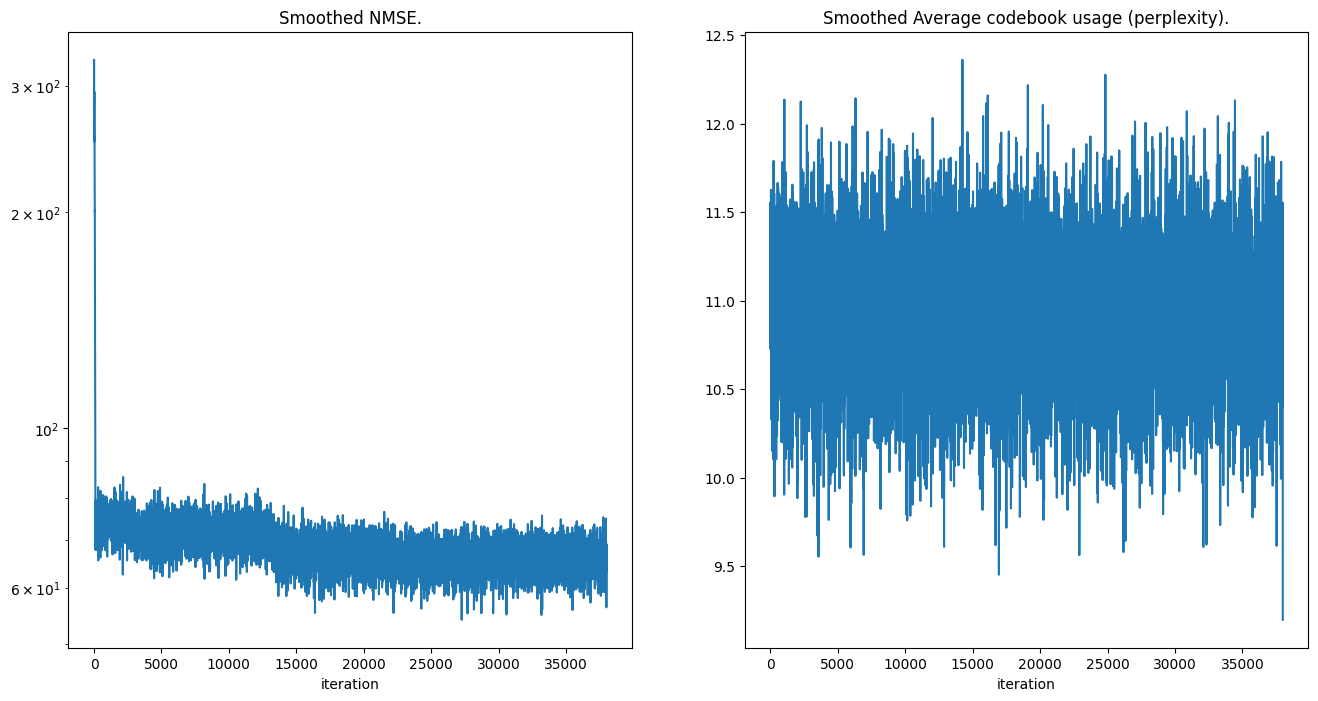

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

### Visualizing the results


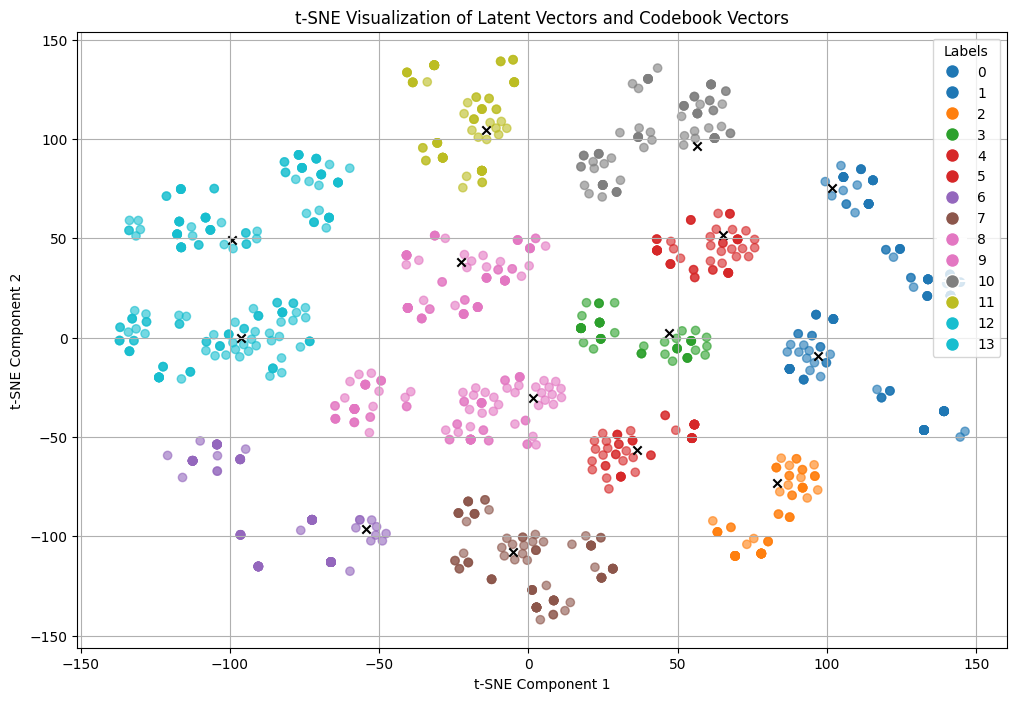

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def encode_points(model, data, labels):
    model.eval()
    with torch.no_grad():
        z = model.encoder(data.to(device))  # Encode data points
        _, quantized_z, _, _ = model.quantizer(z, labels.to(device))  # Quantize the encoded vectors
    return quantized_z

# Function to perform t-SNE and plot the results
def plot_with_tsne(latent_vectors, labels, codebook_vectors):
    tsne = TSNE(n_components=2, random_state=42)
    all_vectors = np.vstack([latent_vectors, codebook_vectors])  # Combine latent and codebook vectors
    all_vectors_2d = tsne.fit_transform(all_vectors)

    latent_vectors_2d = all_vectors_2d[:-len(codebook_vectors)]
    codebook_vectors_2d = all_vectors_2d[-len(codebook_vectors):]

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.scatter(codebook_vectors_2d[:, 0], codebook_vectors_2d[:, 1], color='black', marker='x')  # Codebook vectors in black

    # Create a legend for the labels
    unique_labels = np.unique(labels)
    colors = scatter.cmap(np.linspace(0, 1, len(unique_labels)))
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(int(label)), markersize=10, markerfacecolor=color) for label, color in zip(unique_labels, colors)]
    plt.legend(handles=legend_handles, title='Labels')

    plt.title('t-SNE Visualization of Latent Vectors and Codebook Vectors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Encode the data points
quantized_z = encode_points(model, data, labels)

# Get codebook vectors from the quantizer
codebook_vectors = model.quantizer.embeddings.weight.data.cpu().numpy()

# Plot using t-SNE
plot_with_tsne(quantized_z.cpu().numpy(), labels.cpu().numpy(), codebook_vectors)


### Saving the models needed for the RL agent training

In [ ]:
quantized_z_np = quantized_z.cpu().numpy()
labels_np = labels.cpu().numpy()

# Save arrays to files
np.save('quantized_z.npy', quantized_z_np)
np.save('labels.npy', labels_np)
np.save('codebook_vectors.npy', codebook_vectors)

In [ ]:
model.eval()

decoder = model.decoder
torch.save(decoder.state_dict(), 'decoder_model.pth')

quantizer = model.quantizer
torch.save(quantizer.embeddings.weight.data, 'vector_quantizer_embeddings.pth')